In [94]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from os.path import join, abspath
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
import lightgbm as lgb

project_dir = abspath("../")

if project_dir not in sys.path:
    sys.path.append(project_dir)
    print("Added {} to path".format(project_dir))

from otto.main import confusion_matrix_df, load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
results_train = pd.read_csv("../meta_features_train.csv", index_col=0)
results_test = pd.read_csv("../meta_features_test.csv", index_col=0)
results_submission = pd.read_csv("../meta_features_submission.csv", index_col=0)

print(results_train.shape)
print(results_test.shape)
print(results_submission.shape)

(56927, 37)
(619, 37)
(144368, 36)


In [13]:
results_train2 = pd.read_csv("../meta_features_train_fixed_nn.csv", index_col=0)
results_test2 = pd.read_csv("../meta_features_test_fixed_nn.csv", index_col=0)
results_submission2 = pd.read_csv("../meta_features_submission_fixed_nn.csv", index_col=0)
print(results_train2.shape)
print(results_test2.shape)
print(results_submission2.shape)

(56927, 19)
(619, 19)
(144368, 18)


In [17]:
assert results_train2.index.equals(results_train.index)
assert results_test2.index.equals(results_test.index)
assert results_submission2.index.equals(results_submission.index)

cols_to_replace = ["nn_"+str(i) for i in range(1,10)]
results_train.loc[:, cols_to_replace] = results_train2.loc[:, cols_to_replace]
results_test.loc[:, cols_to_replace] = results_test2.loc[:, cols_to_replace]
results_submission.loc[:, cols_to_replace] = results_submission2.loc[:, cols_to_replace]

# Chack correlation among base estimators

<IPython.core.display.Javascript object>


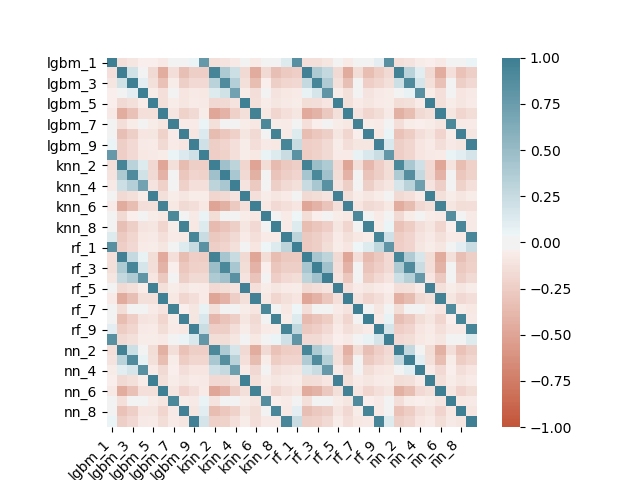

In [25]:
test_corr = results_submission.corr()

fig, ax = plt.subplots()
ax = sns.heatmap(
    test_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [36]:
def convert_to_single_col(df):
    models = ["lgbm_", "knn_", "rf_", "nn_"]
    result = []
    for m in models:
        cols = [m+str(i) for i in range(1,10)]
        temp = np.argmax(df[cols].values, axis=1)
        #print(temp.shape)
        result.append(temp)
        
    result.append(df["y_true"])
    result = np.stack(result, axis=1)
    #print(result.shape)
    return pd.DataFrame(result, columns=models+["y_true"])

results_train_1col = convert_to_single_col(results_train)
results_test_1col = convert_to_single_col(results_test)

In [37]:
train_corr = results_train_1col.drop(columns=["y_true"]).corr()
train_corr

lgbm_      knn_       rf_       nn_
lgbm_  1.000000  0.889301  0.937636  0.908909
knn_   0.889301  1.000000  0.874691  0.847339
rf_    0.937636  0.874691  1.000000  0.884912
nn_    0.908909  0.847339  0.884912  1.000000

In [38]:
test_corr = results_test_1col.drop(columns=["y_true"]).corr()
test_corr

lgbm_      knn_       rf_       nn_
lgbm_  1.000000  0.867390  0.931114  0.929400
knn_   0.867390  1.000000  0.866868  0.824963
rf_    0.931114  0.866868  1.000000  0.904519
nn_    0.929400  0.824963  0.904519  1.000000

In [120]:
models = ["lgbm_", "knn_", "rf_", "nn_"]
pd.set_option('display.expand_frame_repr', False)
result = []
for m in models:
    cols = [m+str(i) for i in range(1,10)]
    temp = np.argmax(results_train[cols].values, axis=1)
    cm = confusion_matrix_df(y_pred=temp, y_true=results_train["y_true"]).round(1)
    print("model: ", m)
    print(cm)

model:  lgbm_
           pred_1   pred_2  pred_3  pred_4  pred_5   pred_6  pred_7  pred_8  pred_9  recall
true_1      683.0     78.0    13.0     0.0     5.0    202.0    42.0   361.0   397.0     0.4
true_2        5.0  13040.0  1541.0    56.0    26.0     44.0    91.0    27.0    38.0     0.9
true_3        1.0   3619.0  3573.0    39.0     1.0     15.0   117.0    21.0    11.0     0.5
true_4        0.0   1074.0   466.0   786.0    17.0     83.0    27.0     1.0     3.0     0.3
true_5        1.0     73.0     1.0     0.0  2422.0      8.0     6.0     7.0     4.0     1.0
true_6       46.0    131.0    21.0     7.0     1.0  12232.0   160.0   227.0   154.0     0.9
true_7       30.0    325.0   197.0     8.0    10.0    212.0  1626.0   168.0    23.0     0.6
true_8       54.0     97.0    18.0     0.0     4.0    256.0    53.0  7204.0    93.0     0.9
true_9       60.0    123.0     5.0     1.0     2.0    174.0    24.0   186.0  3970.0     0.9
precision     0.8      0.7     0.6     0.9     1.0      0.9     0.

In [ ]:
# Try submitting only NN results
cols = ["nn_"+str(i) for i in range(1,10)]
results_nn = results_submission[cols]
results_nn = results_nn.rename(columns={
    "nn_"+str(i): "Class_"+str(i) for i in range(1,10)
})
results_nn.to_csv("submission_nn.csv")
results_nn.head()

# Train 2nd level model

In [121]:
n_classes = 9

level2_x = results_train.drop(columns=["y_true"])
level2_y = results_train["y_true"]

#level2_x_test = results_test.drop(columns=["y_true"])
#level2_y_test = results_test["y_true"]

level2_x_sub = results_submission

k = 15
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

params = {
    "learning_rate": 0.01,
    "num_leaves": 5,
    "n_estimators": 15000,
    "max_depth": 10,
    "min_data_in_leaf": 30,
    "subsample": 0.6,
    "bagging_freq": 3,
    "feature_fraction": 0.6,
    "early_stopping_rounds": 200,
}

In [122]:
train_feats, sub_feats = load_data("data/")
train_feats = train_feats.drop(columns=["target"])

Data shape: (61878, 94)


In [123]:
level2_x_sub_augmented = pd.concat([level2_x_sub, sub_feats.loc[level2_x_sub.index]], axis=1)
cols = level2_x_sub_augmented.columns

y_sub_pred = np.zeros((len(level2_x_sub), 9))
oof = np.zeros((len(level2_x), 9))
score = 0
feature_importance_df = pd.DataFrame()
valid_predict = []
for fold_n, (train_index, valid_index) in enumerate(cv.split(level2_x, level2_y)):
    print('Fold', k)
    X_train, X_valid = level2_x.iloc[train_index], level2_x.iloc[valid_index]
    y_train, y_valid = level2_y.iloc[train_index], level2_y.iloc[valid_index]
    
    # concat original features
    X_train = pd.concat([X_train, train_feats.loc[X_train.index]], axis=1)
    X_valid = pd.concat([X_valid, train_feats.loc[X_valid.index]], axis=1)
    
    clf = lgb.LGBMClassifier(silent=False, objective="softmax", 
                             num_class=n_classes, n_jobs=8, verbose=1, **params)
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)])
    
    y_valid_pred = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)
    score += log_loss(y_valid, y_valid_pred)
    oof[valid_index] = y_valid_pred
    print('Fold', fold_n, 'valid logloss', log_loss(y_valid, y_valid_pred))
    
    y_sub_pred += clf.predict_proba(level2_x_sub_augmented, num_iteration=clf.best_iteration_) / k
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = cols
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
print('valid logloss average:', score/k)

Fold 15


/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92158	valid_1's multi_logloss: 1.92206
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89465	valid_1's multi_logloss: 1.89554
[3]	training's multi_logloss: 1.86919	valid_1's multi_logloss: 1.8703
[4]	training's multi_logloss: 1.84503	valid_1's multi_logloss: 1.84629
[5]	training's multi_logloss: 1.82202	valid_1's multi_logloss: 1.82354
[6]	training's multi_logloss: 1.79963	valid_1's multi_logloss: 1.80124
[7]	training's multi_logloss: 1.77845	valid_1's multi_logloss: 1.7803
[8]	training's multi_logloss: 1.75802	valid_1's multi_logloss: 1.76012
[9]	training's multi_logloss: 1.73812	valid_1's multi_logloss: 1.74038
[10]	training's multi_logloss: 1.71915	valid_1's multi_logloss: 1.72166
[11]	training's multi_logloss: 1.70044	valid_1's multi_logloss: 1.70307
[12]	training's multi_logloss: 1.68246	valid_1's multi_logloss: 1.68531
[13]	training's multi_logloss: 1.66502	valid_1's multi_logloss: 1.66809
[14]	training

[116]	training's multi_logloss: 0.864054	valid_1's multi_logloss: 0.875984
[117]	training's multi_logloss: 0.860393	valid_1's multi_logloss: 0.872372
[118]	training's multi_logloss: 0.85677	valid_1's multi_logloss: 0.868809
[119]	training's multi_logloss: 0.853166	valid_1's multi_logloss: 0.865246
[120]	training's multi_logloss: 0.849614	valid_1's multi_logloss: 0.861733
[121]	training's multi_logloss: 0.846175	valid_1's multi_logloss: 0.858335
[122]	training's multi_logloss: 0.842747	valid_1's multi_logloss: 0.854964
[123]	training's multi_logloss: 0.839465	valid_1's multi_logloss: 0.851745
[124]	training's multi_logloss: 0.836097	valid_1's multi_logloss: 0.848463
[125]	training's multi_logloss: 0.832746	valid_1's multi_logloss: 0.845164
[126]	training's multi_logloss: 0.829466	valid_1's multi_logloss: 0.841922
[127]	training's multi_logloss: 0.826375	valid_1's multi_logloss: 0.838868
[128]	training's multi_logloss: 0.823145	valid_1's multi_logloss: 0.835686
[129]	training's multi_log

[230]	training's multi_logloss: 0.62133	valid_1's multi_logloss: 0.637661
[231]	training's multi_logloss: 0.620181	valid_1's multi_logloss: 0.636571
[232]	training's multi_logloss: 0.619032	valid_1's multi_logloss: 0.635466
[233]	training's multi_logloss: 0.617898	valid_1's multi_logloss: 0.634344
[234]	training's multi_logloss: 0.616767	valid_1's multi_logloss: 0.633253
[235]	training's multi_logloss: 0.615645	valid_1's multi_logloss: 0.632147
[236]	training's multi_logloss: 0.614537	valid_1's multi_logloss: 0.631078
[237]	training's multi_logloss: 0.613428	valid_1's multi_logloss: 0.630008
[238]	training's multi_logloss: 0.612382	valid_1's multi_logloss: 0.629009
[239]	training's multi_logloss: 0.611355	valid_1's multi_logloss: 0.628002
[240]	training's multi_logloss: 0.610285	valid_1's multi_logloss: 0.626955
[241]	training's multi_logloss: 0.609225	valid_1's multi_logloss: 0.62594
[242]	training's multi_logloss: 0.608171	valid_1's multi_logloss: 0.624916
[243]	training's multi_logl

[345]	training's multi_logloss: 0.537248	valid_1's multi_logloss: 0.557059
[346]	training's multi_logloss: 0.536807	valid_1's multi_logloss: 0.556656
[347]	training's multi_logloss: 0.536367	valid_1's multi_logloss: 0.556244
[348]	training's multi_logloss: 0.53593	valid_1's multi_logloss: 0.55584
[349]	training's multi_logloss: 0.535505	valid_1's multi_logloss: 0.555445
[350]	training's multi_logloss: 0.535073	valid_1's multi_logloss: 0.555033
[351]	training's multi_logloss: 0.534635	valid_1's multi_logloss: 0.55464
[352]	training's multi_logloss: 0.534214	valid_1's multi_logloss: 0.554258
[353]	training's multi_logloss: 0.533793	valid_1's multi_logloss: 0.553855
[354]	training's multi_logloss: 0.533373	valid_1's multi_logloss: 0.553472
[355]	training's multi_logloss: 0.532966	valid_1's multi_logloss: 0.553116
[356]	training's multi_logloss: 0.532558	valid_1's multi_logloss: 0.552724
[357]	training's multi_logloss: 0.532153	valid_1's multi_logloss: 0.55237
[358]	training's multi_loglos

[458]	training's multi_logloss: 0.502658	valid_1's multi_logloss: 0.526205
[459]	training's multi_logloss: 0.502456	valid_1's multi_logloss: 0.526038
[460]	training's multi_logloss: 0.502263	valid_1's multi_logloss: 0.525894
[461]	training's multi_logloss: 0.502056	valid_1's multi_logloss: 0.525723
[462]	training's multi_logloss: 0.501854	valid_1's multi_logloss: 0.525573
[463]	training's multi_logloss: 0.501649	valid_1's multi_logloss: 0.525403
[464]	training's multi_logloss: 0.501447	valid_1's multi_logloss: 0.525251
[465]	training's multi_logloss: 0.501241	valid_1's multi_logloss: 0.525088
[466]	training's multi_logloss: 0.501035	valid_1's multi_logloss: 0.524926
[467]	training's multi_logloss: 0.500835	valid_1's multi_logloss: 0.52475
[468]	training's multi_logloss: 0.500636	valid_1's multi_logloss: 0.524567
[469]	training's multi_logloss: 0.500433	valid_1's multi_logloss: 0.524411
[470]	training's multi_logloss: 0.500232	valid_1's multi_logloss: 0.52426
[471]	training's multi_logl

[575]	training's multi_logloss: 0.48429	valid_1's multi_logloss: 0.512173
[576]	training's multi_logloss: 0.484173	valid_1's multi_logloss: 0.51209
[577]	training's multi_logloss: 0.48406	valid_1's multi_logloss: 0.512009
[578]	training's multi_logloss: 0.483936	valid_1's multi_logloss: 0.511916
[579]	training's multi_logloss: 0.483816	valid_1's multi_logloss: 0.511836
[580]	training's multi_logloss: 0.483703	valid_1's multi_logloss: 0.511764
[581]	training's multi_logloss: 0.48359	valid_1's multi_logloss: 0.511682
[582]	training's multi_logloss: 0.483478	valid_1's multi_logloss: 0.511618
[583]	training's multi_logloss: 0.483361	valid_1's multi_logloss: 0.511541
[584]	training's multi_logloss: 0.483239	valid_1's multi_logloss: 0.511476
[585]	training's multi_logloss: 0.483135	valid_1's multi_logloss: 0.511416
[586]	training's multi_logloss: 0.483021	valid_1's multi_logloss: 0.51135
[587]	training's multi_logloss: 0.482902	valid_1's multi_logloss: 0.511287
[588]	training's multi_logloss

[686]	training's multi_logloss: 0.473536	valid_1's multi_logloss: 0.505753
[687]	training's multi_logloss: 0.473453	valid_1's multi_logloss: 0.505717
[688]	training's multi_logloss: 0.473373	valid_1's multi_logloss: 0.505677
[689]	training's multi_logloss: 0.473291	valid_1's multi_logloss: 0.505641
[690]	training's multi_logloss: 0.473213	valid_1's multi_logloss: 0.505607
[691]	training's multi_logloss: 0.47314	valid_1's multi_logloss: 0.505565
[692]	training's multi_logloss: 0.473059	valid_1's multi_logloss: 0.505527
[693]	training's multi_logloss: 0.472978	valid_1's multi_logloss: 0.505486
[694]	training's multi_logloss: 0.472905	valid_1's multi_logloss: 0.505442
[695]	training's multi_logloss: 0.472828	valid_1's multi_logloss: 0.505396
[696]	training's multi_logloss: 0.472756	valid_1's multi_logloss: 0.505353
[697]	training's multi_logloss: 0.472668	valid_1's multi_logloss: 0.505304
[698]	training's multi_logloss: 0.472589	valid_1's multi_logloss: 0.505252
[699]	training's multi_log

[797]	training's multi_logloss: 0.465831	valid_1's multi_logloss: 0.501939
[798]	training's multi_logloss: 0.465776	valid_1's multi_logloss: 0.501908
[799]	training's multi_logloss: 0.465718	valid_1's multi_logloss: 0.501891
[800]	training's multi_logloss: 0.465656	valid_1's multi_logloss: 0.50187
[801]	training's multi_logloss: 0.465598	valid_1's multi_logloss: 0.501854
[802]	training's multi_logloss: 0.465537	valid_1's multi_logloss: 0.501826
[803]	training's multi_logloss: 0.465476	valid_1's multi_logloss: 0.501801
[804]	training's multi_logloss: 0.465413	valid_1's multi_logloss: 0.501769
[805]	training's multi_logloss: 0.465348	valid_1's multi_logloss: 0.501738
[806]	training's multi_logloss: 0.465287	valid_1's multi_logloss: 0.501699
[807]	training's multi_logloss: 0.465226	valid_1's multi_logloss: 0.501679
[808]	training's multi_logloss: 0.465163	valid_1's multi_logloss: 0.501674
[809]	training's multi_logloss: 0.465097	valid_1's multi_logloss: 0.501655
[810]	training's multi_log

[907]	training's multi_logloss: 0.459731	valid_1's multi_logloss: 0.499586
[908]	training's multi_logloss: 0.459685	valid_1's multi_logloss: 0.499574
[909]	training's multi_logloss: 0.459637	valid_1's multi_logloss: 0.499557
[910]	training's multi_logloss: 0.459589	valid_1's multi_logloss: 0.499547
[911]	training's multi_logloss: 0.459544	valid_1's multi_logloss: 0.499543
[912]	training's multi_logloss: 0.459499	valid_1's multi_logloss: 0.499532
[913]	training's multi_logloss: 0.459449	valid_1's multi_logloss: 0.499513
[914]	training's multi_logloss: 0.459398	valid_1's multi_logloss: 0.499493
[915]	training's multi_logloss: 0.459342	valid_1's multi_logloss: 0.499474
[916]	training's multi_logloss: 0.459288	valid_1's multi_logloss: 0.499455
[917]	training's multi_logloss: 0.459231	valid_1's multi_logloss: 0.499429
[918]	training's multi_logloss: 0.459176	valid_1's multi_logloss: 0.499398
[919]	training's multi_logloss: 0.459129	valid_1's multi_logloss: 0.499373
[920]	training's multi_lo

[1019]	training's multi_logloss: 0.454504	valid_1's multi_logloss: 0.49814
[1020]	training's multi_logloss: 0.454457	valid_1's multi_logloss: 0.49814
[1021]	training's multi_logloss: 0.454412	valid_1's multi_logloss: 0.498116
[1022]	training's multi_logloss: 0.454371	valid_1's multi_logloss: 0.4981
[1023]	training's multi_logloss: 0.454327	valid_1's multi_logloss: 0.498085
[1024]	training's multi_logloss: 0.454284	valid_1's multi_logloss: 0.49808
[1025]	training's multi_logloss: 0.454241	valid_1's multi_logloss: 0.49807
[1026]	training's multi_logloss: 0.454202	valid_1's multi_logloss: 0.498068
[1027]	training's multi_logloss: 0.454162	valid_1's multi_logloss: 0.498059
[1028]	training's multi_logloss: 0.454119	valid_1's multi_logloss: 0.498046
[1029]	training's multi_logloss: 0.454078	valid_1's multi_logloss: 0.498029
[1030]	training's multi_logloss: 0.454037	valid_1's multi_logloss: 0.498024
[1031]	training's multi_logloss: 0.453999	valid_1's multi_logloss: 0.498016
[1032]	training's 

[1131]	training's multi_logloss: 0.450039	valid_1's multi_logloss: 0.496789
[1132]	training's multi_logloss: 0.450006	valid_1's multi_logloss: 0.496777
[1133]	training's multi_logloss: 0.449972	valid_1's multi_logloss: 0.496771
[1134]	training's multi_logloss: 0.449939	valid_1's multi_logloss: 0.496771
[1135]	training's multi_logloss: 0.449902	valid_1's multi_logloss: 0.496766
[1136]	training's multi_logloss: 0.449867	valid_1's multi_logloss: 0.496749
[1137]	training's multi_logloss: 0.449832	valid_1's multi_logloss: 0.496734
[1138]	training's multi_logloss: 0.449792	valid_1's multi_logloss: 0.496717
[1139]	training's multi_logloss: 0.449755	valid_1's multi_logloss: 0.496698
[1140]	training's multi_logloss: 0.449716	valid_1's multi_logloss: 0.496696
[1141]	training's multi_logloss: 0.449677	valid_1's multi_logloss: 0.496682
[1142]	training's multi_logloss: 0.449641	valid_1's multi_logloss: 0.496661
[1143]	training's multi_logloss: 0.449605	valid_1's multi_logloss: 0.496658
[1144]	train

[1243]	training's multi_logloss: 0.445992	valid_1's multi_logloss: 0.495798
[1244]	training's multi_logloss: 0.445958	valid_1's multi_logloss: 0.495796
[1245]	training's multi_logloss: 0.445921	valid_1's multi_logloss: 0.495785
[1246]	training's multi_logloss: 0.445889	valid_1's multi_logloss: 0.49579
[1247]	training's multi_logloss: 0.445858	valid_1's multi_logloss: 0.49578
[1248]	training's multi_logloss: 0.445821	valid_1's multi_logloss: 0.495769
[1249]	training's multi_logloss: 0.445785	valid_1's multi_logloss: 0.495752
[1250]	training's multi_logloss: 0.445751	valid_1's multi_logloss: 0.49575
[1251]	training's multi_logloss: 0.445712	valid_1's multi_logloss: 0.495734
[1252]	training's multi_logloss: 0.445677	valid_1's multi_logloss: 0.495732
[1253]	training's multi_logloss: 0.445643	valid_1's multi_logloss: 0.495717
[1254]	training's multi_logloss: 0.445605	valid_1's multi_logloss: 0.49569
[1255]	training's multi_logloss: 0.445569	valid_1's multi_logloss: 0.495685
[1256]	training'

[1358]	training's multi_logloss: 0.442007	valid_1's multi_logloss: 0.494753
[1359]	training's multi_logloss: 0.441975	valid_1's multi_logloss: 0.494745
[1360]	training's multi_logloss: 0.441944	valid_1's multi_logloss: 0.494739
[1361]	training's multi_logloss: 0.441911	valid_1's multi_logloss: 0.49474
[1362]	training's multi_logloss: 0.441883	valid_1's multi_logloss: 0.494731
[1363]	training's multi_logloss: 0.441852	valid_1's multi_logloss: 0.494719
[1364]	training's multi_logloss: 0.441824	valid_1's multi_logloss: 0.494713
[1365]	training's multi_logloss: 0.44179	valid_1's multi_logloss: 0.494699
[1366]	training's multi_logloss: 0.441756	valid_1's multi_logloss: 0.494688
[1367]	training's multi_logloss: 0.441723	valid_1's multi_logloss: 0.494685
[1368]	training's multi_logloss: 0.44169	valid_1's multi_logloss: 0.494685
[1369]	training's multi_logloss: 0.441654	valid_1's multi_logloss: 0.494662
[1370]	training's multi_logloss: 0.44162	valid_1's multi_logloss: 0.494656
[1371]	training'

[1473]	training's multi_logloss: 0.438263	valid_1's multi_logloss: 0.493762
[1474]	training's multi_logloss: 0.438226	valid_1's multi_logloss: 0.493752
[1475]	training's multi_logloss: 0.438196	valid_1's multi_logloss: 0.493734
[1476]	training's multi_logloss: 0.438164	valid_1's multi_logloss: 0.493724
[1477]	training's multi_logloss: 0.438133	valid_1's multi_logloss: 0.493723
[1478]	training's multi_logloss: 0.438105	valid_1's multi_logloss: 0.493729
[1479]	training's multi_logloss: 0.438076	valid_1's multi_logloss: 0.493716
[1480]	training's multi_logloss: 0.438045	valid_1's multi_logloss: 0.493711
[1481]	training's multi_logloss: 0.438016	valid_1's multi_logloss: 0.493704
[1482]	training's multi_logloss: 0.437978	valid_1's multi_logloss: 0.493708
[1483]	training's multi_logloss: 0.437945	valid_1's multi_logloss: 0.493703
[1484]	training's multi_logloss: 0.437914	valid_1's multi_logloss: 0.493697
[1485]	training's multi_logloss: 0.437879	valid_1's multi_logloss: 0.493689
[1486]	train

[1582]	training's multi_logloss: 0.434863	valid_1's multi_logloss: 0.49276
[1583]	training's multi_logloss: 0.434834	valid_1's multi_logloss: 0.492755
[1584]	training's multi_logloss: 0.434805	valid_1's multi_logloss: 0.49275
[1585]	training's multi_logloss: 0.434775	valid_1's multi_logloss: 0.492741
[1586]	training's multi_logloss: 0.434747	valid_1's multi_logloss: 0.492726
[1587]	training's multi_logloss: 0.434714	valid_1's multi_logloss: 0.492706
[1588]	training's multi_logloss: 0.434683	valid_1's multi_logloss: 0.492694
[1589]	training's multi_logloss: 0.434654	valid_1's multi_logloss: 0.492689
[1590]	training's multi_logloss: 0.434627	valid_1's multi_logloss: 0.492683
[1591]	training's multi_logloss: 0.434598	valid_1's multi_logloss: 0.492684
[1592]	training's multi_logloss: 0.43457	valid_1's multi_logloss: 0.492679
[1593]	training's multi_logloss: 0.434543	valid_1's multi_logloss: 0.492664
[1594]	training's multi_logloss: 0.434516	valid_1's multi_logloss: 0.492664
[1595]	training

[1697]	training's multi_logloss: 0.431439	valid_1's multi_logloss: 0.491788
[1698]	training's multi_logloss: 0.431412	valid_1's multi_logloss: 0.491775
[1699]	training's multi_logloss: 0.431382	valid_1's multi_logloss: 0.491792
[1700]	training's multi_logloss: 0.431355	valid_1's multi_logloss: 0.491791
[1701]	training's multi_logloss: 0.431328	valid_1's multi_logloss: 0.491783
[1702]	training's multi_logloss: 0.431298	valid_1's multi_logloss: 0.491792
[1703]	training's multi_logloss: 0.431267	valid_1's multi_logloss: 0.491797
[1704]	training's multi_logloss: 0.431238	valid_1's multi_logloss: 0.4918
[1705]	training's multi_logloss: 0.431209	valid_1's multi_logloss: 0.491793
[1706]	training's multi_logloss: 0.43118	valid_1's multi_logloss: 0.491788
[1707]	training's multi_logloss: 0.431149	valid_1's multi_logloss: 0.491781
[1708]	training's multi_logloss: 0.431115	valid_1's multi_logloss: 0.491778
[1709]	training's multi_logloss: 0.431088	valid_1's multi_logloss: 0.491766
[1710]	training

[1806]	training's multi_logloss: 0.428259	valid_1's multi_logloss: 0.491251
[1807]	training's multi_logloss: 0.428233	valid_1's multi_logloss: 0.491253
[1808]	training's multi_logloss: 0.428208	valid_1's multi_logloss: 0.491263
[1809]	training's multi_logloss: 0.428181	valid_1's multi_logloss: 0.49127
[1810]	training's multi_logloss: 0.428152	valid_1's multi_logloss: 0.491267
[1811]	training's multi_logloss: 0.428121	valid_1's multi_logloss: 0.491256
[1812]	training's multi_logloss: 0.428087	valid_1's multi_logloss: 0.491251
[1813]	training's multi_logloss: 0.428055	valid_1's multi_logloss: 0.491253
[1814]	training's multi_logloss: 0.428023	valid_1's multi_logloss: 0.491241
[1815]	training's multi_logloss: 0.427993	valid_1's multi_logloss: 0.491229
[1816]	training's multi_logloss: 0.427963	valid_1's multi_logloss: 0.491233
[1817]	training's multi_logloss: 0.427935	valid_1's multi_logloss: 0.491235
[1818]	training's multi_logloss: 0.427906	valid_1's multi_logloss: 0.491222
[1819]	traini

[1920]	training's multi_logloss: 0.425069	valid_1's multi_logloss: 0.49074
[1921]	training's multi_logloss: 0.425046	valid_1's multi_logloss: 0.490744
[1922]	training's multi_logloss: 0.425016	valid_1's multi_logloss: 0.490755
[1923]	training's multi_logloss: 0.42499	valid_1's multi_logloss: 0.490757
[1924]	training's multi_logloss: 0.424961	valid_1's multi_logloss: 0.490738
[1925]	training's multi_logloss: 0.424934	valid_1's multi_logloss: 0.490726
[1926]	training's multi_logloss: 0.424904	valid_1's multi_logloss: 0.490718
[1927]	training's multi_logloss: 0.424878	valid_1's multi_logloss: 0.490707
[1928]	training's multi_logloss: 0.424855	valid_1's multi_logloss: 0.490699
[1929]	training's multi_logloss: 0.424829	valid_1's multi_logloss: 0.49069
[1930]	training's multi_logloss: 0.4248	valid_1's multi_logloss: 0.490684
[1931]	training's multi_logloss: 0.424772	valid_1's multi_logloss: 0.490678
[1932]	training's multi_logloss: 0.424745	valid_1's multi_logloss: 0.49065
[1933]	training's 

[2029]	training's multi_logloss: 0.422142	valid_1's multi_logloss: 0.489986
[2030]	training's multi_logloss: 0.422116	valid_1's multi_logloss: 0.48999
[2031]	training's multi_logloss: 0.422094	valid_1's multi_logloss: 0.48999
[2032]	training's multi_logloss: 0.422065	valid_1's multi_logloss: 0.489976
[2033]	training's multi_logloss: 0.422039	valid_1's multi_logloss: 0.489979
[2034]	training's multi_logloss: 0.422012	valid_1's multi_logloss: 0.489967
[2035]	training's multi_logloss: 0.421983	valid_1's multi_logloss: 0.489947
[2036]	training's multi_logloss: 0.421951	valid_1's multi_logloss: 0.489953
[2037]	training's multi_logloss: 0.421925	valid_1's multi_logloss: 0.489941
[2038]	training's multi_logloss: 0.421901	valid_1's multi_logloss: 0.489938
[2039]	training's multi_logloss: 0.421878	valid_1's multi_logloss: 0.489941
[2040]	training's multi_logloss: 0.421852	valid_1's multi_logloss: 0.489938
[2041]	training's multi_logloss: 0.421825	valid_1's multi_logloss: 0.489935
[2042]	trainin

[2145]	training's multi_logloss: 0.419124	valid_1's multi_logloss: 0.489311
[2146]	training's multi_logloss: 0.4191	valid_1's multi_logloss: 0.489306
[2147]	training's multi_logloss: 0.419079	valid_1's multi_logloss: 0.489308
[2148]	training's multi_logloss: 0.419053	valid_1's multi_logloss: 0.489302
[2149]	training's multi_logloss: 0.419025	valid_1's multi_logloss: 0.489282
[2150]	training's multi_logloss: 0.418994	valid_1's multi_logloss: 0.489259
[2151]	training's multi_logloss: 0.418965	valid_1's multi_logloss: 0.489259
[2152]	training's multi_logloss: 0.418934	valid_1's multi_logloss: 0.489262
[2153]	training's multi_logloss: 0.418907	valid_1's multi_logloss: 0.489248
[2154]	training's multi_logloss: 0.418873	valid_1's multi_logloss: 0.489249
[2155]	training's multi_logloss: 0.418844	valid_1's multi_logloss: 0.489251
[2156]	training's multi_logloss: 0.418822	valid_1's multi_logloss: 0.489264
[2157]	training's multi_logloss: 0.418796	valid_1's multi_logloss: 0.489263
[2158]	trainin

[2256]	training's multi_logloss: 0.416236	valid_1's multi_logloss: 0.489012
[2257]	training's multi_logloss: 0.416214	valid_1's multi_logloss: 0.488996
[2258]	training's multi_logloss: 0.416188	valid_1's multi_logloss: 0.488988
[2259]	training's multi_logloss: 0.416159	valid_1's multi_logloss: 0.488989
[2260]	training's multi_logloss: 0.416137	valid_1's multi_logloss: 0.48898
[2261]	training's multi_logloss: 0.416115	valid_1's multi_logloss: 0.488966
[2262]	training's multi_logloss: 0.416092	valid_1's multi_logloss: 0.488954
[2263]	training's multi_logloss: 0.416068	valid_1's multi_logloss: 0.48895
[2264]	training's multi_logloss: 0.416039	valid_1's multi_logloss: 0.488941
[2265]	training's multi_logloss: 0.416015	valid_1's multi_logloss: 0.488924
[2266]	training's multi_logloss: 0.415983	valid_1's multi_logloss: 0.48892
[2267]	training's multi_logloss: 0.415956	valid_1's multi_logloss: 0.488914
[2268]	training's multi_logloss: 0.415931	valid_1's multi_logloss: 0.488912
[2269]	training

[2372]	training's multi_logloss: 0.413362	valid_1's multi_logloss: 0.488307
[2373]	training's multi_logloss: 0.413337	valid_1's multi_logloss: 0.488292
[2374]	training's multi_logloss: 0.413314	valid_1's multi_logloss: 0.488279
[2375]	training's multi_logloss: 0.41329	valid_1's multi_logloss: 0.488277
[2376]	training's multi_logloss: 0.41327	valid_1's multi_logloss: 0.488276
[2377]	training's multi_logloss: 0.413246	valid_1's multi_logloss: 0.488275
[2378]	training's multi_logloss: 0.413223	valid_1's multi_logloss: 0.48827
[2379]	training's multi_logloss: 0.4132	valid_1's multi_logloss: 0.488267
[2380]	training's multi_logloss: 0.413175	valid_1's multi_logloss: 0.488268
[2381]	training's multi_logloss: 0.41315	valid_1's multi_logloss: 0.488264
[2382]	training's multi_logloss: 0.413126	valid_1's multi_logloss: 0.488255
[2383]	training's multi_logloss: 0.413101	valid_1's multi_logloss: 0.488251
[2384]	training's multi_logloss: 0.413074	valid_1's multi_logloss: 0.488241
[2385]	training's 

[2483]	training's multi_logloss: 0.410712	valid_1's multi_logloss: 0.487957
[2484]	training's multi_logloss: 0.410691	valid_1's multi_logloss: 0.487969
[2485]	training's multi_logloss: 0.410666	valid_1's multi_logloss: 0.487959
[2486]	training's multi_logloss: 0.410641	valid_1's multi_logloss: 0.487955
[2487]	training's multi_logloss: 0.410618	valid_1's multi_logloss: 0.487954
[2488]	training's multi_logloss: 0.410595	valid_1's multi_logloss: 0.48795
[2489]	training's multi_logloss: 0.410571	valid_1's multi_logloss: 0.487947
[2490]	training's multi_logloss: 0.41055	valid_1's multi_logloss: 0.487953
[2491]	training's multi_logloss: 0.410527	valid_1's multi_logloss: 0.487956
[2492]	training's multi_logloss: 0.410504	valid_1's multi_logloss: 0.487963
[2493]	training's multi_logloss: 0.410484	valid_1's multi_logloss: 0.487973
[2494]	training's multi_logloss: 0.410462	valid_1's multi_logloss: 0.487983
[2495]	training's multi_logloss: 0.410438	valid_1's multi_logloss: 0.487974
[2496]	trainin

[2597]	training's multi_logloss: 0.40803	valid_1's multi_logloss: 0.487602
[2598]	training's multi_logloss: 0.408007	valid_1's multi_logloss: 0.487611
[2599]	training's multi_logloss: 0.407989	valid_1's multi_logloss: 0.487605
[2600]	training's multi_logloss: 0.407963	valid_1's multi_logloss: 0.4876
[2601]	training's multi_logloss: 0.407941	valid_1's multi_logloss: 0.487605
[2602]	training's multi_logloss: 0.40792	valid_1's multi_logloss: 0.48759
[2603]	training's multi_logloss: 0.407896	valid_1's multi_logloss: 0.487593
[2604]	training's multi_logloss: 0.407873	valid_1's multi_logloss: 0.487582
[2605]	training's multi_logloss: 0.407851	valid_1's multi_logloss: 0.487585
[2606]	training's multi_logloss: 0.407828	valid_1's multi_logloss: 0.487582
[2607]	training's multi_logloss: 0.407807	valid_1's multi_logloss: 0.487589
[2608]	training's multi_logloss: 0.407784	valid_1's multi_logloss: 0.487593
[2609]	training's multi_logloss: 0.407762	valid_1's multi_logloss: 0.487578
[2610]	training's

[2710]	training's multi_logloss: 0.405441	valid_1's multi_logloss: 0.487159
[2711]	training's multi_logloss: 0.405421	valid_1's multi_logloss: 0.48715
[2712]	training's multi_logloss: 0.405399	valid_1's multi_logloss: 0.487146
[2713]	training's multi_logloss: 0.40538	valid_1's multi_logloss: 0.487146
[2714]	training's multi_logloss: 0.405358	valid_1's multi_logloss: 0.487151
[2715]	training's multi_logloss: 0.405339	valid_1's multi_logloss: 0.487156
[2716]	training's multi_logloss: 0.405313	valid_1's multi_logloss: 0.487151
[2717]	training's multi_logloss: 0.40529	valid_1's multi_logloss: 0.487145
[2718]	training's multi_logloss: 0.405263	valid_1's multi_logloss: 0.487139
[2719]	training's multi_logloss: 0.405245	valid_1's multi_logloss: 0.487129
[2720]	training's multi_logloss: 0.405224	valid_1's multi_logloss: 0.487127
[2721]	training's multi_logloss: 0.405197	valid_1's multi_logloss: 0.487127
[2722]	training's multi_logloss: 0.405176	valid_1's multi_logloss: 0.48713
[2723]	training'

[2822]	training's multi_logloss: 0.40286	valid_1's multi_logloss: 0.486785
[2823]	training's multi_logloss: 0.402836	valid_1's multi_logloss: 0.486773
[2824]	training's multi_logloss: 0.402814	valid_1's multi_logloss: 0.48677
[2825]	training's multi_logloss: 0.402787	valid_1's multi_logloss: 0.486754
[2826]	training's multi_logloss: 0.402759	valid_1's multi_logloss: 0.486748
[2827]	training's multi_logloss: 0.402735	valid_1's multi_logloss: 0.486743
[2828]	training's multi_logloss: 0.402714	valid_1's multi_logloss: 0.486739
[2829]	training's multi_logloss: 0.402692	valid_1's multi_logloss: 0.486726
[2830]	training's multi_logloss: 0.402663	valid_1's multi_logloss: 0.486727
[2831]	training's multi_logloss: 0.40264	valid_1's multi_logloss: 0.48672
[2832]	training's multi_logloss: 0.402617	valid_1's multi_logloss: 0.486722
[2833]	training's multi_logloss: 0.402597	valid_1's multi_logloss: 0.486711
[2834]	training's multi_logloss: 0.402576	valid_1's multi_logloss: 0.486687
[2835]	training'

[2938]	training's multi_logloss: 0.400251	valid_1's multi_logloss: 0.486456
[2939]	training's multi_logloss: 0.400231	valid_1's multi_logloss: 0.486451
[2940]	training's multi_logloss: 0.400209	valid_1's multi_logloss: 0.486443
[2941]	training's multi_logloss: 0.400184	valid_1's multi_logloss: 0.486434
[2942]	training's multi_logloss: 0.400162	valid_1's multi_logloss: 0.486434
[2943]	training's multi_logloss: 0.400138	valid_1's multi_logloss: 0.48642
[2944]	training's multi_logloss: 0.400119	valid_1's multi_logloss: 0.48641
[2945]	training's multi_logloss: 0.400092	valid_1's multi_logloss: 0.486405
[2946]	training's multi_logloss: 0.400069	valid_1's multi_logloss: 0.486399
[2947]	training's multi_logloss: 0.400042	valid_1's multi_logloss: 0.486391
[2948]	training's multi_logloss: 0.40002	valid_1's multi_logloss: 0.486397
[2949]	training's multi_logloss: 0.399999	valid_1's multi_logloss: 0.486403
[2950]	training's multi_logloss: 0.399977	valid_1's multi_logloss: 0.4864
[2951]	training's

[3047]	training's multi_logloss: 0.397874	valid_1's multi_logloss: 0.486061
[3048]	training's multi_logloss: 0.397855	valid_1's multi_logloss: 0.486059
[3049]	training's multi_logloss: 0.397834	valid_1's multi_logloss: 0.486062
[3050]	training's multi_logloss: 0.397811	valid_1's multi_logloss: 0.486069
[3051]	training's multi_logloss: 0.397787	valid_1's multi_logloss: 0.48607
[3052]	training's multi_logloss: 0.397768	valid_1's multi_logloss: 0.486067
[3053]	training's multi_logloss: 0.397744	valid_1's multi_logloss: 0.48608
[3054]	training's multi_logloss: 0.397723	valid_1's multi_logloss: 0.486074
[3055]	training's multi_logloss: 0.397703	valid_1's multi_logloss: 0.486075
[3056]	training's multi_logloss: 0.397683	valid_1's multi_logloss: 0.486075
[3057]	training's multi_logloss: 0.397662	valid_1's multi_logloss: 0.486085
[3058]	training's multi_logloss: 0.39764	valid_1's multi_logloss: 0.486097
[3059]	training's multi_logloss: 0.397619	valid_1's multi_logloss: 0.4861
[3060]	training's

[3157]	training's multi_logloss: 0.395557	valid_1's multi_logloss: 0.485845
[3158]	training's multi_logloss: 0.395535	valid_1's multi_logloss: 0.485852
[3159]	training's multi_logloss: 0.395514	valid_1's multi_logloss: 0.485839
[3160]	training's multi_logloss: 0.395495	valid_1's multi_logloss: 0.485838
[3161]	training's multi_logloss: 0.395475	valid_1's multi_logloss: 0.485837
[3162]	training's multi_logloss: 0.395451	valid_1's multi_logloss: 0.485839
[3163]	training's multi_logloss: 0.39543	valid_1's multi_logloss: 0.485851
[3164]	training's multi_logloss: 0.39541	valid_1's multi_logloss: 0.485862
[3165]	training's multi_logloss: 0.395389	valid_1's multi_logloss: 0.485867
[3166]	training's multi_logloss: 0.395369	valid_1's multi_logloss: 0.485873
[3167]	training's multi_logloss: 0.395345	valid_1's multi_logloss: 0.485876
[3168]	training's multi_logloss: 0.395323	valid_1's multi_logloss: 0.485888
[3169]	training's multi_logloss: 0.395298	valid_1's multi_logloss: 0.485891
[3170]	trainin

[3271]	training's multi_logloss: 0.3931	valid_1's multi_logloss: 0.485577
[3272]	training's multi_logloss: 0.393076	valid_1's multi_logloss: 0.485592
[3273]	training's multi_logloss: 0.39305	valid_1's multi_logloss: 0.485588
[3274]	training's multi_logloss: 0.39303	valid_1's multi_logloss: 0.485587
[3275]	training's multi_logloss: 0.393011	valid_1's multi_logloss: 0.485593
[3276]	training's multi_logloss: 0.392991	valid_1's multi_logloss: 0.485587
[3277]	training's multi_logloss: 0.392971	valid_1's multi_logloss: 0.485594
[3278]	training's multi_logloss: 0.392947	valid_1's multi_logloss: 0.485592
[3279]	training's multi_logloss: 0.392928	valid_1's multi_logloss: 0.485598
[3280]	training's multi_logloss: 0.392904	valid_1's multi_logloss: 0.485599
[3281]	training's multi_logloss: 0.392884	valid_1's multi_logloss: 0.4856
[3282]	training's multi_logloss: 0.392862	valid_1's multi_logloss: 0.485597
[3283]	training's multi_logloss: 0.392842	valid_1's multi_logloss: 0.485598
[3284]	training's 

[3387]	training's multi_logloss: 0.390675	valid_1's multi_logloss: 0.485366
[3388]	training's multi_logloss: 0.390656	valid_1's multi_logloss: 0.485366
[3389]	training's multi_logloss: 0.390633	valid_1's multi_logloss: 0.48536
[3390]	training's multi_logloss: 0.390613	valid_1's multi_logloss: 0.485368
[3391]	training's multi_logloss: 0.390591	valid_1's multi_logloss: 0.485375
[3392]	training's multi_logloss: 0.390571	valid_1's multi_logloss: 0.485371
[3393]	training's multi_logloss: 0.390544	valid_1's multi_logloss: 0.485363
[3394]	training's multi_logloss: 0.390521	valid_1's multi_logloss: 0.485358
[3395]	training's multi_logloss: 0.390504	valid_1's multi_logloss: 0.485353
[3396]	training's multi_logloss: 0.390484	valid_1's multi_logloss: 0.485339
[3397]	training's multi_logloss: 0.390465	valid_1's multi_logloss: 0.485341
[3398]	training's multi_logloss: 0.390445	valid_1's multi_logloss: 0.48533
[3399]	training's multi_logloss: 0.390421	valid_1's multi_logloss: 0.485322
[3400]	trainin

[3503]	training's multi_logloss: 0.388322	valid_1's multi_logloss: 0.485187
[3504]	training's multi_logloss: 0.388305	valid_1's multi_logloss: 0.485187
[3505]	training's multi_logloss: 0.388284	valid_1's multi_logloss: 0.48518
[3506]	training's multi_logloss: 0.388265	valid_1's multi_logloss: 0.485175
[3507]	training's multi_logloss: 0.388244	valid_1's multi_logloss: 0.485181
[3508]	training's multi_logloss: 0.388227	valid_1's multi_logloss: 0.485176
[3509]	training's multi_logloss: 0.388209	valid_1's multi_logloss: 0.48518
[3510]	training's multi_logloss: 0.38819	valid_1's multi_logloss: 0.485183
[3511]	training's multi_logloss: 0.388173	valid_1's multi_logloss: 0.485178
[3512]	training's multi_logloss: 0.388156	valid_1's multi_logloss: 0.485173
[3513]	training's multi_logloss: 0.388137	valid_1's multi_logloss: 0.485173
[3514]	training's multi_logloss: 0.388119	valid_1's multi_logloss: 0.485168
[3515]	training's multi_logloss: 0.388098	valid_1's multi_logloss: 0.485159
[3516]	training

[3618]	training's multi_logloss: 0.38602	valid_1's multi_logloss: 0.485128
[3619]	training's multi_logloss: 0.386002	valid_1's multi_logloss: 0.485114
[3620]	training's multi_logloss: 0.385984	valid_1's multi_logloss: 0.485109
[3621]	training's multi_logloss: 0.385966	valid_1's multi_logloss: 0.485102
[3622]	training's multi_logloss: 0.385946	valid_1's multi_logloss: 0.485096
[3623]	training's multi_logloss: 0.385926	valid_1's multi_logloss: 0.485092
[3624]	training's multi_logloss: 0.385906	valid_1's multi_logloss: 0.485075
[3625]	training's multi_logloss: 0.385884	valid_1's multi_logloss: 0.485072
[3626]	training's multi_logloss: 0.385865	valid_1's multi_logloss: 0.485074
[3627]	training's multi_logloss: 0.385845	valid_1's multi_logloss: 0.485059
[3628]	training's multi_logloss: 0.385822	valid_1's multi_logloss: 0.485063
[3629]	training's multi_logloss: 0.385798	valid_1's multi_logloss: 0.48506
[3630]	training's multi_logloss: 0.385776	valid_1's multi_logloss: 0.485045
[3631]	trainin

[3733]	training's multi_logloss: 0.383719	valid_1's multi_logloss: 0.484948
[3734]	training's multi_logloss: 0.383698	valid_1's multi_logloss: 0.484936
[3735]	training's multi_logloss: 0.38368	valid_1's multi_logloss: 0.484935
[3736]	training's multi_logloss: 0.38366	valid_1's multi_logloss: 0.484934
[3737]	training's multi_logloss: 0.383641	valid_1's multi_logloss: 0.484934
[3738]	training's multi_logloss: 0.383621	valid_1's multi_logloss: 0.484936
[3739]	training's multi_logloss: 0.383602	valid_1's multi_logloss: 0.484931
[3740]	training's multi_logloss: 0.383584	valid_1's multi_logloss: 0.484923
[3741]	training's multi_logloss: 0.383566	valid_1's multi_logloss: 0.484928
[3742]	training's multi_logloss: 0.383545	valid_1's multi_logloss: 0.484921
[3743]	training's multi_logloss: 0.383522	valid_1's multi_logloss: 0.484927
[3744]	training's multi_logloss: 0.383498	valid_1's multi_logloss: 0.48493
[3745]	training's multi_logloss: 0.383479	valid_1's multi_logloss: 0.484916
[3746]	training

[3845]	training's multi_logloss: 0.381536	valid_1's multi_logloss: 0.484684
[3846]	training's multi_logloss: 0.381514	valid_1's multi_logloss: 0.484685
[3847]	training's multi_logloss: 0.381498	valid_1's multi_logloss: 0.484685
[3848]	training's multi_logloss: 0.381475	valid_1's multi_logloss: 0.484683
[3849]	training's multi_logloss: 0.381452	valid_1's multi_logloss: 0.484665
[3850]	training's multi_logloss: 0.381434	valid_1's multi_logloss: 0.484668
[3851]	training's multi_logloss: 0.381416	valid_1's multi_logloss: 0.484667
[3852]	training's multi_logloss: 0.381396	valid_1's multi_logloss: 0.484673
[3853]	training's multi_logloss: 0.381373	valid_1's multi_logloss: 0.48467
[3854]	training's multi_logloss: 0.381355	valid_1's multi_logloss: 0.484666
[3855]	training's multi_logloss: 0.381335	valid_1's multi_logloss: 0.484677
[3856]	training's multi_logloss: 0.381311	valid_1's multi_logloss: 0.48467
[3857]	training's multi_logloss: 0.381289	valid_1's multi_logloss: 0.484662
[3858]	trainin

[3958]	training's multi_logloss: 0.379382	valid_1's multi_logloss: 0.484357
[3959]	training's multi_logloss: 0.379361	valid_1's multi_logloss: 0.484354
[3960]	training's multi_logloss: 0.379343	valid_1's multi_logloss: 0.484354
[3961]	training's multi_logloss: 0.379321	valid_1's multi_logloss: 0.484351
[3962]	training's multi_logloss: 0.3793	valid_1's multi_logloss: 0.484352
[3963]	training's multi_logloss: 0.379283	valid_1's multi_logloss: 0.48435
[3964]	training's multi_logloss: 0.379263	valid_1's multi_logloss: 0.484344
[3965]	training's multi_logloss: 0.379242	valid_1's multi_logloss: 0.484341
[3966]	training's multi_logloss: 0.379224	valid_1's multi_logloss: 0.484344
[3967]	training's multi_logloss: 0.379205	valid_1's multi_logloss: 0.484328
[3968]	training's multi_logloss: 0.379187	valid_1's multi_logloss: 0.484327
[3969]	training's multi_logloss: 0.379168	valid_1's multi_logloss: 0.484329
[3970]	training's multi_logloss: 0.379149	valid_1's multi_logloss: 0.484338
[3971]	training

[4070]	training's multi_logloss: 0.377294	valid_1's multi_logloss: 0.48435
[4071]	training's multi_logloss: 0.377277	valid_1's multi_logloss: 0.484348
[4072]	training's multi_logloss: 0.377255	valid_1's multi_logloss: 0.484353
[4073]	training's multi_logloss: 0.377237	valid_1's multi_logloss: 0.484355
[4074]	training's multi_logloss: 0.377218	valid_1's multi_logloss: 0.484339
[4075]	training's multi_logloss: 0.377201	valid_1's multi_logloss: 0.484346
[4076]	training's multi_logloss: 0.377181	valid_1's multi_logloss: 0.484333
[4077]	training's multi_logloss: 0.377159	valid_1's multi_logloss: 0.484316
[4078]	training's multi_logloss: 0.377141	valid_1's multi_logloss: 0.48432
[4079]	training's multi_logloss: 0.377122	valid_1's multi_logloss: 0.484316
[4080]	training's multi_logloss: 0.377105	valid_1's multi_logloss: 0.484317
[4081]	training's multi_logloss: 0.377087	valid_1's multi_logloss: 0.484311
[4082]	training's multi_logloss: 0.377068	valid_1's multi_logloss: 0.48431
[4083]	training

[4187]	training's multi_logloss: 0.375134	valid_1's multi_logloss: 0.484277
[4188]	training's multi_logloss: 0.375117	valid_1's multi_logloss: 0.484279
[4189]	training's multi_logloss: 0.375098	valid_1's multi_logloss: 0.484284
[4190]	training's multi_logloss: 0.375082	valid_1's multi_logloss: 0.484282
[4191]	training's multi_logloss: 0.375063	valid_1's multi_logloss: 0.484285
[4192]	training's multi_logloss: 0.375042	valid_1's multi_logloss: 0.4843
[4193]	training's multi_logloss: 0.375024	valid_1's multi_logloss: 0.484306
[4194]	training's multi_logloss: 0.375006	valid_1's multi_logloss: 0.484324
[4195]	training's multi_logloss: 0.374984	valid_1's multi_logloss: 0.48433
[4196]	training's multi_logloss: 0.374969	valid_1's multi_logloss: 0.484338
[4197]	training's multi_logloss: 0.374951	valid_1's multi_logloss: 0.484336
[4198]	training's multi_logloss: 0.374934	valid_1's multi_logloss: 0.484327
[4199]	training's multi_logloss: 0.374914	valid_1's multi_logloss: 0.484324
[4200]	training

[4303]	training's multi_logloss: 0.372991	valid_1's multi_logloss: 0.484226
[4304]	training's multi_logloss: 0.372971	valid_1's multi_logloss: 0.484215
[4305]	training's multi_logloss: 0.372952	valid_1's multi_logloss: 0.484211
[4306]	training's multi_logloss: 0.372933	valid_1's multi_logloss: 0.484209
[4307]	training's multi_logloss: 0.372913	valid_1's multi_logloss: 0.484203
[4308]	training's multi_logloss: 0.372893	valid_1's multi_logloss: 0.484211
[4309]	training's multi_logloss: 0.372877	valid_1's multi_logloss: 0.484199
[4310]	training's multi_logloss: 0.372857	valid_1's multi_logloss: 0.484182
[4311]	training's multi_logloss: 0.372839	valid_1's multi_logloss: 0.484183
[4312]	training's multi_logloss: 0.372822	valid_1's multi_logloss: 0.484184
[4313]	training's multi_logloss: 0.372804	valid_1's multi_logloss: 0.484184
[4314]	training's multi_logloss: 0.372786	valid_1's multi_logloss: 0.484193
[4315]	training's multi_logloss: 0.372767	valid_1's multi_logloss: 0.484183
[4316]	train

[4416]	training's multi_logloss: 0.370943	valid_1's multi_logloss: 0.484042
[4417]	training's multi_logloss: 0.370927	valid_1's multi_logloss: 0.484045
[4418]	training's multi_logloss: 0.37091	valid_1's multi_logloss: 0.484043
[4419]	training's multi_logloss: 0.370896	valid_1's multi_logloss: 0.484035
[4420]	training's multi_logloss: 0.370874	valid_1's multi_logloss: 0.484051
[4421]	training's multi_logloss: 0.370857	valid_1's multi_logloss: 0.484054
[4422]	training's multi_logloss: 0.370838	valid_1's multi_logloss: 0.484063
[4423]	training's multi_logloss: 0.370822	valid_1's multi_logloss: 0.484067
[4424]	training's multi_logloss: 0.370808	valid_1's multi_logloss: 0.484069
[4425]	training's multi_logloss: 0.370792	valid_1's multi_logloss: 0.484069
[4426]	training's multi_logloss: 0.370772	valid_1's multi_logloss: 0.484067
[4427]	training's multi_logloss: 0.370752	valid_1's multi_logloss: 0.484056
[4428]	training's multi_logloss: 0.370733	valid_1's multi_logloss: 0.484057
[4429]	traini

[4528]	training's multi_logloss: 0.368967	valid_1's multi_logloss: 0.483897
[4529]	training's multi_logloss: 0.368949	valid_1's multi_logloss: 0.483885
[4530]	training's multi_logloss: 0.368928	valid_1's multi_logloss: 0.483863
[4531]	training's multi_logloss: 0.368909	valid_1's multi_logloss: 0.483848
[4532]	training's multi_logloss: 0.368889	valid_1's multi_logloss: 0.483857
[4533]	training's multi_logloss: 0.368871	valid_1's multi_logloss: 0.48385
[4534]	training's multi_logloss: 0.368854	valid_1's multi_logloss: 0.483862
[4535]	training's multi_logloss: 0.368837	valid_1's multi_logloss: 0.483878
[4536]	training's multi_logloss: 0.36882	valid_1's multi_logloss: 0.483877
[4537]	training's multi_logloss: 0.3688	valid_1's multi_logloss: 0.483878
[4538]	training's multi_logloss: 0.368782	valid_1's multi_logloss: 0.483872
[4539]	training's multi_logloss: 0.368763	valid_1's multi_logloss: 0.483873
[4540]	training's multi_logloss: 0.368743	valid_1's multi_logloss: 0.483881
[4541]	training'

[4638]	training's multi_logloss: 0.367055	valid_1's multi_logloss: 0.483644
[4639]	training's multi_logloss: 0.367035	valid_1's multi_logloss: 0.483639
[4640]	training's multi_logloss: 0.367018	valid_1's multi_logloss: 0.483631
[4641]	training's multi_logloss: 0.366998	valid_1's multi_logloss: 0.483629
[4642]	training's multi_logloss: 0.366978	valid_1's multi_logloss: 0.483631
[4643]	training's multi_logloss: 0.366961	valid_1's multi_logloss: 0.483636
[4644]	training's multi_logloss: 0.366942	valid_1's multi_logloss: 0.483639
[4645]	training's multi_logloss: 0.366924	valid_1's multi_logloss: 0.483631
[4646]	training's multi_logloss: 0.366906	valid_1's multi_logloss: 0.483607
[4647]	training's multi_logloss: 0.366889	valid_1's multi_logloss: 0.483618
[4648]	training's multi_logloss: 0.366872	valid_1's multi_logloss: 0.483623
[4649]	training's multi_logloss: 0.366854	valid_1's multi_logloss: 0.48363
[4650]	training's multi_logloss: 0.366837	valid_1's multi_logloss: 0.483623
[4651]	traini

[4750]	training's multi_logloss: 0.365128	valid_1's multi_logloss: 0.483477
[4751]	training's multi_logloss: 0.365109	valid_1's multi_logloss: 0.48348
[4752]	training's multi_logloss: 0.365092	valid_1's multi_logloss: 0.483491
[4753]	training's multi_logloss: 0.365075	valid_1's multi_logloss: 0.483497
[4754]	training's multi_logloss: 0.365058	valid_1's multi_logloss: 0.483503
[4755]	training's multi_logloss: 0.365044	valid_1's multi_logloss: 0.483496
[4756]	training's multi_logloss: 0.365028	valid_1's multi_logloss: 0.483503
[4757]	training's multi_logloss: 0.365011	valid_1's multi_logloss: 0.483507
[4758]	training's multi_logloss: 0.364994	valid_1's multi_logloss: 0.4835
[4759]	training's multi_logloss: 0.36498	valid_1's multi_logloss: 0.483504
[4760]	training's multi_logloss: 0.364965	valid_1's multi_logloss: 0.483513
[4761]	training's multi_logloss: 0.364949	valid_1's multi_logloss: 0.483521
[4762]	training's multi_logloss: 0.364934	valid_1's multi_logloss: 0.483523
[4763]	training'

[4862]	training's multi_logloss: 0.36322	valid_1's multi_logloss: 0.483445
[4863]	training's multi_logloss: 0.363198	valid_1's multi_logloss: 0.483456
[4864]	training's multi_logloss: 0.363182	valid_1's multi_logloss: 0.483452
[4865]	training's multi_logloss: 0.363166	valid_1's multi_logloss: 0.483452
[4866]	training's multi_logloss: 0.363149	valid_1's multi_logloss: 0.483445
[4867]	training's multi_logloss: 0.363134	valid_1's multi_logloss: 0.483429
[4868]	training's multi_logloss: 0.363117	valid_1's multi_logloss: 0.483424
[4869]	training's multi_logloss: 0.363101	valid_1's multi_logloss: 0.483416
[4870]	training's multi_logloss: 0.363082	valid_1's multi_logloss: 0.48342
[4871]	training's multi_logloss: 0.363064	valid_1's multi_logloss: 0.483431
[4872]	training's multi_logloss: 0.363046	valid_1's multi_logloss: 0.483429
[4873]	training's multi_logloss: 0.363029	valid_1's multi_logloss: 0.483427
[4874]	training's multi_logloss: 0.363011	valid_1's multi_logloss: 0.483431
[4875]	trainin

[4974]	training's multi_logloss: 0.36132	valid_1's multi_logloss: 0.483474
[4975]	training's multi_logloss: 0.361305	valid_1's multi_logloss: 0.483471
[4976]	training's multi_logloss: 0.361286	valid_1's multi_logloss: 0.483471
[4977]	training's multi_logloss: 0.361271	valid_1's multi_logloss: 0.483474
[4978]	training's multi_logloss: 0.361255	valid_1's multi_logloss: 0.483468
[4979]	training's multi_logloss: 0.361238	valid_1's multi_logloss: 0.483457
[4980]	training's multi_logloss: 0.361223	valid_1's multi_logloss: 0.483445
[4981]	training's multi_logloss: 0.361208	valid_1's multi_logloss: 0.483441
[4982]	training's multi_logloss: 0.361195	valid_1's multi_logloss: 0.483442
[4983]	training's multi_logloss: 0.36118	valid_1's multi_logloss: 0.483439
[4984]	training's multi_logloss: 0.361164	valid_1's multi_logloss: 0.483437
[4985]	training's multi_logloss: 0.361148	valid_1's multi_logloss: 0.483428
[4986]	training's multi_logloss: 0.361131	valid_1's multi_logloss: 0.483434
[4987]	trainin

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92163	valid_1's multi_logloss: 1.92197
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89473	valid_1's multi_logloss: 1.89532
[3]	training's multi_logloss: 1.86933	valid_1's multi_logloss: 1.87015
[4]	training's multi_logloss: 1.84516	valid_1's multi_logloss: 1.84605
[5]	training's multi_logloss: 1.82219	valid_1's multi_logloss: 1.82313
[6]	training's multi_logloss: 1.79982	valid_1's multi_logloss: 1.80086
[7]	training's multi_logloss: 1.7787	valid_1's multi_logloss: 1.77993
[8]	training's multi_logloss: 1.75831	valid_1's multi_logloss: 1.75966
[9]	training's multi_logloss: 1.73846	valid_1's multi_logloss: 1.73993
[10]	training's multi_logloss: 1.7195	valid_1's multi_logloss: 1.72115
[11]	training's multi_logloss: 1.70079	valid_1's multi_logloss: 1.70256
[12]	training's multi_logloss: 1.6828	valid_1's multi_logloss: 1.68466
[13]	training's multi_logloss: 1.66535	valid_1's multi_logloss: 1.66731
[14]	training'

[116]	training's multi_logloss: 0.864812	valid_1's multi_logloss: 0.868371
[117]	training's multi_logloss: 0.86115	valid_1's multi_logloss: 0.864679
[118]	training's multi_logloss: 0.857536	valid_1's multi_logloss: 0.861066
[119]	training's multi_logloss: 0.853957	valid_1's multi_logloss: 0.857474
[120]	training's multi_logloss: 0.850427	valid_1's multi_logloss: 0.85394
[121]	training's multi_logloss: 0.846998	valid_1's multi_logloss: 0.850486
[122]	training's multi_logloss: 0.843575	valid_1's multi_logloss: 0.847064
[123]	training's multi_logloss: 0.840295	valid_1's multi_logloss: 0.843778
[124]	training's multi_logloss: 0.836923	valid_1's multi_logloss: 0.840405
[125]	training's multi_logloss: 0.833571	valid_1's multi_logloss: 0.837057
[126]	training's multi_logloss: 0.830282	valid_1's multi_logloss: 0.83378
[127]	training's multi_logloss: 0.827181	valid_1's multi_logloss: 0.830671
[128]	training's multi_logloss: 0.823947	valid_1's multi_logloss: 0.827433
[129]	training's multi_loglo

[227]	training's multi_logloss: 0.625695	valid_1's multi_logloss: 0.6291
[228]	training's multi_logloss: 0.624547	valid_1's multi_logloss: 0.627961
[229]	training's multi_logloss: 0.623366	valid_1's multi_logloss: 0.626781
[230]	training's multi_logloss: 0.622303	valid_1's multi_logloss: 0.625724
[231]	training's multi_logloss: 0.621148	valid_1's multi_logloss: 0.624566
[232]	training's multi_logloss: 0.619992	valid_1's multi_logloss: 0.623409
[233]	training's multi_logloss: 0.61885	valid_1's multi_logloss: 0.622248
[234]	training's multi_logloss: 0.617714	valid_1's multi_logloss: 0.621105
[235]	training's multi_logloss: 0.61659	valid_1's multi_logloss: 0.619985
[236]	training's multi_logloss: 0.61549	valid_1's multi_logloss: 0.618892
[237]	training's multi_logloss: 0.614386	valid_1's multi_logloss: 0.617792
[238]	training's multi_logloss: 0.61335	valid_1's multi_logloss: 0.616762
[239]	training's multi_logloss: 0.612328	valid_1's multi_logloss: 0.615731
[240]	training's multi_logloss:

[337]	training's multi_logloss: 0.541897	valid_1's multi_logloss: 0.546253
[338]	training's multi_logloss: 0.541418	valid_1's multi_logloss: 0.545795
[339]	training's multi_logloss: 0.540954	valid_1's multi_logloss: 0.545346
[340]	training's multi_logloss: 0.540517	valid_1's multi_logloss: 0.544927
[341]	training's multi_logloss: 0.540049	valid_1's multi_logloss: 0.544494
[342]	training's multi_logloss: 0.539614	valid_1's multi_logloss: 0.544089
[343]	training's multi_logloss: 0.539161	valid_1's multi_logloss: 0.543659
[344]	training's multi_logloss: 0.538712	valid_1's multi_logloss: 0.543231
[345]	training's multi_logloss: 0.538266	valid_1's multi_logloss: 0.542802
[346]	training's multi_logloss: 0.53783	valid_1's multi_logloss: 0.54237
[347]	training's multi_logloss: 0.537394	valid_1's multi_logloss: 0.54196
[348]	training's multi_logloss: 0.536961	valid_1's multi_logloss: 0.541556
[349]	training's multi_logloss: 0.536546	valid_1's multi_logloss: 0.541161
[350]	training's multi_loglo

[449]	training's multi_logloss: 0.505663	valid_1's multi_logloss: 0.512797
[450]	training's multi_logloss: 0.505443	valid_1's multi_logloss: 0.512612
[451]	training's multi_logloss: 0.505234	valid_1's multi_logloss: 0.512429
[452]	training's multi_logloss: 0.504996	valid_1's multi_logloss: 0.512255
[453]	training's multi_logloss: 0.504773	valid_1's multi_logloss: 0.512058
[454]	training's multi_logloss: 0.504572	valid_1's multi_logloss: 0.511875
[455]	training's multi_logloss: 0.504356	valid_1's multi_logloss: 0.511691
[456]	training's multi_logloss: 0.504144	valid_1's multi_logloss: 0.511518
[457]	training's multi_logloss: 0.503933	valid_1's multi_logloss: 0.51136
[458]	training's multi_logloss: 0.503725	valid_1's multi_logloss: 0.511189
[459]	training's multi_logloss: 0.50352	valid_1's multi_logloss: 0.511022
[460]	training's multi_logloss: 0.503325	valid_1's multi_logloss: 0.510853
[461]	training's multi_logloss: 0.503114	valid_1's multi_logloss: 0.510664
[462]	training's multi_logl

[561]	training's multi_logloss: 0.48698	valid_1's multi_logloss: 0.498
[562]	training's multi_logloss: 0.486857	valid_1's multi_logloss: 0.497901
[563]	training's multi_logloss: 0.486731	valid_1's multi_logloss: 0.497808
[564]	training's multi_logloss: 0.486601	valid_1's multi_logloss: 0.497717
[565]	training's multi_logloss: 0.486482	valid_1's multi_logloss: 0.497642
[566]	training's multi_logloss: 0.486365	valid_1's multi_logloss: 0.497544
[567]	training's multi_logloss: 0.486248	valid_1's multi_logloss: 0.497473
[568]	training's multi_logloss: 0.486133	valid_1's multi_logloss: 0.497373
[569]	training's multi_logloss: 0.48602	valid_1's multi_logloss: 0.4973
[570]	training's multi_logloss: 0.485903	valid_1's multi_logloss: 0.497211
[571]	training's multi_logloss: 0.485779	valid_1's multi_logloss: 0.497132
[572]	training's multi_logloss: 0.485656	valid_1's multi_logloss: 0.497044
[573]	training's multi_logloss: 0.48554	valid_1's multi_logloss: 0.496952
[574]	training's multi_logloss: 0

[673]	training's multi_logloss: 0.475621	valid_1's multi_logloss: 0.490206
[674]	training's multi_logloss: 0.475545	valid_1's multi_logloss: 0.490155
[675]	training's multi_logloss: 0.475463	valid_1's multi_logloss: 0.490111
[676]	training's multi_logloss: 0.475385	valid_1's multi_logloss: 0.49006
[677]	training's multi_logloss: 0.475304	valid_1's multi_logloss: 0.490016
[678]	training's multi_logloss: 0.475225	valid_1's multi_logloss: 0.489973
[679]	training's multi_logloss: 0.475147	valid_1's multi_logloss: 0.48992
[680]	training's multi_logloss: 0.475072	valid_1's multi_logloss: 0.48987
[681]	training's multi_logloss: 0.474993	valid_1's multi_logloss: 0.489832
[682]	training's multi_logloss: 0.474915	valid_1's multi_logloss: 0.489791
[683]	training's multi_logloss: 0.474829	valid_1's multi_logloss: 0.489747
[684]	training's multi_logloss: 0.47475	valid_1's multi_logloss: 0.489701
[685]	training's multi_logloss: 0.474674	valid_1's multi_logloss: 0.489658
[686]	training's multi_loglos

[787]	training's multi_logloss: 0.467409	valid_1's multi_logloss: 0.485748
[788]	training's multi_logloss: 0.46735	valid_1's multi_logloss: 0.485716
[789]	training's multi_logloss: 0.467285	valid_1's multi_logloss: 0.48568
[790]	training's multi_logloss: 0.467221	valid_1's multi_logloss: 0.485651
[791]	training's multi_logloss: 0.467163	valid_1's multi_logloss: 0.485617
[792]	training's multi_logloss: 0.467102	valid_1's multi_logloss: 0.485592
[793]	training's multi_logloss: 0.467042	valid_1's multi_logloss: 0.48557
[794]	training's multi_logloss: 0.466987	valid_1's multi_logloss: 0.485555
[795]	training's multi_logloss: 0.466929	valid_1's multi_logloss: 0.485532
[796]	training's multi_logloss: 0.466867	valid_1's multi_logloss: 0.485509
[797]	training's multi_logloss: 0.466807	valid_1's multi_logloss: 0.485487
[798]	training's multi_logloss: 0.466751	valid_1's multi_logloss: 0.485462
[799]	training's multi_logloss: 0.466688	valid_1's multi_logloss: 0.485416
[800]	training's multi_loglo

[899]	training's multi_logloss: 0.46122	valid_1's multi_logloss: 0.48303
[900]	training's multi_logloss: 0.461174	valid_1's multi_logloss: 0.483011
[901]	training's multi_logloss: 0.461105	valid_1's multi_logloss: 0.482989
[902]	training's multi_logloss: 0.461036	valid_1's multi_logloss: 0.482971
[903]	training's multi_logloss: 0.460989	valid_1's multi_logloss: 0.482957
[904]	training's multi_logloss: 0.46094	valid_1's multi_logloss: 0.482922
[905]	training's multi_logloss: 0.460888	valid_1's multi_logloss: 0.482883
[906]	training's multi_logloss: 0.460832	valid_1's multi_logloss: 0.482827
[907]	training's multi_logloss: 0.460787	valid_1's multi_logloss: 0.482807
[908]	training's multi_logloss: 0.460739	valid_1's multi_logloss: 0.482769
[909]	training's multi_logloss: 0.460693	valid_1's multi_logloss: 0.48274
[910]	training's multi_logloss: 0.460646	valid_1's multi_logloss: 0.482738
[911]	training's multi_logloss: 0.460599	valid_1's multi_logloss: 0.482694
[912]	training's multi_loglos

[1011]	training's multi_logloss: 0.455977	valid_1's multi_logloss: 0.481069
[1012]	training's multi_logloss: 0.455934	valid_1's multi_logloss: 0.481045
[1013]	training's multi_logloss: 0.455893	valid_1's multi_logloss: 0.481038
[1014]	training's multi_logloss: 0.455852	valid_1's multi_logloss: 0.481016
[1015]	training's multi_logloss: 0.455796	valid_1's multi_logloss: 0.480997
[1016]	training's multi_logloss: 0.455746	valid_1's multi_logloss: 0.480982
[1017]	training's multi_logloss: 0.455706	valid_1's multi_logloss: 0.480955
[1018]	training's multi_logloss: 0.455662	valid_1's multi_logloss: 0.480943
[1019]	training's multi_logloss: 0.455622	valid_1's multi_logloss: 0.480926
[1020]	training's multi_logloss: 0.455581	valid_1's multi_logloss: 0.480918
[1021]	training's multi_logloss: 0.455538	valid_1's multi_logloss: 0.480894
[1022]	training's multi_logloss: 0.455494	valid_1's multi_logloss: 0.480865
[1023]	training's multi_logloss: 0.455456	valid_1's multi_logloss: 0.480842
[1024]	train

[1122]	training's multi_logloss: 0.45151	valid_1's multi_logloss: 0.479469
[1123]	training's multi_logloss: 0.451477	valid_1's multi_logloss: 0.479459
[1124]	training's multi_logloss: 0.45143	valid_1's multi_logloss: 0.479452
[1125]	training's multi_logloss: 0.451394	valid_1's multi_logloss: 0.479441
[1126]	training's multi_logloss: 0.451356	valid_1's multi_logloss: 0.479435
[1127]	training's multi_logloss: 0.451318	valid_1's multi_logloss: 0.479434
[1128]	training's multi_logloss: 0.451287	valid_1's multi_logloss: 0.479418
[1129]	training's multi_logloss: 0.451249	valid_1's multi_logloss: 0.479395
[1130]	training's multi_logloss: 0.451208	valid_1's multi_logloss: 0.479375
[1131]	training's multi_logloss: 0.451167	valid_1's multi_logloss: 0.479353
[1132]	training's multi_logloss: 0.451126	valid_1's multi_logloss: 0.479351
[1133]	training's multi_logloss: 0.451087	valid_1's multi_logloss: 0.479342
[1134]	training's multi_logloss: 0.451047	valid_1's multi_logloss: 0.479324
[1135]	trainin

[1231]	training's multi_logloss: 0.447392	valid_1's multi_logloss: 0.478451
[1232]	training's multi_logloss: 0.447364	valid_1's multi_logloss: 0.478432
[1233]	training's multi_logloss: 0.447332	valid_1's multi_logloss: 0.478398
[1234]	training's multi_logloss: 0.447293	valid_1's multi_logloss: 0.47839
[1235]	training's multi_logloss: 0.447262	valid_1's multi_logloss: 0.478392
[1236]	training's multi_logloss: 0.447218	valid_1's multi_logloss: 0.478381
[1237]	training's multi_logloss: 0.447182	valid_1's multi_logloss: 0.478369
[1238]	training's multi_logloss: 0.447143	valid_1's multi_logloss: 0.478371
[1239]	training's multi_logloss: 0.447109	valid_1's multi_logloss: 0.478361
[1240]	training's multi_logloss: 0.447075	valid_1's multi_logloss: 0.478352
[1241]	training's multi_logloss: 0.447036	valid_1's multi_logloss: 0.478343
[1242]	training's multi_logloss: 0.447002	valid_1's multi_logloss: 0.478322
[1243]	training's multi_logloss: 0.446963	valid_1's multi_logloss: 0.478314
[1244]	traini

[1346]	training's multi_logloss: 0.443345	valid_1's multi_logloss: 0.477511
[1347]	training's multi_logloss: 0.443309	valid_1's multi_logloss: 0.477506
[1348]	training's multi_logloss: 0.443274	valid_1's multi_logloss: 0.477501
[1349]	training's multi_logloss: 0.443238	valid_1's multi_logloss: 0.477492
[1350]	training's multi_logloss: 0.443205	valid_1's multi_logloss: 0.477493
[1351]	training's multi_logloss: 0.443172	valid_1's multi_logloss: 0.47749
[1352]	training's multi_logloss: 0.443143	valid_1's multi_logloss: 0.477483
[1353]	training's multi_logloss: 0.443111	valid_1's multi_logloss: 0.477463
[1354]	training's multi_logloss: 0.443076	valid_1's multi_logloss: 0.477457
[1355]	training's multi_logloss: 0.443043	valid_1's multi_logloss: 0.477457
[1356]	training's multi_logloss: 0.44301	valid_1's multi_logloss: 0.477452
[1357]	training's multi_logloss: 0.442976	valid_1's multi_logloss: 0.477429
[1358]	training's multi_logloss: 0.442946	valid_1's multi_logloss: 0.477427
[1359]	trainin

[1456]	training's multi_logloss: 0.439765	valid_1's multi_logloss: 0.476617
[1457]	training's multi_logloss: 0.43974	valid_1's multi_logloss: 0.476608
[1458]	training's multi_logloss: 0.439714	valid_1's multi_logloss: 0.476606
[1459]	training's multi_logloss: 0.439675	valid_1's multi_logloss: 0.476607
[1460]	training's multi_logloss: 0.439643	valid_1's multi_logloss: 0.476592
[1461]	training's multi_logloss: 0.439612	valid_1's multi_logloss: 0.476585
[1462]	training's multi_logloss: 0.439582	valid_1's multi_logloss: 0.47658
[1463]	training's multi_logloss: 0.439544	valid_1's multi_logloss: 0.476581
[1464]	training's multi_logloss: 0.439512	valid_1's multi_logloss: 0.476572
[1465]	training's multi_logloss: 0.439483	valid_1's multi_logloss: 0.476564
[1466]	training's multi_logloss: 0.439451	valid_1's multi_logloss: 0.476541
[1467]	training's multi_logloss: 0.43942	valid_1's multi_logloss: 0.476535
[1468]	training's multi_logloss: 0.439387	valid_1's multi_logloss: 0.476535
[1469]	training

[1566]	training's multi_logloss: 0.436315	valid_1's multi_logloss: 0.475956
[1567]	training's multi_logloss: 0.436284	valid_1's multi_logloss: 0.475941
[1568]	training's multi_logloss: 0.436253	valid_1's multi_logloss: 0.475944
[1569]	training's multi_logloss: 0.436223	valid_1's multi_logloss: 0.475932
[1570]	training's multi_logloss: 0.436187	valid_1's multi_logloss: 0.475929
[1571]	training's multi_logloss: 0.436156	valid_1's multi_logloss: 0.475928
[1572]	training's multi_logloss: 0.436126	valid_1's multi_logloss: 0.475921
[1573]	training's multi_logloss: 0.436094	valid_1's multi_logloss: 0.475919
[1574]	training's multi_logloss: 0.436067	valid_1's multi_logloss: 0.475921
[1575]	training's multi_logloss: 0.436037	valid_1's multi_logloss: 0.47592
[1576]	training's multi_logloss: 0.436009	valid_1's multi_logloss: 0.475937
[1577]	training's multi_logloss: 0.43598	valid_1's multi_logloss: 0.47593
[1578]	training's multi_logloss: 0.435951	valid_1's multi_logloss: 0.475926
[1579]	training

[1681]	training's multi_logloss: 0.432868	valid_1's multi_logloss: 0.475531
[1682]	training's multi_logloss: 0.432837	valid_1's multi_logloss: 0.475527
[1683]	training's multi_logloss: 0.432809	valid_1's multi_logloss: 0.475528
[1684]	training's multi_logloss: 0.432778	valid_1's multi_logloss: 0.475514
[1685]	training's multi_logloss: 0.432747	valid_1's multi_logloss: 0.475488
[1686]	training's multi_logloss: 0.432716	valid_1's multi_logloss: 0.475465
[1687]	training's multi_logloss: 0.432688	valid_1's multi_logloss: 0.475456
[1688]	training's multi_logloss: 0.432658	valid_1's multi_logloss: 0.475446
[1689]	training's multi_logloss: 0.432628	valid_1's multi_logloss: 0.475442
[1690]	training's multi_logloss: 0.432594	valid_1's multi_logloss: 0.475435
[1691]	training's multi_logloss: 0.432561	valid_1's multi_logloss: 0.475435
[1692]	training's multi_logloss: 0.432526	valid_1's multi_logloss: 0.475426
[1693]	training's multi_logloss: 0.432493	valid_1's multi_logloss: 0.475422
[1694]	train

[1790]	training's multi_logloss: 0.429671	valid_1's multi_logloss: 0.474853
[1791]	training's multi_logloss: 0.429643	valid_1's multi_logloss: 0.474854
[1792]	training's multi_logloss: 0.429611	valid_1's multi_logloss: 0.474835
[1793]	training's multi_logloss: 0.429584	valid_1's multi_logloss: 0.474846
[1794]	training's multi_logloss: 0.429557	valid_1's multi_logloss: 0.474842
[1795]	training's multi_logloss: 0.429522	valid_1's multi_logloss: 0.47483
[1796]	training's multi_logloss: 0.42949	valid_1's multi_logloss: 0.474821
[1797]	training's multi_logloss: 0.429464	valid_1's multi_logloss: 0.474812
[1798]	training's multi_logloss: 0.42943	valid_1's multi_logloss: 0.474817
[1799]	training's multi_logloss: 0.429401	valid_1's multi_logloss: 0.474813
[1800]	training's multi_logloss: 0.429373	valid_1's multi_logloss: 0.474816
[1801]	training's multi_logloss: 0.429345	valid_1's multi_logloss: 0.474823
[1802]	training's multi_logloss: 0.429314	valid_1's multi_logloss: 0.474828
[1803]	training

[1899]	training's multi_logloss: 0.426551	valid_1's multi_logloss: 0.474336
[1900]	training's multi_logloss: 0.426524	valid_1's multi_logloss: 0.47432
[1901]	training's multi_logloss: 0.426496	valid_1's multi_logloss: 0.474308
[1902]	training's multi_logloss: 0.426467	valid_1's multi_logloss: 0.474289
[1903]	training's multi_logloss: 0.42644	valid_1's multi_logloss: 0.474281
[1904]	training's multi_logloss: 0.426405	valid_1's multi_logloss: 0.47428
[1905]	training's multi_logloss: 0.426374	valid_1's multi_logloss: 0.474284
[1906]	training's multi_logloss: 0.42635	valid_1's multi_logloss: 0.474277
[1907]	training's multi_logloss: 0.42632	valid_1's multi_logloss: 0.474278
[1908]	training's multi_logloss: 0.426291	valid_1's multi_logloss: 0.474271
[1909]	training's multi_logloss: 0.426268	valid_1's multi_logloss: 0.47426
[1910]	training's multi_logloss: 0.426241	valid_1's multi_logloss: 0.474255
[1911]	training's multi_logloss: 0.426215	valid_1's multi_logloss: 0.474247
[1912]	training's 

[2013]	training's multi_logloss: 0.423447	valid_1's multi_logloss: 0.473827
[2014]	training's multi_logloss: 0.423419	valid_1's multi_logloss: 0.473834
[2015]	training's multi_logloss: 0.423396	valid_1's multi_logloss: 0.473837
[2016]	training's multi_logloss: 0.423372	valid_1's multi_logloss: 0.473823
[2017]	training's multi_logloss: 0.423346	valid_1's multi_logloss: 0.47381
[2018]	training's multi_logloss: 0.423322	valid_1's multi_logloss: 0.473814
[2019]	training's multi_logloss: 0.423295	valid_1's multi_logloss: 0.473818
[2020]	training's multi_logloss: 0.423266	valid_1's multi_logloss: 0.473831
[2021]	training's multi_logloss: 0.423242	valid_1's multi_logloss: 0.473843
[2022]	training's multi_logloss: 0.423217	valid_1's multi_logloss: 0.47385
[2023]	training's multi_logloss: 0.423192	valid_1's multi_logloss: 0.473845
[2024]	training's multi_logloss: 0.423163	valid_1's multi_logloss: 0.473845
[2025]	training's multi_logloss: 0.423134	valid_1's multi_logloss: 0.473837
[2026]	trainin

[2126]	training's multi_logloss: 0.4204	valid_1's multi_logloss: 0.473471
[2127]	training's multi_logloss: 0.420373	valid_1's multi_logloss: 0.473448
[2128]	training's multi_logloss: 0.420348	valid_1's multi_logloss: 0.473439
[2129]	training's multi_logloss: 0.420319	valid_1's multi_logloss: 0.473431
[2130]	training's multi_logloss: 0.42029	valid_1's multi_logloss: 0.473424
[2131]	training's multi_logloss: 0.420262	valid_1's multi_logloss: 0.473428
[2132]	training's multi_logloss: 0.420236	valid_1's multi_logloss: 0.473422
[2133]	training's multi_logloss: 0.420211	valid_1's multi_logloss: 0.473421
[2134]	training's multi_logloss: 0.420186	valid_1's multi_logloss: 0.473418
[2135]	training's multi_logloss: 0.420161	valid_1's multi_logloss: 0.473417
[2136]	training's multi_logloss: 0.420136	valid_1's multi_logloss: 0.473407
[2137]	training's multi_logloss: 0.420109	valid_1's multi_logloss: 0.473405
[2138]	training's multi_logloss: 0.420083	valid_1's multi_logloss: 0.473397
[2139]	training

[2240]	training's multi_logloss: 0.41748	valid_1's multi_logloss: 0.47315
[2241]	training's multi_logloss: 0.417457	valid_1's multi_logloss: 0.473146
[2242]	training's multi_logloss: 0.417431	valid_1's multi_logloss: 0.47313
[2243]	training's multi_logloss: 0.417404	valid_1's multi_logloss: 0.473126
[2244]	training's multi_logloss: 0.417378	valid_1's multi_logloss: 0.473122
[2245]	training's multi_logloss: 0.417353	valid_1's multi_logloss: 0.473122
[2246]	training's multi_logloss: 0.417328	valid_1's multi_logloss: 0.473112
[2247]	training's multi_logloss: 0.417304	valid_1's multi_logloss: 0.4731
[2248]	training's multi_logloss: 0.417277	valid_1's multi_logloss: 0.473101
[2249]	training's multi_logloss: 0.41725	valid_1's multi_logloss: 0.473096
[2250]	training's multi_logloss: 0.417226	valid_1's multi_logloss: 0.473107
[2251]	training's multi_logloss: 0.417202	valid_1's multi_logloss: 0.473102
[2252]	training's multi_logloss: 0.417177	valid_1's multi_logloss: 0.473088
[2253]	training's 

[2352]	training's multi_logloss: 0.414629	valid_1's multi_logloss: 0.472727
[2353]	training's multi_logloss: 0.414608	valid_1's multi_logloss: 0.472722
[2354]	training's multi_logloss: 0.414585	valid_1's multi_logloss: 0.472717
[2355]	training's multi_logloss: 0.414563	valid_1's multi_logloss: 0.472714
[2356]	training's multi_logloss: 0.414534	valid_1's multi_logloss: 0.472709
[2357]	training's multi_logloss: 0.41451	valid_1's multi_logloss: 0.472694
[2358]	training's multi_logloss: 0.414486	valid_1's multi_logloss: 0.472695
[2359]	training's multi_logloss: 0.414459	valid_1's multi_logloss: 0.472696
[2360]	training's multi_logloss: 0.414438	valid_1's multi_logloss: 0.472703
[2361]	training's multi_logloss: 0.414415	valid_1's multi_logloss: 0.472702
[2362]	training's multi_logloss: 0.414392	valid_1's multi_logloss: 0.472706
[2363]	training's multi_logloss: 0.414367	valid_1's multi_logloss: 0.472683
[2364]	training's multi_logloss: 0.414345	valid_1's multi_logloss: 0.472673
[2365]	traini

[2463]	training's multi_logloss: 0.41195	valid_1's multi_logloss: 0.472398
[2464]	training's multi_logloss: 0.411924	valid_1's multi_logloss: 0.472395
[2465]	training's multi_logloss: 0.411895	valid_1's multi_logloss: 0.472366
[2466]	training's multi_logloss: 0.411866	valid_1's multi_logloss: 0.472353
[2467]	training's multi_logloss: 0.411841	valid_1's multi_logloss: 0.472359
[2468]	training's multi_logloss: 0.411816	valid_1's multi_logloss: 0.47236
[2469]	training's multi_logloss: 0.411793	valid_1's multi_logloss: 0.472379
[2470]	training's multi_logloss: 0.411767	valid_1's multi_logloss: 0.472378
[2471]	training's multi_logloss: 0.411742	valid_1's multi_logloss: 0.472372
[2472]	training's multi_logloss: 0.411713	valid_1's multi_logloss: 0.47237
[2473]	training's multi_logloss: 0.411689	valid_1's multi_logloss: 0.47238
[2474]	training's multi_logloss: 0.411665	valid_1's multi_logloss: 0.472385
[2475]	training's multi_logloss: 0.411644	valid_1's multi_logloss: 0.472378
[2476]	training'

[2575]	training's multi_logloss: 0.409289	valid_1's multi_logloss: 0.472168
[2576]	training's multi_logloss: 0.409263	valid_1's multi_logloss: 0.472162
[2577]	training's multi_logloss: 0.409242	valid_1's multi_logloss: 0.472166
[2578]	training's multi_logloss: 0.40922	valid_1's multi_logloss: 0.472168
[2579]	training's multi_logloss: 0.409192	valid_1's multi_logloss: 0.472165
[2580]	training's multi_logloss: 0.409168	valid_1's multi_logloss: 0.472162
[2581]	training's multi_logloss: 0.409144	valid_1's multi_logloss: 0.472177
[2582]	training's multi_logloss: 0.40912	valid_1's multi_logloss: 0.472183
[2583]	training's multi_logloss: 0.409096	valid_1's multi_logloss: 0.472189
[2584]	training's multi_logloss: 0.409068	valid_1's multi_logloss: 0.472178
[2585]	training's multi_logloss: 0.409041	valid_1's multi_logloss: 0.472171
[2586]	training's multi_logloss: 0.409014	valid_1's multi_logloss: 0.472168
[2587]	training's multi_logloss: 0.408989	valid_1's multi_logloss: 0.472156
[2588]	trainin

[2684]	training's multi_logloss: 0.4067	valid_1's multi_logloss: 0.47181
[2685]	training's multi_logloss: 0.406678	valid_1's multi_logloss: 0.471811
[2686]	training's multi_logloss: 0.406658	valid_1's multi_logloss: 0.47181
[2687]	training's multi_logloss: 0.406636	valid_1's multi_logloss: 0.47181
[2688]	training's multi_logloss: 0.406617	valid_1's multi_logloss: 0.47181
[2689]	training's multi_logloss: 0.406592	valid_1's multi_logloss: 0.471805
[2690]	training's multi_logloss: 0.406569	valid_1's multi_logloss: 0.471792
[2691]	training's multi_logloss: 0.406545	valid_1's multi_logloss: 0.47179
[2692]	training's multi_logloss: 0.406523	valid_1's multi_logloss: 0.471784
[2693]	training's multi_logloss: 0.4065	valid_1's multi_logloss: 0.471777
[2694]	training's multi_logloss: 0.406477	valid_1's multi_logloss: 0.471762
[2695]	training's multi_logloss: 0.406456	valid_1's multi_logloss: 0.471762
[2696]	training's multi_logloss: 0.406432	valid_1's multi_logloss: 0.47176
[2697]	training's mult

[2796]	training's multi_logloss: 0.404057	valid_1's multi_logloss: 0.471528
[2797]	training's multi_logloss: 0.404035	valid_1's multi_logloss: 0.471523
[2798]	training's multi_logloss: 0.40401	valid_1's multi_logloss: 0.471501
[2799]	training's multi_logloss: 0.403989	valid_1's multi_logloss: 0.471497
[2800]	training's multi_logloss: 0.403968	valid_1's multi_logloss: 0.471488
[2801]	training's multi_logloss: 0.403946	valid_1's multi_logloss: 0.471475
[2802]	training's multi_logloss: 0.403924	valid_1's multi_logloss: 0.471468
[2803]	training's multi_logloss: 0.403903	valid_1's multi_logloss: 0.471457
[2804]	training's multi_logloss: 0.403882	valid_1's multi_logloss: 0.471463
[2805]	training's multi_logloss: 0.40386	valid_1's multi_logloss: 0.471443
[2806]	training's multi_logloss: 0.403838	valid_1's multi_logloss: 0.47144
[2807]	training's multi_logloss: 0.403821	valid_1's multi_logloss: 0.471431
[2808]	training's multi_logloss: 0.403801	valid_1's multi_logloss: 0.471427
[2809]	training

[2907]	training's multi_logloss: 0.401527	valid_1's multi_logloss: 0.471113
[2908]	training's multi_logloss: 0.401507	valid_1's multi_logloss: 0.471098
[2909]	training's multi_logloss: 0.401483	valid_1's multi_logloss: 0.471092
[2910]	training's multi_logloss: 0.401463	valid_1's multi_logloss: 0.471086
[2911]	training's multi_logloss: 0.401439	valid_1's multi_logloss: 0.471085
[2912]	training's multi_logloss: 0.401416	valid_1's multi_logloss: 0.471085
[2913]	training's multi_logloss: 0.401393	valid_1's multi_logloss: 0.471095
[2914]	training's multi_logloss: 0.401371	valid_1's multi_logloss: 0.471084
[2915]	training's multi_logloss: 0.401351	valid_1's multi_logloss: 0.471074
[2916]	training's multi_logloss: 0.40132	valid_1's multi_logloss: 0.471078
[2917]	training's multi_logloss: 0.401297	valid_1's multi_logloss: 0.47108
[2918]	training's multi_logloss: 0.401277	valid_1's multi_logloss: 0.471061
[2919]	training's multi_logloss: 0.401256	valid_1's multi_logloss: 0.471049
[2920]	trainin

[3018]	training's multi_logloss: 0.399083	valid_1's multi_logloss: 0.470698
[3019]	training's multi_logloss: 0.399061	valid_1's multi_logloss: 0.470691
[3020]	training's multi_logloss: 0.399032	valid_1's multi_logloss: 0.470675
[3021]	training's multi_logloss: 0.399008	valid_1's multi_logloss: 0.470661
[3022]	training's multi_logloss: 0.398981	valid_1's multi_logloss: 0.470662
[3023]	training's multi_logloss: 0.398948	valid_1's multi_logloss: 0.470663
[3024]	training's multi_logloss: 0.398925	valid_1's multi_logloss: 0.470668
[3025]	training's multi_logloss: 0.398904	valid_1's multi_logloss: 0.470677
[3026]	training's multi_logloss: 0.398881	valid_1's multi_logloss: 0.470681
[3027]	training's multi_logloss: 0.39886	valid_1's multi_logloss: 0.470681
[3028]	training's multi_logloss: 0.39884	valid_1's multi_logloss: 0.470676
[3029]	training's multi_logloss: 0.398823	valid_1's multi_logloss: 0.470673
[3030]	training's multi_logloss: 0.398797	valid_1's multi_logloss: 0.470671
[3031]	trainin

[3134]	training's multi_logloss: 0.396485	valid_1's multi_logloss: 0.470404
[3135]	training's multi_logloss: 0.396464	valid_1's multi_logloss: 0.47039
[3136]	training's multi_logloss: 0.396441	valid_1's multi_logloss: 0.470376
[3137]	training's multi_logloss: 0.396421	valid_1's multi_logloss: 0.47037
[3138]	training's multi_logloss: 0.396398	valid_1's multi_logloss: 0.470361
[3139]	training's multi_logloss: 0.396376	valid_1's multi_logloss: 0.470356
[3140]	training's multi_logloss: 0.396352	valid_1's multi_logloss: 0.470346
[3141]	training's multi_logloss: 0.396334	valid_1's multi_logloss: 0.470339
[3142]	training's multi_logloss: 0.396315	valid_1's multi_logloss: 0.470331
[3143]	training's multi_logloss: 0.396294	valid_1's multi_logloss: 0.470326
[3144]	training's multi_logloss: 0.39627	valid_1's multi_logloss: 0.470329
[3145]	training's multi_logloss: 0.396251	valid_1's multi_logloss: 0.470336
[3146]	training's multi_logloss: 0.396231	valid_1's multi_logloss: 0.470349
[3147]	training

[3245]	training's multi_logloss: 0.394122	valid_1's multi_logloss: 0.470122
[3246]	training's multi_logloss: 0.394103	valid_1's multi_logloss: 0.470127
[3247]	training's multi_logloss: 0.394082	valid_1's multi_logloss: 0.470125
[3248]	training's multi_logloss: 0.394059	valid_1's multi_logloss: 0.47012
[3249]	training's multi_logloss: 0.394036	valid_1's multi_logloss: 0.470121
[3250]	training's multi_logloss: 0.394018	valid_1's multi_logloss: 0.470118
[3251]	training's multi_logloss: 0.394	valid_1's multi_logloss: 0.47012
[3252]	training's multi_logloss: 0.393979	valid_1's multi_logloss: 0.470117
[3253]	training's multi_logloss: 0.393957	valid_1's multi_logloss: 0.470115
[3254]	training's multi_logloss: 0.393937	valid_1's multi_logloss: 0.470107
[3255]	training's multi_logloss: 0.393916	valid_1's multi_logloss: 0.470117
[3256]	training's multi_logloss: 0.393896	valid_1's multi_logloss: 0.47011
[3257]	training's multi_logloss: 0.393875	valid_1's multi_logloss: 0.470107
[3258]	training's 

[3355]	training's multi_logloss: 0.391849	valid_1's multi_logloss: 0.469886
[3356]	training's multi_logloss: 0.391829	valid_1's multi_logloss: 0.469894
[3357]	training's multi_logloss: 0.391813	valid_1's multi_logloss: 0.469894
[3358]	training's multi_logloss: 0.391789	valid_1's multi_logloss: 0.469893
[3359]	training's multi_logloss: 0.391768	valid_1's multi_logloss: 0.469894
[3360]	training's multi_logloss: 0.391749	valid_1's multi_logloss: 0.469886
[3361]	training's multi_logloss: 0.391724	valid_1's multi_logloss: 0.469888
[3362]	training's multi_logloss: 0.391701	valid_1's multi_logloss: 0.469889
[3363]	training's multi_logloss: 0.391679	valid_1's multi_logloss: 0.469879
[3364]	training's multi_logloss: 0.391659	valid_1's multi_logloss: 0.469873
[3365]	training's multi_logloss: 0.391639	valid_1's multi_logloss: 0.469878
[3366]	training's multi_logloss: 0.391623	valid_1's multi_logloss: 0.46988
[3367]	training's multi_logloss: 0.3916	valid_1's multi_logloss: 0.46988
[3368]	training'

[3467]	training's multi_logloss: 0.389551	valid_1's multi_logloss: 0.469766
[3468]	training's multi_logloss: 0.389529	valid_1's multi_logloss: 0.469761
[3469]	training's multi_logloss: 0.389509	valid_1's multi_logloss: 0.469753
[3470]	training's multi_logloss: 0.389488	valid_1's multi_logloss: 0.469751
[3471]	training's multi_logloss: 0.389465	valid_1's multi_logloss: 0.469752
[3472]	training's multi_logloss: 0.389444	valid_1's multi_logloss: 0.469759
[3473]	training's multi_logloss: 0.389426	valid_1's multi_logloss: 0.469766
[3474]	training's multi_logloss: 0.389405	valid_1's multi_logloss: 0.469773
[3475]	training's multi_logloss: 0.389384	valid_1's multi_logloss: 0.469777
[3476]	training's multi_logloss: 0.38936	valid_1's multi_logloss: 0.46977
[3477]	training's multi_logloss: 0.389335	valid_1's multi_logloss: 0.469773
[3478]	training's multi_logloss: 0.389316	valid_1's multi_logloss: 0.469779
[3479]	training's multi_logloss: 0.389296	valid_1's multi_logloss: 0.469783
[3480]	trainin

[3578]	training's multi_logloss: 0.387321	valid_1's multi_logloss: 0.469671
[3579]	training's multi_logloss: 0.387304	valid_1's multi_logloss: 0.469669
[3580]	training's multi_logloss: 0.387282	valid_1's multi_logloss: 0.469674
[3581]	training's multi_logloss: 0.387261	valid_1's multi_logloss: 0.469667
[3582]	training's multi_logloss: 0.387242	valid_1's multi_logloss: 0.469673
[3583]	training's multi_logloss: 0.387224	valid_1's multi_logloss: 0.469672
[3584]	training's multi_logloss: 0.387204	valid_1's multi_logloss: 0.469667
[3585]	training's multi_logloss: 0.387188	valid_1's multi_logloss: 0.469659
[3586]	training's multi_logloss: 0.387165	valid_1's multi_logloss: 0.469649
[3587]	training's multi_logloss: 0.387141	valid_1's multi_logloss: 0.469646
[3588]	training's multi_logloss: 0.387122	valid_1's multi_logloss: 0.469638
[3589]	training's multi_logloss: 0.387102	valid_1's multi_logloss: 0.46963
[3590]	training's multi_logloss: 0.387082	valid_1's multi_logloss: 0.469612
[3591]	traini

[3693]	training's multi_logloss: 0.385039	valid_1's multi_logloss: 0.469517
[3694]	training's multi_logloss: 0.385017	valid_1's multi_logloss: 0.469506
[3695]	training's multi_logloss: 0.384995	valid_1's multi_logloss: 0.469501
[3696]	training's multi_logloss: 0.384977	valid_1's multi_logloss: 0.469502
[3697]	training's multi_logloss: 0.384958	valid_1's multi_logloss: 0.469504
[3698]	training's multi_logloss: 0.384936	valid_1's multi_logloss: 0.469491
[3699]	training's multi_logloss: 0.384916	valid_1's multi_logloss: 0.469488
[3700]	training's multi_logloss: 0.384899	valid_1's multi_logloss: 0.469499
[3701]	training's multi_logloss: 0.384884	valid_1's multi_logloss: 0.469505
[3702]	training's multi_logloss: 0.384866	valid_1's multi_logloss: 0.469504
[3703]	training's multi_logloss: 0.384845	valid_1's multi_logloss: 0.469501
[3704]	training's multi_logloss: 0.384824	valid_1's multi_logloss: 0.469506
[3705]	training's multi_logloss: 0.384805	valid_1's multi_logloss: 0.469502
[3706]	train

[3805]	training's multi_logloss: 0.382842	valid_1's multi_logloss: 0.469405
[3806]	training's multi_logloss: 0.382821	valid_1's multi_logloss: 0.469406
[3807]	training's multi_logloss: 0.382801	valid_1's multi_logloss: 0.469406
[3808]	training's multi_logloss: 0.38278	valid_1's multi_logloss: 0.469421
[3809]	training's multi_logloss: 0.382759	valid_1's multi_logloss: 0.469426
[3810]	training's multi_logloss: 0.382738	valid_1's multi_logloss: 0.469434
[3811]	training's multi_logloss: 0.382715	valid_1's multi_logloss: 0.469431
[3812]	training's multi_logloss: 0.382694	valid_1's multi_logloss: 0.469423
[3813]	training's multi_logloss: 0.382673	valid_1's multi_logloss: 0.469411
[3814]	training's multi_logloss: 0.382656	valid_1's multi_logloss: 0.469398
[3815]	training's multi_logloss: 0.382635	valid_1's multi_logloss: 0.469391
[3816]	training's multi_logloss: 0.382615	valid_1's multi_logloss: 0.469379
[3817]	training's multi_logloss: 0.382597	valid_1's multi_logloss: 0.469378
[3818]	traini

[3916]	training's multi_logloss: 0.380715	valid_1's multi_logloss: 0.469157
[3917]	training's multi_logloss: 0.380697	valid_1's multi_logloss: 0.469151
[3918]	training's multi_logloss: 0.380678	valid_1's multi_logloss: 0.469135
[3919]	training's multi_logloss: 0.380661	valid_1's multi_logloss: 0.469144
[3920]	training's multi_logloss: 0.380643	valid_1's multi_logloss: 0.469135
[3921]	training's multi_logloss: 0.380625	valid_1's multi_logloss: 0.469142
[3922]	training's multi_logloss: 0.380605	valid_1's multi_logloss: 0.469145
[3923]	training's multi_logloss: 0.380586	valid_1's multi_logloss: 0.469143
[3924]	training's multi_logloss: 0.380569	valid_1's multi_logloss: 0.469145
[3925]	training's multi_logloss: 0.380548	valid_1's multi_logloss: 0.469142
[3926]	training's multi_logloss: 0.380528	valid_1's multi_logloss: 0.46914
[3927]	training's multi_logloss: 0.380508	valid_1's multi_logloss: 0.469136
[3928]	training's multi_logloss: 0.380487	valid_1's multi_logloss: 0.469142
[3929]	traini

[4028]	training's multi_logloss: 0.378566	valid_1's multi_logloss: 0.46895
[4029]	training's multi_logloss: 0.378548	valid_1's multi_logloss: 0.468946
[4030]	training's multi_logloss: 0.378532	valid_1's multi_logloss: 0.46894
[4031]	training's multi_logloss: 0.378514	valid_1's multi_logloss: 0.468945
[4032]	training's multi_logloss: 0.378495	valid_1's multi_logloss: 0.468953
[4033]	training's multi_logloss: 0.378476	valid_1's multi_logloss: 0.468949
[4034]	training's multi_logloss: 0.378456	valid_1's multi_logloss: 0.468929
[4035]	training's multi_logloss: 0.378438	valid_1's multi_logloss: 0.468923
[4036]	training's multi_logloss: 0.37842	valid_1's multi_logloss: 0.468913
[4037]	training's multi_logloss: 0.378403	valid_1's multi_logloss: 0.468914
[4038]	training's multi_logloss: 0.378384	valid_1's multi_logloss: 0.468911
[4039]	training's multi_logloss: 0.378367	valid_1's multi_logloss: 0.468902
[4040]	training's multi_logloss: 0.378353	valid_1's multi_logloss: 0.468903
[4041]	training

[4139]	training's multi_logloss: 0.376559	valid_1's multi_logloss: 0.468798
[4140]	training's multi_logloss: 0.376537	valid_1's multi_logloss: 0.468806
[4141]	training's multi_logloss: 0.37652	valid_1's multi_logloss: 0.468801
[4142]	training's multi_logloss: 0.376503	valid_1's multi_logloss: 0.468796
[4143]	training's multi_logloss: 0.376484	valid_1's multi_logloss: 0.468795
[4144]	training's multi_logloss: 0.376469	valid_1's multi_logloss: 0.468796
[4145]	training's multi_logloss: 0.376454	valid_1's multi_logloss: 0.468796
[4146]	training's multi_logloss: 0.376434	valid_1's multi_logloss: 0.468788
[4147]	training's multi_logloss: 0.376414	valid_1's multi_logloss: 0.46879
[4148]	training's multi_logloss: 0.376396	valid_1's multi_logloss: 0.468791
[4149]	training's multi_logloss: 0.376376	valid_1's multi_logloss: 0.468787
[4150]	training's multi_logloss: 0.376356	valid_1's multi_logloss: 0.468767
[4151]	training's multi_logloss: 0.37634	valid_1's multi_logloss: 0.468762
[4152]	training

[4249]	training's multi_logloss: 0.374505	valid_1's multi_logloss: 0.468578
[4250]	training's multi_logloss: 0.374487	valid_1's multi_logloss: 0.468576
[4251]	training's multi_logloss: 0.37447	valid_1's multi_logloss: 0.468581
[4252]	training's multi_logloss: 0.374453	valid_1's multi_logloss: 0.468576
[4253]	training's multi_logloss: 0.374435	valid_1's multi_logloss: 0.468574
[4254]	training's multi_logloss: 0.37442	valid_1's multi_logloss: 0.468578
[4255]	training's multi_logloss: 0.374403	valid_1's multi_logloss: 0.468579
[4256]	training's multi_logloss: 0.374385	valid_1's multi_logloss: 0.468578
[4257]	training's multi_logloss: 0.374368	valid_1's multi_logloss: 0.468575
[4258]	training's multi_logloss: 0.374344	valid_1's multi_logloss: 0.468569
[4259]	training's multi_logloss: 0.374324	valid_1's multi_logloss: 0.468556
[4260]	training's multi_logloss: 0.374303	valid_1's multi_logloss: 0.468555
[4261]	training's multi_logloss: 0.374288	valid_1's multi_logloss: 0.46855
[4262]	training

[4361]	training's multi_logloss: 0.37249	valid_1's multi_logloss: 0.468477
[4362]	training's multi_logloss: 0.372472	valid_1's multi_logloss: 0.468478
[4363]	training's multi_logloss: 0.372454	valid_1's multi_logloss: 0.468477
[4364]	training's multi_logloss: 0.372435	valid_1's multi_logloss: 0.468472
[4365]	training's multi_logloss: 0.372417	valid_1's multi_logloss: 0.468458
[4366]	training's multi_logloss: 0.372397	valid_1's multi_logloss: 0.468458
[4367]	training's multi_logloss: 0.372379	valid_1's multi_logloss: 0.468457
[4368]	training's multi_logloss: 0.37236	valid_1's multi_logloss: 0.468462
[4369]	training's multi_logloss: 0.372342	valid_1's multi_logloss: 0.46846
[4370]	training's multi_logloss: 0.372326	valid_1's multi_logloss: 0.468457
[4371]	training's multi_logloss: 0.372309	valid_1's multi_logloss: 0.468452
[4372]	training's multi_logloss: 0.37229	valid_1's multi_logloss: 0.468458
[4373]	training's multi_logloss: 0.372268	valid_1's multi_logloss: 0.468465
[4374]	training'

[4473]	training's multi_logloss: 0.370531	valid_1's multi_logloss: 0.468333
[4474]	training's multi_logloss: 0.370517	valid_1's multi_logloss: 0.468332
[4475]	training's multi_logloss: 0.370501	valid_1's multi_logloss: 0.468326
[4476]	training's multi_logloss: 0.370484	valid_1's multi_logloss: 0.468312
[4477]	training's multi_logloss: 0.370466	valid_1's multi_logloss: 0.468302
[4478]	training's multi_logloss: 0.370448	valid_1's multi_logloss: 0.468297
[4479]	training's multi_logloss: 0.370429	valid_1's multi_logloss: 0.468288
[4480]	training's multi_logloss: 0.370414	valid_1's multi_logloss: 0.468302
[4481]	training's multi_logloss: 0.370398	valid_1's multi_logloss: 0.468315
[4482]	training's multi_logloss: 0.370385	valid_1's multi_logloss: 0.46832
[4483]	training's multi_logloss: 0.37037	valid_1's multi_logloss: 0.468328
[4484]	training's multi_logloss: 0.370355	valid_1's multi_logloss: 0.468328
[4485]	training's multi_logloss: 0.370341	valid_1's multi_logloss: 0.468325
[4486]	trainin

[4585]	training's multi_logloss: 0.368618	valid_1's multi_logloss: 0.468312
[4586]	training's multi_logloss: 0.368602	valid_1's multi_logloss: 0.468317
[4587]	training's multi_logloss: 0.368584	valid_1's multi_logloss: 0.468305
[4588]	training's multi_logloss: 0.368568	valid_1's multi_logloss: 0.468312
[4589]	training's multi_logloss: 0.368551	valid_1's multi_logloss: 0.468317
[4590]	training's multi_logloss: 0.368532	valid_1's multi_logloss: 0.46832
[4591]	training's multi_logloss: 0.368516	valid_1's multi_logloss: 0.468319
[4592]	training's multi_logloss: 0.368501	valid_1's multi_logloss: 0.46832
[4593]	training's multi_logloss: 0.368485	valid_1's multi_logloss: 0.468324
[4594]	training's multi_logloss: 0.368469	valid_1's multi_logloss: 0.468314
[4595]	training's multi_logloss: 0.36845	valid_1's multi_logloss: 0.468319
[4596]	training's multi_logloss: 0.368432	valid_1's multi_logloss: 0.468298
[4597]	training's multi_logloss: 0.368414	valid_1's multi_logloss: 0.468294
[4598]	training

[4697]	training's multi_logloss: 0.366698	valid_1's multi_logloss: 0.468042
[4698]	training's multi_logloss: 0.366681	valid_1's multi_logloss: 0.468032
[4699]	training's multi_logloss: 0.366665	valid_1's multi_logloss: 0.468037
[4700]	training's multi_logloss: 0.366647	valid_1's multi_logloss: 0.468031
[4701]	training's multi_logloss: 0.366627	valid_1's multi_logloss: 0.468029
[4702]	training's multi_logloss: 0.366608	valid_1's multi_logloss: 0.468019
[4703]	training's multi_logloss: 0.366588	valid_1's multi_logloss: 0.468016
[4704]	training's multi_logloss: 0.366568	valid_1's multi_logloss: 0.468012
[4705]	training's multi_logloss: 0.366551	valid_1's multi_logloss: 0.468019
[4706]	training's multi_logloss: 0.366532	valid_1's multi_logloss: 0.468028
[4707]	training's multi_logloss: 0.366516	valid_1's multi_logloss: 0.468036
[4708]	training's multi_logloss: 0.366498	valid_1's multi_logloss: 0.468027
[4709]	training's multi_logloss: 0.366481	valid_1's multi_logloss: 0.468016
[4710]	train

[4805]	training's multi_logloss: 0.364855	valid_1's multi_logloss: 0.467837
[4806]	training's multi_logloss: 0.364836	valid_1's multi_logloss: 0.467843
[4807]	training's multi_logloss: 0.364817	valid_1's multi_logloss: 0.467839
[4808]	training's multi_logloss: 0.364799	valid_1's multi_logloss: 0.46783
[4809]	training's multi_logloss: 0.364782	valid_1's multi_logloss: 0.467834
[4810]	training's multi_logloss: 0.364766	valid_1's multi_logloss: 0.467836
[4811]	training's multi_logloss: 0.364746	valid_1's multi_logloss: 0.467837
[4812]	training's multi_logloss: 0.364731	valid_1's multi_logloss: 0.467838
[4813]	training's multi_logloss: 0.364715	valid_1's multi_logloss: 0.467837
[4814]	training's multi_logloss: 0.364698	valid_1's multi_logloss: 0.467847
[4815]	training's multi_logloss: 0.364681	valid_1's multi_logloss: 0.467841
[4816]	training's multi_logloss: 0.36466	valid_1's multi_logloss: 0.467836
[4817]	training's multi_logloss: 0.364643	valid_1's multi_logloss: 0.467829
[4818]	trainin

[4917]	training's multi_logloss: 0.362964	valid_1's multi_logloss: 0.467843
[4918]	training's multi_logloss: 0.362945	valid_1's multi_logloss: 0.467851
[4919]	training's multi_logloss: 0.362927	valid_1's multi_logloss: 0.467847
[4920]	training's multi_logloss: 0.362911	valid_1's multi_logloss: 0.467848
[4921]	training's multi_logloss: 0.362892	valid_1's multi_logloss: 0.467827
[4922]	training's multi_logloss: 0.362876	valid_1's multi_logloss: 0.46783
[4923]	training's multi_logloss: 0.362858	valid_1's multi_logloss: 0.46783
[4924]	training's multi_logloss: 0.36284	valid_1's multi_logloss: 0.467822
[4925]	training's multi_logloss: 0.362822	valid_1's multi_logloss: 0.467802
[4926]	training's multi_logloss: 0.362805	valid_1's multi_logloss: 0.46778
[4927]	training's multi_logloss: 0.362789	valid_1's multi_logloss: 0.467793
[4928]	training's multi_logloss: 0.362771	valid_1's multi_logloss: 0.467794
[4929]	training's multi_logloss: 0.362755	valid_1's multi_logloss: 0.4678
[4930]	training's 

[5029]	training's multi_logloss: 0.361076	valid_1's multi_logloss: 0.467744
[5030]	training's multi_logloss: 0.361061	valid_1's multi_logloss: 0.467748
[5031]	training's multi_logloss: 0.361044	valid_1's multi_logloss: 0.467759
[5032]	training's multi_logloss: 0.361024	valid_1's multi_logloss: 0.467759
[5033]	training's multi_logloss: 0.361007	valid_1's multi_logloss: 0.467755
[5034]	training's multi_logloss: 0.360991	valid_1's multi_logloss: 0.467767
[5035]	training's multi_logloss: 0.360977	valid_1's multi_logloss: 0.467769
[5036]	training's multi_logloss: 0.36096	valid_1's multi_logloss: 0.46777
[5037]	training's multi_logloss: 0.360942	valid_1's multi_logloss: 0.467761
[5038]	training's multi_logloss: 0.360926	valid_1's multi_logloss: 0.467766
[5039]	training's multi_logloss: 0.360911	valid_1's multi_logloss: 0.467774
[5040]	training's multi_logloss: 0.360897	valid_1's multi_logloss: 0.467776
[5041]	training's multi_logloss: 0.360883	valid_1's multi_logloss: 0.467769
[5042]	trainin

[5141]	training's multi_logloss: 0.359239	valid_1's multi_logloss: 0.467772
[5142]	training's multi_logloss: 0.359222	valid_1's multi_logloss: 0.467775
[5143]	training's multi_logloss: 0.359206	valid_1's multi_logloss: 0.467766
[5144]	training's multi_logloss: 0.35919	valid_1's multi_logloss: 0.467762
[5145]	training's multi_logloss: 0.359172	valid_1's multi_logloss: 0.467755
[5146]	training's multi_logloss: 0.359158	valid_1's multi_logloss: 0.467758
[5147]	training's multi_logloss: 0.359143	valid_1's multi_logloss: 0.467754
[5148]	training's multi_logloss: 0.359126	valid_1's multi_logloss: 0.467752
[5149]	training's multi_logloss: 0.359111	valid_1's multi_logloss: 0.467754
[5150]	training's multi_logloss: 0.359094	valid_1's multi_logloss: 0.467752
[5151]	training's multi_logloss: 0.359077	valid_1's multi_logloss: 0.467747
[5152]	training's multi_logloss: 0.359062	valid_1's multi_logloss: 0.467741
[5153]	training's multi_logloss: 0.359047	valid_1's multi_logloss: 0.467735
[5154]	traini

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.9216	valid_1's multi_logloss: 1.92103
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89463	valid_1's multi_logloss: 1.89417
[3]	training's multi_logloss: 1.86914	valid_1's multi_logloss: 1.8685
[4]	training's multi_logloss: 1.84494	valid_1's multi_logloss: 1.84426
[5]	training's multi_logloss: 1.82193	valid_1's multi_logloss: 1.82119
[6]	training's multi_logloss: 1.79951	valid_1's multi_logloss: 1.79862
[7]	training's multi_logloss: 1.77841	valid_1's multi_logloss: 1.77751
[8]	training's multi_logloss: 1.75803	valid_1's multi_logloss: 1.75705
[9]	training's multi_logloss: 1.73818	valid_1's multi_logloss: 1.73716
[10]	training's multi_logloss: 1.71922	valid_1's multi_logloss: 1.71831
[11]	training's multi_logloss: 1.7005	valid_1's multi_logloss: 1.69944
[12]	training's multi_logloss: 1.68251	valid_1's multi_logloss: 1.6814
[13]	training's multi_logloss: 1.66509	valid_1's multi_logloss: 1.66397
[14]	training's

[115]	training's multi_logloss: 0.867771	valid_1's multi_logloss: 0.872825
[116]	training's multi_logloss: 0.864094	valid_1's multi_logloss: 0.869216
[117]	training's multi_logloss: 0.860436	valid_1's multi_logloss: 0.865614
[118]	training's multi_logloss: 0.85683	valid_1's multi_logloss: 0.862089
[119]	training's multi_logloss: 0.853257	valid_1's multi_logloss: 0.858584
[120]	training's multi_logloss: 0.849733	valid_1's multi_logloss: 0.855134
[121]	training's multi_logloss: 0.846303	valid_1's multi_logloss: 0.851764
[122]	training's multi_logloss: 0.842884	valid_1's multi_logloss: 0.848434
[123]	training's multi_logloss: 0.839607	valid_1's multi_logloss: 0.845233
[124]	training's multi_logloss: 0.836227	valid_1's multi_logloss: 0.841928
[125]	training's multi_logloss: 0.832875	valid_1's multi_logloss: 0.83867
[126]	training's multi_logloss: 0.82959	valid_1's multi_logloss: 0.835452
[127]	training's multi_logloss: 0.82648	valid_1's multi_logloss: 0.832374
[128]	training's multi_loglos

[227]	training's multi_logloss: 0.624691	valid_1's multi_logloss: 0.636705
[228]	training's multi_logloss: 0.623553	valid_1's multi_logloss: 0.635627
[229]	training's multi_logloss: 0.622363	valid_1's multi_logloss: 0.634499
[230]	training's multi_logloss: 0.621308	valid_1's multi_logloss: 0.633512
[231]	training's multi_logloss: 0.620152	valid_1's multi_logloss: 0.632414
[232]	training's multi_logloss: 0.619	valid_1's multi_logloss: 0.631319
[233]	training's multi_logloss: 0.61786	valid_1's multi_logloss: 0.630228
[234]	training's multi_logloss: 0.616726	valid_1's multi_logloss: 0.629141
[235]	training's multi_logloss: 0.6156	valid_1's multi_logloss: 0.628072
[236]	training's multi_logloss: 0.614494	valid_1's multi_logloss: 0.627008
[237]	training's multi_logloss: 0.613385	valid_1's multi_logloss: 0.625963
[238]	training's multi_logloss: 0.612343	valid_1's multi_logloss: 0.624986
[239]	training's multi_logloss: 0.611322	valid_1's multi_logloss: 0.62402
[240]	training's multi_logloss: 

[339]	training's multi_logloss: 0.53994	valid_1's multi_logloss: 0.557634
[340]	training's multi_logloss: 0.539506	valid_1's multi_logloss: 0.557249
[341]	training's multi_logloss: 0.539039	valid_1's multi_logloss: 0.556834
[342]	training's multi_logloss: 0.53861	valid_1's multi_logloss: 0.556454
[343]	training's multi_logloss: 0.53815	valid_1's multi_logloss: 0.556039
[344]	training's multi_logloss: 0.537702	valid_1's multi_logloss: 0.555642
[345]	training's multi_logloss: 0.537254	valid_1's multi_logloss: 0.555242
[346]	training's multi_logloss: 0.536819	valid_1's multi_logloss: 0.554833
[347]	training's multi_logloss: 0.536376	valid_1's multi_logloss: 0.554455
[348]	training's multi_logloss: 0.535934	valid_1's multi_logloss: 0.554061
[349]	training's multi_logloss: 0.53551	valid_1's multi_logloss: 0.553689
[350]	training's multi_logloss: 0.53508	valid_1's multi_logloss: 0.553306
[351]	training's multi_logloss: 0.534648	valid_1's multi_logloss: 0.552902
[352]	training's multi_logloss

[451]	training's multi_logloss: 0.504207	valid_1's multi_logloss: 0.526997
[452]	training's multi_logloss: 0.503989	valid_1's multi_logloss: 0.526801
[453]	training's multi_logloss: 0.503764	valid_1's multi_logloss: 0.52663
[454]	training's multi_logloss: 0.503559	valid_1's multi_logloss: 0.526461
[455]	training's multi_logloss: 0.50335	valid_1's multi_logloss: 0.526296
[456]	training's multi_logloss: 0.503139	valid_1's multi_logloss: 0.526134
[457]	training's multi_logloss: 0.502926	valid_1's multi_logloss: 0.525961
[458]	training's multi_logloss: 0.502707	valid_1's multi_logloss: 0.5258
[459]	training's multi_logloss: 0.502496	valid_1's multi_logloss: 0.525624
[460]	training's multi_logloss: 0.502302	valid_1's multi_logloss: 0.525463
[461]	training's multi_logloss: 0.502089	valid_1's multi_logloss: 0.525291
[462]	training's multi_logloss: 0.501884	valid_1's multi_logloss: 0.525138
[463]	training's multi_logloss: 0.501678	valid_1's multi_logloss: 0.524984
[464]	training's multi_loglos

[563]	training's multi_logloss: 0.485702	valid_1's multi_logloss: 0.513215
[564]	training's multi_logloss: 0.485574	valid_1's multi_logloss: 0.513124
[565]	training's multi_logloss: 0.485445	valid_1's multi_logloss: 0.513056
[566]	training's multi_logloss: 0.485316	valid_1's multi_logloss: 0.512985
[567]	training's multi_logloss: 0.485194	valid_1's multi_logloss: 0.512907
[568]	training's multi_logloss: 0.48507	valid_1's multi_logloss: 0.512809
[569]	training's multi_logloss: 0.484947	valid_1's multi_logloss: 0.512724
[570]	training's multi_logloss: 0.484826	valid_1's multi_logloss: 0.512635
[571]	training's multi_logloss: 0.48471	valid_1's multi_logloss: 0.512557
[572]	training's multi_logloss: 0.48459	valid_1's multi_logloss: 0.51246
[573]	training's multi_logloss: 0.484472	valid_1's multi_logloss: 0.512369
[574]	training's multi_logloss: 0.48435	valid_1's multi_logloss: 0.512304
[575]	training's multi_logloss: 0.484231	valid_1's multi_logloss: 0.512228
[576]	training's multi_logloss

[675]	training's multi_logloss: 0.474296	valid_1's multi_logloss: 0.506338
[676]	training's multi_logloss: 0.474203	valid_1's multi_logloss: 0.506296
[677]	training's multi_logloss: 0.474115	valid_1's multi_logloss: 0.506249
[678]	training's multi_logloss: 0.474018	valid_1's multi_logloss: 0.5062
[679]	training's multi_logloss: 0.473938	valid_1's multi_logloss: 0.506145
[680]	training's multi_logloss: 0.47386	valid_1's multi_logloss: 0.506102
[681]	training's multi_logloss: 0.473776	valid_1's multi_logloss: 0.506042
[682]	training's multi_logloss: 0.473687	valid_1's multi_logloss: 0.505984
[683]	training's multi_logloss: 0.473608	valid_1's multi_logloss: 0.505944
[684]	training's multi_logloss: 0.473528	valid_1's multi_logloss: 0.505898
[685]	training's multi_logloss: 0.473454	valid_1's multi_logloss: 0.505871
[686]	training's multi_logloss: 0.473365	valid_1's multi_logloss: 0.505837
[687]	training's multi_logloss: 0.473292	valid_1's multi_logloss: 0.505793
[688]	training's multi_loglo

[788]	training's multi_logloss: 0.466159	valid_1's multi_logloss: 0.502292
[789]	training's multi_logloss: 0.466097	valid_1's multi_logloss: 0.502266
[790]	training's multi_logloss: 0.466029	valid_1's multi_logloss: 0.502242
[791]	training's multi_logloss: 0.465961	valid_1's multi_logloss: 0.502222
[792]	training's multi_logloss: 0.4659	valid_1's multi_logloss: 0.502189
[793]	training's multi_logloss: 0.465839	valid_1's multi_logloss: 0.502156
[794]	training's multi_logloss: 0.465779	valid_1's multi_logloss: 0.502121
[795]	training's multi_logloss: 0.465718	valid_1's multi_logloss: 0.502095
[796]	training's multi_logloss: 0.465657	valid_1's multi_logloss: 0.502067
[797]	training's multi_logloss: 0.4656	valid_1's multi_logloss: 0.502037
[798]	training's multi_logloss: 0.465537	valid_1's multi_logloss: 0.502009
[799]	training's multi_logloss: 0.465478	valid_1's multi_logloss: 0.501992
[800]	training's multi_logloss: 0.465419	valid_1's multi_logloss: 0.501971
[801]	training's multi_loglos

[905]	training's multi_logloss: 0.459566	valid_1's multi_logloss: 0.499925
[906]	training's multi_logloss: 0.459508	valid_1's multi_logloss: 0.499917
[907]	training's multi_logloss: 0.459459	valid_1's multi_logloss: 0.499897
[908]	training's multi_logloss: 0.459406	valid_1's multi_logloss: 0.499868
[909]	training's multi_logloss: 0.459347	valid_1's multi_logloss: 0.499852
[910]	training's multi_logloss: 0.4593	valid_1's multi_logloss: 0.499833
[911]	training's multi_logloss: 0.459256	valid_1's multi_logloss: 0.499812
[912]	training's multi_logloss: 0.45921	valid_1's multi_logloss: 0.499798
[913]	training's multi_logloss: 0.459161	valid_1's multi_logloss: 0.49979
[914]	training's multi_logloss: 0.459115	valid_1's multi_logloss: 0.499778
[915]	training's multi_logloss: 0.459068	valid_1's multi_logloss: 0.499761
[916]	training's multi_logloss: 0.459019	valid_1's multi_logloss: 0.499753
[917]	training's multi_logloss: 0.458964	valid_1's multi_logloss: 0.499747
[918]	training's multi_loglos

[1020]	training's multi_logloss: 0.454283	valid_1's multi_logloss: 0.498069
[1021]	training's multi_logloss: 0.454241	valid_1's multi_logloss: 0.498024
[1022]	training's multi_logloss: 0.454197	valid_1's multi_logloss: 0.498002
[1023]	training's multi_logloss: 0.454158	valid_1's multi_logloss: 0.497993
[1024]	training's multi_logloss: 0.454118	valid_1's multi_logloss: 0.497985
[1025]	training's multi_logloss: 0.454077	valid_1's multi_logloss: 0.497975
[1026]	training's multi_logloss: 0.454036	valid_1's multi_logloss: 0.497947
[1027]	training's multi_logloss: 0.453995	valid_1's multi_logloss: 0.49794
[1028]	training's multi_logloss: 0.453951	valid_1's multi_logloss: 0.497924
[1029]	training's multi_logloss: 0.453916	valid_1's multi_logloss: 0.497923
[1030]	training's multi_logloss: 0.453874	valid_1's multi_logloss: 0.497905
[1031]	training's multi_logloss: 0.453835	valid_1's multi_logloss: 0.497893
[1032]	training's multi_logloss: 0.4538	valid_1's multi_logloss: 0.497876
[1033]	training

[1130]	training's multi_logloss: 0.449885	valid_1's multi_logloss: 0.49678
[1131]	training's multi_logloss: 0.44985	valid_1's multi_logloss: 0.496754
[1132]	training's multi_logloss: 0.449805	valid_1's multi_logloss: 0.496737
[1133]	training's multi_logloss: 0.449766	valid_1's multi_logloss: 0.496717
[1134]	training's multi_logloss: 0.449725	valid_1's multi_logloss: 0.496703
[1135]	training's multi_logloss: 0.449688	valid_1's multi_logloss: 0.496687
[1136]	training's multi_logloss: 0.449651	valid_1's multi_logloss: 0.496674
[1137]	training's multi_logloss: 0.449612	valid_1's multi_logloss: 0.496667
[1138]	training's multi_logloss: 0.449567	valid_1's multi_logloss: 0.496661
[1139]	training's multi_logloss: 0.449525	valid_1's multi_logloss: 0.496654
[1140]	training's multi_logloss: 0.44949	valid_1's multi_logloss: 0.496647
[1141]	training's multi_logloss: 0.449442	valid_1's multi_logloss: 0.496636
[1142]	training's multi_logloss: 0.449399	valid_1's multi_logloss: 0.496638
[1143]	training

[1242]	training's multi_logloss: 0.445808	valid_1's multi_logloss: 0.495506
[1243]	training's multi_logloss: 0.445774	valid_1's multi_logloss: 0.495512
[1244]	training's multi_logloss: 0.44574	valid_1's multi_logloss: 0.49551
[1245]	training's multi_logloss: 0.445707	valid_1's multi_logloss: 0.495504
[1246]	training's multi_logloss: 0.44567	valid_1's multi_logloss: 0.495501
[1247]	training's multi_logloss: 0.445634	valid_1's multi_logloss: 0.495508
[1248]	training's multi_logloss: 0.445595	valid_1's multi_logloss: 0.495508
[1249]	training's multi_logloss: 0.445562	valid_1's multi_logloss: 0.495511
[1250]	training's multi_logloss: 0.445527	valid_1's multi_logloss: 0.495507
[1251]	training's multi_logloss: 0.445494	valid_1's multi_logloss: 0.495512
[1252]	training's multi_logloss: 0.44546	valid_1's multi_logloss: 0.495499
[1253]	training's multi_logloss: 0.445426	valid_1's multi_logloss: 0.495494
[1254]	training's multi_logloss: 0.445393	valid_1's multi_logloss: 0.495485
[1255]	training'

[1354]	training's multi_logloss: 0.441979	valid_1's multi_logloss: 0.49486
[1355]	training's multi_logloss: 0.44195	valid_1's multi_logloss: 0.494844
[1356]	training's multi_logloss: 0.441916	valid_1's multi_logloss: 0.494837
[1357]	training's multi_logloss: 0.441887	valid_1's multi_logloss: 0.494837
[1358]	training's multi_logloss: 0.441851	valid_1's multi_logloss: 0.494827
[1359]	training's multi_logloss: 0.441818	valid_1's multi_logloss: 0.494826
[1360]	training's multi_logloss: 0.441779	valid_1's multi_logloss: 0.494839
[1361]	training's multi_logloss: 0.441739	valid_1's multi_logloss: 0.494843
[1362]	training's multi_logloss: 0.441703	valid_1's multi_logloss: 0.494809
[1363]	training's multi_logloss: 0.441675	valid_1's multi_logloss: 0.4948
[1364]	training's multi_logloss: 0.441641	valid_1's multi_logloss: 0.494792
[1365]	training's multi_logloss: 0.441611	valid_1's multi_logloss: 0.494793
[1366]	training's multi_logloss: 0.441575	valid_1's multi_logloss: 0.494787
[1367]	training'

[1466]	training's multi_logloss: 0.438292	valid_1's multi_logloss: 0.49407
[1467]	training's multi_logloss: 0.438263	valid_1's multi_logloss: 0.494076
[1468]	training's multi_logloss: 0.438231	valid_1's multi_logloss: 0.494064
[1469]	training's multi_logloss: 0.4382	valid_1's multi_logloss: 0.494066
[1470]	training's multi_logloss: 0.43817	valid_1's multi_logloss: 0.494061
[1471]	training's multi_logloss: 0.438136	valid_1's multi_logloss: 0.49404
[1472]	training's multi_logloss: 0.438104	valid_1's multi_logloss: 0.494045
[1473]	training's multi_logloss: 0.43807	valid_1's multi_logloss: 0.494048
[1474]	training's multi_logloss: 0.438036	valid_1's multi_logloss: 0.494036
[1475]	training's multi_logloss: 0.438003	valid_1's multi_logloss: 0.494028
[1476]	training's multi_logloss: 0.437976	valid_1's multi_logloss: 0.49401
[1477]	training's multi_logloss: 0.437941	valid_1's multi_logloss: 0.494001
[1478]	training's multi_logloss: 0.437915	valid_1's multi_logloss: 0.493988
[1479]	training's m

[1577]	training's multi_logloss: 0.434943	valid_1's multi_logloss: 0.493316
[1578]	training's multi_logloss: 0.434916	valid_1's multi_logloss: 0.493323
[1579]	training's multi_logloss: 0.434887	valid_1's multi_logloss: 0.493307
[1580]	training's multi_logloss: 0.434857	valid_1's multi_logloss: 0.493307
[1581]	training's multi_logloss: 0.434827	valid_1's multi_logloss: 0.493291
[1582]	training's multi_logloss: 0.434797	valid_1's multi_logloss: 0.49329
[1583]	training's multi_logloss: 0.434762	valid_1's multi_logloss: 0.493274
[1584]	training's multi_logloss: 0.434729	valid_1's multi_logloss: 0.493271
[1585]	training's multi_logloss: 0.434696	valid_1's multi_logloss: 0.493239
[1586]	training's multi_logloss: 0.43465	valid_1's multi_logloss: 0.493224
[1587]	training's multi_logloss: 0.434618	valid_1's multi_logloss: 0.493215
[1588]	training's multi_logloss: 0.434587	valid_1's multi_logloss: 0.49321
[1589]	training's multi_logloss: 0.434556	valid_1's multi_logloss: 0.49321
[1590]	training'

[1687]	training's multi_logloss: 0.431695	valid_1's multi_logloss: 0.492584
[1688]	training's multi_logloss: 0.431668	valid_1's multi_logloss: 0.492573
[1689]	training's multi_logloss: 0.431643	valid_1's multi_logloss: 0.492572
[1690]	training's multi_logloss: 0.431615	valid_1's multi_logloss: 0.492585
[1691]	training's multi_logloss: 0.431589	valid_1's multi_logloss: 0.492586
[1692]	training's multi_logloss: 0.431562	valid_1's multi_logloss: 0.492591
[1693]	training's multi_logloss: 0.431533	valid_1's multi_logloss: 0.492586
[1694]	training's multi_logloss: 0.431505	valid_1's multi_logloss: 0.492557
[1695]	training's multi_logloss: 0.431478	valid_1's multi_logloss: 0.492545
[1696]	training's multi_logloss: 0.431445	valid_1's multi_logloss: 0.492555
[1697]	training's multi_logloss: 0.431416	valid_1's multi_logloss: 0.492558
[1698]	training's multi_logloss: 0.431383	valid_1's multi_logloss: 0.492562
[1699]	training's multi_logloss: 0.431352	valid_1's multi_logloss: 0.492562
[1700]	train

[1799]	training's multi_logloss: 0.428439	valid_1's multi_logloss: 0.491885
[1800]	training's multi_logloss: 0.428414	valid_1's multi_logloss: 0.491881
[1801]	training's multi_logloss: 0.428385	valid_1's multi_logloss: 0.491887
[1802]	training's multi_logloss: 0.428356	valid_1's multi_logloss: 0.491876
[1803]	training's multi_logloss: 0.428329	valid_1's multi_logloss: 0.491872
[1804]	training's multi_logloss: 0.428305	valid_1's multi_logloss: 0.491878
[1805]	training's multi_logloss: 0.42827	valid_1's multi_logloss: 0.491874
[1806]	training's multi_logloss: 0.428244	valid_1's multi_logloss: 0.491876
[1807]	training's multi_logloss: 0.428213	valid_1's multi_logloss: 0.491885
[1808]	training's multi_logloss: 0.428186	valid_1's multi_logloss: 0.491883
[1809]	training's multi_logloss: 0.428157	valid_1's multi_logloss: 0.491876
[1810]	training's multi_logloss: 0.428127	valid_1's multi_logloss: 0.491872
[1811]	training's multi_logloss: 0.428096	valid_1's multi_logloss: 0.491871
[1812]	traini

[1909]	training's multi_logloss: 0.425445	valid_1's multi_logloss: 0.491293
[1910]	training's multi_logloss: 0.42541	valid_1's multi_logloss: 0.491277
[1911]	training's multi_logloss: 0.42538	valid_1's multi_logloss: 0.491275
[1912]	training's multi_logloss: 0.425351	valid_1's multi_logloss: 0.491256
[1913]	training's multi_logloss: 0.425326	valid_1's multi_logloss: 0.491246
[1914]	training's multi_logloss: 0.425294	valid_1's multi_logloss: 0.491228
[1915]	training's multi_logloss: 0.425264	valid_1's multi_logloss: 0.491229
[1916]	training's multi_logloss: 0.425231	valid_1's multi_logloss: 0.491235
[1917]	training's multi_logloss: 0.425206	valid_1's multi_logloss: 0.491234
[1918]	training's multi_logloss: 0.42518	valid_1's multi_logloss: 0.491231
[1919]	training's multi_logloss: 0.425153	valid_1's multi_logloss: 0.491224
[1920]	training's multi_logloss: 0.425126	valid_1's multi_logloss: 0.49122
[1921]	training's multi_logloss: 0.4251	valid_1's multi_logloss: 0.491221
[1922]	training's 

[2024]	training's multi_logloss: 0.422294	valid_1's multi_logloss: 0.490429
[2025]	training's multi_logloss: 0.422269	valid_1's multi_logloss: 0.490422
[2026]	training's multi_logloss: 0.422244	valid_1's multi_logloss: 0.490417
[2027]	training's multi_logloss: 0.422217	valid_1's multi_logloss: 0.490405
[2028]	training's multi_logloss: 0.422191	valid_1's multi_logloss: 0.490406
[2029]	training's multi_logloss: 0.42217	valid_1's multi_logloss: 0.490401
[2030]	training's multi_logloss: 0.422146	valid_1's multi_logloss: 0.490403
[2031]	training's multi_logloss: 0.422122	valid_1's multi_logloss: 0.490391
[2032]	training's multi_logloss: 0.422091	valid_1's multi_logloss: 0.490385
[2033]	training's multi_logloss: 0.422064	valid_1's multi_logloss: 0.490368
[2034]	training's multi_logloss: 0.422036	valid_1's multi_logloss: 0.490353
[2035]	training's multi_logloss: 0.422008	valid_1's multi_logloss: 0.490345
[2036]	training's multi_logloss: 0.42198	valid_1's multi_logloss: 0.490328
[2037]	trainin

[2139]	training's multi_logloss: 0.419314	valid_1's multi_logloss: 0.489936
[2140]	training's multi_logloss: 0.419288	valid_1's multi_logloss: 0.489932
[2141]	training's multi_logloss: 0.419263	valid_1's multi_logloss: 0.489926
[2142]	training's multi_logloss: 0.419235	valid_1's multi_logloss: 0.489909
[2143]	training's multi_logloss: 0.41921	valid_1's multi_logloss: 0.489904
[2144]	training's multi_logloss: 0.419185	valid_1's multi_logloss: 0.489888
[2145]	training's multi_logloss: 0.419155	valid_1's multi_logloss: 0.489884
[2146]	training's multi_logloss: 0.419132	valid_1's multi_logloss: 0.489883
[2147]	training's multi_logloss: 0.419102	valid_1's multi_logloss: 0.489883
[2148]	training's multi_logloss: 0.419076	valid_1's multi_logloss: 0.489857
[2149]	training's multi_logloss: 0.419052	valid_1's multi_logloss: 0.489844
[2150]	training's multi_logloss: 0.419027	valid_1's multi_logloss: 0.489837
[2151]	training's multi_logloss: 0.419004	valid_1's multi_logloss: 0.48983
[2152]	trainin

[2252]	training's multi_logloss: 0.416386	valid_1's multi_logloss: 0.48952
[2253]	training's multi_logloss: 0.416365	valid_1's multi_logloss: 0.48952
[2254]	training's multi_logloss: 0.41634	valid_1's multi_logloss: 0.489527
[2255]	training's multi_logloss: 0.416317	valid_1's multi_logloss: 0.489534
[2256]	training's multi_logloss: 0.41629	valid_1's multi_logloss: 0.489528
[2257]	training's multi_logloss: 0.416268	valid_1's multi_logloss: 0.489532
[2258]	training's multi_logloss: 0.416245	valid_1's multi_logloss: 0.489533
[2259]	training's multi_logloss: 0.416222	valid_1's multi_logloss: 0.489533
[2260]	training's multi_logloss: 0.416195	valid_1's multi_logloss: 0.489521
[2261]	training's multi_logloss: 0.41617	valid_1's multi_logloss: 0.48952
[2262]	training's multi_logloss: 0.416146	valid_1's multi_logloss: 0.48953
[2263]	training's multi_logloss: 0.416123	valid_1's multi_logloss: 0.489536
[2264]	training's multi_logloss: 0.4161	valid_1's multi_logloss: 0.489526
[2265]	training's mul

[2361]	training's multi_logloss: 0.413646	valid_1's multi_logloss: 0.489079
[2362]	training's multi_logloss: 0.413621	valid_1's multi_logloss: 0.489072
[2363]	training's multi_logloss: 0.413599	valid_1's multi_logloss: 0.489058
[2364]	training's multi_logloss: 0.413575	valid_1's multi_logloss: 0.489055
[2365]	training's multi_logloss: 0.413544	valid_1's multi_logloss: 0.489057
[2366]	training's multi_logloss: 0.413518	valid_1's multi_logloss: 0.489067
[2367]	training's multi_logloss: 0.413495	valid_1's multi_logloss: 0.489061
[2368]	training's multi_logloss: 0.413468	valid_1's multi_logloss: 0.489058
[2369]	training's multi_logloss: 0.413444	valid_1's multi_logloss: 0.489057
[2370]	training's multi_logloss: 0.413422	valid_1's multi_logloss: 0.489056
[2371]	training's multi_logloss: 0.413396	valid_1's multi_logloss: 0.489042
[2372]	training's multi_logloss: 0.413368	valid_1's multi_logloss: 0.489045
[2373]	training's multi_logloss: 0.41334	valid_1's multi_logloss: 0.489039
[2374]	traini

[2477]	training's multi_logloss: 0.410811	valid_1's multi_logloss: 0.488597
[2478]	training's multi_logloss: 0.410788	valid_1's multi_logloss: 0.488598
[2479]	training's multi_logloss: 0.410765	valid_1's multi_logloss: 0.488591
[2480]	training's multi_logloss: 0.410735	valid_1's multi_logloss: 0.488576
[2481]	training's multi_logloss: 0.410711	valid_1's multi_logloss: 0.488578
[2482]	training's multi_logloss: 0.410684	valid_1's multi_logloss: 0.488563
[2483]	training's multi_logloss: 0.41066	valid_1's multi_logloss: 0.488564
[2484]	training's multi_logloss: 0.410634	valid_1's multi_logloss: 0.488552
[2485]	training's multi_logloss: 0.410612	valid_1's multi_logloss: 0.488541
[2486]	training's multi_logloss: 0.410589	valid_1's multi_logloss: 0.488544
[2487]	training's multi_logloss: 0.410564	valid_1's multi_logloss: 0.488539
[2488]	training's multi_logloss: 0.410538	valid_1's multi_logloss: 0.488539
[2489]	training's multi_logloss: 0.410514	valid_1's multi_logloss: 0.488542
[2490]	traini

[2588]	training's multi_logloss: 0.408172	valid_1's multi_logloss: 0.4886
[2589]	training's multi_logloss: 0.40815	valid_1's multi_logloss: 0.488604
[2590]	training's multi_logloss: 0.408125	valid_1's multi_logloss: 0.488613
[2591]	training's multi_logloss: 0.4081	valid_1's multi_logloss: 0.488618
[2592]	training's multi_logloss: 0.408077	valid_1's multi_logloss: 0.488626
[2593]	training's multi_logloss: 0.408054	valid_1's multi_logloss: 0.488623
[2594]	training's multi_logloss: 0.408032	valid_1's multi_logloss: 0.488614
[2595]	training's multi_logloss: 0.40801	valid_1's multi_logloss: 0.488615
[2596]	training's multi_logloss: 0.407981	valid_1's multi_logloss: 0.488586
[2597]	training's multi_logloss: 0.407953	valid_1's multi_logloss: 0.488563
[2598]	training's multi_logloss: 0.407924	valid_1's multi_logloss: 0.488548
[2599]	training's multi_logloss: 0.407899	valid_1's multi_logloss: 0.48853
[2600]	training's multi_logloss: 0.407876	valid_1's multi_logloss: 0.488522
[2601]	training's m

[2699]	training's multi_logloss: 0.405578	valid_1's multi_logloss: 0.487976
[2700]	training's multi_logloss: 0.405555	valid_1's multi_logloss: 0.487969
[2701]	training's multi_logloss: 0.40553	valid_1's multi_logloss: 0.487973
[2702]	training's multi_logloss: 0.405509	valid_1's multi_logloss: 0.487968
[2703]	training's multi_logloss: 0.405487	valid_1's multi_logloss: 0.487976
[2704]	training's multi_logloss: 0.405465	valid_1's multi_logloss: 0.48797
[2705]	training's multi_logloss: 0.405445	valid_1's multi_logloss: 0.487969
[2706]	training's multi_logloss: 0.405427	valid_1's multi_logloss: 0.487962
[2707]	training's multi_logloss: 0.405405	valid_1's multi_logloss: 0.487949
[2708]	training's multi_logloss: 0.40538	valid_1's multi_logloss: 0.487942
[2709]	training's multi_logloss: 0.405354	valid_1's multi_logloss: 0.487936
[2710]	training's multi_logloss: 0.405329	valid_1's multi_logloss: 0.487934
[2711]	training's multi_logloss: 0.405303	valid_1's multi_logloss: 0.487925
[2712]	training

[2810]	training's multi_logloss: 0.403053	valid_1's multi_logloss: 0.487608
[2811]	training's multi_logloss: 0.403033	valid_1's multi_logloss: 0.487615
[2812]	training's multi_logloss: 0.403012	valid_1's multi_logloss: 0.487615
[2813]	training's multi_logloss: 0.40299	valid_1's multi_logloss: 0.487594
[2814]	training's multi_logloss: 0.402966	valid_1's multi_logloss: 0.487581
[2815]	training's multi_logloss: 0.402942	valid_1's multi_logloss: 0.487584
[2816]	training's multi_logloss: 0.40292	valid_1's multi_logloss: 0.487576
[2817]	training's multi_logloss: 0.402892	valid_1's multi_logloss: 0.487576
[2818]	training's multi_logloss: 0.402864	valid_1's multi_logloss: 0.487588
[2819]	training's multi_logloss: 0.402843	valid_1's multi_logloss: 0.487597
[2820]	training's multi_logloss: 0.402822	valid_1's multi_logloss: 0.487597
[2821]	training's multi_logloss: 0.4028	valid_1's multi_logloss: 0.487598
[2822]	training's multi_logloss: 0.402778	valid_1's multi_logloss: 0.487595
[2823]	training'

[2920]	training's multi_logloss: 0.400602	valid_1's multi_logloss: 0.487546
[2921]	training's multi_logloss: 0.400583	valid_1's multi_logloss: 0.487534
[2922]	training's multi_logloss: 0.400563	valid_1's multi_logloss: 0.487528
[2923]	training's multi_logloss: 0.400538	valid_1's multi_logloss: 0.487532
[2924]	training's multi_logloss: 0.400516	valid_1's multi_logloss: 0.487525
[2925]	training's multi_logloss: 0.400487	valid_1's multi_logloss: 0.487513
[2926]	training's multi_logloss: 0.400466	valid_1's multi_logloss: 0.487522
[2927]	training's multi_logloss: 0.400442	valid_1's multi_logloss: 0.487508
[2928]	training's multi_logloss: 0.400418	valid_1's multi_logloss: 0.487517
[2929]	training's multi_logloss: 0.400392	valid_1's multi_logloss: 0.487514
[2930]	training's multi_logloss: 0.400371	valid_1's multi_logloss: 0.487497
[2931]	training's multi_logloss: 0.40035	valid_1's multi_logloss: 0.487492
[2932]	training's multi_logloss: 0.40033	valid_1's multi_logloss: 0.487501
[2933]	trainin

[3029]	training's multi_logloss: 0.398236	valid_1's multi_logloss: 0.48737
[3030]	training's multi_logloss: 0.398212	valid_1's multi_logloss: 0.487382
[3031]	training's multi_logloss: 0.398188	valid_1's multi_logloss: 0.487383
[3032]	training's multi_logloss: 0.398168	valid_1's multi_logloss: 0.487374
[3033]	training's multi_logloss: 0.398145	valid_1's multi_logloss: 0.487366
[3034]	training's multi_logloss: 0.398126	valid_1's multi_logloss: 0.487368
[3035]	training's multi_logloss: 0.398107	valid_1's multi_logloss: 0.487367
[3036]	training's multi_logloss: 0.398088	valid_1's multi_logloss: 0.487352
[3037]	training's multi_logloss: 0.398068	valid_1's multi_logloss: 0.48735
[3038]	training's multi_logloss: 0.398046	valid_1's multi_logloss: 0.487361
[3039]	training's multi_logloss: 0.398026	valid_1's multi_logloss: 0.487357
[3040]	training's multi_logloss: 0.398004	valid_1's multi_logloss: 0.487348
[3041]	training's multi_logloss: 0.397981	valid_1's multi_logloss: 0.487339
[3042]	trainin

[3141]	training's multi_logloss: 0.395828	valid_1's multi_logloss: 0.486981
[3142]	training's multi_logloss: 0.395804	valid_1's multi_logloss: 0.486972
[3143]	training's multi_logloss: 0.395782	valid_1's multi_logloss: 0.486968
[3144]	training's multi_logloss: 0.395761	valid_1's multi_logloss: 0.486969
[3145]	training's multi_logloss: 0.395742	valid_1's multi_logloss: 0.486965
[3146]	training's multi_logloss: 0.395725	valid_1's multi_logloss: 0.486958
[3147]	training's multi_logloss: 0.395707	valid_1's multi_logloss: 0.486955
[3148]	training's multi_logloss: 0.395687	valid_1's multi_logloss: 0.486952
[3149]	training's multi_logloss: 0.395661	valid_1's multi_logloss: 0.486954
[3150]	training's multi_logloss: 0.395641	valid_1's multi_logloss: 0.486963
[3151]	training's multi_logloss: 0.395618	valid_1's multi_logloss: 0.486957
[3152]	training's multi_logloss: 0.395596	valid_1's multi_logloss: 0.486954
[3153]	training's multi_logloss: 0.395573	valid_1's multi_logloss: 0.486948
[3154]	train

[3251]	training's multi_logloss: 0.393491	valid_1's multi_logloss: 0.486853
[3252]	training's multi_logloss: 0.393471	valid_1's multi_logloss: 0.486853
[3253]	training's multi_logloss: 0.393451	valid_1's multi_logloss: 0.486862
[3254]	training's multi_logloss: 0.393431	valid_1's multi_logloss: 0.486856
[3255]	training's multi_logloss: 0.393408	valid_1's multi_logloss: 0.486854
[3256]	training's multi_logloss: 0.393389	valid_1's multi_logloss: 0.486855
[3257]	training's multi_logloss: 0.39337	valid_1's multi_logloss: 0.486853
[3258]	training's multi_logloss: 0.393351	valid_1's multi_logloss: 0.486859
[3259]	training's multi_logloss: 0.393328	valid_1's multi_logloss: 0.486858
[3260]	training's multi_logloss: 0.393301	valid_1's multi_logloss: 0.48686
[3261]	training's multi_logloss: 0.39328	valid_1's multi_logloss: 0.486857
[3262]	training's multi_logloss: 0.393259	valid_1's multi_logloss: 0.48686
[3263]	training's multi_logloss: 0.393239	valid_1's multi_logloss: 0.48685
[3264]	training's

[3363]	training's multi_logloss: 0.391189	valid_1's multi_logloss: 0.486829
[3364]	training's multi_logloss: 0.391164	valid_1's multi_logloss: 0.486824
[3365]	training's multi_logloss: 0.39114	valid_1's multi_logloss: 0.486825
[3366]	training's multi_logloss: 0.39112	valid_1's multi_logloss: 0.486839
[3367]	training's multi_logloss: 0.391098	valid_1's multi_logloss: 0.48684
[3368]	training's multi_logloss: 0.391079	valid_1's multi_logloss: 0.486821
[3369]	training's multi_logloss: 0.391054	valid_1's multi_logloss: 0.48681
[3370]	training's multi_logloss: 0.391031	valid_1's multi_logloss: 0.486809
[3371]	training's multi_logloss: 0.391006	valid_1's multi_logloss: 0.48681
[3372]	training's multi_logloss: 0.390984	valid_1's multi_logloss: 0.486811
[3373]	training's multi_logloss: 0.390958	valid_1's multi_logloss: 0.486809
[3374]	training's multi_logloss: 0.390936	valid_1's multi_logloss: 0.486805
[3375]	training's multi_logloss: 0.390911	valid_1's multi_logloss: 0.486799
[3376]	training's

[3475]	training's multi_logloss: 0.388865	valid_1's multi_logloss: 0.486491
[3476]	training's multi_logloss: 0.388844	valid_1's multi_logloss: 0.486463
[3477]	training's multi_logloss: 0.388824	valid_1's multi_logloss: 0.486454
[3478]	training's multi_logloss: 0.388801	valid_1's multi_logloss: 0.486451
[3479]	training's multi_logloss: 0.388784	valid_1's multi_logloss: 0.486448
[3480]	training's multi_logloss: 0.388765	valid_1's multi_logloss: 0.486451
[3481]	training's multi_logloss: 0.388748	valid_1's multi_logloss: 0.486452
[3482]	training's multi_logloss: 0.388728	valid_1's multi_logloss: 0.486452
[3483]	training's multi_logloss: 0.388705	valid_1's multi_logloss: 0.486461
[3484]	training's multi_logloss: 0.388683	valid_1's multi_logloss: 0.486458
[3485]	training's multi_logloss: 0.388665	valid_1's multi_logloss: 0.486447
[3486]	training's multi_logloss: 0.388645	valid_1's multi_logloss: 0.486438
[3487]	training's multi_logloss: 0.388625	valid_1's multi_logloss: 0.486428
[3488]	train

[3588]	training's multi_logloss: 0.386613	valid_1's multi_logloss: 0.486255
[3589]	training's multi_logloss: 0.386588	valid_1's multi_logloss: 0.486248
[3590]	training's multi_logloss: 0.386569	valid_1's multi_logloss: 0.486249
[3591]	training's multi_logloss: 0.386548	valid_1's multi_logloss: 0.486239
[3592]	training's multi_logloss: 0.386525	valid_1's multi_logloss: 0.486246
[3593]	training's multi_logloss: 0.386505	valid_1's multi_logloss: 0.486237
[3594]	training's multi_logloss: 0.386487	valid_1's multi_logloss: 0.486244
[3595]	training's multi_logloss: 0.386468	valid_1's multi_logloss: 0.486253
[3596]	training's multi_logloss: 0.386449	valid_1's multi_logloss: 0.486246
[3597]	training's multi_logloss: 0.386428	valid_1's multi_logloss: 0.48624
[3598]	training's multi_logloss: 0.386408	valid_1's multi_logloss: 0.486241
[3599]	training's multi_logloss: 0.386387	valid_1's multi_logloss: 0.48625
[3600]	training's multi_logloss: 0.386368	valid_1's multi_logloss: 0.48625
[3601]	training

[3700]	training's multi_logloss: 0.38429	valid_1's multi_logloss: 0.485986
[3701]	training's multi_logloss: 0.384269	valid_1's multi_logloss: 0.485983
[3702]	training's multi_logloss: 0.384251	valid_1's multi_logloss: 0.48598
[3703]	training's multi_logloss: 0.38423	valid_1's multi_logloss: 0.485977
[3704]	training's multi_logloss: 0.38421	valid_1's multi_logloss: 0.485984
[3705]	training's multi_logloss: 0.384189	valid_1's multi_logloss: 0.485971
[3706]	training's multi_logloss: 0.384168	valid_1's multi_logloss: 0.48596
[3707]	training's multi_logloss: 0.384151	valid_1's multi_logloss: 0.485966
[3708]	training's multi_logloss: 0.38413	valid_1's multi_logloss: 0.485973
[3709]	training's multi_logloss: 0.38411	valid_1's multi_logloss: 0.485978
[3710]	training's multi_logloss: 0.384092	valid_1's multi_logloss: 0.48598
[3711]	training's multi_logloss: 0.384072	valid_1's multi_logloss: 0.485984
[3712]	training's multi_logloss: 0.384055	valid_1's multi_logloss: 0.485977
[3713]	training's mu

[3810]	training's multi_logloss: 0.382155	valid_1's multi_logloss: 0.485825
[3811]	training's multi_logloss: 0.382139	valid_1's multi_logloss: 0.485821
[3812]	training's multi_logloss: 0.382123	valid_1's multi_logloss: 0.485816
[3813]	training's multi_logloss: 0.382106	valid_1's multi_logloss: 0.485813
[3814]	training's multi_logloss: 0.382086	valid_1's multi_logloss: 0.485807
[3815]	training's multi_logloss: 0.38207	valid_1's multi_logloss: 0.485806
[3816]	training's multi_logloss: 0.38205	valid_1's multi_logloss: 0.485803
[3817]	training's multi_logloss: 0.382026	valid_1's multi_logloss: 0.485793
[3818]	training's multi_logloss: 0.382006	valid_1's multi_logloss: 0.485788
[3819]	training's multi_logloss: 0.381985	valid_1's multi_logloss: 0.485786
[3820]	training's multi_logloss: 0.381966	valid_1's multi_logloss: 0.485782
[3821]	training's multi_logloss: 0.381946	valid_1's multi_logloss: 0.48577
[3822]	training's multi_logloss: 0.381928	valid_1's multi_logloss: 0.485766
[3823]	training

[3921]	training's multi_logloss: 0.380071	valid_1's multi_logloss: 0.485459
[3922]	training's multi_logloss: 0.380052	valid_1's multi_logloss: 0.485459
[3923]	training's multi_logloss: 0.380035	valid_1's multi_logloss: 0.485457
[3924]	training's multi_logloss: 0.380017	valid_1's multi_logloss: 0.485465
[3925]	training's multi_logloss: 0.379997	valid_1's multi_logloss: 0.485465
[3926]	training's multi_logloss: 0.37998	valid_1's multi_logloss: 0.485458
[3927]	training's multi_logloss: 0.379963	valid_1's multi_logloss: 0.485439
[3928]	training's multi_logloss: 0.379942	valid_1's multi_logloss: 0.485433
[3929]	training's multi_logloss: 0.379922	valid_1's multi_logloss: 0.485426
[3930]	training's multi_logloss: 0.379904	valid_1's multi_logloss: 0.485425
[3931]	training's multi_logloss: 0.379887	valid_1's multi_logloss: 0.485415
[3932]	training's multi_logloss: 0.379867	valid_1's multi_logloss: 0.485417
[3933]	training's multi_logloss: 0.379847	valid_1's multi_logloss: 0.485416
[3934]	traini

[4033]	training's multi_logloss: 0.37797	valid_1's multi_logloss: 0.485375
[4034]	training's multi_logloss: 0.377951	valid_1's multi_logloss: 0.485368
[4035]	training's multi_logloss: 0.377933	valid_1's multi_logloss: 0.485375
[4036]	training's multi_logloss: 0.377917	valid_1's multi_logloss: 0.48537
[4037]	training's multi_logloss: 0.3779	valid_1's multi_logloss: 0.485367
[4038]	training's multi_logloss: 0.377882	valid_1's multi_logloss: 0.485363
[4039]	training's multi_logloss: 0.377865	valid_1's multi_logloss: 0.485374
[4040]	training's multi_logloss: 0.377848	valid_1's multi_logloss: 0.485377
[4041]	training's multi_logloss: 0.377828	valid_1's multi_logloss: 0.485384
[4042]	training's multi_logloss: 0.377809	valid_1's multi_logloss: 0.485391
[4043]	training's multi_logloss: 0.377791	valid_1's multi_logloss: 0.485393
[4044]	training's multi_logloss: 0.377775	valid_1's multi_logloss: 0.485395
[4045]	training's multi_logloss: 0.377756	valid_1's multi_logloss: 0.485393
[4046]	training'

[4148]	training's multi_logloss: 0.375846	valid_1's multi_logloss: 0.485131
[4149]	training's multi_logloss: 0.375825	valid_1's multi_logloss: 0.485126
[4150]	training's multi_logloss: 0.375804	valid_1's multi_logloss: 0.485131
[4151]	training's multi_logloss: 0.375784	valid_1's multi_logloss: 0.485127
[4152]	training's multi_logloss: 0.375767	valid_1's multi_logloss: 0.485124
[4153]	training's multi_logloss: 0.375747	valid_1's multi_logloss: 0.485117
[4154]	training's multi_logloss: 0.375726	valid_1's multi_logloss: 0.485109
[4155]	training's multi_logloss: 0.375709	valid_1's multi_logloss: 0.485101
[4156]	training's multi_logloss: 0.375691	valid_1's multi_logloss: 0.485094
[4157]	training's multi_logloss: 0.375672	valid_1's multi_logloss: 0.485086
[4158]	training's multi_logloss: 0.375654	valid_1's multi_logloss: 0.485082
[4159]	training's multi_logloss: 0.375636	valid_1's multi_logloss: 0.485081
[4160]	training's multi_logloss: 0.37562	valid_1's multi_logloss: 0.485079
[4161]	traini

[4264]	training's multi_logloss: 0.373722	valid_1's multi_logloss: 0.484881
[4265]	training's multi_logloss: 0.373705	valid_1's multi_logloss: 0.484888
[4266]	training's multi_logloss: 0.373688	valid_1's multi_logloss: 0.484887
[4267]	training's multi_logloss: 0.373668	valid_1's multi_logloss: 0.48489
[4268]	training's multi_logloss: 0.373653	valid_1's multi_logloss: 0.484888
[4269]	training's multi_logloss: 0.373638	valid_1's multi_logloss: 0.484891
[4270]	training's multi_logloss: 0.373617	valid_1's multi_logloss: 0.484885
[4271]	training's multi_logloss: 0.373599	valid_1's multi_logloss: 0.484888
[4272]	training's multi_logloss: 0.37358	valid_1's multi_logloss: 0.484891
[4273]	training's multi_logloss: 0.373563	valid_1's multi_logloss: 0.484895
[4274]	training's multi_logloss: 0.373545	valid_1's multi_logloss: 0.484902
[4275]	training's multi_logloss: 0.373529	valid_1's multi_logloss: 0.484903
[4276]	training's multi_logloss: 0.373511	valid_1's multi_logloss: 0.484894
[4277]	trainin

[4379]	training's multi_logloss: 0.371663	valid_1's multi_logloss: 0.484753
[4380]	training's multi_logloss: 0.371643	valid_1's multi_logloss: 0.48475
[4381]	training's multi_logloss: 0.371626	valid_1's multi_logloss: 0.48475
[4382]	training's multi_logloss: 0.371609	valid_1's multi_logloss: 0.484749
[4383]	training's multi_logloss: 0.371591	valid_1's multi_logloss: 0.484747
[4384]	training's multi_logloss: 0.371579	valid_1's multi_logloss: 0.484723
[4385]	training's multi_logloss: 0.371564	valid_1's multi_logloss: 0.484719
[4386]	training's multi_logloss: 0.371547	valid_1's multi_logloss: 0.484709
[4387]	training's multi_logloss: 0.37153	valid_1's multi_logloss: 0.484712
[4388]	training's multi_logloss: 0.371512	valid_1's multi_logloss: 0.484718
[4389]	training's multi_logloss: 0.371498	valid_1's multi_logloss: 0.484714
[4390]	training's multi_logloss: 0.371483	valid_1's multi_logloss: 0.484712
[4391]	training's multi_logloss: 0.371466	valid_1's multi_logloss: 0.484708
[4392]	training

[4489]	training's multi_logloss: 0.369755	valid_1's multi_logloss: 0.484518
[4490]	training's multi_logloss: 0.369736	valid_1's multi_logloss: 0.484509
[4491]	training's multi_logloss: 0.369723	valid_1's multi_logloss: 0.484516
[4492]	training's multi_logloss: 0.369706	valid_1's multi_logloss: 0.484522
[4493]	training's multi_logloss: 0.369689	valid_1's multi_logloss: 0.484528
[4494]	training's multi_logloss: 0.369674	valid_1's multi_logloss: 0.48453
[4495]	training's multi_logloss: 0.369656	valid_1's multi_logloss: 0.484528
[4496]	training's multi_logloss: 0.369637	valid_1's multi_logloss: 0.484531
[4497]	training's multi_logloss: 0.369619	valid_1's multi_logloss: 0.484525
[4498]	training's multi_logloss: 0.369604	valid_1's multi_logloss: 0.484523
[4499]	training's multi_logloss: 0.369585	valid_1's multi_logloss: 0.484512
[4500]	training's multi_logloss: 0.36957	valid_1's multi_logloss: 0.484508
[4501]	training's multi_logloss: 0.369554	valid_1's multi_logloss: 0.484518
[4502]	trainin

[4599]	training's multi_logloss: 0.367829	valid_1's multi_logloss: 0.484183
[4600]	training's multi_logloss: 0.367811	valid_1's multi_logloss: 0.484187
[4601]	training's multi_logloss: 0.367795	valid_1's multi_logloss: 0.484178
[4602]	training's multi_logloss: 0.367779	valid_1's multi_logloss: 0.484183
[4603]	training's multi_logloss: 0.36776	valid_1's multi_logloss: 0.484189
[4604]	training's multi_logloss: 0.367743	valid_1's multi_logloss: 0.484196
[4605]	training's multi_logloss: 0.367727	valid_1's multi_logloss: 0.4842
[4606]	training's multi_logloss: 0.367709	valid_1's multi_logloss: 0.484207
[4607]	training's multi_logloss: 0.367695	valid_1's multi_logloss: 0.484226
[4608]	training's multi_logloss: 0.367677	valid_1's multi_logloss: 0.484221
[4609]	training's multi_logloss: 0.367656	valid_1's multi_logloss: 0.484172
[4610]	training's multi_logloss: 0.367634	valid_1's multi_logloss: 0.484127
[4611]	training's multi_logloss: 0.367615	valid_1's multi_logloss: 0.484124
[4612]	training

[4713]	training's multi_logloss: 0.3659	valid_1's multi_logloss: 0.483964
[4714]	training's multi_logloss: 0.365882	valid_1's multi_logloss: 0.483949
[4715]	training's multi_logloss: 0.365866	valid_1's multi_logloss: 0.483939
[4716]	training's multi_logloss: 0.365851	valid_1's multi_logloss: 0.483922
[4717]	training's multi_logloss: 0.365833	valid_1's multi_logloss: 0.483936
[4718]	training's multi_logloss: 0.365815	valid_1's multi_logloss: 0.483936
[4719]	training's multi_logloss: 0.365797	valid_1's multi_logloss: 0.483946
[4720]	training's multi_logloss: 0.36578	valid_1's multi_logloss: 0.483944
[4721]	training's multi_logloss: 0.365766	valid_1's multi_logloss: 0.483938
[4722]	training's multi_logloss: 0.365749	valid_1's multi_logloss: 0.483929
[4723]	training's multi_logloss: 0.36573	valid_1's multi_logloss: 0.483918
[4724]	training's multi_logloss: 0.365712	valid_1's multi_logloss: 0.48392
[4725]	training's multi_logloss: 0.36569	valid_1's multi_logloss: 0.483923
[4726]	training's 

[4827]	training's multi_logloss: 0.363945	valid_1's multi_logloss: 0.483693
[4828]	training's multi_logloss: 0.363927	valid_1's multi_logloss: 0.483696
[4829]	training's multi_logloss: 0.36391	valid_1's multi_logloss: 0.483705
[4830]	training's multi_logloss: 0.363894	valid_1's multi_logloss: 0.4837
[4831]	training's multi_logloss: 0.363876	valid_1's multi_logloss: 0.4837
[4832]	training's multi_logloss: 0.363859	valid_1's multi_logloss: 0.483691
[4833]	training's multi_logloss: 0.363839	valid_1's multi_logloss: 0.483686
[4834]	training's multi_logloss: 0.363824	valid_1's multi_logloss: 0.483688
[4835]	training's multi_logloss: 0.363807	valid_1's multi_logloss: 0.483688
[4836]	training's multi_logloss: 0.363792	valid_1's multi_logloss: 0.483693
[4837]	training's multi_logloss: 0.363773	valid_1's multi_logloss: 0.483693
[4838]	training's multi_logloss: 0.363755	valid_1's multi_logloss: 0.483694
[4839]	training's multi_logloss: 0.363739	valid_1's multi_logloss: 0.4837
[4840]	training's m

[4938]	training's multi_logloss: 0.36207	valid_1's multi_logloss: 0.483563
[4939]	training's multi_logloss: 0.362053	valid_1's multi_logloss: 0.483568
[4940]	training's multi_logloss: 0.362035	valid_1's multi_logloss: 0.483569
[4941]	training's multi_logloss: 0.362018	valid_1's multi_logloss: 0.483581
[4942]	training's multi_logloss: 0.362005	valid_1's multi_logloss: 0.483588
[4943]	training's multi_logloss: 0.361989	valid_1's multi_logloss: 0.483595
[4944]	training's multi_logloss: 0.361973	valid_1's multi_logloss: 0.483603
[4945]	training's multi_logloss: 0.361958	valid_1's multi_logloss: 0.483617
[4946]	training's multi_logloss: 0.361943	valid_1's multi_logloss: 0.483623
[4947]	training's multi_logloss: 0.361929	valid_1's multi_logloss: 0.483628
[4948]	training's multi_logloss: 0.361911	valid_1's multi_logloss: 0.483633
[4949]	training's multi_logloss: 0.361895	valid_1's multi_logloss: 0.483634
[4950]	training's multi_logloss: 0.361875	valid_1's multi_logloss: 0.483627
[4951]	traini

[5049]	training's multi_logloss: 0.360224	valid_1's multi_logloss: 0.483507
[5050]	training's multi_logloss: 0.360206	valid_1's multi_logloss: 0.483507
[5051]	training's multi_logloss: 0.36019	valid_1's multi_logloss: 0.483485
[5052]	training's multi_logloss: 0.360175	valid_1's multi_logloss: 0.483487
[5053]	training's multi_logloss: 0.360157	valid_1's multi_logloss: 0.483483
[5054]	training's multi_logloss: 0.360142	valid_1's multi_logloss: 0.483481
[5055]	training's multi_logloss: 0.360125	valid_1's multi_logloss: 0.483471
[5056]	training's multi_logloss: 0.360108	valid_1's multi_logloss: 0.48347
[5057]	training's multi_logloss: 0.36009	valid_1's multi_logloss: 0.48347
[5058]	training's multi_logloss: 0.360074	valid_1's multi_logloss: 0.483484
[5059]	training's multi_logloss: 0.360056	valid_1's multi_logloss: 0.483476
[5060]	training's multi_logloss: 0.360038	valid_1's multi_logloss: 0.483473
[5061]	training's multi_logloss: 0.360021	valid_1's multi_logloss: 0.483471
[5062]	training'

[5159]	training's multi_logloss: 0.358433	valid_1's multi_logloss: 0.483367
[5160]	training's multi_logloss: 0.358418	valid_1's multi_logloss: 0.483357
[5161]	training's multi_logloss: 0.358399	valid_1's multi_logloss: 0.483346
[5162]	training's multi_logloss: 0.358381	valid_1's multi_logloss: 0.483356
[5163]	training's multi_logloss: 0.358361	valid_1's multi_logloss: 0.483358
[5164]	training's multi_logloss: 0.358344	valid_1's multi_logloss: 0.483374
[5165]	training's multi_logloss: 0.358327	valid_1's multi_logloss: 0.483379
[5166]	training's multi_logloss: 0.358309	valid_1's multi_logloss: 0.483385
[5167]	training's multi_logloss: 0.358293	valid_1's multi_logloss: 0.483407
[5168]	training's multi_logloss: 0.358277	valid_1's multi_logloss: 0.483413
[5169]	training's multi_logloss: 0.35826	valid_1's multi_logloss: 0.483429
[5170]	training's multi_logloss: 0.358243	valid_1's multi_logloss: 0.483427
[5171]	training's multi_logloss: 0.358227	valid_1's multi_logloss: 0.483439
[5172]	traini

[5270]	training's multi_logloss: 0.356615	valid_1's multi_logloss: 0.483455
[5271]	training's multi_logloss: 0.3566	valid_1's multi_logloss: 0.483457
[5272]	training's multi_logloss: 0.356582	valid_1's multi_logloss: 0.483447
[5273]	training's multi_logloss: 0.356565	valid_1's multi_logloss: 0.483442
[5274]	training's multi_logloss: 0.356551	valid_1's multi_logloss: 0.483445
[5275]	training's multi_logloss: 0.356536	valid_1's multi_logloss: 0.483449
[5276]	training's multi_logloss: 0.356519	valid_1's multi_logloss: 0.483455
[5277]	training's multi_logloss: 0.356504	valid_1's multi_logloss: 0.483447
[5278]	training's multi_logloss: 0.356489	valid_1's multi_logloss: 0.48345
[5279]	training's multi_logloss: 0.356475	valid_1's multi_logloss: 0.483457
[5280]	training's multi_logloss: 0.356458	valid_1's multi_logloss: 0.483467
[5281]	training's multi_logloss: 0.356444	valid_1's multi_logloss: 0.483466
[5282]	training's multi_logloss: 0.356429	valid_1's multi_logloss: 0.483465
[5283]	training

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92175	valid_1's multi_logloss: 1.92105
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89495	valid_1's multi_logloss: 1.89396
[3]	training's multi_logloss: 1.86957	valid_1's multi_logloss: 1.86826
[4]	training's multi_logloss: 1.84538	valid_1's multi_logloss: 1.84363
[5]	training's multi_logloss: 1.82235	valid_1's multi_logloss: 1.8203
[6]	training's multi_logloss: 1.79994	valid_1's multi_logloss: 1.79761
[7]	training's multi_logloss: 1.7788	valid_1's multi_logloss: 1.77633
[8]	training's multi_logloss: 1.75841	valid_1's multi_logloss: 1.7558
[9]	training's multi_logloss: 1.73859	valid_1's multi_logloss: 1.73574
[10]	training's multi_logloss: 1.71968	valid_1's multi_logloss: 1.71656
[11]	training's multi_logloss: 1.70102	valid_1's multi_logloss: 1.69764
[12]	training's multi_logloss: 1.68307	valid_1's multi_logloss: 1.67954
[13]	training's multi_logloss: 1.66562	valid_1's multi_logloss: 1.66178
[14]	training'

[118]	training's multi_logloss: 0.858391	valid_1's multi_logloss: 0.847813
[119]	training's multi_logloss: 0.854824	valid_1's multi_logloss: 0.844211
[120]	training's multi_logloss: 0.851299	valid_1's multi_logloss: 0.840686
[121]	training's multi_logloss: 0.847875	valid_1's multi_logloss: 0.837254
[122]	training's multi_logloss: 0.844455	valid_1's multi_logloss: 0.833834
[123]	training's multi_logloss: 0.841188	valid_1's multi_logloss: 0.830559
[124]	training's multi_logloss: 0.837825	valid_1's multi_logloss: 0.827211
[125]	training's multi_logloss: 0.834489	valid_1's multi_logloss: 0.823887
[126]	training's multi_logloss: 0.83121	valid_1's multi_logloss: 0.820607
[127]	training's multi_logloss: 0.828112	valid_1's multi_logloss: 0.817478
[128]	training's multi_logloss: 0.82487	valid_1's multi_logloss: 0.814221
[129]	training's multi_logloss: 0.821654	valid_1's multi_logloss: 0.810991
[130]	training's multi_logloss: 0.818504	valid_1's multi_logloss: 0.807821
[131]	training's multi_logl

[232]	training's multi_logloss: 0.620873	valid_1's multi_logloss: 0.609966
[233]	training's multi_logloss: 0.619725	valid_1's multi_logloss: 0.608828
[234]	training's multi_logloss: 0.618592	valid_1's multi_logloss: 0.607694
[235]	training's multi_logloss: 0.617466	valid_1's multi_logloss: 0.606568
[236]	training's multi_logloss: 0.616361	valid_1's multi_logloss: 0.605461
[237]	training's multi_logloss: 0.615251	valid_1's multi_logloss: 0.604367
[238]	training's multi_logloss: 0.614205	valid_1's multi_logloss: 0.603311
[239]	training's multi_logloss: 0.613177	valid_1's multi_logloss: 0.602274
[240]	training's multi_logloss: 0.612112	valid_1's multi_logloss: 0.601216
[241]	training's multi_logloss: 0.611062	valid_1's multi_logloss: 0.60016
[242]	training's multi_logloss: 0.610009	valid_1's multi_logloss: 0.599114
[243]	training's multi_logloss: 0.608969	valid_1's multi_logloss: 0.598082
[244]	training's multi_logloss: 0.607949	valid_1's multi_logloss: 0.597048
[245]	training's multi_log

[347]	training's multi_logloss: 0.538303	valid_1's multi_logloss: 0.528352
[348]	training's multi_logloss: 0.537874	valid_1's multi_logloss: 0.527937
[349]	training's multi_logloss: 0.537458	valid_1's multi_logloss: 0.52755
[350]	training's multi_logloss: 0.537035	valid_1's multi_logloss: 0.527131
[351]	training's multi_logloss: 0.536611	valid_1's multi_logloss: 0.526703
[352]	training's multi_logloss: 0.536192	valid_1's multi_logloss: 0.526296
[353]	training's multi_logloss: 0.535775	valid_1's multi_logloss: 0.52588
[354]	training's multi_logloss: 0.535362	valid_1's multi_logloss: 0.525477
[355]	training's multi_logloss: 0.53496	valid_1's multi_logloss: 0.525085
[356]	training's multi_logloss: 0.534555	valid_1's multi_logloss: 0.524694
[357]	training's multi_logloss: 0.534156	valid_1's multi_logloss: 0.524302
[358]	training's multi_logloss: 0.53375	valid_1's multi_logloss: 0.523908
[359]	training's multi_logloss: 0.533352	valid_1's multi_logloss: 0.523521
[360]	training's multi_loglos

[461]	training's multi_logloss: 0.504136	valid_1's multi_logloss: 0.49614
[462]	training's multi_logloss: 0.503926	valid_1's multi_logloss: 0.495961
[463]	training's multi_logloss: 0.50372	valid_1's multi_logloss: 0.495796
[464]	training's multi_logloss: 0.50352	valid_1's multi_logloss: 0.495644
[465]	training's multi_logloss: 0.503325	valid_1's multi_logloss: 0.495468
[466]	training's multi_logloss: 0.503127	valid_1's multi_logloss: 0.495281
[467]	training's multi_logloss: 0.502922	valid_1's multi_logloss: 0.495117
[468]	training's multi_logloss: 0.502721	valid_1's multi_logloss: 0.494953
[469]	training's multi_logloss: 0.502517	valid_1's multi_logloss: 0.494782
[470]	training's multi_logloss: 0.502306	valid_1's multi_logloss: 0.494613
[471]	training's multi_logloss: 0.502106	valid_1's multi_logloss: 0.494452
[472]	training's multi_logloss: 0.501911	valid_1's multi_logloss: 0.494273
[473]	training's multi_logloss: 0.501709	valid_1's multi_logloss: 0.49409
[474]	training's multi_loglos

[573]	training's multi_logloss: 0.486601	valid_1's multi_logloss: 0.481547
[574]	training's multi_logloss: 0.486477	valid_1's multi_logloss: 0.481436
[575]	training's multi_logloss: 0.486362	valid_1's multi_logloss: 0.481339
[576]	training's multi_logloss: 0.486247	valid_1's multi_logloss: 0.481251
[577]	training's multi_logloss: 0.486136	valid_1's multi_logloss: 0.481177
[578]	training's multi_logloss: 0.486022	valid_1's multi_logloss: 0.481116
[579]	training's multi_logloss: 0.485906	valid_1's multi_logloss: 0.481045
[580]	training's multi_logloss: 0.48579	valid_1's multi_logloss: 0.480963
[581]	training's multi_logloss: 0.485674	valid_1's multi_logloss: 0.480877
[582]	training's multi_logloss: 0.485566	valid_1's multi_logloss: 0.480795
[583]	training's multi_logloss: 0.485451	valid_1's multi_logloss: 0.480701
[584]	training's multi_logloss: 0.485336	valid_1's multi_logloss: 0.480608
[585]	training's multi_logloss: 0.485224	valid_1's multi_logloss: 0.480528
[586]	training's multi_log

[685]	training's multi_logloss: 0.475753	valid_1's multi_logloss: 0.474063
[686]	training's multi_logloss: 0.47567	valid_1's multi_logloss: 0.474024
[687]	training's multi_logloss: 0.475583	valid_1's multi_logloss: 0.473989
[688]	training's multi_logloss: 0.4755	valid_1's multi_logloss: 0.473944
[689]	training's multi_logloss: 0.475416	valid_1's multi_logloss: 0.473905
[690]	training's multi_logloss: 0.475332	valid_1's multi_logloss: 0.473858
[691]	training's multi_logloss: 0.475248	valid_1's multi_logloss: 0.47381
[692]	training's multi_logloss: 0.475167	valid_1's multi_logloss: 0.473769
[693]	training's multi_logloss: 0.475081	valid_1's multi_logloss: 0.473748
[694]	training's multi_logloss: 0.475006	valid_1's multi_logloss: 0.473712
[695]	training's multi_logloss: 0.474929	valid_1's multi_logloss: 0.473646
[696]	training's multi_logloss: 0.474848	valid_1's multi_logloss: 0.473596
[697]	training's multi_logloss: 0.474771	valid_1's multi_logloss: 0.473544
[698]	training's multi_loglos

[797]	training's multi_logloss: 0.467876	valid_1's multi_logloss: 0.469741
[798]	training's multi_logloss: 0.46782	valid_1's multi_logloss: 0.469697
[799]	training's multi_logloss: 0.467763	valid_1's multi_logloss: 0.469669
[800]	training's multi_logloss: 0.467704	valid_1's multi_logloss: 0.469648
[801]	training's multi_logloss: 0.467631	valid_1's multi_logloss: 0.469618
[802]	training's multi_logloss: 0.467571	valid_1's multi_logloss: 0.469589
[803]	training's multi_logloss: 0.467508	valid_1's multi_logloss: 0.469557
[804]	training's multi_logloss: 0.467451	valid_1's multi_logloss: 0.469526
[805]	training's multi_logloss: 0.467388	valid_1's multi_logloss: 0.469508
[806]	training's multi_logloss: 0.467328	valid_1's multi_logloss: 0.469479
[807]	training's multi_logloss: 0.467274	valid_1's multi_logloss: 0.469449
[808]	training's multi_logloss: 0.467203	valid_1's multi_logloss: 0.469423
[809]	training's multi_logloss: 0.467147	valid_1's multi_logloss: 0.469388
[810]	training's multi_log

[909]	training's multi_logloss: 0.461712	valid_1's multi_logloss: 0.467143
[910]	training's multi_logloss: 0.461656	valid_1's multi_logloss: 0.467125
[911]	training's multi_logloss: 0.461606	valid_1's multi_logloss: 0.467115
[912]	training's multi_logloss: 0.461556	valid_1's multi_logloss: 0.467092
[913]	training's multi_logloss: 0.461507	valid_1's multi_logloss: 0.467087
[914]	training's multi_logloss: 0.461458	valid_1's multi_logloss: 0.467072
[915]	training's multi_logloss: 0.461406	valid_1's multi_logloss: 0.467051
[916]	training's multi_logloss: 0.461355	valid_1's multi_logloss: 0.467013
[917]	training's multi_logloss: 0.461308	valid_1's multi_logloss: 0.466992
[918]	training's multi_logloss: 0.46126	valid_1's multi_logloss: 0.466948
[919]	training's multi_logloss: 0.461203	valid_1's multi_logloss: 0.466924
[920]	training's multi_logloss: 0.461154	valid_1's multi_logloss: 0.466909
[921]	training's multi_logloss: 0.461103	valid_1's multi_logloss: 0.46689
[922]	training's multi_logl

[1021]	training's multi_logloss: 0.456611	valid_1's multi_logloss: 0.465234
[1022]	training's multi_logloss: 0.456571	valid_1's multi_logloss: 0.465237
[1023]	training's multi_logloss: 0.45653	valid_1's multi_logloss: 0.465231
[1024]	training's multi_logloss: 0.456492	valid_1's multi_logloss: 0.465223
[1025]	training's multi_logloss: 0.456451	valid_1's multi_logloss: 0.465223
[1026]	training's multi_logloss: 0.456409	valid_1's multi_logloss: 0.465214
[1027]	training's multi_logloss: 0.456371	valid_1's multi_logloss: 0.465201
[1028]	training's multi_logloss: 0.45633	valid_1's multi_logloss: 0.4652
[1029]	training's multi_logloss: 0.456288	valid_1's multi_logloss: 0.4652
[1030]	training's multi_logloss: 0.456252	valid_1's multi_logloss: 0.465182
[1031]	training's multi_logloss: 0.456211	valid_1's multi_logloss: 0.465178
[1032]	training's multi_logloss: 0.456174	valid_1's multi_logloss: 0.465154
[1033]	training's multi_logloss: 0.456133	valid_1's multi_logloss: 0.465133
[1034]	training's 

[1133]	training's multi_logloss: 0.452087	valid_1's multi_logloss: 0.464103
[1134]	training's multi_logloss: 0.452053	valid_1's multi_logloss: 0.464084
[1135]	training's multi_logloss: 0.451985	valid_1's multi_logloss: 0.464078
[1136]	training's multi_logloss: 0.451935	valid_1's multi_logloss: 0.46407
[1137]	training's multi_logloss: 0.451891	valid_1's multi_logloss: 0.464073
[1138]	training's multi_logloss: 0.451849	valid_1's multi_logloss: 0.464087
[1139]	training's multi_logloss: 0.451807	valid_1's multi_logloss: 0.464097
[1140]	training's multi_logloss: 0.451767	valid_1's multi_logloss: 0.464093
[1141]	training's multi_logloss: 0.451726	valid_1's multi_logloss: 0.464087
[1142]	training's multi_logloss: 0.451684	valid_1's multi_logloss: 0.464089
[1143]	training's multi_logloss: 0.451642	valid_1's multi_logloss: 0.464092
[1144]	training's multi_logloss: 0.4516	valid_1's multi_logloss: 0.464064
[1145]	training's multi_logloss: 0.45156	valid_1's multi_logloss: 0.464048
[1146]	training'

[1242]	training's multi_logloss: 0.447982	valid_1's multi_logloss: 0.463301
[1243]	training's multi_logloss: 0.447949	valid_1's multi_logloss: 0.463287
[1244]	training's multi_logloss: 0.447913	valid_1's multi_logloss: 0.463273
[1245]	training's multi_logloss: 0.447882	valid_1's multi_logloss: 0.463264
[1246]	training's multi_logloss: 0.44785	valid_1's multi_logloss: 0.46325
[1247]	training's multi_logloss: 0.447818	valid_1's multi_logloss: 0.463252
[1248]	training's multi_logloss: 0.447783	valid_1's multi_logloss: 0.463244
[1249]	training's multi_logloss: 0.447751	valid_1's multi_logloss: 0.46324
[1250]	training's multi_logloss: 0.447719	valid_1's multi_logloss: 0.463235
[1251]	training's multi_logloss: 0.447685	valid_1's multi_logloss: 0.463216
[1252]	training's multi_logloss: 0.447651	valid_1's multi_logloss: 0.463225
[1253]	training's multi_logloss: 0.447618	valid_1's multi_logloss: 0.463196
[1254]	training's multi_logloss: 0.447581	valid_1's multi_logloss: 0.463203
[1255]	training

[1355]	training's multi_logloss: 0.444115	valid_1's multi_logloss: 0.462408
[1356]	training's multi_logloss: 0.444076	valid_1's multi_logloss: 0.462399
[1357]	training's multi_logloss: 0.444046	valid_1's multi_logloss: 0.462397
[1358]	training's multi_logloss: 0.444015	valid_1's multi_logloss: 0.462388
[1359]	training's multi_logloss: 0.443983	valid_1's multi_logloss: 0.462388
[1360]	training's multi_logloss: 0.443951	valid_1's multi_logloss: 0.46238
[1361]	training's multi_logloss: 0.443918	valid_1's multi_logloss: 0.462367
[1362]	training's multi_logloss: 0.443887	valid_1's multi_logloss: 0.462364
[1363]	training's multi_logloss: 0.443856	valid_1's multi_logloss: 0.46235
[1364]	training's multi_logloss: 0.44382	valid_1's multi_logloss: 0.462335
[1365]	training's multi_logloss: 0.44379	valid_1's multi_logloss: 0.462329
[1366]	training's multi_logloss: 0.443762	valid_1's multi_logloss: 0.462319
[1367]	training's multi_logloss: 0.443728	valid_1's multi_logloss: 0.46231
[1368]	training's

[1465]	training's multi_logloss: 0.440536	valid_1's multi_logloss: 0.461778
[1466]	training's multi_logloss: 0.440505	valid_1's multi_logloss: 0.461777
[1467]	training's multi_logloss: 0.440477	valid_1's multi_logloss: 0.461777
[1468]	training's multi_logloss: 0.440442	valid_1's multi_logloss: 0.461768
[1469]	training's multi_logloss: 0.440408	valid_1's multi_logloss: 0.461751
[1470]	training's multi_logloss: 0.44038	valid_1's multi_logloss: 0.461747
[1471]	training's multi_logloss: 0.440345	valid_1's multi_logloss: 0.461725
[1472]	training's multi_logloss: 0.440313	valid_1's multi_logloss: 0.461722
[1473]	training's multi_logloss: 0.440284	valid_1's multi_logloss: 0.46172
[1474]	training's multi_logloss: 0.440249	valid_1's multi_logloss: 0.461721
[1475]	training's multi_logloss: 0.440212	valid_1's multi_logloss: 0.461719
[1476]	training's multi_logloss: 0.440182	valid_1's multi_logloss: 0.461721
[1477]	training's multi_logloss: 0.440149	valid_1's multi_logloss: 0.461716
[1478]	trainin

[1576]	training's multi_logloss: 0.437099	valid_1's multi_logloss: 0.461014
[1577]	training's multi_logloss: 0.437065	valid_1's multi_logloss: 0.460999
[1578]	training's multi_logloss: 0.437035	valid_1's multi_logloss: 0.460984
[1579]	training's multi_logloss: 0.437009	valid_1's multi_logloss: 0.46098
[1580]	training's multi_logloss: 0.436984	valid_1's multi_logloss: 0.460975
[1581]	training's multi_logloss: 0.436954	valid_1's multi_logloss: 0.460971
[1582]	training's multi_logloss: 0.436921	valid_1's multi_logloss: 0.460963
[1583]	training's multi_logloss: 0.436892	valid_1's multi_logloss: 0.460956
[1584]	training's multi_logloss: 0.436861	valid_1's multi_logloss: 0.460949
[1585]	training's multi_logloss: 0.436831	valid_1's multi_logloss: 0.460946
[1586]	training's multi_logloss: 0.436801	valid_1's multi_logloss: 0.460942
[1587]	training's multi_logloss: 0.436772	valid_1's multi_logloss: 0.460933
[1588]	training's multi_logloss: 0.436743	valid_1's multi_logloss: 0.460919
[1589]	traini

[1687]	training's multi_logloss: 0.433705	valid_1's multi_logloss: 0.460607
[1688]	training's multi_logloss: 0.43368	valid_1's multi_logloss: 0.460603
[1689]	training's multi_logloss: 0.433653	valid_1's multi_logloss: 0.460603
[1690]	training's multi_logloss: 0.433624	valid_1's multi_logloss: 0.460604
[1691]	training's multi_logloss: 0.433595	valid_1's multi_logloss: 0.460593
[1692]	training's multi_logloss: 0.433563	valid_1's multi_logloss: 0.460583
[1693]	training's multi_logloss: 0.433538	valid_1's multi_logloss: 0.460575
[1694]	training's multi_logloss: 0.433508	valid_1's multi_logloss: 0.460547
[1695]	training's multi_logloss: 0.433472	valid_1's multi_logloss: 0.460524
[1696]	training's multi_logloss: 0.433443	valid_1's multi_logloss: 0.460511
[1697]	training's multi_logloss: 0.433412	valid_1's multi_logloss: 0.460504
[1698]	training's multi_logloss: 0.433385	valid_1's multi_logloss: 0.4605
[1699]	training's multi_logloss: 0.433352	valid_1's multi_logloss: 0.460502
[1700]	training

[1796]	training's multi_logloss: 0.43051	valid_1's multi_logloss: 0.460084
[1797]	training's multi_logloss: 0.430482	valid_1's multi_logloss: 0.460086
[1798]	training's multi_logloss: 0.430456	valid_1's multi_logloss: 0.460073
[1799]	training's multi_logloss: 0.430431	valid_1's multi_logloss: 0.460053
[1800]	training's multi_logloss: 0.430404	valid_1's multi_logloss: 0.460045
[1801]	training's multi_logloss: 0.430377	valid_1's multi_logloss: 0.460035
[1802]	training's multi_logloss: 0.430351	valid_1's multi_logloss: 0.460024
[1803]	training's multi_logloss: 0.430326	valid_1's multi_logloss: 0.460024
[1804]	training's multi_logloss: 0.430294	valid_1's multi_logloss: 0.460019
[1805]	training's multi_logloss: 0.430265	valid_1's multi_logloss: 0.460022
[1806]	training's multi_logloss: 0.430235	valid_1's multi_logloss: 0.460029
[1807]	training's multi_logloss: 0.430207	valid_1's multi_logloss: 0.460032
[1808]	training's multi_logloss: 0.430175	valid_1's multi_logloss: 0.460027
[1809]	traini

[1907]	training's multi_logloss: 0.42747	valid_1's multi_logloss: 0.459483
[1908]	training's multi_logloss: 0.427441	valid_1's multi_logloss: 0.459473
[1909]	training's multi_logloss: 0.427413	valid_1's multi_logloss: 0.459472
[1910]	training's multi_logloss: 0.427384	valid_1's multi_logloss: 0.459475
[1911]	training's multi_logloss: 0.427358	valid_1's multi_logloss: 0.459464
[1912]	training's multi_logloss: 0.427332	valid_1's multi_logloss: 0.45946
[1913]	training's multi_logloss: 0.427307	valid_1's multi_logloss: 0.459459
[1914]	training's multi_logloss: 0.427279	valid_1's multi_logloss: 0.459465
[1915]	training's multi_logloss: 0.427253	valid_1's multi_logloss: 0.459459
[1916]	training's multi_logloss: 0.427222	valid_1's multi_logloss: 0.459451
[1917]	training's multi_logloss: 0.427195	valid_1's multi_logloss: 0.459452
[1918]	training's multi_logloss: 0.427161	valid_1's multi_logloss: 0.459455
[1919]	training's multi_logloss: 0.427126	valid_1's multi_logloss: 0.459448
[1920]	trainin

[2019]	training's multi_logloss: 0.424401	valid_1's multi_logloss: 0.459195
[2020]	training's multi_logloss: 0.42437	valid_1's multi_logloss: 0.45918
[2021]	training's multi_logloss: 0.42434	valid_1's multi_logloss: 0.459168
[2022]	training's multi_logloss: 0.424315	valid_1's multi_logloss: 0.45916
[2023]	training's multi_logloss: 0.424284	valid_1's multi_logloss: 0.45915
[2024]	training's multi_logloss: 0.424256	valid_1's multi_logloss: 0.459144
[2025]	training's multi_logloss: 0.424227	valid_1's multi_logloss: 0.459145
[2026]	training's multi_logloss: 0.424202	valid_1's multi_logloss: 0.459156
[2027]	training's multi_logloss: 0.424169	valid_1's multi_logloss: 0.459161
[2028]	training's multi_logloss: 0.424145	valid_1's multi_logloss: 0.459165
[2029]	training's multi_logloss: 0.424118	valid_1's multi_logloss: 0.459167
[2030]	training's multi_logloss: 0.42409	valid_1's multi_logloss: 0.459157
[2031]	training's multi_logloss: 0.424063	valid_1's multi_logloss: 0.459145
[2032]	training's 

[2135]	training's multi_logloss: 0.421291	valid_1's multi_logloss: 0.458725
[2136]	training's multi_logloss: 0.421267	valid_1's multi_logloss: 0.458722
[2137]	training's multi_logloss: 0.421239	valid_1's multi_logloss: 0.458707
[2138]	training's multi_logloss: 0.421212	valid_1's multi_logloss: 0.458697
[2139]	training's multi_logloss: 0.421187	valid_1's multi_logloss: 0.458688
[2140]	training's multi_logloss: 0.421159	valid_1's multi_logloss: 0.458691
[2141]	training's multi_logloss: 0.421134	valid_1's multi_logloss: 0.458699
[2142]	training's multi_logloss: 0.421107	valid_1's multi_logloss: 0.458694
[2143]	training's multi_logloss: 0.421079	valid_1's multi_logloss: 0.458697
[2144]	training's multi_logloss: 0.421049	valid_1's multi_logloss: 0.458684
[2145]	training's multi_logloss: 0.42102	valid_1's multi_logloss: 0.458692
[2146]	training's multi_logloss: 0.420992	valid_1's multi_logloss: 0.458697
[2147]	training's multi_logloss: 0.420965	valid_1's multi_logloss: 0.458686
[2148]	traini

[2244]	training's multi_logloss: 0.418398	valid_1's multi_logloss: 0.458303
[2245]	training's multi_logloss: 0.418373	valid_1's multi_logloss: 0.458297
[2246]	training's multi_logloss: 0.418348	valid_1's multi_logloss: 0.458294
[2247]	training's multi_logloss: 0.418323	valid_1's multi_logloss: 0.458292
[2248]	training's multi_logloss: 0.418299	valid_1's multi_logloss: 0.458297
[2249]	training's multi_logloss: 0.418272	valid_1's multi_logloss: 0.458299
[2250]	training's multi_logloss: 0.418246	valid_1's multi_logloss: 0.458303
[2251]	training's multi_logloss: 0.418222	valid_1's multi_logloss: 0.458305
[2252]	training's multi_logloss: 0.418198	valid_1's multi_logloss: 0.458298
[2253]	training's multi_logloss: 0.418173	valid_1's multi_logloss: 0.458304
[2254]	training's multi_logloss: 0.418149	valid_1's multi_logloss: 0.458302
[2255]	training's multi_logloss: 0.418126	valid_1's multi_logloss: 0.458304
[2256]	training's multi_logloss: 0.418102	valid_1's multi_logloss: 0.458301
[2257]	train

[2353]	training's multi_logloss: 0.415647	valid_1's multi_logloss: 0.457874
[2354]	training's multi_logloss: 0.415621	valid_1's multi_logloss: 0.457886
[2355]	training's multi_logloss: 0.415595	valid_1's multi_logloss: 0.457898
[2356]	training's multi_logloss: 0.415572	valid_1's multi_logloss: 0.457878
[2357]	training's multi_logloss: 0.415551	valid_1's multi_logloss: 0.457874
[2358]	training's multi_logloss: 0.415527	valid_1's multi_logloss: 0.457874
[2359]	training's multi_logloss: 0.415506	valid_1's multi_logloss: 0.457874
[2360]	training's multi_logloss: 0.415482	valid_1's multi_logloss: 0.457869
[2361]	training's multi_logloss: 0.415456	valid_1's multi_logloss: 0.457859
[2362]	training's multi_logloss: 0.415432	valid_1's multi_logloss: 0.457856
[2363]	training's multi_logloss: 0.415406	valid_1's multi_logloss: 0.45785
[2364]	training's multi_logloss: 0.415375	valid_1's multi_logloss: 0.457834
[2365]	training's multi_logloss: 0.415351	valid_1's multi_logloss: 0.457818
[2366]	traini

[2462]	training's multi_logloss: 0.412924	valid_1's multi_logloss: 0.457444
[2463]	training's multi_logloss: 0.412902	valid_1's multi_logloss: 0.457443
[2464]	training's multi_logloss: 0.412876	valid_1's multi_logloss: 0.45744
[2465]	training's multi_logloss: 0.412851	valid_1's multi_logloss: 0.457438
[2466]	training's multi_logloss: 0.412824	valid_1's multi_logloss: 0.457449
[2467]	training's multi_logloss: 0.412801	valid_1's multi_logloss: 0.457468
[2468]	training's multi_logloss: 0.412773	valid_1's multi_logloss: 0.457447
[2469]	training's multi_logloss: 0.412747	valid_1's multi_logloss: 0.457449
[2470]	training's multi_logloss: 0.412724	valid_1's multi_logloss: 0.45745
[2471]	training's multi_logloss: 0.412702	valid_1's multi_logloss: 0.457452
[2472]	training's multi_logloss: 0.412677	valid_1's multi_logloss: 0.457448
[2473]	training's multi_logloss: 0.412654	valid_1's multi_logloss: 0.457437
[2474]	training's multi_logloss: 0.412632	valid_1's multi_logloss: 0.457438
[2475]	trainin

[2577]	training's multi_logloss: 0.410177	valid_1's multi_logloss: 0.457117
[2578]	training's multi_logloss: 0.410155	valid_1's multi_logloss: 0.457119
[2579]	training's multi_logloss: 0.410132	valid_1's multi_logloss: 0.457121
[2580]	training's multi_logloss: 0.410108	valid_1's multi_logloss: 0.457122
[2581]	training's multi_logloss: 0.410085	valid_1's multi_logloss: 0.45713
[2582]	training's multi_logloss: 0.410061	valid_1's multi_logloss: 0.45714
[2583]	training's multi_logloss: 0.410036	valid_1's multi_logloss: 0.45714
[2584]	training's multi_logloss: 0.410008	valid_1's multi_logloss: 0.457138
[2585]	training's multi_logloss: 0.409986	valid_1's multi_logloss: 0.457154
[2586]	training's multi_logloss: 0.409964	valid_1's multi_logloss: 0.457159
[2587]	training's multi_logloss: 0.40994	valid_1's multi_logloss: 0.457156
[2588]	training's multi_logloss: 0.409914	valid_1's multi_logloss: 0.457157
[2589]	training's multi_logloss: 0.409891	valid_1's multi_logloss: 0.457157
[2590]	training'

[2691]	training's multi_logloss: 0.40752	valid_1's multi_logloss: 0.456944
[2692]	training's multi_logloss: 0.407497	valid_1's multi_logloss: 0.456934
[2693]	training's multi_logloss: 0.407473	valid_1's multi_logloss: 0.456929
[2694]	training's multi_logloss: 0.407448	valid_1's multi_logloss: 0.456916
[2695]	training's multi_logloss: 0.407422	valid_1's multi_logloss: 0.45691
[2696]	training's multi_logloss: 0.407397	valid_1's multi_logloss: 0.456905
[2697]	training's multi_logloss: 0.407373	valid_1's multi_logloss: 0.456902
[2698]	training's multi_logloss: 0.407352	valid_1's multi_logloss: 0.456901
[2699]	training's multi_logloss: 0.407333	valid_1's multi_logloss: 0.456887
[2700]	training's multi_logloss: 0.407308	valid_1's multi_logloss: 0.456889
[2701]	training's multi_logloss: 0.407288	valid_1's multi_logloss: 0.456898
[2702]	training's multi_logloss: 0.407269	valid_1's multi_logloss: 0.456907
[2703]	training's multi_logloss: 0.407247	valid_1's multi_logloss: 0.456909
[2704]	trainin

[2805]	training's multi_logloss: 0.404969	valid_1's multi_logloss: 0.456622
[2806]	training's multi_logloss: 0.404948	valid_1's multi_logloss: 0.456624
[2807]	training's multi_logloss: 0.404925	valid_1's multi_logloss: 0.456617
[2808]	training's multi_logloss: 0.404897	valid_1's multi_logloss: 0.456634
[2809]	training's multi_logloss: 0.404871	valid_1's multi_logloss: 0.456632
[2810]	training's multi_logloss: 0.404849	valid_1's multi_logloss: 0.456633
[2811]	training's multi_logloss: 0.404828	valid_1's multi_logloss: 0.456639
[2812]	training's multi_logloss: 0.404806	valid_1's multi_logloss: 0.456642
[2813]	training's multi_logloss: 0.404784	valid_1's multi_logloss: 0.456646
[2814]	training's multi_logloss: 0.404755	valid_1's multi_logloss: 0.456638
[2815]	training's multi_logloss: 0.404732	valid_1's multi_logloss: 0.456639
[2816]	training's multi_logloss: 0.404708	valid_1's multi_logloss: 0.456634
[2817]	training's multi_logloss: 0.404684	valid_1's multi_logloss: 0.456631
[2818]	train

[2921]	training's multi_logloss: 0.402329	valid_1's multi_logloss: 0.456399
[2922]	training's multi_logloss: 0.402306	valid_1's multi_logloss: 0.456397
[2923]	training's multi_logloss: 0.402285	valid_1's multi_logloss: 0.456401
[2924]	training's multi_logloss: 0.402263	valid_1's multi_logloss: 0.456404
[2925]	training's multi_logloss: 0.402241	valid_1's multi_logloss: 0.45641
[2926]	training's multi_logloss: 0.402221	valid_1's multi_logloss: 0.456406
[2927]	training's multi_logloss: 0.402203	valid_1's multi_logloss: 0.456404
[2928]	training's multi_logloss: 0.402177	valid_1's multi_logloss: 0.456414
[2929]	training's multi_logloss: 0.402156	valid_1's multi_logloss: 0.45642
[2930]	training's multi_logloss: 0.402135	valid_1's multi_logloss: 0.456422
[2931]	training's multi_logloss: 0.402116	valid_1's multi_logloss: 0.456423
[2932]	training's multi_logloss: 0.402094	valid_1's multi_logloss: 0.456424
[2933]	training's multi_logloss: 0.402072	valid_1's multi_logloss: 0.456421
[2934]	trainin

[3030]	training's multi_logloss: 0.39998	valid_1's multi_logloss: 0.456302
[3031]	training's multi_logloss: 0.399956	valid_1's multi_logloss: 0.456308
[3032]	training's multi_logloss: 0.399937	valid_1's multi_logloss: 0.456301
[3033]	training's multi_logloss: 0.399917	valid_1's multi_logloss: 0.456293
[3034]	training's multi_logloss: 0.399895	valid_1's multi_logloss: 0.456279
[3035]	training's multi_logloss: 0.399874	valid_1's multi_logloss: 0.456284
[3036]	training's multi_logloss: 0.399848	valid_1's multi_logloss: 0.456277
[3037]	training's multi_logloss: 0.399823	valid_1's multi_logloss: 0.456272
[3038]	training's multi_logloss: 0.399801	valid_1's multi_logloss: 0.456279
[3039]	training's multi_logloss: 0.399779	valid_1's multi_logloss: 0.456278
[3040]	training's multi_logloss: 0.399758	valid_1's multi_logloss: 0.456291
[3041]	training's multi_logloss: 0.399735	valid_1's multi_logloss: 0.456304
[3042]	training's multi_logloss: 0.399714	valid_1's multi_logloss: 0.456307
[3043]	traini

[3141]	training's multi_logloss: 0.397581	valid_1's multi_logloss: 0.456151
[3142]	training's multi_logloss: 0.397555	valid_1's multi_logloss: 0.456134
[3143]	training's multi_logloss: 0.39753	valid_1's multi_logloss: 0.456116
[3144]	training's multi_logloss: 0.397509	valid_1's multi_logloss: 0.45612
[3145]	training's multi_logloss: 0.397489	valid_1's multi_logloss: 0.456114
[3146]	training's multi_logloss: 0.39747	valid_1's multi_logloss: 0.456115
[3147]	training's multi_logloss: 0.397449	valid_1's multi_logloss: 0.456097
[3148]	training's multi_logloss: 0.397431	valid_1's multi_logloss: 0.456094
[3149]	training's multi_logloss: 0.397409	valid_1's multi_logloss: 0.456107
[3150]	training's multi_logloss: 0.397387	valid_1's multi_logloss: 0.456119
[3151]	training's multi_logloss: 0.397365	valid_1's multi_logloss: 0.456107
[3152]	training's multi_logloss: 0.397344	valid_1's multi_logloss: 0.456105
[3153]	training's multi_logloss: 0.397324	valid_1's multi_logloss: 0.456107
[3154]	training

[3254]	training's multi_logloss: 0.395211	valid_1's multi_logloss: 0.455819
[3255]	training's multi_logloss: 0.39519	valid_1's multi_logloss: 0.455804
[3256]	training's multi_logloss: 0.395171	valid_1's multi_logloss: 0.455792
[3257]	training's multi_logloss: 0.395151	valid_1's multi_logloss: 0.455785
[3258]	training's multi_logloss: 0.395131	valid_1's multi_logloss: 0.455783
[3259]	training's multi_logloss: 0.395111	valid_1's multi_logloss: 0.455788
[3260]	training's multi_logloss: 0.395091	valid_1's multi_logloss: 0.455791
[3261]	training's multi_logloss: 0.395069	valid_1's multi_logloss: 0.455794
[3262]	training's multi_logloss: 0.395047	valid_1's multi_logloss: 0.455794
[3263]	training's multi_logloss: 0.395025	valid_1's multi_logloss: 0.455781
[3264]	training's multi_logloss: 0.395003	valid_1's multi_logloss: 0.455772
[3265]	training's multi_logloss: 0.394985	valid_1's multi_logloss: 0.455763
[3266]	training's multi_logloss: 0.394965	valid_1's multi_logloss: 0.455758
[3267]	traini

[3368]	training's multi_logloss: 0.392844	valid_1's multi_logloss: 0.455608
[3369]	training's multi_logloss: 0.392823	valid_1's multi_logloss: 0.455609
[3370]	training's multi_logloss: 0.392802	valid_1's multi_logloss: 0.455607
[3371]	training's multi_logloss: 0.392782	valid_1's multi_logloss: 0.455605
[3372]	training's multi_logloss: 0.39276	valid_1's multi_logloss: 0.455614
[3373]	training's multi_logloss: 0.392738	valid_1's multi_logloss: 0.45562
[3374]	training's multi_logloss: 0.392717	valid_1's multi_logloss: 0.455622
[3375]	training's multi_logloss: 0.392697	valid_1's multi_logloss: 0.45562
[3376]	training's multi_logloss: 0.392679	valid_1's multi_logloss: 0.455625
[3377]	training's multi_logloss: 0.39266	valid_1's multi_logloss: 0.455616
[3378]	training's multi_logloss: 0.39264	valid_1's multi_logloss: 0.455619
[3379]	training's multi_logloss: 0.392619	valid_1's multi_logloss: 0.455615
[3380]	training's multi_logloss: 0.392596	valid_1's multi_logloss: 0.455611
[3381]	training's

[3483]	training's multi_logloss: 0.390493	valid_1's multi_logloss: 0.455448
[3484]	training's multi_logloss: 0.39047	valid_1's multi_logloss: 0.455442
[3485]	training's multi_logloss: 0.390448	valid_1's multi_logloss: 0.455432
[3486]	training's multi_logloss: 0.390428	valid_1's multi_logloss: 0.455444
[3487]	training's multi_logloss: 0.390407	valid_1's multi_logloss: 0.45545
[3488]	training's multi_logloss: 0.390388	valid_1's multi_logloss: 0.455449
[3489]	training's multi_logloss: 0.390367	valid_1's multi_logloss: 0.455454
[3490]	training's multi_logloss: 0.390349	valid_1's multi_logloss: 0.455439
[3491]	training's multi_logloss: 0.390331	valid_1's multi_logloss: 0.455426
[3492]	training's multi_logloss: 0.390308	valid_1's multi_logloss: 0.455418
[3493]	training's multi_logloss: 0.390284	valid_1's multi_logloss: 0.455412
[3494]	training's multi_logloss: 0.390264	valid_1's multi_logloss: 0.455412
[3495]	training's multi_logloss: 0.390242	valid_1's multi_logloss: 0.455416
[3496]	trainin

[3592]	training's multi_logloss: 0.388272	valid_1's multi_logloss: 0.45534
[3593]	training's multi_logloss: 0.388254	valid_1's multi_logloss: 0.455339
[3594]	training's multi_logloss: 0.388233	valid_1's multi_logloss: 0.455338
[3595]	training's multi_logloss: 0.388216	valid_1's multi_logloss: 0.455324
[3596]	training's multi_logloss: 0.388196	valid_1's multi_logloss: 0.455312
[3597]	training's multi_logloss: 0.388175	valid_1's multi_logloss: 0.455301
[3598]	training's multi_logloss: 0.388151	valid_1's multi_logloss: 0.455305
[3599]	training's multi_logloss: 0.38813	valid_1's multi_logloss: 0.455305
[3600]	training's multi_logloss: 0.388109	valid_1's multi_logloss: 0.455305
[3601]	training's multi_logloss: 0.388091	valid_1's multi_logloss: 0.455289
[3602]	training's multi_logloss: 0.38807	valid_1's multi_logloss: 0.455277
[3603]	training's multi_logloss: 0.388051	valid_1's multi_logloss: 0.455253
[3604]	training's multi_logloss: 0.388032	valid_1's multi_logloss: 0.455243
[3605]	training

[3701]	training's multi_logloss: 0.38612	valid_1's multi_logloss: 0.455006
[3702]	training's multi_logloss: 0.386101	valid_1's multi_logloss: 0.455006
[3703]	training's multi_logloss: 0.386082	valid_1's multi_logloss: 0.454999
[3704]	training's multi_logloss: 0.386063	valid_1's multi_logloss: 0.454994
[3705]	training's multi_logloss: 0.386041	valid_1's multi_logloss: 0.45498
[3706]	training's multi_logloss: 0.386021	valid_1's multi_logloss: 0.454969
[3707]	training's multi_logloss: 0.386	valid_1's multi_logloss: 0.454961
[3708]	training's multi_logloss: 0.385979	valid_1's multi_logloss: 0.454949
[3709]	training's multi_logloss: 0.385956	valid_1's multi_logloss: 0.454954
[3710]	training's multi_logloss: 0.385936	valid_1's multi_logloss: 0.454957
[3711]	training's multi_logloss: 0.385919	valid_1's multi_logloss: 0.454954
[3712]	training's multi_logloss: 0.385897	valid_1's multi_logloss: 0.454938
[3713]	training's multi_logloss: 0.385878	valid_1's multi_logloss: 0.454924
[3714]	training's

[3811]	training's multi_logloss: 0.383975	valid_1's multi_logloss: 0.454659
[3812]	training's multi_logloss: 0.383956	valid_1's multi_logloss: 0.454656
[3813]	training's multi_logloss: 0.383939	valid_1's multi_logloss: 0.454661
[3814]	training's multi_logloss: 0.383917	valid_1's multi_logloss: 0.454665
[3815]	training's multi_logloss: 0.383896	valid_1's multi_logloss: 0.454673
[3816]	training's multi_logloss: 0.383875	valid_1's multi_logloss: 0.454676
[3817]	training's multi_logloss: 0.383855	valid_1's multi_logloss: 0.454674
[3818]	training's multi_logloss: 0.383836	valid_1's multi_logloss: 0.454674
[3819]	training's multi_logloss: 0.383815	valid_1's multi_logloss: 0.454679
[3820]	training's multi_logloss: 0.383796	valid_1's multi_logloss: 0.454676
[3821]	training's multi_logloss: 0.383775	valid_1's multi_logloss: 0.45468
[3822]	training's multi_logloss: 0.383756	valid_1's multi_logloss: 0.454672
[3823]	training's multi_logloss: 0.383737	valid_1's multi_logloss: 0.454663
[3824]	traini

[3922]	training's multi_logloss: 0.381804	valid_1's multi_logloss: 0.454629
[3923]	training's multi_logloss: 0.381784	valid_1's multi_logloss: 0.454629
[3924]	training's multi_logloss: 0.381765	valid_1's multi_logloss: 0.454633
[3925]	training's multi_logloss: 0.381747	valid_1's multi_logloss: 0.454624
[3926]	training's multi_logloss: 0.381729	valid_1's multi_logloss: 0.454627
[3927]	training's multi_logloss: 0.381712	valid_1's multi_logloss: 0.454631
[3928]	training's multi_logloss: 0.381692	valid_1's multi_logloss: 0.454631
[3929]	training's multi_logloss: 0.381675	valid_1's multi_logloss: 0.454623
[3930]	training's multi_logloss: 0.381657	valid_1's multi_logloss: 0.454626
[3931]	training's multi_logloss: 0.381638	valid_1's multi_logloss: 0.45462
[3932]	training's multi_logloss: 0.381615	valid_1's multi_logloss: 0.454623
[3933]	training's multi_logloss: 0.381594	valid_1's multi_logloss: 0.454625
[3934]	training's multi_logloss: 0.381574	valid_1's multi_logloss: 0.454629
[3935]	traini

[4036]	training's multi_logloss: 0.379651	valid_1's multi_logloss: 0.45452
[4037]	training's multi_logloss: 0.379635	valid_1's multi_logloss: 0.454526
[4038]	training's multi_logloss: 0.379619	valid_1's multi_logloss: 0.454525
[4039]	training's multi_logloss: 0.379602	valid_1's multi_logloss: 0.454522
[4040]	training's multi_logloss: 0.379582	valid_1's multi_logloss: 0.454525
[4041]	training's multi_logloss: 0.379563	valid_1's multi_logloss: 0.454526
[4042]	training's multi_logloss: 0.379546	valid_1's multi_logloss: 0.454526
[4043]	training's multi_logloss: 0.379529	valid_1's multi_logloss: 0.454527
[4044]	training's multi_logloss: 0.37951	valid_1's multi_logloss: 0.454517
[4045]	training's multi_logloss: 0.379494	valid_1's multi_logloss: 0.454523
[4046]	training's multi_logloss: 0.379475	valid_1's multi_logloss: 0.454531
[4047]	training's multi_logloss: 0.379456	valid_1's multi_logloss: 0.454538
[4048]	training's multi_logloss: 0.379433	valid_1's multi_logloss: 0.454536
[4049]	trainin

[4147]	training's multi_logloss: 0.377611	valid_1's multi_logloss: 0.454448
[4148]	training's multi_logloss: 0.377593	valid_1's multi_logloss: 0.454454
[4149]	training's multi_logloss: 0.377573	valid_1's multi_logloss: 0.454456
[4150]	training's multi_logloss: 0.377554	valid_1's multi_logloss: 0.454452
[4151]	training's multi_logloss: 0.377535	valid_1's multi_logloss: 0.454444
[4152]	training's multi_logloss: 0.377518	valid_1's multi_logloss: 0.454441
[4153]	training's multi_logloss: 0.377502	valid_1's multi_logloss: 0.454438
[4154]	training's multi_logloss: 0.377485	valid_1's multi_logloss: 0.454434
[4155]	training's multi_logloss: 0.377468	valid_1's multi_logloss: 0.454435
[4156]	training's multi_logloss: 0.377451	valid_1's multi_logloss: 0.454426
[4157]	training's multi_logloss: 0.377432	valid_1's multi_logloss: 0.454429
[4158]	training's multi_logloss: 0.377416	valid_1's multi_logloss: 0.454433
[4159]	training's multi_logloss: 0.377399	valid_1's multi_logloss: 0.454432
[4160]	train

[4259]	training's multi_logloss: 0.375562	valid_1's multi_logloss: 0.454329
[4260]	training's multi_logloss: 0.375546	valid_1's multi_logloss: 0.454318
[4261]	training's multi_logloss: 0.375528	valid_1's multi_logloss: 0.454309
[4262]	training's multi_logloss: 0.375506	valid_1's multi_logloss: 0.454292
[4263]	training's multi_logloss: 0.37549	valid_1's multi_logloss: 0.454292
[4264]	training's multi_logloss: 0.375472	valid_1's multi_logloss: 0.454282
[4265]	training's multi_logloss: 0.375457	valid_1's multi_logloss: 0.454281
[4266]	training's multi_logloss: 0.375438	valid_1's multi_logloss: 0.454279
[4267]	training's multi_logloss: 0.375421	valid_1's multi_logloss: 0.454279
[4268]	training's multi_logloss: 0.375405	valid_1's multi_logloss: 0.454286
[4269]	training's multi_logloss: 0.375387	valid_1's multi_logloss: 0.454284
[4270]	training's multi_logloss: 0.375369	valid_1's multi_logloss: 0.45429
[4271]	training's multi_logloss: 0.375349	valid_1's multi_logloss: 0.454288
[4272]	trainin

[4369]	training's multi_logloss: 0.373598	valid_1's multi_logloss: 0.454221
[4370]	training's multi_logloss: 0.373581	valid_1's multi_logloss: 0.454233
[4371]	training's multi_logloss: 0.373563	valid_1's multi_logloss: 0.45424
[4372]	training's multi_logloss: 0.373544	valid_1's multi_logloss: 0.45423
[4373]	training's multi_logloss: 0.373527	valid_1's multi_logloss: 0.454231
[4374]	training's multi_logloss: 0.37351	valid_1's multi_logloss: 0.454226
[4375]	training's multi_logloss: 0.373493	valid_1's multi_logloss: 0.454219
[4376]	training's multi_logloss: 0.373476	valid_1's multi_logloss: 0.454222
[4377]	training's multi_logloss: 0.373454	valid_1's multi_logloss: 0.454219
[4378]	training's multi_logloss: 0.373437	valid_1's multi_logloss: 0.454227
[4379]	training's multi_logloss: 0.373417	valid_1's multi_logloss: 0.454227
[4380]	training's multi_logloss: 0.373399	valid_1's multi_logloss: 0.454231
[4381]	training's multi_logloss: 0.373379	valid_1's multi_logloss: 0.454231
[4382]	training

[4482]	training's multi_logloss: 0.371543	valid_1's multi_logloss: 0.454102
[4483]	training's multi_logloss: 0.371526	valid_1's multi_logloss: 0.454107
[4484]	training's multi_logloss: 0.37151	valid_1's multi_logloss: 0.454103
[4485]	training's multi_logloss: 0.371495	valid_1's multi_logloss: 0.454098
[4486]	training's multi_logloss: 0.371478	valid_1's multi_logloss: 0.4541
[4487]	training's multi_logloss: 0.371459	valid_1's multi_logloss: 0.454099
[4488]	training's multi_logloss: 0.371439	valid_1's multi_logloss: 0.454102
[4489]	training's multi_logloss: 0.371419	valid_1's multi_logloss: 0.454094
[4490]	training's multi_logloss: 0.371397	valid_1's multi_logloss: 0.454085
[4491]	training's multi_logloss: 0.37138	valid_1's multi_logloss: 0.454068
[4492]	training's multi_logloss: 0.37136	valid_1's multi_logloss: 0.454061
[4493]	training's multi_logloss: 0.371343	valid_1's multi_logloss: 0.454064
[4494]	training's multi_logloss: 0.371327	valid_1's multi_logloss: 0.454055
[4495]	training's

[4593]	training's multi_logloss: 0.36959	valid_1's multi_logloss: 0.453847
[4594]	training's multi_logloss: 0.369575	valid_1's multi_logloss: 0.45385
[4595]	training's multi_logloss: 0.369558	valid_1's multi_logloss: 0.453855
[4596]	training's multi_logloss: 0.369542	valid_1's multi_logloss: 0.453854
[4597]	training's multi_logloss: 0.369523	valid_1's multi_logloss: 0.453862
[4598]	training's multi_logloss: 0.369508	valid_1's multi_logloss: 0.45386
[4599]	training's multi_logloss: 0.36949	valid_1's multi_logloss: 0.453865
[4600]	training's multi_logloss: 0.369468	valid_1's multi_logloss: 0.453863
[4601]	training's multi_logloss: 0.369449	valid_1's multi_logloss: 0.453862
[4602]	training's multi_logloss: 0.369427	valid_1's multi_logloss: 0.453863
[4603]	training's multi_logloss: 0.369409	valid_1's multi_logloss: 0.45386
[4604]	training's multi_logloss: 0.369394	valid_1's multi_logloss: 0.453859
[4605]	training's multi_logloss: 0.369378	valid_1's multi_logloss: 0.453855
[4606]	training's

[4704]	training's multi_logloss: 0.367616	valid_1's multi_logloss: 0.453702
[4705]	training's multi_logloss: 0.367599	valid_1's multi_logloss: 0.453692
[4706]	training's multi_logloss: 0.36758	valid_1's multi_logloss: 0.453691
[4707]	training's multi_logloss: 0.367563	valid_1's multi_logloss: 0.453695
[4708]	training's multi_logloss: 0.367546	valid_1's multi_logloss: 0.453694
[4709]	training's multi_logloss: 0.36753	valid_1's multi_logloss: 0.453697
[4710]	training's multi_logloss: 0.367513	valid_1's multi_logloss: 0.453697
[4711]	training's multi_logloss: 0.367498	valid_1's multi_logloss: 0.453697
[4712]	training's multi_logloss: 0.36748	valid_1's multi_logloss: 0.453709
[4713]	training's multi_logloss: 0.367465	valid_1's multi_logloss: 0.453698
[4714]	training's multi_logloss: 0.367448	valid_1's multi_logloss: 0.453699
[4715]	training's multi_logloss: 0.367435	valid_1's multi_logloss: 0.4537
[4716]	training's multi_logloss: 0.367418	valid_1's multi_logloss: 0.4537
[4717]	training's m

[4813]	training's multi_logloss: 0.365768	valid_1's multi_logloss: 0.453602
[4814]	training's multi_logloss: 0.365751	valid_1's multi_logloss: 0.453601
[4815]	training's multi_logloss: 0.365737	valid_1's multi_logloss: 0.453598
[4816]	training's multi_logloss: 0.36572	valid_1's multi_logloss: 0.453603
[4817]	training's multi_logloss: 0.365702	valid_1's multi_logloss: 0.453606
[4818]	training's multi_logloss: 0.365686	valid_1's multi_logloss: 0.453603
[4819]	training's multi_logloss: 0.365669	valid_1's multi_logloss: 0.453593
[4820]	training's multi_logloss: 0.365649	valid_1's multi_logloss: 0.453593
[4821]	training's multi_logloss: 0.365636	valid_1's multi_logloss: 0.453579
[4822]	training's multi_logloss: 0.36562	valid_1's multi_logloss: 0.453577
[4823]	training's multi_logloss: 0.365604	valid_1's multi_logloss: 0.453575
[4824]	training's multi_logloss: 0.365587	valid_1's multi_logloss: 0.453575
[4825]	training's multi_logloss: 0.365571	valid_1's multi_logloss: 0.453571
[4826]	trainin

[4929]	training's multi_logloss: 0.363848	valid_1's multi_logloss: 0.453508
[4930]	training's multi_logloss: 0.363833	valid_1's multi_logloss: 0.453507
[4931]	training's multi_logloss: 0.363817	valid_1's multi_logloss: 0.453505
[4932]	training's multi_logloss: 0.363802	valid_1's multi_logloss: 0.453512
[4933]	training's multi_logloss: 0.363782	valid_1's multi_logloss: 0.453514
[4934]	training's multi_logloss: 0.363765	valid_1's multi_logloss: 0.45352
[4935]	training's multi_logloss: 0.36375	valid_1's multi_logloss: 0.453528
[4936]	training's multi_logloss: 0.363734	valid_1's multi_logloss: 0.453531
[4937]	training's multi_logloss: 0.363718	valid_1's multi_logloss: 0.453535
[4938]	training's multi_logloss: 0.3637	valid_1's multi_logloss: 0.453531
[4939]	training's multi_logloss: 0.363685	valid_1's multi_logloss: 0.45353
[4940]	training's multi_logloss: 0.36367	valid_1's multi_logloss: 0.45353
[4941]	training's multi_logloss: 0.363655	valid_1's multi_logloss: 0.453527
[4942]	training's m

[5042]	training's multi_logloss: 0.361964	valid_1's multi_logloss: 0.453553
[5043]	training's multi_logloss: 0.361948	valid_1's multi_logloss: 0.453558
[5044]	training's multi_logloss: 0.361931	valid_1's multi_logloss: 0.453562
[5045]	training's multi_logloss: 0.361913	valid_1's multi_logloss: 0.453557
[5046]	training's multi_logloss: 0.361898	valid_1's multi_logloss: 0.453552
[5047]	training's multi_logloss: 0.36188	valid_1's multi_logloss: 0.45356
[5048]	training's multi_logloss: 0.361863	valid_1's multi_logloss: 0.453567
[5049]	training's multi_logloss: 0.361845	valid_1's multi_logloss: 0.45358
[5050]	training's multi_logloss: 0.361829	valid_1's multi_logloss: 0.453573
[5051]	training's multi_logloss: 0.361815	valid_1's multi_logloss: 0.453561
[5052]	training's multi_logloss: 0.361801	valid_1's multi_logloss: 0.453551
[5053]	training's multi_logloss: 0.361786	valid_1's multi_logloss: 0.453558
[5054]	training's multi_logloss: 0.361769	valid_1's multi_logloss: 0.45356
[5055]	training'

[5155]	training's multi_logloss: 0.360114	valid_1's multi_logloss: 0.453323
[5156]	training's multi_logloss: 0.360096	valid_1's multi_logloss: 0.453324
[5157]	training's multi_logloss: 0.360083	valid_1's multi_logloss: 0.453322
[5158]	training's multi_logloss: 0.360063	valid_1's multi_logloss: 0.453321
[5159]	training's multi_logloss: 0.360044	valid_1's multi_logloss: 0.453314
[5160]	training's multi_logloss: 0.360029	valid_1's multi_logloss: 0.453313
[5161]	training's multi_logloss: 0.360013	valid_1's multi_logloss: 0.45331
[5162]	training's multi_logloss: 0.359997	valid_1's multi_logloss: 0.453304
[5163]	training's multi_logloss: 0.359981	valid_1's multi_logloss: 0.453299
[5164]	training's multi_logloss: 0.359965	valid_1's multi_logloss: 0.453313
[5165]	training's multi_logloss: 0.359952	valid_1's multi_logloss: 0.453312
[5166]	training's multi_logloss: 0.359937	valid_1's multi_logloss: 0.453319
[5167]	training's multi_logloss: 0.359922	valid_1's multi_logloss: 0.453321
[5168]	traini

[5265]	training's multi_logloss: 0.35836	valid_1's multi_logloss: 0.453145
[5266]	training's multi_logloss: 0.358345	valid_1's multi_logloss: 0.453155
[5267]	training's multi_logloss: 0.358328	valid_1's multi_logloss: 0.453147
[5268]	training's multi_logloss: 0.358311	valid_1's multi_logloss: 0.453148
[5269]	training's multi_logloss: 0.358296	valid_1's multi_logloss: 0.453148
[5270]	training's multi_logloss: 0.358282	valid_1's multi_logloss: 0.453142
[5271]	training's multi_logloss: 0.358266	valid_1's multi_logloss: 0.453143
[5272]	training's multi_logloss: 0.358253	valid_1's multi_logloss: 0.453135
[5273]	training's multi_logloss: 0.35824	valid_1's multi_logloss: 0.453142
[5274]	training's multi_logloss: 0.358227	valid_1's multi_logloss: 0.45315
[5275]	training's multi_logloss: 0.358213	valid_1's multi_logloss: 0.453153
[5276]	training's multi_logloss: 0.358197	valid_1's multi_logloss: 0.453163
[5277]	training's multi_logloss: 0.358181	valid_1's multi_logloss: 0.453159
[5278]	training

[5380]	training's multi_logloss: 0.356521	valid_1's multi_logloss: 0.452868
[5381]	training's multi_logloss: 0.356502	valid_1's multi_logloss: 0.452874
[5382]	training's multi_logloss: 0.356485	valid_1's multi_logloss: 0.452873
[5383]	training's multi_logloss: 0.356468	valid_1's multi_logloss: 0.452858
[5384]	training's multi_logloss: 0.356452	valid_1's multi_logloss: 0.452852
[5385]	training's multi_logloss: 0.356437	valid_1's multi_logloss: 0.452848
[5386]	training's multi_logloss: 0.35642	valid_1's multi_logloss: 0.452847
[5387]	training's multi_logloss: 0.356401	valid_1's multi_logloss: 0.452852
[5388]	training's multi_logloss: 0.356386	valid_1's multi_logloss: 0.452855
[5389]	training's multi_logloss: 0.356367	valid_1's multi_logloss: 0.452859
[5390]	training's multi_logloss: 0.356351	valid_1's multi_logloss: 0.45286
[5391]	training's multi_logloss: 0.356335	valid_1's multi_logloss: 0.452862
[5392]	training's multi_logloss: 0.356318	valid_1's multi_logloss: 0.452854
[5393]	trainin

[5494]	training's multi_logloss: 0.354689	valid_1's multi_logloss: 0.45281
[5495]	training's multi_logloss: 0.354675	valid_1's multi_logloss: 0.452815
[5496]	training's multi_logloss: 0.354661	valid_1's multi_logloss: 0.452815
[5497]	training's multi_logloss: 0.354644	valid_1's multi_logloss: 0.45281
[5498]	training's multi_logloss: 0.354628	valid_1's multi_logloss: 0.452799
[5499]	training's multi_logloss: 0.354612	valid_1's multi_logloss: 0.45279
[5500]	training's multi_logloss: 0.354595	valid_1's multi_logloss: 0.452783
[5501]	training's multi_logloss: 0.354578	valid_1's multi_logloss: 0.452772
[5502]	training's multi_logloss: 0.354562	valid_1's multi_logloss: 0.452769
[5503]	training's multi_logloss: 0.354542	valid_1's multi_logloss: 0.452758
[5504]	training's multi_logloss: 0.354526	valid_1's multi_logloss: 0.452758
[5505]	training's multi_logloss: 0.354508	valid_1's multi_logloss: 0.452772
[5506]	training's multi_logloss: 0.354492	valid_1's multi_logloss: 0.45278
[5507]	training'

[5607]	training's multi_logloss: 0.352925	valid_1's multi_logloss: 0.452711
[5608]	training's multi_logloss: 0.352908	valid_1's multi_logloss: 0.452707
[5609]	training's multi_logloss: 0.352893	valid_1's multi_logloss: 0.452696
[5610]	training's multi_logloss: 0.352873	valid_1's multi_logloss: 0.452689
[5611]	training's multi_logloss: 0.352858	valid_1's multi_logloss: 0.452694
[5612]	training's multi_logloss: 0.352845	valid_1's multi_logloss: 0.452694
[5613]	training's multi_logloss: 0.35283	valid_1's multi_logloss: 0.452692
[5614]	training's multi_logloss: 0.352815	valid_1's multi_logloss: 0.452699
[5615]	training's multi_logloss: 0.3528	valid_1's multi_logloss: 0.452692
[5616]	training's multi_logloss: 0.352785	valid_1's multi_logloss: 0.452694
[5617]	training's multi_logloss: 0.35277	valid_1's multi_logloss: 0.452687
[5618]	training's multi_logloss: 0.352754	valid_1's multi_logloss: 0.452684
[5619]	training's multi_logloss: 0.352738	valid_1's multi_logloss: 0.452673
[5620]	training'

[5719]	training's multi_logloss: 0.351186	valid_1's multi_logloss: 0.452507
[5720]	training's multi_logloss: 0.35117	valid_1's multi_logloss: 0.4525
[5721]	training's multi_logloss: 0.351155	valid_1's multi_logloss: 0.4525
[5722]	training's multi_logloss: 0.351138	valid_1's multi_logloss: 0.452504
[5723]	training's multi_logloss: 0.351125	valid_1's multi_logloss: 0.452495
[5724]	training's multi_logloss: 0.35111	valid_1's multi_logloss: 0.45249
[5725]	training's multi_logloss: 0.351093	valid_1's multi_logloss: 0.45248
[5726]	training's multi_logloss: 0.351078	valid_1's multi_logloss: 0.452483
[5727]	training's multi_logloss: 0.351059	valid_1's multi_logloss: 0.452485
[5728]	training's multi_logloss: 0.351042	valid_1's multi_logloss: 0.452484
[5729]	training's multi_logloss: 0.351024	valid_1's multi_logloss: 0.452482
[5730]	training's multi_logloss: 0.351006	valid_1's multi_logloss: 0.452483
[5731]	training's multi_logloss: 0.350991	valid_1's multi_logloss: 0.452489
[5732]	training's mu

[5831]	training's multi_logloss: 0.349455	valid_1's multi_logloss: 0.452464
[5832]	training's multi_logloss: 0.34944	valid_1's multi_logloss: 0.45247
[5833]	training's multi_logloss: 0.349426	valid_1's multi_logloss: 0.452468
[5834]	training's multi_logloss: 0.349411	valid_1's multi_logloss: 0.452464
[5835]	training's multi_logloss: 0.349394	valid_1's multi_logloss: 0.452448
[5836]	training's multi_logloss: 0.349377	valid_1's multi_logloss: 0.452457
[5837]	training's multi_logloss: 0.349363	valid_1's multi_logloss: 0.452456
[5838]	training's multi_logloss: 0.349345	valid_1's multi_logloss: 0.452461
[5839]	training's multi_logloss: 0.349329	valid_1's multi_logloss: 0.452458
[5840]	training's multi_logloss: 0.349312	valid_1's multi_logloss: 0.452457
[5841]	training's multi_logloss: 0.349296	valid_1's multi_logloss: 0.452454
[5842]	training's multi_logloss: 0.349279	valid_1's multi_logloss: 0.452455
[5843]	training's multi_logloss: 0.349263	valid_1's multi_logloss: 0.452451
[5844]	trainin

[5943]	training's multi_logloss: 0.347734	valid_1's multi_logloss: 0.452416
[5944]	training's multi_logloss: 0.347718	valid_1's multi_logloss: 0.452406
[5945]	training's multi_logloss: 0.3477	valid_1's multi_logloss: 0.452412
[5946]	training's multi_logloss: 0.347686	valid_1's multi_logloss: 0.452411
[5947]	training's multi_logloss: 0.347673	valid_1's multi_logloss: 0.452416
[5948]	training's multi_logloss: 0.347658	valid_1's multi_logloss: 0.45242
[5949]	training's multi_logloss: 0.347644	valid_1's multi_logloss: 0.452415
[5950]	training's multi_logloss: 0.347631	valid_1's multi_logloss: 0.452405
[5951]	training's multi_logloss: 0.347613	valid_1's multi_logloss: 0.452414
[5952]	training's multi_logloss: 0.347595	valid_1's multi_logloss: 0.452403
[5953]	training's multi_logloss: 0.34758	valid_1's multi_logloss: 0.4524
[5954]	training's multi_logloss: 0.347565	valid_1's multi_logloss: 0.452388
[5955]	training's multi_logloss: 0.347551	valid_1's multi_logloss: 0.452393
[5956]	training's 

[6055]	training's multi_logloss: 0.346057	valid_1's multi_logloss: 0.452409
[6056]	training's multi_logloss: 0.346039	valid_1's multi_logloss: 0.452411
[6057]	training's multi_logloss: 0.346025	valid_1's multi_logloss: 0.452399
[6058]	training's multi_logloss: 0.346012	valid_1's multi_logloss: 0.452379
[6059]	training's multi_logloss: 0.346	valid_1's multi_logloss: 0.452366
[6060]	training's multi_logloss: 0.345984	valid_1's multi_logloss: 0.452357
[6061]	training's multi_logloss: 0.34597	valid_1's multi_logloss: 0.452361
[6062]	training's multi_logloss: 0.345957	valid_1's multi_logloss: 0.452364
[6063]	training's multi_logloss: 0.345941	valid_1's multi_logloss: 0.452373
[6064]	training's multi_logloss: 0.345923	valid_1's multi_logloss: 0.452382
[6065]	training's multi_logloss: 0.345908	valid_1's multi_logloss: 0.452383
[6066]	training's multi_logloss: 0.345895	valid_1's multi_logloss: 0.452395
[6067]	training's multi_logloss: 0.345879	valid_1's multi_logloss: 0.452398
[6068]	training'

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92164	valid_1's multi_logloss: 1.92128
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89472	valid_1's multi_logloss: 1.89454
[3]	training's multi_logloss: 1.86926	valid_1's multi_logloss: 1.86934
[4]	training's multi_logloss: 1.845	valid_1's multi_logloss: 1.8451
[5]	training's multi_logloss: 1.82194	valid_1's multi_logloss: 1.82214
[6]	training's multi_logloss: 1.79949	valid_1's multi_logloss: 1.7998
[7]	training's multi_logloss: 1.77845	valid_1's multi_logloss: 1.77876
[8]	training's multi_logloss: 1.75816	valid_1's multi_logloss: 1.75859
[9]	training's multi_logloss: 1.73836	valid_1's multi_logloss: 1.73891
[10]	training's multi_logloss: 1.71943	valid_1's multi_logloss: 1.72007
[11]	training's multi_logloss: 1.70076	valid_1's multi_logloss: 1.70153
[12]	training's multi_logloss: 1.6828	valid_1's multi_logloss: 1.68371
[13]	training's multi_logloss: 1.66537	valid_1's multi_logloss: 1.66654
[14]	training's 

[114]	training's multi_logloss: 0.871909	valid_1's multi_logloss: 0.878937
[115]	training's multi_logloss: 0.868182	valid_1's multi_logloss: 0.87528
[116]	training's multi_logloss: 0.864494	valid_1's multi_logloss: 0.871647
[117]	training's multi_logloss: 0.860821	valid_1's multi_logloss: 0.868038
[118]	training's multi_logloss: 0.857201	valid_1's multi_logloss: 0.864433
[119]	training's multi_logloss: 0.853618	valid_1's multi_logloss: 0.860881
[120]	training's multi_logloss: 0.850074	valid_1's multi_logloss: 0.857366
[121]	training's multi_logloss: 0.846639	valid_1's multi_logloss: 0.853955
[122]	training's multi_logloss: 0.843219	valid_1's multi_logloss: 0.850549
[123]	training's multi_logloss: 0.83995	valid_1's multi_logloss: 0.847287
[124]	training's multi_logloss: 0.836576	valid_1's multi_logloss: 0.843952
[125]	training's multi_logloss: 0.83323	valid_1's multi_logloss: 0.840601
[126]	training's multi_logloss: 0.829947	valid_1's multi_logloss: 0.837318
[127]	training's multi_loglo

[226]	training's multi_logloss: 0.626305	valid_1's multi_logloss: 0.635214
[227]	training's multi_logloss: 0.625093	valid_1's multi_logloss: 0.634026
[228]	training's multi_logloss: 0.623951	valid_1's multi_logloss: 0.632901
[229]	training's multi_logloss: 0.622775	valid_1's multi_logloss: 0.631749
[230]	training's multi_logloss: 0.621726	valid_1's multi_logloss: 0.630728
[231]	training's multi_logloss: 0.620567	valid_1's multi_logloss: 0.629587
[232]	training's multi_logloss: 0.61941	valid_1's multi_logloss: 0.628471
[233]	training's multi_logloss: 0.618267	valid_1's multi_logloss: 0.627351
[234]	training's multi_logloss: 0.617137	valid_1's multi_logloss: 0.626264
[235]	training's multi_logloss: 0.61602	valid_1's multi_logloss: 0.625173
[236]	training's multi_logloss: 0.614914	valid_1's multi_logloss: 0.624096
[237]	training's multi_logloss: 0.613807	valid_1's multi_logloss: 0.62302
[238]	training's multi_logloss: 0.612763	valid_1's multi_logloss: 0.621995
[239]	training's multi_loglo

[338]	training's multi_logloss: 0.540906	valid_1's multi_logloss: 0.552205
[339]	training's multi_logloss: 0.540452	valid_1's multi_logloss: 0.551784
[340]	training's multi_logloss: 0.540016	valid_1's multi_logloss: 0.55136
[341]	training's multi_logloss: 0.539551	valid_1's multi_logloss: 0.550924
[342]	training's multi_logloss: 0.539115	valid_1's multi_logloss: 0.550506
[343]	training's multi_logloss: 0.538663	valid_1's multi_logloss: 0.550064
[344]	training's multi_logloss: 0.538212	valid_1's multi_logloss: 0.549649
[345]	training's multi_logloss: 0.537767	valid_1's multi_logloss: 0.549219
[346]	training's multi_logloss: 0.53733	valid_1's multi_logloss: 0.548778
[347]	training's multi_logloss: 0.536888	valid_1's multi_logloss: 0.548373
[348]	training's multi_logloss: 0.536449	valid_1's multi_logloss: 0.547959
[349]	training's multi_logloss: 0.536032	valid_1's multi_logloss: 0.54757
[350]	training's multi_logloss: 0.535602	valid_1's multi_logloss: 0.54716
[351]	training's multi_loglos

[450]	training's multi_logloss: 0.504989	valid_1's multi_logloss: 0.518992
[451]	training's multi_logloss: 0.504772	valid_1's multi_logloss: 0.518794
[452]	training's multi_logloss: 0.504548	valid_1's multi_logloss: 0.5186
[453]	training's multi_logloss: 0.504322	valid_1's multi_logloss: 0.518395
[454]	training's multi_logloss: 0.504112	valid_1's multi_logloss: 0.518217
[455]	training's multi_logloss: 0.503896	valid_1's multi_logloss: 0.518024
[456]	training's multi_logloss: 0.503684	valid_1's multi_logloss: 0.517834
[457]	training's multi_logloss: 0.503477	valid_1's multi_logloss: 0.517654
[458]	training's multi_logloss: 0.503269	valid_1's multi_logloss: 0.51748
[459]	training's multi_logloss: 0.503064	valid_1's multi_logloss: 0.517294
[460]	training's multi_logloss: 0.502868	valid_1's multi_logloss: 0.517112
[461]	training's multi_logloss: 0.502661	valid_1's multi_logloss: 0.516921
[462]	training's multi_logloss: 0.502453	valid_1's multi_logloss: 0.516747
[463]	training's multi_loglo

[561]	training's multi_logloss: 0.486625	valid_1's multi_logloss: 0.50365
[562]	training's multi_logloss: 0.486485	valid_1's multi_logloss: 0.503561
[563]	training's multi_logloss: 0.486357	valid_1's multi_logloss: 0.503465
[564]	training's multi_logloss: 0.486227	valid_1's multi_logloss: 0.50336
[565]	training's multi_logloss: 0.486102	valid_1's multi_logloss: 0.503281
[566]	training's multi_logloss: 0.485974	valid_1's multi_logloss: 0.503189
[567]	training's multi_logloss: 0.485856	valid_1's multi_logloss: 0.503098
[568]	training's multi_logloss: 0.485734	valid_1's multi_logloss: 0.503003
[569]	training's multi_logloss: 0.485614	valid_1's multi_logloss: 0.502908
[570]	training's multi_logloss: 0.48549	valid_1's multi_logloss: 0.502806
[571]	training's multi_logloss: 0.485371	valid_1's multi_logloss: 0.502695
[572]	training's multi_logloss: 0.485249	valid_1's multi_logloss: 0.502598
[573]	training's multi_logloss: 0.485125	valid_1's multi_logloss: 0.502511
[574]	training's multi_loglo

[671]	training's multi_logloss: 0.475246	valid_1's multi_logloss: 0.495547
[672]	training's multi_logloss: 0.475162	valid_1's multi_logloss: 0.495476
[673]	training's multi_logloss: 0.475074	valid_1's multi_logloss: 0.495413
[674]	training's multi_logloss: 0.474992	valid_1's multi_logloss: 0.495361
[675]	training's multi_logloss: 0.474915	valid_1's multi_logloss: 0.495326
[676]	training's multi_logloss: 0.474835	valid_1's multi_logloss: 0.495281
[677]	training's multi_logloss: 0.474754	valid_1's multi_logloss: 0.495227
[678]	training's multi_logloss: 0.474669	valid_1's multi_logloss: 0.495183
[679]	training's multi_logloss: 0.47459	valid_1's multi_logloss: 0.495125
[680]	training's multi_logloss: 0.474506	valid_1's multi_logloss: 0.495082
[681]	training's multi_logloss: 0.47442	valid_1's multi_logloss: 0.495039
[682]	training's multi_logloss: 0.474326	valid_1's multi_logloss: 0.495
[683]	training's multi_logloss: 0.474245	valid_1's multi_logloss: 0.494952
[684]	training's multi_logloss

[787]	training's multi_logloss: 0.466803	valid_1's multi_logloss: 0.490712
[788]	training's multi_logloss: 0.466733	valid_1's multi_logloss: 0.490689
[789]	training's multi_logloss: 0.466671	valid_1's multi_logloss: 0.490676
[790]	training's multi_logloss: 0.466609	valid_1's multi_logloss: 0.490651
[791]	training's multi_logloss: 0.466547	valid_1's multi_logloss: 0.490615
[792]	training's multi_logloss: 0.466488	valid_1's multi_logloss: 0.490587
[793]	training's multi_logloss: 0.466424	valid_1's multi_logloss: 0.490572
[794]	training's multi_logloss: 0.466356	valid_1's multi_logloss: 0.490545
[795]	training's multi_logloss: 0.466295	valid_1's multi_logloss: 0.490518
[796]	training's multi_logloss: 0.466236	valid_1's multi_logloss: 0.490491
[797]	training's multi_logloss: 0.466178	valid_1's multi_logloss: 0.490461
[798]	training's multi_logloss: 0.466119	valid_1's multi_logloss: 0.49041
[799]	training's multi_logloss: 0.466055	valid_1's multi_logloss: 0.490384
[800]	training's multi_log

[903]	training's multi_logloss: 0.460323	valid_1's multi_logloss: 0.487727
[904]	training's multi_logloss: 0.460268	valid_1's multi_logloss: 0.487711
[905]	training's multi_logloss: 0.460215	valid_1's multi_logloss: 0.487711
[906]	training's multi_logloss: 0.460164	valid_1's multi_logloss: 0.487703
[907]	training's multi_logloss: 0.460105	valid_1's multi_logloss: 0.487698
[908]	training's multi_logloss: 0.460052	valid_1's multi_logloss: 0.487698
[909]	training's multi_logloss: 0.459994	valid_1's multi_logloss: 0.487698
[910]	training's multi_logloss: 0.459949	valid_1's multi_logloss: 0.487672
[911]	training's multi_logloss: 0.459902	valid_1's multi_logloss: 0.487637
[912]	training's multi_logloss: 0.459848	valid_1's multi_logloss: 0.487611
[913]	training's multi_logloss: 0.459794	valid_1's multi_logloss: 0.487605
[914]	training's multi_logloss: 0.459746	valid_1's multi_logloss: 0.487586
[915]	training's multi_logloss: 0.459696	valid_1's multi_logloss: 0.487568
[916]	training's multi_lo

[1015]	training's multi_logloss: 0.455149	valid_1's multi_logloss: 0.485559
[1016]	training's multi_logloss: 0.455103	valid_1's multi_logloss: 0.485551
[1017]	training's multi_logloss: 0.455058	valid_1's multi_logloss: 0.485554
[1018]	training's multi_logloss: 0.455014	valid_1's multi_logloss: 0.485542
[1019]	training's multi_logloss: 0.454971	valid_1's multi_logloss: 0.485532
[1020]	training's multi_logloss: 0.45493	valid_1's multi_logloss: 0.485529
[1021]	training's multi_logloss: 0.454887	valid_1's multi_logloss: 0.485512
[1022]	training's multi_logloss: 0.454847	valid_1's multi_logloss: 0.485493
[1023]	training's multi_logloss: 0.454809	valid_1's multi_logloss: 0.485479
[1024]	training's multi_logloss: 0.454762	valid_1's multi_logloss: 0.485481
[1025]	training's multi_logloss: 0.45472	valid_1's multi_logloss: 0.485481
[1026]	training's multi_logloss: 0.454678	valid_1's multi_logloss: 0.485449
[1027]	training's multi_logloss: 0.454639	valid_1's multi_logloss: 0.485439
[1028]	trainin

[1127]	training's multi_logloss: 0.450666	valid_1's multi_logloss: 0.484245
[1128]	training's multi_logloss: 0.450629	valid_1's multi_logloss: 0.484241
[1129]	training's multi_logloss: 0.450593	valid_1's multi_logloss: 0.484232
[1130]	training's multi_logloss: 0.450551	valid_1's multi_logloss: 0.484222
[1131]	training's multi_logloss: 0.45051	valid_1's multi_logloss: 0.484223
[1132]	training's multi_logloss: 0.450474	valid_1's multi_logloss: 0.484208
[1133]	training's multi_logloss: 0.450441	valid_1's multi_logloss: 0.484194
[1134]	training's multi_logloss: 0.450406	valid_1's multi_logloss: 0.484186
[1135]	training's multi_logloss: 0.450362	valid_1's multi_logloss: 0.484176
[1136]	training's multi_logloss: 0.450321	valid_1's multi_logloss: 0.484147
[1137]	training's multi_logloss: 0.450286	valid_1's multi_logloss: 0.484133
[1138]	training's multi_logloss: 0.450248	valid_1's multi_logloss: 0.484128
[1139]	training's multi_logloss: 0.450214	valid_1's multi_logloss: 0.484117
[1140]	traini

[1239]	training's multi_logloss: 0.44656	valid_1's multi_logloss: 0.483206
[1240]	training's multi_logloss: 0.446526	valid_1's multi_logloss: 0.483205
[1241]	training's multi_logloss: 0.446492	valid_1's multi_logloss: 0.483203
[1242]	training's multi_logloss: 0.446458	valid_1's multi_logloss: 0.483196
[1243]	training's multi_logloss: 0.446425	valid_1's multi_logloss: 0.483196
[1244]	training's multi_logloss: 0.44639	valid_1's multi_logloss: 0.483193
[1245]	training's multi_logloss: 0.446357	valid_1's multi_logloss: 0.483175
[1246]	training's multi_logloss: 0.446326	valid_1's multi_logloss: 0.483166
[1247]	training's multi_logloss: 0.446287	valid_1's multi_logloss: 0.483169
[1248]	training's multi_logloss: 0.446251	valid_1's multi_logloss: 0.483157
[1249]	training's multi_logloss: 0.446217	valid_1's multi_logloss: 0.483134
[1250]	training's multi_logloss: 0.446185	valid_1's multi_logloss: 0.483107
[1251]	training's multi_logloss: 0.44615	valid_1's multi_logloss: 0.483089
[1252]	training

[1351]	training's multi_logloss: 0.442714	valid_1's multi_logloss: 0.481975
[1352]	training's multi_logloss: 0.442679	valid_1's multi_logloss: 0.481968
[1353]	training's multi_logloss: 0.442645	valid_1's multi_logloss: 0.481982
[1354]	training's multi_logloss: 0.442612	valid_1's multi_logloss: 0.481973
[1355]	training's multi_logloss: 0.442576	valid_1's multi_logloss: 0.481964
[1356]	training's multi_logloss: 0.442532	valid_1's multi_logloss: 0.481949
[1357]	training's multi_logloss: 0.4425	valid_1's multi_logloss: 0.481925
[1358]	training's multi_logloss: 0.442469	valid_1's multi_logloss: 0.481916
[1359]	training's multi_logloss: 0.442439	valid_1's multi_logloss: 0.481903
[1360]	training's multi_logloss: 0.442406	valid_1's multi_logloss: 0.481899
[1361]	training's multi_logloss: 0.442374	valid_1's multi_logloss: 0.481906
[1362]	training's multi_logloss: 0.442344	valid_1's multi_logloss: 0.48191
[1363]	training's multi_logloss: 0.442312	valid_1's multi_logloss: 0.481912
[1364]	training

[1462]	training's multi_logloss: 0.439115	valid_1's multi_logloss: 0.481128
[1463]	training's multi_logloss: 0.439081	valid_1's multi_logloss: 0.481128
[1464]	training's multi_logloss: 0.439047	valid_1's multi_logloss: 0.481133
[1465]	training's multi_logloss: 0.439013	valid_1's multi_logloss: 0.48113
[1466]	training's multi_logloss: 0.438975	valid_1's multi_logloss: 0.48112
[1467]	training's multi_logloss: 0.438942	valid_1's multi_logloss: 0.481108
[1468]	training's multi_logloss: 0.43891	valid_1's multi_logloss: 0.481101
[1469]	training's multi_logloss: 0.438882	valid_1's multi_logloss: 0.481093
[1470]	training's multi_logloss: 0.438851	valid_1's multi_logloss: 0.481092
[1471]	training's multi_logloss: 0.438816	valid_1's multi_logloss: 0.481086
[1472]	training's multi_logloss: 0.438778	valid_1's multi_logloss: 0.481079
[1473]	training's multi_logloss: 0.438747	valid_1's multi_logloss: 0.481059
[1474]	training's multi_logloss: 0.438716	valid_1's multi_logloss: 0.481053
[1475]	training

[1572]	training's multi_logloss: 0.435611	valid_1's multi_logloss: 0.480293
[1573]	training's multi_logloss: 0.435579	valid_1's multi_logloss: 0.480285
[1574]	training's multi_logloss: 0.435554	valid_1's multi_logloss: 0.480277
[1575]	training's multi_logloss: 0.435519	valid_1's multi_logloss: 0.480259
[1576]	training's multi_logloss: 0.43549	valid_1's multi_logloss: 0.480246
[1577]	training's multi_logloss: 0.43546	valid_1's multi_logloss: 0.480235
[1578]	training's multi_logloss: 0.435429	valid_1's multi_logloss: 0.480228
[1579]	training's multi_logloss: 0.435402	valid_1's multi_logloss: 0.480216
[1580]	training's multi_logloss: 0.435372	valid_1's multi_logloss: 0.480206
[1581]	training's multi_logloss: 0.435342	valid_1's multi_logloss: 0.480191
[1582]	training's multi_logloss: 0.435314	valid_1's multi_logloss: 0.480175
[1583]	training's multi_logloss: 0.435285	valid_1's multi_logloss: 0.480159
[1584]	training's multi_logloss: 0.435254	valid_1's multi_logloss: 0.480152
[1585]	trainin

[1682]	training's multi_logloss: 0.432372	valid_1's multi_logloss: 0.479466
[1683]	training's multi_logloss: 0.432343	valid_1's multi_logloss: 0.479465
[1684]	training's multi_logloss: 0.432312	valid_1's multi_logloss: 0.47947
[1685]	training's multi_logloss: 0.432279	valid_1's multi_logloss: 0.479485
[1686]	training's multi_logloss: 0.432249	valid_1's multi_logloss: 0.479488
[1687]	training's multi_logloss: 0.432215	valid_1's multi_logloss: 0.479489
[1688]	training's multi_logloss: 0.432186	valid_1's multi_logloss: 0.47949
[1689]	training's multi_logloss: 0.432155	valid_1's multi_logloss: 0.479482
[1690]	training's multi_logloss: 0.432121	valid_1's multi_logloss: 0.479479
[1691]	training's multi_logloss: 0.432091	valid_1's multi_logloss: 0.47947
[1692]	training's multi_logloss: 0.432059	valid_1's multi_logloss: 0.479452
[1693]	training's multi_logloss: 0.432026	valid_1's multi_logloss: 0.47945
[1694]	training's multi_logloss: 0.431991	valid_1's multi_logloss: 0.479451
[1695]	training'

[1793]	training's multi_logloss: 0.429068	valid_1's multi_logloss: 0.478734
[1794]	training's multi_logloss: 0.429041	valid_1's multi_logloss: 0.478719
[1795]	training's multi_logloss: 0.429013	valid_1's multi_logloss: 0.478707
[1796]	training's multi_logloss: 0.428984	valid_1's multi_logloss: 0.478704
[1797]	training's multi_logloss: 0.428954	valid_1's multi_logloss: 0.478688
[1798]	training's multi_logloss: 0.428922	valid_1's multi_logloss: 0.478682
[1799]	training's multi_logloss: 0.428889	valid_1's multi_logloss: 0.478679
[1800]	training's multi_logloss: 0.428839	valid_1's multi_logloss: 0.478669
[1801]	training's multi_logloss: 0.428804	valid_1's multi_logloss: 0.478667
[1802]	training's multi_logloss: 0.428774	valid_1's multi_logloss: 0.478675
[1803]	training's multi_logloss: 0.428743	valid_1's multi_logloss: 0.478674
[1804]	training's multi_logloss: 0.428712	valid_1's multi_logloss: 0.478665
[1805]	training's multi_logloss: 0.428685	valid_1's multi_logloss: 0.478665
[1806]	train

[1905]	training's multi_logloss: 0.425887	valid_1's multi_logloss: 0.478329
[1906]	training's multi_logloss: 0.425859	valid_1's multi_logloss: 0.47832
[1907]	training's multi_logloss: 0.425829	valid_1's multi_logloss: 0.478318
[1908]	training's multi_logloss: 0.425802	valid_1's multi_logloss: 0.478307
[1909]	training's multi_logloss: 0.425774	valid_1's multi_logloss: 0.478303
[1910]	training's multi_logloss: 0.425743	valid_1's multi_logloss: 0.47829
[1911]	training's multi_logloss: 0.425718	valid_1's multi_logloss: 0.478276
[1912]	training's multi_logloss: 0.425693	valid_1's multi_logloss: 0.478272
[1913]	training's multi_logloss: 0.425667	valid_1's multi_logloss: 0.478285
[1914]	training's multi_logloss: 0.42564	valid_1's multi_logloss: 0.47829
[1915]	training's multi_logloss: 0.425614	valid_1's multi_logloss: 0.478264
[1916]	training's multi_logloss: 0.425586	valid_1's multi_logloss: 0.478257
[1917]	training's multi_logloss: 0.425559	valid_1's multi_logloss: 0.478248
[1918]	training'

[2014]	training's multi_logloss: 0.422921	valid_1's multi_logloss: 0.477426
[2015]	training's multi_logloss: 0.422891	valid_1's multi_logloss: 0.477422
[2016]	training's multi_logloss: 0.422862	valid_1's multi_logloss: 0.477412
[2017]	training's multi_logloss: 0.422834	valid_1's multi_logloss: 0.477398
[2018]	training's multi_logloss: 0.422808	valid_1's multi_logloss: 0.47739
[2019]	training's multi_logloss: 0.422783	valid_1's multi_logloss: 0.477385
[2020]	training's multi_logloss: 0.422756	valid_1's multi_logloss: 0.477385
[2021]	training's multi_logloss: 0.422732	valid_1's multi_logloss: 0.477374
[2022]	training's multi_logloss: 0.422704	valid_1's multi_logloss: 0.477368
[2023]	training's multi_logloss: 0.422677	valid_1's multi_logloss: 0.477352
[2024]	training's multi_logloss: 0.422649	valid_1's multi_logloss: 0.47734
[2025]	training's multi_logloss: 0.422623	valid_1's multi_logloss: 0.477334
[2026]	training's multi_logloss: 0.422594	valid_1's multi_logloss: 0.477324
[2027]	trainin

[2127]	training's multi_logloss: 0.419913	valid_1's multi_logloss: 0.476749
[2128]	training's multi_logloss: 0.419885	valid_1's multi_logloss: 0.476732
[2129]	training's multi_logloss: 0.419861	valid_1's multi_logloss: 0.476731
[2130]	training's multi_logloss: 0.419831	valid_1's multi_logloss: 0.476722
[2131]	training's multi_logloss: 0.419806	valid_1's multi_logloss: 0.476714
[2132]	training's multi_logloss: 0.419781	valid_1's multi_logloss: 0.476715
[2133]	training's multi_logloss: 0.419754	valid_1's multi_logloss: 0.476706
[2134]	training's multi_logloss: 0.419728	valid_1's multi_logloss: 0.476708
[2135]	training's multi_logloss: 0.419706	valid_1's multi_logloss: 0.476708
[2136]	training's multi_logloss: 0.41968	valid_1's multi_logloss: 0.476699
[2137]	training's multi_logloss: 0.41965	valid_1's multi_logloss: 0.476693
[2138]	training's multi_logloss: 0.419626	valid_1's multi_logloss: 0.476697
[2139]	training's multi_logloss: 0.419598	valid_1's multi_logloss: 0.476701
[2140]	trainin

[2239]	training's multi_logloss: 0.417069	valid_1's multi_logloss: 0.476243
[2240]	training's multi_logloss: 0.417044	valid_1's multi_logloss: 0.476244
[2241]	training's multi_logloss: 0.417023	valid_1's multi_logloss: 0.47625
[2242]	training's multi_logloss: 0.416997	valid_1's multi_logloss: 0.476243
[2243]	training's multi_logloss: 0.416973	valid_1's multi_logloss: 0.476229
[2244]	training's multi_logloss: 0.416946	valid_1's multi_logloss: 0.476223
[2245]	training's multi_logloss: 0.41692	valid_1's multi_logloss: 0.47623
[2246]	training's multi_logloss: 0.416894	valid_1's multi_logloss: 0.476235
[2247]	training's multi_logloss: 0.416868	valid_1's multi_logloss: 0.476237
[2248]	training's multi_logloss: 0.416844	valid_1's multi_logloss: 0.476229
[2249]	training's multi_logloss: 0.416819	valid_1's multi_logloss: 0.476214
[2250]	training's multi_logloss: 0.416797	valid_1's multi_logloss: 0.476207
[2251]	training's multi_logloss: 0.416769	valid_1's multi_logloss: 0.476196
[2252]	training

[2352]	training's multi_logloss: 0.414264	valid_1's multi_logloss: 0.475896
[2353]	training's multi_logloss: 0.41424	valid_1's multi_logloss: 0.475894
[2354]	training's multi_logloss: 0.41421	valid_1's multi_logloss: 0.475882
[2355]	training's multi_logloss: 0.41418	valid_1's multi_logloss: 0.475881
[2356]	training's multi_logloss: 0.414155	valid_1's multi_logloss: 0.475882
[2357]	training's multi_logloss: 0.414128	valid_1's multi_logloss: 0.475879
[2358]	training's multi_logloss: 0.414101	valid_1's multi_logloss: 0.475888
[2359]	training's multi_logloss: 0.414075	valid_1's multi_logloss: 0.475896
[2360]	training's multi_logloss: 0.414053	valid_1's multi_logloss: 0.47589
[2361]	training's multi_logloss: 0.414029	valid_1's multi_logloss: 0.475894
[2362]	training's multi_logloss: 0.414007	valid_1's multi_logloss: 0.475881
[2363]	training's multi_logloss: 0.413983	valid_1's multi_logloss: 0.475892
[2364]	training's multi_logloss: 0.413957	valid_1's multi_logloss: 0.475886
[2365]	training'

[2461]	training's multi_logloss: 0.411541	valid_1's multi_logloss: 0.475485
[2462]	training's multi_logloss: 0.411517	valid_1's multi_logloss: 0.475464
[2463]	training's multi_logloss: 0.411492	valid_1's multi_logloss: 0.475441
[2464]	training's multi_logloss: 0.411468	valid_1's multi_logloss: 0.475448
[2465]	training's multi_logloss: 0.411442	valid_1's multi_logloss: 0.475447
[2466]	training's multi_logloss: 0.411418	valid_1's multi_logloss: 0.475446
[2467]	training's multi_logloss: 0.411396	valid_1's multi_logloss: 0.47544
[2468]	training's multi_logloss: 0.411374	valid_1's multi_logloss: 0.47543
[2469]	training's multi_logloss: 0.411348	valid_1's multi_logloss: 0.475429
[2470]	training's multi_logloss: 0.411321	valid_1's multi_logloss: 0.475426
[2471]	training's multi_logloss: 0.4113	valid_1's multi_logloss: 0.475422
[2472]	training's multi_logloss: 0.41127	valid_1's multi_logloss: 0.47541
[2473]	training's multi_logloss: 0.411246	valid_1's multi_logloss: 0.475411
[2474]	training's 

[2572]	training's multi_logloss: 0.408847	valid_1's multi_logloss: 0.475201
[2573]	training's multi_logloss: 0.408827	valid_1's multi_logloss: 0.4752
[2574]	training's multi_logloss: 0.408802	valid_1's multi_logloss: 0.475194
[2575]	training's multi_logloss: 0.408777	valid_1's multi_logloss: 0.475186
[2576]	training's multi_logloss: 0.408754	valid_1's multi_logloss: 0.475182
[2577]	training's multi_logloss: 0.408729	valid_1's multi_logloss: 0.475176
[2578]	training's multi_logloss: 0.408706	valid_1's multi_logloss: 0.475169
[2579]	training's multi_logloss: 0.408681	valid_1's multi_logloss: 0.475168
[2580]	training's multi_logloss: 0.408654	valid_1's multi_logloss: 0.475163
[2581]	training's multi_logloss: 0.40863	valid_1's multi_logloss: 0.475151
[2582]	training's multi_logloss: 0.408606	valid_1's multi_logloss: 0.47515
[2583]	training's multi_logloss: 0.408581	valid_1's multi_logloss: 0.475149
[2584]	training's multi_logloss: 0.408558	valid_1's multi_logloss: 0.475143
[2585]	training'

[2686]	training's multi_logloss: 0.406104	valid_1's multi_logloss: 0.474962
[2687]	training's multi_logloss: 0.406079	valid_1's multi_logloss: 0.474954
[2688]	training's multi_logloss: 0.406055	valid_1's multi_logloss: 0.474952
[2689]	training's multi_logloss: 0.406034	valid_1's multi_logloss: 0.47494
[2690]	training's multi_logloss: 0.406008	valid_1's multi_logloss: 0.474934
[2691]	training's multi_logloss: 0.405985	valid_1's multi_logloss: 0.474933
[2692]	training's multi_logloss: 0.405962	valid_1's multi_logloss: 0.474938
[2693]	training's multi_logloss: 0.405939	valid_1's multi_logloss: 0.474938
[2694]	training's multi_logloss: 0.405914	valid_1's multi_logloss: 0.474947
[2695]	training's multi_logloss: 0.405891	valid_1's multi_logloss: 0.474929
[2696]	training's multi_logloss: 0.405871	valid_1's multi_logloss: 0.474932
[2697]	training's multi_logloss: 0.405851	valid_1's multi_logloss: 0.474934
[2698]	training's multi_logloss: 0.405828	valid_1's multi_logloss: 0.474931
[2699]	traini

[2798]	training's multi_logloss: 0.403559	valid_1's multi_logloss: 0.474659
[2799]	training's multi_logloss: 0.403536	valid_1's multi_logloss: 0.474655
[2800]	training's multi_logloss: 0.403509	valid_1's multi_logloss: 0.474651
[2801]	training's multi_logloss: 0.403484	valid_1's multi_logloss: 0.474641
[2802]	training's multi_logloss: 0.403458	valid_1's multi_logloss: 0.474642
[2803]	training's multi_logloss: 0.403436	valid_1's multi_logloss: 0.474639
[2804]	training's multi_logloss: 0.40341	valid_1's multi_logloss: 0.474642
[2805]	training's multi_logloss: 0.403383	valid_1's multi_logloss: 0.474648
[2806]	training's multi_logloss: 0.403357	valid_1's multi_logloss: 0.474628
[2807]	training's multi_logloss: 0.403332	valid_1's multi_logloss: 0.474623
[2808]	training's multi_logloss: 0.403307	valid_1's multi_logloss: 0.474615
[2809]	training's multi_logloss: 0.403285	valid_1's multi_logloss: 0.474608
[2810]	training's multi_logloss: 0.403264	valid_1's multi_logloss: 0.474597
[2811]	traini

[2912]	training's multi_logloss: 0.400968	valid_1's multi_logloss: 0.474324
[2913]	training's multi_logloss: 0.400946	valid_1's multi_logloss: 0.474316
[2914]	training's multi_logloss: 0.400924	valid_1's multi_logloss: 0.474309
[2915]	training's multi_logloss: 0.400904	valid_1's multi_logloss: 0.474302
[2916]	training's multi_logloss: 0.400879	valid_1's multi_logloss: 0.474303
[2917]	training's multi_logloss: 0.400856	valid_1's multi_logloss: 0.474303
[2918]	training's multi_logloss: 0.400835	valid_1's multi_logloss: 0.474318
[2919]	training's multi_logloss: 0.400813	valid_1's multi_logloss: 0.474316
[2920]	training's multi_logloss: 0.400793	valid_1's multi_logloss: 0.474312
[2921]	training's multi_logloss: 0.400771	valid_1's multi_logloss: 0.474311
[2922]	training's multi_logloss: 0.40075	valid_1's multi_logloss: 0.474301
[2923]	training's multi_logloss: 0.400726	valid_1's multi_logloss: 0.474307
[2924]	training's multi_logloss: 0.400705	valid_1's multi_logloss: 0.474324
[2925]	traini

[3026]	training's multi_logloss: 0.398457	valid_1's multi_logloss: 0.474083
[3027]	training's multi_logloss: 0.398438	valid_1's multi_logloss: 0.474087
[3028]	training's multi_logloss: 0.398411	valid_1's multi_logloss: 0.474088
[3029]	training's multi_logloss: 0.398386	valid_1's multi_logloss: 0.474074
[3030]	training's multi_logloss: 0.39836	valid_1's multi_logloss: 0.474065
[3031]	training's multi_logloss: 0.398337	valid_1's multi_logloss: 0.474071
[3032]	training's multi_logloss: 0.398315	valid_1's multi_logloss: 0.474058
[3033]	training's multi_logloss: 0.398293	valid_1's multi_logloss: 0.474051
[3034]	training's multi_logloss: 0.39827	valid_1's multi_logloss: 0.474059
[3035]	training's multi_logloss: 0.398249	valid_1's multi_logloss: 0.474059
[3036]	training's multi_logloss: 0.398229	valid_1's multi_logloss: 0.474045
[3037]	training's multi_logloss: 0.398212	valid_1's multi_logloss: 0.474049
[3038]	training's multi_logloss: 0.398187	valid_1's multi_logloss: 0.474049
[3039]	trainin

[3138]	training's multi_logloss: 0.396026	valid_1's multi_logloss: 0.473882
[3139]	training's multi_logloss: 0.396006	valid_1's multi_logloss: 0.473884
[3140]	training's multi_logloss: 0.395985	valid_1's multi_logloss: 0.473885
[3141]	training's multi_logloss: 0.395964	valid_1's multi_logloss: 0.473891
[3142]	training's multi_logloss: 0.395943	valid_1's multi_logloss: 0.473894
[3143]	training's multi_logloss: 0.395922	valid_1's multi_logloss: 0.473899
[3144]	training's multi_logloss: 0.395901	valid_1's multi_logloss: 0.473898
[3145]	training's multi_logloss: 0.395872	valid_1's multi_logloss: 0.473904
[3146]	training's multi_logloss: 0.395852	valid_1's multi_logloss: 0.473895
[3147]	training's multi_logloss: 0.395826	valid_1's multi_logloss: 0.473885
[3148]	training's multi_logloss: 0.395804	valid_1's multi_logloss: 0.473889
[3149]	training's multi_logloss: 0.395777	valid_1's multi_logloss: 0.473875
[3150]	training's multi_logloss: 0.395756	valid_1's multi_logloss: 0.473868
[3151]	train

[3251]	training's multi_logloss: 0.393625	valid_1's multi_logloss: 0.473757
[3252]	training's multi_logloss: 0.393606	valid_1's multi_logloss: 0.473745
[3253]	training's multi_logloss: 0.393588	valid_1's multi_logloss: 0.473744
[3254]	training's multi_logloss: 0.393569	valid_1's multi_logloss: 0.473733
[3255]	training's multi_logloss: 0.393548	valid_1's multi_logloss: 0.473745
[3256]	training's multi_logloss: 0.393525	valid_1's multi_logloss: 0.473748
[3257]	training's multi_logloss: 0.393501	valid_1's multi_logloss: 0.473735
[3258]	training's multi_logloss: 0.393481	valid_1's multi_logloss: 0.473743
[3259]	training's multi_logloss: 0.393461	valid_1's multi_logloss: 0.473743
[3260]	training's multi_logloss: 0.393443	valid_1's multi_logloss: 0.47373
[3261]	training's multi_logloss: 0.393421	valid_1's multi_logloss: 0.473723
[3262]	training's multi_logloss: 0.393399	valid_1's multi_logloss: 0.473713
[3263]	training's multi_logloss: 0.393378	valid_1's multi_logloss: 0.473709
[3264]	traini

[3364]	training's multi_logloss: 0.391253	valid_1's multi_logloss: 0.473546
[3365]	training's multi_logloss: 0.391232	valid_1's multi_logloss: 0.473529
[3366]	training's multi_logloss: 0.391212	valid_1's multi_logloss: 0.473523
[3367]	training's multi_logloss: 0.391188	valid_1's multi_logloss: 0.473523
[3368]	training's multi_logloss: 0.391168	valid_1's multi_logloss: 0.473531
[3369]	training's multi_logloss: 0.391147	valid_1's multi_logloss: 0.473523
[3370]	training's multi_logloss: 0.391123	valid_1's multi_logloss: 0.473514
[3371]	training's multi_logloss: 0.391098	valid_1's multi_logloss: 0.473505
[3372]	training's multi_logloss: 0.391078	valid_1's multi_logloss: 0.473513
[3373]	training's multi_logloss: 0.391059	valid_1's multi_logloss: 0.473506
[3374]	training's multi_logloss: 0.391042	valid_1's multi_logloss: 0.473523
[3375]	training's multi_logloss: 0.391022	valid_1's multi_logloss: 0.473524
[3376]	training's multi_logloss: 0.391001	valid_1's multi_logloss: 0.47352
[3377]	traini

[3476]	training's multi_logloss: 0.388883	valid_1's multi_logloss: 0.473216
[3477]	training's multi_logloss: 0.38886	valid_1's multi_logloss: 0.473202
[3478]	training's multi_logloss: 0.38884	valid_1's multi_logloss: 0.473187
[3479]	training's multi_logloss: 0.388821	valid_1's multi_logloss: 0.473179
[3480]	training's multi_logloss: 0.388802	valid_1's multi_logloss: 0.47319
[3481]	training's multi_logloss: 0.388778	valid_1's multi_logloss: 0.473174
[3482]	training's multi_logloss: 0.388757	valid_1's multi_logloss: 0.47317
[3483]	training's multi_logloss: 0.388735	valid_1's multi_logloss: 0.473163
[3484]	training's multi_logloss: 0.388716	valid_1's multi_logloss: 0.473157
[3485]	training's multi_logloss: 0.388695	valid_1's multi_logloss: 0.473154
[3486]	training's multi_logloss: 0.388673	valid_1's multi_logloss: 0.473156
[3487]	training's multi_logloss: 0.388649	valid_1's multi_logloss: 0.473152
[3488]	training's multi_logloss: 0.38863	valid_1's multi_logloss: 0.473157
[3489]	training's

[3590]	training's multi_logloss: 0.386543	valid_1's multi_logloss: 0.472878
[3591]	training's multi_logloss: 0.386523	valid_1's multi_logloss: 0.472873
[3592]	training's multi_logloss: 0.386504	valid_1's multi_logloss: 0.472869
[3593]	training's multi_logloss: 0.386487	valid_1's multi_logloss: 0.472868
[3594]	training's multi_logloss: 0.386464	valid_1's multi_logloss: 0.47285
[3595]	training's multi_logloss: 0.386441	valid_1's multi_logloss: 0.472841
[3596]	training's multi_logloss: 0.386421	valid_1's multi_logloss: 0.47284
[3597]	training's multi_logloss: 0.386402	valid_1's multi_logloss: 0.472836
[3598]	training's multi_logloss: 0.386381	valid_1's multi_logloss: 0.472843
[3599]	training's multi_logloss: 0.386363	valid_1's multi_logloss: 0.472853
[3600]	training's multi_logloss: 0.386344	valid_1's multi_logloss: 0.472857
[3601]	training's multi_logloss: 0.38632	valid_1's multi_logloss: 0.472859
[3602]	training's multi_logloss: 0.386303	valid_1's multi_logloss: 0.472852
[3603]	training

[3704]	training's multi_logloss: 0.384302	valid_1's multi_logloss: 0.472777
[3705]	training's multi_logloss: 0.384277	valid_1's multi_logloss: 0.472775
[3706]	training's multi_logloss: 0.384259	valid_1's multi_logloss: 0.472777
[3707]	training's multi_logloss: 0.38424	valid_1's multi_logloss: 0.472765
[3708]	training's multi_logloss: 0.384223	valid_1's multi_logloss: 0.472768
[3709]	training's multi_logloss: 0.384201	valid_1's multi_logloss: 0.472769
[3710]	training's multi_logloss: 0.384185	valid_1's multi_logloss: 0.472773
[3711]	training's multi_logloss: 0.384168	valid_1's multi_logloss: 0.472777
[3712]	training's multi_logloss: 0.384148	valid_1's multi_logloss: 0.472779
[3713]	training's multi_logloss: 0.384126	valid_1's multi_logloss: 0.472786
[3714]	training's multi_logloss: 0.384103	valid_1's multi_logloss: 0.472786
[3715]	training's multi_logloss: 0.384084	valid_1's multi_logloss: 0.472793
[3716]	training's multi_logloss: 0.384065	valid_1's multi_logloss: 0.472791
[3717]	traini

[3818]	training's multi_logloss: 0.382106	valid_1's multi_logloss: 0.472605
[3819]	training's multi_logloss: 0.382084	valid_1's multi_logloss: 0.472603
[3820]	training's multi_logloss: 0.382067	valid_1's multi_logloss: 0.472615
[3821]	training's multi_logloss: 0.38205	valid_1's multi_logloss: 0.472618
[3822]	training's multi_logloss: 0.382032	valid_1's multi_logloss: 0.472629
[3823]	training's multi_logloss: 0.382013	valid_1's multi_logloss: 0.472629
[3824]	training's multi_logloss: 0.381995	valid_1's multi_logloss: 0.472616
[3825]	training's multi_logloss: 0.381975	valid_1's multi_logloss: 0.472616
[3826]	training's multi_logloss: 0.381954	valid_1's multi_logloss: 0.472623
[3827]	training's multi_logloss: 0.381938	valid_1's multi_logloss: 0.472634
[3828]	training's multi_logloss: 0.38192	valid_1's multi_logloss: 0.472639
[3829]	training's multi_logloss: 0.3819	valid_1's multi_logloss: 0.472627
[3830]	training's multi_logloss: 0.381883	valid_1's multi_logloss: 0.472626
[3831]	training'

[3933]	training's multi_logloss: 0.379927	valid_1's multi_logloss: 0.472389
[3934]	training's multi_logloss: 0.37991	valid_1's multi_logloss: 0.472385
[3935]	training's multi_logloss: 0.379894	valid_1's multi_logloss: 0.472376
[3936]	training's multi_logloss: 0.379875	valid_1's multi_logloss: 0.472379
[3937]	training's multi_logloss: 0.379856	valid_1's multi_logloss: 0.472385
[3938]	training's multi_logloss: 0.379836	valid_1's multi_logloss: 0.472384
[3939]	training's multi_logloss: 0.379819	valid_1's multi_logloss: 0.472383
[3940]	training's multi_logloss: 0.3798	valid_1's multi_logloss: 0.472377
[3941]	training's multi_logloss: 0.379781	valid_1's multi_logloss: 0.472374
[3942]	training's multi_logloss: 0.379764	valid_1's multi_logloss: 0.472373
[3943]	training's multi_logloss: 0.379749	valid_1's multi_logloss: 0.47237
[3944]	training's multi_logloss: 0.379731	valid_1's multi_logloss: 0.472365
[3945]	training's multi_logloss: 0.379715	valid_1's multi_logloss: 0.472364
[3946]	training'

[4046]	training's multi_logloss: 0.377811	valid_1's multi_logloss: 0.472163
[4047]	training's multi_logloss: 0.377791	valid_1's multi_logloss: 0.472171
[4048]	training's multi_logloss: 0.377771	valid_1's multi_logloss: 0.472176
[4049]	training's multi_logloss: 0.377754	valid_1's multi_logloss: 0.472175
[4050]	training's multi_logloss: 0.377732	valid_1's multi_logloss: 0.472168
[4051]	training's multi_logloss: 0.377714	valid_1's multi_logloss: 0.472161
[4052]	training's multi_logloss: 0.377697	valid_1's multi_logloss: 0.472147
[4053]	training's multi_logloss: 0.377674	valid_1's multi_logloss: 0.47214
[4054]	training's multi_logloss: 0.377656	valid_1's multi_logloss: 0.472143
[4055]	training's multi_logloss: 0.377637	valid_1's multi_logloss: 0.472145
[4056]	training's multi_logloss: 0.377617	valid_1's multi_logloss: 0.472143
[4057]	training's multi_logloss: 0.377597	valid_1's multi_logloss: 0.472148
[4058]	training's multi_logloss: 0.377576	valid_1's multi_logloss: 0.472145
[4059]	traini

[4157]	training's multi_logloss: 0.375692	valid_1's multi_logloss: 0.471995
[4158]	training's multi_logloss: 0.375672	valid_1's multi_logloss: 0.472008
[4159]	training's multi_logloss: 0.375655	valid_1's multi_logloss: 0.471998
[4160]	training's multi_logloss: 0.375637	valid_1's multi_logloss: 0.471999
[4161]	training's multi_logloss: 0.375621	valid_1's multi_logloss: 0.471995
[4162]	training's multi_logloss: 0.375604	valid_1's multi_logloss: 0.472002
[4163]	training's multi_logloss: 0.375585	valid_1's multi_logloss: 0.471996
[4164]	training's multi_logloss: 0.375568	valid_1's multi_logloss: 0.47199
[4165]	training's multi_logloss: 0.375548	valid_1's multi_logloss: 0.471987
[4166]	training's multi_logloss: 0.375526	valid_1's multi_logloss: 0.471994
[4167]	training's multi_logloss: 0.375507	valid_1's multi_logloss: 0.472005
[4168]	training's multi_logloss: 0.37549	valid_1's multi_logloss: 0.472008
[4169]	training's multi_logloss: 0.375469	valid_1's multi_logloss: 0.472011
[4170]	trainin

[4271]	training's multi_logloss: 0.373609	valid_1's multi_logloss: 0.471899
[4272]	training's multi_logloss: 0.373593	valid_1's multi_logloss: 0.471903
[4273]	training's multi_logloss: 0.373575	valid_1's multi_logloss: 0.471903
[4274]	training's multi_logloss: 0.373559	valid_1's multi_logloss: 0.471887
[4275]	training's multi_logloss: 0.37354	valid_1's multi_logloss: 0.47188
[4276]	training's multi_logloss: 0.373521	valid_1's multi_logloss: 0.471885
[4277]	training's multi_logloss: 0.373507	valid_1's multi_logloss: 0.47189
[4278]	training's multi_logloss: 0.37349	valid_1's multi_logloss: 0.471878
[4279]	training's multi_logloss: 0.37347	valid_1's multi_logloss: 0.471878
[4280]	training's multi_logloss: 0.373448	valid_1's multi_logloss: 0.471874
[4281]	training's multi_logloss: 0.373431	valid_1's multi_logloss: 0.471863
[4282]	training's multi_logloss: 0.373412	valid_1's multi_logloss: 0.471872
[4283]	training's multi_logloss: 0.373392	valid_1's multi_logloss: 0.47188
[4284]	training's 

[4385]	training's multi_logloss: 0.37154	valid_1's multi_logloss: 0.471631
[4386]	training's multi_logloss: 0.371525	valid_1's multi_logloss: 0.471636
[4387]	training's multi_logloss: 0.371509	valid_1's multi_logloss: 0.471634
[4388]	training's multi_logloss: 0.371492	valid_1's multi_logloss: 0.471637
[4389]	training's multi_logloss: 0.371475	valid_1's multi_logloss: 0.471632
[4390]	training's multi_logloss: 0.37146	valid_1's multi_logloss: 0.471627
[4391]	training's multi_logloss: 0.371444	valid_1's multi_logloss: 0.471632
[4392]	training's multi_logloss: 0.371429	valid_1's multi_logloss: 0.471632
[4393]	training's multi_logloss: 0.371414	valid_1's multi_logloss: 0.47164
[4394]	training's multi_logloss: 0.371396	valid_1's multi_logloss: 0.471645
[4395]	training's multi_logloss: 0.371377	valid_1's multi_logloss: 0.471635
[4396]	training's multi_logloss: 0.371358	valid_1's multi_logloss: 0.471622
[4397]	training's multi_logloss: 0.371341	valid_1's multi_logloss: 0.471617
[4398]	training

[4497]	training's multi_logloss: 0.369565	valid_1's multi_logloss: 0.471603
[4498]	training's multi_logloss: 0.369546	valid_1's multi_logloss: 0.471602
[4499]	training's multi_logloss: 0.36953	valid_1's multi_logloss: 0.471592
[4500]	training's multi_logloss: 0.369513	valid_1's multi_logloss: 0.47158
[4501]	training's multi_logloss: 0.369494	valid_1's multi_logloss: 0.471578
[4502]	training's multi_logloss: 0.369476	valid_1's multi_logloss: 0.471585
[4503]	training's multi_logloss: 0.369457	valid_1's multi_logloss: 0.471587
[4504]	training's multi_logloss: 0.369438	valid_1's multi_logloss: 0.471577
[4505]	training's multi_logloss: 0.369421	valid_1's multi_logloss: 0.471574
[4506]	training's multi_logloss: 0.369406	valid_1's multi_logloss: 0.471567
[4507]	training's multi_logloss: 0.369389	valid_1's multi_logloss: 0.47157
[4508]	training's multi_logloss: 0.369373	valid_1's multi_logloss: 0.47157
[4509]	training's multi_logloss: 0.369354	valid_1's multi_logloss: 0.471567
[4510]	training'

[4609]	training's multi_logloss: 0.367627	valid_1's multi_logloss: 0.471539
[4610]	training's multi_logloss: 0.36761	valid_1's multi_logloss: 0.471533
[4611]	training's multi_logloss: 0.367594	valid_1's multi_logloss: 0.471541
[4612]	training's multi_logloss: 0.367576	valid_1's multi_logloss: 0.47154
[4613]	training's multi_logloss: 0.367561	valid_1's multi_logloss: 0.471542
[4614]	training's multi_logloss: 0.367542	valid_1's multi_logloss: 0.471534
[4615]	training's multi_logloss: 0.367526	valid_1's multi_logloss: 0.471525
[4616]	training's multi_logloss: 0.367507	valid_1's multi_logloss: 0.471508
[4617]	training's multi_logloss: 0.367492	valid_1's multi_logloss: 0.471496
[4618]	training's multi_logloss: 0.367474	valid_1's multi_logloss: 0.471484
[4619]	training's multi_logloss: 0.367457	valid_1's multi_logloss: 0.471474
[4620]	training's multi_logloss: 0.367439	valid_1's multi_logloss: 0.471466
[4621]	training's multi_logloss: 0.367419	valid_1's multi_logloss: 0.471475
[4622]	trainin

[4721]	training's multi_logloss: 0.365708	valid_1's multi_logloss: 0.471389
[4722]	training's multi_logloss: 0.365691	valid_1's multi_logloss: 0.471382
[4723]	training's multi_logloss: 0.365674	valid_1's multi_logloss: 0.471383
[4724]	training's multi_logloss: 0.365659	valid_1's multi_logloss: 0.471378
[4725]	training's multi_logloss: 0.365644	valid_1's multi_logloss: 0.471374
[4726]	training's multi_logloss: 0.365629	valid_1's multi_logloss: 0.471374
[4727]	training's multi_logloss: 0.365611	valid_1's multi_logloss: 0.471368
[4728]	training's multi_logloss: 0.365597	valid_1's multi_logloss: 0.471368
[4729]	training's multi_logloss: 0.36558	valid_1's multi_logloss: 0.471366
[4730]	training's multi_logloss: 0.365565	valid_1's multi_logloss: 0.471378
[4731]	training's multi_logloss: 0.365546	valid_1's multi_logloss: 0.471385
[4732]	training's multi_logloss: 0.365529	valid_1's multi_logloss: 0.471371
[4733]	training's multi_logloss: 0.365513	valid_1's multi_logloss: 0.471359
[4734]	traini

[4834]	training's multi_logloss: 0.36382	valid_1's multi_logloss: 0.471331
[4835]	training's multi_logloss: 0.363801	valid_1's multi_logloss: 0.471335
[4836]	training's multi_logloss: 0.363785	valid_1's multi_logloss: 0.47134
[4837]	training's multi_logloss: 0.363767	valid_1's multi_logloss: 0.471335
[4838]	training's multi_logloss: 0.363745	valid_1's multi_logloss: 0.471332
[4839]	training's multi_logloss: 0.363729	valid_1's multi_logloss: 0.471321
[4840]	training's multi_logloss: 0.363711	valid_1's multi_logloss: 0.471328
[4841]	training's multi_logloss: 0.363693	valid_1's multi_logloss: 0.47133
[4842]	training's multi_logloss: 0.363676	valid_1's multi_logloss: 0.471332
[4843]	training's multi_logloss: 0.363659	valid_1's multi_logloss: 0.471332
[4844]	training's multi_logloss: 0.363641	valid_1's multi_logloss: 0.471341
[4845]	training's multi_logloss: 0.363625	valid_1's multi_logloss: 0.471329
[4846]	training's multi_logloss: 0.363606	valid_1's multi_logloss: 0.471321
[4847]	training

[4949]	training's multi_logloss: 0.361888	valid_1's multi_logloss: 0.471397
[4950]	training's multi_logloss: 0.361872	valid_1's multi_logloss: 0.471403
[4951]	training's multi_logloss: 0.361854	valid_1's multi_logloss: 0.471403
[4952]	training's multi_logloss: 0.361837	valid_1's multi_logloss: 0.471411
[4953]	training's multi_logloss: 0.36182	valid_1's multi_logloss: 0.471414
[4954]	training's multi_logloss: 0.361804	valid_1's multi_logloss: 0.471406
[4955]	training's multi_logloss: 0.361788	valid_1's multi_logloss: 0.471404
[4956]	training's multi_logloss: 0.361773	valid_1's multi_logloss: 0.471393
[4957]	training's multi_logloss: 0.361754	valid_1's multi_logloss: 0.471395
[4958]	training's multi_logloss: 0.361736	valid_1's multi_logloss: 0.471398
[4959]	training's multi_logloss: 0.361718	valid_1's multi_logloss: 0.471395
[4960]	training's multi_logloss: 0.361702	valid_1's multi_logloss: 0.471396
[4961]	training's multi_logloss: 0.361687	valid_1's multi_logloss: 0.471395
[4962]	traini

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92159	valid_1's multi_logloss: 1.92172
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89467	valid_1's multi_logloss: 1.89474
[3]	training's multi_logloss: 1.86919	valid_1's multi_logloss: 1.86932
[4]	training's multi_logloss: 1.845	valid_1's multi_logloss: 1.84519
[5]	training's multi_logloss: 1.82192	valid_1's multi_logloss: 1.82223
[6]	training's multi_logloss: 1.79948	valid_1's multi_logloss: 1.79977
[7]	training's multi_logloss: 1.77839	valid_1's multi_logloss: 1.77875
[8]	training's multi_logloss: 1.75802	valid_1's multi_logloss: 1.75837
[9]	training's multi_logloss: 1.73816	valid_1's multi_logloss: 1.73852
[10]	training's multi_logloss: 1.71926	valid_1's multi_logloss: 1.71952
[11]	training's multi_logloss: 1.70058	valid_1's multi_logloss: 1.70084
[12]	training's multi_logloss: 1.68264	valid_1's multi_logloss: 1.68294
[13]	training's multi_logloss: 1.66519	valid_1's multi_logloss: 1.66546
[14]	training

[115]	training's multi_logloss: 0.868613	valid_1's multi_logloss: 0.868735
[116]	training's multi_logloss: 0.864944	valid_1's multi_logloss: 0.865057
[117]	training's multi_logloss: 0.861285	valid_1's multi_logloss: 0.861404
[118]	training's multi_logloss: 0.857676	valid_1's multi_logloss: 0.857785
[119]	training's multi_logloss: 0.854092	valid_1's multi_logloss: 0.854186
[120]	training's multi_logloss: 0.850559	valid_1's multi_logloss: 0.850629
[121]	training's multi_logloss: 0.847121	valid_1's multi_logloss: 0.847177
[122]	training's multi_logloss: 0.843694	valid_1's multi_logloss: 0.843765
[123]	training's multi_logloss: 0.840411	valid_1's multi_logloss: 0.840477
[124]	training's multi_logloss: 0.837039	valid_1's multi_logloss: 0.837094
[125]	training's multi_logloss: 0.833701	valid_1's multi_logloss: 0.833774
[126]	training's multi_logloss: 0.830429	valid_1's multi_logloss: 0.830513
[127]	training's multi_logloss: 0.827325	valid_1's multi_logloss: 0.827391
[128]	training's multi_lo

[227]	training's multi_logloss: 0.625753	valid_1's multi_logloss: 0.626496
[228]	training's multi_logloss: 0.624609	valid_1's multi_logloss: 0.625347
[229]	training's multi_logloss: 0.623426	valid_1's multi_logloss: 0.624182
[230]	training's multi_logloss: 0.622365	valid_1's multi_logloss: 0.623133
[231]	training's multi_logloss: 0.621212	valid_1's multi_logloss: 0.621984
[232]	training's multi_logloss: 0.620058	valid_1's multi_logloss: 0.62082
[233]	training's multi_logloss: 0.618919	valid_1's multi_logloss: 0.619676
[234]	training's multi_logloss: 0.617783	valid_1's multi_logloss: 0.618566
[235]	training's multi_logloss: 0.616659	valid_1's multi_logloss: 0.617467
[236]	training's multi_logloss: 0.615545	valid_1's multi_logloss: 0.616376
[237]	training's multi_logloss: 0.614425	valid_1's multi_logloss: 0.615248
[238]	training's multi_logloss: 0.613388	valid_1's multi_logloss: 0.614237
[239]	training's multi_logloss: 0.612369	valid_1's multi_logloss: 0.613229
[240]	training's multi_log

[339]	training's multi_logloss: 0.541079	valid_1's multi_logloss: 0.543898
[340]	training's multi_logloss: 0.540644	valid_1's multi_logloss: 0.543507
[341]	training's multi_logloss: 0.540177	valid_1's multi_logloss: 0.543075
[342]	training's multi_logloss: 0.53975	valid_1's multi_logloss: 0.542686
[343]	training's multi_logloss: 0.539294	valid_1's multi_logloss: 0.54225
[344]	training's multi_logloss: 0.538837	valid_1's multi_logloss: 0.541811
[345]	training's multi_logloss: 0.538388	valid_1's multi_logloss: 0.541385
[346]	training's multi_logloss: 0.537949	valid_1's multi_logloss: 0.540969
[347]	training's multi_logloss: 0.537506	valid_1's multi_logloss: 0.540558
[348]	training's multi_logloss: 0.537065	valid_1's multi_logloss: 0.540149
[349]	training's multi_logloss: 0.536647	valid_1's multi_logloss: 0.539751
[350]	training's multi_logloss: 0.536215	valid_1's multi_logloss: 0.53934
[351]	training's multi_logloss: 0.535789	valid_1's multi_logloss: 0.538933
[352]	training's multi_loglo

[451]	training's multi_logloss: 0.505419	valid_1's multi_logloss: 0.511599
[452]	training's multi_logloss: 0.505198	valid_1's multi_logloss: 0.511394
[453]	training's multi_logloss: 0.504979	valid_1's multi_logloss: 0.511204
[454]	training's multi_logloss: 0.504774	valid_1's multi_logloss: 0.511028
[455]	training's multi_logloss: 0.504561	valid_1's multi_logloss: 0.510819
[456]	training's multi_logloss: 0.504348	valid_1's multi_logloss: 0.51063
[457]	training's multi_logloss: 0.50414	valid_1's multi_logloss: 0.51043
[458]	training's multi_logloss: 0.503921	valid_1's multi_logloss: 0.510251
[459]	training's multi_logloss: 0.503713	valid_1's multi_logloss: 0.51008
[460]	training's multi_logloss: 0.503522	valid_1's multi_logloss: 0.509896
[461]	training's multi_logloss: 0.503311	valid_1's multi_logloss: 0.509744
[462]	training's multi_logloss: 0.50311	valid_1's multi_logloss: 0.509567
[463]	training's multi_logloss: 0.502906	valid_1's multi_logloss: 0.509394
[464]	training's multi_logloss

[563]	training's multi_logloss: 0.486884	valid_1's multi_logloss: 0.496919
[564]	training's multi_logloss: 0.486756	valid_1's multi_logloss: 0.496833
[565]	training's multi_logloss: 0.486637	valid_1's multi_logloss: 0.496718
[566]	training's multi_logloss: 0.486509	valid_1's multi_logloss: 0.496631
[567]	training's multi_logloss: 0.486386	valid_1's multi_logloss: 0.496537
[568]	training's multi_logloss: 0.486269	valid_1's multi_logloss: 0.496458
[569]	training's multi_logloss: 0.486152	valid_1's multi_logloss: 0.496353
[570]	training's multi_logloss: 0.486036	valid_1's multi_logloss: 0.496271
[571]	training's multi_logloss: 0.485917	valid_1's multi_logloss: 0.496199
[572]	training's multi_logloss: 0.485798	valid_1's multi_logloss: 0.496118
[573]	training's multi_logloss: 0.485683	valid_1's multi_logloss: 0.496045
[574]	training's multi_logloss: 0.485564	valid_1's multi_logloss: 0.495951
[575]	training's multi_logloss: 0.485444	valid_1's multi_logloss: 0.495867
[576]	training's multi_lo

[675]	training's multi_logloss: 0.475497	valid_1's multi_logloss: 0.48893
[676]	training's multi_logloss: 0.475408	valid_1's multi_logloss: 0.488883
[677]	training's multi_logloss: 0.475325	valid_1's multi_logloss: 0.488842
[678]	training's multi_logloss: 0.475236	valid_1's multi_logloss: 0.488795
[679]	training's multi_logloss: 0.475151	valid_1's multi_logloss: 0.48875
[680]	training's multi_logloss: 0.47507	valid_1's multi_logloss: 0.4887
[681]	training's multi_logloss: 0.474989	valid_1's multi_logloss: 0.488644
[682]	training's multi_logloss: 0.474913	valid_1's multi_logloss: 0.488591
[683]	training's multi_logloss: 0.474836	valid_1's multi_logloss: 0.488547
[684]	training's multi_logloss: 0.474758	valid_1's multi_logloss: 0.488501
[685]	training's multi_logloss: 0.474682	valid_1's multi_logloss: 0.488459
[686]	training's multi_logloss: 0.474605	valid_1's multi_logloss: 0.488398
[687]	training's multi_logloss: 0.474532	valid_1's multi_logloss: 0.488341
[688]	training's multi_logloss

[787]	training's multi_logloss: 0.467453	valid_1's multi_logloss: 0.484382
[788]	training's multi_logloss: 0.46739	valid_1's multi_logloss: 0.484343
[789]	training's multi_logloss: 0.467328	valid_1's multi_logloss: 0.484311
[790]	training's multi_logloss: 0.46727	valid_1's multi_logloss: 0.484289
[791]	training's multi_logloss: 0.467211	valid_1's multi_logloss: 0.484258
[792]	training's multi_logloss: 0.467147	valid_1's multi_logloss: 0.484232
[793]	training's multi_logloss: 0.467083	valid_1's multi_logloss: 0.484204
[794]	training's multi_logloss: 0.46702	valid_1's multi_logloss: 0.484178
[795]	training's multi_logloss: 0.466959	valid_1's multi_logloss: 0.484151
[796]	training's multi_logloss: 0.466894	valid_1's multi_logloss: 0.484117
[797]	training's multi_logloss: 0.466825	valid_1's multi_logloss: 0.484092
[798]	training's multi_logloss: 0.466761	valid_1's multi_logloss: 0.484061
[799]	training's multi_logloss: 0.466702	valid_1's multi_logloss: 0.484036
[800]	training's multi_loglo

[899]	training's multi_logloss: 0.461109	valid_1's multi_logloss: 0.481648
[900]	training's multi_logloss: 0.46106	valid_1's multi_logloss: 0.481632
[901]	training's multi_logloss: 0.461	valid_1's multi_logloss: 0.481602
[902]	training's multi_logloss: 0.460951	valid_1's multi_logloss: 0.481582
[903]	training's multi_logloss: 0.460902	valid_1's multi_logloss: 0.481562
[904]	training's multi_logloss: 0.460854	valid_1's multi_logloss: 0.481536
[905]	training's multi_logloss: 0.460805	valid_1's multi_logloss: 0.481499
[906]	training's multi_logloss: 0.460753	valid_1's multi_logloss: 0.481466
[907]	training's multi_logloss: 0.460701	valid_1's multi_logloss: 0.48144
[908]	training's multi_logloss: 0.460645	valid_1's multi_logloss: 0.481419
[909]	training's multi_logloss: 0.460597	valid_1's multi_logloss: 0.481389
[910]	training's multi_logloss: 0.460542	valid_1's multi_logloss: 0.481377
[911]	training's multi_logloss: 0.460497	valid_1's multi_logloss: 0.48136
[912]	training's multi_logloss:

[1010]	training's multi_logloss: 0.455982	valid_1's multi_logloss: 0.47972
[1011]	training's multi_logloss: 0.455935	valid_1's multi_logloss: 0.479698
[1012]	training's multi_logloss: 0.45589	valid_1's multi_logloss: 0.479674
[1013]	training's multi_logloss: 0.455845	valid_1's multi_logloss: 0.479648
[1014]	training's multi_logloss: 0.455802	valid_1's multi_logloss: 0.479648
[1015]	training's multi_logloss: 0.455759	valid_1's multi_logloss: 0.479641
[1016]	training's multi_logloss: 0.45572	valid_1's multi_logloss: 0.479622
[1017]	training's multi_logloss: 0.455676	valid_1's multi_logloss: 0.479602
[1018]	training's multi_logloss: 0.45563	valid_1's multi_logloss: 0.47957
[1019]	training's multi_logloss: 0.455589	valid_1's multi_logloss: 0.479546
[1020]	training's multi_logloss: 0.455548	valid_1's multi_logloss: 0.479522
[1021]	training's multi_logloss: 0.455508	valid_1's multi_logloss: 0.479508
[1022]	training's multi_logloss: 0.455467	valid_1's multi_logloss: 0.479516
[1023]	training's

[1119]	training's multi_logloss: 0.451516	valid_1's multi_logloss: 0.478391
[1120]	training's multi_logloss: 0.451477	valid_1's multi_logloss: 0.478361
[1121]	training's multi_logloss: 0.451435	valid_1's multi_logloss: 0.478341
[1122]	training's multi_logloss: 0.451394	valid_1's multi_logloss: 0.478321
[1123]	training's multi_logloss: 0.451358	valid_1's multi_logloss: 0.478302
[1124]	training's multi_logloss: 0.451322	valid_1's multi_logloss: 0.478289
[1125]	training's multi_logloss: 0.451282	valid_1's multi_logloss: 0.478277
[1126]	training's multi_logloss: 0.451241	valid_1's multi_logloss: 0.478268
[1127]	training's multi_logloss: 0.451201	valid_1's multi_logloss: 0.478249
[1128]	training's multi_logloss: 0.451163	valid_1's multi_logloss: 0.478241
[1129]	training's multi_logloss: 0.451128	valid_1's multi_logloss: 0.478231
[1130]	training's multi_logloss: 0.451077	valid_1's multi_logloss: 0.478236
[1131]	training's multi_logloss: 0.451038	valid_1's multi_logloss: 0.478231
[1132]	train

[1231]	training's multi_logloss: 0.447359	valid_1's multi_logloss: 0.477309
[1232]	training's multi_logloss: 0.447327	valid_1's multi_logloss: 0.477316
[1233]	training's multi_logloss: 0.447295	valid_1's multi_logloss: 0.47731
[1234]	training's multi_logloss: 0.447256	valid_1's multi_logloss: 0.477299
[1235]	training's multi_logloss: 0.447219	valid_1's multi_logloss: 0.47729
[1236]	training's multi_logloss: 0.447184	valid_1's multi_logloss: 0.477255
[1237]	training's multi_logloss: 0.447151	valid_1's multi_logloss: 0.477245
[1238]	training's multi_logloss: 0.447121	valid_1's multi_logloss: 0.47723
[1239]	training's multi_logloss: 0.447085	valid_1's multi_logloss: 0.477217
[1240]	training's multi_logloss: 0.44705	valid_1's multi_logloss: 0.477213
[1241]	training's multi_logloss: 0.447014	valid_1's multi_logloss: 0.477203
[1242]	training's multi_logloss: 0.44698	valid_1's multi_logloss: 0.477193
[1243]	training's multi_logloss: 0.446944	valid_1's multi_logloss: 0.477185
[1244]	training's

[1343]	training's multi_logloss: 0.443444	valid_1's multi_logloss: 0.476402
[1344]	training's multi_logloss: 0.443405	valid_1's multi_logloss: 0.476397
[1345]	training's multi_logloss: 0.443371	valid_1's multi_logloss: 0.476372
[1346]	training's multi_logloss: 0.443338	valid_1's multi_logloss: 0.476361
[1347]	training's multi_logloss: 0.443305	valid_1's multi_logloss: 0.476347
[1348]	training's multi_logloss: 0.443269	valid_1's multi_logloss: 0.476348
[1349]	training's multi_logloss: 0.443233	valid_1's multi_logloss: 0.47634
[1350]	training's multi_logloss: 0.443196	valid_1's multi_logloss: 0.476332
[1351]	training's multi_logloss: 0.443165	valid_1's multi_logloss: 0.47633
[1352]	training's multi_logloss: 0.443135	valid_1's multi_logloss: 0.476324
[1353]	training's multi_logloss: 0.443103	valid_1's multi_logloss: 0.476297
[1354]	training's multi_logloss: 0.443066	valid_1's multi_logloss: 0.476283
[1355]	training's multi_logloss: 0.443033	valid_1's multi_logloss: 0.47626
[1356]	training

[1454]	training's multi_logloss: 0.439796	valid_1's multi_logloss: 0.475362
[1455]	training's multi_logloss: 0.439765	valid_1's multi_logloss: 0.475368
[1456]	training's multi_logloss: 0.439729	valid_1's multi_logloss: 0.475347
[1457]	training's multi_logloss: 0.439702	valid_1's multi_logloss: 0.475338
[1458]	training's multi_logloss: 0.439668	valid_1's multi_logloss: 0.475326
[1459]	training's multi_logloss: 0.439639	valid_1's multi_logloss: 0.47532
[1460]	training's multi_logloss: 0.439609	valid_1's multi_logloss: 0.47532
[1461]	training's multi_logloss: 0.439581	valid_1's multi_logloss: 0.475314
[1462]	training's multi_logloss: 0.43955	valid_1's multi_logloss: 0.475316
[1463]	training's multi_logloss: 0.439521	valid_1's multi_logloss: 0.47531
[1464]	training's multi_logloss: 0.439486	valid_1's multi_logloss: 0.475293
[1465]	training's multi_logloss: 0.439453	valid_1's multi_logloss: 0.475278
[1466]	training's multi_logloss: 0.439422	valid_1's multi_logloss: 0.475268
[1467]	training'

[1566]	training's multi_logloss: 0.43626	valid_1's multi_logloss: 0.474561
[1567]	training's multi_logloss: 0.436224	valid_1's multi_logloss: 0.474561
[1568]	training's multi_logloss: 0.436192	valid_1's multi_logloss: 0.474558
[1569]	training's multi_logloss: 0.436161	valid_1's multi_logloss: 0.474557
[1570]	training's multi_logloss: 0.436125	valid_1's multi_logloss: 0.474548
[1571]	training's multi_logloss: 0.43609	valid_1's multi_logloss: 0.474535
[1572]	training's multi_logloss: 0.436059	valid_1's multi_logloss: 0.474528
[1573]	training's multi_logloss: 0.436032	valid_1's multi_logloss: 0.474511
[1574]	training's multi_logloss: 0.436004	valid_1's multi_logloss: 0.474499
[1575]	training's multi_logloss: 0.435977	valid_1's multi_logloss: 0.474489
[1576]	training's multi_logloss: 0.435945	valid_1's multi_logloss: 0.474478
[1577]	training's multi_logloss: 0.435914	valid_1's multi_logloss: 0.474458
[1578]	training's multi_logloss: 0.435885	valid_1's multi_logloss: 0.474443
[1579]	trainin

[1678]	training's multi_logloss: 0.432898	valid_1's multi_logloss: 0.473828
[1679]	training's multi_logloss: 0.432871	valid_1's multi_logloss: 0.473829
[1680]	training's multi_logloss: 0.432846	valid_1's multi_logloss: 0.473813
[1681]	training's multi_logloss: 0.432818	valid_1's multi_logloss: 0.473811
[1682]	training's multi_logloss: 0.43279	valid_1's multi_logloss: 0.4738
[1683]	training's multi_logloss: 0.432761	valid_1's multi_logloss: 0.473795
[1684]	training's multi_logloss: 0.432734	valid_1's multi_logloss: 0.473794
[1685]	training's multi_logloss: 0.432707	valid_1's multi_logloss: 0.473789
[1686]	training's multi_logloss: 0.432677	valid_1's multi_logloss: 0.473781
[1687]	training's multi_logloss: 0.432646	valid_1's multi_logloss: 0.473771
[1688]	training's multi_logloss: 0.432616	valid_1's multi_logloss: 0.473752
[1689]	training's multi_logloss: 0.432587	valid_1's multi_logloss: 0.473754
[1690]	training's multi_logloss: 0.432561	valid_1's multi_logloss: 0.47376
[1691]	training'

[1791]	training's multi_logloss: 0.429632	valid_1's multi_logloss: 0.473158
[1792]	training's multi_logloss: 0.429605	valid_1's multi_logloss: 0.473159
[1793]	training's multi_logloss: 0.429578	valid_1's multi_logloss: 0.47316
[1794]	training's multi_logloss: 0.429549	valid_1's multi_logloss: 0.473158
[1795]	training's multi_logloss: 0.429518	valid_1's multi_logloss: 0.473148
[1796]	training's multi_logloss: 0.429493	valid_1's multi_logloss: 0.473136
[1797]	training's multi_logloss: 0.429462	valid_1's multi_logloss: 0.473118
[1798]	training's multi_logloss: 0.429431	valid_1's multi_logloss: 0.47312
[1799]	training's multi_logloss: 0.4294	valid_1's multi_logloss: 0.473103
[1800]	training's multi_logloss: 0.429373	valid_1's multi_logloss: 0.473103
[1801]	training's multi_logloss: 0.429343	valid_1's multi_logloss: 0.473098
[1802]	training's multi_logloss: 0.429315	valid_1's multi_logloss: 0.473114
[1803]	training's multi_logloss: 0.42929	valid_1's multi_logloss: 0.473122
[1804]	training's

[1901]	training's multi_logloss: 0.426555	valid_1's multi_logloss: 0.472589
[1902]	training's multi_logloss: 0.426528	valid_1's multi_logloss: 0.472595
[1903]	training's multi_logloss: 0.426501	valid_1's multi_logloss: 0.472596
[1904]	training's multi_logloss: 0.426475	valid_1's multi_logloss: 0.472584
[1905]	training's multi_logloss: 0.426451	valid_1's multi_logloss: 0.472574
[1906]	training's multi_logloss: 0.426423	valid_1's multi_logloss: 0.472582
[1907]	training's multi_logloss: 0.426392	valid_1's multi_logloss: 0.472586
[1908]	training's multi_logloss: 0.426365	valid_1's multi_logloss: 0.472592
[1909]	training's multi_logloss: 0.426335	valid_1's multi_logloss: 0.472591
[1910]	training's multi_logloss: 0.426307	valid_1's multi_logloss: 0.472591
[1911]	training's multi_logloss: 0.42628	valid_1's multi_logloss: 0.472586
[1912]	training's multi_logloss: 0.426253	valid_1's multi_logloss: 0.472585
[1913]	training's multi_logloss: 0.426225	valid_1's multi_logloss: 0.472588
[1914]	traini

[2013]	training's multi_logloss: 0.423518	valid_1's multi_logloss: 0.472051
[2014]	training's multi_logloss: 0.423492	valid_1's multi_logloss: 0.472059
[2015]	training's multi_logloss: 0.423465	valid_1's multi_logloss: 0.472054
[2016]	training's multi_logloss: 0.423437	valid_1's multi_logloss: 0.47205
[2017]	training's multi_logloss: 0.42341	valid_1's multi_logloss: 0.472025
[2018]	training's multi_logloss: 0.423384	valid_1's multi_logloss: 0.472023
[2019]	training's multi_logloss: 0.423358	valid_1's multi_logloss: 0.472018
[2020]	training's multi_logloss: 0.423333	valid_1's multi_logloss: 0.472022
[2021]	training's multi_logloss: 0.423309	valid_1's multi_logloss: 0.472016
[2022]	training's multi_logloss: 0.423285	valid_1's multi_logloss: 0.472015
[2023]	training's multi_logloss: 0.423255	valid_1's multi_logloss: 0.472012
[2024]	training's multi_logloss: 0.423227	valid_1's multi_logloss: 0.471995
[2025]	training's multi_logloss: 0.423201	valid_1's multi_logloss: 0.471998
[2026]	trainin

[2126]	training's multi_logloss: 0.420491	valid_1's multi_logloss: 0.471652
[2127]	training's multi_logloss: 0.420466	valid_1's multi_logloss: 0.471648
[2128]	training's multi_logloss: 0.42044	valid_1's multi_logloss: 0.471635
[2129]	training's multi_logloss: 0.420413	valid_1's multi_logloss: 0.471625
[2130]	training's multi_logloss: 0.420391	valid_1's multi_logloss: 0.471616
[2131]	training's multi_logloss: 0.420364	valid_1's multi_logloss: 0.47161
[2132]	training's multi_logloss: 0.420343	valid_1's multi_logloss: 0.471599
[2133]	training's multi_logloss: 0.42032	valid_1's multi_logloss: 0.471584
[2134]	training's multi_logloss: 0.420295	valid_1's multi_logloss: 0.47159
[2135]	training's multi_logloss: 0.420269	valid_1's multi_logloss: 0.471599
[2136]	training's multi_logloss: 0.420243	valid_1's multi_logloss: 0.471602
[2137]	training's multi_logloss: 0.42022	valid_1's multi_logloss: 0.471601
[2138]	training's multi_logloss: 0.420195	valid_1's multi_logloss: 0.471578
[2139]	training's

[2240]	training's multi_logloss: 0.417535	valid_1's multi_logloss: 0.471088
[2241]	training's multi_logloss: 0.417515	valid_1's multi_logloss: 0.471083
[2242]	training's multi_logloss: 0.417489	valid_1's multi_logloss: 0.471065
[2243]	training's multi_logloss: 0.417465	valid_1's multi_logloss: 0.471055
[2244]	training's multi_logloss: 0.417443	valid_1's multi_logloss: 0.471058
[2245]	training's multi_logloss: 0.417421	valid_1's multi_logloss: 0.47105
[2246]	training's multi_logloss: 0.417397	valid_1's multi_logloss: 0.471047
[2247]	training's multi_logloss: 0.417366	valid_1's multi_logloss: 0.471036
[2248]	training's multi_logloss: 0.417338	valid_1's multi_logloss: 0.471032
[2249]	training's multi_logloss: 0.417315	valid_1's multi_logloss: 0.471032
[2250]	training's multi_logloss: 0.417292	valid_1's multi_logloss: 0.471033
[2251]	training's multi_logloss: 0.417271	valid_1's multi_logloss: 0.471031
[2252]	training's multi_logloss: 0.417246	valid_1's multi_logloss: 0.471018
[2253]	traini

[2354]	training's multi_logloss: 0.414708	valid_1's multi_logloss: 0.470547
[2355]	training's multi_logloss: 0.414686	valid_1's multi_logloss: 0.470541
[2356]	training's multi_logloss: 0.414662	valid_1's multi_logloss: 0.470536
[2357]	training's multi_logloss: 0.414642	valid_1's multi_logloss: 0.470535
[2358]	training's multi_logloss: 0.414616	valid_1's multi_logloss: 0.470532
[2359]	training's multi_logloss: 0.414593	valid_1's multi_logloss: 0.470547
[2360]	training's multi_logloss: 0.414569	valid_1's multi_logloss: 0.470554
[2361]	training's multi_logloss: 0.414546	valid_1's multi_logloss: 0.470562
[2362]	training's multi_logloss: 0.414521	valid_1's multi_logloss: 0.470549
[2363]	training's multi_logloss: 0.414495	valid_1's multi_logloss: 0.470558
[2364]	training's multi_logloss: 0.41447	valid_1's multi_logloss: 0.470533
[2365]	training's multi_logloss: 0.414443	valid_1's multi_logloss: 0.470533
[2366]	training's multi_logloss: 0.414417	valid_1's multi_logloss: 0.470531
[2367]	traini

[2462]	training's multi_logloss: 0.412068	valid_1's multi_logloss: 0.470257
[2463]	training's multi_logloss: 0.412044	valid_1's multi_logloss: 0.470263
[2464]	training's multi_logloss: 0.412021	valid_1's multi_logloss: 0.470261
[2465]	training's multi_logloss: 0.411992	valid_1's multi_logloss: 0.470269
[2466]	training's multi_logloss: 0.411969	valid_1's multi_logloss: 0.470265
[2467]	training's multi_logloss: 0.411949	valid_1's multi_logloss: 0.470265
[2468]	training's multi_logloss: 0.411927	valid_1's multi_logloss: 0.470264
[2469]	training's multi_logloss: 0.411905	valid_1's multi_logloss: 0.470276
[2470]	training's multi_logloss: 0.411883	valid_1's multi_logloss: 0.470274
[2471]	training's multi_logloss: 0.411858	valid_1's multi_logloss: 0.470275
[2472]	training's multi_logloss: 0.411835	valid_1's multi_logloss: 0.470285
[2473]	training's multi_logloss: 0.411809	valid_1's multi_logloss: 0.470274
[2474]	training's multi_logloss: 0.411782	valid_1's multi_logloss: 0.470272
[2475]	train

[2575]	training's multi_logloss: 0.409363	valid_1's multi_logloss: 0.46983
[2576]	training's multi_logloss: 0.409344	valid_1's multi_logloss: 0.469831
[2577]	training's multi_logloss: 0.409321	valid_1's multi_logloss: 0.469831
[2578]	training's multi_logloss: 0.409295	valid_1's multi_logloss: 0.469832
[2579]	training's multi_logloss: 0.40927	valid_1's multi_logloss: 0.469832
[2580]	training's multi_logloss: 0.409248	valid_1's multi_logloss: 0.469827
[2581]	training's multi_logloss: 0.409224	valid_1's multi_logloss: 0.469828
[2582]	training's multi_logloss: 0.409197	valid_1's multi_logloss: 0.469834
[2583]	training's multi_logloss: 0.409173	valid_1's multi_logloss: 0.469835
[2584]	training's multi_logloss: 0.409148	valid_1's multi_logloss: 0.469824
[2585]	training's multi_logloss: 0.409124	valid_1's multi_logloss: 0.469812
[2586]	training's multi_logloss: 0.409099	valid_1's multi_logloss: 0.469795
[2587]	training's multi_logloss: 0.409079	valid_1's multi_logloss: 0.46978
[2588]	training

[2688]	training's multi_logloss: 0.406759	valid_1's multi_logloss: 0.469396
[2689]	training's multi_logloss: 0.406737	valid_1's multi_logloss: 0.469391
[2690]	training's multi_logloss: 0.406715	valid_1's multi_logloss: 0.469387
[2691]	training's multi_logloss: 0.406694	valid_1's multi_logloss: 0.469376
[2692]	training's multi_logloss: 0.406671	valid_1's multi_logloss: 0.469371
[2693]	training's multi_logloss: 0.406648	valid_1's multi_logloss: 0.46936
[2694]	training's multi_logloss: 0.406622	valid_1's multi_logloss: 0.469363
[2695]	training's multi_logloss: 0.406599	valid_1's multi_logloss: 0.46936
[2696]	training's multi_logloss: 0.406576	valid_1's multi_logloss: 0.469374
[2697]	training's multi_logloss: 0.406554	valid_1's multi_logloss: 0.469368
[2698]	training's multi_logloss: 0.406534	valid_1's multi_logloss: 0.469363
[2699]	training's multi_logloss: 0.40651	valid_1's multi_logloss: 0.46936
[2700]	training's multi_logloss: 0.406485	valid_1's multi_logloss: 0.469353
[2701]	training'

[2802]	training's multi_logloss: 0.404167	valid_1's multi_logloss: 0.469098
[2803]	training's multi_logloss: 0.40414	valid_1's multi_logloss: 0.469089
[2804]	training's multi_logloss: 0.404114	valid_1's multi_logloss: 0.469074
[2805]	training's multi_logloss: 0.404092	valid_1's multi_logloss: 0.46907
[2806]	training's multi_logloss: 0.404068	valid_1's multi_logloss: 0.469082
[2807]	training's multi_logloss: 0.404044	valid_1's multi_logloss: 0.469076
[2808]	training's multi_logloss: 0.404022	valid_1's multi_logloss: 0.469076
[2809]	training's multi_logloss: 0.404002	valid_1's multi_logloss: 0.469092
[2810]	training's multi_logloss: 0.403981	valid_1's multi_logloss: 0.469086
[2811]	training's multi_logloss: 0.403961	valid_1's multi_logloss: 0.469081
[2812]	training's multi_logloss: 0.403939	valid_1's multi_logloss: 0.469088
[2813]	training's multi_logloss: 0.403915	valid_1's multi_logloss: 0.469091
[2814]	training's multi_logloss: 0.403892	valid_1's multi_logloss: 0.46909
[2815]	training

[2916]	training's multi_logloss: 0.401587	valid_1's multi_logloss: 0.468708
[2917]	training's multi_logloss: 0.401565	valid_1's multi_logloss: 0.468713
[2918]	training's multi_logloss: 0.401545	valid_1's multi_logloss: 0.468716
[2919]	training's multi_logloss: 0.401525	valid_1's multi_logloss: 0.468715
[2920]	training's multi_logloss: 0.401501	valid_1's multi_logloss: 0.468723
[2921]	training's multi_logloss: 0.401479	valid_1's multi_logloss: 0.46872
[2922]	training's multi_logloss: 0.401455	valid_1's multi_logloss: 0.468716
[2923]	training's multi_logloss: 0.401433	valid_1's multi_logloss: 0.468707
[2924]	training's multi_logloss: 0.401412	valid_1's multi_logloss: 0.468709
[2925]	training's multi_logloss: 0.40139	valid_1's multi_logloss: 0.468706
[2926]	training's multi_logloss: 0.401367	valid_1's multi_logloss: 0.468714
[2927]	training's multi_logloss: 0.401344	valid_1's multi_logloss: 0.468716
[2928]	training's multi_logloss: 0.401318	valid_1's multi_logloss: 0.468715
[2929]	trainin

[3031]	training's multi_logloss: 0.399051	valid_1's multi_logloss: 0.468475
[3032]	training's multi_logloss: 0.39902	valid_1's multi_logloss: 0.468462
[3033]	training's multi_logloss: 0.398999	valid_1's multi_logloss: 0.468435
[3034]	training's multi_logloss: 0.398976	valid_1's multi_logloss: 0.468434
[3035]	training's multi_logloss: 0.398954	valid_1's multi_logloss: 0.468437
[3036]	training's multi_logloss: 0.398929	valid_1's multi_logloss: 0.468439
[3037]	training's multi_logloss: 0.398907	valid_1's multi_logloss: 0.468437
[3038]	training's multi_logloss: 0.398888	valid_1's multi_logloss: 0.468435
[3039]	training's multi_logloss: 0.398869	valid_1's multi_logloss: 0.468442
[3040]	training's multi_logloss: 0.398843	valid_1's multi_logloss: 0.46843
[3041]	training's multi_logloss: 0.398819	valid_1's multi_logloss: 0.468434
[3042]	training's multi_logloss: 0.398801	valid_1's multi_logloss: 0.468419
[3043]	training's multi_logloss: 0.39878	valid_1's multi_logloss: 0.468413
[3044]	training

[3144]	training's multi_logloss: 0.396574	valid_1's multi_logloss: 0.468177
[3145]	training's multi_logloss: 0.396551	valid_1's multi_logloss: 0.468172
[3146]	training's multi_logloss: 0.396528	valid_1's multi_logloss: 0.468181
[3147]	training's multi_logloss: 0.396507	valid_1's multi_logloss: 0.468174
[3148]	training's multi_logloss: 0.396484	valid_1's multi_logloss: 0.468183
[3149]	training's multi_logloss: 0.396461	valid_1's multi_logloss: 0.468186
[3150]	training's multi_logloss: 0.396439	valid_1's multi_logloss: 0.468192
[3151]	training's multi_logloss: 0.39642	valid_1's multi_logloss: 0.468193
[3152]	training's multi_logloss: 0.396398	valid_1's multi_logloss: 0.468198
[3153]	training's multi_logloss: 0.396375	valid_1's multi_logloss: 0.468193
[3154]	training's multi_logloss: 0.396355	valid_1's multi_logloss: 0.468183
[3155]	training's multi_logloss: 0.396336	valid_1's multi_logloss: 0.468193
[3156]	training's multi_logloss: 0.396314	valid_1's multi_logloss: 0.468197
[3157]	traini

[3253]	training's multi_logloss: 0.394275	valid_1's multi_logloss: 0.467846
[3254]	training's multi_logloss: 0.394255	valid_1's multi_logloss: 0.467848
[3255]	training's multi_logloss: 0.394234	valid_1's multi_logloss: 0.467848
[3256]	training's multi_logloss: 0.394212	valid_1's multi_logloss: 0.467837
[3257]	training's multi_logloss: 0.394192	valid_1's multi_logloss: 0.467829
[3258]	training's multi_logloss: 0.394169	valid_1's multi_logloss: 0.467817
[3259]	training's multi_logloss: 0.394149	valid_1's multi_logloss: 0.467811
[3260]	training's multi_logloss: 0.394128	valid_1's multi_logloss: 0.467806
[3261]	training's multi_logloss: 0.39411	valid_1's multi_logloss: 0.467813
[3262]	training's multi_logloss: 0.394089	valid_1's multi_logloss: 0.467813
[3263]	training's multi_logloss: 0.394065	valid_1's multi_logloss: 0.467818
[3264]	training's multi_logloss: 0.394044	valid_1's multi_logloss: 0.467817
[3265]	training's multi_logloss: 0.394024	valid_1's multi_logloss: 0.467816
[3266]	traini

[3366]	training's multi_logloss: 0.391933	valid_1's multi_logloss: 0.467513
[3367]	training's multi_logloss: 0.391912	valid_1's multi_logloss: 0.4675
[3368]	training's multi_logloss: 0.391893	valid_1's multi_logloss: 0.467492
[3369]	training's multi_logloss: 0.391873	valid_1's multi_logloss: 0.467487
[3370]	training's multi_logloss: 0.391853	valid_1's multi_logloss: 0.46748
[3371]	training's multi_logloss: 0.391831	valid_1's multi_logloss: 0.467482
[3372]	training's multi_logloss: 0.391809	valid_1's multi_logloss: 0.467486
[3373]	training's multi_logloss: 0.391779	valid_1's multi_logloss: 0.467487
[3374]	training's multi_logloss: 0.391752	valid_1's multi_logloss: 0.467483
[3375]	training's multi_logloss: 0.391726	valid_1's multi_logloss: 0.467479
[3376]	training's multi_logloss: 0.391706	valid_1's multi_logloss: 0.467487
[3377]	training's multi_logloss: 0.391685	valid_1's multi_logloss: 0.467493
[3378]	training's multi_logloss: 0.391665	valid_1's multi_logloss: 0.467492
[3379]	training

[3477]	training's multi_logloss: 0.389651	valid_1's multi_logloss: 0.467368
[3478]	training's multi_logloss: 0.389634	valid_1's multi_logloss: 0.467362
[3479]	training's multi_logloss: 0.389615	valid_1's multi_logloss: 0.467372
[3480]	training's multi_logloss: 0.389597	valid_1's multi_logloss: 0.467367
[3481]	training's multi_logloss: 0.389576	valid_1's multi_logloss: 0.467368
[3482]	training's multi_logloss: 0.389555	valid_1's multi_logloss: 0.467375
[3483]	training's multi_logloss: 0.389535	valid_1's multi_logloss: 0.467381
[3484]	training's multi_logloss: 0.389515	valid_1's multi_logloss: 0.467367
[3485]	training's multi_logloss: 0.389495	valid_1's multi_logloss: 0.467348
[3486]	training's multi_logloss: 0.389476	valid_1's multi_logloss: 0.467334
[3487]	training's multi_logloss: 0.389456	valid_1's multi_logloss: 0.467331
[3488]	training's multi_logloss: 0.389436	valid_1's multi_logloss: 0.467337
[3489]	training's multi_logloss: 0.389417	valid_1's multi_logloss: 0.467325
[3490]	train

[3592]	training's multi_logloss: 0.387378	valid_1's multi_logloss: 0.467215
[3593]	training's multi_logloss: 0.387362	valid_1's multi_logloss: 0.467203
[3594]	training's multi_logloss: 0.387342	valid_1's multi_logloss: 0.467202
[3595]	training's multi_logloss: 0.387319	valid_1's multi_logloss: 0.467208
[3596]	training's multi_logloss: 0.387294	valid_1's multi_logloss: 0.467204
[3597]	training's multi_logloss: 0.387269	valid_1's multi_logloss: 0.467203
[3598]	training's multi_logloss: 0.38725	valid_1's multi_logloss: 0.467201
[3599]	training's multi_logloss: 0.387232	valid_1's multi_logloss: 0.467202
[3600]	training's multi_logloss: 0.387213	valid_1's multi_logloss: 0.467193
[3601]	training's multi_logloss: 0.387194	valid_1's multi_logloss: 0.467181
[3602]	training's multi_logloss: 0.387171	valid_1's multi_logloss: 0.467177
[3603]	training's multi_logloss: 0.38715	valid_1's multi_logloss: 0.467177
[3604]	training's multi_logloss: 0.387131	valid_1's multi_logloss: 0.46717
[3605]	training

[3706]	training's multi_logloss: 0.385134	valid_1's multi_logloss: 0.467181
[3707]	training's multi_logloss: 0.385116	valid_1's multi_logloss: 0.467177
[3708]	training's multi_logloss: 0.385096	valid_1's multi_logloss: 0.467185
[3709]	training's multi_logloss: 0.385072	valid_1's multi_logloss: 0.467193
[3710]	training's multi_logloss: 0.385049	valid_1's multi_logloss: 0.4672
[3711]	training's multi_logloss: 0.385026	valid_1's multi_logloss: 0.467211
[3712]	training's multi_logloss: 0.385007	valid_1's multi_logloss: 0.467196
[3713]	training's multi_logloss: 0.384987	valid_1's multi_logloss: 0.467196
[3714]	training's multi_logloss: 0.384967	valid_1's multi_logloss: 0.467202
[3715]	training's multi_logloss: 0.384946	valid_1's multi_logloss: 0.467203
[3716]	training's multi_logloss: 0.384924	valid_1's multi_logloss: 0.467192
[3717]	training's multi_logloss: 0.384905	valid_1's multi_logloss: 0.467194
[3718]	training's multi_logloss: 0.384886	valid_1's multi_logloss: 0.467182
[3719]	trainin

[3818]	training's multi_logloss: 0.382954	valid_1's multi_logloss: 0.467087
[3819]	training's multi_logloss: 0.382936	valid_1's multi_logloss: 0.467087
[3820]	training's multi_logloss: 0.382919	valid_1's multi_logloss: 0.467095
[3821]	training's multi_logloss: 0.382903	valid_1's multi_logloss: 0.467082
[3822]	training's multi_logloss: 0.382881	valid_1's multi_logloss: 0.467084
[3823]	training's multi_logloss: 0.38286	valid_1's multi_logloss: 0.467078
[3824]	training's multi_logloss: 0.38284	valid_1's multi_logloss: 0.467079
[3825]	training's multi_logloss: 0.38282	valid_1's multi_logloss: 0.467081
[3826]	training's multi_logloss: 0.382799	valid_1's multi_logloss: 0.467075
[3827]	training's multi_logloss: 0.382781	valid_1's multi_logloss: 0.467083
[3828]	training's multi_logloss: 0.382762	valid_1's multi_logloss: 0.467077
[3829]	training's multi_logloss: 0.382744	valid_1's multi_logloss: 0.467066
[3830]	training's multi_logloss: 0.382727	valid_1's multi_logloss: 0.46706
[3831]	training'

[3928]	training's multi_logloss: 0.380884	valid_1's multi_logloss: 0.466881
[3929]	training's multi_logloss: 0.380864	valid_1's multi_logloss: 0.466886
[3930]	training's multi_logloss: 0.380843	valid_1's multi_logloss: 0.46689
[3931]	training's multi_logloss: 0.380823	valid_1's multi_logloss: 0.466888
[3932]	training's multi_logloss: 0.380801	valid_1's multi_logloss: 0.466861
[3933]	training's multi_logloss: 0.380783	valid_1's multi_logloss: 0.466854
[3934]	training's multi_logloss: 0.380764	valid_1's multi_logloss: 0.466851
[3935]	training's multi_logloss: 0.380742	valid_1's multi_logloss: 0.466835
[3936]	training's multi_logloss: 0.380722	valid_1's multi_logloss: 0.466828
[3937]	training's multi_logloss: 0.380702	valid_1's multi_logloss: 0.466823
[3938]	training's multi_logloss: 0.380685	valid_1's multi_logloss: 0.466812
[3939]	training's multi_logloss: 0.380666	valid_1's multi_logloss: 0.466808
[3940]	training's multi_logloss: 0.38065	valid_1's multi_logloss: 0.466807
[3941]	trainin

[4040]	training's multi_logloss: 0.378789	valid_1's multi_logloss: 0.466647
[4041]	training's multi_logloss: 0.378768	valid_1's multi_logloss: 0.466644
[4042]	training's multi_logloss: 0.378746	valid_1's multi_logloss: 0.466642
[4043]	training's multi_logloss: 0.378724	valid_1's multi_logloss: 0.466635
[4044]	training's multi_logloss: 0.378703	valid_1's multi_logloss: 0.466633
[4045]	training's multi_logloss: 0.378686	valid_1's multi_logloss: 0.466632
[4046]	training's multi_logloss: 0.378671	valid_1's multi_logloss: 0.466621
[4047]	training's multi_logloss: 0.378655	valid_1's multi_logloss: 0.466612
[4048]	training's multi_logloss: 0.378638	valid_1's multi_logloss: 0.466607
[4049]	training's multi_logloss: 0.378617	valid_1's multi_logloss: 0.466598
[4050]	training's multi_logloss: 0.378595	valid_1's multi_logloss: 0.46659
[4051]	training's multi_logloss: 0.378577	valid_1's multi_logloss: 0.466582
[4052]	training's multi_logloss: 0.378558	valid_1's multi_logloss: 0.46657
[4053]	trainin

[4152]	training's multi_logloss: 0.376699	valid_1's multi_logloss: 0.466401
[4153]	training's multi_logloss: 0.37668	valid_1's multi_logloss: 0.466395
[4154]	training's multi_logloss: 0.37666	valid_1's multi_logloss: 0.466397
[4155]	training's multi_logloss: 0.376642	valid_1's multi_logloss: 0.466398
[4156]	training's multi_logloss: 0.376623	valid_1's multi_logloss: 0.466399
[4157]	training's multi_logloss: 0.376607	valid_1's multi_logloss: 0.466406
[4158]	training's multi_logloss: 0.376588	valid_1's multi_logloss: 0.46641
[4159]	training's multi_logloss: 0.376573	valid_1's multi_logloss: 0.466398
[4160]	training's multi_logloss: 0.376555	valid_1's multi_logloss: 0.466398
[4161]	training's multi_logloss: 0.37654	valid_1's multi_logloss: 0.466399
[4162]	training's multi_logloss: 0.376523	valid_1's multi_logloss: 0.466403
[4163]	training's multi_logloss: 0.376505	valid_1's multi_logloss: 0.466411
[4164]	training's multi_logloss: 0.376483	valid_1's multi_logloss: 0.466414
[4165]	training'

[4260]	training's multi_logloss: 0.374731	valid_1's multi_logloss: 0.466293
[4261]	training's multi_logloss: 0.374712	valid_1's multi_logloss: 0.466292
[4262]	training's multi_logloss: 0.374696	valid_1's multi_logloss: 0.466285
[4263]	training's multi_logloss: 0.374678	valid_1's multi_logloss: 0.466286
[4264]	training's multi_logloss: 0.374658	valid_1's multi_logloss: 0.466266
[4265]	training's multi_logloss: 0.37464	valid_1's multi_logloss: 0.46626
[4266]	training's multi_logloss: 0.374623	valid_1's multi_logloss: 0.466259
[4267]	training's multi_logloss: 0.374607	valid_1's multi_logloss: 0.466255
[4268]	training's multi_logloss: 0.374589	valid_1's multi_logloss: 0.466258
[4269]	training's multi_logloss: 0.374571	valid_1's multi_logloss: 0.466257
[4270]	training's multi_logloss: 0.374552	valid_1's multi_logloss: 0.46626
[4271]	training's multi_logloss: 0.374537	valid_1's multi_logloss: 0.466255
[4272]	training's multi_logloss: 0.374518	valid_1's multi_logloss: 0.466254
[4273]	training

[4371]	training's multi_logloss: 0.372736	valid_1's multi_logloss: 0.465913
[4372]	training's multi_logloss: 0.372717	valid_1's multi_logloss: 0.465913
[4373]	training's multi_logloss: 0.372699	valid_1's multi_logloss: 0.465911
[4374]	training's multi_logloss: 0.372678	valid_1's multi_logloss: 0.465914
[4375]	training's multi_logloss: 0.372661	valid_1's multi_logloss: 0.465907
[4376]	training's multi_logloss: 0.372643	valid_1's multi_logloss: 0.46591
[4377]	training's multi_logloss: 0.372627	valid_1's multi_logloss: 0.465913
[4378]	training's multi_logloss: 0.372608	valid_1's multi_logloss: 0.465919
[4379]	training's multi_logloss: 0.372591	valid_1's multi_logloss: 0.465919
[4380]	training's multi_logloss: 0.372576	valid_1's multi_logloss: 0.465905
[4381]	training's multi_logloss: 0.372558	valid_1's multi_logloss: 0.465909
[4382]	training's multi_logloss: 0.37254	valid_1's multi_logloss: 0.465908
[4383]	training's multi_logloss: 0.372523	valid_1's multi_logloss: 0.465911
[4384]	trainin

[4486]	training's multi_logloss: 0.370721	valid_1's multi_logloss: 0.465974
[4487]	training's multi_logloss: 0.370705	valid_1's multi_logloss: 0.465974
[4488]	training's multi_logloss: 0.370686	valid_1's multi_logloss: 0.465969
[4489]	training's multi_logloss: 0.370663	valid_1's multi_logloss: 0.465964
[4490]	training's multi_logloss: 0.370641	valid_1's multi_logloss: 0.465966
[4491]	training's multi_logloss: 0.370621	valid_1's multi_logloss: 0.465959
[4492]	training's multi_logloss: 0.370605	valid_1's multi_logloss: 0.465949
[4493]	training's multi_logloss: 0.370589	valid_1's multi_logloss: 0.465945
[4494]	training's multi_logloss: 0.370573	valid_1's multi_logloss: 0.465934
[4495]	training's multi_logloss: 0.370554	valid_1's multi_logloss: 0.46594
[4496]	training's multi_logloss: 0.370532	valid_1's multi_logloss: 0.465941
[4497]	training's multi_logloss: 0.370515	valid_1's multi_logloss: 0.465948
[4498]	training's multi_logloss: 0.370495	valid_1's multi_logloss: 0.465947
[4499]	traini

[4595]	training's multi_logloss: 0.368784	valid_1's multi_logloss: 0.465847
[4596]	training's multi_logloss: 0.368768	valid_1's multi_logloss: 0.465834
[4597]	training's multi_logloss: 0.368752	valid_1's multi_logloss: 0.465815
[4598]	training's multi_logloss: 0.368736	valid_1's multi_logloss: 0.465805
[4599]	training's multi_logloss: 0.368719	valid_1's multi_logloss: 0.465792
[4600]	training's multi_logloss: 0.368703	valid_1's multi_logloss: 0.465772
[4601]	training's multi_logloss: 0.368686	valid_1's multi_logloss: 0.465771
[4602]	training's multi_logloss: 0.36867	valid_1's multi_logloss: 0.465767
[4603]	training's multi_logloss: 0.368649	valid_1's multi_logloss: 0.465756
[4604]	training's multi_logloss: 0.368627	valid_1's multi_logloss: 0.465753
[4605]	training's multi_logloss: 0.368608	valid_1's multi_logloss: 0.465743
[4606]	training's multi_logloss: 0.368589	valid_1's multi_logloss: 0.465743
[4607]	training's multi_logloss: 0.368574	valid_1's multi_logloss: 0.465742
[4608]	traini

[4709]	training's multi_logloss: 0.366803	valid_1's multi_logloss: 0.46557
[4710]	training's multi_logloss: 0.366783	valid_1's multi_logloss: 0.46556
[4711]	training's multi_logloss: 0.366765	valid_1's multi_logloss: 0.465561
[4712]	training's multi_logloss: 0.366747	valid_1's multi_logloss: 0.46556
[4713]	training's multi_logloss: 0.366729	valid_1's multi_logloss: 0.465562
[4714]	training's multi_logloss: 0.366709	valid_1's multi_logloss: 0.465559
[4715]	training's multi_logloss: 0.366692	valid_1's multi_logloss: 0.465549
[4716]	training's multi_logloss: 0.366673	valid_1's multi_logloss: 0.465535
[4717]	training's multi_logloss: 0.366656	valid_1's multi_logloss: 0.465528
[4718]	training's multi_logloss: 0.366639	valid_1's multi_logloss: 0.465531
[4719]	training's multi_logloss: 0.366621	valid_1's multi_logloss: 0.465538
[4720]	training's multi_logloss: 0.366602	valid_1's multi_logloss: 0.465533
[4721]	training's multi_logloss: 0.366585	valid_1's multi_logloss: 0.465542
[4722]	training

[4820]	training's multi_logloss: 0.364925	valid_1's multi_logloss: 0.465431
[4821]	training's multi_logloss: 0.364905	valid_1's multi_logloss: 0.465435
[4822]	training's multi_logloss: 0.364889	valid_1's multi_logloss: 0.465437
[4823]	training's multi_logloss: 0.364869	valid_1's multi_logloss: 0.465436
[4824]	training's multi_logloss: 0.364856	valid_1's multi_logloss: 0.465437
[4825]	training's multi_logloss: 0.364837	valid_1's multi_logloss: 0.465438
[4826]	training's multi_logloss: 0.364821	valid_1's multi_logloss: 0.465445
[4827]	training's multi_logloss: 0.364806	valid_1's multi_logloss: 0.465437
[4828]	training's multi_logloss: 0.36479	valid_1's multi_logloss: 0.465441
[4829]	training's multi_logloss: 0.364776	valid_1's multi_logloss: 0.465451
[4830]	training's multi_logloss: 0.364758	valid_1's multi_logloss: 0.465452
[4831]	training's multi_logloss: 0.364742	valid_1's multi_logloss: 0.465452
[4832]	training's multi_logloss: 0.364726	valid_1's multi_logloss: 0.46545
[4833]	trainin

[4929]	training's multi_logloss: 0.363108	valid_1's multi_logloss: 0.46529
[4930]	training's multi_logloss: 0.36309	valid_1's multi_logloss: 0.465294
[4931]	training's multi_logloss: 0.363071	valid_1's multi_logloss: 0.4653
[4932]	training's multi_logloss: 0.363053	valid_1's multi_logloss: 0.465292
[4933]	training's multi_logloss: 0.363038	valid_1's multi_logloss: 0.465294
[4934]	training's multi_logloss: 0.363022	valid_1's multi_logloss: 0.465285
[4935]	training's multi_logloss: 0.363005	valid_1's multi_logloss: 0.465287
[4936]	training's multi_logloss: 0.362988	valid_1's multi_logloss: 0.465289
[4937]	training's multi_logloss: 0.362973	valid_1's multi_logloss: 0.465283
[4938]	training's multi_logloss: 0.362958	valid_1's multi_logloss: 0.465283
[4939]	training's multi_logloss: 0.362942	valid_1's multi_logloss: 0.465289
[4940]	training's multi_logloss: 0.362928	valid_1's multi_logloss: 0.465296
[4941]	training's multi_logloss: 0.362912	valid_1's multi_logloss: 0.46531
[4942]	training's

[5038]	training's multi_logloss: 0.361304	valid_1's multi_logloss: 0.4652
[5039]	training's multi_logloss: 0.361287	valid_1's multi_logloss: 0.465206
[5040]	training's multi_logloss: 0.361268	valid_1's multi_logloss: 0.465212
[5041]	training's multi_logloss: 0.361254	valid_1's multi_logloss: 0.46521
[5042]	training's multi_logloss: 0.36124	valid_1's multi_logloss: 0.46521
[5043]	training's multi_logloss: 0.361223	valid_1's multi_logloss: 0.465204
[5044]	training's multi_logloss: 0.361207	valid_1's multi_logloss: 0.465212
[5045]	training's multi_logloss: 0.361192	valid_1's multi_logloss: 0.465214
[5046]	training's multi_logloss: 0.361178	valid_1's multi_logloss: 0.465217
[5047]	training's multi_logloss: 0.361161	valid_1's multi_logloss: 0.465222
[5048]	training's multi_logloss: 0.361144	valid_1's multi_logloss: 0.465215
[5049]	training's multi_logloss: 0.361129	valid_1's multi_logloss: 0.465212
[5050]	training's multi_logloss: 0.361112	valid_1's multi_logloss: 0.46521
[5051]	training's 

[5153]	training's multi_logloss: 0.359385	valid_1's multi_logloss: 0.465158
[5154]	training's multi_logloss: 0.359368	valid_1's multi_logloss: 0.465148
[5155]	training's multi_logloss: 0.359352	valid_1's multi_logloss: 0.465162
[5156]	training's multi_logloss: 0.359337	valid_1's multi_logloss: 0.465183
[5157]	training's multi_logloss: 0.359321	valid_1's multi_logloss: 0.465196
[5158]	training's multi_logloss: 0.359305	valid_1's multi_logloss: 0.465181
[5159]	training's multi_logloss: 0.359288	valid_1's multi_logloss: 0.465189
[5160]	training's multi_logloss: 0.359272	valid_1's multi_logloss: 0.465181
[5161]	training's multi_logloss: 0.359254	valid_1's multi_logloss: 0.465182
[5162]	training's multi_logloss: 0.35924	valid_1's multi_logloss: 0.465172
[5163]	training's multi_logloss: 0.359222	valid_1's multi_logloss: 0.465163
[5164]	training's multi_logloss: 0.359202	valid_1's multi_logloss: 0.465177
[5165]	training's multi_logloss: 0.359185	valid_1's multi_logloss: 0.465195
[5166]	traini

[5265]	training's multi_logloss: 0.357598	valid_1's multi_logloss: 0.465219
[5266]	training's multi_logloss: 0.357583	valid_1's multi_logloss: 0.465214
[5267]	training's multi_logloss: 0.35757	valid_1's multi_logloss: 0.465208
[5268]	training's multi_logloss: 0.357554	valid_1's multi_logloss: 0.465205
[5269]	training's multi_logloss: 0.357536	valid_1's multi_logloss: 0.46519
[5270]	training's multi_logloss: 0.35752	valid_1's multi_logloss: 0.465185
[5271]	training's multi_logloss: 0.3575	valid_1's multi_logloss: 0.465166
[5272]	training's multi_logloss: 0.357483	valid_1's multi_logloss: 0.46516
[5273]	training's multi_logloss: 0.357466	valid_1's multi_logloss: 0.465169
[5274]	training's multi_logloss: 0.357449	valid_1's multi_logloss: 0.465174
[5275]	training's multi_logloss: 0.357428	valid_1's multi_logloss: 0.46517
[5276]	training's multi_logloss: 0.357411	valid_1's multi_logloss: 0.465167
[5277]	training's multi_logloss: 0.357392	valid_1's multi_logloss: 0.465171
[5278]	training's m

[5380]	training's multi_logloss: 0.355717	valid_1's multi_logloss: 0.464898
[5381]	training's multi_logloss: 0.355701	valid_1's multi_logloss: 0.464907
[5382]	training's multi_logloss: 0.355687	valid_1's multi_logloss: 0.464905
[5383]	training's multi_logloss: 0.355672	valid_1's multi_logloss: 0.464911
[5384]	training's multi_logloss: 0.355656	valid_1's multi_logloss: 0.464888
[5385]	training's multi_logloss: 0.355641	valid_1's multi_logloss: 0.46489
[5386]	training's multi_logloss: 0.355624	valid_1's multi_logloss: 0.464884
[5387]	training's multi_logloss: 0.355605	valid_1's multi_logloss: 0.464885
[5388]	training's multi_logloss: 0.35559	valid_1's multi_logloss: 0.464893
[5389]	training's multi_logloss: 0.355575	valid_1's multi_logloss: 0.464899
[5390]	training's multi_logloss: 0.355561	valid_1's multi_logloss: 0.464912
[5391]	training's multi_logloss: 0.355545	valid_1's multi_logloss: 0.464917
[5392]	training's multi_logloss: 0.355528	valid_1's multi_logloss: 0.464911
[5393]	trainin

[5492]	training's multi_logloss: 0.35394	valid_1's multi_logloss: 0.464734
[5493]	training's multi_logloss: 0.353924	valid_1's multi_logloss: 0.464733
[5494]	training's multi_logloss: 0.353905	valid_1's multi_logloss: 0.464733
[5495]	training's multi_logloss: 0.35389	valid_1's multi_logloss: 0.464732
[5496]	training's multi_logloss: 0.353875	valid_1's multi_logloss: 0.464737
[5497]	training's multi_logloss: 0.35386	valid_1's multi_logloss: 0.464738
[5498]	training's multi_logloss: 0.353844	valid_1's multi_logloss: 0.464738
[5499]	training's multi_logloss: 0.353828	valid_1's multi_logloss: 0.464735
[5500]	training's multi_logloss: 0.353814	valid_1's multi_logloss: 0.46473
[5501]	training's multi_logloss: 0.353801	valid_1's multi_logloss: 0.464738
[5502]	training's multi_logloss: 0.353784	valid_1's multi_logloss: 0.46473
[5503]	training's multi_logloss: 0.353768	valid_1's multi_logloss: 0.464725
[5504]	training's multi_logloss: 0.353752	valid_1's multi_logloss: 0.464732
[5505]	training's

[5603]	training's multi_logloss: 0.352225	valid_1's multi_logloss: 0.464658
[5604]	training's multi_logloss: 0.352211	valid_1's multi_logloss: 0.464653
[5605]	training's multi_logloss: 0.352197	valid_1's multi_logloss: 0.464655
[5606]	training's multi_logloss: 0.352182	valid_1's multi_logloss: 0.464671
[5607]	training's multi_logloss: 0.352164	valid_1's multi_logloss: 0.464671
[5608]	training's multi_logloss: 0.352148	valid_1's multi_logloss: 0.464664
[5609]	training's multi_logloss: 0.352132	valid_1's multi_logloss: 0.464653
[5610]	training's multi_logloss: 0.352117	valid_1's multi_logloss: 0.464644
[5611]	training's multi_logloss: 0.352102	valid_1's multi_logloss: 0.464657
[5612]	training's multi_logloss: 0.352086	valid_1's multi_logloss: 0.464661
[5613]	training's multi_logloss: 0.352073	valid_1's multi_logloss: 0.464669
[5614]	training's multi_logloss: 0.35206	valid_1's multi_logloss: 0.464668
[5615]	training's multi_logloss: 0.352043	valid_1's multi_logloss: 0.464672
[5616]	traini

[5713]	training's multi_logloss: 0.35052	valid_1's multi_logloss: 0.464516
[5714]	training's multi_logloss: 0.350504	valid_1's multi_logloss: 0.464529
[5715]	training's multi_logloss: 0.350488	valid_1's multi_logloss: 0.464536
[5716]	training's multi_logloss: 0.350473	valid_1's multi_logloss: 0.464548
[5717]	training's multi_logloss: 0.350458	valid_1's multi_logloss: 0.464541
[5718]	training's multi_logloss: 0.350445	valid_1's multi_logloss: 0.464538
[5719]	training's multi_logloss: 0.350428	valid_1's multi_logloss: 0.464528
[5720]	training's multi_logloss: 0.350413	valid_1's multi_logloss: 0.464526
[5721]	training's multi_logloss: 0.350398	valid_1's multi_logloss: 0.464525
[5722]	training's multi_logloss: 0.350381	valid_1's multi_logloss: 0.464534
[5723]	training's multi_logloss: 0.350364	valid_1's multi_logloss: 0.464549
[5724]	training's multi_logloss: 0.350347	valid_1's multi_logloss: 0.464556
[5725]	training's multi_logloss: 0.350328	valid_1's multi_logloss: 0.464554
[5726]	traini

[5823]	training's multi_logloss: 0.348818	valid_1's multi_logloss: 0.464564
[5824]	training's multi_logloss: 0.348803	valid_1's multi_logloss: 0.464567
[5825]	training's multi_logloss: 0.348789	valid_1's multi_logloss: 0.464573
[5826]	training's multi_logloss: 0.348776	valid_1's multi_logloss: 0.464577
[5827]	training's multi_logloss: 0.34876	valid_1's multi_logloss: 0.464589
[5828]	training's multi_logloss: 0.348745	valid_1's multi_logloss: 0.464583
[5829]	training's multi_logloss: 0.348728	valid_1's multi_logloss: 0.46459
[5830]	training's multi_logloss: 0.348714	valid_1's multi_logloss: 0.464602
[5831]	training's multi_logloss: 0.348699	valid_1's multi_logloss: 0.464606
[5832]	training's multi_logloss: 0.348684	valid_1's multi_logloss: 0.464606
[5833]	training's multi_logloss: 0.348671	valid_1's multi_logloss: 0.464607
[5834]	training's multi_logloss: 0.348659	valid_1's multi_logloss: 0.464611
[5835]	training's multi_logloss: 0.348643	valid_1's multi_logloss: 0.464608
[5836]	trainin

[5932]	training's multi_logloss: 0.347212	valid_1's multi_logloss: 0.464426
[5933]	training's multi_logloss: 0.347194	valid_1's multi_logloss: 0.464433
[5934]	training's multi_logloss: 0.347178	valid_1's multi_logloss: 0.464424
[5935]	training's multi_logloss: 0.34716	valid_1's multi_logloss: 0.464417
[5936]	training's multi_logloss: 0.347144	valid_1's multi_logloss: 0.464417
[5937]	training's multi_logloss: 0.34713	valid_1's multi_logloss: 0.464416
[5938]	training's multi_logloss: 0.347116	valid_1's multi_logloss: 0.464424
[5939]	training's multi_logloss: 0.347101	valid_1's multi_logloss: 0.464431
[5940]	training's multi_logloss: 0.347086	valid_1's multi_logloss: 0.464431
[5941]	training's multi_logloss: 0.347072	valid_1's multi_logloss: 0.46443
[5942]	training's multi_logloss: 0.347056	valid_1's multi_logloss: 0.464414
[5943]	training's multi_logloss: 0.34704	valid_1's multi_logloss: 0.464413
[5944]	training's multi_logloss: 0.347028	valid_1's multi_logloss: 0.464411
[5945]	training'

[6044]	training's multi_logloss: 0.345532	valid_1's multi_logloss: 0.464308
[6045]	training's multi_logloss: 0.345517	valid_1's multi_logloss: 0.46431
[6046]	training's multi_logloss: 0.345503	valid_1's multi_logloss: 0.46431
[6047]	training's multi_logloss: 0.345489	valid_1's multi_logloss: 0.464304
[6048]	training's multi_logloss: 0.345474	valid_1's multi_logloss: 0.464307
[6049]	training's multi_logloss: 0.345459	valid_1's multi_logloss: 0.464307
[6050]	training's multi_logloss: 0.345448	valid_1's multi_logloss: 0.464313
[6051]	training's multi_logloss: 0.345436	valid_1's multi_logloss: 0.464314
[6052]	training's multi_logloss: 0.345419	valid_1's multi_logloss: 0.464318
[6053]	training's multi_logloss: 0.345406	valid_1's multi_logloss: 0.464315
[6054]	training's multi_logloss: 0.345392	valid_1's multi_logloss: 0.464317
[6055]	training's multi_logloss: 0.345376	valid_1's multi_logloss: 0.46431
[6056]	training's multi_logloss: 0.345362	valid_1's multi_logloss: 0.464315
[6057]	training

[6155]	training's multi_logloss: 0.343881	valid_1's multi_logloss: 0.464093
[6156]	training's multi_logloss: 0.343866	valid_1's multi_logloss: 0.464102
[6157]	training's multi_logloss: 0.343847	valid_1's multi_logloss: 0.464107
[6158]	training's multi_logloss: 0.343831	valid_1's multi_logloss: 0.464112
[6159]	training's multi_logloss: 0.343817	valid_1's multi_logloss: 0.46412
[6160]	training's multi_logloss: 0.343803	valid_1's multi_logloss: 0.464121
[6161]	training's multi_logloss: 0.343789	valid_1's multi_logloss: 0.464127
[6162]	training's multi_logloss: 0.343776	valid_1's multi_logloss: 0.464131
[6163]	training's multi_logloss: 0.34376	valid_1's multi_logloss: 0.464132
[6164]	training's multi_logloss: 0.343743	valid_1's multi_logloss: 0.464132
[6165]	training's multi_logloss: 0.343728	valid_1's multi_logloss: 0.464123
[6166]	training's multi_logloss: 0.343713	valid_1's multi_logloss: 0.464113
[6167]	training's multi_logloss: 0.343697	valid_1's multi_logloss: 0.464119
[6168]	trainin

[6269]	training's multi_logloss: 0.342185	valid_1's multi_logloss: 0.464192
[6270]	training's multi_logloss: 0.342171	valid_1's multi_logloss: 0.464192
[6271]	training's multi_logloss: 0.342156	valid_1's multi_logloss: 0.464187
[6272]	training's multi_logloss: 0.34214	valid_1's multi_logloss: 0.464182
[6273]	training's multi_logloss: 0.342125	valid_1's multi_logloss: 0.464177
[6274]	training's multi_logloss: 0.342109	valid_1's multi_logloss: 0.464174
[6275]	training's multi_logloss: 0.342094	valid_1's multi_logloss: 0.464165
[6276]	training's multi_logloss: 0.34208	valid_1's multi_logloss: 0.464169
[6277]	training's multi_logloss: 0.342064	valid_1's multi_logloss: 0.464157
[6278]	training's multi_logloss: 0.342048	valid_1's multi_logloss: 0.464161
[6279]	training's multi_logloss: 0.342034	valid_1's multi_logloss: 0.464156
[6280]	training's multi_logloss: 0.34202	valid_1's multi_logloss: 0.464141
[6281]	training's multi_logloss: 0.342002	valid_1's multi_logloss: 0.464134
[6282]	training

[6383]	training's multi_logloss: 0.340526	valid_1's multi_logloss: 0.463989
[6384]	training's multi_logloss: 0.340514	valid_1's multi_logloss: 0.463995
[6385]	training's multi_logloss: 0.340498	valid_1's multi_logloss: 0.463998
[6386]	training's multi_logloss: 0.340486	valid_1's multi_logloss: 0.464008
[6387]	training's multi_logloss: 0.340473	valid_1's multi_logloss: 0.464019
[6388]	training's multi_logloss: 0.340456	valid_1's multi_logloss: 0.464019
[6389]	training's multi_logloss: 0.340441	valid_1's multi_logloss: 0.464032
[6390]	training's multi_logloss: 0.340428	valid_1's multi_logloss: 0.464036
[6391]	training's multi_logloss: 0.340411	valid_1's multi_logloss: 0.464031
[6392]	training's multi_logloss: 0.340397	valid_1's multi_logloss: 0.46404
[6393]	training's multi_logloss: 0.34038	valid_1's multi_logloss: 0.464053
[6394]	training's multi_logloss: 0.340366	valid_1's multi_logloss: 0.464054
[6395]	training's multi_logloss: 0.340355	valid_1's multi_logloss: 0.464057
[6396]	trainin

[6498]	training's multi_logloss: 0.338862	valid_1's multi_logloss: 0.464061
[6499]	training's multi_logloss: 0.338848	valid_1's multi_logloss: 0.464064
[6500]	training's multi_logloss: 0.338832	valid_1's multi_logloss: 0.464067
[6501]	training's multi_logloss: 0.338821	valid_1's multi_logloss: 0.464064
[6502]	training's multi_logloss: 0.338808	valid_1's multi_logloss: 0.464062
[6503]	training's multi_logloss: 0.338794	valid_1's multi_logloss: 0.464054
[6504]	training's multi_logloss: 0.338781	valid_1's multi_logloss: 0.464048
[6505]	training's multi_logloss: 0.338768	valid_1's multi_logloss: 0.464042
[6506]	training's multi_logloss: 0.338754	valid_1's multi_logloss: 0.464046
[6507]	training's multi_logloss: 0.33874	valid_1's multi_logloss: 0.464042
[6508]	training's multi_logloss: 0.338725	valid_1's multi_logloss: 0.464041
[6509]	training's multi_logloss: 0.338712	valid_1's multi_logloss: 0.464033
[6510]	training's multi_logloss: 0.338697	valid_1's multi_logloss: 0.46403
[6511]	trainin

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92159	valid_1's multi_logloss: 1.92201
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89468	valid_1's multi_logloss: 1.89528
[3]	training's multi_logloss: 1.86921	valid_1's multi_logloss: 1.8701
[4]	training's multi_logloss: 1.84507	valid_1's multi_logloss: 1.8462
[5]	training's multi_logloss: 1.82212	valid_1's multi_logloss: 1.82353
[6]	training's multi_logloss: 1.79974	valid_1's multi_logloss: 1.80147
[7]	training's multi_logloss: 1.77859	valid_1's multi_logloss: 1.78048
[8]	training's multi_logloss: 1.75816	valid_1's multi_logloss: 1.76027
[9]	training's multi_logloss: 1.7383	valid_1's multi_logloss: 1.74061
[10]	training's multi_logloss: 1.71934	valid_1's multi_logloss: 1.72173
[11]	training's multi_logloss: 1.7006	valid_1's multi_logloss: 1.70317
[12]	training's multi_logloss: 1.68264	valid_1's multi_logloss: 1.6854
[13]	training's multi_logloss: 1.6652	valid_1's multi_logloss: 1.66813
[14]	training's m

[117]	training's multi_logloss: 0.860456	valid_1's multi_logloss: 0.871314
[118]	training's multi_logloss: 0.856854	valid_1's multi_logloss: 0.867751
[119]	training's multi_logloss: 0.853284	valid_1's multi_logloss: 0.864199
[120]	training's multi_logloss: 0.849757	valid_1's multi_logloss: 0.860708
[121]	training's multi_logloss: 0.846332	valid_1's multi_logloss: 0.85734
[122]	training's multi_logloss: 0.842914	valid_1's multi_logloss: 0.853959
[123]	training's multi_logloss: 0.839638	valid_1's multi_logloss: 0.850721
[124]	training's multi_logloss: 0.836261	valid_1's multi_logloss: 0.847389
[125]	training's multi_logloss: 0.832906	valid_1's multi_logloss: 0.844073
[126]	training's multi_logloss: 0.829617	valid_1's multi_logloss: 0.840819
[127]	training's multi_logloss: 0.826513	valid_1's multi_logloss: 0.837773
[128]	training's multi_logloss: 0.82327	valid_1's multi_logloss: 0.834566
[129]	training's multi_logloss: 0.820056	valid_1's multi_logloss: 0.831385
[130]	training's multi_logl

[229]	training's multi_logloss: 0.622505	valid_1's multi_logloss: 0.637606
[230]	training's multi_logloss: 0.621451	valid_1's multi_logloss: 0.636585
[231]	training's multi_logloss: 0.620295	valid_1's multi_logloss: 0.635464
[232]	training's multi_logloss: 0.61914	valid_1's multi_logloss: 0.634341
[233]	training's multi_logloss: 0.617997	valid_1's multi_logloss: 0.633229
[234]	training's multi_logloss: 0.616865	valid_1's multi_logloss: 0.632138
[235]	training's multi_logloss: 0.615752	valid_1's multi_logloss: 0.631045
[236]	training's multi_logloss: 0.614653	valid_1's multi_logloss: 0.629978
[237]	training's multi_logloss: 0.613555	valid_1's multi_logloss: 0.6289
[238]	training's multi_logloss: 0.612506	valid_1's multi_logloss: 0.627876
[239]	training's multi_logloss: 0.611481	valid_1's multi_logloss: 0.626901
[240]	training's multi_logloss: 0.610412	valid_1's multi_logloss: 0.625866
[241]	training's multi_logloss: 0.609358	valid_1's multi_logloss: 0.624862
[242]	training's multi_loglo

[341]	training's multi_logloss: 0.53916	valid_1's multi_logloss: 0.557473
[342]	training's multi_logloss: 0.538734	valid_1's multi_logloss: 0.557062
[343]	training's multi_logloss: 0.538289	valid_1's multi_logloss: 0.556644
[344]	training's multi_logloss: 0.537843	valid_1's multi_logloss: 0.556241
[345]	training's multi_logloss: 0.5374	valid_1's multi_logloss: 0.555843
[346]	training's multi_logloss: 0.53696	valid_1's multi_logloss: 0.555438
[347]	training's multi_logloss: 0.536524	valid_1's multi_logloss: 0.555005
[348]	training's multi_logloss: 0.53609	valid_1's multi_logloss: 0.554609
[349]	training's multi_logloss: 0.535672	valid_1's multi_logloss: 0.554198
[350]	training's multi_logloss: 0.535244	valid_1's multi_logloss: 0.553792
[351]	training's multi_logloss: 0.534811	valid_1's multi_logloss: 0.553398
[352]	training's multi_logloss: 0.534387	valid_1's multi_logloss: 0.553003
[353]	training's multi_logloss: 0.533969	valid_1's multi_logloss: 0.552615
[354]	training's multi_logloss

[453]	training's multi_logloss: 0.503966	valid_1's multi_logloss: 0.525719
[454]	training's multi_logloss: 0.503759	valid_1's multi_logloss: 0.525545
[455]	training's multi_logloss: 0.503554	valid_1's multi_logloss: 0.525372
[456]	training's multi_logloss: 0.503343	valid_1's multi_logloss: 0.525215
[457]	training's multi_logloss: 0.503131	valid_1's multi_logloss: 0.52504
[458]	training's multi_logloss: 0.50292	valid_1's multi_logloss: 0.524839
[459]	training's multi_logloss: 0.502699	valid_1's multi_logloss: 0.524676
[460]	training's multi_logloss: 0.502499	valid_1's multi_logloss: 0.52452
[461]	training's multi_logloss: 0.50229	valid_1's multi_logloss: 0.524349
[462]	training's multi_logloss: 0.502083	valid_1's multi_logloss: 0.524181
[463]	training's multi_logloss: 0.501867	valid_1's multi_logloss: 0.523985
[464]	training's multi_logloss: 0.501662	valid_1's multi_logloss: 0.523789
[465]	training's multi_logloss: 0.501458	valid_1's multi_logloss: 0.523627
[466]	training's multi_loglos

[565]	training's multi_logloss: 0.485812	valid_1's multi_logloss: 0.510728
[566]	training's multi_logloss: 0.485687	valid_1's multi_logloss: 0.510634
[567]	training's multi_logloss: 0.485569	valid_1's multi_logloss: 0.51054
[568]	training's multi_logloss: 0.485454	valid_1's multi_logloss: 0.510452
[569]	training's multi_logloss: 0.485339	valid_1's multi_logloss: 0.510365
[570]	training's multi_logloss: 0.48522	valid_1's multi_logloss: 0.51028
[571]	training's multi_logloss: 0.485094	valid_1's multi_logloss: 0.510165
[572]	training's multi_logloss: 0.484967	valid_1's multi_logloss: 0.510061
[573]	training's multi_logloss: 0.484848	valid_1's multi_logloss: 0.509964
[574]	training's multi_logloss: 0.484728	valid_1's multi_logloss: 0.509868
[575]	training's multi_logloss: 0.484612	valid_1's multi_logloss: 0.509789
[576]	training's multi_logloss: 0.484496	valid_1's multi_logloss: 0.509694
[577]	training's multi_logloss: 0.484375	valid_1's multi_logloss: 0.509609
[578]	training's multi_loglo

[677]	training's multi_logloss: 0.47461	valid_1's multi_logloss: 0.502826
[678]	training's multi_logloss: 0.474516	valid_1's multi_logloss: 0.502769
[679]	training's multi_logloss: 0.474439	valid_1's multi_logloss: 0.5027
[680]	training's multi_logloss: 0.474357	valid_1's multi_logloss: 0.502626
[681]	training's multi_logloss: 0.474268	valid_1's multi_logloss: 0.502574
[682]	training's multi_logloss: 0.474189	valid_1's multi_logloss: 0.502534
[683]	training's multi_logloss: 0.4741	valid_1's multi_logloss: 0.502483
[684]	training's multi_logloss: 0.474017	valid_1's multi_logloss: 0.502427
[685]	training's multi_logloss: 0.473939	valid_1's multi_logloss: 0.502388
[686]	training's multi_logloss: 0.473859	valid_1's multi_logloss: 0.502339
[687]	training's multi_logloss: 0.473781	valid_1's multi_logloss: 0.502295
[688]	training's multi_logloss: 0.473703	valid_1's multi_logloss: 0.502228
[689]	training's multi_logloss: 0.473615	valid_1's multi_logloss: 0.502185
[690]	training's multi_logloss

[789]	training's multi_logloss: 0.46652	valid_1's multi_logloss: 0.498238
[790]	training's multi_logloss: 0.466463	valid_1's multi_logloss: 0.498212
[791]	training's multi_logloss: 0.466401	valid_1's multi_logloss: 0.498171
[792]	training's multi_logloss: 0.466343	valid_1's multi_logloss: 0.498135
[793]	training's multi_logloss: 0.466276	valid_1's multi_logloss: 0.49809
[794]	training's multi_logloss: 0.466204	valid_1's multi_logloss: 0.498048
[795]	training's multi_logloss: 0.466137	valid_1's multi_logloss: 0.498009
[796]	training's multi_logloss: 0.466075	valid_1's multi_logloss: 0.497971
[797]	training's multi_logloss: 0.466009	valid_1's multi_logloss: 0.497933
[798]	training's multi_logloss: 0.465952	valid_1's multi_logloss: 0.497896
[799]	training's multi_logloss: 0.465893	valid_1's multi_logloss: 0.497864
[800]	training's multi_logloss: 0.465832	valid_1's multi_logloss: 0.497829
[801]	training's multi_logloss: 0.465773	valid_1's multi_logloss: 0.497799
[802]	training's multi_logl

[900]	training's multi_logloss: 0.460274	valid_1's multi_logloss: 0.495253
[901]	training's multi_logloss: 0.460226	valid_1's multi_logloss: 0.495213
[902]	training's multi_logloss: 0.460183	valid_1's multi_logloss: 0.495188
[903]	training's multi_logloss: 0.460134	valid_1's multi_logloss: 0.495171
[904]	training's multi_logloss: 0.460085	valid_1's multi_logloss: 0.495154
[905]	training's multi_logloss: 0.460032	valid_1's multi_logloss: 0.49514
[906]	training's multi_logloss: 0.459979	valid_1's multi_logloss: 0.495115
[907]	training's multi_logloss: 0.459932	valid_1's multi_logloss: 0.495098
[908]	training's multi_logloss: 0.459888	valid_1's multi_logloss: 0.495084
[909]	training's multi_logloss: 0.45984	valid_1's multi_logloss: 0.495066
[910]	training's multi_logloss: 0.459786	valid_1's multi_logloss: 0.495064
[911]	training's multi_logloss: 0.459732	valid_1's multi_logloss: 0.495035
[912]	training's multi_logloss: 0.45968	valid_1's multi_logloss: 0.495021
[913]	training's multi_loglo

[1012]	training's multi_logloss: 0.455102	valid_1's multi_logloss: 0.4933
[1013]	training's multi_logloss: 0.455053	valid_1's multi_logloss: 0.493273
[1014]	training's multi_logloss: 0.455008	valid_1's multi_logloss: 0.49326
[1015]	training's multi_logloss: 0.454972	valid_1's multi_logloss: 0.493254
[1016]	training's multi_logloss: 0.454934	valid_1's multi_logloss: 0.49324
[1017]	training's multi_logloss: 0.454893	valid_1's multi_logloss: 0.493233
[1018]	training's multi_logloss: 0.45485	valid_1's multi_logloss: 0.493238
[1019]	training's multi_logloss: 0.454806	valid_1's multi_logloss: 0.493235
[1020]	training's multi_logloss: 0.454755	valid_1's multi_logloss: 0.493234
[1021]	training's multi_logloss: 0.454713	valid_1's multi_logloss: 0.493205
[1022]	training's multi_logloss: 0.454672	valid_1's multi_logloss: 0.493187
[1023]	training's multi_logloss: 0.45463	valid_1's multi_logloss: 0.493169
[1024]	training's multi_logloss: 0.454592	valid_1's multi_logloss: 0.493162
[1025]	training's 

[1125]	training's multi_logloss: 0.450499	valid_1's multi_logloss: 0.491852
[1126]	training's multi_logloss: 0.450457	valid_1's multi_logloss: 0.491836
[1127]	training's multi_logloss: 0.450414	valid_1's multi_logloss: 0.491825
[1128]	training's multi_logloss: 0.450377	valid_1's multi_logloss: 0.491817
[1129]	training's multi_logloss: 0.450342	valid_1's multi_logloss: 0.491805
[1130]	training's multi_logloss: 0.450304	valid_1's multi_logloss: 0.491781
[1131]	training's multi_logloss: 0.450267	valid_1's multi_logloss: 0.491767
[1132]	training's multi_logloss: 0.450234	valid_1's multi_logloss: 0.491749
[1133]	training's multi_logloss: 0.450201	valid_1's multi_logloss: 0.491741
[1134]	training's multi_logloss: 0.45017	valid_1's multi_logloss: 0.491736
[1135]	training's multi_logloss: 0.450135	valid_1's multi_logloss: 0.491729
[1136]	training's multi_logloss: 0.450095	valid_1's multi_logloss: 0.491704
[1137]	training's multi_logloss: 0.450055	valid_1's multi_logloss: 0.491688
[1138]	traini

[1240]	training's multi_logloss: 0.446214	valid_1's multi_logloss: 0.490644
[1241]	training's multi_logloss: 0.44618	valid_1's multi_logloss: 0.490637
[1242]	training's multi_logloss: 0.446146	valid_1's multi_logloss: 0.49063
[1243]	training's multi_logloss: 0.446113	valid_1's multi_logloss: 0.490621
[1244]	training's multi_logloss: 0.446075	valid_1's multi_logloss: 0.490614
[1245]	training's multi_logloss: 0.446043	valid_1's multi_logloss: 0.490613
[1246]	training's multi_logloss: 0.446009	valid_1's multi_logloss: 0.490597
[1247]	training's multi_logloss: 0.445974	valid_1's multi_logloss: 0.490572
[1248]	training's multi_logloss: 0.445937	valid_1's multi_logloss: 0.490558
[1249]	training's multi_logloss: 0.445905	valid_1's multi_logloss: 0.490552
[1250]	training's multi_logloss: 0.44587	valid_1's multi_logloss: 0.490555
[1251]	training's multi_logloss: 0.445836	valid_1's multi_logloss: 0.490548
[1252]	training's multi_logloss: 0.445797	valid_1's multi_logloss: 0.490539
[1253]	training

[1353]	training's multi_logloss: 0.442292	valid_1's multi_logloss: 0.489666
[1354]	training's multi_logloss: 0.442254	valid_1's multi_logloss: 0.489665
[1355]	training's multi_logloss: 0.442219	valid_1's multi_logloss: 0.489673
[1356]	training's multi_logloss: 0.442179	valid_1's multi_logloss: 0.489672
[1357]	training's multi_logloss: 0.442143	valid_1's multi_logloss: 0.489663
[1358]	training's multi_logloss: 0.44211	valid_1's multi_logloss: 0.489661
[1359]	training's multi_logloss: 0.442075	valid_1's multi_logloss: 0.48965
[1360]	training's multi_logloss: 0.442042	valid_1's multi_logloss: 0.489647
[1361]	training's multi_logloss: 0.442008	valid_1's multi_logloss: 0.48965
[1362]	training's multi_logloss: 0.441977	valid_1's multi_logloss: 0.489657
[1363]	training's multi_logloss: 0.441936	valid_1's multi_logloss: 0.489648
[1364]	training's multi_logloss: 0.4419	valid_1's multi_logloss: 0.489638
[1365]	training's multi_logloss: 0.441868	valid_1's multi_logloss: 0.489631
[1366]	training's

[1466]	training's multi_logloss: 0.438596	valid_1's multi_logloss: 0.488854
[1467]	training's multi_logloss: 0.438567	valid_1's multi_logloss: 0.488835
[1468]	training's multi_logloss: 0.438539	valid_1's multi_logloss: 0.488822
[1469]	training's multi_logloss: 0.43851	valid_1's multi_logloss: 0.488806
[1470]	training's multi_logloss: 0.438476	valid_1's multi_logloss: 0.4888
[1471]	training's multi_logloss: 0.43844	valid_1's multi_logloss: 0.488797
[1472]	training's multi_logloss: 0.438406	valid_1's multi_logloss: 0.488793
[1473]	training's multi_logloss: 0.438374	valid_1's multi_logloss: 0.488795
[1474]	training's multi_logloss: 0.43834	valid_1's multi_logloss: 0.48879
[1475]	training's multi_logloss: 0.438304	valid_1's multi_logloss: 0.488785
[1476]	training's multi_logloss: 0.438274	valid_1's multi_logloss: 0.488777
[1477]	training's multi_logloss: 0.438245	valid_1's multi_logloss: 0.488766
[1478]	training's multi_logloss: 0.438212	valid_1's multi_logloss: 0.488748
[1479]	training's 

[1580]	training's multi_logloss: 0.435045	valid_1's multi_logloss: 0.487998
[1581]	training's multi_logloss: 0.435013	valid_1's multi_logloss: 0.488006
[1582]	training's multi_logloss: 0.434988	valid_1's multi_logloss: 0.488006
[1583]	training's multi_logloss: 0.434959	valid_1's multi_logloss: 0.488
[1584]	training's multi_logloss: 0.434928	valid_1's multi_logloss: 0.487995
[1585]	training's multi_logloss: 0.434901	valid_1's multi_logloss: 0.487995
[1586]	training's multi_logloss: 0.434871	valid_1's multi_logloss: 0.487989
[1587]	training's multi_logloss: 0.434848	valid_1's multi_logloss: 0.487983
[1588]	training's multi_logloss: 0.434814	valid_1's multi_logloss: 0.487993
[1589]	training's multi_logloss: 0.43477	valid_1's multi_logloss: 0.488001
[1590]	training's multi_logloss: 0.434734	valid_1's multi_logloss: 0.488004
[1591]	training's multi_logloss: 0.434704	valid_1's multi_logloss: 0.488003
[1592]	training's multi_logloss: 0.434668	valid_1's multi_logloss: 0.488001
[1593]	training'

[1690]	training's multi_logloss: 0.431708	valid_1's multi_logloss: 0.48747
[1691]	training's multi_logloss: 0.431676	valid_1's multi_logloss: 0.487467
[1692]	training's multi_logloss: 0.431647	valid_1's multi_logloss: 0.487451
[1693]	training's multi_logloss: 0.431617	valid_1's multi_logloss: 0.487449
[1694]	training's multi_logloss: 0.431586	valid_1's multi_logloss: 0.487441
[1695]	training's multi_logloss: 0.431557	valid_1's multi_logloss: 0.487426
[1696]	training's multi_logloss: 0.431529	valid_1's multi_logloss: 0.487432
[1697]	training's multi_logloss: 0.431498	valid_1's multi_logloss: 0.48743
[1698]	training's multi_logloss: 0.431471	valid_1's multi_logloss: 0.487425
[1699]	training's multi_logloss: 0.431441	valid_1's multi_logloss: 0.487412
[1700]	training's multi_logloss: 0.431414	valid_1's multi_logloss: 0.487407
[1701]	training's multi_logloss: 0.431383	valid_1's multi_logloss: 0.487387
[1702]	training's multi_logloss: 0.431354	valid_1's multi_logloss: 0.487384
[1703]	trainin

[1799]	training's multi_logloss: 0.428539	valid_1's multi_logloss: 0.486796
[1800]	training's multi_logloss: 0.42851	valid_1's multi_logloss: 0.486792
[1801]	training's multi_logloss: 0.428484	valid_1's multi_logloss: 0.486789
[1802]	training's multi_logloss: 0.42846	valid_1's multi_logloss: 0.486785
[1803]	training's multi_logloss: 0.428433	valid_1's multi_logloss: 0.486784
[1804]	training's multi_logloss: 0.428398	valid_1's multi_logloss: 0.486781
[1805]	training's multi_logloss: 0.428369	valid_1's multi_logloss: 0.486791
[1806]	training's multi_logloss: 0.428342	valid_1's multi_logloss: 0.486796
[1807]	training's multi_logloss: 0.428315	valid_1's multi_logloss: 0.486799
[1808]	training's multi_logloss: 0.428288	valid_1's multi_logloss: 0.486801
[1809]	training's multi_logloss: 0.428261	valid_1's multi_logloss: 0.486805
[1810]	training's multi_logloss: 0.42823	valid_1's multi_logloss: 0.486782
[1811]	training's multi_logloss: 0.428198	valid_1's multi_logloss: 0.486758
[1812]	training

[1910]	training's multi_logloss: 0.425436	valid_1's multi_logloss: 0.486369
[1911]	training's multi_logloss: 0.425409	valid_1's multi_logloss: 0.486366
[1912]	training's multi_logloss: 0.425382	valid_1's multi_logloss: 0.486361
[1913]	training's multi_logloss: 0.425349	valid_1's multi_logloss: 0.486346
[1914]	training's multi_logloss: 0.425323	valid_1's multi_logloss: 0.486339
[1915]	training's multi_logloss: 0.425288	valid_1's multi_logloss: 0.486301
[1916]	training's multi_logloss: 0.425258	valid_1's multi_logloss: 0.486294
[1917]	training's multi_logloss: 0.425234	valid_1's multi_logloss: 0.486277
[1918]	training's multi_logloss: 0.425204	valid_1's multi_logloss: 0.486269
[1919]	training's multi_logloss: 0.425181	valid_1's multi_logloss: 0.486265
[1920]	training's multi_logloss: 0.425155	valid_1's multi_logloss: 0.486263
[1921]	training's multi_logloss: 0.425126	valid_1's multi_logloss: 0.486244
[1922]	training's multi_logloss: 0.425094	valid_1's multi_logloss: 0.486224
[1923]	train

[2026]	training's multi_logloss: 0.42226	valid_1's multi_logloss: 0.485522
[2027]	training's multi_logloss: 0.422231	valid_1's multi_logloss: 0.485507
[2028]	training's multi_logloss: 0.422207	valid_1's multi_logloss: 0.4855
[2029]	training's multi_logloss: 0.42218	valid_1's multi_logloss: 0.485492
[2030]	training's multi_logloss: 0.422153	valid_1's multi_logloss: 0.485487
[2031]	training's multi_logloss: 0.422126	valid_1's multi_logloss: 0.48548
[2032]	training's multi_logloss: 0.422101	valid_1's multi_logloss: 0.485474
[2033]	training's multi_logloss: 0.422076	valid_1's multi_logloss: 0.485458
[2034]	training's multi_logloss: 0.422051	valid_1's multi_logloss: 0.485441
[2035]	training's multi_logloss: 0.422025	valid_1's multi_logloss: 0.485427
[2036]	training's multi_logloss: 0.421997	valid_1's multi_logloss: 0.48541
[2037]	training's multi_logloss: 0.421971	valid_1's multi_logloss: 0.485418
[2038]	training's multi_logloss: 0.421944	valid_1's multi_logloss: 0.485415
[2039]	training's 

[2137]	training's multi_logloss: 0.41937	valid_1's multi_logloss: 0.485019
[2138]	training's multi_logloss: 0.419344	valid_1's multi_logloss: 0.48501
[2139]	training's multi_logloss: 0.41932	valid_1's multi_logloss: 0.484993
[2140]	training's multi_logloss: 0.419295	valid_1's multi_logloss: 0.484986
[2141]	training's multi_logloss: 0.419272	valid_1's multi_logloss: 0.484972
[2142]	training's multi_logloss: 0.419244	valid_1's multi_logloss: 0.484962
[2143]	training's multi_logloss: 0.419215	valid_1's multi_logloss: 0.484949
[2144]	training's multi_logloss: 0.419188	valid_1's multi_logloss: 0.484932
[2145]	training's multi_logloss: 0.419158	valid_1's multi_logloss: 0.484928
[2146]	training's multi_logloss: 0.419134	valid_1's multi_logloss: 0.484921
[2147]	training's multi_logloss: 0.419111	valid_1's multi_logloss: 0.484909
[2148]	training's multi_logloss: 0.419088	valid_1's multi_logloss: 0.484898
[2149]	training's multi_logloss: 0.419062	valid_1's multi_logloss: 0.484894
[2150]	training

[2249]	training's multi_logloss: 0.416548	valid_1's multi_logloss: 0.484577
[2250]	training's multi_logloss: 0.416524	valid_1's multi_logloss: 0.484573
[2251]	training's multi_logloss: 0.416502	valid_1's multi_logloss: 0.484562
[2252]	training's multi_logloss: 0.416477	valid_1's multi_logloss: 0.484553
[2253]	training's multi_logloss: 0.416454	valid_1's multi_logloss: 0.484555
[2254]	training's multi_logloss: 0.416431	valid_1's multi_logloss: 0.484551
[2255]	training's multi_logloss: 0.416407	valid_1's multi_logloss: 0.484541
[2256]	training's multi_logloss: 0.416384	valid_1's multi_logloss: 0.484527
[2257]	training's multi_logloss: 0.416364	valid_1's multi_logloss: 0.484527
[2258]	training's multi_logloss: 0.416336	valid_1's multi_logloss: 0.484532
[2259]	training's multi_logloss: 0.416314	valid_1's multi_logloss: 0.484519
[2260]	training's multi_logloss: 0.41629	valid_1's multi_logloss: 0.484501
[2261]	training's multi_logloss: 0.416266	valid_1's multi_logloss: 0.484491
[2262]	traini

[2359]	training's multi_logloss: 0.413774	valid_1's multi_logloss: 0.483981
[2360]	training's multi_logloss: 0.413751	valid_1's multi_logloss: 0.483974
[2361]	training's multi_logloss: 0.413728	valid_1's multi_logloss: 0.483975
[2362]	training's multi_logloss: 0.413703	valid_1's multi_logloss: 0.483983
[2363]	training's multi_logloss: 0.413681	valid_1's multi_logloss: 0.48399
[2364]	training's multi_logloss: 0.413657	valid_1's multi_logloss: 0.483991
[2365]	training's multi_logloss: 0.413633	valid_1's multi_logloss: 0.483984
[2366]	training's multi_logloss: 0.413605	valid_1's multi_logloss: 0.483975
[2367]	training's multi_logloss: 0.413578	valid_1's multi_logloss: 0.483971
[2368]	training's multi_logloss: 0.413556	valid_1's multi_logloss: 0.483977
[2369]	training's multi_logloss: 0.413534	valid_1's multi_logloss: 0.483982
[2370]	training's multi_logloss: 0.413511	valid_1's multi_logloss: 0.483985
[2371]	training's multi_logloss: 0.413483	valid_1's multi_logloss: 0.48398
[2372]	trainin

[2471]	training's multi_logloss: 0.411054	valid_1's multi_logloss: 0.483587
[2472]	training's multi_logloss: 0.411033	valid_1's multi_logloss: 0.483588
[2473]	training's multi_logloss: 0.411008	valid_1's multi_logloss: 0.483588
[2474]	training's multi_logloss: 0.410982	valid_1's multi_logloss: 0.483572
[2475]	training's multi_logloss: 0.410952	valid_1's multi_logloss: 0.483574
[2476]	training's multi_logloss: 0.410927	valid_1's multi_logloss: 0.483576
[2477]	training's multi_logloss: 0.410903	valid_1's multi_logloss: 0.483558
[2478]	training's multi_logloss: 0.410878	valid_1's multi_logloss: 0.483565
[2479]	training's multi_logloss: 0.410854	valid_1's multi_logloss: 0.483562
[2480]	training's multi_logloss: 0.410827	valid_1's multi_logloss: 0.483558
[2481]	training's multi_logloss: 0.410802	valid_1's multi_logloss: 0.483556
[2482]	training's multi_logloss: 0.410775	valid_1's multi_logloss: 0.483555
[2483]	training's multi_logloss: 0.410754	valid_1's multi_logloss: 0.483557
[2484]	train

[2583]	training's multi_logloss: 0.408356	valid_1's multi_logloss: 0.483244
[2584]	training's multi_logloss: 0.408331	valid_1's multi_logloss: 0.483241
[2585]	training's multi_logloss: 0.408309	valid_1's multi_logloss: 0.483243
[2586]	training's multi_logloss: 0.408287	valid_1's multi_logloss: 0.483236
[2587]	training's multi_logloss: 0.408263	valid_1's multi_logloss: 0.48322
[2588]	training's multi_logloss: 0.408239	valid_1's multi_logloss: 0.483221
[2589]	training's multi_logloss: 0.408216	valid_1's multi_logloss: 0.483212
[2590]	training's multi_logloss: 0.408189	valid_1's multi_logloss: 0.483197
[2591]	training's multi_logloss: 0.408166	valid_1's multi_logloss: 0.483188
[2592]	training's multi_logloss: 0.408142	valid_1's multi_logloss: 0.48319
[2593]	training's multi_logloss: 0.408116	valid_1's multi_logloss: 0.483185
[2594]	training's multi_logloss: 0.408091	valid_1's multi_logloss: 0.48317
[2595]	training's multi_logloss: 0.40807	valid_1's multi_logloss: 0.483157
[2596]	training'

[2695]	training's multi_logloss: 0.405781	valid_1's multi_logloss: 0.482872
[2696]	training's multi_logloss: 0.405758	valid_1's multi_logloss: 0.482877
[2697]	training's multi_logloss: 0.405736	valid_1's multi_logloss: 0.482884
[2698]	training's multi_logloss: 0.405715	valid_1's multi_logloss: 0.482882
[2699]	training's multi_logloss: 0.405693	valid_1's multi_logloss: 0.482873
[2700]	training's multi_logloss: 0.405669	valid_1's multi_logloss: 0.482854
[2701]	training's multi_logloss: 0.405642	valid_1's multi_logloss: 0.482848
[2702]	training's multi_logloss: 0.405618	valid_1's multi_logloss: 0.482845
[2703]	training's multi_logloss: 0.405597	valid_1's multi_logloss: 0.482845
[2704]	training's multi_logloss: 0.405575	valid_1's multi_logloss: 0.482854
[2705]	training's multi_logloss: 0.405548	valid_1's multi_logloss: 0.482857
[2706]	training's multi_logloss: 0.405525	valid_1's multi_logloss: 0.482854
[2707]	training's multi_logloss: 0.4055	valid_1's multi_logloss: 0.482851
[2708]	trainin

[2806]	training's multi_logloss: 0.40327	valid_1's multi_logloss: 0.482629
[2807]	training's multi_logloss: 0.403245	valid_1's multi_logloss: 0.48263
[2808]	training's multi_logloss: 0.403225	valid_1's multi_logloss: 0.48262
[2809]	training's multi_logloss: 0.403201	valid_1's multi_logloss: 0.482621
[2810]	training's multi_logloss: 0.403177	valid_1's multi_logloss: 0.482619
[2811]	training's multi_logloss: 0.403153	valid_1's multi_logloss: 0.48262
[2812]	training's multi_logloss: 0.403133	valid_1's multi_logloss: 0.482621
[2813]	training's multi_logloss: 0.403113	valid_1's multi_logloss: 0.482624
[2814]	training's multi_logloss: 0.403094	valid_1's multi_logloss: 0.482631
[2815]	training's multi_logloss: 0.403071	valid_1's multi_logloss: 0.482622
[2816]	training's multi_logloss: 0.403044	valid_1's multi_logloss: 0.482618
[2817]	training's multi_logloss: 0.403018	valid_1's multi_logloss: 0.482596
[2818]	training's multi_logloss: 0.402996	valid_1's multi_logloss: 0.482592
[2819]	training'

[2916]	training's multi_logloss: 0.400806	valid_1's multi_logloss: 0.482316
[2917]	training's multi_logloss: 0.400785	valid_1's multi_logloss: 0.482307
[2918]	training's multi_logloss: 0.400765	valid_1's multi_logloss: 0.482311
[2919]	training's multi_logloss: 0.400745	valid_1's multi_logloss: 0.482313
[2920]	training's multi_logloss: 0.400714	valid_1's multi_logloss: 0.482312
[2921]	training's multi_logloss: 0.400687	valid_1's multi_logloss: 0.482311
[2922]	training's multi_logloss: 0.400661	valid_1's multi_logloss: 0.482311
[2923]	training's multi_logloss: 0.400641	valid_1's multi_logloss: 0.482305
[2924]	training's multi_logloss: 0.400614	valid_1's multi_logloss: 0.482281
[2925]	training's multi_logloss: 0.400587	valid_1's multi_logloss: 0.482289
[2926]	training's multi_logloss: 0.400567	valid_1's multi_logloss: 0.482297
[2927]	training's multi_logloss: 0.400547	valid_1's multi_logloss: 0.482299
[2928]	training's multi_logloss: 0.400524	valid_1's multi_logloss: 0.482286
[2929]	train

[3025]	training's multi_logloss: 0.398371	valid_1's multi_logloss: 0.481945
[3026]	training's multi_logloss: 0.398353	valid_1's multi_logloss: 0.481925
[3027]	training's multi_logloss: 0.398333	valid_1's multi_logloss: 0.481928
[3028]	training's multi_logloss: 0.39831	valid_1's multi_logloss: 0.481934
[3029]	training's multi_logloss: 0.398293	valid_1's multi_logloss: 0.481928
[3030]	training's multi_logloss: 0.398274	valid_1's multi_logloss: 0.481929
[3031]	training's multi_logloss: 0.398252	valid_1's multi_logloss: 0.481929
[3032]	training's multi_logloss: 0.398228	valid_1's multi_logloss: 0.481927
[3033]	training's multi_logloss: 0.398209	valid_1's multi_logloss: 0.481927
[3034]	training's multi_logloss: 0.398187	valid_1's multi_logloss: 0.481931
[3035]	training's multi_logloss: 0.398165	valid_1's multi_logloss: 0.481929
[3036]	training's multi_logloss: 0.398143	valid_1's multi_logloss: 0.481928
[3037]	training's multi_logloss: 0.398117	valid_1's multi_logloss: 0.48192
[3038]	trainin

[3137]	training's multi_logloss: 0.39605	valid_1's multi_logloss: 0.481751
[3138]	training's multi_logloss: 0.396027	valid_1's multi_logloss: 0.481749
[3139]	training's multi_logloss: 0.396005	valid_1's multi_logloss: 0.481736
[3140]	training's multi_logloss: 0.395983	valid_1's multi_logloss: 0.481739
[3141]	training's multi_logloss: 0.395965	valid_1's multi_logloss: 0.481732
[3142]	training's multi_logloss: 0.395942	valid_1's multi_logloss: 0.481729
[3143]	training's multi_logloss: 0.395919	valid_1's multi_logloss: 0.481726
[3144]	training's multi_logloss: 0.395898	valid_1's multi_logloss: 0.481721
[3145]	training's multi_logloss: 0.39588	valid_1's multi_logloss: 0.481716
[3146]	training's multi_logloss: 0.395861	valid_1's multi_logloss: 0.481713
[3147]	training's multi_logloss: 0.395842	valid_1's multi_logloss: 0.481718
[3148]	training's multi_logloss: 0.39582	valid_1's multi_logloss: 0.481717
[3149]	training's multi_logloss: 0.395799	valid_1's multi_logloss: 0.481706
[3150]	training

[3248]	training's multi_logloss: 0.39364	valid_1's multi_logloss: 0.48131
[3249]	training's multi_logloss: 0.393619	valid_1's multi_logloss: 0.481306
[3250]	training's multi_logloss: 0.393599	valid_1's multi_logloss: 0.481297
[3251]	training's multi_logloss: 0.39358	valid_1's multi_logloss: 0.481294
[3252]	training's multi_logloss: 0.39356	valid_1's multi_logloss: 0.481296
[3253]	training's multi_logloss: 0.39354	valid_1's multi_logloss: 0.481285
[3254]	training's multi_logloss: 0.393519	valid_1's multi_logloss: 0.481279
[3255]	training's multi_logloss: 0.393502	valid_1's multi_logloss: 0.481278
[3256]	training's multi_logloss: 0.393481	valid_1's multi_logloss: 0.481273
[3257]	training's multi_logloss: 0.393459	valid_1's multi_logloss: 0.481268
[3258]	training's multi_logloss: 0.393442	valid_1's multi_logloss: 0.481268
[3259]	training's multi_logloss: 0.393425	valid_1's multi_logloss: 0.481263
[3260]	training's multi_logloss: 0.393406	valid_1's multi_logloss: 0.481267
[3261]	training's

[3362]	training's multi_logloss: 0.391293	valid_1's multi_logloss: 0.48109
[3363]	training's multi_logloss: 0.391272	valid_1's multi_logloss: 0.481087
[3364]	training's multi_logloss: 0.391249	valid_1's multi_logloss: 0.481092
[3365]	training's multi_logloss: 0.391227	valid_1's multi_logloss: 0.481098
[3366]	training's multi_logloss: 0.391203	valid_1's multi_logloss: 0.481108
[3367]	training's multi_logloss: 0.391183	valid_1's multi_logloss: 0.481108
[3368]	training's multi_logloss: 0.391159	valid_1's multi_logloss: 0.481101
[3369]	training's multi_logloss: 0.391137	valid_1's multi_logloss: 0.481092
[3370]	training's multi_logloss: 0.391116	valid_1's multi_logloss: 0.481097
[3371]	training's multi_logloss: 0.391095	valid_1's multi_logloss: 0.481099
[3372]	training's multi_logloss: 0.391073	valid_1's multi_logloss: 0.481084
[3373]	training's multi_logloss: 0.391052	valid_1's multi_logloss: 0.481082
[3374]	training's multi_logloss: 0.391034	valid_1's multi_logloss: 0.481079
[3375]	traini

[3474]	training's multi_logloss: 0.389022	valid_1's multi_logloss: 0.480694
[3475]	training's multi_logloss: 0.389003	valid_1's multi_logloss: 0.4807
[3476]	training's multi_logloss: 0.388981	valid_1's multi_logloss: 0.480699
[3477]	training's multi_logloss: 0.388961	valid_1's multi_logloss: 0.480693
[3478]	training's multi_logloss: 0.38894	valid_1's multi_logloss: 0.480688
[3479]	training's multi_logloss: 0.388918	valid_1's multi_logloss: 0.480674
[3480]	training's multi_logloss: 0.388896	valid_1's multi_logloss: 0.480671
[3481]	training's multi_logloss: 0.388873	valid_1's multi_logloss: 0.480668
[3482]	training's multi_logloss: 0.388855	valid_1's multi_logloss: 0.480668
[3483]	training's multi_logloss: 0.388838	valid_1's multi_logloss: 0.480661
[3484]	training's multi_logloss: 0.388817	valid_1's multi_logloss: 0.48065
[3485]	training's multi_logloss: 0.388794	valid_1's multi_logloss: 0.480654
[3486]	training's multi_logloss: 0.388771	valid_1's multi_logloss: 0.480657
[3487]	training'

[3583]	training's multi_logloss: 0.386832	valid_1's multi_logloss: 0.480512
[3584]	training's multi_logloss: 0.386811	valid_1's multi_logloss: 0.480523
[3585]	training's multi_logloss: 0.386789	valid_1's multi_logloss: 0.480526
[3586]	training's multi_logloss: 0.386769	valid_1's multi_logloss: 0.480528
[3587]	training's multi_logloss: 0.386749	valid_1's multi_logloss: 0.480527
[3588]	training's multi_logloss: 0.38673	valid_1's multi_logloss: 0.480511
[3589]	training's multi_logloss: 0.386711	valid_1's multi_logloss: 0.480509
[3590]	training's multi_logloss: 0.386691	valid_1's multi_logloss: 0.480502
[3591]	training's multi_logloss: 0.38667	valid_1's multi_logloss: 0.480492
[3592]	training's multi_logloss: 0.386647	valid_1's multi_logloss: 0.480501
[3593]	training's multi_logloss: 0.386627	valid_1's multi_logloss: 0.480496
[3594]	training's multi_logloss: 0.386608	valid_1's multi_logloss: 0.480496
[3595]	training's multi_logloss: 0.386588	valid_1's multi_logloss: 0.480499
[3596]	trainin

[3699]	training's multi_logloss: 0.384535	valid_1's multi_logloss: 0.480338
[3700]	training's multi_logloss: 0.384512	valid_1's multi_logloss: 0.480342
[3701]	training's multi_logloss: 0.384496	valid_1's multi_logloss: 0.480342
[3702]	training's multi_logloss: 0.384478	valid_1's multi_logloss: 0.480343
[3703]	training's multi_logloss: 0.384459	valid_1's multi_logloss: 0.480331
[3704]	training's multi_logloss: 0.384437	valid_1's multi_logloss: 0.480317
[3705]	training's multi_logloss: 0.384417	valid_1's multi_logloss: 0.480303
[3706]	training's multi_logloss: 0.384401	valid_1's multi_logloss: 0.480306
[3707]	training's multi_logloss: 0.38438	valid_1's multi_logloss: 0.480309
[3708]	training's multi_logloss: 0.384363	valid_1's multi_logloss: 0.480312
[3709]	training's multi_logloss: 0.384346	valid_1's multi_logloss: 0.480306
[3710]	training's multi_logloss: 0.384327	valid_1's multi_logloss: 0.480313
[3711]	training's multi_logloss: 0.384311	valid_1's multi_logloss: 0.480308
[3712]	traini

[3810]	training's multi_logloss: 0.382364	valid_1's multi_logloss: 0.480103
[3811]	training's multi_logloss: 0.382344	valid_1's multi_logloss: 0.480092
[3812]	training's multi_logloss: 0.382327	valid_1's multi_logloss: 0.480085
[3813]	training's multi_logloss: 0.382308	valid_1's multi_logloss: 0.480077
[3814]	training's multi_logloss: 0.382288	valid_1's multi_logloss: 0.480073
[3815]	training's multi_logloss: 0.38227	valid_1's multi_logloss: 0.480071
[3816]	training's multi_logloss: 0.382251	valid_1's multi_logloss: 0.480072
[3817]	training's multi_logloss: 0.382233	valid_1's multi_logloss: 0.480062
[3818]	training's multi_logloss: 0.382215	valid_1's multi_logloss: 0.480068
[3819]	training's multi_logloss: 0.382197	valid_1's multi_logloss: 0.480068
[3820]	training's multi_logloss: 0.382179	valid_1's multi_logloss: 0.480062
[3821]	training's multi_logloss: 0.382164	valid_1's multi_logloss: 0.480063
[3822]	training's multi_logloss: 0.382146	valid_1's multi_logloss: 0.480063
[3823]	traini

[3921]	training's multi_logloss: 0.380276	valid_1's multi_logloss: 0.479812
[3922]	training's multi_logloss: 0.380257	valid_1's multi_logloss: 0.479801
[3923]	training's multi_logloss: 0.380241	valid_1's multi_logloss: 0.479795
[3924]	training's multi_logloss: 0.380227	valid_1's multi_logloss: 0.479796
[3925]	training's multi_logloss: 0.380209	valid_1's multi_logloss: 0.479794
[3926]	training's multi_logloss: 0.380191	valid_1's multi_logloss: 0.479793
[3927]	training's multi_logloss: 0.38017	valid_1's multi_logloss: 0.479786
[3928]	training's multi_logloss: 0.380151	valid_1's multi_logloss: 0.479772
[3929]	training's multi_logloss: 0.380133	valid_1's multi_logloss: 0.47978
[3930]	training's multi_logloss: 0.380118	valid_1's multi_logloss: 0.479781
[3931]	training's multi_logloss: 0.380101	valid_1's multi_logloss: 0.479777
[3932]	training's multi_logloss: 0.380084	valid_1's multi_logloss: 0.479785
[3933]	training's multi_logloss: 0.380064	valid_1's multi_logloss: 0.479776
[3934]	trainin

[4030]	training's multi_logloss: 0.378243	valid_1's multi_logloss: 0.479513
[4031]	training's multi_logloss: 0.378224	valid_1's multi_logloss: 0.479497
[4032]	training's multi_logloss: 0.378206	valid_1's multi_logloss: 0.479493
[4033]	training's multi_logloss: 0.378189	valid_1's multi_logloss: 0.479484
[4034]	training's multi_logloss: 0.378169	valid_1's multi_logloss: 0.479479
[4035]	training's multi_logloss: 0.378148	valid_1's multi_logloss: 0.47948
[4036]	training's multi_logloss: 0.378127	valid_1's multi_logloss: 0.47948
[4037]	training's multi_logloss: 0.378108	valid_1's multi_logloss: 0.479486
[4038]	training's multi_logloss: 0.378092	valid_1's multi_logloss: 0.479494
[4039]	training's multi_logloss: 0.378074	valid_1's multi_logloss: 0.479499
[4040]	training's multi_logloss: 0.378055	valid_1's multi_logloss: 0.479492
[4041]	training's multi_logloss: 0.378035	valid_1's multi_logloss: 0.47948
[4042]	training's multi_logloss: 0.378016	valid_1's multi_logloss: 0.479476
[4043]	training

[4140]	training's multi_logloss: 0.376184	valid_1's multi_logloss: 0.479357
[4141]	training's multi_logloss: 0.376167	valid_1's multi_logloss: 0.47936
[4142]	training's multi_logloss: 0.376147	valid_1's multi_logloss: 0.47936
[4143]	training's multi_logloss: 0.376128	valid_1's multi_logloss: 0.479364
[4144]	training's multi_logloss: 0.376108	valid_1's multi_logloss: 0.479358
[4145]	training's multi_logloss: 0.376089	valid_1's multi_logloss: 0.479353
[4146]	training's multi_logloss: 0.376069	valid_1's multi_logloss: 0.479344
[4147]	training's multi_logloss: 0.376052	valid_1's multi_logloss: 0.479354
[4148]	training's multi_logloss: 0.376034	valid_1's multi_logloss: 0.479349
[4149]	training's multi_logloss: 0.376019	valid_1's multi_logloss: 0.479349
[4150]	training's multi_logloss: 0.376001	valid_1's multi_logloss: 0.479353
[4151]	training's multi_logloss: 0.375981	valid_1's multi_logloss: 0.479351
[4152]	training's multi_logloss: 0.375961	valid_1's multi_logloss: 0.479348
[4153]	trainin

[4252]	training's multi_logloss: 0.374123	valid_1's multi_logloss: 0.479274
[4253]	training's multi_logloss: 0.374108	valid_1's multi_logloss: 0.479274
[4254]	training's multi_logloss: 0.374093	valid_1's multi_logloss: 0.479272
[4255]	training's multi_logloss: 0.374079	valid_1's multi_logloss: 0.479271
[4256]	training's multi_logloss: 0.374062	valid_1's multi_logloss: 0.47927
[4257]	training's multi_logloss: 0.374045	valid_1's multi_logloss: 0.479264
[4258]	training's multi_logloss: 0.37403	valid_1's multi_logloss: 0.479258
[4259]	training's multi_logloss: 0.374015	valid_1's multi_logloss: 0.479247
[4260]	training's multi_logloss: 0.374	valid_1's multi_logloss: 0.479241
[4261]	training's multi_logloss: 0.373982	valid_1's multi_logloss: 0.479229
[4262]	training's multi_logloss: 0.373966	valid_1's multi_logloss: 0.479216
[4263]	training's multi_logloss: 0.373949	valid_1's multi_logloss: 0.479207
[4264]	training's multi_logloss: 0.373927	valid_1's multi_logloss: 0.479222
[4265]	training's

[4364]	training's multi_logloss: 0.372113	valid_1's multi_logloss: 0.479063
[4365]	training's multi_logloss: 0.372096	valid_1's multi_logloss: 0.479067
[4366]	training's multi_logloss: 0.372079	valid_1's multi_logloss: 0.479072
[4367]	training's multi_logloss: 0.372061	valid_1's multi_logloss: 0.479061
[4368]	training's multi_logloss: 0.372043	valid_1's multi_logloss: 0.479077
[4369]	training's multi_logloss: 0.372023	valid_1's multi_logloss: 0.479073
[4370]	training's multi_logloss: 0.372004	valid_1's multi_logloss: 0.479068
[4371]	training's multi_logloss: 0.371985	valid_1's multi_logloss: 0.479063
[4372]	training's multi_logloss: 0.371965	valid_1's multi_logloss: 0.479053
[4373]	training's multi_logloss: 0.371943	valid_1's multi_logloss: 0.479057
[4374]	training's multi_logloss: 0.371925	valid_1's multi_logloss: 0.47904
[4375]	training's multi_logloss: 0.371905	valid_1's multi_logloss: 0.479046
[4376]	training's multi_logloss: 0.371888	valid_1's multi_logloss: 0.479023
[4377]	traini

[4476]	training's multi_logloss: 0.370113	valid_1's multi_logloss: 0.478728
[4477]	training's multi_logloss: 0.370096	valid_1's multi_logloss: 0.478737
[4478]	training's multi_logloss: 0.370081	valid_1's multi_logloss: 0.478747
[4479]	training's multi_logloss: 0.370066	valid_1's multi_logloss: 0.478749
[4480]	training's multi_logloss: 0.370047	valid_1's multi_logloss: 0.478747
[4481]	training's multi_logloss: 0.37003	valid_1's multi_logloss: 0.478745
[4482]	training's multi_logloss: 0.370014	valid_1's multi_logloss: 0.478743
[4483]	training's multi_logloss: 0.369997	valid_1's multi_logloss: 0.478738
[4484]	training's multi_logloss: 0.369981	valid_1's multi_logloss: 0.478733
[4485]	training's multi_logloss: 0.369961	valid_1's multi_logloss: 0.478736
[4486]	training's multi_logloss: 0.369944	valid_1's multi_logloss: 0.478738
[4487]	training's multi_logloss: 0.369928	valid_1's multi_logloss: 0.47873
[4488]	training's multi_logloss: 0.36991	valid_1's multi_logloss: 0.478728
[4489]	training

[4588]	training's multi_logloss: 0.368166	valid_1's multi_logloss: 0.478621
[4589]	training's multi_logloss: 0.368147	valid_1's multi_logloss: 0.478617
[4590]	training's multi_logloss: 0.368127	valid_1's multi_logloss: 0.478621
[4591]	training's multi_logloss: 0.368111	valid_1's multi_logloss: 0.478616
[4592]	training's multi_logloss: 0.368096	valid_1's multi_logloss: 0.478608
[4593]	training's multi_logloss: 0.368076	valid_1's multi_logloss: 0.478601
[4594]	training's multi_logloss: 0.368061	valid_1's multi_logloss: 0.478593
[4595]	training's multi_logloss: 0.368043	valid_1's multi_logloss: 0.478588
[4596]	training's multi_logloss: 0.368025	valid_1's multi_logloss: 0.478587
[4597]	training's multi_logloss: 0.368006	valid_1's multi_logloss: 0.478572
[4598]	training's multi_logloss: 0.367984	valid_1's multi_logloss: 0.478576
[4599]	training's multi_logloss: 0.367965	valid_1's multi_logloss: 0.478576
[4600]	training's multi_logloss: 0.367949	valid_1's multi_logloss: 0.47858
[4601]	traini

[4698]	training's multi_logloss: 0.366272	valid_1's multi_logloss: 0.478483
[4699]	training's multi_logloss: 0.366258	valid_1's multi_logloss: 0.478484
[4700]	training's multi_logloss: 0.36624	valid_1's multi_logloss: 0.478485
[4701]	training's multi_logloss: 0.366226	valid_1's multi_logloss: 0.478474
[4702]	training's multi_logloss: 0.366207	valid_1's multi_logloss: 0.478474
[4703]	training's multi_logloss: 0.36619	valid_1's multi_logloss: 0.47847
[4704]	training's multi_logloss: 0.366171	valid_1's multi_logloss: 0.478463
[4705]	training's multi_logloss: 0.366155	valid_1's multi_logloss: 0.478452
[4706]	training's multi_logloss: 0.366139	valid_1's multi_logloss: 0.478436
[4707]	training's multi_logloss: 0.366123	valid_1's multi_logloss: 0.47843
[4708]	training's multi_logloss: 0.366106	valid_1's multi_logloss: 0.478426
[4709]	training's multi_logloss: 0.366091	valid_1's multi_logloss: 0.47842
[4710]	training's multi_logloss: 0.366073	valid_1's multi_logloss: 0.47842
[4711]	training's 

[4810]	training's multi_logloss: 0.364343	valid_1's multi_logloss: 0.478255
[4811]	training's multi_logloss: 0.364326	valid_1's multi_logloss: 0.478257
[4812]	training's multi_logloss: 0.364308	valid_1's multi_logloss: 0.478264
[4813]	training's multi_logloss: 0.364287	valid_1's multi_logloss: 0.478255
[4814]	training's multi_logloss: 0.364267	valid_1's multi_logloss: 0.478254
[4815]	training's multi_logloss: 0.36425	valid_1's multi_logloss: 0.478237
[4816]	training's multi_logloss: 0.364235	valid_1's multi_logloss: 0.478229
[4817]	training's multi_logloss: 0.36422	valid_1's multi_logloss: 0.478233
[4818]	training's multi_logloss: 0.364206	valid_1's multi_logloss: 0.478224
[4819]	training's multi_logloss: 0.364183	valid_1's multi_logloss: 0.478214
[4820]	training's multi_logloss: 0.364166	valid_1's multi_logloss: 0.478223
[4821]	training's multi_logloss: 0.364148	valid_1's multi_logloss: 0.478222
[4822]	training's multi_logloss: 0.364132	valid_1's multi_logloss: 0.478233
[4823]	trainin

[4922]	training's multi_logloss: 0.362456	valid_1's multi_logloss: 0.478102
[4923]	training's multi_logloss: 0.36244	valid_1's multi_logloss: 0.478105
[4924]	training's multi_logloss: 0.362422	valid_1's multi_logloss: 0.478113
[4925]	training's multi_logloss: 0.362406	valid_1's multi_logloss: 0.478117
[4926]	training's multi_logloss: 0.362388	valid_1's multi_logloss: 0.478107
[4927]	training's multi_logloss: 0.362371	valid_1's multi_logloss: 0.478111
[4928]	training's multi_logloss: 0.362355	valid_1's multi_logloss: 0.478108
[4929]	training's multi_logloss: 0.362339	valid_1's multi_logloss: 0.47812
[4930]	training's multi_logloss: 0.362319	valid_1's multi_logloss: 0.478114
[4931]	training's multi_logloss: 0.362303	valid_1's multi_logloss: 0.47811
[4932]	training's multi_logloss: 0.362286	valid_1's multi_logloss: 0.478105
[4933]	training's multi_logloss: 0.362273	valid_1's multi_logloss: 0.478102
[4934]	training's multi_logloss: 0.362257	valid_1's multi_logloss: 0.478107
[4935]	training

[5034]	training's multi_logloss: 0.360619	valid_1's multi_logloss: 0.477906
[5035]	training's multi_logloss: 0.360603	valid_1's multi_logloss: 0.477907
[5036]	training's multi_logloss: 0.360589	valid_1's multi_logloss: 0.477912
[5037]	training's multi_logloss: 0.360573	valid_1's multi_logloss: 0.477903
[5038]	training's multi_logloss: 0.360552	valid_1's multi_logloss: 0.477897
[5039]	training's multi_logloss: 0.360532	valid_1's multi_logloss: 0.477891
[5040]	training's multi_logloss: 0.360514	valid_1's multi_logloss: 0.477877
[5041]	training's multi_logloss: 0.360495	valid_1's multi_logloss: 0.477874
[5042]	training's multi_logloss: 0.360479	valid_1's multi_logloss: 0.477865
[5043]	training's multi_logloss: 0.360462	valid_1's multi_logloss: 0.477866
[5044]	training's multi_logloss: 0.360447	valid_1's multi_logloss: 0.477861
[5045]	training's multi_logloss: 0.360432	valid_1's multi_logloss: 0.47785
[5046]	training's multi_logloss: 0.360416	valid_1's multi_logloss: 0.477857
[5047]	traini

[5146]	training's multi_logloss: 0.358777	valid_1's multi_logloss: 0.477682
[5147]	training's multi_logloss: 0.358762	valid_1's multi_logloss: 0.477686
[5148]	training's multi_logloss: 0.358745	valid_1's multi_logloss: 0.477692
[5149]	training's multi_logloss: 0.358727	valid_1's multi_logloss: 0.477688
[5150]	training's multi_logloss: 0.358709	valid_1's multi_logloss: 0.477681
[5151]	training's multi_logloss: 0.358691	valid_1's multi_logloss: 0.477686
[5152]	training's multi_logloss: 0.358675	valid_1's multi_logloss: 0.477677
[5153]	training's multi_logloss: 0.358658	valid_1's multi_logloss: 0.477659
[5154]	training's multi_logloss: 0.358643	valid_1's multi_logloss: 0.477655
[5155]	training's multi_logloss: 0.358628	valid_1's multi_logloss: 0.477657
[5156]	training's multi_logloss: 0.358614	valid_1's multi_logloss: 0.477649
[5157]	training's multi_logloss: 0.358598	valid_1's multi_logloss: 0.477638
[5158]	training's multi_logloss: 0.358581	valid_1's multi_logloss: 0.477643
[5159]	train

[5258]	training's multi_logloss: 0.356957	valid_1's multi_logloss: 0.477574
[5259]	training's multi_logloss: 0.35694	valid_1's multi_logloss: 0.477567
[5260]	training's multi_logloss: 0.356924	valid_1's multi_logloss: 0.47756
[5261]	training's multi_logloss: 0.356908	valid_1's multi_logloss: 0.477563
[5262]	training's multi_logloss: 0.356893	valid_1's multi_logloss: 0.477566
[5263]	training's multi_logloss: 0.356876	valid_1's multi_logloss: 0.477553
[5264]	training's multi_logloss: 0.356862	valid_1's multi_logloss: 0.47755
[5265]	training's multi_logloss: 0.356848	valid_1's multi_logloss: 0.477557
[5266]	training's multi_logloss: 0.35683	valid_1's multi_logloss: 0.477549
[5267]	training's multi_logloss: 0.356815	valid_1's multi_logloss: 0.477551
[5268]	training's multi_logloss: 0.356799	valid_1's multi_logloss: 0.477556
[5269]	training's multi_logloss: 0.356783	valid_1's multi_logloss: 0.477555
[5270]	training's multi_logloss: 0.356767	valid_1's multi_logloss: 0.477553
[5271]	training'

[5370]	training's multi_logloss: 0.355158	valid_1's multi_logloss: 0.47754
[5371]	training's multi_logloss: 0.355143	valid_1's multi_logloss: 0.477544
[5372]	training's multi_logloss: 0.355127	valid_1's multi_logloss: 0.477556
[5373]	training's multi_logloss: 0.355112	valid_1's multi_logloss: 0.477558
[5374]	training's multi_logloss: 0.355097	valid_1's multi_logloss: 0.477563
[5375]	training's multi_logloss: 0.35508	valid_1's multi_logloss: 0.477566
[5376]	training's multi_logloss: 0.35506	valid_1's multi_logloss: 0.477556
[5377]	training's multi_logloss: 0.355044	valid_1's multi_logloss: 0.477565
[5378]	training's multi_logloss: 0.355031	valid_1's multi_logloss: 0.477568
[5379]	training's multi_logloss: 0.355017	valid_1's multi_logloss: 0.477581
[5380]	training's multi_logloss: 0.355004	valid_1's multi_logloss: 0.477577
[5381]	training's multi_logloss: 0.35499	valid_1's multi_logloss: 0.477569
[5382]	training's multi_logloss: 0.354975	valid_1's multi_logloss: 0.477569
[5383]	training'

[5482]	training's multi_logloss: 0.353438	valid_1's multi_logloss: 0.47748
[5483]	training's multi_logloss: 0.353423	valid_1's multi_logloss: 0.477478
[5484]	training's multi_logloss: 0.353409	valid_1's multi_logloss: 0.477471
[5485]	training's multi_logloss: 0.353394	valid_1's multi_logloss: 0.477469
[5486]	training's multi_logloss: 0.35338	valid_1's multi_logloss: 0.477468
[5487]	training's multi_logloss: 0.353365	valid_1's multi_logloss: 0.477464
[5488]	training's multi_logloss: 0.353347	valid_1's multi_logloss: 0.477472
[5489]	training's multi_logloss: 0.35333	valid_1's multi_logloss: 0.477479
[5490]	training's multi_logloss: 0.353313	valid_1's multi_logloss: 0.477486
[5491]	training's multi_logloss: 0.353299	valid_1's multi_logloss: 0.477481
[5492]	training's multi_logloss: 0.353285	valid_1's multi_logloss: 0.477478
[5493]	training's multi_logloss: 0.353268	valid_1's multi_logloss: 0.477474
[5494]	training's multi_logloss: 0.353254	valid_1's multi_logloss: 0.477484
[5495]	training

[5594]	training's multi_logloss: 0.351657	valid_1's multi_logloss: 0.477554
[5595]	training's multi_logloss: 0.351644	valid_1's multi_logloss: 0.477552
[5596]	training's multi_logloss: 0.351626	valid_1's multi_logloss: 0.477555
[5597]	training's multi_logloss: 0.351607	valid_1's multi_logloss: 0.477562
[5598]	training's multi_logloss: 0.351591	valid_1's multi_logloss: 0.477568
[5599]	training's multi_logloss: 0.351574	valid_1's multi_logloss: 0.477565
[5600]	training's multi_logloss: 0.351555	valid_1's multi_logloss: 0.477565
[5601]	training's multi_logloss: 0.351538	valid_1's multi_logloss: 0.47756
[5602]	training's multi_logloss: 0.351524	valid_1's multi_logloss: 0.477557
[5603]	training's multi_logloss: 0.351504	valid_1's multi_logloss: 0.477559
[5604]	training's multi_logloss: 0.351489	valid_1's multi_logloss: 0.477563
[5605]	training's multi_logloss: 0.351473	valid_1's multi_logloss: 0.477575
[5606]	training's multi_logloss: 0.351453	valid_1's multi_logloss: 0.477582
[5607]	traini

[5706]	training's multi_logloss: 0.349917	valid_1's multi_logloss: 0.477499
[5707]	training's multi_logloss: 0.349902	valid_1's multi_logloss: 0.4775
[5708]	training's multi_logloss: 0.349887	valid_1's multi_logloss: 0.477502
[5709]	training's multi_logloss: 0.349871	valid_1's multi_logloss: 0.477496
[5710]	training's multi_logloss: 0.349857	valid_1's multi_logloss: 0.4775
[5711]	training's multi_logloss: 0.349845	valid_1's multi_logloss: 0.477494
[5712]	training's multi_logloss: 0.349833	valid_1's multi_logloss: 0.477492
[5713]	training's multi_logloss: 0.349818	valid_1's multi_logloss: 0.477491
[5714]	training's multi_logloss: 0.349802	valid_1's multi_logloss: 0.477491
[5715]	training's multi_logloss: 0.349787	valid_1's multi_logloss: 0.477498
[5716]	training's multi_logloss: 0.349771	valid_1's multi_logloss: 0.477501
[5717]	training's multi_logloss: 0.349757	valid_1's multi_logloss: 0.477511
[5718]	training's multi_logloss: 0.349742	valid_1's multi_logloss: 0.477505
[5719]	training'

[5818]	training's multi_logloss: 0.348224	valid_1's multi_logloss: 0.477378
[5819]	training's multi_logloss: 0.348204	valid_1's multi_logloss: 0.477379
[5820]	training's multi_logloss: 0.348191	valid_1's multi_logloss: 0.477372
[5821]	training's multi_logloss: 0.348176	valid_1's multi_logloss: 0.477364
[5822]	training's multi_logloss: 0.348161	valid_1's multi_logloss: 0.477358
[5823]	training's multi_logloss: 0.348147	valid_1's multi_logloss: 0.47735
[5824]	training's multi_logloss: 0.348134	valid_1's multi_logloss: 0.477349
[5825]	training's multi_logloss: 0.34812	valid_1's multi_logloss: 0.477351
[5826]	training's multi_logloss: 0.348107	valid_1's multi_logloss: 0.477352
[5827]	training's multi_logloss: 0.348091	valid_1's multi_logloss: 0.477349
[5828]	training's multi_logloss: 0.348074	valid_1's multi_logloss: 0.477365
[5829]	training's multi_logloss: 0.348058	valid_1's multi_logloss: 0.477375
[5830]	training's multi_logloss: 0.348042	valid_1's multi_logloss: 0.477382
[5831]	trainin

[5930]	training's multi_logloss: 0.346502	valid_1's multi_logloss: 0.477288
[5931]	training's multi_logloss: 0.346488	valid_1's multi_logloss: 0.477285
[5932]	training's multi_logloss: 0.346475	valid_1's multi_logloss: 0.47727
[5933]	training's multi_logloss: 0.346463	valid_1's multi_logloss: 0.477264
[5934]	training's multi_logloss: 0.34645	valid_1's multi_logloss: 0.477259
[5935]	training's multi_logloss: 0.346436	valid_1's multi_logloss: 0.477266
[5936]	training's multi_logloss: 0.34642	valid_1's multi_logloss: 0.477268
[5937]	training's multi_logloss: 0.346407	valid_1's multi_logloss: 0.477265
[5938]	training's multi_logloss: 0.346391	valid_1's multi_logloss: 0.477257
[5939]	training's multi_logloss: 0.346376	valid_1's multi_logloss: 0.477258
[5940]	training's multi_logloss: 0.346361	valid_1's multi_logloss: 0.477259
[5941]	training's multi_logloss: 0.346345	valid_1's multi_logloss: 0.477257
[5942]	training's multi_logloss: 0.346329	valid_1's multi_logloss: 0.477256
[5943]	training

[6041]	training's multi_logloss: 0.344826	valid_1's multi_logloss: 0.477091
[6042]	training's multi_logloss: 0.34481	valid_1's multi_logloss: 0.47709
[6043]	training's multi_logloss: 0.344796	valid_1's multi_logloss: 0.47709
[6044]	training's multi_logloss: 0.34478	valid_1's multi_logloss: 0.477087
[6045]	training's multi_logloss: 0.344765	valid_1's multi_logloss: 0.47709
[6046]	training's multi_logloss: 0.34475	valid_1's multi_logloss: 0.477093
[6047]	training's multi_logloss: 0.344735	valid_1's multi_logloss: 0.477099
[6048]	training's multi_logloss: 0.34472	valid_1's multi_logloss: 0.477103
[6049]	training's multi_logloss: 0.344705	valid_1's multi_logloss: 0.477099
[6050]	training's multi_logloss: 0.344691	valid_1's multi_logloss: 0.477098
[6051]	training's multi_logloss: 0.344676	valid_1's multi_logloss: 0.4771
[6052]	training's multi_logloss: 0.344661	valid_1's multi_logloss: 0.477106
[6053]	training's multi_logloss: 0.344644	valid_1's multi_logloss: 0.477106
[6054]	training's mul

[6153]	training's multi_logloss: 0.34319	valid_1's multi_logloss: 0.477054
[6154]	training's multi_logloss: 0.343175	valid_1's multi_logloss: 0.477039
[6155]	training's multi_logloss: 0.343162	valid_1's multi_logloss: 0.477034
[6156]	training's multi_logloss: 0.343146	valid_1's multi_logloss: 0.477032
[6157]	training's multi_logloss: 0.343131	valid_1's multi_logloss: 0.477037
[6158]	training's multi_logloss: 0.343115	valid_1's multi_logloss: 0.47703
[6159]	training's multi_logloss: 0.343099	valid_1's multi_logloss: 0.477034
[6160]	training's multi_logloss: 0.343086	valid_1's multi_logloss: 0.477029
[6161]	training's multi_logloss: 0.343075	valid_1's multi_logloss: 0.477025
[6162]	training's multi_logloss: 0.34306	valid_1's multi_logloss: 0.477027
[6163]	training's multi_logloss: 0.343044	valid_1's multi_logloss: 0.477027
[6164]	training's multi_logloss: 0.343029	valid_1's multi_logloss: 0.477018
[6165]	training's multi_logloss: 0.343015	valid_1's multi_logloss: 0.477014
[6166]	training

[6265]	training's multi_logloss: 0.341555	valid_1's multi_logloss: 0.476898
[6266]	training's multi_logloss: 0.341543	valid_1's multi_logloss: 0.476901
[6267]	training's multi_logloss: 0.341529	valid_1's multi_logloss: 0.476908
[6268]	training's multi_logloss: 0.341515	valid_1's multi_logloss: 0.476909
[6269]	training's multi_logloss: 0.341502	valid_1's multi_logloss: 0.476905
[6270]	training's multi_logloss: 0.341484	valid_1's multi_logloss: 0.476901
[6271]	training's multi_logloss: 0.34147	valid_1's multi_logloss: 0.476911
[6272]	training's multi_logloss: 0.341455	valid_1's multi_logloss: 0.476902
[6273]	training's multi_logloss: 0.34144	valid_1's multi_logloss: 0.476898
[6274]	training's multi_logloss: 0.341426	valid_1's multi_logloss: 0.476887
[6275]	training's multi_logloss: 0.341412	valid_1's multi_logloss: 0.476888
[6276]	training's multi_logloss: 0.341399	valid_1's multi_logloss: 0.476885
[6277]	training's multi_logloss: 0.341385	valid_1's multi_logloss: 0.476874
[6278]	trainin

[6377]	training's multi_logloss: 0.339959	valid_1's multi_logloss: 0.476756
[6378]	training's multi_logloss: 0.339944	valid_1's multi_logloss: 0.476753
[6379]	training's multi_logloss: 0.339928	valid_1's multi_logloss: 0.476756
[6380]	training's multi_logloss: 0.339917	valid_1's multi_logloss: 0.476753
[6381]	training's multi_logloss: 0.339899	valid_1's multi_logloss: 0.476755
[6382]	training's multi_logloss: 0.339883	valid_1's multi_logloss: 0.476752
[6383]	training's multi_logloss: 0.33987	valid_1's multi_logloss: 0.476744
[6384]	training's multi_logloss: 0.339854	valid_1's multi_logloss: 0.476731
[6385]	training's multi_logloss: 0.33984	valid_1's multi_logloss: 0.47673
[6386]	training's multi_logloss: 0.339826	valid_1's multi_logloss: 0.476725
[6387]	training's multi_logloss: 0.339815	valid_1's multi_logloss: 0.476728
[6388]	training's multi_logloss: 0.3398	valid_1's multi_logloss: 0.476724
[6389]	training's multi_logloss: 0.339789	valid_1's multi_logloss: 0.476728
[6390]	training's

[6489]	training's multi_logloss: 0.338346	valid_1's multi_logloss: 0.476664
[6490]	training's multi_logloss: 0.338332	valid_1's multi_logloss: 0.476673
[6491]	training's multi_logloss: 0.338319	valid_1's multi_logloss: 0.476679
[6492]	training's multi_logloss: 0.338302	valid_1's multi_logloss: 0.476686
[6493]	training's multi_logloss: 0.338288	valid_1's multi_logloss: 0.476678
[6494]	training's multi_logloss: 0.338273	valid_1's multi_logloss: 0.476677
[6495]	training's multi_logloss: 0.338258	valid_1's multi_logloss: 0.476666
[6496]	training's multi_logloss: 0.338245	valid_1's multi_logloss: 0.47667
[6497]	training's multi_logloss: 0.33823	valid_1's multi_logloss: 0.476667
[6498]	training's multi_logloss: 0.338215	valid_1's multi_logloss: 0.476664
[6499]	training's multi_logloss: 0.338201	valid_1's multi_logloss: 0.476666
[6500]	training's multi_logloss: 0.338186	valid_1's multi_logloss: 0.476661
[6501]	training's multi_logloss: 0.338173	valid_1's multi_logloss: 0.476659
[6502]	trainin

[6601]	training's multi_logloss: 0.336732	valid_1's multi_logloss: 0.476663
[6602]	training's multi_logloss: 0.336719	valid_1's multi_logloss: 0.47666
[6603]	training's multi_logloss: 0.336705	valid_1's multi_logloss: 0.476655
[6604]	training's multi_logloss: 0.336693	valid_1's multi_logloss: 0.476661
[6605]	training's multi_logloss: 0.336679	valid_1's multi_logloss: 0.476646
[6606]	training's multi_logloss: 0.336665	valid_1's multi_logloss: 0.476646
[6607]	training's multi_logloss: 0.336651	valid_1's multi_logloss: 0.476646
[6608]	training's multi_logloss: 0.336635	valid_1's multi_logloss: 0.476645
[6609]	training's multi_logloss: 0.336619	valid_1's multi_logloss: 0.476649
[6610]	training's multi_logloss: 0.336608	valid_1's multi_logloss: 0.476642
[6611]	training's multi_logloss: 0.336593	valid_1's multi_logloss: 0.47665
[6612]	training's multi_logloss: 0.336579	valid_1's multi_logloss: 0.476648
[6613]	training's multi_logloss: 0.336567	valid_1's multi_logloss: 0.476653
[6614]	trainin

[6712]	training's multi_logloss: 0.335184	valid_1's multi_logloss: 0.476634
[6713]	training's multi_logloss: 0.335169	valid_1's multi_logloss: 0.476637
[6714]	training's multi_logloss: 0.335155	valid_1's multi_logloss: 0.476643
[6715]	training's multi_logloss: 0.335144	valid_1's multi_logloss: 0.476634
[6716]	training's multi_logloss: 0.335129	valid_1's multi_logloss: 0.476627
[6717]	training's multi_logloss: 0.335115	valid_1's multi_logloss: 0.476617
[6718]	training's multi_logloss: 0.335101	valid_1's multi_logloss: 0.476618
[6719]	training's multi_logloss: 0.335087	valid_1's multi_logloss: 0.476619
[6720]	training's multi_logloss: 0.335072	valid_1's multi_logloss: 0.476616
[6721]	training's multi_logloss: 0.335058	valid_1's multi_logloss: 0.476618
[6722]	training's multi_logloss: 0.335046	valid_1's multi_logloss: 0.476608
[6723]	training's multi_logloss: 0.335031	valid_1's multi_logloss: 0.476604
[6724]	training's multi_logloss: 0.335019	valid_1's multi_logloss: 0.476608
[6725]	train

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92169	valid_1's multi_logloss: 1.92163
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89481	valid_1's multi_logloss: 1.89436
[3]	training's multi_logloss: 1.86937	valid_1's multi_logloss: 1.86882
[4]	training's multi_logloss: 1.84521	valid_1's multi_logloss: 1.84467
[5]	training's multi_logloss: 1.82218	valid_1's multi_logloss: 1.8216
[6]	training's multi_logloss: 1.7998	valid_1's multi_logloss: 1.79931
[7]	training's multi_logloss: 1.77873	valid_1's multi_logloss: 1.77808
[8]	training's multi_logloss: 1.75836	valid_1's multi_logloss: 1.75771
[9]	training's multi_logloss: 1.73853	valid_1's multi_logloss: 1.73781
[10]	training's multi_logloss: 1.71956	valid_1's multi_logloss: 1.71889
[11]	training's multi_logloss: 1.70084	valid_1's multi_logloss: 1.70005
[12]	training's multi_logloss: 1.68288	valid_1's multi_logloss: 1.68198
[13]	training's multi_logloss: 1.66543	valid_1's multi_logloss: 1.66448
[14]	training

[121]	training's multi_logloss: 0.846946	valid_1's multi_logloss: 0.846919
[122]	training's multi_logloss: 0.843519	valid_1's multi_logloss: 0.843523
[123]	training's multi_logloss: 0.840241	valid_1's multi_logloss: 0.840262
[124]	training's multi_logloss: 0.83686	valid_1's multi_logloss: 0.836887
[125]	training's multi_logloss: 0.833506	valid_1's multi_logloss: 0.833534
[126]	training's multi_logloss: 0.830219	valid_1's multi_logloss: 0.830266
[127]	training's multi_logloss: 0.827122	valid_1's multi_logloss: 0.827186
[128]	training's multi_logloss: 0.823883	valid_1's multi_logloss: 0.823945
[129]	training's multi_logloss: 0.820659	valid_1's multi_logloss: 0.820732
[130]	training's multi_logloss: 0.8175	valid_1's multi_logloss: 0.817585
[131]	training's multi_logloss: 0.814343	valid_1's multi_logloss: 0.81447
[132]	training's multi_logloss: 0.811228	valid_1's multi_logloss: 0.811383
[133]	training's multi_logloss: 0.808153	valid_1's multi_logloss: 0.808342
[134]	training's multi_loglos

[233]	training's multi_logloss: 0.618757	valid_1's multi_logloss: 0.621472
[234]	training's multi_logloss: 0.617631	valid_1's multi_logloss: 0.620377
[235]	training's multi_logloss: 0.616504	valid_1's multi_logloss: 0.6193
[236]	training's multi_logloss: 0.615397	valid_1's multi_logloss: 0.618219
[237]	training's multi_logloss: 0.614286	valid_1's multi_logloss: 0.617142
[238]	training's multi_logloss: 0.613242	valid_1's multi_logloss: 0.616109
[239]	training's multi_logloss: 0.612218	valid_1's multi_logloss: 0.615104
[240]	training's multi_logloss: 0.611145	valid_1's multi_logloss: 0.614059
[241]	training's multi_logloss: 0.61008	valid_1's multi_logloss: 0.61303
[242]	training's multi_logloss: 0.609023	valid_1's multi_logloss: 0.612012
[243]	training's multi_logloss: 0.607978	valid_1's multi_logloss: 0.610982
[244]	training's multi_logloss: 0.606958	valid_1's multi_logloss: 0.60999
[245]	training's multi_logloss: 0.605956	valid_1's multi_logloss: 0.609018
[246]	training's multi_logloss

[345]	training's multi_logloss: 0.538161	valid_1's multi_logloss: 0.543773
[346]	training's multi_logloss: 0.537723	valid_1's multi_logloss: 0.543377
[347]	training's multi_logloss: 0.537281	valid_1's multi_logloss: 0.542968
[348]	training's multi_logloss: 0.536847	valid_1's multi_logloss: 0.542561
[349]	training's multi_logloss: 0.536433	valid_1's multi_logloss: 0.542174
[350]	training's multi_logloss: 0.536007	valid_1's multi_logloss: 0.541762
[351]	training's multi_logloss: 0.535585	valid_1's multi_logloss: 0.54135
[352]	training's multi_logloss: 0.535161	valid_1's multi_logloss: 0.54096
[353]	training's multi_logloss: 0.53474	valid_1's multi_logloss: 0.540569
[354]	training's multi_logloss: 0.534324	valid_1's multi_logloss: 0.540183
[355]	training's multi_logloss: 0.533916	valid_1's multi_logloss: 0.539819
[356]	training's multi_logloss: 0.533507	valid_1's multi_logloss: 0.53944
[357]	training's multi_logloss: 0.533106	valid_1's multi_logloss: 0.539077
[358]	training's multi_loglos

[457]	training's multi_logloss: 0.503943	valid_1's multi_logloss: 0.51298
[458]	training's multi_logloss: 0.503733	valid_1's multi_logloss: 0.512799
[459]	training's multi_logloss: 0.503524	valid_1's multi_logloss: 0.512629
[460]	training's multi_logloss: 0.503332	valid_1's multi_logloss: 0.512479
[461]	training's multi_logloss: 0.503131	valid_1's multi_logloss: 0.512292
[462]	training's multi_logloss: 0.502927	valid_1's multi_logloss: 0.512126
[463]	training's multi_logloss: 0.50272	valid_1's multi_logloss: 0.511954
[464]	training's multi_logloss: 0.502508	valid_1's multi_logloss: 0.511763
[465]	training's multi_logloss: 0.5023	valid_1's multi_logloss: 0.511591
[466]	training's multi_logloss: 0.502093	valid_1's multi_logloss: 0.511422
[467]	training's multi_logloss: 0.50189	valid_1's multi_logloss: 0.511246
[468]	training's multi_logloss: 0.501688	valid_1's multi_logloss: 0.511076
[469]	training's multi_logloss: 0.501487	valid_1's multi_logloss: 0.510913
[470]	training's multi_logloss

[569]	training's multi_logloss: 0.486095	valid_1's multi_logloss: 0.498955
[570]	training's multi_logloss: 0.485977	valid_1's multi_logloss: 0.49886
[571]	training's multi_logloss: 0.485858	valid_1's multi_logloss: 0.498799
[572]	training's multi_logloss: 0.48574	valid_1's multi_logloss: 0.498726
[573]	training's multi_logloss: 0.485623	valid_1's multi_logloss: 0.49865
[574]	training's multi_logloss: 0.485505	valid_1's multi_logloss: 0.498576
[575]	training's multi_logloss: 0.485389	valid_1's multi_logloss: 0.498499
[576]	training's multi_logloss: 0.485277	valid_1's multi_logloss: 0.498406
[577]	training's multi_logloss: 0.485168	valid_1's multi_logloss: 0.498344
[578]	training's multi_logloss: 0.485054	valid_1's multi_logloss: 0.49827
[579]	training's multi_logloss: 0.484939	valid_1's multi_logloss: 0.498195
[580]	training's multi_logloss: 0.484816	valid_1's multi_logloss: 0.498101
[581]	training's multi_logloss: 0.484698	valid_1's multi_logloss: 0.498034
[582]	training's multi_loglos

[681]	training's multi_logloss: 0.475133	valid_1's multi_logloss: 0.491686
[682]	training's multi_logloss: 0.475056	valid_1's multi_logloss: 0.491642
[683]	training's multi_logloss: 0.474974	valid_1's multi_logloss: 0.491596
[684]	training's multi_logloss: 0.474892	valid_1's multi_logloss: 0.491545
[685]	training's multi_logloss: 0.474809	valid_1's multi_logloss: 0.4915
[686]	training's multi_logloss: 0.47473	valid_1's multi_logloss: 0.491438
[687]	training's multi_logloss: 0.474657	valid_1's multi_logloss: 0.491399
[688]	training's multi_logloss: 0.474577	valid_1's multi_logloss: 0.491354
[689]	training's multi_logloss: 0.474499	valid_1's multi_logloss: 0.491315
[690]	training's multi_logloss: 0.474421	valid_1's multi_logloss: 0.491275
[691]	training's multi_logloss: 0.474342	valid_1's multi_logloss: 0.491202
[692]	training's multi_logloss: 0.474266	valid_1's multi_logloss: 0.491127
[693]	training's multi_logloss: 0.47419	valid_1's multi_logloss: 0.491075
[694]	training's multi_loglos

[793]	training's multi_logloss: 0.467263	valid_1's multi_logloss: 0.487477
[794]	training's multi_logloss: 0.467202	valid_1's multi_logloss: 0.48746
[795]	training's multi_logloss: 0.46714	valid_1's multi_logloss: 0.487442
[796]	training's multi_logloss: 0.467078	valid_1's multi_logloss: 0.48742
[797]	training's multi_logloss: 0.467009	valid_1's multi_logloss: 0.48739
[798]	training's multi_logloss: 0.466941	valid_1's multi_logloss: 0.487378
[799]	training's multi_logloss: 0.466884	valid_1's multi_logloss: 0.487363
[800]	training's multi_logloss: 0.466825	valid_1's multi_logloss: 0.487342
[801]	training's multi_logloss: 0.466769	valid_1's multi_logloss: 0.487309
[802]	training's multi_logloss: 0.466698	valid_1's multi_logloss: 0.487267
[803]	training's multi_logloss: 0.466635	valid_1's multi_logloss: 0.487244
[804]	training's multi_logloss: 0.466579	valid_1's multi_logloss: 0.487213
[805]	training's multi_logloss: 0.46652	valid_1's multi_logloss: 0.487191
[806]	training's multi_logloss

[905]	training's multi_logloss: 0.461126	valid_1's multi_logloss: 0.484804
[906]	training's multi_logloss: 0.461077	valid_1's multi_logloss: 0.484793
[907]	training's multi_logloss: 0.461034	valid_1's multi_logloss: 0.484778
[908]	training's multi_logloss: 0.460982	valid_1's multi_logloss: 0.484755
[909]	training's multi_logloss: 0.460938	valid_1's multi_logloss: 0.484746
[910]	training's multi_logloss: 0.460887	valid_1's multi_logloss: 0.484733
[911]	training's multi_logloss: 0.460839	valid_1's multi_logloss: 0.48471
[912]	training's multi_logloss: 0.46079	valid_1's multi_logloss: 0.484696
[913]	training's multi_logloss: 0.460742	valid_1's multi_logloss: 0.484702
[914]	training's multi_logloss: 0.460697	valid_1's multi_logloss: 0.484703
[915]	training's multi_logloss: 0.460648	valid_1's multi_logloss: 0.484675
[916]	training's multi_logloss: 0.46059	valid_1's multi_logloss: 0.484648
[917]	training's multi_logloss: 0.460531	valid_1's multi_logloss: 0.484626
[918]	training's multi_loglo

[1017]	training's multi_logloss: 0.455924	valid_1's multi_logloss: 0.48314
[1018]	training's multi_logloss: 0.455881	valid_1's multi_logloss: 0.483119
[1019]	training's multi_logloss: 0.455836	valid_1's multi_logloss: 0.483119
[1020]	training's multi_logloss: 0.455796	valid_1's multi_logloss: 0.483094
[1021]	training's multi_logloss: 0.455749	valid_1's multi_logloss: 0.483073
[1022]	training's multi_logloss: 0.455707	valid_1's multi_logloss: 0.483059
[1023]	training's multi_logloss: 0.455663	valid_1's multi_logloss: 0.483039
[1024]	training's multi_logloss: 0.455619	valid_1's multi_logloss: 0.483037
[1025]	training's multi_logloss: 0.455581	valid_1's multi_logloss: 0.483029
[1026]	training's multi_logloss: 0.455541	valid_1's multi_logloss: 0.483026
[1027]	training's multi_logloss: 0.455495	valid_1's multi_logloss: 0.483013
[1028]	training's multi_logloss: 0.455448	valid_1's multi_logloss: 0.482994
[1029]	training's multi_logloss: 0.455407	valid_1's multi_logloss: 0.482979
[1030]	traini

[1129]	training's multi_logloss: 0.451388	valid_1's multi_logloss: 0.48191
[1130]	training's multi_logloss: 0.451354	valid_1's multi_logloss: 0.481908
[1131]	training's multi_logloss: 0.451319	valid_1's multi_logloss: 0.481903
[1132]	training's multi_logloss: 0.451284	valid_1's multi_logloss: 0.481884
[1133]	training's multi_logloss: 0.451247	valid_1's multi_logloss: 0.481856
[1134]	training's multi_logloss: 0.451208	valid_1's multi_logloss: 0.481831
[1135]	training's multi_logloss: 0.45117	valid_1's multi_logloss: 0.481828
[1136]	training's multi_logloss: 0.451129	valid_1's multi_logloss: 0.481819
[1137]	training's multi_logloss: 0.451084	valid_1's multi_logloss: 0.481794
[1138]	training's multi_logloss: 0.451046	valid_1's multi_logloss: 0.481777
[1139]	training's multi_logloss: 0.451008	valid_1's multi_logloss: 0.481754
[1140]	training's multi_logloss: 0.450968	valid_1's multi_logloss: 0.481736
[1141]	training's multi_logloss: 0.450928	valid_1's multi_logloss: 0.481736
[1142]	trainin

[1241]	training's multi_logloss: 0.447238	valid_1's multi_logloss: 0.480736
[1242]	training's multi_logloss: 0.447205	valid_1's multi_logloss: 0.480731
[1243]	training's multi_logloss: 0.447173	valid_1's multi_logloss: 0.480724
[1244]	training's multi_logloss: 0.447137	valid_1's multi_logloss: 0.480714
[1245]	training's multi_logloss: 0.447101	valid_1's multi_logloss: 0.480704
[1246]	training's multi_logloss: 0.447061	valid_1's multi_logloss: 0.480694
[1247]	training's multi_logloss: 0.447027	valid_1's multi_logloss: 0.480676
[1248]	training's multi_logloss: 0.446985	valid_1's multi_logloss: 0.480662
[1249]	training's multi_logloss: 0.446951	valid_1's multi_logloss: 0.480666
[1250]	training's multi_logloss: 0.446918	valid_1's multi_logloss: 0.480668
[1251]	training's multi_logloss: 0.446881	valid_1's multi_logloss: 0.48067
[1252]	training's multi_logloss: 0.446843	valid_1's multi_logloss: 0.480663
[1253]	training's multi_logloss: 0.446808	valid_1's multi_logloss: 0.480642
[1254]	traini

[1353]	training's multi_logloss: 0.443313	valid_1's multi_logloss: 0.47974
[1354]	training's multi_logloss: 0.443283	valid_1's multi_logloss: 0.479726
[1355]	training's multi_logloss: 0.443255	valid_1's multi_logloss: 0.47971
[1356]	training's multi_logloss: 0.443221	valid_1's multi_logloss: 0.479716
[1357]	training's multi_logloss: 0.443185	valid_1's multi_logloss: 0.479714
[1358]	training's multi_logloss: 0.44315	valid_1's multi_logloss: 0.479691
[1359]	training's multi_logloss: 0.443114	valid_1's multi_logloss: 0.479689
[1360]	training's multi_logloss: 0.44308	valid_1's multi_logloss: 0.479689
[1361]	training's multi_logloss: 0.443049	valid_1's multi_logloss: 0.479673
[1362]	training's multi_logloss: 0.443016	valid_1's multi_logloss: 0.479652
[1363]	training's multi_logloss: 0.442987	valid_1's multi_logloss: 0.479649
[1364]	training's multi_logloss: 0.442955	valid_1's multi_logloss: 0.479631
[1365]	training's multi_logloss: 0.442925	valid_1's multi_logloss: 0.479633
[1366]	training'

[1465]	training's multi_logloss: 0.439682	valid_1's multi_logloss: 0.478893
[1466]	training's multi_logloss: 0.439654	valid_1's multi_logloss: 0.478898
[1467]	training's multi_logloss: 0.439627	valid_1's multi_logloss: 0.478906
[1468]	training's multi_logloss: 0.439599	valid_1's multi_logloss: 0.478894
[1469]	training's multi_logloss: 0.43957	valid_1's multi_logloss: 0.47889
[1470]	training's multi_logloss: 0.439541	valid_1's multi_logloss: 0.478878
[1471]	training's multi_logloss: 0.43951	valid_1's multi_logloss: 0.478872
[1472]	training's multi_logloss: 0.439482	valid_1's multi_logloss: 0.47886
[1473]	training's multi_logloss: 0.439443	valid_1's multi_logloss: 0.478851
[1474]	training's multi_logloss: 0.439407	valid_1's multi_logloss: 0.478847
[1475]	training's multi_logloss: 0.439373	valid_1's multi_logloss: 0.478846
[1476]	training's multi_logloss: 0.439346	valid_1's multi_logloss: 0.478838
[1477]	training's multi_logloss: 0.439317	valid_1's multi_logloss: 0.478832
[1478]	training'

[1577]	training's multi_logloss: 0.436203	valid_1's multi_logloss: 0.478468
[1578]	training's multi_logloss: 0.436177	valid_1's multi_logloss: 0.47846
[1579]	training's multi_logloss: 0.43615	valid_1's multi_logloss: 0.478466
[1580]	training's multi_logloss: 0.436122	valid_1's multi_logloss: 0.47847
[1581]	training's multi_logloss: 0.436095	valid_1's multi_logloss: 0.478476
[1582]	training's multi_logloss: 0.436065	valid_1's multi_logloss: 0.478462
[1583]	training's multi_logloss: 0.436037	valid_1's multi_logloss: 0.478451
[1584]	training's multi_logloss: 0.436009	valid_1's multi_logloss: 0.478449
[1585]	training's multi_logloss: 0.435981	valid_1's multi_logloss: 0.478449
[1586]	training's multi_logloss: 0.435952	valid_1's multi_logloss: 0.478451
[1587]	training's multi_logloss: 0.435925	valid_1's multi_logloss: 0.478455
[1588]	training's multi_logloss: 0.435895	valid_1's multi_logloss: 0.478445
[1589]	training's multi_logloss: 0.435868	valid_1's multi_logloss: 0.478435
[1590]	training

[1689]	training's multi_logloss: 0.432891	valid_1's multi_logloss: 0.477966
[1690]	training's multi_logloss: 0.43286	valid_1's multi_logloss: 0.477958
[1691]	training's multi_logloss: 0.432833	valid_1's multi_logloss: 0.477955
[1692]	training's multi_logloss: 0.432804	valid_1's multi_logloss: 0.477951
[1693]	training's multi_logloss: 0.432772	valid_1's multi_logloss: 0.477954
[1694]	training's multi_logloss: 0.432743	valid_1's multi_logloss: 0.477962
[1695]	training's multi_logloss: 0.432714	valid_1's multi_logloss: 0.477959
[1696]	training's multi_logloss: 0.432684	valid_1's multi_logloss: 0.477944
[1697]	training's multi_logloss: 0.432652	valid_1's multi_logloss: 0.477929
[1698]	training's multi_logloss: 0.432626	valid_1's multi_logloss: 0.477929
[1699]	training's multi_logloss: 0.4326	valid_1's multi_logloss: 0.477925
[1700]	training's multi_logloss: 0.432573	valid_1's multi_logloss: 0.477927
[1701]	training's multi_logloss: 0.432548	valid_1's multi_logloss: 0.477932
[1702]	training

[1801]	training's multi_logloss: 0.429646	valid_1's multi_logloss: 0.4775
[1802]	training's multi_logloss: 0.429621	valid_1's multi_logloss: 0.477495
[1803]	training's multi_logloss: 0.42959	valid_1's multi_logloss: 0.477487
[1804]	training's multi_logloss: 0.429562	valid_1's multi_logloss: 0.47747
[1805]	training's multi_logloss: 0.429534	valid_1's multi_logloss: 0.477468
[1806]	training's multi_logloss: 0.429504	valid_1's multi_logloss: 0.477464
[1807]	training's multi_logloss: 0.429472	valid_1's multi_logloss: 0.477467
[1808]	training's multi_logloss: 0.429439	valid_1's multi_logloss: 0.477449
[1809]	training's multi_logloss: 0.429409	valid_1's multi_logloss: 0.477437
[1810]	training's multi_logloss: 0.429382	valid_1's multi_logloss: 0.477421
[1811]	training's multi_logloss: 0.429358	valid_1's multi_logloss: 0.477416
[1812]	training's multi_logloss: 0.429332	valid_1's multi_logloss: 0.477405
[1813]	training's multi_logloss: 0.429298	valid_1's multi_logloss: 0.477419
[1814]	training'

[1913]	training's multi_logloss: 0.426457	valid_1's multi_logloss: 0.477083
[1914]	training's multi_logloss: 0.426433	valid_1's multi_logloss: 0.477088
[1915]	training's multi_logloss: 0.426409	valid_1's multi_logloss: 0.477078
[1916]	training's multi_logloss: 0.426384	valid_1's multi_logloss: 0.477074
[1917]	training's multi_logloss: 0.426358	valid_1's multi_logloss: 0.477077
[1918]	training's multi_logloss: 0.426327	valid_1's multi_logloss: 0.477087
[1919]	training's multi_logloss: 0.426302	valid_1's multi_logloss: 0.477071
[1920]	training's multi_logloss: 0.426272	valid_1's multi_logloss: 0.477068
[1921]	training's multi_logloss: 0.426246	valid_1's multi_logloss: 0.47706
[1922]	training's multi_logloss: 0.426221	valid_1's multi_logloss: 0.477041
[1923]	training's multi_logloss: 0.426194	valid_1's multi_logloss: 0.477028
[1924]	training's multi_logloss: 0.426165	valid_1's multi_logloss: 0.477022
[1925]	training's multi_logloss: 0.426136	valid_1's multi_logloss: 0.477018
[1926]	traini

[2030]	training's multi_logloss: 0.423321	valid_1's multi_logloss: 0.47661
[2031]	training's multi_logloss: 0.423296	valid_1's multi_logloss: 0.476602
[2032]	training's multi_logloss: 0.423267	valid_1's multi_logloss: 0.476604
[2033]	training's multi_logloss: 0.423244	valid_1's multi_logloss: 0.476604
[2034]	training's multi_logloss: 0.423215	valid_1's multi_logloss: 0.476613
[2035]	training's multi_logloss: 0.423188	valid_1's multi_logloss: 0.47661
[2036]	training's multi_logloss: 0.423162	valid_1's multi_logloss: 0.476608
[2037]	training's multi_logloss: 0.423136	valid_1's multi_logloss: 0.476607
[2038]	training's multi_logloss: 0.423108	valid_1's multi_logloss: 0.476593
[2039]	training's multi_logloss: 0.423081	valid_1's multi_logloss: 0.476588
[2040]	training's multi_logloss: 0.423053	valid_1's multi_logloss: 0.476584
[2041]	training's multi_logloss: 0.42303	valid_1's multi_logloss: 0.476575
[2042]	training's multi_logloss: 0.423005	valid_1's multi_logloss: 0.476563
[2043]	training

[2145]	training's multi_logloss: 0.420357	valid_1's multi_logloss: 0.476123
[2146]	training's multi_logloss: 0.420335	valid_1's multi_logloss: 0.476125
[2147]	training's multi_logloss: 0.42031	valid_1's multi_logloss: 0.476121
[2148]	training's multi_logloss: 0.420284	valid_1's multi_logloss: 0.476105
[2149]	training's multi_logloss: 0.420257	valid_1's multi_logloss: 0.4761
[2150]	training's multi_logloss: 0.420235	valid_1's multi_logloss: 0.476095
[2151]	training's multi_logloss: 0.420211	valid_1's multi_logloss: 0.476095
[2152]	training's multi_logloss: 0.420186	valid_1's multi_logloss: 0.476093
[2153]	training's multi_logloss: 0.420163	valid_1's multi_logloss: 0.476084
[2154]	training's multi_logloss: 0.420138	valid_1's multi_logloss: 0.476088
[2155]	training's multi_logloss: 0.420111	valid_1's multi_logloss: 0.476088
[2156]	training's multi_logloss: 0.420085	valid_1's multi_logloss: 0.476076
[2157]	training's multi_logloss: 0.420062	valid_1's multi_logloss: 0.476078
[2158]	training

[2255]	training's multi_logloss: 0.417574	valid_1's multi_logloss: 0.47579
[2256]	training's multi_logloss: 0.417553	valid_1's multi_logloss: 0.475795
[2257]	training's multi_logloss: 0.417525	valid_1's multi_logloss: 0.475783
[2258]	training's multi_logloss: 0.417498	valid_1's multi_logloss: 0.475763
[2259]	training's multi_logloss: 0.41747	valid_1's multi_logloss: 0.475764
[2260]	training's multi_logloss: 0.417445	valid_1's multi_logloss: 0.475775
[2261]	training's multi_logloss: 0.41742	valid_1's multi_logloss: 0.475772
[2262]	training's multi_logloss: 0.417394	valid_1's multi_logloss: 0.475782
[2263]	training's multi_logloss: 0.417369	valid_1's multi_logloss: 0.475778
[2264]	training's multi_logloss: 0.417347	valid_1's multi_logloss: 0.475777
[2265]	training's multi_logloss: 0.41732	valid_1's multi_logloss: 0.475772
[2266]	training's multi_logloss: 0.417298	valid_1's multi_logloss: 0.475771
[2267]	training's multi_logloss: 0.417273	valid_1's multi_logloss: 0.475775
[2268]	training'

[2367]	training's multi_logloss: 0.414791	valid_1's multi_logloss: 0.475616
[2368]	training's multi_logloss: 0.41477	valid_1's multi_logloss: 0.475619
[2369]	training's multi_logloss: 0.414746	valid_1's multi_logloss: 0.475616
[2370]	training's multi_logloss: 0.414724	valid_1's multi_logloss: 0.475619
[2371]	training's multi_logloss: 0.414699	valid_1's multi_logloss: 0.475626
[2372]	training's multi_logloss: 0.414674	valid_1's multi_logloss: 0.475623
[2373]	training's multi_logloss: 0.41465	valid_1's multi_logloss: 0.475621
[2374]	training's multi_logloss: 0.414625	valid_1's multi_logloss: 0.47562
[2375]	training's multi_logloss: 0.414599	valid_1's multi_logloss: 0.475609
[2376]	training's multi_logloss: 0.41457	valid_1's multi_logloss: 0.475597
[2377]	training's multi_logloss: 0.414544	valid_1's multi_logloss: 0.475595
[2378]	training's multi_logloss: 0.41452	valid_1's multi_logloss: 0.475594
[2379]	training's multi_logloss: 0.414495	valid_1's multi_logloss: 0.47559
[2380]	training's 

[2479]	training's multi_logloss: 0.412038	valid_1's multi_logloss: 0.475338
[2480]	training's multi_logloss: 0.412014	valid_1's multi_logloss: 0.475328
[2481]	training's multi_logloss: 0.411987	valid_1's multi_logloss: 0.475338
[2482]	training's multi_logloss: 0.411964	valid_1's multi_logloss: 0.475335
[2483]	training's multi_logloss: 0.411941	valid_1's multi_logloss: 0.475334
[2484]	training's multi_logloss: 0.411918	valid_1's multi_logloss: 0.475339
[2485]	training's multi_logloss: 0.411897	valid_1's multi_logloss: 0.475326
[2486]	training's multi_logloss: 0.411873	valid_1's multi_logloss: 0.475326
[2487]	training's multi_logloss: 0.411846	valid_1's multi_logloss: 0.475335
[2488]	training's multi_logloss: 0.411821	valid_1's multi_logloss: 0.475344
[2489]	training's multi_logloss: 0.4118	valid_1's multi_logloss: 0.475356
[2490]	training's multi_logloss: 0.411779	valid_1's multi_logloss: 0.475361
[2491]	training's multi_logloss: 0.411755	valid_1's multi_logloss: 0.475358
[2492]	trainin

[2594]	training's multi_logloss: 0.409288	valid_1's multi_logloss: 0.475113
[2595]	training's multi_logloss: 0.409263	valid_1's multi_logloss: 0.475094
[2596]	training's multi_logloss: 0.409235	valid_1's multi_logloss: 0.475102
[2597]	training's multi_logloss: 0.409214	valid_1's multi_logloss: 0.475088
[2598]	training's multi_logloss: 0.409192	valid_1's multi_logloss: 0.475087
[2599]	training's multi_logloss: 0.409166	valid_1's multi_logloss: 0.475092
[2600]	training's multi_logloss: 0.409142	valid_1's multi_logloss: 0.475092
[2601]	training's multi_logloss: 0.409118	valid_1's multi_logloss: 0.475085
[2602]	training's multi_logloss: 0.409095	valid_1's multi_logloss: 0.475091
[2603]	training's multi_logloss: 0.409065	valid_1's multi_logloss: 0.475092
[2604]	training's multi_logloss: 0.409043	valid_1's multi_logloss: 0.475095
[2605]	training's multi_logloss: 0.409011	valid_1's multi_logloss: 0.475085
[2606]	training's multi_logloss: 0.408983	valid_1's multi_logloss: 0.475085
[2607]	train

[2711]	training's multi_logloss: 0.40656	valid_1's multi_logloss: 0.474932
[2712]	training's multi_logloss: 0.406532	valid_1's multi_logloss: 0.47493
[2713]	training's multi_logloss: 0.40651	valid_1's multi_logloss: 0.474918
[2714]	training's multi_logloss: 0.40649	valid_1's multi_logloss: 0.474905
[2715]	training's multi_logloss: 0.406468	valid_1's multi_logloss: 0.474898
[2716]	training's multi_logloss: 0.40645	valid_1's multi_logloss: 0.474897
[2717]	training's multi_logloss: 0.406429	valid_1's multi_logloss: 0.474899
[2718]	training's multi_logloss: 0.406401	valid_1's multi_logloss: 0.474898
[2719]	training's multi_logloss: 0.406374	valid_1's multi_logloss: 0.474892
[2720]	training's multi_logloss: 0.406347	valid_1's multi_logloss: 0.474878
[2721]	training's multi_logloss: 0.406321	valid_1's multi_logloss: 0.474866
[2722]	training's multi_logloss: 0.406297	valid_1's multi_logloss: 0.474866
[2723]	training's multi_logloss: 0.406277	valid_1's multi_logloss: 0.474857
[2724]	training's

[2821]	training's multi_logloss: 0.404015	valid_1's multi_logloss: 0.474655
[2822]	training's multi_logloss: 0.403992	valid_1's multi_logloss: 0.474658
[2823]	training's multi_logloss: 0.40397	valid_1's multi_logloss: 0.474663
[2824]	training's multi_logloss: 0.403944	valid_1's multi_logloss: 0.474653
[2825]	training's multi_logloss: 0.403919	valid_1's multi_logloss: 0.474661
[2826]	training's multi_logloss: 0.403892	valid_1's multi_logloss: 0.474654
[2827]	training's multi_logloss: 0.403869	valid_1's multi_logloss: 0.474654
[2828]	training's multi_logloss: 0.403845	valid_1's multi_logloss: 0.474666
[2829]	training's multi_logloss: 0.403824	valid_1's multi_logloss: 0.474677
[2830]	training's multi_logloss: 0.4038	valid_1's multi_logloss: 0.474676
[2831]	training's multi_logloss: 0.403779	valid_1's multi_logloss: 0.474668
[2832]	training's multi_logloss: 0.403757	valid_1's multi_logloss: 0.474666
[2833]	training's multi_logloss: 0.403733	valid_1's multi_logloss: 0.474669
[2834]	training

[2937]	training's multi_logloss: 0.401373	valid_1's multi_logloss: 0.474384
[2938]	training's multi_logloss: 0.401351	valid_1's multi_logloss: 0.474389
[2939]	training's multi_logloss: 0.40133	valid_1's multi_logloss: 0.474394
[2940]	training's multi_logloss: 0.401309	valid_1's multi_logloss: 0.474391
[2941]	training's multi_logloss: 0.401283	valid_1's multi_logloss: 0.474385
[2942]	training's multi_logloss: 0.401262	valid_1's multi_logloss: 0.474377
[2943]	training's multi_logloss: 0.401241	valid_1's multi_logloss: 0.47437
[2944]	training's multi_logloss: 0.401221	valid_1's multi_logloss: 0.47437
[2945]	training's multi_logloss: 0.401197	valid_1's multi_logloss: 0.474368
[2946]	training's multi_logloss: 0.401177	valid_1's multi_logloss: 0.474363
[2947]	training's multi_logloss: 0.401154	valid_1's multi_logloss: 0.474358
[2948]	training's multi_logloss: 0.401134	valid_1's multi_logloss: 0.474347
[2949]	training's multi_logloss: 0.401112	valid_1's multi_logloss: 0.474346
[2950]	training

[3050]	training's multi_logloss: 0.398911	valid_1's multi_logloss: 0.474128
[3051]	training's multi_logloss: 0.398887	valid_1's multi_logloss: 0.47413
[3052]	training's multi_logloss: 0.398866	valid_1's multi_logloss: 0.474135
[3053]	training's multi_logloss: 0.398847	valid_1's multi_logloss: 0.47414
[3054]	training's multi_logloss: 0.398829	valid_1's multi_logloss: 0.474146
[3055]	training's multi_logloss: 0.398811	valid_1's multi_logloss: 0.474143
[3056]	training's multi_logloss: 0.398786	valid_1's multi_logloss: 0.474139
[3057]	training's multi_logloss: 0.398767	valid_1's multi_logloss: 0.474136
[3058]	training's multi_logloss: 0.398748	valid_1's multi_logloss: 0.474131
[3059]	training's multi_logloss: 0.398728	valid_1's multi_logloss: 0.474139
[3060]	training's multi_logloss: 0.398706	valid_1's multi_logloss: 0.474143
[3061]	training's multi_logloss: 0.398683	valid_1's multi_logloss: 0.474143
[3062]	training's multi_logloss: 0.398663	valid_1's multi_logloss: 0.474149
[3063]	trainin

[3163]	training's multi_logloss: 0.396499	valid_1's multi_logloss: 0.473914
[3164]	training's multi_logloss: 0.39647	valid_1's multi_logloss: 0.473899
[3165]	training's multi_logloss: 0.396447	valid_1's multi_logloss: 0.4739
[3166]	training's multi_logloss: 0.396425	valid_1's multi_logloss: 0.473892
[3167]	training's multi_logloss: 0.396404	valid_1's multi_logloss: 0.473894
[3168]	training's multi_logloss: 0.396379	valid_1's multi_logloss: 0.473886
[3169]	training's multi_logloss: 0.39636	valid_1's multi_logloss: 0.473883
[3170]	training's multi_logloss: 0.396338	valid_1's multi_logloss: 0.473883
[3171]	training's multi_logloss: 0.39632	valid_1's multi_logloss: 0.473883
[3172]	training's multi_logloss: 0.396297	valid_1's multi_logloss: 0.473897
[3173]	training's multi_logloss: 0.396274	valid_1's multi_logloss: 0.473909
[3174]	training's multi_logloss: 0.396255	valid_1's multi_logloss: 0.47391
[3175]	training's multi_logloss: 0.396235	valid_1's multi_logloss: 0.473907
[3176]	training's 

[3273]	training's multi_logloss: 0.394088	valid_1's multi_logloss: 0.473739
[3274]	training's multi_logloss: 0.394065	valid_1's multi_logloss: 0.473749
[3275]	training's multi_logloss: 0.394044	valid_1's multi_logloss: 0.47375
[3276]	training's multi_logloss: 0.394017	valid_1's multi_logloss: 0.473758
[3277]	training's multi_logloss: 0.393997	valid_1's multi_logloss: 0.473752
[3278]	training's multi_logloss: 0.393976	valid_1's multi_logloss: 0.473751
[3279]	training's multi_logloss: 0.393956	valid_1's multi_logloss: 0.473741
[3280]	training's multi_logloss: 0.393931	valid_1's multi_logloss: 0.473723
[3281]	training's multi_logloss: 0.393903	valid_1's multi_logloss: 0.473726
[3282]	training's multi_logloss: 0.39388	valid_1's multi_logloss: 0.473716
[3283]	training's multi_logloss: 0.393862	valid_1's multi_logloss: 0.473691
[3284]	training's multi_logloss: 0.393843	valid_1's multi_logloss: 0.473685
[3285]	training's multi_logloss: 0.393822	valid_1's multi_logloss: 0.473664
[3286]	trainin

[3384]	training's multi_logloss: 0.391793	valid_1's multi_logloss: 0.473627
[3385]	training's multi_logloss: 0.39177	valid_1's multi_logloss: 0.473624
[3386]	training's multi_logloss: 0.391748	valid_1's multi_logloss: 0.473624
[3387]	training's multi_logloss: 0.391725	valid_1's multi_logloss: 0.473623
[3388]	training's multi_logloss: 0.391698	valid_1's multi_logloss: 0.473614
[3389]	training's multi_logloss: 0.391674	valid_1's multi_logloss: 0.473621
[3390]	training's multi_logloss: 0.39165	valid_1's multi_logloss: 0.473617
[3391]	training's multi_logloss: 0.391631	valid_1's multi_logloss: 0.47361
[3392]	training's multi_logloss: 0.39161	valid_1's multi_logloss: 0.473604
[3393]	training's multi_logloss: 0.391591	valid_1's multi_logloss: 0.473609
[3394]	training's multi_logloss: 0.391568	valid_1's multi_logloss: 0.473613
[3395]	training's multi_logloss: 0.391548	valid_1's multi_logloss: 0.47361
[3396]	training's multi_logloss: 0.391529	valid_1's multi_logloss: 0.4736
[3397]	training's m

[3494]	training's multi_logloss: 0.389542	valid_1's multi_logloss: 0.473575
[3495]	training's multi_logloss: 0.389526	valid_1's multi_logloss: 0.473574
[3496]	training's multi_logloss: 0.389505	valid_1's multi_logloss: 0.473573
[3497]	training's multi_logloss: 0.389484	valid_1's multi_logloss: 0.473576
[3498]	training's multi_logloss: 0.389464	valid_1's multi_logloss: 0.473574
[3499]	training's multi_logloss: 0.389442	valid_1's multi_logloss: 0.473578
[3500]	training's multi_logloss: 0.389424	valid_1's multi_logloss: 0.473584
[3501]	training's multi_logloss: 0.389405	valid_1's multi_logloss: 0.473584
[3502]	training's multi_logloss: 0.389385	valid_1's multi_logloss: 0.47359
[3503]	training's multi_logloss: 0.389364	valid_1's multi_logloss: 0.473598
[3504]	training's multi_logloss: 0.389345	valid_1's multi_logloss: 0.473598
[3505]	training's multi_logloss: 0.389326	valid_1's multi_logloss: 0.473597
[3506]	training's multi_logloss: 0.389305	valid_1's multi_logloss: 0.47359
[3507]	trainin

[3606]	training's multi_logloss: 0.387326	valid_1's multi_logloss: 0.47338
[3607]	training's multi_logloss: 0.38731	valid_1's multi_logloss: 0.473376
[3608]	training's multi_logloss: 0.387293	valid_1's multi_logloss: 0.473367
[3609]	training's multi_logloss: 0.387276	valid_1's multi_logloss: 0.473367
[3610]	training's multi_logloss: 0.387257	valid_1's multi_logloss: 0.473366
[3611]	training's multi_logloss: 0.387238	valid_1's multi_logloss: 0.473377
[3612]	training's multi_logloss: 0.387219	valid_1's multi_logloss: 0.473394
[3613]	training's multi_logloss: 0.387199	valid_1's multi_logloss: 0.473398
[3614]	training's multi_logloss: 0.387178	valid_1's multi_logloss: 0.473385
[3615]	training's multi_logloss: 0.387159	valid_1's multi_logloss: 0.473392
[3616]	training's multi_logloss: 0.387141	valid_1's multi_logloss: 0.473384
[3617]	training's multi_logloss: 0.38712	valid_1's multi_logloss: 0.473377
[3618]	training's multi_logloss: 0.3871	valid_1's multi_logloss: 0.473369
[3619]	training's

[3716]	training's multi_logloss: 0.385133	valid_1's multi_logloss: 0.473171
[3717]	training's multi_logloss: 0.385115	valid_1's multi_logloss: 0.473178
[3718]	training's multi_logloss: 0.385094	valid_1's multi_logloss: 0.473172
[3719]	training's multi_logloss: 0.385072	valid_1's multi_logloss: 0.473163
[3720]	training's multi_logloss: 0.385052	valid_1's multi_logloss: 0.473162
[3721]	training's multi_logloss: 0.385035	valid_1's multi_logloss: 0.473161
[3722]	training's multi_logloss: 0.385017	valid_1's multi_logloss: 0.473157
[3723]	training's multi_logloss: 0.384997	valid_1's multi_logloss: 0.473146
[3724]	training's multi_logloss: 0.384978	valid_1's multi_logloss: 0.473152
[3725]	training's multi_logloss: 0.384959	valid_1's multi_logloss: 0.473153
[3726]	training's multi_logloss: 0.384941	valid_1's multi_logloss: 0.473155
[3727]	training's multi_logloss: 0.384923	valid_1's multi_logloss: 0.47316
[3728]	training's multi_logloss: 0.384905	valid_1's multi_logloss: 0.473163
[3729]	traini

[3826]	training's multi_logloss: 0.383022	valid_1's multi_logloss: 0.473269
[3827]	training's multi_logloss: 0.383001	valid_1's multi_logloss: 0.473272
[3828]	training's multi_logloss: 0.382982	valid_1's multi_logloss: 0.473274
[3829]	training's multi_logloss: 0.382965	valid_1's multi_logloss: 0.473269
[3830]	training's multi_logloss: 0.382942	valid_1's multi_logloss: 0.473257
[3831]	training's multi_logloss: 0.382922	valid_1's multi_logloss: 0.473247
[3832]	training's multi_logloss: 0.382903	valid_1's multi_logloss: 0.47324
[3833]	training's multi_logloss: 0.382881	valid_1's multi_logloss: 0.473234
[3834]	training's multi_logloss: 0.38286	valid_1's multi_logloss: 0.473223
[3835]	training's multi_logloss: 0.382839	valid_1's multi_logloss: 0.473212
[3836]	training's multi_logloss: 0.382821	valid_1's multi_logloss: 0.473202
[3837]	training's multi_logloss: 0.382804	valid_1's multi_logloss: 0.473196
[3838]	training's multi_logloss: 0.382783	valid_1's multi_logloss: 0.473179
[3839]	trainin

[3938]	training's multi_logloss: 0.380892	valid_1's multi_logloss: 0.473066
[3939]	training's multi_logloss: 0.380875	valid_1's multi_logloss: 0.473073
[3940]	training's multi_logloss: 0.380859	valid_1's multi_logloss: 0.47307
[3941]	training's multi_logloss: 0.380843	valid_1's multi_logloss: 0.473079
[3942]	training's multi_logloss: 0.380828	valid_1's multi_logloss: 0.473086
[3943]	training's multi_logloss: 0.38081	valid_1's multi_logloss: 0.473094
[3944]	training's multi_logloss: 0.380789	valid_1's multi_logloss: 0.473094
[3945]	training's multi_logloss: 0.380768	valid_1's multi_logloss: 0.473094
[3946]	training's multi_logloss: 0.38075	valid_1's multi_logloss: 0.473095
[3947]	training's multi_logloss: 0.380731	valid_1's multi_logloss: 0.473098
[3948]	training's multi_logloss: 0.380713	valid_1's multi_logloss: 0.473094
[3949]	training's multi_logloss: 0.380695	valid_1's multi_logloss: 0.473095
[3950]	training's multi_logloss: 0.380677	valid_1's multi_logloss: 0.473096
[3951]	training

[4053]	training's multi_logloss: 0.378729	valid_1's multi_logloss: 0.472974
[4054]	training's multi_logloss: 0.378708	valid_1's multi_logloss: 0.472961
[4055]	training's multi_logloss: 0.37869	valid_1's multi_logloss: 0.472952
[4056]	training's multi_logloss: 0.378671	valid_1's multi_logloss: 0.472943
[4057]	training's multi_logloss: 0.378654	valid_1's multi_logloss: 0.472945
[4058]	training's multi_logloss: 0.378634	valid_1's multi_logloss: 0.472944
[4059]	training's multi_logloss: 0.378616	valid_1's multi_logloss: 0.472927
[4060]	training's multi_logloss: 0.378595	valid_1's multi_logloss: 0.472913
[4061]	training's multi_logloss: 0.378574	valid_1's multi_logloss: 0.472918
[4062]	training's multi_logloss: 0.378552	valid_1's multi_logloss: 0.472918
[4063]	training's multi_logloss: 0.37853	valid_1's multi_logloss: 0.472903
[4064]	training's multi_logloss: 0.37851	valid_1's multi_logloss: 0.472888
[4065]	training's multi_logloss: 0.378491	valid_1's multi_logloss: 0.472875
[4066]	training

[4168]	training's multi_logloss: 0.37662	valid_1's multi_logloss: 0.472654
[4169]	training's multi_logloss: 0.3766	valid_1's multi_logloss: 0.472654
[4170]	training's multi_logloss: 0.376578	valid_1's multi_logloss: 0.472648
[4171]	training's multi_logloss: 0.37656	valid_1's multi_logloss: 0.472645
[4172]	training's multi_logloss: 0.376541	valid_1's multi_logloss: 0.47264
[4173]	training's multi_logloss: 0.376523	valid_1's multi_logloss: 0.472643
[4174]	training's multi_logloss: 0.376507	valid_1's multi_logloss: 0.472641
[4175]	training's multi_logloss: 0.376489	valid_1's multi_logloss: 0.472629
[4176]	training's multi_logloss: 0.376467	valid_1's multi_logloss: 0.47263
[4177]	training's multi_logloss: 0.376448	valid_1's multi_logloss: 0.472626
[4178]	training's multi_logloss: 0.37643	valid_1's multi_logloss: 0.472624
[4179]	training's multi_logloss: 0.376413	valid_1's multi_logloss: 0.472635
[4180]	training's multi_logloss: 0.376395	valid_1's multi_logloss: 0.472639
[4181]	training's m

[4279]	training's multi_logloss: 0.374594	valid_1's multi_logloss: 0.47262
[4280]	training's multi_logloss: 0.374575	valid_1's multi_logloss: 0.472621
[4281]	training's multi_logloss: 0.374558	valid_1's multi_logloss: 0.472635
[4282]	training's multi_logloss: 0.374542	valid_1's multi_logloss: 0.472629
[4283]	training's multi_logloss: 0.374526	valid_1's multi_logloss: 0.472626
[4284]	training's multi_logloss: 0.374509	valid_1's multi_logloss: 0.47261
[4285]	training's multi_logloss: 0.374491	valid_1's multi_logloss: 0.472619
[4286]	training's multi_logloss: 0.374472	valid_1's multi_logloss: 0.472626
[4287]	training's multi_logloss: 0.374456	valid_1's multi_logloss: 0.472629
[4288]	training's multi_logloss: 0.374435	valid_1's multi_logloss: 0.472626
[4289]	training's multi_logloss: 0.374419	valid_1's multi_logloss: 0.472624
[4290]	training's multi_logloss: 0.3744	valid_1's multi_logloss: 0.472621
[4291]	training's multi_logloss: 0.374382	valid_1's multi_logloss: 0.472619
[4292]	training'

[4392]	training's multi_logloss: 0.372582	valid_1's multi_logloss: 0.472596
[4393]	training's multi_logloss: 0.372563	valid_1's multi_logloss: 0.472608
[4394]	training's multi_logloss: 0.372544	valid_1's multi_logloss: 0.472607
[4395]	training's multi_logloss: 0.372527	valid_1's multi_logloss: 0.472611
[4396]	training's multi_logloss: 0.372503	valid_1's multi_logloss: 0.472609
[4397]	training's multi_logloss: 0.372484	valid_1's multi_logloss: 0.472608
[4398]	training's multi_logloss: 0.372462	valid_1's multi_logloss: 0.472609
[4399]	training's multi_logloss: 0.372446	valid_1's multi_logloss: 0.4726
[4400]	training's multi_logloss: 0.372426	valid_1's multi_logloss: 0.472598
[4401]	training's multi_logloss: 0.372406	valid_1's multi_logloss: 0.472596
[4402]	training's multi_logloss: 0.372387	valid_1's multi_logloss: 0.472589
[4403]	training's multi_logloss: 0.372371	valid_1's multi_logloss: 0.472583
[4404]	training's multi_logloss: 0.372355	valid_1's multi_logloss: 0.472582
[4405]	trainin

[4504]	training's multi_logloss: 0.370549	valid_1's multi_logloss: 0.472692
[4505]	training's multi_logloss: 0.370535	valid_1's multi_logloss: 0.472693
[4506]	training's multi_logloss: 0.370518	valid_1's multi_logloss: 0.472688
[4507]	training's multi_logloss: 0.3705	valid_1's multi_logloss: 0.47269
[4508]	training's multi_logloss: 0.370482	valid_1's multi_logloss: 0.472694
[4509]	training's multi_logloss: 0.370463	valid_1's multi_logloss: 0.472694
[4510]	training's multi_logloss: 0.370439	valid_1's multi_logloss: 0.472696
[4511]	training's multi_logloss: 0.370419	valid_1's multi_logloss: 0.472699
[4512]	training's multi_logloss: 0.370401	valid_1's multi_logloss: 0.472699
[4513]	training's multi_logloss: 0.370381	valid_1's multi_logloss: 0.472697
[4514]	training's multi_logloss: 0.37036	valid_1's multi_logloss: 0.472705
[4515]	training's multi_logloss: 0.370342	valid_1's multi_logloss: 0.472706
[4516]	training's multi_logloss: 0.370322	valid_1's multi_logloss: 0.47269
[4517]	training's

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92162	valid_1's multi_logloss: 1.92165
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89476	valid_1's multi_logloss: 1.89462
[3]	training's multi_logloss: 1.86936	valid_1's multi_logloss: 1.86897
[4]	training's multi_logloss: 1.84516	valid_1's multi_logloss: 1.84448
[5]	training's multi_logloss: 1.82211	valid_1's multi_logloss: 1.8213
[6]	training's multi_logloss: 1.79969	valid_1's multi_logloss: 1.79878
[7]	training's multi_logloss: 1.77856	valid_1's multi_logloss: 1.77761
[8]	training's multi_logloss: 1.75817	valid_1's multi_logloss: 1.75713
[9]	training's multi_logloss: 1.73831	valid_1's multi_logloss: 1.73725
[10]	training's multi_logloss: 1.7194	valid_1's multi_logloss: 1.71812
[11]	training's multi_logloss: 1.70078	valid_1's multi_logloss: 1.69932
[12]	training's multi_logloss: 1.68284	valid_1's multi_logloss: 1.68132
[13]	training's multi_logloss: 1.66537	valid_1's multi_logloss: 1.66368
[14]	training

[114]	training's multi_logloss: 0.8726	valid_1's multi_logloss: 0.866346
[115]	training's multi_logloss: 0.868892	valid_1's multi_logloss: 0.862623
[116]	training's multi_logloss: 0.865225	valid_1's multi_logloss: 0.858928
[117]	training's multi_logloss: 0.861568	valid_1's multi_logloss: 0.855252
[118]	training's multi_logloss: 0.857946	valid_1's multi_logloss: 0.851619
[119]	training's multi_logloss: 0.854356	valid_1's multi_logloss: 0.848001
[120]	training's multi_logloss: 0.850815	valid_1's multi_logloss: 0.844446
[121]	training's multi_logloss: 0.847396	valid_1's multi_logloss: 0.840994
[122]	training's multi_logloss: 0.843982	valid_1's multi_logloss: 0.837564
[123]	training's multi_logloss: 0.840712	valid_1's multi_logloss: 0.834274
[124]	training's multi_logloss: 0.837342	valid_1's multi_logloss: 0.830866
[125]	training's multi_logloss: 0.833999	valid_1's multi_logloss: 0.827492
[126]	training's multi_logloss: 0.830721	valid_1's multi_logloss: 0.824183
[127]	training's multi_logl

[231]	training's multi_logloss: 0.621665	valid_1's multi_logloss: 0.614386
[232]	training's multi_logloss: 0.620517	valid_1's multi_logloss: 0.613235
[233]	training's multi_logloss: 0.61938	valid_1's multi_logloss: 0.612094
[234]	training's multi_logloss: 0.618251	valid_1's multi_logloss: 0.61095
[235]	training's multi_logloss: 0.61713	valid_1's multi_logloss: 0.609821
[236]	training's multi_logloss: 0.61603	valid_1's multi_logloss: 0.608737
[237]	training's multi_logloss: 0.614928	valid_1's multi_logloss: 0.607675
[238]	training's multi_logloss: 0.613885	valid_1's multi_logloss: 0.606647
[239]	training's multi_logloss: 0.612851	valid_1's multi_logloss: 0.605591
[240]	training's multi_logloss: 0.61178	valid_1's multi_logloss: 0.60451
[241]	training's multi_logloss: 0.610727	valid_1's multi_logloss: 0.603447
[242]	training's multi_logloss: 0.609676	valid_1's multi_logloss: 0.602405
[243]	training's multi_logloss: 0.60863	valid_1's multi_logloss: 0.601376
[244]	training's multi_logloss: 

[343]	training's multi_logloss: 0.53988	valid_1's multi_logloss: 0.534154
[344]	training's multi_logloss: 0.539431	valid_1's multi_logloss: 0.533721
[345]	training's multi_logloss: 0.538988	valid_1's multi_logloss: 0.533321
[346]	training's multi_logloss: 0.538546	valid_1's multi_logloss: 0.532912
[347]	training's multi_logloss: 0.538107	valid_1's multi_logloss: 0.532497
[348]	training's multi_logloss: 0.537674	valid_1's multi_logloss: 0.532094
[349]	training's multi_logloss: 0.537252	valid_1's multi_logloss: 0.531674
[350]	training's multi_logloss: 0.536815	valid_1's multi_logloss: 0.53125
[351]	training's multi_logloss: 0.536387	valid_1's multi_logloss: 0.530829
[352]	training's multi_logloss: 0.535967	valid_1's multi_logloss: 0.530425
[353]	training's multi_logloss: 0.53555	valid_1's multi_logloss: 0.530014
[354]	training's multi_logloss: 0.535132	valid_1's multi_logloss: 0.529592
[355]	training's multi_logloss: 0.534721	valid_1's multi_logloss: 0.529167
[356]	training's multi_loglo

[455]	training's multi_logloss: 0.505075	valid_1's multi_logloss: 0.501974
[456]	training's multi_logloss: 0.504856	valid_1's multi_logloss: 0.501811
[457]	training's multi_logloss: 0.504646	valid_1's multi_logloss: 0.501627
[458]	training's multi_logloss: 0.504428	valid_1's multi_logloss: 0.501453
[459]	training's multi_logloss: 0.504219	valid_1's multi_logloss: 0.501268
[460]	training's multi_logloss: 0.504027	valid_1's multi_logloss: 0.501105
[461]	training's multi_logloss: 0.503822	valid_1's multi_logloss: 0.500921
[462]	training's multi_logloss: 0.503622	valid_1's multi_logloss: 0.500774
[463]	training's multi_logloss: 0.503413	valid_1's multi_logloss: 0.500572
[464]	training's multi_logloss: 0.503207	valid_1's multi_logloss: 0.500383
[465]	training's multi_logloss: 0.502996	valid_1's multi_logloss: 0.500198
[466]	training's multi_logloss: 0.502791	valid_1's multi_logloss: 0.500031
[467]	training's multi_logloss: 0.502587	valid_1's multi_logloss: 0.499855
[468]	training's multi_lo

[567]	training's multi_logloss: 0.487023	valid_1's multi_logloss: 0.487319
[568]	training's multi_logloss: 0.486902	valid_1's multi_logloss: 0.487189
[569]	training's multi_logloss: 0.486787	valid_1's multi_logloss: 0.487083
[570]	training's multi_logloss: 0.486662	valid_1's multi_logloss: 0.486983
[571]	training's multi_logloss: 0.486536	valid_1's multi_logloss: 0.486888
[572]	training's multi_logloss: 0.486421	valid_1's multi_logloss: 0.486809
[573]	training's multi_logloss: 0.486305	valid_1's multi_logloss: 0.486716
[574]	training's multi_logloss: 0.486189	valid_1's multi_logloss: 0.486617
[575]	training's multi_logloss: 0.486078	valid_1's multi_logloss: 0.486532
[576]	training's multi_logloss: 0.485957	valid_1's multi_logloss: 0.486437
[577]	training's multi_logloss: 0.485845	valid_1's multi_logloss: 0.486354
[578]	training's multi_logloss: 0.485725	valid_1's multi_logloss: 0.48627
[579]	training's multi_logloss: 0.485611	valid_1's multi_logloss: 0.486188
[580]	training's multi_log

[679]	training's multi_logloss: 0.475934	valid_1's multi_logloss: 0.47934
[680]	training's multi_logloss: 0.475858	valid_1's multi_logloss: 0.479275
[681]	training's multi_logloss: 0.475783	valid_1's multi_logloss: 0.47923
[682]	training's multi_logloss: 0.47569	valid_1's multi_logloss: 0.479186
[683]	training's multi_logloss: 0.475606	valid_1's multi_logloss: 0.479137
[684]	training's multi_logloss: 0.475521	valid_1's multi_logloss: 0.479069
[685]	training's multi_logloss: 0.475435	valid_1's multi_logloss: 0.479016
[686]	training's multi_logloss: 0.475357	valid_1's multi_logloss: 0.478971
[687]	training's multi_logloss: 0.475286	valid_1's multi_logloss: 0.47893
[688]	training's multi_logloss: 0.475209	valid_1's multi_logloss: 0.478881
[689]	training's multi_logloss: 0.475133	valid_1's multi_logloss: 0.478844
[690]	training's multi_logloss: 0.475052	valid_1's multi_logloss: 0.478812
[691]	training's multi_logloss: 0.474972	valid_1's multi_logloss: 0.478764
[692]	training's multi_loglos

[791]	training's multi_logloss: 0.468131	valid_1's multi_logloss: 0.475109
[792]	training's multi_logloss: 0.468071	valid_1's multi_logloss: 0.475083
[793]	training's multi_logloss: 0.468009	valid_1's multi_logloss: 0.47505
[794]	training's multi_logloss: 0.46795	valid_1's multi_logloss: 0.475009
[795]	training's multi_logloss: 0.467891	valid_1's multi_logloss: 0.474957
[796]	training's multi_logloss: 0.46783	valid_1's multi_logloss: 0.474925
[797]	training's multi_logloss: 0.467757	valid_1's multi_logloss: 0.474904
[798]	training's multi_logloss: 0.467693	valid_1's multi_logloss: 0.474874
[799]	training's multi_logloss: 0.467626	valid_1's multi_logloss: 0.474849
[800]	training's multi_logloss: 0.467561	valid_1's multi_logloss: 0.474816
[801]	training's multi_logloss: 0.467499	valid_1's multi_logloss: 0.474791
[802]	training's multi_logloss: 0.467442	valid_1's multi_logloss: 0.474753
[803]	training's multi_logloss: 0.467384	valid_1's multi_logloss: 0.474722
[804]	training's multi_loglo

[903]	training's multi_logloss: 0.461989	valid_1's multi_logloss: 0.47236
[904]	training's multi_logloss: 0.461937	valid_1's multi_logloss: 0.472345
[905]	training's multi_logloss: 0.461892	valid_1's multi_logloss: 0.472333
[906]	training's multi_logloss: 0.461839	valid_1's multi_logloss: 0.47232
[907]	training's multi_logloss: 0.461793	valid_1's multi_logloss: 0.472294
[908]	training's multi_logloss: 0.46174	valid_1's multi_logloss: 0.472264
[909]	training's multi_logloss: 0.461692	valid_1's multi_logloss: 0.472235
[910]	training's multi_logloss: 0.461649	valid_1's multi_logloss: 0.472199
[911]	training's multi_logloss: 0.461601	valid_1's multi_logloss: 0.472181
[912]	training's multi_logloss: 0.461552	valid_1's multi_logloss: 0.472171
[913]	training's multi_logloss: 0.4615	valid_1's multi_logloss: 0.472154
[914]	training's multi_logloss: 0.461445	valid_1's multi_logloss: 0.472136
[915]	training's multi_logloss: 0.461394	valid_1's multi_logloss: 0.472122
[916]	training's multi_logloss

[1015]	training's multi_logloss: 0.456775	valid_1's multi_logloss: 0.470327
[1016]	training's multi_logloss: 0.456737	valid_1's multi_logloss: 0.470322
[1017]	training's multi_logloss: 0.456691	valid_1's multi_logloss: 0.470309
[1018]	training's multi_logloss: 0.456645	valid_1's multi_logloss: 0.470305
[1019]	training's multi_logloss: 0.456602	valid_1's multi_logloss: 0.470295
[1020]	training's multi_logloss: 0.456558	valid_1's multi_logloss: 0.470295
[1021]	training's multi_logloss: 0.45652	valid_1's multi_logloss: 0.470293
[1022]	training's multi_logloss: 0.456481	valid_1's multi_logloss: 0.470272
[1023]	training's multi_logloss: 0.45644	valid_1's multi_logloss: 0.470266
[1024]	training's multi_logloss: 0.456399	valid_1's multi_logloss: 0.470267
[1025]	training's multi_logloss: 0.456358	valid_1's multi_logloss: 0.470257
[1026]	training's multi_logloss: 0.456315	valid_1's multi_logloss: 0.470249
[1027]	training's multi_logloss: 0.456271	valid_1's multi_logloss: 0.470248
[1028]	trainin

[1127]	training's multi_logloss: 0.452199	valid_1's multi_logloss: 0.469288
[1128]	training's multi_logloss: 0.452161	valid_1's multi_logloss: 0.469284
[1129]	training's multi_logloss: 0.452123	valid_1's multi_logloss: 0.469286
[1130]	training's multi_logloss: 0.452081	valid_1's multi_logloss: 0.469274
[1131]	training's multi_logloss: 0.452043	valid_1's multi_logloss: 0.469276
[1132]	training's multi_logloss: 0.452002	valid_1's multi_logloss: 0.469264
[1133]	training's multi_logloss: 0.451965	valid_1's multi_logloss: 0.469254
[1134]	training's multi_logloss: 0.451927	valid_1's multi_logloss: 0.469242
[1135]	training's multi_logloss: 0.451891	valid_1's multi_logloss: 0.469237
[1136]	training's multi_logloss: 0.451853	valid_1's multi_logloss: 0.469233
[1137]	training's multi_logloss: 0.451812	valid_1's multi_logloss: 0.469214
[1138]	training's multi_logloss: 0.451779	valid_1's multi_logloss: 0.469206
[1139]	training's multi_logloss: 0.451734	valid_1's multi_logloss: 0.469183
[1140]	train

[1239]	training's multi_logloss: 0.448142	valid_1's multi_logloss: 0.468199
[1240]	training's multi_logloss: 0.448107	valid_1's multi_logloss: 0.468191
[1241]	training's multi_logloss: 0.44807	valid_1's multi_logloss: 0.468175
[1242]	training's multi_logloss: 0.448033	valid_1's multi_logloss: 0.468163
[1243]	training's multi_logloss: 0.447993	valid_1's multi_logloss: 0.468167
[1244]	training's multi_logloss: 0.447953	valid_1's multi_logloss: 0.468162
[1245]	training's multi_logloss: 0.447919	valid_1's multi_logloss: 0.468161
[1246]	training's multi_logloss: 0.447887	valid_1's multi_logloss: 0.468172
[1247]	training's multi_logloss: 0.44785	valid_1's multi_logloss: 0.468176
[1248]	training's multi_logloss: 0.447814	valid_1's multi_logloss: 0.468182
[1249]	training's multi_logloss: 0.447778	valid_1's multi_logloss: 0.468167
[1250]	training's multi_logloss: 0.447744	valid_1's multi_logloss: 0.468153
[1251]	training's multi_logloss: 0.44771	valid_1's multi_logloss: 0.468128
[1252]	training

[1351]	training's multi_logloss: 0.444245	valid_1's multi_logloss: 0.467369
[1352]	training's multi_logloss: 0.44421	valid_1's multi_logloss: 0.467373
[1353]	training's multi_logloss: 0.444174	valid_1's multi_logloss: 0.467371
[1354]	training's multi_logloss: 0.444144	valid_1's multi_logloss: 0.467362
[1355]	training's multi_logloss: 0.444114	valid_1's multi_logloss: 0.467349
[1356]	training's multi_logloss: 0.444079	valid_1's multi_logloss: 0.467328
[1357]	training's multi_logloss: 0.444046	valid_1's multi_logloss: 0.467329
[1358]	training's multi_logloss: 0.444015	valid_1's multi_logloss: 0.467327
[1359]	training's multi_logloss: 0.443983	valid_1's multi_logloss: 0.467318
[1360]	training's multi_logloss: 0.443948	valid_1's multi_logloss: 0.467327
[1361]	training's multi_logloss: 0.443912	valid_1's multi_logloss: 0.467323
[1362]	training's multi_logloss: 0.443878	valid_1's multi_logloss: 0.467327
[1363]	training's multi_logloss: 0.443839	valid_1's multi_logloss: 0.467315
[1364]	traini

[1463]	training's multi_logloss: 0.440496	valid_1's multi_logloss: 0.466677
[1464]	training's multi_logloss: 0.440466	valid_1's multi_logloss: 0.466679
[1465]	training's multi_logloss: 0.440437	valid_1's multi_logloss: 0.466665
[1466]	training's multi_logloss: 0.440403	valid_1's multi_logloss: 0.466658
[1467]	training's multi_logloss: 0.440372	valid_1's multi_logloss: 0.466661
[1468]	training's multi_logloss: 0.44034	valid_1's multi_logloss: 0.466634
[1469]	training's multi_logloss: 0.440309	valid_1's multi_logloss: 0.466618
[1470]	training's multi_logloss: 0.440278	valid_1's multi_logloss: 0.466613
[1471]	training's multi_logloss: 0.440241	valid_1's multi_logloss: 0.466614
[1472]	training's multi_logloss: 0.440206	valid_1's multi_logloss: 0.466606
[1473]	training's multi_logloss: 0.440177	valid_1's multi_logloss: 0.466586
[1474]	training's multi_logloss: 0.440146	valid_1's multi_logloss: 0.466595
[1475]	training's multi_logloss: 0.440117	valid_1's multi_logloss: 0.466602
[1476]	traini

[1575]	training's multi_logloss: 0.436981	valid_1's multi_logloss: 0.465931
[1576]	training's multi_logloss: 0.436955	valid_1's multi_logloss: 0.465927
[1577]	training's multi_logloss: 0.43693	valid_1's multi_logloss: 0.465925
[1578]	training's multi_logloss: 0.436906	valid_1's multi_logloss: 0.465922
[1579]	training's multi_logloss: 0.436877	valid_1's multi_logloss: 0.465922
[1580]	training's multi_logloss: 0.436847	valid_1's multi_logloss: 0.465916
[1581]	training's multi_logloss: 0.436821	valid_1's multi_logloss: 0.465913
[1582]	training's multi_logloss: 0.436791	valid_1's multi_logloss: 0.465911
[1583]	training's multi_logloss: 0.436764	valid_1's multi_logloss: 0.465911
[1584]	training's multi_logloss: 0.436734	valid_1's multi_logloss: 0.465908
[1585]	training's multi_logloss: 0.436704	valid_1's multi_logloss: 0.465896
[1586]	training's multi_logloss: 0.436675	valid_1's multi_logloss: 0.465885
[1587]	training's multi_logloss: 0.436649	valid_1's multi_logloss: 0.465876
[1588]	traini

[1687]	training's multi_logloss: 0.433641	valid_1's multi_logloss: 0.46527
[1688]	training's multi_logloss: 0.433615	valid_1's multi_logloss: 0.465262
[1689]	training's multi_logloss: 0.433585	valid_1's multi_logloss: 0.465259
[1690]	training's multi_logloss: 0.433559	valid_1's multi_logloss: 0.465244
[1691]	training's multi_logloss: 0.433531	valid_1's multi_logloss: 0.465227
[1692]	training's multi_logloss: 0.433503	valid_1's multi_logloss: 0.465225
[1693]	training's multi_logloss: 0.433472	valid_1's multi_logloss: 0.465211
[1694]	training's multi_logloss: 0.433442	valid_1's multi_logloss: 0.465205
[1695]	training's multi_logloss: 0.433413	valid_1's multi_logloss: 0.4652
[1696]	training's multi_logloss: 0.433382	valid_1's multi_logloss: 0.4652
[1697]	training's multi_logloss: 0.433352	valid_1's multi_logloss: 0.465204
[1698]	training's multi_logloss: 0.433321	valid_1's multi_logloss: 0.465208
[1699]	training's multi_logloss: 0.433292	valid_1's multi_logloss: 0.465195
[1700]	training's

[1799]	training's multi_logloss: 0.430473	valid_1's multi_logloss: 0.464792
[1800]	training's multi_logloss: 0.430447	valid_1's multi_logloss: 0.464797
[1801]	training's multi_logloss: 0.430418	valid_1's multi_logloss: 0.464798
[1802]	training's multi_logloss: 0.430392	valid_1's multi_logloss: 0.464795
[1803]	training's multi_logloss: 0.430367	valid_1's multi_logloss: 0.464799
[1804]	training's multi_logloss: 0.430336	valid_1's multi_logloss: 0.464789
[1805]	training's multi_logloss: 0.430306	valid_1's multi_logloss: 0.464765
[1806]	training's multi_logloss: 0.43028	valid_1's multi_logloss: 0.464765
[1807]	training's multi_logloss: 0.43025	valid_1's multi_logloss: 0.464759
[1808]	training's multi_logloss: 0.430219	valid_1's multi_logloss: 0.464758
[1809]	training's multi_logloss: 0.430186	valid_1's multi_logloss: 0.464759
[1810]	training's multi_logloss: 0.430161	valid_1's multi_logloss: 0.464752
[1811]	training's multi_logloss: 0.430133	valid_1's multi_logloss: 0.464746
[1812]	trainin

[1911]	training's multi_logloss: 0.427326	valid_1's multi_logloss: 0.464097
[1912]	training's multi_logloss: 0.427297	valid_1's multi_logloss: 0.464094
[1913]	training's multi_logloss: 0.427267	valid_1's multi_logloss: 0.464104
[1914]	training's multi_logloss: 0.427241	valid_1's multi_logloss: 0.464105
[1915]	training's multi_logloss: 0.427214	valid_1's multi_logloss: 0.464114
[1916]	training's multi_logloss: 0.42719	valid_1's multi_logloss: 0.46411
[1917]	training's multi_logloss: 0.427162	valid_1's multi_logloss: 0.464116
[1918]	training's multi_logloss: 0.427138	valid_1's multi_logloss: 0.464119
[1919]	training's multi_logloss: 0.427111	valid_1's multi_logloss: 0.464121
[1920]	training's multi_logloss: 0.427084	valid_1's multi_logloss: 0.464112
[1921]	training's multi_logloss: 0.427054	valid_1's multi_logloss: 0.464111
[1922]	training's multi_logloss: 0.427027	valid_1's multi_logloss: 0.464098
[1923]	training's multi_logloss: 0.426998	valid_1's multi_logloss: 0.464095
[1924]	trainin

[2023]	training's multi_logloss: 0.424315	valid_1's multi_logloss: 0.463812
[2024]	training's multi_logloss: 0.42429	valid_1's multi_logloss: 0.463811
[2025]	training's multi_logloss: 0.424263	valid_1's multi_logloss: 0.463817
[2026]	training's multi_logloss: 0.42424	valid_1's multi_logloss: 0.463816
[2027]	training's multi_logloss: 0.424211	valid_1's multi_logloss: 0.463819
[2028]	training's multi_logloss: 0.424186	valid_1's multi_logloss: 0.463823
[2029]	training's multi_logloss: 0.424158	valid_1's multi_logloss: 0.463821
[2030]	training's multi_logloss: 0.424132	valid_1's multi_logloss: 0.463815
[2031]	training's multi_logloss: 0.424104	valid_1's multi_logloss: 0.463813
[2032]	training's multi_logloss: 0.424079	valid_1's multi_logloss: 0.463801
[2033]	training's multi_logloss: 0.424053	valid_1's multi_logloss: 0.463787
[2034]	training's multi_logloss: 0.424027	valid_1's multi_logloss: 0.463767
[2035]	training's multi_logloss: 0.424002	valid_1's multi_logloss: 0.463765
[2036]	trainin

[2135]	training's multi_logloss: 0.421369	valid_1's multi_logloss: 0.463458
[2136]	training's multi_logloss: 0.421347	valid_1's multi_logloss: 0.463449
[2137]	training's multi_logloss: 0.42132	valid_1's multi_logloss: 0.46344
[2138]	training's multi_logloss: 0.421296	valid_1's multi_logloss: 0.463431
[2139]	training's multi_logloss: 0.421269	valid_1's multi_logloss: 0.463426
[2140]	training's multi_logloss: 0.421245	valid_1's multi_logloss: 0.463419
[2141]	training's multi_logloss: 0.421217	valid_1's multi_logloss: 0.463411
[2142]	training's multi_logloss: 0.421191	valid_1's multi_logloss: 0.463414
[2143]	training's multi_logloss: 0.421167	valid_1's multi_logloss: 0.463419
[2144]	training's multi_logloss: 0.421143	valid_1's multi_logloss: 0.463423
[2145]	training's multi_logloss: 0.421119	valid_1's multi_logloss: 0.463414
[2146]	training's multi_logloss: 0.421094	valid_1's multi_logloss: 0.463415
[2147]	training's multi_logloss: 0.421068	valid_1's multi_logloss: 0.46341
[2148]	training

[2247]	training's multi_logloss: 0.418498	valid_1's multi_logloss: 0.463139
[2248]	training's multi_logloss: 0.418469	valid_1's multi_logloss: 0.463132
[2249]	training's multi_logloss: 0.418439	valid_1's multi_logloss: 0.463119
[2250]	training's multi_logloss: 0.418415	valid_1's multi_logloss: 0.463115
[2251]	training's multi_logloss: 0.418389	valid_1's multi_logloss: 0.463115
[2252]	training's multi_logloss: 0.418363	valid_1's multi_logloss: 0.463122
[2253]	training's multi_logloss: 0.418338	valid_1's multi_logloss: 0.463115
[2254]	training's multi_logloss: 0.418314	valid_1's multi_logloss: 0.463115
[2255]	training's multi_logloss: 0.418292	valid_1's multi_logloss: 0.463116
[2256]	training's multi_logloss: 0.418265	valid_1's multi_logloss: 0.463114
[2257]	training's multi_logloss: 0.418236	valid_1's multi_logloss: 0.463109
[2258]	training's multi_logloss: 0.418204	valid_1's multi_logloss: 0.463101
[2259]	training's multi_logloss: 0.418179	valid_1's multi_logloss: 0.463089
[2260]	train

[2363]	training's multi_logloss: 0.415581	valid_1's multi_logloss: 0.462917
[2364]	training's multi_logloss: 0.415556	valid_1's multi_logloss: 0.462923
[2365]	training's multi_logloss: 0.415533	valid_1's multi_logloss: 0.462909
[2366]	training's multi_logloss: 0.415506	valid_1's multi_logloss: 0.462904
[2367]	training's multi_logloss: 0.415481	valid_1's multi_logloss: 0.462899
[2368]	training's multi_logloss: 0.415459	valid_1's multi_logloss: 0.462889
[2369]	training's multi_logloss: 0.415435	valid_1's multi_logloss: 0.462867
[2370]	training's multi_logloss: 0.415415	valid_1's multi_logloss: 0.462864
[2371]	training's multi_logloss: 0.415393	valid_1's multi_logloss: 0.462855
[2372]	training's multi_logloss: 0.415369	valid_1's multi_logloss: 0.462846
[2373]	training's multi_logloss: 0.415347	valid_1's multi_logloss: 0.46285
[2374]	training's multi_logloss: 0.415326	valid_1's multi_logloss: 0.462848
[2375]	training's multi_logloss: 0.415298	valid_1's multi_logloss: 0.462848
[2376]	traini

[2480]	training's multi_logloss: 0.41272	valid_1's multi_logloss: 0.462599
[2481]	training's multi_logloss: 0.412695	valid_1's multi_logloss: 0.462614
[2482]	training's multi_logloss: 0.412673	valid_1's multi_logloss: 0.462609
[2483]	training's multi_logloss: 0.412652	valid_1's multi_logloss: 0.462611
[2484]	training's multi_logloss: 0.412628	valid_1's multi_logloss: 0.462618
[2485]	training's multi_logloss: 0.412602	valid_1's multi_logloss: 0.462614
[2486]	training's multi_logloss: 0.412579	valid_1's multi_logloss: 0.462617
[2487]	training's multi_logloss: 0.412553	valid_1's multi_logloss: 0.462618
[2488]	training's multi_logloss: 0.412531	valid_1's multi_logloss: 0.462622
[2489]	training's multi_logloss: 0.412505	valid_1's multi_logloss: 0.462612
[2490]	training's multi_logloss: 0.412481	valid_1's multi_logloss: 0.462615
[2491]	training's multi_logloss: 0.412459	valid_1's multi_logloss: 0.462621
[2492]	training's multi_logloss: 0.412434	valid_1's multi_logloss: 0.462616
[2493]	traini

[2596]	training's multi_logloss: 0.409968	valid_1's multi_logloss: 0.462292
[2597]	training's multi_logloss: 0.409945	valid_1's multi_logloss: 0.462293
[2598]	training's multi_logloss: 0.409923	valid_1's multi_logloss: 0.462298
[2599]	training's multi_logloss: 0.409894	valid_1's multi_logloss: 0.462305
[2600]	training's multi_logloss: 0.409868	valid_1's multi_logloss: 0.462307
[2601]	training's multi_logloss: 0.409846	valid_1's multi_logloss: 0.462314
[2602]	training's multi_logloss: 0.409827	valid_1's multi_logloss: 0.462313
[2603]	training's multi_logloss: 0.409808	valid_1's multi_logloss: 0.462306
[2604]	training's multi_logloss: 0.409788	valid_1's multi_logloss: 0.462297
[2605]	training's multi_logloss: 0.409763	valid_1's multi_logloss: 0.462298
[2606]	training's multi_logloss: 0.409742	valid_1's multi_logloss: 0.46229
[2607]	training's multi_logloss: 0.409717	valid_1's multi_logloss: 0.462279
[2608]	training's multi_logloss: 0.409692	valid_1's multi_logloss: 0.462271
[2609]	traini

[2707]	training's multi_logloss: 0.40741	valid_1's multi_logloss: 0.462093
[2708]	training's multi_logloss: 0.407388	valid_1's multi_logloss: 0.462082
[2709]	training's multi_logloss: 0.407367	valid_1's multi_logloss: 0.46208
[2710]	training's multi_logloss: 0.407343	valid_1's multi_logloss: 0.462068
[2711]	training's multi_logloss: 0.407319	valid_1's multi_logloss: 0.462048
[2712]	training's multi_logloss: 0.407292	valid_1's multi_logloss: 0.462026
[2713]	training's multi_logloss: 0.407268	valid_1's multi_logloss: 0.462012
[2714]	training's multi_logloss: 0.407244	valid_1's multi_logloss: 0.462016
[2715]	training's multi_logloss: 0.40722	valid_1's multi_logloss: 0.46202
[2716]	training's multi_logloss: 0.407198	valid_1's multi_logloss: 0.462009
[2717]	training's multi_logloss: 0.407174	valid_1's multi_logloss: 0.462005
[2718]	training's multi_logloss: 0.407152	valid_1's multi_logloss: 0.461998
[2719]	training's multi_logloss: 0.407128	valid_1's multi_logloss: 0.461995
[2720]	training'

[2822]	training's multi_logloss: 0.404779	valid_1's multi_logloss: 0.461985
[2823]	training's multi_logloss: 0.404756	valid_1's multi_logloss: 0.461998
[2824]	training's multi_logloss: 0.404736	valid_1's multi_logloss: 0.461985
[2825]	training's multi_logloss: 0.404715	valid_1's multi_logloss: 0.461974
[2826]	training's multi_logloss: 0.404691	valid_1's multi_logloss: 0.461968
[2827]	training's multi_logloss: 0.404669	valid_1's multi_logloss: 0.461965
[2828]	training's multi_logloss: 0.404647	valid_1's multi_logloss: 0.461972
[2829]	training's multi_logloss: 0.404624	valid_1's multi_logloss: 0.461967
[2830]	training's multi_logloss: 0.404604	valid_1's multi_logloss: 0.461963
[2831]	training's multi_logloss: 0.404578	valid_1's multi_logloss: 0.461953
[2832]	training's multi_logloss: 0.404554	valid_1's multi_logloss: 0.461953
[2833]	training's multi_logloss: 0.404532	valid_1's multi_logloss: 0.461954
[2834]	training's multi_logloss: 0.404511	valid_1's multi_logloss: 0.461953
[2835]	train

[2933]	training's multi_logloss: 0.402276	valid_1's multi_logloss: 0.461842
[2934]	training's multi_logloss: 0.402249	valid_1's multi_logloss: 0.461846
[2935]	training's multi_logloss: 0.402226	valid_1's multi_logloss: 0.461839
[2936]	training's multi_logloss: 0.402204	valid_1's multi_logloss: 0.461826
[2937]	training's multi_logloss: 0.402184	valid_1's multi_logloss: 0.461827
[2938]	training's multi_logloss: 0.402158	valid_1's multi_logloss: 0.46183
[2939]	training's multi_logloss: 0.402135	valid_1's multi_logloss: 0.461827
[2940]	training's multi_logloss: 0.402114	valid_1's multi_logloss: 0.461825
[2941]	training's multi_logloss: 0.402088	valid_1's multi_logloss: 0.461814
[2942]	training's multi_logloss: 0.402062	valid_1's multi_logloss: 0.461822
[2943]	training's multi_logloss: 0.40204	valid_1's multi_logloss: 0.461809
[2944]	training's multi_logloss: 0.402021	valid_1's multi_logloss: 0.461807
[2945]	training's multi_logloss: 0.402	valid_1's multi_logloss: 0.461809
[2946]	training's

[3042]	training's multi_logloss: 0.39989	valid_1's multi_logloss: 0.461535
[3043]	training's multi_logloss: 0.399862	valid_1's multi_logloss: 0.461548
[3044]	training's multi_logloss: 0.399841	valid_1's multi_logloss: 0.461548
[3045]	training's multi_logloss: 0.399819	valid_1's multi_logloss: 0.461553
[3046]	training's multi_logloss: 0.399795	valid_1's multi_logloss: 0.461553
[3047]	training's multi_logloss: 0.399771	valid_1's multi_logloss: 0.461542
[3048]	training's multi_logloss: 0.399747	valid_1's multi_logloss: 0.46153
[3049]	training's multi_logloss: 0.399727	valid_1's multi_logloss: 0.461538
[3050]	training's multi_logloss: 0.399706	valid_1's multi_logloss: 0.461532
[3051]	training's multi_logloss: 0.399683	valid_1's multi_logloss: 0.46152
[3052]	training's multi_logloss: 0.399663	valid_1's multi_logloss: 0.461518
[3053]	training's multi_logloss: 0.399644	valid_1's multi_logloss: 0.46152
[3054]	training's multi_logloss: 0.399624	valid_1's multi_logloss: 0.461514
[3055]	training'

[3155]	training's multi_logloss: 0.397385	valid_1's multi_logloss: 0.461421
[3156]	training's multi_logloss: 0.397364	valid_1's multi_logloss: 0.461416
[3157]	training's multi_logloss: 0.39734	valid_1's multi_logloss: 0.461419
[3158]	training's multi_logloss: 0.397318	valid_1's multi_logloss: 0.461421
[3159]	training's multi_logloss: 0.397299	valid_1's multi_logloss: 0.461418
[3160]	training's multi_logloss: 0.397273	valid_1's multi_logloss: 0.461429
[3161]	training's multi_logloss: 0.39725	valid_1's multi_logloss: 0.461433
[3162]	training's multi_logloss: 0.397224	valid_1's multi_logloss: 0.461432
[3163]	training's multi_logloss: 0.397204	valid_1's multi_logloss: 0.461445
[3164]	training's multi_logloss: 0.39718	valid_1's multi_logloss: 0.461448
[3165]	training's multi_logloss: 0.397157	valid_1's multi_logloss: 0.461453
[3166]	training's multi_logloss: 0.397138	valid_1's multi_logloss: 0.461456
[3167]	training's multi_logloss: 0.397118	valid_1's multi_logloss: 0.461453
[3168]	training

[3270]	training's multi_logloss: 0.394925	valid_1's multi_logloss: 0.461314
[3271]	training's multi_logloss: 0.3949	valid_1's multi_logloss: 0.461307
[3272]	training's multi_logloss: 0.394879	valid_1's multi_logloss: 0.461304
[3273]	training's multi_logloss: 0.394858	valid_1's multi_logloss: 0.461304
[3274]	training's multi_logloss: 0.39484	valid_1's multi_logloss: 0.461309
[3275]	training's multi_logloss: 0.394818	valid_1's multi_logloss: 0.461313
[3276]	training's multi_logloss: 0.394798	valid_1's multi_logloss: 0.461327
[3277]	training's multi_logloss: 0.394771	valid_1's multi_logloss: 0.46132
[3278]	training's multi_logloss: 0.394746	valid_1's multi_logloss: 0.461318
[3279]	training's multi_logloss: 0.394722	valid_1's multi_logloss: 0.461311
[3280]	training's multi_logloss: 0.394701	valid_1's multi_logloss: 0.461306
[3281]	training's multi_logloss: 0.394677	valid_1's multi_logloss: 0.461299
[3282]	training's multi_logloss: 0.394656	valid_1's multi_logloss: 0.461297
[3283]	training'

[3382]	training's multi_logloss: 0.392543	valid_1's multi_logloss: 0.461283
[3383]	training's multi_logloss: 0.392523	valid_1's multi_logloss: 0.461278
[3384]	training's multi_logloss: 0.392503	valid_1's multi_logloss: 0.461269
[3385]	training's multi_logloss: 0.39248	valid_1's multi_logloss: 0.461264
[3386]	training's multi_logloss: 0.392455	valid_1's multi_logloss: 0.461271
[3387]	training's multi_logloss: 0.392432	valid_1's multi_logloss: 0.461275
[3388]	training's multi_logloss: 0.392414	valid_1's multi_logloss: 0.461272
[3389]	training's multi_logloss: 0.392397	valid_1's multi_logloss: 0.461275
[3390]	training's multi_logloss: 0.392375	valid_1's multi_logloss: 0.461281
[3391]	training's multi_logloss: 0.392353	valid_1's multi_logloss: 0.461271
[3392]	training's multi_logloss: 0.39233	valid_1's multi_logloss: 0.461254
[3393]	training's multi_logloss: 0.392311	valid_1's multi_logloss: 0.461261
[3394]	training's multi_logloss: 0.39229	valid_1's multi_logloss: 0.461258
[3395]	training

[3493]	training's multi_logloss: 0.390284	valid_1's multi_logloss: 0.461121
[3494]	training's multi_logloss: 0.390263	valid_1's multi_logloss: 0.461116
[3495]	training's multi_logloss: 0.39024	valid_1's multi_logloss: 0.46111
[3496]	training's multi_logloss: 0.390217	valid_1's multi_logloss: 0.461112
[3497]	training's multi_logloss: 0.3902	valid_1's multi_logloss: 0.461114
[3498]	training's multi_logloss: 0.390185	valid_1's multi_logloss: 0.461127
[3499]	training's multi_logloss: 0.390164	valid_1's multi_logloss: 0.461132
[3500]	training's multi_logloss: 0.390145	valid_1's multi_logloss: 0.461137
[3501]	training's multi_logloss: 0.390123	valid_1's multi_logloss: 0.461131
[3502]	training's multi_logloss: 0.390103	valid_1's multi_logloss: 0.461122
[3503]	training's multi_logloss: 0.390083	valid_1's multi_logloss: 0.461125
[3504]	training's multi_logloss: 0.390061	valid_1's multi_logloss: 0.461118
[3505]	training's multi_logloss: 0.390042	valid_1's multi_logloss: 0.461119
[3506]	training'

[3608]	training's multi_logloss: 0.387975	valid_1's multi_logloss: 0.461065
[3609]	training's multi_logloss: 0.387959	valid_1's multi_logloss: 0.461059
[3610]	training's multi_logloss: 0.387935	valid_1's multi_logloss: 0.461059
[3611]	training's multi_logloss: 0.387913	valid_1's multi_logloss: 0.461067
[3612]	training's multi_logloss: 0.387894	valid_1's multi_logloss: 0.461071
[3613]	training's multi_logloss: 0.387875	valid_1's multi_logloss: 0.461071
[3614]	training's multi_logloss: 0.387857	valid_1's multi_logloss: 0.461073
[3615]	training's multi_logloss: 0.387836	valid_1's multi_logloss: 0.46108
[3616]	training's multi_logloss: 0.387817	valid_1's multi_logloss: 0.461086
[3617]	training's multi_logloss: 0.387798	valid_1's multi_logloss: 0.4611
[3618]	training's multi_logloss: 0.387778	valid_1's multi_logloss: 0.461104
[3619]	training's multi_logloss: 0.387758	valid_1's multi_logloss: 0.461108
[3620]	training's multi_logloss: 0.387738	valid_1's multi_logloss: 0.461105
[3621]	training

[3721]	training's multi_logloss: 0.385738	valid_1's multi_logloss: 0.460904
[3722]	training's multi_logloss: 0.385717	valid_1's multi_logloss: 0.460882
[3723]	training's multi_logloss: 0.385698	valid_1's multi_logloss: 0.460883
[3724]	training's multi_logloss: 0.385677	valid_1's multi_logloss: 0.460887
[3725]	training's multi_logloss: 0.385657	valid_1's multi_logloss: 0.460882
[3726]	training's multi_logloss: 0.385636	valid_1's multi_logloss: 0.460881
[3727]	training's multi_logloss: 0.385617	valid_1's multi_logloss: 0.460873
[3728]	training's multi_logloss: 0.385598	valid_1's multi_logloss: 0.460869
[3729]	training's multi_logloss: 0.385581	valid_1's multi_logloss: 0.460858
[3730]	training's multi_logloss: 0.385562	valid_1's multi_logloss: 0.460849
[3731]	training's multi_logloss: 0.385542	valid_1's multi_logloss: 0.460845
[3732]	training's multi_logloss: 0.385517	valid_1's multi_logloss: 0.460846
[3733]	training's multi_logloss: 0.3855	valid_1's multi_logloss: 0.46084
[3734]	training

[3835]	training's multi_logloss: 0.38351	valid_1's multi_logloss: 0.460694
[3836]	training's multi_logloss: 0.38349	valid_1's multi_logloss: 0.460675
[3837]	training's multi_logloss: 0.383468	valid_1's multi_logloss: 0.46067
[3838]	training's multi_logloss: 0.383449	valid_1's multi_logloss: 0.46066
[3839]	training's multi_logloss: 0.383428	valid_1's multi_logloss: 0.460659
[3840]	training's multi_logloss: 0.383407	valid_1's multi_logloss: 0.460656
[3841]	training's multi_logloss: 0.383384	valid_1's multi_logloss: 0.460651
[3842]	training's multi_logloss: 0.383365	valid_1's multi_logloss: 0.460649
[3843]	training's multi_logloss: 0.383344	valid_1's multi_logloss: 0.460638
[3844]	training's multi_logloss: 0.383321	valid_1's multi_logloss: 0.460631
[3845]	training's multi_logloss: 0.383301	valid_1's multi_logloss: 0.460627
[3846]	training's multi_logloss: 0.383281	valid_1's multi_logloss: 0.460629
[3847]	training's multi_logloss: 0.383262	valid_1's multi_logloss: 0.460621
[3848]	training'

[3944]	training's multi_logloss: 0.381398	valid_1's multi_logloss: 0.460571
[3945]	training's multi_logloss: 0.381379	valid_1's multi_logloss: 0.460565
[3946]	training's multi_logloss: 0.381359	valid_1's multi_logloss: 0.460568
[3947]	training's multi_logloss: 0.38134	valid_1's multi_logloss: 0.460568
[3948]	training's multi_logloss: 0.38132	valid_1's multi_logloss: 0.460571
[3949]	training's multi_logloss: 0.381301	valid_1's multi_logloss: 0.460577
[3950]	training's multi_logloss: 0.381284	valid_1's multi_logloss: 0.460555
[3951]	training's multi_logloss: 0.381267	valid_1's multi_logloss: 0.460559
[3952]	training's multi_logloss: 0.381249	valid_1's multi_logloss: 0.460559
[3953]	training's multi_logloss: 0.38123	valid_1's multi_logloss: 0.460557
[3954]	training's multi_logloss: 0.381213	valid_1's multi_logloss: 0.460552
[3955]	training's multi_logloss: 0.381191	valid_1's multi_logloss: 0.460553
[3956]	training's multi_logloss: 0.381172	valid_1's multi_logloss: 0.46055
[3957]	training'

[4056]	training's multi_logloss: 0.379308	valid_1's multi_logloss: 0.460388
[4057]	training's multi_logloss: 0.379292	valid_1's multi_logloss: 0.4604
[4058]	training's multi_logloss: 0.379276	valid_1's multi_logloss: 0.4604
[4059]	training's multi_logloss: 0.379258	valid_1's multi_logloss: 0.460405
[4060]	training's multi_logloss: 0.37924	valid_1's multi_logloss: 0.460407
[4061]	training's multi_logloss: 0.379224	valid_1's multi_logloss: 0.460397
[4062]	training's multi_logloss: 0.379205	valid_1's multi_logloss: 0.460391
[4063]	training's multi_logloss: 0.379185	valid_1's multi_logloss: 0.46039
[4064]	training's multi_logloss: 0.379167	valid_1's multi_logloss: 0.46039
[4065]	training's multi_logloss: 0.37915	valid_1's multi_logloss: 0.460395
[4066]	training's multi_logloss: 0.379131	valid_1's multi_logloss: 0.460393
[4067]	training's multi_logloss: 0.379113	valid_1's multi_logloss: 0.460372
[4068]	training's multi_logloss: 0.379094	valid_1's multi_logloss: 0.460369
[4069]	training's mu

[4168]	training's multi_logloss: 0.377177	valid_1's multi_logloss: 0.460324
[4169]	training's multi_logloss: 0.377161	valid_1's multi_logloss: 0.460327
[4170]	training's multi_logloss: 0.377142	valid_1's multi_logloss: 0.460331
[4171]	training's multi_logloss: 0.377123	valid_1's multi_logloss: 0.460325
[4172]	training's multi_logloss: 0.377103	valid_1's multi_logloss: 0.460328
[4173]	training's multi_logloss: 0.377084	valid_1's multi_logloss: 0.460328
[4174]	training's multi_logloss: 0.377067	valid_1's multi_logloss: 0.460328
[4175]	training's multi_logloss: 0.377048	valid_1's multi_logloss: 0.460335
[4176]	training's multi_logloss: 0.377029	valid_1's multi_logloss: 0.460323
[4177]	training's multi_logloss: 0.377011	valid_1's multi_logloss: 0.460316
[4178]	training's multi_logloss: 0.376994	valid_1's multi_logloss: 0.460306
[4179]	training's multi_logloss: 0.376977	valid_1's multi_logloss: 0.460305
[4180]	training's multi_logloss: 0.376961	valid_1's multi_logloss: 0.460312
[4181]	train

[4280]	training's multi_logloss: 0.375164	valid_1's multi_logloss: 0.460201
[4281]	training's multi_logloss: 0.375142	valid_1's multi_logloss: 0.460199
[4282]	training's multi_logloss: 0.375122	valid_1's multi_logloss: 0.460205
[4283]	training's multi_logloss: 0.375104	valid_1's multi_logloss: 0.460199
[4284]	training's multi_logloss: 0.375086	valid_1's multi_logloss: 0.460195
[4285]	training's multi_logloss: 0.375068	valid_1's multi_logloss: 0.460181
[4286]	training's multi_logloss: 0.37505	valid_1's multi_logloss: 0.460169
[4287]	training's multi_logloss: 0.375031	valid_1's multi_logloss: 0.460171
[4288]	training's multi_logloss: 0.37501	valid_1's multi_logloss: 0.460162
[4289]	training's multi_logloss: 0.37499	valid_1's multi_logloss: 0.46015
[4290]	training's multi_logloss: 0.374969	valid_1's multi_logloss: 0.46016
[4291]	training's multi_logloss: 0.374948	valid_1's multi_logloss: 0.460161
[4292]	training's multi_logloss: 0.374926	valid_1's multi_logloss: 0.460152
[4293]	training's

[4392]	training's multi_logloss: 0.373112	valid_1's multi_logloss: 0.459937
[4393]	training's multi_logloss: 0.373098	valid_1's multi_logloss: 0.45994
[4394]	training's multi_logloss: 0.373077	valid_1's multi_logloss: 0.459917
[4395]	training's multi_logloss: 0.37306	valid_1's multi_logloss: 0.459911
[4396]	training's multi_logloss: 0.373039	valid_1's multi_logloss: 0.459912
[4397]	training's multi_logloss: 0.373022	valid_1's multi_logloss: 0.459911
[4398]	training's multi_logloss: 0.373003	valid_1's multi_logloss: 0.459906
[4399]	training's multi_logloss: 0.372984	valid_1's multi_logloss: 0.459915
[4400]	training's multi_logloss: 0.372963	valid_1's multi_logloss: 0.459919
[4401]	training's multi_logloss: 0.372943	valid_1's multi_logloss: 0.459921
[4402]	training's multi_logloss: 0.372923	valid_1's multi_logloss: 0.459925
[4403]	training's multi_logloss: 0.372905	valid_1's multi_logloss: 0.459931
[4404]	training's multi_logloss: 0.372889	valid_1's multi_logloss: 0.459928
[4405]	trainin

[4504]	training's multi_logloss: 0.371133	valid_1's multi_logloss: 0.459786
[4505]	training's multi_logloss: 0.371115	valid_1's multi_logloss: 0.459783
[4506]	training's multi_logloss: 0.371095	valid_1's multi_logloss: 0.45978
[4507]	training's multi_logloss: 0.371075	valid_1's multi_logloss: 0.459781
[4508]	training's multi_logloss: 0.371057	valid_1's multi_logloss: 0.459786
[4509]	training's multi_logloss: 0.371039	valid_1's multi_logloss: 0.459772
[4510]	training's multi_logloss: 0.371022	valid_1's multi_logloss: 0.459774
[4511]	training's multi_logloss: 0.371004	valid_1's multi_logloss: 0.459776
[4512]	training's multi_logloss: 0.370988	valid_1's multi_logloss: 0.459784
[4513]	training's multi_logloss: 0.370972	valid_1's multi_logloss: 0.459785
[4514]	training's multi_logloss: 0.370956	valid_1's multi_logloss: 0.459787
[4515]	training's multi_logloss: 0.370938	valid_1's multi_logloss: 0.459787
[4516]	training's multi_logloss: 0.370921	valid_1's multi_logloss: 0.459795
[4517]	traini

[4615]	training's multi_logloss: 0.369184	valid_1's multi_logloss: 0.45964
[4616]	training's multi_logloss: 0.369166	valid_1's multi_logloss: 0.45963
[4617]	training's multi_logloss: 0.369151	valid_1's multi_logloss: 0.459628
[4618]	training's multi_logloss: 0.369135	valid_1's multi_logloss: 0.459622
[4619]	training's multi_logloss: 0.369119	valid_1's multi_logloss: 0.459618
[4620]	training's multi_logloss: 0.369102	valid_1's multi_logloss: 0.459602
[4621]	training's multi_logloss: 0.369086	valid_1's multi_logloss: 0.459597
[4622]	training's multi_logloss: 0.36907	valid_1's multi_logloss: 0.459601
[4623]	training's multi_logloss: 0.369052	valid_1's multi_logloss: 0.459599
[4624]	training's multi_logloss: 0.369033	valid_1's multi_logloss: 0.459596
[4625]	training's multi_logloss: 0.369015	valid_1's multi_logloss: 0.459591
[4626]	training's multi_logloss: 0.368998	valid_1's multi_logloss: 0.45959
[4627]	training's multi_logloss: 0.368979	valid_1's multi_logloss: 0.459594
[4628]	training'

[4724]	training's multi_logloss: 0.367319	valid_1's multi_logloss: 0.459616
[4725]	training's multi_logloss: 0.367303	valid_1's multi_logloss: 0.459612
[4726]	training's multi_logloss: 0.367286	valid_1's multi_logloss: 0.459609
[4727]	training's multi_logloss: 0.367271	valid_1's multi_logloss: 0.459595
[4728]	training's multi_logloss: 0.367254	valid_1's multi_logloss: 0.459599
[4729]	training's multi_logloss: 0.367237	valid_1's multi_logloss: 0.459595
[4730]	training's multi_logloss: 0.367221	valid_1's multi_logloss: 0.459595
[4731]	training's multi_logloss: 0.367204	valid_1's multi_logloss: 0.459598
[4732]	training's multi_logloss: 0.367185	valid_1's multi_logloss: 0.459607
[4733]	training's multi_logloss: 0.367167	valid_1's multi_logloss: 0.459601
[4734]	training's multi_logloss: 0.367151	valid_1's multi_logloss: 0.459606
[4735]	training's multi_logloss: 0.367133	valid_1's multi_logloss: 0.459606
[4736]	training's multi_logloss: 0.367114	valid_1's multi_logloss: 0.459604
[4737]	train

[4836]	training's multi_logloss: 0.365415	valid_1's multi_logloss: 0.459553
[4837]	training's multi_logloss: 0.3654	valid_1's multi_logloss: 0.459557
[4838]	training's multi_logloss: 0.365387	valid_1's multi_logloss: 0.459558
[4839]	training's multi_logloss: 0.365371	valid_1's multi_logloss: 0.45956
[4840]	training's multi_logloss: 0.365353	valid_1's multi_logloss: 0.459556
[4841]	training's multi_logloss: 0.365334	valid_1's multi_logloss: 0.459551
[4842]	training's multi_logloss: 0.365318	valid_1's multi_logloss: 0.459553
[4843]	training's multi_logloss: 0.365301	valid_1's multi_logloss: 0.459545
[4844]	training's multi_logloss: 0.365285	valid_1's multi_logloss: 0.459541
[4845]	training's multi_logloss: 0.365268	valid_1's multi_logloss: 0.459548
[4846]	training's multi_logloss: 0.365252	valid_1's multi_logloss: 0.459548
[4847]	training's multi_logloss: 0.365236	valid_1's multi_logloss: 0.459542
[4848]	training's multi_logloss: 0.36522	valid_1's multi_logloss: 0.459537
[4849]	training'

[4948]	training's multi_logloss: 0.363532	valid_1's multi_logloss: 0.459443
[4949]	training's multi_logloss: 0.363514	valid_1's multi_logloss: 0.459451
[4950]	training's multi_logloss: 0.363497	valid_1's multi_logloss: 0.459452
[4951]	training's multi_logloss: 0.36348	valid_1's multi_logloss: 0.45945
[4952]	training's multi_logloss: 0.363463	valid_1's multi_logloss: 0.459452
[4953]	training's multi_logloss: 0.363446	valid_1's multi_logloss: 0.459451
[4954]	training's multi_logloss: 0.36343	valid_1's multi_logloss: 0.459448
[4955]	training's multi_logloss: 0.363411	valid_1's multi_logloss: 0.459451
[4956]	training's multi_logloss: 0.363391	valid_1's multi_logloss: 0.459449
[4957]	training's multi_logloss: 0.363376	valid_1's multi_logloss: 0.459444
[4958]	training's multi_logloss: 0.36336	valid_1's multi_logloss: 0.459443
[4959]	training's multi_logloss: 0.363343	valid_1's multi_logloss: 0.459441
[4960]	training's multi_logloss: 0.363325	valid_1's multi_logloss: 0.459438
[4961]	training'

[5060]	training's multi_logloss: 0.361671	valid_1's multi_logloss: 0.459363
[5061]	training's multi_logloss: 0.361656	valid_1's multi_logloss: 0.459376
[5062]	training's multi_logloss: 0.361639	valid_1's multi_logloss: 0.459371
[5063]	training's multi_logloss: 0.361622	valid_1's multi_logloss: 0.459372
[5064]	training's multi_logloss: 0.361608	valid_1's multi_logloss: 0.459379
[5065]	training's multi_logloss: 0.361588	valid_1's multi_logloss: 0.459369
[5066]	training's multi_logloss: 0.361568	valid_1's multi_logloss: 0.459361
[5067]	training's multi_logloss: 0.361551	valid_1's multi_logloss: 0.45936
[5068]	training's multi_logloss: 0.361533	valid_1's multi_logloss: 0.459367
[5069]	training's multi_logloss: 0.361516	valid_1's multi_logloss: 0.459355
[5070]	training's multi_logloss: 0.361499	valid_1's multi_logloss: 0.459346
[5071]	training's multi_logloss: 0.361482	valid_1's multi_logloss: 0.459343
[5072]	training's multi_logloss: 0.361466	valid_1's multi_logloss: 0.459345
[5073]	traini

[5172]	training's multi_logloss: 0.359807	valid_1's multi_logloss: 0.459202
[5173]	training's multi_logloss: 0.35979	valid_1's multi_logloss: 0.459196
[5174]	training's multi_logloss: 0.359773	valid_1's multi_logloss: 0.459193
[5175]	training's multi_logloss: 0.359758	valid_1's multi_logloss: 0.459192
[5176]	training's multi_logloss: 0.359742	valid_1's multi_logloss: 0.45919
[5177]	training's multi_logloss: 0.359728	valid_1's multi_logloss: 0.459181
[5178]	training's multi_logloss: 0.359714	valid_1's multi_logloss: 0.459184
[5179]	training's multi_logloss: 0.359699	valid_1's multi_logloss: 0.459188
[5180]	training's multi_logloss: 0.359681	valid_1's multi_logloss: 0.4592
[5181]	training's multi_logloss: 0.359665	valid_1's multi_logloss: 0.459196
[5182]	training's multi_logloss: 0.359646	valid_1's multi_logloss: 0.459197
[5183]	training's multi_logloss: 0.359628	valid_1's multi_logloss: 0.459203
[5184]	training's multi_logloss: 0.359612	valid_1's multi_logloss: 0.459204
[5185]	training'

[5284]	training's multi_logloss: 0.357999	valid_1's multi_logloss: 0.459189
[5285]	training's multi_logloss: 0.357982	valid_1's multi_logloss: 0.459197
[5286]	training's multi_logloss: 0.357968	valid_1's multi_logloss: 0.459211
[5287]	training's multi_logloss: 0.357953	valid_1's multi_logloss: 0.45921
[5288]	training's multi_logloss: 0.357936	valid_1's multi_logloss: 0.459199
[5289]	training's multi_logloss: 0.35792	valid_1's multi_logloss: 0.459199
[5290]	training's multi_logloss: 0.357906	valid_1's multi_logloss: 0.4592
[5291]	training's multi_logloss: 0.357891	valid_1's multi_logloss: 0.459202
[5292]	training's multi_logloss: 0.357876	valid_1's multi_logloss: 0.459194
[5293]	training's multi_logloss: 0.35786	valid_1's multi_logloss: 0.459194
[5294]	training's multi_logloss: 0.357844	valid_1's multi_logloss: 0.459206
[5295]	training's multi_logloss: 0.35783	valid_1's multi_logloss: 0.459214
[5296]	training's multi_logloss: 0.357815	valid_1's multi_logloss: 0.459211
[5297]	training's 

[5396]	training's multi_logloss: 0.356184	valid_1's multi_logloss: 0.459165
[5397]	training's multi_logloss: 0.356164	valid_1's multi_logloss: 0.45917
[5398]	training's multi_logloss: 0.356147	valid_1's multi_logloss: 0.459155
[5399]	training's multi_logloss: 0.356131	valid_1's multi_logloss: 0.459142
[5400]	training's multi_logloss: 0.356115	valid_1's multi_logloss: 0.459135
[5401]	training's multi_logloss: 0.356097	valid_1's multi_logloss: 0.459138
[5402]	training's multi_logloss: 0.356083	valid_1's multi_logloss: 0.459144
[5403]	training's multi_logloss: 0.356068	valid_1's multi_logloss: 0.459148
[5404]	training's multi_logloss: 0.356055	valid_1's multi_logloss: 0.459139
[5405]	training's multi_logloss: 0.356041	valid_1's multi_logloss: 0.459139
[5406]	training's multi_logloss: 0.356026	valid_1's multi_logloss: 0.459148
[5407]	training's multi_logloss: 0.356009	valid_1's multi_logloss: 0.459147
[5408]	training's multi_logloss: 0.355992	valid_1's multi_logloss: 0.459145
[5409]	traini

[5508]	training's multi_logloss: 0.35442	valid_1's multi_logloss: 0.459102
[5509]	training's multi_logloss: 0.354405	valid_1's multi_logloss: 0.459101
[5510]	training's multi_logloss: 0.354389	valid_1's multi_logloss: 0.459109
[5511]	training's multi_logloss: 0.354373	valid_1's multi_logloss: 0.459101
[5512]	training's multi_logloss: 0.354357	valid_1's multi_logloss: 0.459099
[5513]	training's multi_logloss: 0.354342	valid_1's multi_logloss: 0.45909
[5514]	training's multi_logloss: 0.354326	valid_1's multi_logloss: 0.459097
[5515]	training's multi_logloss: 0.354309	valid_1's multi_logloss: 0.459101
[5516]	training's multi_logloss: 0.354292	valid_1's multi_logloss: 0.459095
[5517]	training's multi_logloss: 0.354275	valid_1's multi_logloss: 0.459092
[5518]	training's multi_logloss: 0.354258	valid_1's multi_logloss: 0.459095
[5519]	training's multi_logloss: 0.354244	valid_1's multi_logloss: 0.459096
[5520]	training's multi_logloss: 0.354227	valid_1's multi_logloss: 0.459098
[5521]	trainin

[5620]	training's multi_logloss: 0.352677	valid_1's multi_logloss: 0.45903
[5621]	training's multi_logloss: 0.352663	valid_1's multi_logloss: 0.459032
[5622]	training's multi_logloss: 0.352648	valid_1's multi_logloss: 0.459033
[5623]	training's multi_logloss: 0.352631	valid_1's multi_logloss: 0.459035
[5624]	training's multi_logloss: 0.352613	valid_1's multi_logloss: 0.459036
[5625]	training's multi_logloss: 0.352599	valid_1's multi_logloss: 0.45904
[5626]	training's multi_logloss: 0.352584	valid_1's multi_logloss: 0.459041
[5627]	training's multi_logloss: 0.352568	valid_1's multi_logloss: 0.459046
[5628]	training's multi_logloss: 0.352553	valid_1's multi_logloss: 0.459044
[5629]	training's multi_logloss: 0.352541	valid_1's multi_logloss: 0.459044
[5630]	training's multi_logloss: 0.352527	valid_1's multi_logloss: 0.459036
[5631]	training's multi_logloss: 0.352514	valid_1's multi_logloss: 0.459035
[5632]	training's multi_logloss: 0.352496	valid_1's multi_logloss: 0.459048
[5633]	trainin

[5731]	training's multi_logloss: 0.350974	valid_1's multi_logloss: 0.458978
[5732]	training's multi_logloss: 0.350962	valid_1's multi_logloss: 0.458975
[5733]	training's multi_logloss: 0.350947	valid_1's multi_logloss: 0.45897
[5734]	training's multi_logloss: 0.350932	valid_1's multi_logloss: 0.458959
[5735]	training's multi_logloss: 0.350919	valid_1's multi_logloss: 0.458957
[5736]	training's multi_logloss: 0.350904	valid_1's multi_logloss: 0.458946
[5737]	training's multi_logloss: 0.350889	valid_1's multi_logloss: 0.458943
[5738]	training's multi_logloss: 0.350875	valid_1's multi_logloss: 0.458952
[5739]	training's multi_logloss: 0.350859	valid_1's multi_logloss: 0.458949
[5740]	training's multi_logloss: 0.350846	valid_1's multi_logloss: 0.458945
[5741]	training's multi_logloss: 0.35083	valid_1's multi_logloss: 0.458937
[5742]	training's multi_logloss: 0.350816	valid_1's multi_logloss: 0.458938
[5743]	training's multi_logloss: 0.3508	valid_1's multi_logloss: 0.458938
[5744]	training'

[5844]	training's multi_logloss: 0.349225	valid_1's multi_logloss: 0.458996
[5845]	training's multi_logloss: 0.34921	valid_1's multi_logloss: 0.458989
[5846]	training's multi_logloss: 0.349195	valid_1's multi_logloss: 0.458982
[5847]	training's multi_logloss: 0.34918	valid_1's multi_logloss: 0.458979
[5848]	training's multi_logloss: 0.349164	valid_1's multi_logloss: 0.458987
[5849]	training's multi_logloss: 0.349147	valid_1's multi_logloss: 0.458985
[5850]	training's multi_logloss: 0.349134	valid_1's multi_logloss: 0.458996
[5851]	training's multi_logloss: 0.34912	valid_1's multi_logloss: 0.45899
[5852]	training's multi_logloss: 0.349107	valid_1's multi_logloss: 0.458992
[5853]	training's multi_logloss: 0.349094	valid_1's multi_logloss: 0.458981
[5854]	training's multi_logloss: 0.349076	valid_1's multi_logloss: 0.458983
[5855]	training's multi_logloss: 0.34906	valid_1's multi_logloss: 0.458993
[5856]	training's multi_logloss: 0.349046	valid_1's multi_logloss: 0.459001
[5857]	training's

[5956]	training's multi_logloss: 0.347539	valid_1's multi_logloss: 0.459209
[5957]	training's multi_logloss: 0.347523	valid_1's multi_logloss: 0.459203
[5958]	training's multi_logloss: 0.347509	valid_1's multi_logloss: 0.459194
[5959]	training's multi_logloss: 0.347495	valid_1's multi_logloss: 0.459187
[5960]	training's multi_logloss: 0.347481	valid_1's multi_logloss: 0.459199
[5961]	training's multi_logloss: 0.347468	valid_1's multi_logloss: 0.459204
[5962]	training's multi_logloss: 0.347453	valid_1's multi_logloss: 0.45921
[5963]	training's multi_logloss: 0.347438	valid_1's multi_logloss: 0.459209
[5964]	training's multi_logloss: 0.347424	valid_1's multi_logloss: 0.459217
[5965]	training's multi_logloss: 0.34741	valid_1's multi_logloss: 0.459217
[5966]	training's multi_logloss: 0.347394	valid_1's multi_logloss: 0.45923
[5967]	training's multi_logloss: 0.347379	valid_1's multi_logloss: 0.459223
[5968]	training's multi_logloss: 0.347364	valid_1's multi_logloss: 0.459216
[5969]	training

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92162	valid_1's multi_logloss: 1.92171
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89472	valid_1's multi_logloss: 1.89495
[3]	training's multi_logloss: 1.86928	valid_1's multi_logloss: 1.86978
[4]	training's multi_logloss: 1.84511	valid_1's multi_logloss: 1.84586
[5]	training's multi_logloss: 1.82213	valid_1's multi_logloss: 1.82308
[6]	training's multi_logloss: 1.79975	valid_1's multi_logloss: 1.80081
[7]	training's multi_logloss: 1.77869	valid_1's multi_logloss: 1.77993
[8]	training's multi_logloss: 1.75833	valid_1's multi_logloss: 1.75982
[9]	training's multi_logloss: 1.73851	valid_1's multi_logloss: 1.74016
[10]	training's multi_logloss: 1.71954	valid_1's multi_logloss: 1.72139
[11]	training's multi_logloss: 1.70082	valid_1's multi_logloss: 1.70286
[12]	training's multi_logloss: 1.68285	valid_1's multi_logloss: 1.68499
[13]	training's multi_logloss: 1.66539	valid_1's multi_logloss: 1.66768
[14]	traini

[118]	training's multi_logloss: 0.856682	valid_1's multi_logloss: 0.866053
[119]	training's multi_logloss: 0.853098	valid_1's multi_logloss: 0.862512
[120]	training's multi_logloss: 0.849559	valid_1's multi_logloss: 0.859012
[121]	training's multi_logloss: 0.846124	valid_1's multi_logloss: 0.855612
[122]	training's multi_logloss: 0.842696	valid_1's multi_logloss: 0.852235
[123]	training's multi_logloss: 0.83942	valid_1's multi_logloss: 0.84901
[124]	training's multi_logloss: 0.836044	valid_1's multi_logloss: 0.845706
[125]	training's multi_logloss: 0.8327	valid_1's multi_logloss: 0.842423
[126]	training's multi_logloss: 0.829423	valid_1's multi_logloss: 0.83915
[127]	training's multi_logloss: 0.82631	valid_1's multi_logloss: 0.836075
[128]	training's multi_logloss: 0.823062	valid_1's multi_logloss: 0.832868
[129]	training's multi_logloss: 0.819838	valid_1's multi_logloss: 0.829676
[130]	training's multi_logloss: 0.816695	valid_1's multi_logloss: 0.826596
[131]	training's multi_logloss:

[228]	training's multi_logloss: 0.623616	valid_1's multi_logloss: 0.63721
[229]	training's multi_logloss: 0.622432	valid_1's multi_logloss: 0.636078
[230]	training's multi_logloss: 0.621375	valid_1's multi_logloss: 0.635049
[231]	training's multi_logloss: 0.620225	valid_1's multi_logloss: 0.633944
[232]	training's multi_logloss: 0.619075	valid_1's multi_logloss: 0.632839
[233]	training's multi_logloss: 0.617932	valid_1's multi_logloss: 0.631729
[234]	training's multi_logloss: 0.6168	valid_1's multi_logloss: 0.630642
[235]	training's multi_logloss: 0.615674	valid_1's multi_logloss: 0.629565
[236]	training's multi_logloss: 0.614562	valid_1's multi_logloss: 0.628506
[237]	training's multi_logloss: 0.613452	valid_1's multi_logloss: 0.627438
[238]	training's multi_logloss: 0.612421	valid_1's multi_logloss: 0.626426
[239]	training's multi_logloss: 0.611403	valid_1's multi_logloss: 0.625455
[240]	training's multi_logloss: 0.610335	valid_1's multi_logloss: 0.624425
[241]	training's multi_loglo

[345]	training's multi_logloss: 0.537301	valid_1's multi_logloss: 0.554943
[346]	training's multi_logloss: 0.536865	valid_1's multi_logloss: 0.554538
[347]	training's multi_logloss: 0.536431	valid_1's multi_logloss: 0.554127
[348]	training's multi_logloss: 0.536004	valid_1's multi_logloss: 0.553717
[349]	training's multi_logloss: 0.535584	valid_1's multi_logloss: 0.553339
[350]	training's multi_logloss: 0.535155	valid_1's multi_logloss: 0.552945
[351]	training's multi_logloss: 0.534728	valid_1's multi_logloss: 0.552558
[352]	training's multi_logloss: 0.534306	valid_1's multi_logloss: 0.552161
[353]	training's multi_logloss: 0.533889	valid_1's multi_logloss: 0.551791
[354]	training's multi_logloss: 0.533474	valid_1's multi_logloss: 0.551412
[355]	training's multi_logloss: 0.533056	valid_1's multi_logloss: 0.551024
[356]	training's multi_logloss: 0.532641	valid_1's multi_logloss: 0.550647
[357]	training's multi_logloss: 0.532232	valid_1's multi_logloss: 0.550279
[358]	training's multi_lo

[456]	training's multi_logloss: 0.503246	valid_1's multi_logloss: 0.524776
[457]	training's multi_logloss: 0.503022	valid_1's multi_logloss: 0.524608
[458]	training's multi_logloss: 0.502799	valid_1's multi_logloss: 0.524442
[459]	training's multi_logloss: 0.502593	valid_1's multi_logloss: 0.524251
[460]	training's multi_logloss: 0.502402	valid_1's multi_logloss: 0.524076
[461]	training's multi_logloss: 0.50219	valid_1's multi_logloss: 0.523903
[462]	training's multi_logloss: 0.501986	valid_1's multi_logloss: 0.523714
[463]	training's multi_logloss: 0.501782	valid_1's multi_logloss: 0.523529
[464]	training's multi_logloss: 0.501573	valid_1's multi_logloss: 0.52337
[465]	training's multi_logloss: 0.501368	valid_1's multi_logloss: 0.523203
[466]	training's multi_logloss: 0.501162	valid_1's multi_logloss: 0.523042
[467]	training's multi_logloss: 0.500951	valid_1's multi_logloss: 0.522871
[468]	training's multi_logloss: 0.500743	valid_1's multi_logloss: 0.52272
[469]	training's multi_loglo

[569]	training's multi_logloss: 0.485189	valid_1's multi_logloss: 0.51074
[570]	training's multi_logloss: 0.485068	valid_1's multi_logloss: 0.510672
[571]	training's multi_logloss: 0.484946	valid_1's multi_logloss: 0.510589
[572]	training's multi_logloss: 0.484821	valid_1's multi_logloss: 0.510498
[573]	training's multi_logloss: 0.484699	valid_1's multi_logloss: 0.510429
[574]	training's multi_logloss: 0.484577	valid_1's multi_logloss: 0.510339
[575]	training's multi_logloss: 0.484463	valid_1's multi_logloss: 0.510251
[576]	training's multi_logloss: 0.484343	valid_1's multi_logloss: 0.510162
[577]	training's multi_logloss: 0.484228	valid_1's multi_logloss: 0.510099
[578]	training's multi_logloss: 0.484103	valid_1's multi_logloss: 0.51004
[579]	training's multi_logloss: 0.483982	valid_1's multi_logloss: 0.509978
[580]	training's multi_logloss: 0.48387	valid_1's multi_logloss: 0.509925
[581]	training's multi_logloss: 0.483748	valid_1's multi_logloss: 0.509827
[582]	training's multi_loglo

[680]	training's multi_logloss: 0.474238	valid_1's multi_logloss: 0.503714
[681]	training's multi_logloss: 0.474159	valid_1's multi_logloss: 0.503665
[682]	training's multi_logloss: 0.474082	valid_1's multi_logloss: 0.503631
[683]	training's multi_logloss: 0.474003	valid_1's multi_logloss: 0.503575
[684]	training's multi_logloss: 0.473925	valid_1's multi_logloss: 0.503536
[685]	training's multi_logloss: 0.473848	valid_1's multi_logloss: 0.503481
[686]	training's multi_logloss: 0.47377	valid_1's multi_logloss: 0.503431
[687]	training's multi_logloss: 0.473695	valid_1's multi_logloss: 0.503385
[688]	training's multi_logloss: 0.47361	valid_1's multi_logloss: 0.503315
[689]	training's multi_logloss: 0.473532	valid_1's multi_logloss: 0.50325
[690]	training's multi_logloss: 0.473445	valid_1's multi_logloss: 0.503196
[691]	training's multi_logloss: 0.47336	valid_1's multi_logloss: 0.503137
[692]	training's multi_logloss: 0.473285	valid_1's multi_logloss: 0.503097
[693]	training's multi_loglos

[795]	training's multi_logloss: 0.466082	valid_1's multi_logloss: 0.499475
[796]	training's multi_logloss: 0.466023	valid_1's multi_logloss: 0.499455
[797]	training's multi_logloss: 0.46596	valid_1's multi_logloss: 0.499425
[798]	training's multi_logloss: 0.465898	valid_1's multi_logloss: 0.499393
[799]	training's multi_logloss: 0.465828	valid_1's multi_logloss: 0.499364
[800]	training's multi_logloss: 0.465767	valid_1's multi_logloss: 0.499346
[801]	training's multi_logloss: 0.465705	valid_1's multi_logloss: 0.499333
[802]	training's multi_logloss: 0.465635	valid_1's multi_logloss: 0.499308
[803]	training's multi_logloss: 0.465569	valid_1's multi_logloss: 0.499289
[804]	training's multi_logloss: 0.465497	valid_1's multi_logloss: 0.499281
[805]	training's multi_logloss: 0.465439	valid_1's multi_logloss: 0.499255
[806]	training's multi_logloss: 0.465386	valid_1's multi_logloss: 0.49922
[807]	training's multi_logloss: 0.46533	valid_1's multi_logloss: 0.499184
[808]	training's multi_loglo

[906]	training's multi_logloss: 0.459955	valid_1's multi_logloss: 0.496842
[907]	training's multi_logloss: 0.459905	valid_1's multi_logloss: 0.496813
[908]	training's multi_logloss: 0.45985	valid_1's multi_logloss: 0.496786
[909]	training's multi_logloss: 0.459801	valid_1's multi_logloss: 0.496752
[910]	training's multi_logloss: 0.459754	valid_1's multi_logloss: 0.496726
[911]	training's multi_logloss: 0.459707	valid_1's multi_logloss: 0.496689
[912]	training's multi_logloss: 0.459656	valid_1's multi_logloss: 0.496658
[913]	training's multi_logloss: 0.459604	valid_1's multi_logloss: 0.496648
[914]	training's multi_logloss: 0.459554	valid_1's multi_logloss: 0.496632
[915]	training's multi_logloss: 0.459509	valid_1's multi_logloss: 0.496603
[916]	training's multi_logloss: 0.459458	valid_1's multi_logloss: 0.496581
[917]	training's multi_logloss: 0.459409	valid_1's multi_logloss: 0.496562
[918]	training's multi_logloss: 0.459363	valid_1's multi_logloss: 0.496544
[919]	training's multi_log

[1018]	training's multi_logloss: 0.454717	valid_1's multi_logloss: 0.495013
[1019]	training's multi_logloss: 0.454678	valid_1's multi_logloss: 0.494993
[1020]	training's multi_logloss: 0.45464	valid_1's multi_logloss: 0.494952
[1021]	training's multi_logloss: 0.454601	valid_1's multi_logloss: 0.494937
[1022]	training's multi_logloss: 0.454558	valid_1's multi_logloss: 0.494925
[1023]	training's multi_logloss: 0.454517	valid_1's multi_logloss: 0.494906
[1024]	training's multi_logloss: 0.454471	valid_1's multi_logloss: 0.494898
[1025]	training's multi_logloss: 0.45443	valid_1's multi_logloss: 0.494903
[1026]	training's multi_logloss: 0.454386	valid_1's multi_logloss: 0.494878
[1027]	training's multi_logloss: 0.454343	valid_1's multi_logloss: 0.494873
[1028]	training's multi_logloss: 0.454295	valid_1's multi_logloss: 0.494872
[1029]	training's multi_logloss: 0.454254	valid_1's multi_logloss: 0.494855
[1030]	training's multi_logloss: 0.454213	valid_1's multi_logloss: 0.494844
[1031]	trainin

[1127]	training's multi_logloss: 0.450317	valid_1's multi_logloss: 0.493809
[1128]	training's multi_logloss: 0.45028	valid_1's multi_logloss: 0.493789
[1129]	training's multi_logloss: 0.450239	valid_1's multi_logloss: 0.493794
[1130]	training's multi_logloss: 0.450202	valid_1's multi_logloss: 0.493781
[1131]	training's multi_logloss: 0.450167	valid_1's multi_logloss: 0.493767
[1132]	training's multi_logloss: 0.45013	valid_1's multi_logloss: 0.493758
[1133]	training's multi_logloss: 0.450092	valid_1's multi_logloss: 0.493731
[1134]	training's multi_logloss: 0.450054	valid_1's multi_logloss: 0.493705
[1135]	training's multi_logloss: 0.450014	valid_1's multi_logloss: 0.493697
[1136]	training's multi_logloss: 0.449976	valid_1's multi_logloss: 0.493682
[1137]	training's multi_logloss: 0.449941	valid_1's multi_logloss: 0.493684
[1138]	training's multi_logloss: 0.449908	valid_1's multi_logloss: 0.493664
[1139]	training's multi_logloss: 0.449876	valid_1's multi_logloss: 0.493663
[1140]	trainin

[1239]	training's multi_logloss: 0.44623	valid_1's multi_logloss: 0.492827
[1240]	training's multi_logloss: 0.446195	valid_1's multi_logloss: 0.492812
[1241]	training's multi_logloss: 0.446158	valid_1's multi_logloss: 0.492811
[1242]	training's multi_logloss: 0.446126	valid_1's multi_logloss: 0.492811
[1243]	training's multi_logloss: 0.446091	valid_1's multi_logloss: 0.492812
[1244]	training's multi_logloss: 0.446053	valid_1's multi_logloss: 0.492814
[1245]	training's multi_logloss: 0.446014	valid_1's multi_logloss: 0.492818
[1246]	training's multi_logloss: 0.445974	valid_1's multi_logloss: 0.492804
[1247]	training's multi_logloss: 0.445939	valid_1's multi_logloss: 0.492805
[1248]	training's multi_logloss: 0.445902	valid_1's multi_logloss: 0.492798
[1249]	training's multi_logloss: 0.44587	valid_1's multi_logloss: 0.492788
[1250]	training's multi_logloss: 0.445838	valid_1's multi_logloss: 0.492781
[1251]	training's multi_logloss: 0.445804	valid_1's multi_logloss: 0.492783
[1252]	trainin

[1351]	training's multi_logloss: 0.442385	valid_1's multi_logloss: 0.492037
[1352]	training's multi_logloss: 0.442352	valid_1's multi_logloss: 0.492038
[1353]	training's multi_logloss: 0.44232	valid_1's multi_logloss: 0.492026
[1354]	training's multi_logloss: 0.442285	valid_1's multi_logloss: 0.492026
[1355]	training's multi_logloss: 0.44225	valid_1's multi_logloss: 0.492014
[1356]	training's multi_logloss: 0.442218	valid_1's multi_logloss: 0.492008
[1357]	training's multi_logloss: 0.442184	valid_1's multi_logloss: 0.492008
[1358]	training's multi_logloss: 0.44215	valid_1's multi_logloss: 0.492001
[1359]	training's multi_logloss: 0.442118	valid_1's multi_logloss: 0.491998
[1360]	training's multi_logloss: 0.442085	valid_1's multi_logloss: 0.49197
[1361]	training's multi_logloss: 0.442053	valid_1's multi_logloss: 0.49196
[1362]	training's multi_logloss: 0.442022	valid_1's multi_logloss: 0.491961
[1363]	training's multi_logloss: 0.441989	valid_1's multi_logloss: 0.491944
[1364]	training's

[1463]	training's multi_logloss: 0.438656	valid_1's multi_logloss: 0.49127
[1464]	training's multi_logloss: 0.438626	valid_1's multi_logloss: 0.491265
[1465]	training's multi_logloss: 0.438593	valid_1's multi_logloss: 0.491249
[1466]	training's multi_logloss: 0.438558	valid_1's multi_logloss: 0.491183
[1467]	training's multi_logloss: 0.438514	valid_1's multi_logloss: 0.491173
[1468]	training's multi_logloss: 0.438483	valid_1's multi_logloss: 0.491155
[1469]	training's multi_logloss: 0.438449	valid_1's multi_logloss: 0.491148
[1470]	training's multi_logloss: 0.438415	valid_1's multi_logloss: 0.491139
[1471]	training's multi_logloss: 0.438381	valid_1's multi_logloss: 0.491125
[1472]	training's multi_logloss: 0.438348	valid_1's multi_logloss: 0.491117
[1473]	training's multi_logloss: 0.438314	valid_1's multi_logloss: 0.491125
[1474]	training's multi_logloss: 0.438281	valid_1's multi_logloss: 0.491127
[1475]	training's multi_logloss: 0.438241	valid_1's multi_logloss: 0.491127
[1476]	traini

[1578]	training's multi_logloss: 0.435043	valid_1's multi_logloss: 0.490553
[1579]	training's multi_logloss: 0.435015	valid_1's multi_logloss: 0.490561
[1580]	training's multi_logloss: 0.434988	valid_1's multi_logloss: 0.490556
[1581]	training's multi_logloss: 0.43496	valid_1's multi_logloss: 0.490546
[1582]	training's multi_logloss: 0.434932	valid_1's multi_logloss: 0.490538
[1583]	training's multi_logloss: 0.434904	valid_1's multi_logloss: 0.490531
[1584]	training's multi_logloss: 0.434874	valid_1's multi_logloss: 0.490525
[1585]	training's multi_logloss: 0.434843	valid_1's multi_logloss: 0.490526
[1586]	training's multi_logloss: 0.434815	valid_1's multi_logloss: 0.490525
[1587]	training's multi_logloss: 0.434785	valid_1's multi_logloss: 0.490497
[1588]	training's multi_logloss: 0.434754	valid_1's multi_logloss: 0.490497
[1589]	training's multi_logloss: 0.434728	valid_1's multi_logloss: 0.490498
[1590]	training's multi_logloss: 0.43469	valid_1's multi_logloss: 0.490493
[1591]	trainin

[1693]	training's multi_logloss: 0.431673	valid_1's multi_logloss: 0.489814
[1694]	training's multi_logloss: 0.431648	valid_1's multi_logloss: 0.489815
[1695]	training's multi_logloss: 0.431621	valid_1's multi_logloss: 0.489806
[1696]	training's multi_logloss: 0.431591	valid_1's multi_logloss: 0.489792
[1697]	training's multi_logloss: 0.431565	valid_1's multi_logloss: 0.489802
[1698]	training's multi_logloss: 0.431539	valid_1's multi_logloss: 0.489798
[1699]	training's multi_logloss: 0.43151	valid_1's multi_logloss: 0.489801
[1700]	training's multi_logloss: 0.431486	valid_1's multi_logloss: 0.489796
[1701]	training's multi_logloss: 0.431459	valid_1's multi_logloss: 0.489787
[1702]	training's multi_logloss: 0.431427	valid_1's multi_logloss: 0.489789
[1703]	training's multi_logloss: 0.431398	valid_1's multi_logloss: 0.489785
[1704]	training's multi_logloss: 0.431372	valid_1's multi_logloss: 0.489769
[1705]	training's multi_logloss: 0.431343	valid_1's multi_logloss: 0.489764
[1706]	traini

[1802]	training's multi_logloss: 0.42852	valid_1's multi_logloss: 0.489358
[1803]	training's multi_logloss: 0.428491	valid_1's multi_logloss: 0.489342
[1804]	training's multi_logloss: 0.428461	valid_1's multi_logloss: 0.489339
[1805]	training's multi_logloss: 0.428435	valid_1's multi_logloss: 0.489332
[1806]	training's multi_logloss: 0.428407	valid_1's multi_logloss: 0.489332
[1807]	training's multi_logloss: 0.428378	valid_1's multi_logloss: 0.489331
[1808]	training's multi_logloss: 0.42835	valid_1's multi_logloss: 0.489329
[1809]	training's multi_logloss: 0.428315	valid_1's multi_logloss: 0.489315
[1810]	training's multi_logloss: 0.428284	valid_1's multi_logloss: 0.489313
[1811]	training's multi_logloss: 0.428256	valid_1's multi_logloss: 0.489302
[1812]	training's multi_logloss: 0.42822	valid_1's multi_logloss: 0.489302
[1813]	training's multi_logloss: 0.42819	valid_1's multi_logloss: 0.489298
[1814]	training's multi_logloss: 0.428162	valid_1's multi_logloss: 0.489295
[1815]	training'

[1912]	training's multi_logloss: 0.425399	valid_1's multi_logloss: 0.488748
[1913]	training's multi_logloss: 0.425371	valid_1's multi_logloss: 0.488745
[1914]	training's multi_logloss: 0.425346	valid_1's multi_logloss: 0.488738
[1915]	training's multi_logloss: 0.425319	valid_1's multi_logloss: 0.488738
[1916]	training's multi_logloss: 0.425293	valid_1's multi_logloss: 0.488742
[1917]	training's multi_logloss: 0.425271	valid_1's multi_logloss: 0.488749
[1918]	training's multi_logloss: 0.425244	valid_1's multi_logloss: 0.488756
[1919]	training's multi_logloss: 0.425217	valid_1's multi_logloss: 0.488759
[1920]	training's multi_logloss: 0.425191	valid_1's multi_logloss: 0.48876
[1921]	training's multi_logloss: 0.425166	valid_1's multi_logloss: 0.488758
[1922]	training's multi_logloss: 0.42514	valid_1's multi_logloss: 0.488756
[1923]	training's multi_logloss: 0.425113	valid_1's multi_logloss: 0.488763
[1924]	training's multi_logloss: 0.425088	valid_1's multi_logloss: 0.488781
[1925]	trainin

[2023]	training's multi_logloss: 0.422424	valid_1's multi_logloss: 0.488338
[2024]	training's multi_logloss: 0.422399	valid_1's multi_logloss: 0.48834
[2025]	training's multi_logloss: 0.422372	valid_1's multi_logloss: 0.488339
[2026]	training's multi_logloss: 0.422345	valid_1's multi_logloss: 0.488343
[2027]	training's multi_logloss: 0.422317	valid_1's multi_logloss: 0.488339
[2028]	training's multi_logloss: 0.422289	valid_1's multi_logloss: 0.488333
[2029]	training's multi_logloss: 0.422264	valid_1's multi_logloss: 0.488323
[2030]	training's multi_logloss: 0.422238	valid_1's multi_logloss: 0.488321
[2031]	training's multi_logloss: 0.422212	valid_1's multi_logloss: 0.488304
[2032]	training's multi_logloss: 0.42218	valid_1's multi_logloss: 0.488307
[2033]	training's multi_logloss: 0.42215	valid_1's multi_logloss: 0.488302
[2034]	training's multi_logloss: 0.422119	valid_1's multi_logloss: 0.488295
[2035]	training's multi_logloss: 0.422096	valid_1's multi_logloss: 0.488279
[2036]	training

[2135]	training's multi_logloss: 0.419428	valid_1's multi_logloss: 0.488079
[2136]	training's multi_logloss: 0.41939	valid_1's multi_logloss: 0.488082
[2137]	training's multi_logloss: 0.419365	valid_1's multi_logloss: 0.488079
[2138]	training's multi_logloss: 0.41934	valid_1's multi_logloss: 0.488061
[2139]	training's multi_logloss: 0.41931	valid_1's multi_logloss: 0.488058
[2140]	training's multi_logloss: 0.419284	valid_1's multi_logloss: 0.488059
[2141]	training's multi_logloss: 0.419254	valid_1's multi_logloss: 0.488063
[2142]	training's multi_logloss: 0.41923	valid_1's multi_logloss: 0.488046
[2143]	training's multi_logloss: 0.419206	valid_1's multi_logloss: 0.488061
[2144]	training's multi_logloss: 0.41918	valid_1's multi_logloss: 0.488072
[2145]	training's multi_logloss: 0.419154	valid_1's multi_logloss: 0.48807
[2146]	training's multi_logloss: 0.419133	valid_1's multi_logloss: 0.488067
[2147]	training's multi_logloss: 0.419111	valid_1's multi_logloss: 0.48806
[2148]	training's m

[2246]	training's multi_logloss: 0.416602	valid_1's multi_logloss: 0.487524
[2247]	training's multi_logloss: 0.416575	valid_1's multi_logloss: 0.487534
[2248]	training's multi_logloss: 0.41655	valid_1's multi_logloss: 0.487526
[2249]	training's multi_logloss: 0.416524	valid_1's multi_logloss: 0.487512
[2250]	training's multi_logloss: 0.416501	valid_1's multi_logloss: 0.48751
[2251]	training's multi_logloss: 0.416477	valid_1's multi_logloss: 0.487515
[2252]	training's multi_logloss: 0.416454	valid_1's multi_logloss: 0.487521
[2253]	training's multi_logloss: 0.416429	valid_1's multi_logloss: 0.487523
[2254]	training's multi_logloss: 0.416406	valid_1's multi_logloss: 0.487521
[2255]	training's multi_logloss: 0.416383	valid_1's multi_logloss: 0.487527
[2256]	training's multi_logloss: 0.416361	valid_1's multi_logloss: 0.487522
[2257]	training's multi_logloss: 0.416334	valid_1's multi_logloss: 0.487528
[2258]	training's multi_logloss: 0.416307	valid_1's multi_logloss: 0.487524
[2259]	trainin

[2358]	training's multi_logloss: 0.413807	valid_1's multi_logloss: 0.487213
[2359]	training's multi_logloss: 0.413782	valid_1's multi_logloss: 0.487215
[2360]	training's multi_logloss: 0.413758	valid_1's multi_logloss: 0.48722
[2361]	training's multi_logloss: 0.413733	valid_1's multi_logloss: 0.487239
[2362]	training's multi_logloss: 0.413708	valid_1's multi_logloss: 0.487241
[2363]	training's multi_logloss: 0.413679	valid_1's multi_logloss: 0.487237
[2364]	training's multi_logloss: 0.413651	valid_1's multi_logloss: 0.487242
[2365]	training's multi_logloss: 0.413627	valid_1's multi_logloss: 0.487244
[2366]	training's multi_logloss: 0.413603	valid_1's multi_logloss: 0.487243
[2367]	training's multi_logloss: 0.413578	valid_1's multi_logloss: 0.487246
[2368]	training's multi_logloss: 0.413552	valid_1's multi_logloss: 0.487236
[2369]	training's multi_logloss: 0.413527	valid_1's multi_logloss: 0.487212
[2370]	training's multi_logloss: 0.413496	valid_1's multi_logloss: 0.487189
[2371]	traini

[2468]	training's multi_logloss: 0.411046	valid_1's multi_logloss: 0.486745
[2469]	training's multi_logloss: 0.411022	valid_1's multi_logloss: 0.48674
[2470]	training's multi_logloss: 0.410999	valid_1's multi_logloss: 0.486737
[2471]	training's multi_logloss: 0.41097	valid_1's multi_logloss: 0.486741
[2472]	training's multi_logloss: 0.410942	valid_1's multi_logloss: 0.486756
[2473]	training's multi_logloss: 0.410921	valid_1's multi_logloss: 0.48675
[2474]	training's multi_logloss: 0.410898	valid_1's multi_logloss: 0.486752
[2475]	training's multi_logloss: 0.410872	valid_1's multi_logloss: 0.48674
[2476]	training's multi_logloss: 0.410846	valid_1's multi_logloss: 0.486738
[2477]	training's multi_logloss: 0.410823	valid_1's multi_logloss: 0.486747
[2478]	training's multi_logloss: 0.410799	valid_1's multi_logloss: 0.486751
[2479]	training's multi_logloss: 0.410776	valid_1's multi_logloss: 0.486751
[2480]	training's multi_logloss: 0.410754	valid_1's multi_logloss: 0.486753
[2481]	training'

[2580]	training's multi_logloss: 0.408321	valid_1's multi_logloss: 0.486619
[2581]	training's multi_logloss: 0.408297	valid_1's multi_logloss: 0.486623
[2582]	training's multi_logloss: 0.408272	valid_1's multi_logloss: 0.486618
[2583]	training's multi_logloss: 0.408251	valid_1's multi_logloss: 0.4866
[2584]	training's multi_logloss: 0.408226	valid_1's multi_logloss: 0.486592
[2585]	training's multi_logloss: 0.408204	valid_1's multi_logloss: 0.486579
[2586]	training's multi_logloss: 0.40818	valid_1's multi_logloss: 0.486567
[2587]	training's multi_logloss: 0.408153	valid_1's multi_logloss: 0.486571
[2588]	training's multi_logloss: 0.408129	valid_1's multi_logloss: 0.486579
[2589]	training's multi_logloss: 0.408103	valid_1's multi_logloss: 0.486578
[2590]	training's multi_logloss: 0.408078	valid_1's multi_logloss: 0.486571
[2591]	training's multi_logloss: 0.408055	valid_1's multi_logloss: 0.486566
[2592]	training's multi_logloss: 0.408031	valid_1's multi_logloss: 0.486559
[2593]	training

[2692]	training's multi_logloss: 0.405682	valid_1's multi_logloss: 0.486128
[2693]	training's multi_logloss: 0.405659	valid_1's multi_logloss: 0.486129
[2694]	training's multi_logloss: 0.405634	valid_1's multi_logloss: 0.486144
[2695]	training's multi_logloss: 0.405612	valid_1's multi_logloss: 0.486138
[2696]	training's multi_logloss: 0.40559	valid_1's multi_logloss: 0.486131
[2697]	training's multi_logloss: 0.405566	valid_1's multi_logloss: 0.486127
[2698]	training's multi_logloss: 0.405546	valid_1's multi_logloss: 0.486116
[2699]	training's multi_logloss: 0.405523	valid_1's multi_logloss: 0.486109
[2700]	training's multi_logloss: 0.405499	valid_1's multi_logloss: 0.486101
[2701]	training's multi_logloss: 0.405475	valid_1's multi_logloss: 0.486101
[2702]	training's multi_logloss: 0.405452	valid_1's multi_logloss: 0.4861
[2703]	training's multi_logloss: 0.40543	valid_1's multi_logloss: 0.486101
[2704]	training's multi_logloss: 0.405408	valid_1's multi_logloss: 0.486104
[2705]	training'

[2804]	training's multi_logloss: 0.403121	valid_1's multi_logloss: 0.485968
[2805]	training's multi_logloss: 0.403094	valid_1's multi_logloss: 0.485938
[2806]	training's multi_logloss: 0.403073	valid_1's multi_logloss: 0.485948
[2807]	training's multi_logloss: 0.403053	valid_1's multi_logloss: 0.48595
[2808]	training's multi_logloss: 0.403032	valid_1's multi_logloss: 0.485962
[2809]	training's multi_logloss: 0.403008	valid_1's multi_logloss: 0.48596
[2810]	training's multi_logloss: 0.402984	valid_1's multi_logloss: 0.485957
[2811]	training's multi_logloss: 0.402961	valid_1's multi_logloss: 0.485953
[2812]	training's multi_logloss: 0.402936	valid_1's multi_logloss: 0.485955
[2813]	training's multi_logloss: 0.402913	valid_1's multi_logloss: 0.485961
[2814]	training's multi_logloss: 0.402891	valid_1's multi_logloss: 0.485961
[2815]	training's multi_logloss: 0.40287	valid_1's multi_logloss: 0.485953
[2816]	training's multi_logloss: 0.402847	valid_1's multi_logloss: 0.485941
[2817]	training

[2916]	training's multi_logloss: 0.400641	valid_1's multi_logloss: 0.485736
[2917]	training's multi_logloss: 0.400612	valid_1's multi_logloss: 0.485732
[2918]	training's multi_logloss: 0.400587	valid_1's multi_logloss: 0.485739
[2919]	training's multi_logloss: 0.400566	valid_1's multi_logloss: 0.485744
[2920]	training's multi_logloss: 0.400545	valid_1's multi_logloss: 0.485752
[2921]	training's multi_logloss: 0.400524	valid_1's multi_logloss: 0.485748
[2922]	training's multi_logloss: 0.400502	valid_1's multi_logloss: 0.485748
[2923]	training's multi_logloss: 0.400479	valid_1's multi_logloss: 0.485757
[2924]	training's multi_logloss: 0.400457	valid_1's multi_logloss: 0.485761
[2925]	training's multi_logloss: 0.400436	valid_1's multi_logloss: 0.485755
[2926]	training's multi_logloss: 0.400413	valid_1's multi_logloss: 0.485754
[2927]	training's multi_logloss: 0.400393	valid_1's multi_logloss: 0.485753
[2928]	training's multi_logloss: 0.400372	valid_1's multi_logloss: 0.485737
[2929]	train

[3027]	training's multi_logloss: 0.398205	valid_1's multi_logloss: 0.485455
[3028]	training's multi_logloss: 0.398183	valid_1's multi_logloss: 0.485459
[3029]	training's multi_logloss: 0.398165	valid_1's multi_logloss: 0.485466
[3030]	training's multi_logloss: 0.398141	valid_1's multi_logloss: 0.485465
[3031]	training's multi_logloss: 0.398119	valid_1's multi_logloss: 0.485473
[3032]	training's multi_logloss: 0.398097	valid_1's multi_logloss: 0.485487
[3033]	training's multi_logloss: 0.398075	valid_1's multi_logloss: 0.485489
[3034]	training's multi_logloss: 0.398055	valid_1's multi_logloss: 0.485488
[3035]	training's multi_logloss: 0.398036	valid_1's multi_logloss: 0.485482
[3036]	training's multi_logloss: 0.398014	valid_1's multi_logloss: 0.48547
[3037]	training's multi_logloss: 0.397996	valid_1's multi_logloss: 0.48547
[3038]	training's multi_logloss: 0.397975	valid_1's multi_logloss: 0.485466
[3039]	training's multi_logloss: 0.397953	valid_1's multi_logloss: 0.485467
[3040]	trainin

[3138]	training's multi_logloss: 0.395824	valid_1's multi_logloss: 0.485261
[3139]	training's multi_logloss: 0.395802	valid_1's multi_logloss: 0.485254
[3140]	training's multi_logloss: 0.395778	valid_1's multi_logloss: 0.485256
[3141]	training's multi_logloss: 0.395758	valid_1's multi_logloss: 0.485256
[3142]	training's multi_logloss: 0.395735	valid_1's multi_logloss: 0.485248
[3143]	training's multi_logloss: 0.395711	valid_1's multi_logloss: 0.485249
[3144]	training's multi_logloss: 0.395689	valid_1's multi_logloss: 0.485243
[3145]	training's multi_logloss: 0.395667	valid_1's multi_logloss: 0.485244
[3146]	training's multi_logloss: 0.395647	valid_1's multi_logloss: 0.485249
[3147]	training's multi_logloss: 0.395625	valid_1's multi_logloss: 0.485255
[3148]	training's multi_logloss: 0.395603	valid_1's multi_logloss: 0.485247
[3149]	training's multi_logloss: 0.395582	valid_1's multi_logloss: 0.485235
[3150]	training's multi_logloss: 0.39556	valid_1's multi_logloss: 0.485228
[3151]	traini

[3250]	training's multi_logloss: 0.393445	valid_1's multi_logloss: 0.485006
[3251]	training's multi_logloss: 0.393426	valid_1's multi_logloss: 0.485017
[3252]	training's multi_logloss: 0.393406	valid_1's multi_logloss: 0.48502
[3253]	training's multi_logloss: 0.393384	valid_1's multi_logloss: 0.485016
[3254]	training's multi_logloss: 0.393362	valid_1's multi_logloss: 0.485007
[3255]	training's multi_logloss: 0.393338	valid_1's multi_logloss: 0.485007
[3256]	training's multi_logloss: 0.393311	valid_1's multi_logloss: 0.485019
[3257]	training's multi_logloss: 0.393293	valid_1's multi_logloss: 0.485023
[3258]	training's multi_logloss: 0.393267	valid_1's multi_logloss: 0.485033
[3259]	training's multi_logloss: 0.393247	valid_1's multi_logloss: 0.485024
[3260]	training's multi_logloss: 0.393227	valid_1's multi_logloss: 0.485014
[3261]	training's multi_logloss: 0.393207	valid_1's multi_logloss: 0.485007
[3262]	training's multi_logloss: 0.393189	valid_1's multi_logloss: 0.484996
[3263]	traini

[3360]	training's multi_logloss: 0.391114	valid_1's multi_logloss: 0.48482
[3361]	training's multi_logloss: 0.391089	valid_1's multi_logloss: 0.484813
[3362]	training's multi_logloss: 0.391067	valid_1's multi_logloss: 0.484808
[3363]	training's multi_logloss: 0.391044	valid_1's multi_logloss: 0.484807
[3364]	training's multi_logloss: 0.391024	valid_1's multi_logloss: 0.484812
[3365]	training's multi_logloss: 0.391004	valid_1's multi_logloss: 0.48482
[3366]	training's multi_logloss: 0.390985	valid_1's multi_logloss: 0.48481
[3367]	training's multi_logloss: 0.390963	valid_1's multi_logloss: 0.484821
[3368]	training's multi_logloss: 0.390941	valid_1's multi_logloss: 0.484827
[3369]	training's multi_logloss: 0.390922	valid_1's multi_logloss: 0.484823
[3370]	training's multi_logloss: 0.3909	valid_1's multi_logloss: 0.484825
[3371]	training's multi_logloss: 0.390876	valid_1's multi_logloss: 0.484827
[3372]	training's multi_logloss: 0.390854	valid_1's multi_logloss: 0.484818
[3373]	training's

[3472]	training's multi_logloss: 0.388819	valid_1's multi_logloss: 0.484599
[3473]	training's multi_logloss: 0.388802	valid_1's multi_logloss: 0.484604
[3474]	training's multi_logloss: 0.388784	valid_1's multi_logloss: 0.484608
[3475]	training's multi_logloss: 0.388765	valid_1's multi_logloss: 0.484607
[3476]	training's multi_logloss: 0.388744	valid_1's multi_logloss: 0.484599
[3477]	training's multi_logloss: 0.388724	valid_1's multi_logloss: 0.484602
[3478]	training's multi_logloss: 0.388706	valid_1's multi_logloss: 0.484594
[3479]	training's multi_logloss: 0.388686	valid_1's multi_logloss: 0.484583
[3480]	training's multi_logloss: 0.388667	valid_1's multi_logloss: 0.484589
[3481]	training's multi_logloss: 0.388651	valid_1's multi_logloss: 0.484581
[3482]	training's multi_logloss: 0.388631	valid_1's multi_logloss: 0.484583
[3483]	training's multi_logloss: 0.388612	valid_1's multi_logloss: 0.484583
[3484]	training's multi_logloss: 0.388591	valid_1's multi_logloss: 0.484576
[3485]	train

[3583]	training's multi_logloss: 0.38661	valid_1's multi_logloss: 0.484424
[3584]	training's multi_logloss: 0.386589	valid_1's multi_logloss: 0.484418
[3585]	training's multi_logloss: 0.386569	valid_1's multi_logloss: 0.484413
[3586]	training's multi_logloss: 0.386549	valid_1's multi_logloss: 0.484405
[3587]	training's multi_logloss: 0.386534	valid_1's multi_logloss: 0.484405
[3588]	training's multi_logloss: 0.386513	valid_1's multi_logloss: 0.484407
[3589]	training's multi_logloss: 0.386493	valid_1's multi_logloss: 0.484399
[3590]	training's multi_logloss: 0.386477	valid_1's multi_logloss: 0.484404
[3591]	training's multi_logloss: 0.386457	valid_1's multi_logloss: 0.484404
[3592]	training's multi_logloss: 0.38643	valid_1's multi_logloss: 0.484405
[3593]	training's multi_logloss: 0.386408	valid_1's multi_logloss: 0.484401
[3594]	training's multi_logloss: 0.386388	valid_1's multi_logloss: 0.4844
[3595]	training's multi_logloss: 0.386367	valid_1's multi_logloss: 0.4844
[3596]	training's 

[3695]	training's multi_logloss: 0.384403	valid_1's multi_logloss: 0.48422
[3696]	training's multi_logloss: 0.384387	valid_1's multi_logloss: 0.484216
[3697]	training's multi_logloss: 0.384369	valid_1's multi_logloss: 0.484206
[3698]	training's multi_logloss: 0.384351	valid_1's multi_logloss: 0.484213
[3699]	training's multi_logloss: 0.384328	valid_1's multi_logloss: 0.484203
[3700]	training's multi_logloss: 0.384309	valid_1's multi_logloss: 0.4842
[3701]	training's multi_logloss: 0.384288	valid_1's multi_logloss: 0.484184
[3702]	training's multi_logloss: 0.384267	valid_1's multi_logloss: 0.484183
[3703]	training's multi_logloss: 0.384249	valid_1's multi_logloss: 0.484186
[3704]	training's multi_logloss: 0.384229	valid_1's multi_logloss: 0.484194
[3705]	training's multi_logloss: 0.384209	valid_1's multi_logloss: 0.484197
[3706]	training's multi_logloss: 0.38419	valid_1's multi_logloss: 0.484184
[3707]	training's multi_logloss: 0.384171	valid_1's multi_logloss: 0.484186
[3708]	training'

[3807]	training's multi_logloss: 0.382248	valid_1's multi_logloss: 0.484121
[3808]	training's multi_logloss: 0.382228	valid_1's multi_logloss: 0.48412
[3809]	training's multi_logloss: 0.382207	valid_1's multi_logloss: 0.484129
[3810]	training's multi_logloss: 0.382188	valid_1's multi_logloss: 0.484125
[3811]	training's multi_logloss: 0.382169	valid_1's multi_logloss: 0.484114
[3812]	training's multi_logloss: 0.382149	valid_1's multi_logloss: 0.484112
[3813]	training's multi_logloss: 0.382129	valid_1's multi_logloss: 0.484104
[3814]	training's multi_logloss: 0.382109	valid_1's multi_logloss: 0.484094
[3815]	training's multi_logloss: 0.382091	valid_1's multi_logloss: 0.484096
[3816]	training's multi_logloss: 0.38207	valid_1's multi_logloss: 0.4841
[3817]	training's multi_logloss: 0.382048	valid_1's multi_logloss: 0.484073
[3818]	training's multi_logloss: 0.382027	valid_1's multi_logloss: 0.484073
[3819]	training's multi_logloss: 0.382009	valid_1's multi_logloss: 0.484067
[3820]	training'

[3916]	training's multi_logloss: 0.380151	valid_1's multi_logloss: 0.483966
[3917]	training's multi_logloss: 0.380132	valid_1's multi_logloss: 0.48397
[3918]	training's multi_logloss: 0.380114	valid_1's multi_logloss: 0.483975
[3919]	training's multi_logloss: 0.380096	valid_1's multi_logloss: 0.48398
[3920]	training's multi_logloss: 0.380077	valid_1's multi_logloss: 0.483976
[3921]	training's multi_logloss: 0.380058	valid_1's multi_logloss: 0.483969
[3922]	training's multi_logloss: 0.380038	valid_1's multi_logloss: 0.483968
[3923]	training's multi_logloss: 0.38002	valid_1's multi_logloss: 0.483979
[3924]	training's multi_logloss: 0.380003	valid_1's multi_logloss: 0.483974
[3925]	training's multi_logloss: 0.379982	valid_1's multi_logloss: 0.483962
[3926]	training's multi_logloss: 0.37996	valid_1's multi_logloss: 0.483948
[3927]	training's multi_logloss: 0.379938	valid_1's multi_logloss: 0.483946
[3928]	training's multi_logloss: 0.379921	valid_1's multi_logloss: 0.48394
[3929]	training's

[4027]	training's multi_logloss: 0.378032	valid_1's multi_logloss: 0.483811
[4028]	training's multi_logloss: 0.378014	valid_1's multi_logloss: 0.483807
[4029]	training's multi_logloss: 0.377997	valid_1's multi_logloss: 0.483801
[4030]	training's multi_logloss: 0.377978	valid_1's multi_logloss: 0.483799
[4031]	training's multi_logloss: 0.377961	valid_1's multi_logloss: 0.483795
[4032]	training's multi_logloss: 0.377942	valid_1's multi_logloss: 0.483801
[4033]	training's multi_logloss: 0.377923	valid_1's multi_logloss: 0.483799
[4034]	training's multi_logloss: 0.377905	valid_1's multi_logloss: 0.483799
[4035]	training's multi_logloss: 0.377889	valid_1's multi_logloss: 0.483796
[4036]	training's multi_logloss: 0.377867	valid_1's multi_logloss: 0.483807
[4037]	training's multi_logloss: 0.377846	valid_1's multi_logloss: 0.483798
[4038]	training's multi_logloss: 0.377826	valid_1's multi_logloss: 0.483791
[4039]	training's multi_logloss: 0.377809	valid_1's multi_logloss: 0.483788
[4040]	train

[4138]	training's multi_logloss: 0.376009	valid_1's multi_logloss: 0.483712
[4139]	training's multi_logloss: 0.37599	valid_1's multi_logloss: 0.483702
[4140]	training's multi_logloss: 0.375971	valid_1's multi_logloss: 0.48369
[4141]	training's multi_logloss: 0.375953	valid_1's multi_logloss: 0.483695
[4142]	training's multi_logloss: 0.375937	valid_1's multi_logloss: 0.48369
[4143]	training's multi_logloss: 0.375918	valid_1's multi_logloss: 0.483678
[4144]	training's multi_logloss: 0.3759	valid_1's multi_logloss: 0.483687
[4145]	training's multi_logloss: 0.375883	valid_1's multi_logloss: 0.483702
[4146]	training's multi_logloss: 0.375862	valid_1's multi_logloss: 0.483711
[4147]	training's multi_logloss: 0.375843	valid_1's multi_logloss: 0.483714
[4148]	training's multi_logloss: 0.375823	valid_1's multi_logloss: 0.483714
[4149]	training's multi_logloss: 0.375805	valid_1's multi_logloss: 0.483704
[4150]	training's multi_logloss: 0.375785	valid_1's multi_logloss: 0.4837
[4151]	training's m

[4251]	training's multi_logloss: 0.373913	valid_1's multi_logloss: 0.483758
[4252]	training's multi_logloss: 0.373896	valid_1's multi_logloss: 0.48375
[4253]	training's multi_logloss: 0.373877	valid_1's multi_logloss: 0.483746
[4254]	training's multi_logloss: 0.373859	valid_1's multi_logloss: 0.483729
[4255]	training's multi_logloss: 0.373843	valid_1's multi_logloss: 0.483718
[4256]	training's multi_logloss: 0.373824	valid_1's multi_logloss: 0.483709
[4257]	training's multi_logloss: 0.373803	valid_1's multi_logloss: 0.483709
[4258]	training's multi_logloss: 0.373785	valid_1's multi_logloss: 0.483714
[4259]	training's multi_logloss: 0.373764	valid_1's multi_logloss: 0.48372
[4260]	training's multi_logloss: 0.373749	valid_1's multi_logloss: 0.48373
[4261]	training's multi_logloss: 0.373728	valid_1's multi_logloss: 0.483718
[4262]	training's multi_logloss: 0.373712	valid_1's multi_logloss: 0.483704
[4263]	training's multi_logloss: 0.373693	valid_1's multi_logloss: 0.483698
[4264]	training

[4363]	training's multi_logloss: 0.37189	valid_1's multi_logloss: 0.483639
[4364]	training's multi_logloss: 0.371873	valid_1's multi_logloss: 0.483644
[4365]	training's multi_logloss: 0.371854	valid_1's multi_logloss: 0.483634
[4366]	training's multi_logloss: 0.371836	valid_1's multi_logloss: 0.483639
[4367]	training's multi_logloss: 0.371814	valid_1's multi_logloss: 0.483645
[4368]	training's multi_logloss: 0.371798	valid_1's multi_logloss: 0.483657
[4369]	training's multi_logloss: 0.371783	valid_1's multi_logloss: 0.483658
[4370]	training's multi_logloss: 0.371765	valid_1's multi_logloss: 0.48366
[4371]	training's multi_logloss: 0.371749	valid_1's multi_logloss: 0.483674
[4372]	training's multi_logloss: 0.37173	valid_1's multi_logloss: 0.483663
[4373]	training's multi_logloss: 0.37171	valid_1's multi_logloss: 0.483663
[4374]	training's multi_logloss: 0.37169	valid_1's multi_logloss: 0.483652
[4375]	training's multi_logloss: 0.371674	valid_1's multi_logloss: 0.483641
[4376]	training's

[4476]	training's multi_logloss: 0.369903	valid_1's multi_logloss: 0.483509
[4477]	training's multi_logloss: 0.369882	valid_1's multi_logloss: 0.483496
[4478]	training's multi_logloss: 0.369864	valid_1's multi_logloss: 0.483488
[4479]	training's multi_logloss: 0.369849	valid_1's multi_logloss: 0.483472
[4480]	training's multi_logloss: 0.36983	valid_1's multi_logloss: 0.483471
[4481]	training's multi_logloss: 0.369811	valid_1's multi_logloss: 0.483474
[4482]	training's multi_logloss: 0.369794	valid_1's multi_logloss: 0.483492
[4483]	training's multi_logloss: 0.369773	valid_1's multi_logloss: 0.483492
[4484]	training's multi_logloss: 0.369756	valid_1's multi_logloss: 0.483491
[4485]	training's multi_logloss: 0.369739	valid_1's multi_logloss: 0.483491
[4486]	training's multi_logloss: 0.369719	valid_1's multi_logloss: 0.483498
[4487]	training's multi_logloss: 0.369703	valid_1's multi_logloss: 0.483506
[4488]	training's multi_logloss: 0.369686	valid_1's multi_logloss: 0.483514
[4489]	traini

[4590]	training's multi_logloss: 0.367918	valid_1's multi_logloss: 0.483534
[4591]	training's multi_logloss: 0.3679	valid_1's multi_logloss: 0.483527
[4592]	training's multi_logloss: 0.367883	valid_1's multi_logloss: 0.483524
[4593]	training's multi_logloss: 0.367864	valid_1's multi_logloss: 0.483517
[4594]	training's multi_logloss: 0.367849	valid_1's multi_logloss: 0.48352
[4595]	training's multi_logloss: 0.367831	valid_1's multi_logloss: 0.483522
[4596]	training's multi_logloss: 0.367815	valid_1's multi_logloss: 0.483518
[4597]	training's multi_logloss: 0.367798	valid_1's multi_logloss: 0.483519
[4598]	training's multi_logloss: 0.367781	valid_1's multi_logloss: 0.483522
[4599]	training's multi_logloss: 0.367765	valid_1's multi_logloss: 0.483527
[4600]	training's multi_logloss: 0.367747	valid_1's multi_logloss: 0.483513
[4601]	training's multi_logloss: 0.367729	valid_1's multi_logloss: 0.483511
[4602]	training's multi_logloss: 0.367711	valid_1's multi_logloss: 0.48351
[4603]	training'

[4702]	training's multi_logloss: 0.365946	valid_1's multi_logloss: 0.483441
[4703]	training's multi_logloss: 0.365927	valid_1's multi_logloss: 0.48344
[4704]	training's multi_logloss: 0.365911	valid_1's multi_logloss: 0.483451
[4705]	training's multi_logloss: 0.365895	valid_1's multi_logloss: 0.483456
[4706]	training's multi_logloss: 0.36588	valid_1's multi_logloss: 0.483459
[4707]	training's multi_logloss: 0.365865	valid_1's multi_logloss: 0.483464
[4708]	training's multi_logloss: 0.365847	valid_1's multi_logloss: 0.48346
[4709]	training's multi_logloss: 0.365829	valid_1's multi_logloss: 0.483454
[4710]	training's multi_logloss: 0.365812	valid_1's multi_logloss: 0.483458
[4711]	training's multi_logloss: 0.365795	valid_1's multi_logloss: 0.483462
[4712]	training's multi_logloss: 0.365777	valid_1's multi_logloss: 0.483457
[4713]	training's multi_logloss: 0.365759	valid_1's multi_logloss: 0.483458
[4714]	training's multi_logloss: 0.36574	valid_1's multi_logloss: 0.483456
[4715]	training'

[4813]	training's multi_logloss: 0.364056	valid_1's multi_logloss: 0.483364
[4814]	training's multi_logloss: 0.364038	valid_1's multi_logloss: 0.483366
[4815]	training's multi_logloss: 0.364022	valid_1's multi_logloss: 0.48337
[4816]	training's multi_logloss: 0.364007	valid_1's multi_logloss: 0.483369
[4817]	training's multi_logloss: 0.363992	valid_1's multi_logloss: 0.483361
[4818]	training's multi_logloss: 0.363976	valid_1's multi_logloss: 0.48336
[4819]	training's multi_logloss: 0.363959	valid_1's multi_logloss: 0.483364
[4820]	training's multi_logloss: 0.363941	valid_1's multi_logloss: 0.483359
[4821]	training's multi_logloss: 0.363924	valid_1's multi_logloss: 0.483357
[4822]	training's multi_logloss: 0.363907	valid_1's multi_logloss: 0.48335
[4823]	training's multi_logloss: 0.36389	valid_1's multi_logloss: 0.483344
[4824]	training's multi_logloss: 0.363874	valid_1's multi_logloss: 0.483345
[4825]	training's multi_logloss: 0.363856	valid_1's multi_logloss: 0.483343
[4826]	training'

[4926]	training's multi_logloss: 0.362132	valid_1's multi_logloss: 0.483346
[4927]	training's multi_logloss: 0.362109	valid_1's multi_logloss: 0.483342
[4928]	training's multi_logloss: 0.362092	valid_1's multi_logloss: 0.483354
[4929]	training's multi_logloss: 0.362071	valid_1's multi_logloss: 0.483351
[4930]	training's multi_logloss: 0.362052	valid_1's multi_logloss: 0.483344
[4931]	training's multi_logloss: 0.362033	valid_1's multi_logloss: 0.483345
[4932]	training's multi_logloss: 0.362017	valid_1's multi_logloss: 0.48335
[4933]	training's multi_logloss: 0.362001	valid_1's multi_logloss: 0.483343
[4934]	training's multi_logloss: 0.361984	valid_1's multi_logloss: 0.483328
[4935]	training's multi_logloss: 0.36197	valid_1's multi_logloss: 0.483329
[4936]	training's multi_logloss: 0.361952	valid_1's multi_logloss: 0.48333
[4937]	training's multi_logloss: 0.361934	valid_1's multi_logloss: 0.483316
[4938]	training's multi_logloss: 0.36192	valid_1's multi_logloss: 0.483307
[4939]	training'

[5037]	training's multi_logloss: 0.360281	valid_1's multi_logloss: 0.483237
[5038]	training's multi_logloss: 0.360266	valid_1's multi_logloss: 0.48324
[5039]	training's multi_logloss: 0.360251	valid_1's multi_logloss: 0.483231
[5040]	training's multi_logloss: 0.360238	valid_1's multi_logloss: 0.483223
[5041]	training's multi_logloss: 0.360219	valid_1's multi_logloss: 0.483222
[5042]	training's multi_logloss: 0.360202	valid_1's multi_logloss: 0.483218
[5043]	training's multi_logloss: 0.360185	valid_1's multi_logloss: 0.483222
[5044]	training's multi_logloss: 0.360169	valid_1's multi_logloss: 0.483219
[5045]	training's multi_logloss: 0.360153	valid_1's multi_logloss: 0.483228
[5046]	training's multi_logloss: 0.360132	valid_1's multi_logloss: 0.483239
[5047]	training's multi_logloss: 0.360115	valid_1's multi_logloss: 0.483227
[5048]	training's multi_logloss: 0.360098	valid_1's multi_logloss: 0.483216
[5049]	training's multi_logloss: 0.360082	valid_1's multi_logloss: 0.483222
[5050]	traini

[5149]	training's multi_logloss: 0.358437	valid_1's multi_logloss: 0.48313
[5150]	training's multi_logloss: 0.358423	valid_1's multi_logloss: 0.483116
[5151]	training's multi_logloss: 0.358406	valid_1's multi_logloss: 0.483108
[5152]	training's multi_logloss: 0.358391	valid_1's multi_logloss: 0.483106
[5153]	training's multi_logloss: 0.358373	valid_1's multi_logloss: 0.483108
[5154]	training's multi_logloss: 0.358357	valid_1's multi_logloss: 0.483108
[5155]	training's multi_logloss: 0.35834	valid_1's multi_logloss: 0.483119
[5156]	training's multi_logloss: 0.358323	valid_1's multi_logloss: 0.483122
[5157]	training's multi_logloss: 0.358305	valid_1's multi_logloss: 0.483127
[5158]	training's multi_logloss: 0.358288	valid_1's multi_logloss: 0.483124
[5159]	training's multi_logloss: 0.358269	valid_1's multi_logloss: 0.483111
[5160]	training's multi_logloss: 0.358252	valid_1's multi_logloss: 0.483102
[5161]	training's multi_logloss: 0.358235	valid_1's multi_logloss: 0.483097
[5162]	trainin

[5262]	training's multi_logloss: 0.356607	valid_1's multi_logloss: 0.483073
[5263]	training's multi_logloss: 0.356589	valid_1's multi_logloss: 0.483069
[5264]	training's multi_logloss: 0.356573	valid_1's multi_logloss: 0.483078
[5265]	training's multi_logloss: 0.356558	valid_1's multi_logloss: 0.483086
[5266]	training's multi_logloss: 0.35654	valid_1's multi_logloss: 0.483104
[5267]	training's multi_logloss: 0.356526	valid_1's multi_logloss: 0.483098
[5268]	training's multi_logloss: 0.35651	valid_1's multi_logloss: 0.483091
[5269]	training's multi_logloss: 0.356497	valid_1's multi_logloss: 0.483104
[5270]	training's multi_logloss: 0.356483	valid_1's multi_logloss: 0.483109
[5271]	training's multi_logloss: 0.356466	valid_1's multi_logloss: 0.483117
[5272]	training's multi_logloss: 0.356452	valid_1's multi_logloss: 0.483104
[5273]	training's multi_logloss: 0.356437	valid_1's multi_logloss: 0.483103
[5274]	training's multi_logloss: 0.356422	valid_1's multi_logloss: 0.483092
[5275]	trainin

[5373]	training's multi_logloss: 0.354811	valid_1's multi_logloss: 0.483004
[5374]	training's multi_logloss: 0.354795	valid_1's multi_logloss: 0.483003
[5375]	training's multi_logloss: 0.35478	valid_1's multi_logloss: 0.482987
[5376]	training's multi_logloss: 0.354763	valid_1's multi_logloss: 0.482979
[5377]	training's multi_logloss: 0.354744	valid_1's multi_logloss: 0.482967
[5378]	training's multi_logloss: 0.354727	valid_1's multi_logloss: 0.482975
[5379]	training's multi_logloss: 0.354708	valid_1's multi_logloss: 0.482975
[5380]	training's multi_logloss: 0.354689	valid_1's multi_logloss: 0.482973
[5381]	training's multi_logloss: 0.354673	valid_1's multi_logloss: 0.482973
[5382]	training's multi_logloss: 0.354659	valid_1's multi_logloss: 0.482971
[5383]	training's multi_logloss: 0.354645	valid_1's multi_logloss: 0.482963
[5384]	training's multi_logloss: 0.354628	valid_1's multi_logloss: 0.482974
[5385]	training's multi_logloss: 0.354609	valid_1's multi_logloss: 0.482977
[5386]	traini

[5486]	training's multi_logloss: 0.35299	valid_1's multi_logloss: 0.482894
[5487]	training's multi_logloss: 0.352974	valid_1's multi_logloss: 0.482889
[5488]	training's multi_logloss: 0.352959	valid_1's multi_logloss: 0.482897
[5489]	training's multi_logloss: 0.352944	valid_1's multi_logloss: 0.482905
[5490]	training's multi_logloss: 0.352927	valid_1's multi_logloss: 0.482913
[5491]	training's multi_logloss: 0.352911	valid_1's multi_logloss: 0.482902
[5492]	training's multi_logloss: 0.352896	valid_1's multi_logloss: 0.482897
[5493]	training's multi_logloss: 0.352883	valid_1's multi_logloss: 0.48289
[5494]	training's multi_logloss: 0.352869	valid_1's multi_logloss: 0.482888
[5495]	training's multi_logloss: 0.352855	valid_1's multi_logloss: 0.482886
[5496]	training's multi_logloss: 0.352839	valid_1's multi_logloss: 0.482886
[5497]	training's multi_logloss: 0.352827	valid_1's multi_logloss: 0.482889
[5498]	training's multi_logloss: 0.352811	valid_1's multi_logloss: 0.482897
[5499]	trainin

[5600]	training's multi_logloss: 0.351235	valid_1's multi_logloss: 0.48289
[5601]	training's multi_logloss: 0.351221	valid_1's multi_logloss: 0.482892
[5602]	training's multi_logloss: 0.351207	valid_1's multi_logloss: 0.482893
[5603]	training's multi_logloss: 0.351194	valid_1's multi_logloss: 0.482899
[5604]	training's multi_logloss: 0.35118	valid_1's multi_logloss: 0.482905
[5605]	training's multi_logloss: 0.351165	valid_1's multi_logloss: 0.482913
[5606]	training's multi_logloss: 0.351148	valid_1's multi_logloss: 0.48292
[5607]	training's multi_logloss: 0.351134	valid_1's multi_logloss: 0.482923
[5608]	training's multi_logloss: 0.35112	valid_1's multi_logloss: 0.482918
[5609]	training's multi_logloss: 0.351104	valid_1's multi_logloss: 0.482909
[5610]	training's multi_logloss: 0.35109	valid_1's multi_logloss: 0.482906
[5611]	training's multi_logloss: 0.351075	valid_1's multi_logloss: 0.482909
[5612]	training's multi_logloss: 0.351061	valid_1's multi_logloss: 0.482894
[5613]	training's

[5710]	training's multi_logloss: 0.34955	valid_1's multi_logloss: 0.482971
[5711]	training's multi_logloss: 0.349533	valid_1's multi_logloss: 0.482972
[5712]	training's multi_logloss: 0.349518	valid_1's multi_logloss: 0.482977
[5713]	training's multi_logloss: 0.349502	valid_1's multi_logloss: 0.482976
[5714]	training's multi_logloss: 0.349489	valid_1's multi_logloss: 0.482992
[5715]	training's multi_logloss: 0.349475	valid_1's multi_logloss: 0.482988
[5716]	training's multi_logloss: 0.349459	valid_1's multi_logloss: 0.482994
[5717]	training's multi_logloss: 0.349442	valid_1's multi_logloss: 0.482994
[5718]	training's multi_logloss: 0.349425	valid_1's multi_logloss: 0.482991
[5719]	training's multi_logloss: 0.34941	valid_1's multi_logloss: 0.48298
[5720]	training's multi_logloss: 0.349396	valid_1's multi_logloss: 0.482987
[5721]	training's multi_logloss: 0.349383	valid_1's multi_logloss: 0.482991
[5722]	training's multi_logloss: 0.34937	valid_1's multi_logloss: 0.483
[5723]	training's m

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92154	valid_1's multi_logloss: 1.92209
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.8946	valid_1's multi_logloss: 1.89553
[3]	training's multi_logloss: 1.8691	valid_1's multi_logloss: 1.8704
[4]	training's multi_logloss: 1.84497	valid_1's multi_logloss: 1.84645
[5]	training's multi_logloss: 1.82194	valid_1's multi_logloss: 1.82384
[6]	training's multi_logloss: 1.79956	valid_1's multi_logloss: 1.80169
[7]	training's multi_logloss: 1.77843	valid_1's multi_logloss: 1.78094
[8]	training's multi_logloss: 1.75803	valid_1's multi_logloss: 1.76076
[9]	training's multi_logloss: 1.73818	valid_1's multi_logloss: 1.74122
[10]	training's multi_logloss: 1.71924	valid_1's multi_logloss: 1.72247
[11]	training's multi_logloss: 1.70053	valid_1's multi_logloss: 1.70402
[12]	training's multi_logloss: 1.68256	valid_1's multi_logloss: 1.68625
[13]	training's multi_logloss: 1.66506	valid_1's multi_logloss: 1.66908
[14]	training'

[117]	training's multi_logloss: 0.859777	valid_1's multi_logloss: 0.875342
[118]	training's multi_logloss: 0.85616	valid_1's multi_logloss: 0.871818
[119]	training's multi_logloss: 0.852573	valid_1's multi_logloss: 0.868293
[120]	training's multi_logloss: 0.849027	valid_1's multi_logloss: 0.864834
[121]	training's multi_logloss: 0.845603	valid_1's multi_logloss: 0.861493
[122]	training's multi_logloss: 0.842184	valid_1's multi_logloss: 0.858132
[123]	training's multi_logloss: 0.838908	valid_1's multi_logloss: 0.854911
[124]	training's multi_logloss: 0.835546	valid_1's multi_logloss: 0.851632
[125]	training's multi_logloss: 0.832205	valid_1's multi_logloss: 0.848345
[126]	training's multi_logloss: 0.828929	valid_1's multi_logloss: 0.845114
[127]	training's multi_logloss: 0.825836	valid_1's multi_logloss: 0.842074
[128]	training's multi_logloss: 0.822604	valid_1's multi_logloss: 0.838903
[129]	training's multi_logloss: 0.819402	valid_1's multi_logloss: 0.835743
[130]	training's multi_log

[228]	training's multi_logloss: 0.623007	valid_1's multi_logloss: 0.644659
[229]	training's multi_logloss: 0.621824	valid_1's multi_logloss: 0.643525
[230]	training's multi_logloss: 0.620765	valid_1's multi_logloss: 0.642532
[231]	training's multi_logloss: 0.619611	valid_1's multi_logloss: 0.641413
[232]	training's multi_logloss: 0.61845	valid_1's multi_logloss: 0.640305
[233]	training's multi_logloss: 0.617304	valid_1's multi_logloss: 0.63921
[234]	training's multi_logloss: 0.616159	valid_1's multi_logloss: 0.638073
[235]	training's multi_logloss: 0.615038	valid_1's multi_logloss: 0.636984
[236]	training's multi_logloss: 0.613938	valid_1's multi_logloss: 0.635924
[237]	training's multi_logloss: 0.612832	valid_1's multi_logloss: 0.634863
[238]	training's multi_logloss: 0.611796	valid_1's multi_logloss: 0.633868
[239]	training's multi_logloss: 0.610777	valid_1's multi_logloss: 0.632883
[240]	training's multi_logloss: 0.609711	valid_1's multi_logloss: 0.631856
[241]	training's multi_logl

[345]	training's multi_logloss: 0.536739	valid_1's multi_logloss: 0.562792
[346]	training's multi_logloss: 0.536298	valid_1's multi_logloss: 0.562384
[347]	training's multi_logloss: 0.535847	valid_1's multi_logloss: 0.561985
[348]	training's multi_logloss: 0.535409	valid_1's multi_logloss: 0.561577
[349]	training's multi_logloss: 0.534986	valid_1's multi_logloss: 0.561187
[350]	training's multi_logloss: 0.534559	valid_1's multi_logloss: 0.560806
[351]	training's multi_logloss: 0.534128	valid_1's multi_logloss: 0.560419
[352]	training's multi_logloss: 0.533704	valid_1's multi_logloss: 0.560006
[353]	training's multi_logloss: 0.533286	valid_1's multi_logloss: 0.559614
[354]	training's multi_logloss: 0.532862	valid_1's multi_logloss: 0.559233
[355]	training's multi_logloss: 0.532454	valid_1's multi_logloss: 0.55887
[356]	training's multi_logloss: 0.532048	valid_1's multi_logloss: 0.558517
[357]	training's multi_logloss: 0.531646	valid_1's multi_logloss: 0.558162
[358]	training's multi_log

[455]	training's multi_logloss: 0.502895	valid_1's multi_logloss: 0.532362
[456]	training's multi_logloss: 0.502686	valid_1's multi_logloss: 0.532191
[457]	training's multi_logloss: 0.502469	valid_1's multi_logloss: 0.532004
[458]	training's multi_logloss: 0.502253	valid_1's multi_logloss: 0.531825
[459]	training's multi_logloss: 0.502045	valid_1's multi_logloss: 0.531659
[460]	training's multi_logloss: 0.501851	valid_1's multi_logloss: 0.531513
[461]	training's multi_logloss: 0.501629	valid_1's multi_logloss: 0.531344
[462]	training's multi_logloss: 0.501422	valid_1's multi_logloss: 0.531165
[463]	training's multi_logloss: 0.501216	valid_1's multi_logloss: 0.530992
[464]	training's multi_logloss: 0.501007	valid_1's multi_logloss: 0.530817
[465]	training's multi_logloss: 0.500808	valid_1's multi_logloss: 0.530637
[466]	training's multi_logloss: 0.500605	valid_1's multi_logloss: 0.530449
[467]	training's multi_logloss: 0.500407	valid_1's multi_logloss: 0.53027
[468]	training's multi_log

[566]	training's multi_logloss: 0.484949	valid_1's multi_logloss: 0.518066
[567]	training's multi_logloss: 0.484832	valid_1's multi_logloss: 0.51797
[568]	training's multi_logloss: 0.484698	valid_1's multi_logloss: 0.517877
[569]	training's multi_logloss: 0.484576	valid_1's multi_logloss: 0.517772
[570]	training's multi_logloss: 0.484445	valid_1's multi_logloss: 0.517677
[571]	training's multi_logloss: 0.484328	valid_1's multi_logloss: 0.517586
[572]	training's multi_logloss: 0.484208	valid_1's multi_logloss: 0.517507
[573]	training's multi_logloss: 0.484091	valid_1's multi_logloss: 0.517428
[574]	training's multi_logloss: 0.483974	valid_1's multi_logloss: 0.517308
[575]	training's multi_logloss: 0.483858	valid_1's multi_logloss: 0.517229
[576]	training's multi_logloss: 0.483744	valid_1's multi_logloss: 0.517157
[577]	training's multi_logloss: 0.483637	valid_1's multi_logloss: 0.517073
[578]	training's multi_logloss: 0.483525	valid_1's multi_logloss: 0.516998
[579]	training's multi_log

[676]	training's multi_logloss: 0.473909	valid_1's multi_logloss: 0.51061
[677]	training's multi_logloss: 0.473826	valid_1's multi_logloss: 0.510542
[678]	training's multi_logloss: 0.47374	valid_1's multi_logloss: 0.510495
[679]	training's multi_logloss: 0.47366	valid_1's multi_logloss: 0.510431
[680]	training's multi_logloss: 0.473578	valid_1's multi_logloss: 0.510379
[681]	training's multi_logloss: 0.473498	valid_1's multi_logloss: 0.510334
[682]	training's multi_logloss: 0.473417	valid_1's multi_logloss: 0.510286
[683]	training's multi_logloss: 0.473337	valid_1's multi_logloss: 0.510217
[684]	training's multi_logloss: 0.473257	valid_1's multi_logloss: 0.510159
[685]	training's multi_logloss: 0.473176	valid_1's multi_logloss: 0.51011
[686]	training's multi_logloss: 0.473098	valid_1's multi_logloss: 0.510049
[687]	training's multi_logloss: 0.473025	valid_1's multi_logloss: 0.509992
[688]	training's multi_logloss: 0.472944	valid_1's multi_logloss: 0.509944
[689]	training's multi_loglos

[788]	training's multi_logloss: 0.46585	valid_1's multi_logloss: 0.506114
[789]	training's multi_logloss: 0.465785	valid_1's multi_logloss: 0.506076
[790]	training's multi_logloss: 0.465724	valid_1's multi_logloss: 0.506039
[791]	training's multi_logloss: 0.465666	valid_1's multi_logloss: 0.506012
[792]	training's multi_logloss: 0.465609	valid_1's multi_logloss: 0.505976
[793]	training's multi_logloss: 0.465542	valid_1's multi_logloss: 0.50593
[794]	training's multi_logloss: 0.465482	valid_1's multi_logloss: 0.50589
[795]	training's multi_logloss: 0.465409	valid_1's multi_logloss: 0.505843
[796]	training's multi_logloss: 0.465343	valid_1's multi_logloss: 0.505821
[797]	training's multi_logloss: 0.465281	valid_1's multi_logloss: 0.505786
[798]	training's multi_logloss: 0.46522	valid_1's multi_logloss: 0.50575
[799]	training's multi_logloss: 0.465161	valid_1's multi_logloss: 0.505705
[800]	training's multi_logloss: 0.465099	valid_1's multi_logloss: 0.505676
[801]	training's multi_logloss

[900]	training's multi_logloss: 0.459547	valid_1's multi_logloss: 0.503076
[901]	training's multi_logloss: 0.459498	valid_1's multi_logloss: 0.503056
[902]	training's multi_logloss: 0.459452	valid_1's multi_logloss: 0.50305
[903]	training's multi_logloss: 0.459405	valid_1's multi_logloss: 0.503018
[904]	training's multi_logloss: 0.459357	valid_1's multi_logloss: 0.502996
[905]	training's multi_logloss: 0.459312	valid_1's multi_logloss: 0.502973
[906]	training's multi_logloss: 0.459266	valid_1's multi_logloss: 0.502942
[907]	training's multi_logloss: 0.45922	valid_1's multi_logloss: 0.502927
[908]	training's multi_logloss: 0.459176	valid_1's multi_logloss: 0.502913
[909]	training's multi_logloss: 0.459128	valid_1's multi_logloss: 0.502905
[910]	training's multi_logloss: 0.459084	valid_1's multi_logloss: 0.502886
[911]	training's multi_logloss: 0.459035	valid_1's multi_logloss: 0.502867
[912]	training's multi_logloss: 0.458989	valid_1's multi_logloss: 0.502842
[913]	training's multi_logl

[1012]	training's multi_logloss: 0.454391	valid_1's multi_logloss: 0.500946
[1013]	training's multi_logloss: 0.454345	valid_1's multi_logloss: 0.500946
[1014]	training's multi_logloss: 0.454293	valid_1's multi_logloss: 0.500942
[1015]	training's multi_logloss: 0.454257	valid_1's multi_logloss: 0.500922
[1016]	training's multi_logloss: 0.454218	valid_1's multi_logloss: 0.50091
[1017]	training's multi_logloss: 0.454184	valid_1's multi_logloss: 0.500894
[1018]	training's multi_logloss: 0.454134	valid_1's multi_logloss: 0.500883
[1019]	training's multi_logloss: 0.454093	valid_1's multi_logloss: 0.500868
[1020]	training's multi_logloss: 0.454046	valid_1's multi_logloss: 0.500864
[1021]	training's multi_logloss: 0.454006	valid_1's multi_logloss: 0.50086
[1022]	training's multi_logloss: 0.453968	valid_1's multi_logloss: 0.500842
[1023]	training's multi_logloss: 0.453928	valid_1's multi_logloss: 0.500834
[1024]	training's multi_logloss: 0.453888	valid_1's multi_logloss: 0.500814
[1025]	trainin

[1124]	training's multi_logloss: 0.449749	valid_1's multi_logloss: 0.499564
[1125]	training's multi_logloss: 0.449707	valid_1's multi_logloss: 0.499532
[1126]	training's multi_logloss: 0.449672	valid_1's multi_logloss: 0.499516
[1127]	training's multi_logloss: 0.449636	valid_1's multi_logloss: 0.499508
[1128]	training's multi_logloss: 0.449595	valid_1's multi_logloss: 0.499495
[1129]	training's multi_logloss: 0.449562	valid_1's multi_logloss: 0.499491
[1130]	training's multi_logloss: 0.449526	valid_1's multi_logloss: 0.499477
[1131]	training's multi_logloss: 0.449491	valid_1's multi_logloss: 0.499463
[1132]	training's multi_logloss: 0.44945	valid_1's multi_logloss: 0.499447
[1133]	training's multi_logloss: 0.449406	valid_1's multi_logloss: 0.499443
[1134]	training's multi_logloss: 0.449369	valid_1's multi_logloss: 0.499424
[1135]	training's multi_logloss: 0.449329	valid_1's multi_logloss: 0.499404
[1136]	training's multi_logloss: 0.449292	valid_1's multi_logloss: 0.499395
[1137]	traini

[1236]	training's multi_logloss: 0.445672	valid_1's multi_logloss: 0.498418
[1237]	training's multi_logloss: 0.445637	valid_1's multi_logloss: 0.498424
[1238]	training's multi_logloss: 0.445595	valid_1's multi_logloss: 0.498429
[1239]	training's multi_logloss: 0.445558	valid_1's multi_logloss: 0.49843
[1240]	training's multi_logloss: 0.445521	valid_1's multi_logloss: 0.498428
[1241]	training's multi_logloss: 0.445488	valid_1's multi_logloss: 0.498422
[1242]	training's multi_logloss: 0.445449	valid_1's multi_logloss: 0.498407
[1243]	training's multi_logloss: 0.445413	valid_1's multi_logloss: 0.498402
[1244]	training's multi_logloss: 0.445379	valid_1's multi_logloss: 0.498393
[1245]	training's multi_logloss: 0.44534	valid_1's multi_logloss: 0.498386
[1246]	training's multi_logloss: 0.445304	valid_1's multi_logloss: 0.498381
[1247]	training's multi_logloss: 0.445267	valid_1's multi_logloss: 0.49838
[1248]	training's multi_logloss: 0.445231	valid_1's multi_logloss: 0.498364
[1249]	training

[1347]	training's multi_logloss: 0.441801	valid_1's multi_logloss: 0.497525
[1348]	training's multi_logloss: 0.441765	valid_1's multi_logloss: 0.497526
[1349]	training's multi_logloss: 0.441728	valid_1's multi_logloss: 0.49751
[1350]	training's multi_logloss: 0.441692	valid_1's multi_logloss: 0.497487
[1351]	training's multi_logloss: 0.441658	valid_1's multi_logloss: 0.497472
[1352]	training's multi_logloss: 0.441618	valid_1's multi_logloss: 0.497471
[1353]	training's multi_logloss: 0.441582	valid_1's multi_logloss: 0.497468
[1354]	training's multi_logloss: 0.441544	valid_1's multi_logloss: 0.497449
[1355]	training's multi_logloss: 0.441509	valid_1's multi_logloss: 0.497436
[1356]	training's multi_logloss: 0.441473	valid_1's multi_logloss: 0.497407
[1357]	training's multi_logloss: 0.441443	valid_1's multi_logloss: 0.497405
[1358]	training's multi_logloss: 0.441412	valid_1's multi_logloss: 0.497404
[1359]	training's multi_logloss: 0.441382	valid_1's multi_logloss: 0.4974
[1360]	training

[1459]	training's multi_logloss: 0.438145	valid_1's multi_logloss: 0.496878
[1460]	training's multi_logloss: 0.438114	valid_1's multi_logloss: 0.496874
[1461]	training's multi_logloss: 0.438075	valid_1's multi_logloss: 0.496843
[1462]	training's multi_logloss: 0.438044	valid_1's multi_logloss: 0.496829
[1463]	training's multi_logloss: 0.438007	valid_1's multi_logloss: 0.496813
[1464]	training's multi_logloss: 0.437972	valid_1's multi_logloss: 0.496804
[1465]	training's multi_logloss: 0.437941	valid_1's multi_logloss: 0.496792
[1466]	training's multi_logloss: 0.437912	valid_1's multi_logloss: 0.496768
[1467]	training's multi_logloss: 0.437882	valid_1's multi_logloss: 0.496755
[1468]	training's multi_logloss: 0.437855	valid_1's multi_logloss: 0.496753
[1469]	training's multi_logloss: 0.437827	valid_1's multi_logloss: 0.496749
[1470]	training's multi_logloss: 0.437797	valid_1's multi_logloss: 0.496757
[1471]	training's multi_logloss: 0.437767	valid_1's multi_logloss: 0.496759
[1472]	train

[1571]	training's multi_logloss: 0.434673	valid_1's multi_logloss: 0.496116
[1572]	training's multi_logloss: 0.434643	valid_1's multi_logloss: 0.49612
[1573]	training's multi_logloss: 0.434615	valid_1's multi_logloss: 0.496113
[1574]	training's multi_logloss: 0.434584	valid_1's multi_logloss: 0.49611
[1575]	training's multi_logloss: 0.434556	valid_1's multi_logloss: 0.496104
[1576]	training's multi_logloss: 0.434523	valid_1's multi_logloss: 0.496089
[1577]	training's multi_logloss: 0.434494	valid_1's multi_logloss: 0.496094
[1578]	training's multi_logloss: 0.43446	valid_1's multi_logloss: 0.496088
[1579]	training's multi_logloss: 0.434432	valid_1's multi_logloss: 0.496075
[1580]	training's multi_logloss: 0.434397	valid_1's multi_logloss: 0.496064
[1581]	training's multi_logloss: 0.434366	valid_1's multi_logloss: 0.496039
[1582]	training's multi_logloss: 0.434338	valid_1's multi_logloss: 0.496028
[1583]	training's multi_logloss: 0.434311	valid_1's multi_logloss: 0.496029
[1584]	training

[1683]	training's multi_logloss: 0.431257	valid_1's multi_logloss: 0.495585
[1684]	training's multi_logloss: 0.431228	valid_1's multi_logloss: 0.495589
[1685]	training's multi_logloss: 0.431198	valid_1's multi_logloss: 0.495582
[1686]	training's multi_logloss: 0.43117	valid_1's multi_logloss: 0.495574
[1687]	training's multi_logloss: 0.431144	valid_1's multi_logloss: 0.495586
[1688]	training's multi_logloss: 0.431118	valid_1's multi_logloss: 0.495592
[1689]	training's multi_logloss: 0.431089	valid_1's multi_logloss: 0.495589
[1690]	training's multi_logloss: 0.43106	valid_1's multi_logloss: 0.495572
[1691]	training's multi_logloss: 0.431029	valid_1's multi_logloss: 0.495566
[1692]	training's multi_logloss: 0.431001	valid_1's multi_logloss: 0.495561
[1693]	training's multi_logloss: 0.43097	valid_1's multi_logloss: 0.495559
[1694]	training's multi_logloss: 0.430939	valid_1's multi_logloss: 0.49556
[1695]	training's multi_logloss: 0.430904	valid_1's multi_logloss: 0.495555
[1696]	training'

[1793]	training's multi_logloss: 0.428014	valid_1's multi_logloss: 0.495015
[1794]	training's multi_logloss: 0.427985	valid_1's multi_logloss: 0.495004
[1795]	training's multi_logloss: 0.427951	valid_1's multi_logloss: 0.494996
[1796]	training's multi_logloss: 0.427923	valid_1's multi_logloss: 0.49499
[1797]	training's multi_logloss: 0.427893	valid_1's multi_logloss: 0.494995
[1798]	training's multi_logloss: 0.427867	valid_1's multi_logloss: 0.495
[1799]	training's multi_logloss: 0.42784	valid_1's multi_logloss: 0.495015
[1800]	training's multi_logloss: 0.42781	valid_1's multi_logloss: 0.495021
[1801]	training's multi_logloss: 0.42778	valid_1's multi_logloss: 0.495019
[1802]	training's multi_logloss: 0.427753	valid_1's multi_logloss: 0.49501
[1803]	training's multi_logloss: 0.427726	valid_1's multi_logloss: 0.495
[1804]	training's multi_logloss: 0.427694	valid_1's multi_logloss: 0.49497
[1805]	training's multi_logloss: 0.427667	valid_1's multi_logloss: 0.494955
[1806]	training's multi_

[1903]	training's multi_logloss: 0.424911	valid_1's multi_logloss: 0.494574
[1904]	training's multi_logloss: 0.424883	valid_1's multi_logloss: 0.49457
[1905]	training's multi_logloss: 0.42485	valid_1's multi_logloss: 0.494575
[1906]	training's multi_logloss: 0.42482	valid_1's multi_logloss: 0.494564
[1907]	training's multi_logloss: 0.424792	valid_1's multi_logloss: 0.494559
[1908]	training's multi_logloss: 0.424762	valid_1's multi_logloss: 0.494558
[1909]	training's multi_logloss: 0.424734	valid_1's multi_logloss: 0.494568
[1910]	training's multi_logloss: 0.424708	valid_1's multi_logloss: 0.49456
[1911]	training's multi_logloss: 0.424683	valid_1's multi_logloss: 0.494558
[1912]	training's multi_logloss: 0.424655	valid_1's multi_logloss: 0.49454
[1913]	training's multi_logloss: 0.424626	valid_1's multi_logloss: 0.494523
[1914]	training's multi_logloss: 0.424598	valid_1's multi_logloss: 0.494504
[1915]	training's multi_logloss: 0.424569	valid_1's multi_logloss: 0.49448
[1916]	training's 

[2013]	training's multi_logloss: 0.421898	valid_1's multi_logloss: 0.493957
[2014]	training's multi_logloss: 0.421866	valid_1's multi_logloss: 0.493942
[2015]	training's multi_logloss: 0.421838	valid_1's multi_logloss: 0.49394
[2016]	training's multi_logloss: 0.421808	valid_1's multi_logloss: 0.49392
[2017]	training's multi_logloss: 0.42178	valid_1's multi_logloss: 0.493935
[2018]	training's multi_logloss: 0.421758	valid_1's multi_logloss: 0.493935
[2019]	training's multi_logloss: 0.421732	valid_1's multi_logloss: 0.493933
[2020]	training's multi_logloss: 0.421702	valid_1's multi_logloss: 0.493939
[2021]	training's multi_logloss: 0.421673	valid_1's multi_logloss: 0.493942
[2022]	training's multi_logloss: 0.421645	valid_1's multi_logloss: 0.493938
[2023]	training's multi_logloss: 0.421619	valid_1's multi_logloss: 0.493939
[2024]	training's multi_logloss: 0.421596	valid_1's multi_logloss: 0.493932
[2025]	training's multi_logloss: 0.421571	valid_1's multi_logloss: 0.493921
[2026]	training

[2125]	training's multi_logloss: 0.418914	valid_1's multi_logloss: 0.493475
[2126]	training's multi_logloss: 0.41889	valid_1's multi_logloss: 0.493474
[2127]	training's multi_logloss: 0.418863	valid_1's multi_logloss: 0.493472
[2128]	training's multi_logloss: 0.418836	valid_1's multi_logloss: 0.49346
[2129]	training's multi_logloss: 0.418811	valid_1's multi_logloss: 0.493444
[2130]	training's multi_logloss: 0.418788	valid_1's multi_logloss: 0.493441
[2131]	training's multi_logloss: 0.418762	valid_1's multi_logloss: 0.493446
[2132]	training's multi_logloss: 0.418734	valid_1's multi_logloss: 0.493451
[2133]	training's multi_logloss: 0.418707	valid_1's multi_logloss: 0.493438
[2134]	training's multi_logloss: 0.418679	valid_1's multi_logloss: 0.493422
[2135]	training's multi_logloss: 0.418651	valid_1's multi_logloss: 0.493415
[2136]	training's multi_logloss: 0.418624	valid_1's multi_logloss: 0.493397
[2137]	training's multi_logloss: 0.418598	valid_1's multi_logloss: 0.49341
[2138]	training

[2237]	training's multi_logloss: 0.416008	valid_1's multi_logloss: 0.493149
[2238]	training's multi_logloss: 0.415985	valid_1's multi_logloss: 0.493157
[2239]	training's multi_logloss: 0.415957	valid_1's multi_logloss: 0.493148
[2240]	training's multi_logloss: 0.415928	valid_1's multi_logloss: 0.493144
[2241]	training's multi_logloss: 0.4159	valid_1's multi_logloss: 0.493132
[2242]	training's multi_logloss: 0.415872	valid_1's multi_logloss: 0.493139
[2243]	training's multi_logloss: 0.415845	valid_1's multi_logloss: 0.493154
[2244]	training's multi_logloss: 0.41582	valid_1's multi_logloss: 0.493164
[2245]	training's multi_logloss: 0.415794	valid_1's multi_logloss: 0.49316
[2246]	training's multi_logloss: 0.41577	valid_1's multi_logloss: 0.493161
[2247]	training's multi_logloss: 0.415747	valid_1's multi_logloss: 0.493164
[2248]	training's multi_logloss: 0.415717	valid_1's multi_logloss: 0.493153
[2249]	training's multi_logloss: 0.415692	valid_1's multi_logloss: 0.49315
[2250]	training's 

[2349]	training's multi_logloss: 0.413165	valid_1's multi_logloss: 0.492882
[2350]	training's multi_logloss: 0.41314	valid_1's multi_logloss: 0.492893
[2351]	training's multi_logloss: 0.413117	valid_1's multi_logloss: 0.492898
[2352]	training's multi_logloss: 0.413096	valid_1's multi_logloss: 0.492895
[2353]	training's multi_logloss: 0.413071	valid_1's multi_logloss: 0.492887
[2354]	training's multi_logloss: 0.413049	valid_1's multi_logloss: 0.49288
[2355]	training's multi_logloss: 0.413024	valid_1's multi_logloss: 0.492866
[2356]	training's multi_logloss: 0.413003	valid_1's multi_logloss: 0.492866
[2357]	training's multi_logloss: 0.41298	valid_1's multi_logloss: 0.492856
[2358]	training's multi_logloss: 0.412956	valid_1's multi_logloss: 0.492854
[2359]	training's multi_logloss: 0.412935	valid_1's multi_logloss: 0.492862
[2360]	training's multi_logloss: 0.412913	valid_1's multi_logloss: 0.492862
[2361]	training's multi_logloss: 0.412889	valid_1's multi_logloss: 0.492873
[2362]	training

[2463]	training's multi_logloss: 0.410391	valid_1's multi_logloss: 0.492551
[2464]	training's multi_logloss: 0.410369	valid_1's multi_logloss: 0.492552
[2465]	training's multi_logloss: 0.410346	valid_1's multi_logloss: 0.492554
[2466]	training's multi_logloss: 0.410326	valid_1's multi_logloss: 0.492547
[2467]	training's multi_logloss: 0.410307	valid_1's multi_logloss: 0.492538
[2468]	training's multi_logloss: 0.410285	valid_1's multi_logloss: 0.492548
[2469]	training's multi_logloss: 0.410259	valid_1's multi_logloss: 0.492547
[2470]	training's multi_logloss: 0.410233	valid_1's multi_logloss: 0.492544
[2471]	training's multi_logloss: 0.41021	valid_1's multi_logloss: 0.492549
[2472]	training's multi_logloss: 0.410186	valid_1's multi_logloss: 0.492535
[2473]	training's multi_logloss: 0.410159	valid_1's multi_logloss: 0.492536
[2474]	training's multi_logloss: 0.410137	valid_1's multi_logloss: 0.492537
[2475]	training's multi_logloss: 0.410114	valid_1's multi_logloss: 0.49254
[2476]	trainin

[2574]	training's multi_logloss: 0.407723	valid_1's multi_logloss: 0.492378
[2575]	training's multi_logloss: 0.4077	valid_1's multi_logloss: 0.492363
[2576]	training's multi_logloss: 0.407677	valid_1's multi_logloss: 0.492358
[2577]	training's multi_logloss: 0.407654	valid_1's multi_logloss: 0.492349
[2578]	training's multi_logloss: 0.407627	valid_1's multi_logloss: 0.492349
[2579]	training's multi_logloss: 0.407603	valid_1's multi_logloss: 0.492352
[2580]	training's multi_logloss: 0.407579	valid_1's multi_logloss: 0.492359
[2581]	training's multi_logloss: 0.407557	valid_1's multi_logloss: 0.492359
[2582]	training's multi_logloss: 0.407533	valid_1's multi_logloss: 0.492352
[2583]	training's multi_logloss: 0.407509	valid_1's multi_logloss: 0.492352
[2584]	training's multi_logloss: 0.407484	valid_1's multi_logloss: 0.492356
[2585]	training's multi_logloss: 0.407458	valid_1's multi_logloss: 0.492354
[2586]	training's multi_logloss: 0.407432	valid_1's multi_logloss: 0.492349
[2587]	trainin

[2688]	training's multi_logloss: 0.40502	valid_1's multi_logloss: 0.492095
[2689]	training's multi_logloss: 0.404996	valid_1's multi_logloss: 0.492096
[2690]	training's multi_logloss: 0.404975	valid_1's multi_logloss: 0.492092
[2691]	training's multi_logloss: 0.404953	valid_1's multi_logloss: 0.492089
[2692]	training's multi_logloss: 0.404929	valid_1's multi_logloss: 0.492084
[2693]	training's multi_logloss: 0.404906	valid_1's multi_logloss: 0.492082
[2694]	training's multi_logloss: 0.404883	valid_1's multi_logloss: 0.492079
[2695]	training's multi_logloss: 0.40486	valid_1's multi_logloss: 0.492081
[2696]	training's multi_logloss: 0.404834	valid_1's multi_logloss: 0.49208
[2697]	training's multi_logloss: 0.404814	valid_1's multi_logloss: 0.492094
[2698]	training's multi_logloss: 0.40479	valid_1's multi_logloss: 0.49209
[2699]	training's multi_logloss: 0.404765	valid_1's multi_logloss: 0.492086
[2700]	training's multi_logloss: 0.404743	valid_1's multi_logloss: 0.492082
[2701]	training's

[2800]	training's multi_logloss: 0.402407	valid_1's multi_logloss: 0.491707
[2801]	training's multi_logloss: 0.402383	valid_1's multi_logloss: 0.4917
[2802]	training's multi_logloss: 0.40236	valid_1's multi_logloss: 0.491704
[2803]	training's multi_logloss: 0.402341	valid_1's multi_logloss: 0.491712
[2804]	training's multi_logloss: 0.402322	valid_1's multi_logloss: 0.491713
[2805]	training's multi_logloss: 0.402303	valid_1's multi_logloss: 0.491706
[2806]	training's multi_logloss: 0.402279	valid_1's multi_logloss: 0.491715
[2807]	training's multi_logloss: 0.40226	valid_1's multi_logloss: 0.491712
[2808]	training's multi_logloss: 0.402235	valid_1's multi_logloss: 0.491714
[2809]	training's multi_logloss: 0.402213	valid_1's multi_logloss: 0.491705
[2810]	training's multi_logloss: 0.40219	valid_1's multi_logloss: 0.491699
[2811]	training's multi_logloss: 0.402169	valid_1's multi_logloss: 0.491711
[2812]	training's multi_logloss: 0.40215	valid_1's multi_logloss: 0.491718
[2813]	training's 

[2910]	training's multi_logloss: 0.399991	valid_1's multi_logloss: 0.491455
[2911]	training's multi_logloss: 0.399973	valid_1's multi_logloss: 0.491451
[2912]	training's multi_logloss: 0.399951	valid_1's multi_logloss: 0.491453
[2913]	training's multi_logloss: 0.399931	valid_1's multi_logloss: 0.491448
[2914]	training's multi_logloss: 0.399907	valid_1's multi_logloss: 0.491429
[2915]	training's multi_logloss: 0.399884	valid_1's multi_logloss: 0.49142
[2916]	training's multi_logloss: 0.399865	valid_1's multi_logloss: 0.491418
[2917]	training's multi_logloss: 0.399843	valid_1's multi_logloss: 0.491418
[2918]	training's multi_logloss: 0.399816	valid_1's multi_logloss: 0.491397
[2919]	training's multi_logloss: 0.399796	valid_1's multi_logloss: 0.491394
[2920]	training's multi_logloss: 0.399772	valid_1's multi_logloss: 0.491395
[2921]	training's multi_logloss: 0.39975	valid_1's multi_logloss: 0.491401
[2922]	training's multi_logloss: 0.399724	valid_1's multi_logloss: 0.491389
[2923]	trainin

[3023]	training's multi_logloss: 0.397461	valid_1's multi_logloss: 0.491288
[3024]	training's multi_logloss: 0.397437	valid_1's multi_logloss: 0.4913
[3025]	training's multi_logloss: 0.397412	valid_1's multi_logloss: 0.491296
[3026]	training's multi_logloss: 0.397392	valid_1's multi_logloss: 0.491299
[3027]	training's multi_logloss: 0.397369	valid_1's multi_logloss: 0.491292
[3028]	training's multi_logloss: 0.397347	valid_1's multi_logloss: 0.491279
[3029]	training's multi_logloss: 0.397325	valid_1's multi_logloss: 0.491286
[3030]	training's multi_logloss: 0.397304	valid_1's multi_logloss: 0.491286
[3031]	training's multi_logloss: 0.397281	valid_1's multi_logloss: 0.491282
[3032]	training's multi_logloss: 0.397257	valid_1's multi_logloss: 0.491271
[3033]	training's multi_logloss: 0.397234	valid_1's multi_logloss: 0.491261
[3034]	training's multi_logloss: 0.397211	valid_1's multi_logloss: 0.491267
[3035]	training's multi_logloss: 0.397189	valid_1's multi_logloss: 0.491282
[3036]	trainin

[3136]	training's multi_logloss: 0.394998	valid_1's multi_logloss: 0.4912
[3137]	training's multi_logloss: 0.394975	valid_1's multi_logloss: 0.491201
[3138]	training's multi_logloss: 0.394957	valid_1's multi_logloss: 0.4912
[3139]	training's multi_logloss: 0.394935	valid_1's multi_logloss: 0.491208
[3140]	training's multi_logloss: 0.394912	valid_1's multi_logloss: 0.491213
[3141]	training's multi_logloss: 0.39489	valid_1's multi_logloss: 0.491216
[3142]	training's multi_logloss: 0.394862	valid_1's multi_logloss: 0.49121
[3143]	training's multi_logloss: 0.39484	valid_1's multi_logloss: 0.491204
[3144]	training's multi_logloss: 0.394819	valid_1's multi_logloss: 0.491206
[3145]	training's multi_logloss: 0.394796	valid_1's multi_logloss: 0.491209
[3146]	training's multi_logloss: 0.394774	valid_1's multi_logloss: 0.491212
[3147]	training's multi_logloss: 0.394753	valid_1's multi_logloss: 0.491211
[3148]	training's multi_logloss: 0.394733	valid_1's multi_logloss: 0.491205
[3149]	training's m

[3246]	training's multi_logloss: 0.392654	valid_1's multi_logloss: 0.491086
[3247]	training's multi_logloss: 0.392634	valid_1's multi_logloss: 0.49107
[3248]	training's multi_logloss: 0.39261	valid_1's multi_logloss: 0.491052
[3249]	training's multi_logloss: 0.392586	valid_1's multi_logloss: 0.491039
[3250]	training's multi_logloss: 0.392569	valid_1's multi_logloss: 0.491035
[3251]	training's multi_logloss: 0.392546	valid_1's multi_logloss: 0.491036
[3252]	training's multi_logloss: 0.392521	valid_1's multi_logloss: 0.491035
[3253]	training's multi_logloss: 0.392502	valid_1's multi_logloss: 0.491036
[3254]	training's multi_logloss: 0.392479	valid_1's multi_logloss: 0.491034
[3255]	training's multi_logloss: 0.392458	valid_1's multi_logloss: 0.491034
[3256]	training's multi_logloss: 0.392434	valid_1's multi_logloss: 0.491037
[3257]	training's multi_logloss: 0.392409	valid_1's multi_logloss: 0.491028
[3258]	training's multi_logloss: 0.392389	valid_1's multi_logloss: 0.49102
[3259]	training

[3362]	training's multi_logloss: 0.390278	valid_1's multi_logloss: 0.490872
[3363]	training's multi_logloss: 0.390259	valid_1's multi_logloss: 0.490874
[3364]	training's multi_logloss: 0.390239	valid_1's multi_logloss: 0.490883
[3365]	training's multi_logloss: 0.390218	valid_1's multi_logloss: 0.490877
[3366]	training's multi_logloss: 0.390197	valid_1's multi_logloss: 0.490879
[3367]	training's multi_logloss: 0.390178	valid_1's multi_logloss: 0.490876
[3368]	training's multi_logloss: 0.390156	valid_1's multi_logloss: 0.490878
[3369]	training's multi_logloss: 0.390135	valid_1's multi_logloss: 0.490878
[3370]	training's multi_logloss: 0.390116	valid_1's multi_logloss: 0.490867
[3371]	training's multi_logloss: 0.390098	valid_1's multi_logloss: 0.490853
[3372]	training's multi_logloss: 0.390078	valid_1's multi_logloss: 0.490842
[3373]	training's multi_logloss: 0.390058	valid_1's multi_logloss: 0.49083
[3374]	training's multi_logloss: 0.390038	valid_1's multi_logloss: 0.490823
[3375]	traini

[3473]	training's multi_logloss: 0.388004	valid_1's multi_logloss: 0.490702
[3474]	training's multi_logloss: 0.387984	valid_1's multi_logloss: 0.4907
[3475]	training's multi_logloss: 0.387962	valid_1's multi_logloss: 0.490703
[3476]	training's multi_logloss: 0.387944	valid_1's multi_logloss: 0.49071
[3477]	training's multi_logloss: 0.387922	valid_1's multi_logloss: 0.49071
[3478]	training's multi_logloss: 0.387899	valid_1's multi_logloss: 0.490694
[3479]	training's multi_logloss: 0.387879	valid_1's multi_logloss: 0.490688
[3480]	training's multi_logloss: 0.38786	valid_1's multi_logloss: 0.490685
[3481]	training's multi_logloss: 0.387842	valid_1's multi_logloss: 0.490688
[3482]	training's multi_logloss: 0.387822	valid_1's multi_logloss: 0.490686
[3483]	training's multi_logloss: 0.387802	valid_1's multi_logloss: 0.49068
[3484]	training's multi_logloss: 0.387786	valid_1's multi_logloss: 0.490677
[3485]	training's multi_logloss: 0.387765	valid_1's multi_logloss: 0.49068
[3486]	training's m

[3582]	training's multi_logloss: 0.385774	valid_1's multi_logloss: 0.490524
[3583]	training's multi_logloss: 0.385755	valid_1's multi_logloss: 0.490517
[3584]	training's multi_logloss: 0.385734	valid_1's multi_logloss: 0.49053
[3585]	training's multi_logloss: 0.385714	valid_1's multi_logloss: 0.490525
[3586]	training's multi_logloss: 0.38569	valid_1's multi_logloss: 0.490531
[3587]	training's multi_logloss: 0.385668	valid_1's multi_logloss: 0.490537
[3588]	training's multi_logloss: 0.385646	valid_1's multi_logloss: 0.490541
[3589]	training's multi_logloss: 0.385625	valid_1's multi_logloss: 0.490537
[3590]	training's multi_logloss: 0.385608	valid_1's multi_logloss: 0.490536
[3591]	training's multi_logloss: 0.385589	valid_1's multi_logloss: 0.490538
[3592]	training's multi_logloss: 0.385569	valid_1's multi_logloss: 0.490544
[3593]	training's multi_logloss: 0.385549	valid_1's multi_logloss: 0.490548
[3594]	training's multi_logloss: 0.385529	valid_1's multi_logloss: 0.490548
[3595]	trainin

[3696]	training's multi_logloss: 0.383511	valid_1's multi_logloss: 0.490484
[3697]	training's multi_logloss: 0.383494	valid_1's multi_logloss: 0.490488
[3698]	training's multi_logloss: 0.383474	valid_1's multi_logloss: 0.490486
[3699]	training's multi_logloss: 0.383454	valid_1's multi_logloss: 0.490483
[3700]	training's multi_logloss: 0.383438	valid_1's multi_logloss: 0.490478
[3701]	training's multi_logloss: 0.383423	valid_1's multi_logloss: 0.490474
[3702]	training's multi_logloss: 0.383401	valid_1's multi_logloss: 0.490476
[3703]	training's multi_logloss: 0.383381	valid_1's multi_logloss: 0.490471
[3704]	training's multi_logloss: 0.38336	valid_1's multi_logloss: 0.490473
[3705]	training's multi_logloss: 0.383337	valid_1's multi_logloss: 0.490465
[3706]	training's multi_logloss: 0.383317	valid_1's multi_logloss: 0.490437
[3707]	training's multi_logloss: 0.3833	valid_1's multi_logloss: 0.49043
[3708]	training's multi_logloss: 0.38328	valid_1's multi_logloss: 0.490393
[3709]	training's

[3810]	training's multi_logloss: 0.381283	valid_1's multi_logloss: 0.490186
[3811]	training's multi_logloss: 0.381263	valid_1's multi_logloss: 0.490182
[3812]	training's multi_logloss: 0.381246	valid_1's multi_logloss: 0.490181
[3813]	training's multi_logloss: 0.381228	valid_1's multi_logloss: 0.490176
[3814]	training's multi_logloss: 0.381209	valid_1's multi_logloss: 0.490171
[3815]	training's multi_logloss: 0.381187	valid_1's multi_logloss: 0.490161
[3816]	training's multi_logloss: 0.381165	valid_1's multi_logloss: 0.490146
[3817]	training's multi_logloss: 0.381146	valid_1's multi_logloss: 0.490151
[3818]	training's multi_logloss: 0.381127	valid_1's multi_logloss: 0.490139
[3819]	training's multi_logloss: 0.381108	valid_1's multi_logloss: 0.490129
[3820]	training's multi_logloss: 0.381089	valid_1's multi_logloss: 0.490121
[3821]	training's multi_logloss: 0.381071	valid_1's multi_logloss: 0.490122
[3822]	training's multi_logloss: 0.381053	valid_1's multi_logloss: 0.490128
[3823]	train

[3923]	training's multi_logloss: 0.379092	valid_1's multi_logloss: 0.489976
[3924]	training's multi_logloss: 0.379073	valid_1's multi_logloss: 0.489971
[3925]	training's multi_logloss: 0.379055	valid_1's multi_logloss: 0.489962
[3926]	training's multi_logloss: 0.379038	valid_1's multi_logloss: 0.489964
[3927]	training's multi_logloss: 0.379017	valid_1's multi_logloss: 0.489947
[3928]	training's multi_logloss: 0.378998	valid_1's multi_logloss: 0.489955
[3929]	training's multi_logloss: 0.378976	valid_1's multi_logloss: 0.489964
[3930]	training's multi_logloss: 0.37896	valid_1's multi_logloss: 0.489972
[3931]	training's multi_logloss: 0.378941	valid_1's multi_logloss: 0.489958
[3932]	training's multi_logloss: 0.37892	valid_1's multi_logloss: 0.489946
[3933]	training's multi_logloss: 0.378903	valid_1's multi_logloss: 0.489943
[3934]	training's multi_logloss: 0.378886	valid_1's multi_logloss: 0.489941
[3935]	training's multi_logloss: 0.378866	valid_1's multi_logloss: 0.489939
[3936]	trainin

[4035]	training's multi_logloss: 0.376983	valid_1's multi_logloss: 0.489684
[4036]	training's multi_logloss: 0.376963	valid_1's multi_logloss: 0.489695
[4037]	training's multi_logloss: 0.376944	valid_1's multi_logloss: 0.489706
[4038]	training's multi_logloss: 0.376928	valid_1's multi_logloss: 0.489715
[4039]	training's multi_logloss: 0.37691	valid_1's multi_logloss: 0.489708
[4040]	training's multi_logloss: 0.376892	valid_1's multi_logloss: 0.489708
[4041]	training's multi_logloss: 0.376874	valid_1's multi_logloss: 0.489712
[4042]	training's multi_logloss: 0.376857	valid_1's multi_logloss: 0.489711
[4043]	training's multi_logloss: 0.376839	valid_1's multi_logloss: 0.489714
[4044]	training's multi_logloss: 0.376818	valid_1's multi_logloss: 0.489705
[4045]	training's multi_logloss: 0.376802	valid_1's multi_logloss: 0.489703
[4046]	training's multi_logloss: 0.376783	valid_1's multi_logloss: 0.489701
[4047]	training's multi_logloss: 0.376765	valid_1's multi_logloss: 0.489698
[4048]	traini

[4148]	training's multi_logloss: 0.374908	valid_1's multi_logloss: 0.489726
[4149]	training's multi_logloss: 0.374891	valid_1's multi_logloss: 0.489734
[4150]	training's multi_logloss: 0.374873	valid_1's multi_logloss: 0.489747
[4151]	training's multi_logloss: 0.374854	valid_1's multi_logloss: 0.489747
[4152]	training's multi_logloss: 0.374835	valid_1's multi_logloss: 0.489749
[4153]	training's multi_logloss: 0.374816	valid_1's multi_logloss: 0.48975
[4154]	training's multi_logloss: 0.374795	valid_1's multi_logloss: 0.489749
[4155]	training's multi_logloss: 0.374775	valid_1's multi_logloss: 0.489743
[4156]	training's multi_logloss: 0.374755	valid_1's multi_logloss: 0.489747
[4157]	training's multi_logloss: 0.374735	valid_1's multi_logloss: 0.489746
[4158]	training's multi_logloss: 0.374713	valid_1's multi_logloss: 0.489755
[4159]	training's multi_logloss: 0.374692	valid_1's multi_logloss: 0.489754
[4160]	training's multi_logloss: 0.374675	valid_1's multi_logloss: 0.489759
[4161]	traini

[4259]	training's multi_logloss: 0.372858	valid_1's multi_logloss: 0.489581
[4260]	training's multi_logloss: 0.372838	valid_1's multi_logloss: 0.489579
[4261]	training's multi_logloss: 0.37282	valid_1's multi_logloss: 0.489569
[4262]	training's multi_logloss: 0.372801	valid_1's multi_logloss: 0.489575
[4263]	training's multi_logloss: 0.372784	valid_1's multi_logloss: 0.489573
[4264]	training's multi_logloss: 0.372768	valid_1's multi_logloss: 0.489565
[4265]	training's multi_logloss: 0.37275	valid_1's multi_logloss: 0.489561
[4266]	training's multi_logloss: 0.372728	valid_1's multi_logloss: 0.489564
[4267]	training's multi_logloss: 0.372711	valid_1's multi_logloss: 0.489562
[4268]	training's multi_logloss: 0.372696	valid_1's multi_logloss: 0.489567
[4269]	training's multi_logloss: 0.37268	valid_1's multi_logloss: 0.489571
[4270]	training's multi_logloss: 0.372664	valid_1's multi_logloss: 0.489578
[4271]	training's multi_logloss: 0.372646	valid_1's multi_logloss: 0.489575
[4272]	training

[4375]	training's multi_logloss: 0.37078	valid_1's multi_logloss: 0.489462
[4376]	training's multi_logloss: 0.370766	valid_1's multi_logloss: 0.489472
[4377]	training's multi_logloss: 0.370747	valid_1's multi_logloss: 0.489463
[4378]	training's multi_logloss: 0.37073	valid_1's multi_logloss: 0.489459
[4379]	training's multi_logloss: 0.370713	valid_1's multi_logloss: 0.489455
[4380]	training's multi_logloss: 0.370696	valid_1's multi_logloss: 0.48945
[4381]	training's multi_logloss: 0.370676	valid_1's multi_logloss: 0.48945
[4382]	training's multi_logloss: 0.370661	valid_1's multi_logloss: 0.489445
[4383]	training's multi_logloss: 0.370643	valid_1's multi_logloss: 0.489445
[4384]	training's multi_logloss: 0.370627	valid_1's multi_logloss: 0.489446
[4385]	training's multi_logloss: 0.370608	valid_1's multi_logloss: 0.489461
[4386]	training's multi_logloss: 0.370589	valid_1's multi_logloss: 0.489451
[4387]	training's multi_logloss: 0.370572	valid_1's multi_logloss: 0.489451
[4388]	training'

[4484]	training's multi_logloss: 0.368853	valid_1's multi_logloss: 0.489333
[4485]	training's multi_logloss: 0.368834	valid_1's multi_logloss: 0.489321
[4486]	training's multi_logloss: 0.368818	valid_1's multi_logloss: 0.489312
[4487]	training's multi_logloss: 0.368801	valid_1's multi_logloss: 0.48931
[4488]	training's multi_logloss: 0.368786	valid_1's multi_logloss: 0.489308
[4489]	training's multi_logloss: 0.368769	valid_1's multi_logloss: 0.489307
[4490]	training's multi_logloss: 0.368751	valid_1's multi_logloss: 0.489302
[4491]	training's multi_logloss: 0.368736	valid_1's multi_logloss: 0.489303
[4492]	training's multi_logloss: 0.368719	valid_1's multi_logloss: 0.489306
[4493]	training's multi_logloss: 0.368703	valid_1's multi_logloss: 0.48931
[4494]	training's multi_logloss: 0.368689	valid_1's multi_logloss: 0.489311
[4495]	training's multi_logloss: 0.368672	valid_1's multi_logloss: 0.489304
[4496]	training's multi_logloss: 0.368656	valid_1's multi_logloss: 0.489311
[4497]	trainin

[4596]	training's multi_logloss: 0.36687	valid_1's multi_logloss: 0.489312
[4597]	training's multi_logloss: 0.366851	valid_1's multi_logloss: 0.489303
[4598]	training's multi_logloss: 0.366832	valid_1's multi_logloss: 0.489307
[4599]	training's multi_logloss: 0.366818	valid_1's multi_logloss: 0.489308
[4600]	training's multi_logloss: 0.366801	valid_1's multi_logloss: 0.489312
[4601]	training's multi_logloss: 0.366786	valid_1's multi_logloss: 0.489317
[4602]	training's multi_logloss: 0.366768	valid_1's multi_logloss: 0.489316
[4603]	training's multi_logloss: 0.366751	valid_1's multi_logloss: 0.489308
[4604]	training's multi_logloss: 0.366734	valid_1's multi_logloss: 0.489295
[4605]	training's multi_logloss: 0.366715	valid_1's multi_logloss: 0.489275
[4606]	training's multi_logloss: 0.366696	valid_1's multi_logloss: 0.489284
[4607]	training's multi_logloss: 0.366679	valid_1's multi_logloss: 0.489279
[4608]	training's multi_logloss: 0.366662	valid_1's multi_logloss: 0.489272
[4609]	traini

[4708]	training's multi_logloss: 0.364946	valid_1's multi_logloss: 0.489322
[4709]	training's multi_logloss: 0.36493	valid_1's multi_logloss: 0.489325
[4710]	training's multi_logloss: 0.364913	valid_1's multi_logloss: 0.489322
[4711]	training's multi_logloss: 0.364894	valid_1's multi_logloss: 0.489336
[4712]	training's multi_logloss: 0.364877	valid_1's multi_logloss: 0.489335
[4713]	training's multi_logloss: 0.364863	valid_1's multi_logloss: 0.489328
[4714]	training's multi_logloss: 0.364846	valid_1's multi_logloss: 0.489325
[4715]	training's multi_logloss: 0.364829	valid_1's multi_logloss: 0.48933
[4716]	training's multi_logloss: 0.364811	valid_1's multi_logloss: 0.489322
[4717]	training's multi_logloss: 0.364793	valid_1's multi_logloss: 0.489327
[4718]	training's multi_logloss: 0.364775	valid_1's multi_logloss: 0.489323
[4719]	training's multi_logloss: 0.364757	valid_1's multi_logloss: 0.489332
[4720]	training's multi_logloss: 0.364741	valid_1's multi_logloss: 0.489334
[4721]	trainin

[4820]	training's multi_logloss: 0.36306	valid_1's multi_logloss: 0.48929
[4821]	training's multi_logloss: 0.363044	valid_1's multi_logloss: 0.489291
[4822]	training's multi_logloss: 0.363027	valid_1's multi_logloss: 0.489281
[4823]	training's multi_logloss: 0.363008	valid_1's multi_logloss: 0.489295
[4824]	training's multi_logloss: 0.362992	valid_1's multi_logloss: 0.48931
[4825]	training's multi_logloss: 0.362977	valid_1's multi_logloss: 0.48931
[4826]	training's multi_logloss: 0.36296	valid_1's multi_logloss: 0.489307
[4827]	training's multi_logloss: 0.362942	valid_1's multi_logloss: 0.489304
[4828]	training's multi_logloss: 0.362926	valid_1's multi_logloss: 0.489309
[4829]	training's multi_logloss: 0.362912	valid_1's multi_logloss: 0.489312
[4830]	training's multi_logloss: 0.362896	valid_1's multi_logloss: 0.489298
[4831]	training's multi_logloss: 0.36288	valid_1's multi_logloss: 0.4893
[4832]	training's multi_logloss: 0.362863	valid_1's multi_logloss: 0.489293
[4833]	training's mu

[4931]	training's multi_logloss: 0.361223	valid_1's multi_logloss: 0.48932
[4932]	training's multi_logloss: 0.36121	valid_1's multi_logloss: 0.489311
[4933]	training's multi_logloss: 0.36119	valid_1's multi_logloss: 0.489322
[4934]	training's multi_logloss: 0.361171	valid_1's multi_logloss: 0.489338
[4935]	training's multi_logloss: 0.361153	valid_1's multi_logloss: 0.489344
[4936]	training's multi_logloss: 0.361135	valid_1's multi_logloss: 0.489344
[4937]	training's multi_logloss: 0.361118	valid_1's multi_logloss: 0.489347
[4938]	training's multi_logloss: 0.361103	valid_1's multi_logloss: 0.489339
[4939]	training's multi_logloss: 0.361087	valid_1's multi_logloss: 0.489338
[4940]	training's multi_logloss: 0.361069	valid_1's multi_logloss: 0.48934
[4941]	training's multi_logloss: 0.361052	valid_1's multi_logloss: 0.489337
[4942]	training's multi_logloss: 0.361034	valid_1's multi_logloss: 0.489343
[4943]	training's multi_logloss: 0.361018	valid_1's multi_logloss: 0.489357
[4944]	training'

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92176	valid_1's multi_logloss: 1.92144
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89495	valid_1's multi_logloss: 1.89446
[3]	training's multi_logloss: 1.86959	valid_1's multi_logloss: 1.869
[4]	training's multi_logloss: 1.8454	valid_1's multi_logloss: 1.84462
[5]	training's multi_logloss: 1.82241	valid_1's multi_logloss: 1.82153
[6]	training's multi_logloss: 1.79998	valid_1's multi_logloss: 1.79902
[7]	training's multi_logloss: 1.77891	valid_1's multi_logloss: 1.77777
[8]	training's multi_logloss: 1.75856	valid_1's multi_logloss: 1.75729
[9]	training's multi_logloss: 1.73873	valid_1's multi_logloss: 1.73735
[10]	training's multi_logloss: 1.71982	valid_1's multi_logloss: 1.71839
[11]	training's multi_logloss: 1.70112	valid_1's multi_logloss: 1.69958
[12]	training's multi_logloss: 1.68319	valid_1's multi_logloss: 1.68162
[13]	training's multi_logloss: 1.66575	valid_1's multi_logloss: 1.66402
[14]	training'

[118]	training's multi_logloss: 0.858153	valid_1's multi_logloss: 0.85217
[119]	training's multi_logloss: 0.854572	valid_1's multi_logloss: 0.848584
[120]	training's multi_logloss: 0.851036	valid_1's multi_logloss: 0.845032
[121]	training's multi_logloss: 0.847604	valid_1's multi_logloss: 0.841608
[122]	training's multi_logloss: 0.844186	valid_1's multi_logloss: 0.838176
[123]	training's multi_logloss: 0.840909	valid_1's multi_logloss: 0.834866
[124]	training's multi_logloss: 0.837527	valid_1's multi_logloss: 0.831462
[125]	training's multi_logloss: 0.834172	valid_1's multi_logloss: 0.828087
[126]	training's multi_logloss: 0.830885	valid_1's multi_logloss: 0.824776
[127]	training's multi_logloss: 0.827776	valid_1's multi_logloss: 0.8217
[128]	training's multi_logloss: 0.824534	valid_1's multi_logloss: 0.818423
[129]	training's multi_logloss: 0.821317	valid_1's multi_logloss: 0.815212
[130]	training's multi_logloss: 0.81817	valid_1's multi_logloss: 0.812051
[131]	training's multi_loglos

[231]	training's multi_logloss: 0.621716	valid_1's multi_logloss: 0.615299
[232]	training's multi_logloss: 0.620562	valid_1's multi_logloss: 0.614161
[233]	training's multi_logloss: 0.619423	valid_1's multi_logloss: 0.613004
[234]	training's multi_logloss: 0.618292	valid_1's multi_logloss: 0.611858
[235]	training's multi_logloss: 0.617175	valid_1's multi_logloss: 0.610766
[236]	training's multi_logloss: 0.616072	valid_1's multi_logloss: 0.609678
[237]	training's multi_logloss: 0.614968	valid_1's multi_logloss: 0.608597
[238]	training's multi_logloss: 0.613931	valid_1's multi_logloss: 0.607568
[239]	training's multi_logloss: 0.612914	valid_1's multi_logloss: 0.606564
[240]	training's multi_logloss: 0.61185	valid_1's multi_logloss: 0.605495
[241]	training's multi_logloss: 0.610792	valid_1's multi_logloss: 0.604439
[242]	training's multi_logloss: 0.609735	valid_1's multi_logloss: 0.603396
[243]	training's multi_logloss: 0.608695	valid_1's multi_logloss: 0.602363
[244]	training's multi_log

[342]	training's multi_logloss: 0.54032	valid_1's multi_logloss: 0.535373
[343]	training's multi_logloss: 0.539866	valid_1's multi_logloss: 0.534925
[344]	training's multi_logloss: 0.539418	valid_1's multi_logloss: 0.534473
[345]	training's multi_logloss: 0.538966	valid_1's multi_logloss: 0.534044
[346]	training's multi_logloss: 0.538536	valid_1's multi_logloss: 0.533631
[347]	training's multi_logloss: 0.538104	valid_1's multi_logloss: 0.533196
[348]	training's multi_logloss: 0.537671	valid_1's multi_logloss: 0.532787
[349]	training's multi_logloss: 0.53726	valid_1's multi_logloss: 0.532374
[350]	training's multi_logloss: 0.536834	valid_1's multi_logloss: 0.531948
[351]	training's multi_logloss: 0.536409	valid_1's multi_logloss: 0.531523
[352]	training's multi_logloss: 0.535988	valid_1's multi_logloss: 0.531102
[353]	training's multi_logloss: 0.535576	valid_1's multi_logloss: 0.530703
[354]	training's multi_logloss: 0.535164	valid_1's multi_logloss: 0.530305
[355]	training's multi_logl

[453]	training's multi_logloss: 0.5056	valid_1's multi_logloss: 0.502812
[454]	training's multi_logloss: 0.505393	valid_1's multi_logloss: 0.502619
[455]	training's multi_logloss: 0.505183	valid_1's multi_logloss: 0.502435
[456]	training's multi_logloss: 0.504973	valid_1's multi_logloss: 0.502244
[457]	training's multi_logloss: 0.504765	valid_1's multi_logloss: 0.502048
[458]	training's multi_logloss: 0.504555	valid_1's multi_logloss: 0.501828
[459]	training's multi_logloss: 0.504347	valid_1's multi_logloss: 0.50163
[460]	training's multi_logloss: 0.504155	valid_1's multi_logloss: 0.501455
[461]	training's multi_logloss: 0.503949	valid_1's multi_logloss: 0.501254
[462]	training's multi_logloss: 0.503745	valid_1's multi_logloss: 0.501082
[463]	training's multi_logloss: 0.503538	valid_1's multi_logloss: 0.500907
[464]	training's multi_logloss: 0.503336	valid_1's multi_logloss: 0.500732
[465]	training's multi_logloss: 0.503138	valid_1's multi_logloss: 0.50056
[466]	training's multi_loglos

[563]	training's multi_logloss: 0.487587	valid_1's multi_logloss: 0.487253
[564]	training's multi_logloss: 0.487462	valid_1's multi_logloss: 0.487157
[565]	training's multi_logloss: 0.487341	valid_1's multi_logloss: 0.487051
[566]	training's multi_logloss: 0.487223	valid_1's multi_logloss: 0.486945
[567]	training's multi_logloss: 0.487108	valid_1's multi_logloss: 0.486837
[568]	training's multi_logloss: 0.486986	valid_1's multi_logloss: 0.486748
[569]	training's multi_logloss: 0.486866	valid_1's multi_logloss: 0.486659
[570]	training's multi_logloss: 0.486742	valid_1's multi_logloss: 0.486552
[571]	training's multi_logloss: 0.486622	valid_1's multi_logloss: 0.486455
[572]	training's multi_logloss: 0.486501	valid_1's multi_logloss: 0.486358
[573]	training's multi_logloss: 0.486376	valid_1's multi_logloss: 0.486256
[574]	training's multi_logloss: 0.486258	valid_1's multi_logloss: 0.486159
[575]	training's multi_logloss: 0.486142	valid_1's multi_logloss: 0.486067
[576]	training's multi_lo

[675]	training's multi_logloss: 0.476411	valid_1's multi_logloss: 0.478629
[676]	training's multi_logloss: 0.476331	valid_1's multi_logloss: 0.478579
[677]	training's multi_logloss: 0.476253	valid_1's multi_logloss: 0.478529
[678]	training's multi_logloss: 0.476174	valid_1's multi_logloss: 0.47847
[679]	training's multi_logloss: 0.476098	valid_1's multi_logloss: 0.478426
[680]	training's multi_logloss: 0.476015	valid_1's multi_logloss: 0.478379
[681]	training's multi_logloss: 0.475939	valid_1's multi_logloss: 0.478313
[682]	training's multi_logloss: 0.475855	valid_1's multi_logloss: 0.478262
[683]	training's multi_logloss: 0.475778	valid_1's multi_logloss: 0.478224
[684]	training's multi_logloss: 0.4757	valid_1's multi_logloss: 0.478162
[685]	training's multi_logloss: 0.475621	valid_1's multi_logloss: 0.478103
[686]	training's multi_logloss: 0.475545	valid_1's multi_logloss: 0.478052
[687]	training's multi_logloss: 0.475469	valid_1's multi_logloss: 0.478009
[688]	training's multi_loglo

[787]	training's multi_logloss: 0.468338	valid_1's multi_logloss: 0.473522
[788]	training's multi_logloss: 0.468267	valid_1's multi_logloss: 0.473471
[789]	training's multi_logloss: 0.468201	valid_1's multi_logloss: 0.473417
[790]	training's multi_logloss: 0.468136	valid_1's multi_logloss: 0.47337
[791]	training's multi_logloss: 0.468081	valid_1's multi_logloss: 0.473342
[792]	training's multi_logloss: 0.468006	valid_1's multi_logloss: 0.473319
[793]	training's multi_logloss: 0.467946	valid_1's multi_logloss: 0.473303
[794]	training's multi_logloss: 0.46789	valid_1's multi_logloss: 0.473278
[795]	training's multi_logloss: 0.467813	valid_1's multi_logloss: 0.473257
[796]	training's multi_logloss: 0.467753	valid_1's multi_logloss: 0.473235
[797]	training's multi_logloss: 0.467685	valid_1's multi_logloss: 0.473213
[798]	training's multi_logloss: 0.467629	valid_1's multi_logloss: 0.473199
[799]	training's multi_logloss: 0.467564	valid_1's multi_logloss: 0.473174
[800]	training's multi_logl

[898]	training's multi_logloss: 0.462089	valid_1's multi_logloss: 0.47034
[899]	training's multi_logloss: 0.462041	valid_1's multi_logloss: 0.470311
[900]	training's multi_logloss: 0.46199	valid_1's multi_logloss: 0.470292
[901]	training's multi_logloss: 0.461938	valid_1's multi_logloss: 0.470276
[902]	training's multi_logloss: 0.461889	valid_1's multi_logloss: 0.470264
[903]	training's multi_logloss: 0.461844	valid_1's multi_logloss: 0.470242
[904]	training's multi_logloss: 0.461788	valid_1's multi_logloss: 0.470235
[905]	training's multi_logloss: 0.461744	valid_1's multi_logloss: 0.470211
[906]	training's multi_logloss: 0.461689	valid_1's multi_logloss: 0.470208
[907]	training's multi_logloss: 0.461636	valid_1's multi_logloss: 0.470187
[908]	training's multi_logloss: 0.461587	valid_1's multi_logloss: 0.470157
[909]	training's multi_logloss: 0.461535	valid_1's multi_logloss: 0.470113
[910]	training's multi_logloss: 0.461488	valid_1's multi_logloss: 0.470096
[911]	training's multi_logl

[1010]	training's multi_logloss: 0.45689	valid_1's multi_logloss: 0.468215
[1011]	training's multi_logloss: 0.456846	valid_1's multi_logloss: 0.4682
[1012]	training's multi_logloss: 0.456805	valid_1's multi_logloss: 0.468177
[1013]	training's multi_logloss: 0.456768	valid_1's multi_logloss: 0.468162
[1014]	training's multi_logloss: 0.456726	valid_1's multi_logloss: 0.468141
[1015]	training's multi_logloss: 0.456681	valid_1's multi_logloss: 0.468121
[1016]	training's multi_logloss: 0.456639	valid_1's multi_logloss: 0.468103
[1017]	training's multi_logloss: 0.45659	valid_1's multi_logloss: 0.468082
[1018]	training's multi_logloss: 0.456539	valid_1's multi_logloss: 0.468065
[1019]	training's multi_logloss: 0.456502	valid_1's multi_logloss: 0.468053
[1020]	training's multi_logloss: 0.456458	valid_1's multi_logloss: 0.468046
[1021]	training's multi_logloss: 0.45642	valid_1's multi_logloss: 0.468028
[1022]	training's multi_logloss: 0.45638	valid_1's multi_logloss: 0.468015
[1023]	training's 

[1122]	training's multi_logloss: 0.45224	valid_1's multi_logloss: 0.466521
[1123]	training's multi_logloss: 0.452195	valid_1's multi_logloss: 0.466507
[1124]	training's multi_logloss: 0.452147	valid_1's multi_logloss: 0.466482
[1125]	training's multi_logloss: 0.452101	valid_1's multi_logloss: 0.466472
[1126]	training's multi_logloss: 0.452065	valid_1's multi_logloss: 0.466468
[1127]	training's multi_logloss: 0.452024	valid_1's multi_logloss: 0.466468
[1128]	training's multi_logloss: 0.451986	valid_1's multi_logloss: 0.466464
[1129]	training's multi_logloss: 0.451949	valid_1's multi_logloss: 0.466473
[1130]	training's multi_logloss: 0.451909	valid_1's multi_logloss: 0.466459
[1131]	training's multi_logloss: 0.451872	valid_1's multi_logloss: 0.466441
[1132]	training's multi_logloss: 0.451834	valid_1's multi_logloss: 0.466422
[1133]	training's multi_logloss: 0.451795	valid_1's multi_logloss: 0.466407
[1134]	training's multi_logloss: 0.451759	valid_1's multi_logloss: 0.466418
[1135]	traini

[1234]	training's multi_logloss: 0.448018	valid_1's multi_logloss: 0.465128
[1235]	training's multi_logloss: 0.447983	valid_1's multi_logloss: 0.46511
[1236]	training's multi_logloss: 0.447938	valid_1's multi_logloss: 0.465097
[1237]	training's multi_logloss: 0.447906	valid_1's multi_logloss: 0.465093
[1238]	training's multi_logloss: 0.447876	valid_1's multi_logloss: 0.465082
[1239]	training's multi_logloss: 0.447839	valid_1's multi_logloss: 0.465067
[1240]	training's multi_logloss: 0.4478	valid_1's multi_logloss: 0.465037
[1241]	training's multi_logloss: 0.447767	valid_1's multi_logloss: 0.46502
[1242]	training's multi_logloss: 0.447734	valid_1's multi_logloss: 0.464987
[1243]	training's multi_logloss: 0.447695	valid_1's multi_logloss: 0.46496
[1244]	training's multi_logloss: 0.447652	valid_1's multi_logloss: 0.464954
[1245]	training's multi_logloss: 0.447618	valid_1's multi_logloss: 0.464944
[1246]	training's multi_logloss: 0.447581	valid_1's multi_logloss: 0.464931
[1247]	training's

[1348]	training's multi_logloss: 0.444067	valid_1's multi_logloss: 0.464043
[1349]	training's multi_logloss: 0.444033	valid_1's multi_logloss: 0.464037
[1350]	training's multi_logloss: 0.444	valid_1's multi_logloss: 0.464026
[1351]	training's multi_logloss: 0.443964	valid_1's multi_logloss: 0.464019
[1352]	training's multi_logloss: 0.443932	valid_1's multi_logloss: 0.464018
[1353]	training's multi_logloss: 0.443892	valid_1's multi_logloss: 0.464022
[1354]	training's multi_logloss: 0.443859	valid_1's multi_logloss: 0.464019
[1355]	training's multi_logloss: 0.443827	valid_1's multi_logloss: 0.464016
[1356]	training's multi_logloss: 0.443792	valid_1's multi_logloss: 0.464013
[1357]	training's multi_logloss: 0.44376	valid_1's multi_logloss: 0.464
[1358]	training's multi_logloss: 0.443733	valid_1's multi_logloss: 0.463987
[1359]	training's multi_logloss: 0.443702	valid_1's multi_logloss: 0.46398
[1360]	training's multi_logloss: 0.443667	valid_1's multi_logloss: 0.46398
[1361]	training's mul

[1457]	training's multi_logloss: 0.440508	valid_1's multi_logloss: 0.463325
[1458]	training's multi_logloss: 0.440474	valid_1's multi_logloss: 0.463306
[1459]	training's multi_logloss: 0.440445	valid_1's multi_logloss: 0.463301
[1460]	training's multi_logloss: 0.440414	valid_1's multi_logloss: 0.463298
[1461]	training's multi_logloss: 0.440378	valid_1's multi_logloss: 0.463294
[1462]	training's multi_logloss: 0.44035	valid_1's multi_logloss: 0.463281
[1463]	training's multi_logloss: 0.440317	valid_1's multi_logloss: 0.463273
[1464]	training's multi_logloss: 0.440283	valid_1's multi_logloss: 0.46326
[1465]	training's multi_logloss: 0.440251	valid_1's multi_logloss: 0.463255
[1466]	training's multi_logloss: 0.440221	valid_1's multi_logloss: 0.463238
[1467]	training's multi_logloss: 0.440193	valid_1's multi_logloss: 0.463232
[1468]	training's multi_logloss: 0.440163	valid_1's multi_logloss: 0.463223
[1469]	training's multi_logloss: 0.440132	valid_1's multi_logloss: 0.463206
[1470]	trainin

[1568]	training's multi_logloss: 0.437065	valid_1's multi_logloss: 0.462408
[1569]	training's multi_logloss: 0.437032	valid_1's multi_logloss: 0.4624
[1570]	training's multi_logloss: 0.437004	valid_1's multi_logloss: 0.46238
[1571]	training's multi_logloss: 0.436965	valid_1's multi_logloss: 0.462366
[1572]	training's multi_logloss: 0.436928	valid_1's multi_logloss: 0.462338
[1573]	training's multi_logloss: 0.436895	valid_1's multi_logloss: 0.462334
[1574]	training's multi_logloss: 0.436864	valid_1's multi_logloss: 0.462321
[1575]	training's multi_logloss: 0.436832	valid_1's multi_logloss: 0.462318
[1576]	training's multi_logloss: 0.436798	valid_1's multi_logloss: 0.462322
[1577]	training's multi_logloss: 0.436766	valid_1's multi_logloss: 0.46232
[1578]	training's multi_logloss: 0.436735	valid_1's multi_logloss: 0.462311
[1579]	training's multi_logloss: 0.436704	valid_1's multi_logloss: 0.462308
[1580]	training's multi_logloss: 0.436678	valid_1's multi_logloss: 0.462292
[1581]	training'

[1679]	training's multi_logloss: 0.433683	valid_1's multi_logloss: 0.461592
[1680]	training's multi_logloss: 0.433649	valid_1's multi_logloss: 0.461586
[1681]	training's multi_logloss: 0.433622	valid_1's multi_logloss: 0.461582
[1682]	training's multi_logloss: 0.433596	valid_1's multi_logloss: 0.461579
[1683]	training's multi_logloss: 0.433567	valid_1's multi_logloss: 0.461562
[1684]	training's multi_logloss: 0.433538	valid_1's multi_logloss: 0.46157
[1685]	training's multi_logloss: 0.433505	valid_1's multi_logloss: 0.461563
[1686]	training's multi_logloss: 0.433472	valid_1's multi_logloss: 0.461559
[1687]	training's multi_logloss: 0.433443	valid_1's multi_logloss: 0.461546
[1688]	training's multi_logloss: 0.433416	valid_1's multi_logloss: 0.461533
[1689]	training's multi_logloss: 0.433387	valid_1's multi_logloss: 0.461525
[1690]	training's multi_logloss: 0.433359	valid_1's multi_logloss: 0.461515
[1691]	training's multi_logloss: 0.433327	valid_1's multi_logloss: 0.461504
[1692]	traini

[1788]	training's multi_logloss: 0.430488	valid_1's multi_logloss: 0.460977
[1789]	training's multi_logloss: 0.430457	valid_1's multi_logloss: 0.460961
[1790]	training's multi_logloss: 0.430426	valid_1's multi_logloss: 0.460945
[1791]	training's multi_logloss: 0.430392	valid_1's multi_logloss: 0.46092
[1792]	training's multi_logloss: 0.430362	valid_1's multi_logloss: 0.46091
[1793]	training's multi_logloss: 0.430334	valid_1's multi_logloss: 0.460893
[1794]	training's multi_logloss: 0.430304	valid_1's multi_logloss: 0.460869
[1795]	training's multi_logloss: 0.430275	valid_1's multi_logloss: 0.460864
[1796]	training's multi_logloss: 0.430245	valid_1's multi_logloss: 0.460853
[1797]	training's multi_logloss: 0.430216	valid_1's multi_logloss: 0.46085
[1798]	training's multi_logloss: 0.430186	valid_1's multi_logloss: 0.46085
[1799]	training's multi_logloss: 0.430157	valid_1's multi_logloss: 0.460837
[1800]	training's multi_logloss: 0.430133	valid_1's multi_logloss: 0.460834
[1801]	training'

[1903]	training's multi_logloss: 0.427263	valid_1's multi_logloss: 0.460466
[1904]	training's multi_logloss: 0.427234	valid_1's multi_logloss: 0.460448
[1905]	training's multi_logloss: 0.427205	valid_1's multi_logloss: 0.460428
[1906]	training's multi_logloss: 0.427179	valid_1's multi_logloss: 0.460427
[1907]	training's multi_logloss: 0.42715	valid_1's multi_logloss: 0.460424
[1908]	training's multi_logloss: 0.427124	valid_1's multi_logloss: 0.460412
[1909]	training's multi_logloss: 0.427098	valid_1's multi_logloss: 0.46041
[1910]	training's multi_logloss: 0.42707	valid_1's multi_logloss: 0.460394
[1911]	training's multi_logloss: 0.427045	valid_1's multi_logloss: 0.460385
[1912]	training's multi_logloss: 0.427015	valid_1's multi_logloss: 0.460381
[1913]	training's multi_logloss: 0.426986	valid_1's multi_logloss: 0.460375
[1914]	training's multi_logloss: 0.426963	valid_1's multi_logloss: 0.460365
[1915]	training's multi_logloss: 0.426938	valid_1's multi_logloss: 0.460362
[1916]	training

[2012]	training's multi_logloss: 0.424374	valid_1's multi_logloss: 0.459952
[2013]	training's multi_logloss: 0.42435	valid_1's multi_logloss: 0.459966
[2014]	training's multi_logloss: 0.424327	valid_1's multi_logloss: 0.459976
[2015]	training's multi_logloss: 0.424299	valid_1's multi_logloss: 0.459959
[2016]	training's multi_logloss: 0.424274	valid_1's multi_logloss: 0.459955
[2017]	training's multi_logloss: 0.424245	valid_1's multi_logloss: 0.459946
[2018]	training's multi_logloss: 0.424221	valid_1's multi_logloss: 0.459941
[2019]	training's multi_logloss: 0.424195	valid_1's multi_logloss: 0.459932
[2020]	training's multi_logloss: 0.424166	valid_1's multi_logloss: 0.459924
[2021]	training's multi_logloss: 0.424142	valid_1's multi_logloss: 0.459919
[2022]	training's multi_logloss: 0.424117	valid_1's multi_logloss: 0.459906
[2023]	training's multi_logloss: 0.424091	valid_1's multi_logloss: 0.459902
[2024]	training's multi_logloss: 0.424068	valid_1's multi_logloss: 0.459902
[2025]	traini

[2124]	training's multi_logloss: 0.421388	valid_1's multi_logloss: 0.459484
[2125]	training's multi_logloss: 0.421361	valid_1's multi_logloss: 0.459475
[2126]	training's multi_logloss: 0.421334	valid_1's multi_logloss: 0.459457
[2127]	training's multi_logloss: 0.421309	valid_1's multi_logloss: 0.459454
[2128]	training's multi_logloss: 0.421284	valid_1's multi_logloss: 0.459441
[2129]	training's multi_logloss: 0.421257	valid_1's multi_logloss: 0.459439
[2130]	training's multi_logloss: 0.421233	valid_1's multi_logloss: 0.459445
[2131]	training's multi_logloss: 0.421208	valid_1's multi_logloss: 0.459447
[2132]	training's multi_logloss: 0.421184	valid_1's multi_logloss: 0.459449
[2133]	training's multi_logloss: 0.42116	valid_1's multi_logloss: 0.459447
[2134]	training's multi_logloss: 0.421133	valid_1's multi_logloss: 0.459447
[2135]	training's multi_logloss: 0.4211	valid_1's multi_logloss: 0.459451
[2136]	training's multi_logloss: 0.421069	valid_1's multi_logloss: 0.459438
[2137]	training

[2234]	training's multi_logloss: 0.418528	valid_1's multi_logloss: 0.458993
[2235]	training's multi_logloss: 0.418501	valid_1's multi_logloss: 0.458994
[2236]	training's multi_logloss: 0.418479	valid_1's multi_logloss: 0.458993
[2237]	training's multi_logloss: 0.418454	valid_1's multi_logloss: 0.45899
[2238]	training's multi_logloss: 0.418431	valid_1's multi_logloss: 0.458983
[2239]	training's multi_logloss: 0.418409	valid_1's multi_logloss: 0.458973
[2240]	training's multi_logloss: 0.418385	valid_1's multi_logloss: 0.458973
[2241]	training's multi_logloss: 0.418362	valid_1's multi_logloss: 0.458966
[2242]	training's multi_logloss: 0.41833	valid_1's multi_logloss: 0.458948
[2243]	training's multi_logloss: 0.418308	valid_1's multi_logloss: 0.458956
[2244]	training's multi_logloss: 0.418281	valid_1's multi_logloss: 0.458953
[2245]	training's multi_logloss: 0.41826	valid_1's multi_logloss: 0.458945
[2246]	training's multi_logloss: 0.418231	valid_1's multi_logloss: 0.458945
[2247]	training

[2346]	training's multi_logloss: 0.41572	valid_1's multi_logloss: 0.458655
[2347]	training's multi_logloss: 0.415697	valid_1's multi_logloss: 0.458639
[2348]	training's multi_logloss: 0.415676	valid_1's multi_logloss: 0.458629
[2349]	training's multi_logloss: 0.415648	valid_1's multi_logloss: 0.458628
[2350]	training's multi_logloss: 0.415621	valid_1's multi_logloss: 0.458629
[2351]	training's multi_logloss: 0.415595	valid_1's multi_logloss: 0.458622
[2352]	training's multi_logloss: 0.415572	valid_1's multi_logloss: 0.458619
[2353]	training's multi_logloss: 0.415549	valid_1's multi_logloss: 0.458623
[2354]	training's multi_logloss: 0.415523	valid_1's multi_logloss: 0.458624
[2355]	training's multi_logloss: 0.415496	valid_1's multi_logloss: 0.458623
[2356]	training's multi_logloss: 0.415466	valid_1's multi_logloss: 0.458623
[2357]	training's multi_logloss: 0.415445	valid_1's multi_logloss: 0.458615
[2358]	training's multi_logloss: 0.415416	valid_1's multi_logloss: 0.458622
[2359]	traini

[2461]	training's multi_logloss: 0.412885	valid_1's multi_logloss: 0.458318
[2462]	training's multi_logloss: 0.412865	valid_1's multi_logloss: 0.458325
[2463]	training's multi_logloss: 0.412845	valid_1's multi_logloss: 0.458327
[2464]	training's multi_logloss: 0.41282	valid_1's multi_logloss: 0.458321
[2465]	training's multi_logloss: 0.412792	valid_1's multi_logloss: 0.45831
[2466]	training's multi_logloss: 0.412762	valid_1's multi_logloss: 0.458303
[2467]	training's multi_logloss: 0.412737	valid_1's multi_logloss: 0.458306
[2468]	training's multi_logloss: 0.412712	valid_1's multi_logloss: 0.458311
[2469]	training's multi_logloss: 0.412685	valid_1's multi_logloss: 0.458309
[2470]	training's multi_logloss: 0.412663	valid_1's multi_logloss: 0.458306
[2471]	training's multi_logloss: 0.41264	valid_1's multi_logloss: 0.458301
[2472]	training's multi_logloss: 0.412617	valid_1's multi_logloss: 0.458293
[2473]	training's multi_logloss: 0.412593	valid_1's multi_logloss: 0.458274
[2474]	training

[2572]	training's multi_logloss: 0.410217	valid_1's multi_logloss: 0.457936
[2573]	training's multi_logloss: 0.410192	valid_1's multi_logloss: 0.457942
[2574]	training's multi_logloss: 0.410169	valid_1's multi_logloss: 0.45794
[2575]	training's multi_logloss: 0.410144	valid_1's multi_logloss: 0.457931
[2576]	training's multi_logloss: 0.410119	valid_1's multi_logloss: 0.457919
[2577]	training's multi_logloss: 0.410094	valid_1's multi_logloss: 0.457907
[2578]	training's multi_logloss: 0.410072	valid_1's multi_logloss: 0.457903
[2579]	training's multi_logloss: 0.41005	valid_1's multi_logloss: 0.457899
[2580]	training's multi_logloss: 0.41003	valid_1's multi_logloss: 0.457895
[2581]	training's multi_logloss: 0.41001	valid_1's multi_logloss: 0.457899
[2582]	training's multi_logloss: 0.409984	valid_1's multi_logloss: 0.457899
[2583]	training's multi_logloss: 0.409962	valid_1's multi_logloss: 0.457901
[2584]	training's multi_logloss: 0.40994	valid_1's multi_logloss: 0.457906
[2585]	training's

[2684]	training's multi_logloss: 0.4076	valid_1's multi_logloss: 0.457747
[2685]	training's multi_logloss: 0.407577	valid_1's multi_logloss: 0.457745
[2686]	training's multi_logloss: 0.407551	valid_1's multi_logloss: 0.457747
[2687]	training's multi_logloss: 0.407527	valid_1's multi_logloss: 0.457743
[2688]	training's multi_logloss: 0.4075	valid_1's multi_logloss: 0.457738
[2689]	training's multi_logloss: 0.407477	valid_1's multi_logloss: 0.457742
[2690]	training's multi_logloss: 0.407454	valid_1's multi_logloss: 0.457742
[2691]	training's multi_logloss: 0.407432	valid_1's multi_logloss: 0.457748
[2692]	training's multi_logloss: 0.40741	valid_1's multi_logloss: 0.45774
[2693]	training's multi_logloss: 0.407383	valid_1's multi_logloss: 0.457721
[2694]	training's multi_logloss: 0.407358	valid_1's multi_logloss: 0.457706
[2695]	training's multi_logloss: 0.407336	valid_1's multi_logloss: 0.457705
[2696]	training's multi_logloss: 0.407311	valid_1's multi_logloss: 0.457698
[2697]	training's 

[2794]	training's multi_logloss: 0.404992	valid_1's multi_logloss: 0.457405
[2795]	training's multi_logloss: 0.404969	valid_1's multi_logloss: 0.457381
[2796]	training's multi_logloss: 0.404946	valid_1's multi_logloss: 0.457373
[2797]	training's multi_logloss: 0.404921	valid_1's multi_logloss: 0.457369
[2798]	training's multi_logloss: 0.404898	valid_1's multi_logloss: 0.457371
[2799]	training's multi_logloss: 0.404874	valid_1's multi_logloss: 0.45737
[2800]	training's multi_logloss: 0.404848	valid_1's multi_logloss: 0.457373
[2801]	training's multi_logloss: 0.404822	valid_1's multi_logloss: 0.457385
[2802]	training's multi_logloss: 0.404797	valid_1's multi_logloss: 0.457382
[2803]	training's multi_logloss: 0.404775	valid_1's multi_logloss: 0.457389
[2804]	training's multi_logloss: 0.404754	valid_1's multi_logloss: 0.457388
[2805]	training's multi_logloss: 0.404728	valid_1's multi_logloss: 0.457391
[2806]	training's multi_logloss: 0.404706	valid_1's multi_logloss: 0.45738
[2807]	trainin

[2903]	training's multi_logloss: 0.402519	valid_1's multi_logloss: 0.457085
[2904]	training's multi_logloss: 0.402492	valid_1's multi_logloss: 0.457089
[2905]	training's multi_logloss: 0.402473	valid_1's multi_logloss: 0.457081
[2906]	training's multi_logloss: 0.402454	valid_1's multi_logloss: 0.457072
[2907]	training's multi_logloss: 0.402434	valid_1's multi_logloss: 0.457063
[2908]	training's multi_logloss: 0.402412	valid_1's multi_logloss: 0.457066
[2909]	training's multi_logloss: 0.40239	valid_1's multi_logloss: 0.457067
[2910]	training's multi_logloss: 0.402369	valid_1's multi_logloss: 0.457062
[2911]	training's multi_logloss: 0.402345	valid_1's multi_logloss: 0.457044
[2912]	training's multi_logloss: 0.402319	valid_1's multi_logloss: 0.457031
[2913]	training's multi_logloss: 0.402295	valid_1's multi_logloss: 0.457022
[2914]	training's multi_logloss: 0.402267	valid_1's multi_logloss: 0.457011
[2915]	training's multi_logloss: 0.402243	valid_1's multi_logloss: 0.457001
[2916]	traini

[3013]	training's multi_logloss: 0.400049	valid_1's multi_logloss: 0.456822
[3014]	training's multi_logloss: 0.40003	valid_1's multi_logloss: 0.456825
[3015]	training's multi_logloss: 0.400003	valid_1's multi_logloss: 0.456799
[3016]	training's multi_logloss: 0.399981	valid_1's multi_logloss: 0.456801
[3017]	training's multi_logloss: 0.399961	valid_1's multi_logloss: 0.456807
[3018]	training's multi_logloss: 0.399941	valid_1's multi_logloss: 0.456794
[3019]	training's multi_logloss: 0.399923	valid_1's multi_logloss: 0.4568
[3020]	training's multi_logloss: 0.399903	valid_1's multi_logloss: 0.456794
[3021]	training's multi_logloss: 0.399882	valid_1's multi_logloss: 0.456794
[3022]	training's multi_logloss: 0.399861	valid_1's multi_logloss: 0.456802
[3023]	training's multi_logloss: 0.399838	valid_1's multi_logloss: 0.456812
[3024]	training's multi_logloss: 0.399813	valid_1's multi_logloss: 0.45682
[3025]	training's multi_logloss: 0.399791	valid_1's multi_logloss: 0.456828
[3026]	training'

[3126]	training's multi_logloss: 0.397573	valid_1's multi_logloss: 0.4566
[3127]	training's multi_logloss: 0.397555	valid_1's multi_logloss: 0.456607
[3128]	training's multi_logloss: 0.397534	valid_1's multi_logloss: 0.456603
[3129]	training's multi_logloss: 0.397512	valid_1's multi_logloss: 0.4566
[3130]	training's multi_logloss: 0.397489	valid_1's multi_logloss: 0.456601
[3131]	training's multi_logloss: 0.397469	valid_1's multi_logloss: 0.456601
[3132]	training's multi_logloss: 0.397446	valid_1's multi_logloss: 0.456601
[3133]	training's multi_logloss: 0.397427	valid_1's multi_logloss: 0.4566
[3134]	training's multi_logloss: 0.397408	valid_1's multi_logloss: 0.456593
[3135]	training's multi_logloss: 0.397389	valid_1's multi_logloss: 0.45659
[3136]	training's multi_logloss: 0.397369	valid_1's multi_logloss: 0.456588
[3137]	training's multi_logloss: 0.397351	valid_1's multi_logloss: 0.456584
[3138]	training's multi_logloss: 0.397332	valid_1's multi_logloss: 0.456571
[3139]	training's m

[3235]	training's multi_logloss: 0.395207	valid_1's multi_logloss: 0.456396
[3236]	training's multi_logloss: 0.395183	valid_1's multi_logloss: 0.456393
[3237]	training's multi_logloss: 0.39516	valid_1's multi_logloss: 0.456386
[3238]	training's multi_logloss: 0.395136	valid_1's multi_logloss: 0.456384
[3239]	training's multi_logloss: 0.395115	valid_1's multi_logloss: 0.456378
[3240]	training's multi_logloss: 0.395096	valid_1's multi_logloss: 0.456373
[3241]	training's multi_logloss: 0.395071	valid_1's multi_logloss: 0.456373
[3242]	training's multi_logloss: 0.395049	valid_1's multi_logloss: 0.456371
[3243]	training's multi_logloss: 0.395025	valid_1's multi_logloss: 0.456385
[3244]	training's multi_logloss: 0.394999	valid_1's multi_logloss: 0.456377
[3245]	training's multi_logloss: 0.394979	valid_1's multi_logloss: 0.456377
[3246]	training's multi_logloss: 0.394955	valid_1's multi_logloss: 0.456373
[3247]	training's multi_logloss: 0.394936	valid_1's multi_logloss: 0.456368
[3248]	traini

[3345]	training's multi_logloss: 0.392888	valid_1's multi_logloss: 0.456098
[3346]	training's multi_logloss: 0.392867	valid_1's multi_logloss: 0.456082
[3347]	training's multi_logloss: 0.392845	valid_1's multi_logloss: 0.456059
[3348]	training's multi_logloss: 0.392826	valid_1's multi_logloss: 0.456056
[3349]	training's multi_logloss: 0.392806	valid_1's multi_logloss: 0.456064
[3350]	training's multi_logloss: 0.392787	valid_1's multi_logloss: 0.456065
[3351]	training's multi_logloss: 0.392767	valid_1's multi_logloss: 0.456062
[3352]	training's multi_logloss: 0.392746	valid_1's multi_logloss: 0.456055
[3353]	training's multi_logloss: 0.392724	valid_1's multi_logloss: 0.456056
[3354]	training's multi_logloss: 0.392705	valid_1's multi_logloss: 0.456043
[3355]	training's multi_logloss: 0.392688	valid_1's multi_logloss: 0.45605
[3356]	training's multi_logloss: 0.392669	valid_1's multi_logloss: 0.456056
[3357]	training's multi_logloss: 0.392649	valid_1's multi_logloss: 0.456062
[3358]	traini

[3456]	training's multi_logloss: 0.390638	valid_1's multi_logloss: 0.455915
[3457]	training's multi_logloss: 0.390621	valid_1's multi_logloss: 0.45591
[3458]	training's multi_logloss: 0.3906	valid_1's multi_logloss: 0.455913
[3459]	training's multi_logloss: 0.390579	valid_1's multi_logloss: 0.455907
[3460]	training's multi_logloss: 0.390558	valid_1's multi_logloss: 0.455901
[3461]	training's multi_logloss: 0.390542	valid_1's multi_logloss: 0.455908
[3462]	training's multi_logloss: 0.390523	valid_1's multi_logloss: 0.455913
[3463]	training's multi_logloss: 0.3905	valid_1's multi_logloss: 0.455915
[3464]	training's multi_logloss: 0.390477	valid_1's multi_logloss: 0.455906
[3465]	training's multi_logloss: 0.390456	valid_1's multi_logloss: 0.455906
[3466]	training's multi_logloss: 0.390433	valid_1's multi_logloss: 0.455906
[3467]	training's multi_logloss: 0.390412	valid_1's multi_logloss: 0.455916
[3468]	training's multi_logloss: 0.390395	valid_1's multi_logloss: 0.455922
[3469]	training's

[3568]	training's multi_logloss: 0.388344	valid_1's multi_logloss: 0.455811
[3569]	training's multi_logloss: 0.38832	valid_1's multi_logloss: 0.455818
[3570]	training's multi_logloss: 0.388299	valid_1's multi_logloss: 0.455828
[3571]	training's multi_logloss: 0.388283	valid_1's multi_logloss: 0.455827
[3572]	training's multi_logloss: 0.388263	valid_1's multi_logloss: 0.455819
[3573]	training's multi_logloss: 0.388242	valid_1's multi_logloss: 0.455816
[3574]	training's multi_logloss: 0.388221	valid_1's multi_logloss: 0.455819
[3575]	training's multi_logloss: 0.388201	valid_1's multi_logloss: 0.455824
[3576]	training's multi_logloss: 0.388181	valid_1's multi_logloss: 0.45582
[3577]	training's multi_logloss: 0.388156	valid_1's multi_logloss: 0.455832
[3578]	training's multi_logloss: 0.388137	valid_1's multi_logloss: 0.455833
[3579]	training's multi_logloss: 0.388118	valid_1's multi_logloss: 0.455833
[3580]	training's multi_logloss: 0.388097	valid_1's multi_logloss: 0.455828
[3581]	trainin

[3681]	training's multi_logloss: 0.386069	valid_1's multi_logloss: 0.455658
[3682]	training's multi_logloss: 0.386048	valid_1's multi_logloss: 0.455653
[3683]	training's multi_logloss: 0.386024	valid_1's multi_logloss: 0.455653
[3684]	training's multi_logloss: 0.386006	valid_1's multi_logloss: 0.455656
[3685]	training's multi_logloss: 0.385978	valid_1's multi_logloss: 0.45566
[3686]	training's multi_logloss: 0.385949	valid_1's multi_logloss: 0.455664
[3687]	training's multi_logloss: 0.38593	valid_1's multi_logloss: 0.45567
[3688]	training's multi_logloss: 0.385911	valid_1's multi_logloss: 0.455661
[3689]	training's multi_logloss: 0.385893	valid_1's multi_logloss: 0.455666
[3690]	training's multi_logloss: 0.385873	valid_1's multi_logloss: 0.455665
[3691]	training's multi_logloss: 0.385851	valid_1's multi_logloss: 0.45566
[3692]	training's multi_logloss: 0.38583	valid_1's multi_logloss: 0.455663
[3693]	training's multi_logloss: 0.385809	valid_1's multi_logloss: 0.455652
[3694]	training's

[3794]	training's multi_logloss: 0.383869	valid_1's multi_logloss: 0.455641
[3795]	training's multi_logloss: 0.38385	valid_1's multi_logloss: 0.455655
[3796]	training's multi_logloss: 0.383828	valid_1's multi_logloss: 0.455662
[3797]	training's multi_logloss: 0.383805	valid_1's multi_logloss: 0.455651
[3798]	training's multi_logloss: 0.383785	valid_1's multi_logloss: 0.455636
[3799]	training's multi_logloss: 0.383762	valid_1's multi_logloss: 0.455625
[3800]	training's multi_logloss: 0.383743	valid_1's multi_logloss: 0.455633
[3801]	training's multi_logloss: 0.38372	valid_1's multi_logloss: 0.455623
[3802]	training's multi_logloss: 0.383701	valid_1's multi_logloss: 0.455623
[3803]	training's multi_logloss: 0.38368	valid_1's multi_logloss: 0.455619
[3804]	training's multi_logloss: 0.383659	valid_1's multi_logloss: 0.455607
[3805]	training's multi_logloss: 0.383638	valid_1's multi_logloss: 0.455602
[3806]	training's multi_logloss: 0.38362	valid_1's multi_logloss: 0.455606
[3807]	training'

[3908]	training's multi_logloss: 0.381683	valid_1's multi_logloss: 0.455453
[3909]	training's multi_logloss: 0.381665	valid_1's multi_logloss: 0.455457
[3910]	training's multi_logloss: 0.381645	valid_1's multi_logloss: 0.455457
[3911]	training's multi_logloss: 0.381626	valid_1's multi_logloss: 0.455452
[3912]	training's multi_logloss: 0.381611	valid_1's multi_logloss: 0.455452
[3913]	training's multi_logloss: 0.381592	valid_1's multi_logloss: 0.455459
[3914]	training's multi_logloss: 0.381575	valid_1's multi_logloss: 0.455465
[3915]	training's multi_logloss: 0.381556	valid_1's multi_logloss: 0.455467
[3916]	training's multi_logloss: 0.381537	valid_1's multi_logloss: 0.455478
[3917]	training's multi_logloss: 0.381516	valid_1's multi_logloss: 0.455472
[3918]	training's multi_logloss: 0.381496	valid_1's multi_logloss: 0.45546
[3919]	training's multi_logloss: 0.381478	valid_1's multi_logloss: 0.455464
[3920]	training's multi_logloss: 0.381458	valid_1's multi_logloss: 0.455467
[3921]	traini

[4019]	training's multi_logloss: 0.379572	valid_1's multi_logloss: 0.455213
[4020]	training's multi_logloss: 0.379555	valid_1's multi_logloss: 0.455205
[4021]	training's multi_logloss: 0.379538	valid_1's multi_logloss: 0.455208
[4022]	training's multi_logloss: 0.379517	valid_1's multi_logloss: 0.455202
[4023]	training's multi_logloss: 0.379499	valid_1's multi_logloss: 0.45521
[4024]	training's multi_logloss: 0.37948	valid_1's multi_logloss: 0.455196
[4025]	training's multi_logloss: 0.379462	valid_1's multi_logloss: 0.455197
[4026]	training's multi_logloss: 0.379445	valid_1's multi_logloss: 0.45519
[4027]	training's multi_logloss: 0.379428	valid_1's multi_logloss: 0.455199
[4028]	training's multi_logloss: 0.379409	valid_1's multi_logloss: 0.455202
[4029]	training's multi_logloss: 0.379392	valid_1's multi_logloss: 0.455201
[4030]	training's multi_logloss: 0.379375	valid_1's multi_logloss: 0.455199
[4031]	training's multi_logloss: 0.379353	valid_1's multi_logloss: 0.455192
[4032]	training

[4133]	training's multi_logloss: 0.377466	valid_1's multi_logloss: 0.455194
[4134]	training's multi_logloss: 0.377449	valid_1's multi_logloss: 0.455199
[4135]	training's multi_logloss: 0.377428	valid_1's multi_logloss: 0.4552
[4136]	training's multi_logloss: 0.3774	valid_1's multi_logloss: 0.455202
[4137]	training's multi_logloss: 0.377376	valid_1's multi_logloss: 0.455203
[4138]	training's multi_logloss: 0.377358	valid_1's multi_logloss: 0.455206
[4139]	training's multi_logloss: 0.377341	valid_1's multi_logloss: 0.455195
[4140]	training's multi_logloss: 0.377326	valid_1's multi_logloss: 0.455205
[4141]	training's multi_logloss: 0.377307	valid_1's multi_logloss: 0.455202
[4142]	training's multi_logloss: 0.377289	valid_1's multi_logloss: 0.455204
[4143]	training's multi_logloss: 0.377269	valid_1's multi_logloss: 0.455207
[4144]	training's multi_logloss: 0.377252	valid_1's multi_logloss: 0.455198
[4145]	training's multi_logloss: 0.377235	valid_1's multi_logloss: 0.455191
[4146]	training'

[4243]	training's multi_logloss: 0.375416	valid_1's multi_logloss: 0.455101
[4244]	training's multi_logloss: 0.375399	valid_1's multi_logloss: 0.455102
[4245]	training's multi_logloss: 0.375378	valid_1's multi_logloss: 0.455104
[4246]	training's multi_logloss: 0.375361	valid_1's multi_logloss: 0.455108
[4247]	training's multi_logloss: 0.375339	valid_1's multi_logloss: 0.455123
[4248]	training's multi_logloss: 0.375321	valid_1's multi_logloss: 0.455117
[4249]	training's multi_logloss: 0.375303	valid_1's multi_logloss: 0.455117
[4250]	training's multi_logloss: 0.375285	valid_1's multi_logloss: 0.455124
[4251]	training's multi_logloss: 0.375268	valid_1's multi_logloss: 0.45513
[4252]	training's multi_logloss: 0.37525	valid_1's multi_logloss: 0.455137
[4253]	training's multi_logloss: 0.37523	valid_1's multi_logloss: 0.455146
[4254]	training's multi_logloss: 0.375214	valid_1's multi_logloss: 0.455147
[4255]	training's multi_logloss: 0.375197	valid_1's multi_logloss: 0.455136
[4256]	training

[4353]	training's multi_logloss: 0.373427	valid_1's multi_logloss: 0.455128
[4354]	training's multi_logloss: 0.373408	valid_1's multi_logloss: 0.455121
[4355]	training's multi_logloss: 0.373391	valid_1's multi_logloss: 0.455122
[4356]	training's multi_logloss: 0.373369	valid_1's multi_logloss: 0.455108
[4357]	training's multi_logloss: 0.373351	valid_1's multi_logloss: 0.4551
[4358]	training's multi_logloss: 0.373334	valid_1's multi_logloss: 0.455099
[4359]	training's multi_logloss: 0.373315	valid_1's multi_logloss: 0.4551
[4360]	training's multi_logloss: 0.373299	valid_1's multi_logloss: 0.455108
[4361]	training's multi_logloss: 0.373282	valid_1's multi_logloss: 0.45511
[4362]	training's multi_logloss: 0.373266	valid_1's multi_logloss: 0.455109
[4363]	training's multi_logloss: 0.373246	valid_1's multi_logloss: 0.455114
[4364]	training's multi_logloss: 0.373228	valid_1's multi_logloss: 0.455114
[4365]	training's multi_logloss: 0.373211	valid_1's multi_logloss: 0.455118
[4366]	training's

[4465]	training's multi_logloss: 0.371447	valid_1's multi_logloss: 0.454943
[4466]	training's multi_logloss: 0.371429	valid_1's multi_logloss: 0.454951
[4467]	training's multi_logloss: 0.371414	valid_1's multi_logloss: 0.454955
[4468]	training's multi_logloss: 0.371397	valid_1's multi_logloss: 0.454953
[4469]	training's multi_logloss: 0.37138	valid_1's multi_logloss: 0.454954
[4470]	training's multi_logloss: 0.371361	valid_1's multi_logloss: 0.454957
[4471]	training's multi_logloss: 0.371344	valid_1's multi_logloss: 0.454953
[4472]	training's multi_logloss: 0.371327	valid_1's multi_logloss: 0.454964
[4473]	training's multi_logloss: 0.371311	valid_1's multi_logloss: 0.454964
[4474]	training's multi_logloss: 0.371295	valid_1's multi_logloss: 0.454963
[4475]	training's multi_logloss: 0.371277	valid_1's multi_logloss: 0.454961
[4476]	training's multi_logloss: 0.371258	valid_1's multi_logloss: 0.454961
[4477]	training's multi_logloss: 0.371239	valid_1's multi_logloss: 0.454957
[4478]	traini

[4578]	training's multi_logloss: 0.36948	valid_1's multi_logloss: 0.454845
[4579]	training's multi_logloss: 0.369462	valid_1's multi_logloss: 0.454844
[4580]	training's multi_logloss: 0.369444	valid_1's multi_logloss: 0.454844
[4581]	training's multi_logloss: 0.369424	valid_1's multi_logloss: 0.454849
[4582]	training's multi_logloss: 0.369407	valid_1's multi_logloss: 0.454854
[4583]	training's multi_logloss: 0.369392	valid_1's multi_logloss: 0.454851
[4584]	training's multi_logloss: 0.369376	valid_1's multi_logloss: 0.454855
[4585]	training's multi_logloss: 0.369356	valid_1's multi_logloss: 0.454859
[4586]	training's multi_logloss: 0.36934	valid_1's multi_logloss: 0.454849
[4587]	training's multi_logloss: 0.369323	valid_1's multi_logloss: 0.45485
[4588]	training's multi_logloss: 0.369308	valid_1's multi_logloss: 0.454855
[4589]	training's multi_logloss: 0.369291	valid_1's multi_logloss: 0.454853
[4590]	training's multi_logloss: 0.369278	valid_1's multi_logloss: 0.454859
[4591]	training

[4690]	training's multi_logloss: 0.36757	valid_1's multi_logloss: 0.454664
[4691]	training's multi_logloss: 0.367552	valid_1's multi_logloss: 0.454668
[4692]	training's multi_logloss: 0.367535	valid_1's multi_logloss: 0.454669
[4693]	training's multi_logloss: 0.367518	valid_1's multi_logloss: 0.454673
[4694]	training's multi_logloss: 0.3675	valid_1's multi_logloss: 0.454678
[4695]	training's multi_logloss: 0.367482	valid_1's multi_logloss: 0.454686
[4696]	training's multi_logloss: 0.367464	valid_1's multi_logloss: 0.454691
[4697]	training's multi_logloss: 0.367448	valid_1's multi_logloss: 0.454693
[4698]	training's multi_logloss: 0.367434	valid_1's multi_logloss: 0.454682
[4699]	training's multi_logloss: 0.367417	valid_1's multi_logloss: 0.454686
[4700]	training's multi_logloss: 0.367404	valid_1's multi_logloss: 0.454699
[4701]	training's multi_logloss: 0.367389	valid_1's multi_logloss: 0.454702
[4702]	training's multi_logloss: 0.367372	valid_1's multi_logloss: 0.454695
[4703]	training

[4805]	training's multi_logloss: 0.365607	valid_1's multi_logloss: 0.454515
[4806]	training's multi_logloss: 0.365591	valid_1's multi_logloss: 0.454514
[4807]	training's multi_logloss: 0.365572	valid_1's multi_logloss: 0.454514
[4808]	training's multi_logloss: 0.365554	valid_1's multi_logloss: 0.454505
[4809]	training's multi_logloss: 0.36554	valid_1's multi_logloss: 0.454499
[4810]	training's multi_logloss: 0.365519	valid_1's multi_logloss: 0.454484
[4811]	training's multi_logloss: 0.365498	valid_1's multi_logloss: 0.454485
[4812]	training's multi_logloss: 0.365478	valid_1's multi_logloss: 0.454478
[4813]	training's multi_logloss: 0.365462	valid_1's multi_logloss: 0.454471
[4814]	training's multi_logloss: 0.365447	valid_1's multi_logloss: 0.454467
[4815]	training's multi_logloss: 0.365433	valid_1's multi_logloss: 0.454467
[4816]	training's multi_logloss: 0.365415	valid_1's multi_logloss: 0.454459
[4817]	training's multi_logloss: 0.365398	valid_1's multi_logloss: 0.454457
[4818]	traini

[4917]	training's multi_logloss: 0.363742	valid_1's multi_logloss: 0.454391
[4918]	training's multi_logloss: 0.363727	valid_1's multi_logloss: 0.454395
[4919]	training's multi_logloss: 0.363711	valid_1's multi_logloss: 0.454389
[4920]	training's multi_logloss: 0.363694	valid_1's multi_logloss: 0.454391
[4921]	training's multi_logloss: 0.363675	valid_1's multi_logloss: 0.454391
[4922]	training's multi_logloss: 0.363657	valid_1's multi_logloss: 0.454393
[4923]	training's multi_logloss: 0.363641	valid_1's multi_logloss: 0.454392
[4924]	training's multi_logloss: 0.363624	valid_1's multi_logloss: 0.45439
[4925]	training's multi_logloss: 0.363609	valid_1's multi_logloss: 0.454396
[4926]	training's multi_logloss: 0.363592	valid_1's multi_logloss: 0.454395
[4927]	training's multi_logloss: 0.363577	valid_1's multi_logloss: 0.454401
[4928]	training's multi_logloss: 0.363561	valid_1's multi_logloss: 0.454403
[4929]	training's multi_logloss: 0.363543	valid_1's multi_logloss: 0.454406
[4930]	traini

[5026]	training's multi_logloss: 0.361945	valid_1's multi_logloss: 0.454431
[5027]	training's multi_logloss: 0.361925	valid_1's multi_logloss: 0.454425
[5028]	training's multi_logloss: 0.361908	valid_1's multi_logloss: 0.45443
[5029]	training's multi_logloss: 0.361893	valid_1's multi_logloss: 0.454424
[5030]	training's multi_logloss: 0.361875	valid_1's multi_logloss: 0.454424
[5031]	training's multi_logloss: 0.361858	valid_1's multi_logloss: 0.454426
[5032]	training's multi_logloss: 0.36184	valid_1's multi_logloss: 0.45441
[5033]	training's multi_logloss: 0.361823	valid_1's multi_logloss: 0.454399
[5034]	training's multi_logloss: 0.361804	valid_1's multi_logloss: 0.454401
[5035]	training's multi_logloss: 0.361785	valid_1's multi_logloss: 0.454397
[5036]	training's multi_logloss: 0.361766	valid_1's multi_logloss: 0.4544
[5037]	training's multi_logloss: 0.361747	valid_1's multi_logloss: 0.454393
[5038]	training's multi_logloss: 0.36173	valid_1's multi_logloss: 0.454393
[5039]	training's 

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92153	valid_1's multi_logloss: 1.92234
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.8946	valid_1's multi_logloss: 1.89589
[3]	training's multi_logloss: 1.86916	valid_1's multi_logloss: 1.87073
[4]	training's multi_logloss: 1.84492	valid_1's multi_logloss: 1.8469
[5]	training's multi_logloss: 1.82185	valid_1's multi_logloss: 1.82402
[6]	training's multi_logloss: 1.79942	valid_1's multi_logloss: 1.80191
[7]	training's multi_logloss: 1.77825	valid_1's multi_logloss: 1.78099
[8]	training's multi_logloss: 1.75785	valid_1's multi_logloss: 1.76084
[9]	training's multi_logloss: 1.73797	valid_1's multi_logloss: 1.74121
[10]	training's multi_logloss: 1.719	valid_1's multi_logloss: 1.72249
[11]	training's multi_logloss: 1.70029	valid_1's multi_logloss: 1.7041
[12]	training's multi_logloss: 1.68231	valid_1's multi_logloss: 1.68641
[13]	training's multi_logloss: 1.66486	valid_1's multi_logloss: 1.66912
[14]	training's 

[121]	training's multi_logloss: 0.845665	valid_1's multi_logloss: 0.860718
[122]	training's multi_logloss: 0.842247	valid_1's multi_logloss: 0.857343
[123]	training's multi_logloss: 0.838974	valid_1's multi_logloss: 0.854101
[124]	training's multi_logloss: 0.835599	valid_1's multi_logloss: 0.850789
[125]	training's multi_logloss: 0.832259	valid_1's multi_logloss: 0.847482
[126]	training's multi_logloss: 0.828982	valid_1's multi_logloss: 0.84426
[127]	training's multi_logloss: 0.825874	valid_1's multi_logloss: 0.841194
[128]	training's multi_logloss: 0.822621	valid_1's multi_logloss: 0.838002
[129]	training's multi_logloss: 0.8194	valid_1's multi_logloss: 0.834832
[130]	training's multi_logloss: 0.816244	valid_1's multi_logloss: 0.831744
[131]	training's multi_logloss: 0.813084	valid_1's multi_logloss: 0.828647
[132]	training's multi_logloss: 0.809971	valid_1's multi_logloss: 0.8256
[133]	training's multi_logloss: 0.806888	valid_1's multi_logloss: 0.822575
[134]	training's multi_logloss

[238]	training's multi_logloss: 0.611925	valid_1's multi_logloss: 0.632015
[239]	training's multi_logloss: 0.610903	valid_1's multi_logloss: 0.631013
[240]	training's multi_logloss: 0.609836	valid_1's multi_logloss: 0.629967
[241]	training's multi_logloss: 0.608781	valid_1's multi_logloss: 0.628934
[242]	training's multi_logloss: 0.60774	valid_1's multi_logloss: 0.627928
[243]	training's multi_logloss: 0.606704	valid_1's multi_logloss: 0.626923
[244]	training's multi_logloss: 0.605684	valid_1's multi_logloss: 0.625954
[245]	training's multi_logloss: 0.604693	valid_1's multi_logloss: 0.624996
[246]	training's multi_logloss: 0.603682	valid_1's multi_logloss: 0.62402
[247]	training's multi_logloss: 0.602686	valid_1's multi_logloss: 0.623043
[248]	training's multi_logloss: 0.601689	valid_1's multi_logloss: 0.622077
[249]	training's multi_logloss: 0.600707	valid_1's multi_logloss: 0.621117
[250]	training's multi_logloss: 0.599731	valid_1's multi_logloss: 0.620163
[251]	training's multi_logl

[354]	training's multi_logloss: 0.533127	valid_1's multi_logloss: 0.55619
[355]	training's multi_logloss: 0.532719	valid_1's multi_logloss: 0.555812
[356]	training's multi_logloss: 0.532308	valid_1's multi_logloss: 0.555412
[357]	training's multi_logloss: 0.531909	valid_1's multi_logloss: 0.555039
[358]	training's multi_logloss: 0.531506	valid_1's multi_logloss: 0.554679
[359]	training's multi_logloss: 0.531097	valid_1's multi_logloss: 0.554312
[360]	training's multi_logloss: 0.530699	valid_1's multi_logloss: 0.553946
[361]	training's multi_logloss: 0.530307	valid_1's multi_logloss: 0.553572
[362]	training's multi_logloss: 0.529922	valid_1's multi_logloss: 0.553219
[363]	training's multi_logloss: 0.529525	valid_1's multi_logloss: 0.552825
[364]	training's multi_logloss: 0.529144	valid_1's multi_logloss: 0.552473
[365]	training's multi_logloss: 0.528785	valid_1's multi_logloss: 0.552144
[366]	training's multi_logloss: 0.528408	valid_1's multi_logloss: 0.551795
[367]	training's multi_log

[465]	training's multi_logloss: 0.501166	valid_1's multi_logloss: 0.527356
[466]	training's multi_logloss: 0.50095	valid_1's multi_logloss: 0.527192
[467]	training's multi_logloss: 0.50073	valid_1's multi_logloss: 0.527013
[468]	training's multi_logloss: 0.500516	valid_1's multi_logloss: 0.526811
[469]	training's multi_logloss: 0.50031	valid_1's multi_logloss: 0.526623
[470]	training's multi_logloss: 0.500111	valid_1's multi_logloss: 0.526456
[471]	training's multi_logloss: 0.499919	valid_1's multi_logloss: 0.526264
[472]	training's multi_logloss: 0.499729	valid_1's multi_logloss: 0.526072
[473]	training's multi_logloss: 0.499535	valid_1's multi_logloss: 0.525911
[474]	training's multi_logloss: 0.499339	valid_1's multi_logloss: 0.525741
[475]	training's multi_logloss: 0.499146	valid_1's multi_logloss: 0.525592
[476]	training's multi_logloss: 0.498965	valid_1's multi_logloss: 0.52545
[477]	training's multi_logloss: 0.498777	valid_1's multi_logloss: 0.525277
[478]	training's multi_loglos

[577]	training's multi_logloss: 0.484096	valid_1's multi_logloss: 0.513547
[578]	training's multi_logloss: 0.483988	valid_1's multi_logloss: 0.51345
[579]	training's multi_logloss: 0.483877	valid_1's multi_logloss: 0.513363
[580]	training's multi_logloss: 0.483757	valid_1's multi_logloss: 0.513253
[581]	training's multi_logloss: 0.483639	valid_1's multi_logloss: 0.513163
[582]	training's multi_logloss: 0.483533	valid_1's multi_logloss: 0.513084
[583]	training's multi_logloss: 0.483416	valid_1's multi_logloss: 0.513001
[584]	training's multi_logloss: 0.483305	valid_1's multi_logloss: 0.512924
[585]	training's multi_logloss: 0.483192	valid_1's multi_logloss: 0.512837
[586]	training's multi_logloss: 0.483077	valid_1's multi_logloss: 0.512755
[587]	training's multi_logloss: 0.48296	valid_1's multi_logloss: 0.512682
[588]	training's multi_logloss: 0.482843	valid_1's multi_logloss: 0.512599
[589]	training's multi_logloss: 0.482736	valid_1's multi_logloss: 0.512529
[590]	training's multi_logl

[688]	training's multi_logloss: 0.473419	valid_1's multi_logloss: 0.506298
[689]	training's multi_logloss: 0.473343	valid_1's multi_logloss: 0.506268
[690]	training's multi_logloss: 0.473257	valid_1's multi_logloss: 0.506226
[691]	training's multi_logloss: 0.473175	valid_1's multi_logloss: 0.506167
[692]	training's multi_logloss: 0.473102	valid_1's multi_logloss: 0.506099
[693]	training's multi_logloss: 0.473025	valid_1's multi_logloss: 0.506051
[694]	training's multi_logloss: 0.472945	valid_1's multi_logloss: 0.506005
[695]	training's multi_logloss: 0.47287	valid_1's multi_logloss: 0.505948
[696]	training's multi_logloss: 0.472793	valid_1's multi_logloss: 0.505898
[697]	training's multi_logloss: 0.47272	valid_1's multi_logloss: 0.505847
[698]	training's multi_logloss: 0.472641	valid_1's multi_logloss: 0.505793
[699]	training's multi_logloss: 0.472554	valid_1's multi_logloss: 0.505726
[700]	training's multi_logloss: 0.472477	valid_1's multi_logloss: 0.50569
[701]	training's multi_loglo

[800]	training's multi_logloss: 0.465664	valid_1's multi_logloss: 0.50165
[801]	training's multi_logloss: 0.465603	valid_1's multi_logloss: 0.501608
[802]	training's multi_logloss: 0.465542	valid_1's multi_logloss: 0.501577
[803]	training's multi_logloss: 0.46549	valid_1's multi_logloss: 0.501549
[804]	training's multi_logloss: 0.465431	valid_1's multi_logloss: 0.501514
[805]	training's multi_logloss: 0.465371	valid_1's multi_logloss: 0.501471
[806]	training's multi_logloss: 0.465308	valid_1's multi_logloss: 0.501443
[807]	training's multi_logloss: 0.465246	valid_1's multi_logloss: 0.501405
[808]	training's multi_logloss: 0.465185	valid_1's multi_logloss: 0.501377
[809]	training's multi_logloss: 0.465127	valid_1's multi_logloss: 0.501342
[810]	training's multi_logloss: 0.465065	valid_1's multi_logloss: 0.501305
[811]	training's multi_logloss: 0.465004	valid_1's multi_logloss: 0.501278
[812]	training's multi_logloss: 0.464939	valid_1's multi_logloss: 0.501246
[813]	training's multi_logl

[915]	training's multi_logloss: 0.459423	valid_1's multi_logloss: 0.498747
[916]	training's multi_logloss: 0.459376	valid_1's multi_logloss: 0.498713
[917]	training's multi_logloss: 0.45933	valid_1's multi_logloss: 0.498679
[918]	training's multi_logloss: 0.459282	valid_1's multi_logloss: 0.498642
[919]	training's multi_logloss: 0.459237	valid_1's multi_logloss: 0.498602
[920]	training's multi_logloss: 0.459189	valid_1's multi_logloss: 0.498571
[921]	training's multi_logloss: 0.459143	valid_1's multi_logloss: 0.498555
[922]	training's multi_logloss: 0.459089	valid_1's multi_logloss: 0.498527
[923]	training's multi_logloss: 0.459042	valid_1's multi_logloss: 0.498513
[924]	training's multi_logloss: 0.458999	valid_1's multi_logloss: 0.498497
[925]	training's multi_logloss: 0.458952	valid_1's multi_logloss: 0.498467
[926]	training's multi_logloss: 0.458906	valid_1's multi_logloss: 0.498436
[927]	training's multi_logloss: 0.458854	valid_1's multi_logloss: 0.498414
[928]	training's multi_log

[1029]	training's multi_logloss: 0.454151	valid_1's multi_logloss: 0.496629
[1030]	training's multi_logloss: 0.454112	valid_1's multi_logloss: 0.496614
[1031]	training's multi_logloss: 0.454073	valid_1's multi_logloss: 0.496605
[1032]	training's multi_logloss: 0.454029	valid_1's multi_logloss: 0.496586
[1033]	training's multi_logloss: 0.453989	valid_1's multi_logloss: 0.496592
[1034]	training's multi_logloss: 0.453949	valid_1's multi_logloss: 0.496582
[1035]	training's multi_logloss: 0.4539	valid_1's multi_logloss: 0.496551
[1036]	training's multi_logloss: 0.453855	valid_1's multi_logloss: 0.496531
[1037]	training's multi_logloss: 0.453805	valid_1's multi_logloss: 0.496523
[1038]	training's multi_logloss: 0.453761	valid_1's multi_logloss: 0.4965
[1039]	training's multi_logloss: 0.453715	valid_1's multi_logloss: 0.496449
[1040]	training's multi_logloss: 0.453667	valid_1's multi_logloss: 0.49643
[1041]	training's multi_logloss: 0.453628	valid_1's multi_logloss: 0.496408
[1042]	training's

[1144]	training's multi_logloss: 0.449565	valid_1's multi_logloss: 0.494866
[1145]	training's multi_logloss: 0.449523	valid_1's multi_logloss: 0.494864
[1146]	training's multi_logloss: 0.449486	valid_1's multi_logloss: 0.49485
[1147]	training's multi_logloss: 0.449441	valid_1's multi_logloss: 0.494842
[1148]	training's multi_logloss: 0.4494	valid_1's multi_logloss: 0.494778
[1149]	training's multi_logloss: 0.449363	valid_1's multi_logloss: 0.494773
[1150]	training's multi_logloss: 0.449317	valid_1's multi_logloss: 0.494771
[1151]	training's multi_logloss: 0.449283	valid_1's multi_logloss: 0.494773
[1152]	training's multi_logloss: 0.449251	valid_1's multi_logloss: 0.494771
[1153]	training's multi_logloss: 0.449214	valid_1's multi_logloss: 0.494763
[1154]	training's multi_logloss: 0.449178	valid_1's multi_logloss: 0.494749
[1155]	training's multi_logloss: 0.449145	valid_1's multi_logloss: 0.494734
[1156]	training's multi_logloss: 0.44911	valid_1's multi_logloss: 0.494719
[1157]	training'

[1257]	training's multi_logloss: 0.445431	valid_1's multi_logloss: 0.493712
[1258]	training's multi_logloss: 0.445389	valid_1's multi_logloss: 0.493693
[1259]	training's multi_logloss: 0.445351	valid_1's multi_logloss: 0.493689
[1260]	training's multi_logloss: 0.445313	valid_1's multi_logloss: 0.493682
[1261]	training's multi_logloss: 0.445283	valid_1's multi_logloss: 0.493651
[1262]	training's multi_logloss: 0.445253	valid_1's multi_logloss: 0.493635
[1263]	training's multi_logloss: 0.445221	valid_1's multi_logloss: 0.493633
[1264]	training's multi_logloss: 0.445183	valid_1's multi_logloss: 0.493635
[1265]	training's multi_logloss: 0.445144	valid_1's multi_logloss: 0.493637
[1266]	training's multi_logloss: 0.445108	valid_1's multi_logloss: 0.493636
[1267]	training's multi_logloss: 0.445071	valid_1's multi_logloss: 0.493639
[1268]	training's multi_logloss: 0.445037	valid_1's multi_logloss: 0.493637
[1269]	training's multi_logloss: 0.445004	valid_1's multi_logloss: 0.493629
[1270]	train

[1366]	training's multi_logloss: 0.441682	valid_1's multi_logloss: 0.492688
[1367]	training's multi_logloss: 0.441645	valid_1's multi_logloss: 0.492672
[1368]	training's multi_logloss: 0.441609	valid_1's multi_logloss: 0.492668
[1369]	training's multi_logloss: 0.441578	valid_1's multi_logloss: 0.492659
[1370]	training's multi_logloss: 0.441547	valid_1's multi_logloss: 0.492665
[1371]	training's multi_logloss: 0.441516	valid_1's multi_logloss: 0.492656
[1372]	training's multi_logloss: 0.441486	valid_1's multi_logloss: 0.492636
[1373]	training's multi_logloss: 0.441456	valid_1's multi_logloss: 0.492638
[1374]	training's multi_logloss: 0.441422	valid_1's multi_logloss: 0.492628
[1375]	training's multi_logloss: 0.441392	valid_1's multi_logloss: 0.492613
[1376]	training's multi_logloss: 0.441363	valid_1's multi_logloss: 0.49259
[1377]	training's multi_logloss: 0.441332	valid_1's multi_logloss: 0.492586
[1378]	training's multi_logloss: 0.441302	valid_1's multi_logloss: 0.492587
[1379]	traini

[1483]	training's multi_logloss: 0.437911	valid_1's multi_logloss: 0.491728
[1484]	training's multi_logloss: 0.43788	valid_1's multi_logloss: 0.49172
[1485]	training's multi_logloss: 0.437851	valid_1's multi_logloss: 0.491716
[1486]	training's multi_logloss: 0.43782	valid_1's multi_logloss: 0.491713
[1487]	training's multi_logloss: 0.437793	valid_1's multi_logloss: 0.491698
[1488]	training's multi_logloss: 0.43776	valid_1's multi_logloss: 0.491692
[1489]	training's multi_logloss: 0.437728	valid_1's multi_logloss: 0.491693
[1490]	training's multi_logloss: 0.437696	valid_1's multi_logloss: 0.491694
[1491]	training's multi_logloss: 0.437665	valid_1's multi_logloss: 0.491689
[1492]	training's multi_logloss: 0.437636	valid_1's multi_logloss: 0.491673
[1493]	training's multi_logloss: 0.437605	valid_1's multi_logloss: 0.491662
[1494]	training's multi_logloss: 0.437573	valid_1's multi_logloss: 0.491656
[1495]	training's multi_logloss: 0.43754	valid_1's multi_logloss: 0.491654
[1496]	training's

[1597]	training's multi_logloss: 0.43433	valid_1's multi_logloss: 0.490997
[1598]	training's multi_logloss: 0.434302	valid_1's multi_logloss: 0.491006
[1599]	training's multi_logloss: 0.43427	valid_1's multi_logloss: 0.491005
[1600]	training's multi_logloss: 0.434241	valid_1's multi_logloss: 0.490996
[1601]	training's multi_logloss: 0.434209	valid_1's multi_logloss: 0.490999
[1602]	training's multi_logloss: 0.434182	valid_1's multi_logloss: 0.491003
[1603]	training's multi_logloss: 0.434141	valid_1's multi_logloss: 0.490999
[1604]	training's multi_logloss: 0.434108	valid_1's multi_logloss: 0.49101
[1605]	training's multi_logloss: 0.434075	valid_1's multi_logloss: 0.491018
[1606]	training's multi_logloss: 0.434043	valid_1's multi_logloss: 0.49102
[1607]	training's multi_logloss: 0.434013	valid_1's multi_logloss: 0.491022
[1608]	training's multi_logloss: 0.433984	valid_1's multi_logloss: 0.491007
[1609]	training's multi_logloss: 0.433952	valid_1's multi_logloss: 0.491011
[1610]	training'

[1710]	training's multi_logloss: 0.430962	valid_1's multi_logloss: 0.490333
[1711]	training's multi_logloss: 0.430933	valid_1's multi_logloss: 0.490331
[1712]	training's multi_logloss: 0.430902	valid_1's multi_logloss: 0.490331
[1713]	training's multi_logloss: 0.430873	valid_1's multi_logloss: 0.490329
[1714]	training's multi_logloss: 0.430842	valid_1's multi_logloss: 0.490319
[1715]	training's multi_logloss: 0.430816	valid_1's multi_logloss: 0.490305
[1716]	training's multi_logloss: 0.430789	valid_1's multi_logloss: 0.490299
[1717]	training's multi_logloss: 0.430755	valid_1's multi_logloss: 0.49029
[1718]	training's multi_logloss: 0.430722	valid_1's multi_logloss: 0.490291
[1719]	training's multi_logloss: 0.430692	valid_1's multi_logloss: 0.490291
[1720]	training's multi_logloss: 0.43066	valid_1's multi_logloss: 0.49028
[1721]	training's multi_logloss: 0.430632	valid_1's multi_logloss: 0.490272
[1722]	training's multi_logloss: 0.430601	valid_1's multi_logloss: 0.490267
[1723]	training

[1822]	training's multi_logloss: 0.427734	valid_1's multi_logloss: 0.48971
[1823]	training's multi_logloss: 0.427708	valid_1's multi_logloss: 0.489697
[1824]	training's multi_logloss: 0.427681	valid_1's multi_logloss: 0.48969
[1825]	training's multi_logloss: 0.42765	valid_1's multi_logloss: 0.489689
[1826]	training's multi_logloss: 0.427621	valid_1's multi_logloss: 0.489683
[1827]	training's multi_logloss: 0.427594	valid_1's multi_logloss: 0.489689
[1828]	training's multi_logloss: 0.427568	valid_1's multi_logloss: 0.489684
[1829]	training's multi_logloss: 0.42754	valid_1's multi_logloss: 0.48968
[1830]	training's multi_logloss: 0.427512	valid_1's multi_logloss: 0.489671
[1831]	training's multi_logloss: 0.42748	valid_1's multi_logloss: 0.489655
[1832]	training's multi_logloss: 0.42745	valid_1's multi_logloss: 0.489646
[1833]	training's multi_logloss: 0.427417	valid_1's multi_logloss: 0.489625
[1834]	training's multi_logloss: 0.427389	valid_1's multi_logloss: 0.489604
[1835]	training's m

[1937]	training's multi_logloss: 0.424553	valid_1's multi_logloss: 0.489092
[1938]	training's multi_logloss: 0.424525	valid_1's multi_logloss: 0.489075
[1939]	training's multi_logloss: 0.424497	valid_1's multi_logloss: 0.489069
[1940]	training's multi_logloss: 0.424466	valid_1's multi_logloss: 0.489062
[1941]	training's multi_logloss: 0.424438	valid_1's multi_logloss: 0.489062
[1942]	training's multi_logloss: 0.424414	valid_1's multi_logloss: 0.489053
[1943]	training's multi_logloss: 0.424386	valid_1's multi_logloss: 0.489054
[1944]	training's multi_logloss: 0.424362	valid_1's multi_logloss: 0.489054
[1945]	training's multi_logloss: 0.424329	valid_1's multi_logloss: 0.489047
[1946]	training's multi_logloss: 0.424299	valid_1's multi_logloss: 0.489028
[1947]	training's multi_logloss: 0.424273	valid_1's multi_logloss: 0.489019
[1948]	training's multi_logloss: 0.424247	valid_1's multi_logloss: 0.489015
[1949]	training's multi_logloss: 0.424222	valid_1's multi_logloss: 0.489015
[1950]	train

[2048]	training's multi_logloss: 0.421506	valid_1's multi_logloss: 0.488657
[2049]	training's multi_logloss: 0.42148	valid_1's multi_logloss: 0.488652
[2050]	training's multi_logloss: 0.421451	valid_1's multi_logloss: 0.488656
[2051]	training's multi_logloss: 0.42142	valid_1's multi_logloss: 0.488645
[2052]	training's multi_logloss: 0.421393	valid_1's multi_logloss: 0.488628
[2053]	training's multi_logloss: 0.421363	valid_1's multi_logloss: 0.488605
[2054]	training's multi_logloss: 0.421334	valid_1's multi_logloss: 0.488602
[2055]	training's multi_logloss: 0.421305	valid_1's multi_logloss: 0.488606
[2056]	training's multi_logloss: 0.421276	valid_1's multi_logloss: 0.488612
[2057]	training's multi_logloss: 0.421248	valid_1's multi_logloss: 0.488614
[2058]	training's multi_logloss: 0.42122	valid_1's multi_logloss: 0.488608
[2059]	training's multi_logloss: 0.421194	valid_1's multi_logloss: 0.488622
[2060]	training's multi_logloss: 0.421169	valid_1's multi_logloss: 0.488614
[2061]	training

[2158]	training's multi_logloss: 0.418616	valid_1's multi_logloss: 0.488131
[2159]	training's multi_logloss: 0.418593	valid_1's multi_logloss: 0.488129
[2160]	training's multi_logloss: 0.418568	valid_1's multi_logloss: 0.488118
[2161]	training's multi_logloss: 0.418537	valid_1's multi_logloss: 0.488118
[2162]	training's multi_logloss: 0.418515	valid_1's multi_logloss: 0.488117
[2163]	training's multi_logloss: 0.418488	valid_1's multi_logloss: 0.488101
[2164]	training's multi_logloss: 0.41846	valid_1's multi_logloss: 0.488098
[2165]	training's multi_logloss: 0.418437	valid_1's multi_logloss: 0.488087
[2166]	training's multi_logloss: 0.418408	valid_1's multi_logloss: 0.48807
[2167]	training's multi_logloss: 0.418383	valid_1's multi_logloss: 0.488071
[2168]	training's multi_logloss: 0.418361	valid_1's multi_logloss: 0.488055
[2169]	training's multi_logloss: 0.418335	valid_1's multi_logloss: 0.488024
[2170]	training's multi_logloss: 0.418309	valid_1's multi_logloss: 0.488029
[2171]	trainin

[2269]	training's multi_logloss: 0.41576	valid_1's multi_logloss: 0.487736
[2270]	training's multi_logloss: 0.415737	valid_1's multi_logloss: 0.487741
[2271]	training's multi_logloss: 0.415712	valid_1's multi_logloss: 0.487742
[2272]	training's multi_logloss: 0.415686	valid_1's multi_logloss: 0.487736
[2273]	training's multi_logloss: 0.415661	valid_1's multi_logloss: 0.48774
[2274]	training's multi_logloss: 0.415634	valid_1's multi_logloss: 0.487738
[2275]	training's multi_logloss: 0.415611	valid_1's multi_logloss: 0.48773
[2276]	training's multi_logloss: 0.415586	valid_1's multi_logloss: 0.487718
[2277]	training's multi_logloss: 0.415564	valid_1's multi_logloss: 0.487718
[2278]	training's multi_logloss: 0.415541	valid_1's multi_logloss: 0.487709
[2279]	training's multi_logloss: 0.415518	valid_1's multi_logloss: 0.487702
[2280]	training's multi_logloss: 0.415496	valid_1's multi_logloss: 0.487694
[2281]	training's multi_logloss: 0.415467	valid_1's multi_logloss: 0.487682
[2282]	training

[2378]	training's multi_logloss: 0.412981	valid_1's multi_logloss: 0.487214
[2379]	training's multi_logloss: 0.412956	valid_1's multi_logloss: 0.487222
[2380]	training's multi_logloss: 0.412929	valid_1's multi_logloss: 0.487224
[2381]	training's multi_logloss: 0.412907	valid_1's multi_logloss: 0.487221
[2382]	training's multi_logloss: 0.412881	valid_1's multi_logloss: 0.487225
[2383]	training's multi_logloss: 0.412859	valid_1's multi_logloss: 0.487227
[2384]	training's multi_logloss: 0.412831	valid_1's multi_logloss: 0.487215
[2385]	training's multi_logloss: 0.412807	valid_1's multi_logloss: 0.487219
[2386]	training's multi_logloss: 0.412785	valid_1's multi_logloss: 0.487209
[2387]	training's multi_logloss: 0.412761	valid_1's multi_logloss: 0.487194
[2388]	training's multi_logloss: 0.412732	valid_1's multi_logloss: 0.487186
[2389]	training's multi_logloss: 0.41271	valid_1's multi_logloss: 0.487184
[2390]	training's multi_logloss: 0.412687	valid_1's multi_logloss: 0.487175
[2391]	traini

[2490]	training's multi_logloss: 0.410327	valid_1's multi_logloss: 0.486762
[2491]	training's multi_logloss: 0.410299	valid_1's multi_logloss: 0.486742
[2492]	training's multi_logloss: 0.410274	valid_1's multi_logloss: 0.486739
[2493]	training's multi_logloss: 0.410251	valid_1's multi_logloss: 0.486734
[2494]	training's multi_logloss: 0.410229	valid_1's multi_logloss: 0.486732
[2495]	training's multi_logloss: 0.410208	valid_1's multi_logloss: 0.486722
[2496]	training's multi_logloss: 0.410184	valid_1's multi_logloss: 0.486729
[2497]	training's multi_logloss: 0.410159	valid_1's multi_logloss: 0.486719
[2498]	training's multi_logloss: 0.410137	valid_1's multi_logloss: 0.48672
[2499]	training's multi_logloss: 0.410114	valid_1's multi_logloss: 0.486712
[2500]	training's multi_logloss: 0.410091	valid_1's multi_logloss: 0.486704
[2501]	training's multi_logloss: 0.410069	valid_1's multi_logloss: 0.486702
[2502]	training's multi_logloss: 0.410042	valid_1's multi_logloss: 0.486698
[2503]	traini

[2601]	training's multi_logloss: 0.407637	valid_1's multi_logloss: 0.48627
[2602]	training's multi_logloss: 0.407615	valid_1's multi_logloss: 0.486274
[2603]	training's multi_logloss: 0.407594	valid_1's multi_logloss: 0.486272
[2604]	training's multi_logloss: 0.40757	valid_1's multi_logloss: 0.486267
[2605]	training's multi_logloss: 0.407547	valid_1's multi_logloss: 0.486265
[2606]	training's multi_logloss: 0.407527	valid_1's multi_logloss: 0.486271
[2607]	training's multi_logloss: 0.407504	valid_1's multi_logloss: 0.486276
[2608]	training's multi_logloss: 0.407483	valid_1's multi_logloss: 0.486279
[2609]	training's multi_logloss: 0.407458	valid_1's multi_logloss: 0.486273
[2610]	training's multi_logloss: 0.407428	valid_1's multi_logloss: 0.486271
[2611]	training's multi_logloss: 0.407398	valid_1's multi_logloss: 0.486269
[2612]	training's multi_logloss: 0.407373	valid_1's multi_logloss: 0.486269
[2613]	training's multi_logloss: 0.407349	valid_1's multi_logloss: 0.486274
[2614]	trainin

[2717]	training's multi_logloss: 0.404891	valid_1's multi_logloss: 0.485845
[2718]	training's multi_logloss: 0.404867	valid_1's multi_logloss: 0.485839
[2719]	training's multi_logloss: 0.404842	valid_1's multi_logloss: 0.485845
[2720]	training's multi_logloss: 0.404817	valid_1's multi_logloss: 0.485846
[2721]	training's multi_logloss: 0.40479	valid_1's multi_logloss: 0.48584
[2722]	training's multi_logloss: 0.404769	valid_1's multi_logloss: 0.48584
[2723]	training's multi_logloss: 0.404749	valid_1's multi_logloss: 0.485843
[2724]	training's multi_logloss: 0.404726	valid_1's multi_logloss: 0.485857
[2725]	training's multi_logloss: 0.404705	valid_1's multi_logloss: 0.485855
[2726]	training's multi_logloss: 0.404685	valid_1's multi_logloss: 0.485855
[2727]	training's multi_logloss: 0.404664	valid_1's multi_logloss: 0.485861
[2728]	training's multi_logloss: 0.404639	valid_1's multi_logloss: 0.485834
[2729]	training's multi_logloss: 0.404618	valid_1's multi_logloss: 0.485824
[2730]	training

[2829]	training's multi_logloss: 0.402294	valid_1's multi_logloss: 0.485492
[2830]	training's multi_logloss: 0.402273	valid_1's multi_logloss: 0.48549
[2831]	training's multi_logloss: 0.402247	valid_1's multi_logloss: 0.485478
[2832]	training's multi_logloss: 0.402221	valid_1's multi_logloss: 0.485479
[2833]	training's multi_logloss: 0.402198	valid_1's multi_logloss: 0.485481
[2834]	training's multi_logloss: 0.402177	valid_1's multi_logloss: 0.485476
[2835]	training's multi_logloss: 0.402158	valid_1's multi_logloss: 0.485471
[2836]	training's multi_logloss: 0.402135	valid_1's multi_logloss: 0.485487
[2837]	training's multi_logloss: 0.402111	valid_1's multi_logloss: 0.485482
[2838]	training's multi_logloss: 0.402089	valid_1's multi_logloss: 0.485486
[2839]	training's multi_logloss: 0.402064	valid_1's multi_logloss: 0.485488
[2840]	training's multi_logloss: 0.402042	valid_1's multi_logloss: 0.485499
[2841]	training's multi_logloss: 0.402017	valid_1's multi_logloss: 0.485503
[2842]	traini

[2938]	training's multi_logloss: 0.399853	valid_1's multi_logloss: 0.485389
[2939]	training's multi_logloss: 0.39983	valid_1's multi_logloss: 0.485396
[2940]	training's multi_logloss: 0.39981	valid_1's multi_logloss: 0.485393
[2941]	training's multi_logloss: 0.399792	valid_1's multi_logloss: 0.485406
[2942]	training's multi_logloss: 0.39977	valid_1's multi_logloss: 0.485412
[2943]	training's multi_logloss: 0.399751	valid_1's multi_logloss: 0.485422
[2944]	training's multi_logloss: 0.399726	valid_1's multi_logloss: 0.485406
[2945]	training's multi_logloss: 0.399703	valid_1's multi_logloss: 0.485396
[2946]	training's multi_logloss: 0.399681	valid_1's multi_logloss: 0.485375
[2947]	training's multi_logloss: 0.399658	valid_1's multi_logloss: 0.485372
[2948]	training's multi_logloss: 0.399636	valid_1's multi_logloss: 0.485374
[2949]	training's multi_logloss: 0.399614	valid_1's multi_logloss: 0.485368
[2950]	training's multi_logloss: 0.399591	valid_1's multi_logloss: 0.485355
[2951]	training

[3055]	training's multi_logloss: 0.397301	valid_1's multi_logloss: 0.484914
[3056]	training's multi_logloss: 0.39728	valid_1's multi_logloss: 0.484911
[3057]	training's multi_logloss: 0.397258	valid_1's multi_logloss: 0.484917
[3058]	training's multi_logloss: 0.397238	valid_1's multi_logloss: 0.484921
[3059]	training's multi_logloss: 0.397218	valid_1's multi_logloss: 0.48492
[3060]	training's multi_logloss: 0.397196	valid_1's multi_logloss: 0.48492
[3061]	training's multi_logloss: 0.397174	valid_1's multi_logloss: 0.484924
[3062]	training's multi_logloss: 0.397152	valid_1's multi_logloss: 0.484923
[3063]	training's multi_logloss: 0.397129	valid_1's multi_logloss: 0.484927
[3064]	training's multi_logloss: 0.397108	valid_1's multi_logloss: 0.484928
[3065]	training's multi_logloss: 0.397086	valid_1's multi_logloss: 0.484923
[3066]	training's multi_logloss: 0.397062	valid_1's multi_logloss: 0.484916
[3067]	training's multi_logloss: 0.397043	valid_1's multi_logloss: 0.484913
[3068]	training

[3164]	training's multi_logloss: 0.394992	valid_1's multi_logloss: 0.48457
[3165]	training's multi_logloss: 0.394971	valid_1's multi_logloss: 0.48457
[3166]	training's multi_logloss: 0.394949	valid_1's multi_logloss: 0.484562
[3167]	training's multi_logloss: 0.394925	valid_1's multi_logloss: 0.484554
[3168]	training's multi_logloss: 0.3949	valid_1's multi_logloss: 0.484548
[3169]	training's multi_logloss: 0.394879	valid_1's multi_logloss: 0.484543
[3170]	training's multi_logloss: 0.39486	valid_1's multi_logloss: 0.484556
[3171]	training's multi_logloss: 0.394839	valid_1's multi_logloss: 0.484563
[3172]	training's multi_logloss: 0.394816	valid_1's multi_logloss: 0.484557
[3173]	training's multi_logloss: 0.394795	valid_1's multi_logloss: 0.484543
[3174]	training's multi_logloss: 0.394775	valid_1's multi_logloss: 0.484536
[3175]	training's multi_logloss: 0.394755	valid_1's multi_logloss: 0.484537
[3176]	training's multi_logloss: 0.394733	valid_1's multi_logloss: 0.484531
[3177]	training's

[3276]	training's multi_logloss: 0.392629	valid_1's multi_logloss: 0.484274
[3277]	training's multi_logloss: 0.392607	valid_1's multi_logloss: 0.484266
[3278]	training's multi_logloss: 0.392586	valid_1's multi_logloss: 0.484261
[3279]	training's multi_logloss: 0.392564	valid_1's multi_logloss: 0.484261
[3280]	training's multi_logloss: 0.392546	valid_1's multi_logloss: 0.48426
[3281]	training's multi_logloss: 0.392527	valid_1's multi_logloss: 0.484258
[3282]	training's multi_logloss: 0.39251	valid_1's multi_logloss: 0.484253
[3283]	training's multi_logloss: 0.392488	valid_1's multi_logloss: 0.484256
[3284]	training's multi_logloss: 0.392468	valid_1's multi_logloss: 0.484256
[3285]	training's multi_logloss: 0.392444	valid_1's multi_logloss: 0.484252
[3286]	training's multi_logloss: 0.392426	valid_1's multi_logloss: 0.48425
[3287]	training's multi_logloss: 0.392403	valid_1's multi_logloss: 0.484248
[3288]	training's multi_logloss: 0.392379	valid_1's multi_logloss: 0.484253
[3289]	training

[3389]	training's multi_logloss: 0.390284	valid_1's multi_logloss: 0.484029
[3390]	training's multi_logloss: 0.390267	valid_1's multi_logloss: 0.484026
[3391]	training's multi_logloss: 0.390248	valid_1's multi_logloss: 0.484039
[3392]	training's multi_logloss: 0.390228	valid_1's multi_logloss: 0.484038
[3393]	training's multi_logloss: 0.390207	valid_1's multi_logloss: 0.48404
[3394]	training's multi_logloss: 0.390185	valid_1's multi_logloss: 0.484029
[3395]	training's multi_logloss: 0.390165	valid_1's multi_logloss: 0.48402
[3396]	training's multi_logloss: 0.390142	valid_1's multi_logloss: 0.483997
[3397]	training's multi_logloss: 0.390121	valid_1's multi_logloss: 0.483988
[3398]	training's multi_logloss: 0.3901	valid_1's multi_logloss: 0.483995
[3399]	training's multi_logloss: 0.390079	valid_1's multi_logloss: 0.483996
[3400]	training's multi_logloss: 0.390057	valid_1's multi_logloss: 0.48399
[3401]	training's multi_logloss: 0.390035	valid_1's multi_logloss: 0.483967
[3402]	training's

[3498]	training's multi_logloss: 0.38801	valid_1's multi_logloss: 0.483747
[3499]	training's multi_logloss: 0.38799	valid_1's multi_logloss: 0.48374
[3500]	training's multi_logloss: 0.387969	valid_1's multi_logloss: 0.48374
[3501]	training's multi_logloss: 0.387948	valid_1's multi_logloss: 0.483727
[3502]	training's multi_logloss: 0.387921	valid_1's multi_logloss: 0.483708
[3503]	training's multi_logloss: 0.387902	valid_1's multi_logloss: 0.483708
[3504]	training's multi_logloss: 0.38788	valid_1's multi_logloss: 0.48371
[3505]	training's multi_logloss: 0.38786	valid_1's multi_logloss: 0.48371
[3506]	training's multi_logloss: 0.387839	valid_1's multi_logloss: 0.483707
[3507]	training's multi_logloss: 0.387815	valid_1's multi_logloss: 0.483703
[3508]	training's multi_logloss: 0.387796	valid_1's multi_logloss: 0.483696
[3509]	training's multi_logloss: 0.387775	valid_1's multi_logloss: 0.483693
[3510]	training's multi_logloss: 0.387758	valid_1's multi_logloss: 0.483694
[3511]	training's mu

[3609]	training's multi_logloss: 0.385795	valid_1's multi_logloss: 0.483305
[3610]	training's multi_logloss: 0.385771	valid_1's multi_logloss: 0.48331
[3611]	training's multi_logloss: 0.385748	valid_1's multi_logloss: 0.483314
[3612]	training's multi_logloss: 0.38573	valid_1's multi_logloss: 0.48332
[3613]	training's multi_logloss: 0.385709	valid_1's multi_logloss: 0.483322
[3614]	training's multi_logloss: 0.38569	valid_1's multi_logloss: 0.483328
[3615]	training's multi_logloss: 0.385667	valid_1's multi_logloss: 0.483321
[3616]	training's multi_logloss: 0.385649	valid_1's multi_logloss: 0.483313
[3617]	training's multi_logloss: 0.385632	valid_1's multi_logloss: 0.483305
[3618]	training's multi_logloss: 0.385614	valid_1's multi_logloss: 0.483309
[3619]	training's multi_logloss: 0.38559	valid_1's multi_logloss: 0.483296
[3620]	training's multi_logloss: 0.385569	valid_1's multi_logloss: 0.483304
[3621]	training's multi_logloss: 0.38555	valid_1's multi_logloss: 0.483286
[3622]	training's 

[3721]	training's multi_logloss: 0.383577	valid_1's multi_logloss: 0.483142
[3722]	training's multi_logloss: 0.383559	valid_1's multi_logloss: 0.483147
[3723]	training's multi_logloss: 0.38354	valid_1's multi_logloss: 0.483137
[3724]	training's multi_logloss: 0.38352	valid_1's multi_logloss: 0.483131
[3725]	training's multi_logloss: 0.383495	valid_1's multi_logloss: 0.483118
[3726]	training's multi_logloss: 0.383476	valid_1's multi_logloss: 0.483117
[3727]	training's multi_logloss: 0.383458	valid_1's multi_logloss: 0.483122
[3728]	training's multi_logloss: 0.383439	valid_1's multi_logloss: 0.483121
[3729]	training's multi_logloss: 0.383422	valid_1's multi_logloss: 0.483128
[3730]	training's multi_logloss: 0.383405	valid_1's multi_logloss: 0.483127
[3731]	training's multi_logloss: 0.383386	valid_1's multi_logloss: 0.483128
[3732]	training's multi_logloss: 0.383365	valid_1's multi_logloss: 0.483117
[3733]	training's multi_logloss: 0.383347	valid_1's multi_logloss: 0.483111
[3734]	trainin

[3834]	training's multi_logloss: 0.381416	valid_1's multi_logloss: 0.482881
[3835]	training's multi_logloss: 0.381398	valid_1's multi_logloss: 0.482884
[3836]	training's multi_logloss: 0.381378	valid_1's multi_logloss: 0.482887
[3837]	training's multi_logloss: 0.381359	valid_1's multi_logloss: 0.482893
[3838]	training's multi_logloss: 0.38134	valid_1's multi_logloss: 0.482888
[3839]	training's multi_logloss: 0.381321	valid_1's multi_logloss: 0.482883
[3840]	training's multi_logloss: 0.381303	valid_1's multi_logloss: 0.482877
[3841]	training's multi_logloss: 0.381284	valid_1's multi_logloss: 0.482873
[3842]	training's multi_logloss: 0.381258	valid_1's multi_logloss: 0.482864
[3843]	training's multi_logloss: 0.381238	valid_1's multi_logloss: 0.482867
[3844]	training's multi_logloss: 0.381221	valid_1's multi_logloss: 0.482866
[3845]	training's multi_logloss: 0.381202	valid_1's multi_logloss: 0.482863
[3846]	training's multi_logloss: 0.381185	valid_1's multi_logloss: 0.482868
[3847]	traini

[3947]	training's multi_logloss: 0.379304	valid_1's multi_logloss: 0.482627
[3948]	training's multi_logloss: 0.379286	valid_1's multi_logloss: 0.482634
[3949]	training's multi_logloss: 0.379267	valid_1's multi_logloss: 0.482621
[3950]	training's multi_logloss: 0.379246	valid_1's multi_logloss: 0.482615
[3951]	training's multi_logloss: 0.379227	valid_1's multi_logloss: 0.482607
[3952]	training's multi_logloss: 0.37921	valid_1's multi_logloss: 0.482598
[3953]	training's multi_logloss: 0.379191	valid_1's multi_logloss: 0.48259
[3954]	training's multi_logloss: 0.379171	valid_1's multi_logloss: 0.482585
[3955]	training's multi_logloss: 0.37915	valid_1's multi_logloss: 0.482584
[3956]	training's multi_logloss: 0.379132	valid_1's multi_logloss: 0.482577
[3957]	training's multi_logloss: 0.379112	valid_1's multi_logloss: 0.48258
[3958]	training's multi_logloss: 0.379093	valid_1's multi_logloss: 0.482579
[3959]	training's multi_logloss: 0.379073	valid_1's multi_logloss: 0.482572
[3960]	training'

[4058]	training's multi_logloss: 0.377236	valid_1's multi_logloss: 0.482443
[4059]	training's multi_logloss: 0.377217	valid_1's multi_logloss: 0.482439
[4060]	training's multi_logloss: 0.3772	valid_1's multi_logloss: 0.48243
[4061]	training's multi_logloss: 0.377181	valid_1's multi_logloss: 0.482426
[4062]	training's multi_logloss: 0.377163	valid_1's multi_logloss: 0.48242
[4063]	training's multi_logloss: 0.377143	valid_1's multi_logloss: 0.482421
[4064]	training's multi_logloss: 0.377125	valid_1's multi_logloss: 0.48241
[4065]	training's multi_logloss: 0.377105	valid_1's multi_logloss: 0.482407
[4066]	training's multi_logloss: 0.377085	valid_1's multi_logloss: 0.482406
[4067]	training's multi_logloss: 0.377064	valid_1's multi_logloss: 0.482417
[4068]	training's multi_logloss: 0.377044	valid_1's multi_logloss: 0.482418
[4069]	training's multi_logloss: 0.377021	valid_1's multi_logloss: 0.48242
[4070]	training's multi_logloss: 0.377003	valid_1's multi_logloss: 0.482433
[4071]	training's 

[4172]	training's multi_logloss: 0.375145	valid_1's multi_logloss: 0.482288
[4173]	training's multi_logloss: 0.375128	valid_1's multi_logloss: 0.482283
[4174]	training's multi_logloss: 0.375111	valid_1's multi_logloss: 0.482286
[4175]	training's multi_logloss: 0.375091	valid_1's multi_logloss: 0.482284
[4176]	training's multi_logloss: 0.375072	valid_1's multi_logloss: 0.482284
[4177]	training's multi_logloss: 0.375052	valid_1's multi_logloss: 0.482281
[4178]	training's multi_logloss: 0.375033	valid_1's multi_logloss: 0.482279
[4179]	training's multi_logloss: 0.375018	valid_1's multi_logloss: 0.482283
[4180]	training's multi_logloss: 0.375	valid_1's multi_logloss: 0.482278
[4181]	training's multi_logloss: 0.374982	valid_1's multi_logloss: 0.482266
[4182]	training's multi_logloss: 0.37496	valid_1's multi_logloss: 0.482266
[4183]	training's multi_logloss: 0.374942	valid_1's multi_logloss: 0.482264
[4184]	training's multi_logloss: 0.374923	valid_1's multi_logloss: 0.482256
[4185]	training'

[4284]	training's multi_logloss: 0.373089	valid_1's multi_logloss: 0.482145
[4285]	training's multi_logloss: 0.37307	valid_1's multi_logloss: 0.482146
[4286]	training's multi_logloss: 0.373051	valid_1's multi_logloss: 0.482144
[4287]	training's multi_logloss: 0.373033	valid_1's multi_logloss: 0.482147
[4288]	training's multi_logloss: 0.373012	valid_1's multi_logloss: 0.482148
[4289]	training's multi_logloss: 0.372993	valid_1's multi_logloss: 0.482152
[4290]	training's multi_logloss: 0.372974	valid_1's multi_logloss: 0.482155
[4291]	training's multi_logloss: 0.372955	valid_1's multi_logloss: 0.482154
[4292]	training's multi_logloss: 0.372938	valid_1's multi_logloss: 0.482156
[4293]	training's multi_logloss: 0.372918	valid_1's multi_logloss: 0.482159
[4294]	training's multi_logloss: 0.372899	valid_1's multi_logloss: 0.482145
[4295]	training's multi_logloss: 0.372883	valid_1's multi_logloss: 0.482141
[4296]	training's multi_logloss: 0.372867	valid_1's multi_logloss: 0.482135
[4297]	traini

[4397]	training's multi_logloss: 0.37102	valid_1's multi_logloss: 0.481775
[4398]	training's multi_logloss: 0.371004	valid_1's multi_logloss: 0.481765
[4399]	training's multi_logloss: 0.370987	valid_1's multi_logloss: 0.481757
[4400]	training's multi_logloss: 0.37097	valid_1's multi_logloss: 0.481749
[4401]	training's multi_logloss: 0.37095	valid_1's multi_logloss: 0.481735
[4402]	training's multi_logloss: 0.370933	valid_1's multi_logloss: 0.481716
[4403]	training's multi_logloss: 0.370917	valid_1's multi_logloss: 0.48172
[4404]	training's multi_logloss: 0.370901	valid_1's multi_logloss: 0.481716
[4405]	training's multi_logloss: 0.370883	valid_1's multi_logloss: 0.481721
[4406]	training's multi_logloss: 0.370868	valid_1's multi_logloss: 0.481728
[4407]	training's multi_logloss: 0.370851	valid_1's multi_logloss: 0.481726
[4408]	training's multi_logloss: 0.370835	valid_1's multi_logloss: 0.481738
[4409]	training's multi_logloss: 0.370821	valid_1's multi_logloss: 0.481749
[4410]	training'

[4505]	training's multi_logloss: 0.369069	valid_1's multi_logloss: 0.48177
[4506]	training's multi_logloss: 0.369054	valid_1's multi_logloss: 0.481778
[4507]	training's multi_logloss: 0.369036	valid_1's multi_logloss: 0.48178
[4508]	training's multi_logloss: 0.369017	valid_1's multi_logloss: 0.481779
[4509]	training's multi_logloss: 0.368999	valid_1's multi_logloss: 0.481774
[4510]	training's multi_logloss: 0.368979	valid_1's multi_logloss: 0.481771
[4511]	training's multi_logloss: 0.368961	valid_1's multi_logloss: 0.481765
[4512]	training's multi_logloss: 0.368943	valid_1's multi_logloss: 0.481759
[4513]	training's multi_logloss: 0.368928	valid_1's multi_logloss: 0.481755
[4514]	training's multi_logloss: 0.368912	valid_1's multi_logloss: 0.481755
[4515]	training's multi_logloss: 0.368897	valid_1's multi_logloss: 0.481753
[4516]	training's multi_logloss: 0.368878	valid_1's multi_logloss: 0.48176
[4517]	training's multi_logloss: 0.36886	valid_1's multi_logloss: 0.481741
[4518]	training'

[4618]	training's multi_logloss: 0.367111	valid_1's multi_logloss: 0.481587
[4619]	training's multi_logloss: 0.367094	valid_1's multi_logloss: 0.481589
[4620]	training's multi_logloss: 0.367077	valid_1's multi_logloss: 0.481592
[4621]	training's multi_logloss: 0.367058	valid_1's multi_logloss: 0.481596
[4622]	training's multi_logloss: 0.36704	valid_1's multi_logloss: 0.481598
[4623]	training's multi_logloss: 0.367023	valid_1's multi_logloss: 0.481596
[4624]	training's multi_logloss: 0.367006	valid_1's multi_logloss: 0.481581
[4625]	training's multi_logloss: 0.366991	valid_1's multi_logloss: 0.48157
[4626]	training's multi_logloss: 0.366977	valid_1's multi_logloss: 0.481569
[4627]	training's multi_logloss: 0.366959	valid_1's multi_logloss: 0.481573
[4628]	training's multi_logloss: 0.366938	valid_1's multi_logloss: 0.48158
[4629]	training's multi_logloss: 0.366917	valid_1's multi_logloss: 0.481575
[4630]	training's multi_logloss: 0.3669	valid_1's multi_logloss: 0.481583
[4631]	training's

[4733]	training's multi_logloss: 0.36511	valid_1's multi_logloss: 0.481485
[4734]	training's multi_logloss: 0.365093	valid_1's multi_logloss: 0.481489
[4735]	training's multi_logloss: 0.365077	valid_1's multi_logloss: 0.481486
[4736]	training's multi_logloss: 0.365061	valid_1's multi_logloss: 0.48149
[4737]	training's multi_logloss: 0.36504	valid_1's multi_logloss: 0.481488
[4738]	training's multi_logloss: 0.365021	valid_1's multi_logloss: 0.481489
[4739]	training's multi_logloss: 0.365003	valid_1's multi_logloss: 0.481472
[4740]	training's multi_logloss: 0.364986	valid_1's multi_logloss: 0.481458
[4741]	training's multi_logloss: 0.364968	valid_1's multi_logloss: 0.481454
[4742]	training's multi_logloss: 0.364951	valid_1's multi_logloss: 0.481443
[4743]	training's multi_logloss: 0.364932	valid_1's multi_logloss: 0.481442
[4744]	training's multi_logloss: 0.364914	valid_1's multi_logloss: 0.481438
[4745]	training's multi_logloss: 0.364894	valid_1's multi_logloss: 0.481428
[4746]	training

[4845]	training's multi_logloss: 0.363201	valid_1's multi_logloss: 0.481385
[4846]	training's multi_logloss: 0.363186	valid_1's multi_logloss: 0.481402
[4847]	training's multi_logloss: 0.363172	valid_1's multi_logloss: 0.481405
[4848]	training's multi_logloss: 0.363156	valid_1's multi_logloss: 0.481411
[4849]	training's multi_logloss: 0.363139	valid_1's multi_logloss: 0.481426
[4850]	training's multi_logloss: 0.363119	valid_1's multi_logloss: 0.481431
[4851]	training's multi_logloss: 0.3631	valid_1's multi_logloss: 0.481433
[4852]	training's multi_logloss: 0.36308	valid_1's multi_logloss: 0.481439
[4853]	training's multi_logloss: 0.363062	valid_1's multi_logloss: 0.481437
[4854]	training's multi_logloss: 0.363042	valid_1's multi_logloss: 0.481444
[4855]	training's multi_logloss: 0.363026	valid_1's multi_logloss: 0.481446
[4856]	training's multi_logloss: 0.363011	valid_1's multi_logloss: 0.481442
[4857]	training's multi_logloss: 0.362995	valid_1's multi_logloss: 0.481438
[4858]	training

[4957]	training's multi_logloss: 0.361308	valid_1's multi_logloss: 0.481401
[4958]	training's multi_logloss: 0.361293	valid_1's multi_logloss: 0.481409
[4959]	training's multi_logloss: 0.361277	valid_1's multi_logloss: 0.481407
[4960]	training's multi_logloss: 0.361261	valid_1's multi_logloss: 0.481412
[4961]	training's multi_logloss: 0.361247	valid_1's multi_logloss: 0.481421
[4962]	training's multi_logloss: 0.36123	valid_1's multi_logloss: 0.48142
[4963]	training's multi_logloss: 0.361212	valid_1's multi_logloss: 0.481434
[4964]	training's multi_logloss: 0.361196	valid_1's multi_logloss: 0.481438
[4965]	training's multi_logloss: 0.361177	valid_1's multi_logloss: 0.481448
[4966]	training's multi_logloss: 0.361161	valid_1's multi_logloss: 0.481453
[4967]	training's multi_logloss: 0.361145	valid_1's multi_logloss: 0.481464
[4968]	training's multi_logloss: 0.361129	valid_1's multi_logloss: 0.48146
[4969]	training's multi_logloss: 0.361112	valid_1's multi_logloss: 0.481466
[4970]	training

[5071]	training's multi_logloss: 0.359425	valid_1's multi_logloss: 0.481412
[5072]	training's multi_logloss: 0.359409	valid_1's multi_logloss: 0.481408
[5073]	training's multi_logloss: 0.359393	valid_1's multi_logloss: 0.481406
[5074]	training's multi_logloss: 0.359375	valid_1's multi_logloss: 0.481406
[5075]	training's multi_logloss: 0.35936	valid_1's multi_logloss: 0.481402
[5076]	training's multi_logloss: 0.359346	valid_1's multi_logloss: 0.481402
[5077]	training's multi_logloss: 0.359326	valid_1's multi_logloss: 0.481402
[5078]	training's multi_logloss: 0.35931	valid_1's multi_logloss: 0.481402
[5079]	training's multi_logloss: 0.35929	valid_1's multi_logloss: 0.481415
[5080]	training's multi_logloss: 0.359274	valid_1's multi_logloss: 0.481417
[5081]	training's multi_logloss: 0.359258	valid_1's multi_logloss: 0.481422
[5082]	training's multi_logloss: 0.359243	valid_1's multi_logloss: 0.48143
[5083]	training's multi_logloss: 0.359225	valid_1's multi_logloss: 0.481424
[5084]	training'

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.9217	valid_1's multi_logloss: 1.92209
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89483	valid_1's multi_logloss: 1.89524
[3]	training's multi_logloss: 1.86941	valid_1's multi_logloss: 1.86996
[4]	training's multi_logloss: 1.84524	valid_1's multi_logloss: 1.84582
[5]	training's multi_logloss: 1.82225	valid_1's multi_logloss: 1.82293
[6]	training's multi_logloss: 1.79988	valid_1's multi_logloss: 1.80056
[7]	training's multi_logloss: 1.77881	valid_1's multi_logloss: 1.77935
[8]	training's multi_logloss: 1.75848	valid_1's multi_logloss: 1.75902
[9]	training's multi_logloss: 1.73863	valid_1's multi_logloss: 1.73916
[10]	training's multi_logloss: 1.71974	valid_1's multi_logloss: 1.72041
[11]	training's multi_logloss: 1.70109	valid_1's multi_logloss: 1.70177
[12]	training's multi_logloss: 1.68315	valid_1's multi_logloss: 1.68382
[13]	training's multi_logloss: 1.66566	valid_1's multi_logloss: 1.66633
[14]	trainin

[118]	training's multi_logloss: 0.857624	valid_1's multi_logloss: 0.857698
[119]	training's multi_logloss: 0.854042	valid_1's multi_logloss: 0.854095
[120]	training's multi_logloss: 0.850501	valid_1's multi_logloss: 0.850549
[121]	training's multi_logloss: 0.84707	valid_1's multi_logloss: 0.847111
[122]	training's multi_logloss: 0.843653	valid_1's multi_logloss: 0.843672
[123]	training's multi_logloss: 0.840381	valid_1's multi_logloss: 0.840392
[124]	training's multi_logloss: 0.837008	valid_1's multi_logloss: 0.837005
[125]	training's multi_logloss: 0.833662	valid_1's multi_logloss: 0.83368
[126]	training's multi_logloss: 0.830383	valid_1's multi_logloss: 0.830388
[127]	training's multi_logloss: 0.827297	valid_1's multi_logloss: 0.827281
[128]	training's multi_logloss: 0.824074	valid_1's multi_logloss: 0.82406
[129]	training's multi_logloss: 0.820875	valid_1's multi_logloss: 0.820863
[130]	training's multi_logloss: 0.81773	valid_1's multi_logloss: 0.817697
[131]	training's multi_loglos

[234]	training's multi_logloss: 0.618044	valid_1's multi_logloss: 0.61705
[235]	training's multi_logloss: 0.616928	valid_1's multi_logloss: 0.615938
[236]	training's multi_logloss: 0.615831	valid_1's multi_logloss: 0.614841
[237]	training's multi_logloss: 0.614731	valid_1's multi_logloss: 0.61374
[238]	training's multi_logloss: 0.613698	valid_1's multi_logloss: 0.612714
[239]	training's multi_logloss: 0.612678	valid_1's multi_logloss: 0.611697
[240]	training's multi_logloss: 0.611607	valid_1's multi_logloss: 0.610618
[241]	training's multi_logloss: 0.610542	valid_1's multi_logloss: 0.609548
[242]	training's multi_logloss: 0.60949	valid_1's multi_logloss: 0.608487
[243]	training's multi_logloss: 0.608445	valid_1's multi_logloss: 0.607431
[244]	training's multi_logloss: 0.607429	valid_1's multi_logloss: 0.606414
[245]	training's multi_logloss: 0.606436	valid_1's multi_logloss: 0.605427
[246]	training's multi_logloss: 0.605418	valid_1's multi_logloss: 0.604402
[247]	training's multi_loglo

[349]	training's multi_logloss: 0.53697	valid_1's multi_logloss: 0.536694
[350]	training's multi_logloss: 0.536545	valid_1's multi_logloss: 0.536278
[351]	training's multi_logloss: 0.53612	valid_1's multi_logloss: 0.535858
[352]	training's multi_logloss: 0.535699	valid_1's multi_logloss: 0.535448
[353]	training's multi_logloss: 0.535284	valid_1's multi_logloss: 0.535058
[354]	training's multi_logloss: 0.53487	valid_1's multi_logloss: 0.534651
[355]	training's multi_logloss: 0.534463	valid_1's multi_logloss: 0.534275
[356]	training's multi_logloss: 0.534049	valid_1's multi_logloss: 0.533868
[357]	training's multi_logloss: 0.533649	valid_1's multi_logloss: 0.533487
[358]	training's multi_logloss: 0.533246	valid_1's multi_logloss: 0.533095
[359]	training's multi_logloss: 0.532848	valid_1's multi_logloss: 0.532719
[360]	training's multi_logloss: 0.532446	valid_1's multi_logloss: 0.53233
[361]	training's multi_logloss: 0.532052	valid_1's multi_logloss: 0.531956
[362]	training's multi_loglos

[461]	training's multi_logloss: 0.503593	valid_1's multi_logloss: 0.505543
[462]	training's multi_logloss: 0.503386	valid_1's multi_logloss: 0.505348
[463]	training's multi_logloss: 0.503177	valid_1's multi_logloss: 0.505167
[464]	training's multi_logloss: 0.502974	valid_1's multi_logloss: 0.504984
[465]	training's multi_logloss: 0.502776	valid_1's multi_logloss: 0.504798
[466]	training's multi_logloss: 0.502558	valid_1's multi_logloss: 0.504626
[467]	training's multi_logloss: 0.502358	valid_1's multi_logloss: 0.504455
[468]	training's multi_logloss: 0.50216	valid_1's multi_logloss: 0.504287
[469]	training's multi_logloss: 0.501957	valid_1's multi_logloss: 0.504117
[470]	training's multi_logloss: 0.501757	valid_1's multi_logloss: 0.503933
[471]	training's multi_logloss: 0.50155	valid_1's multi_logloss: 0.50377
[472]	training's multi_logloss: 0.501348	valid_1's multi_logloss: 0.503597
[473]	training's multi_logloss: 0.501154	valid_1's multi_logloss: 0.503438
[474]	training's multi_loglo

[576]	training's multi_logloss: 0.485697	valid_1's multi_logloss: 0.491251
[577]	training's multi_logloss: 0.485589	valid_1's multi_logloss: 0.491171
[578]	training's multi_logloss: 0.485475	valid_1's multi_logloss: 0.491098
[579]	training's multi_logloss: 0.48536	valid_1's multi_logloss: 0.491012
[580]	training's multi_logloss: 0.485248	valid_1's multi_logloss: 0.490935
[581]	training's multi_logloss: 0.485136	valid_1's multi_logloss: 0.490837
[582]	training's multi_logloss: 0.485024	valid_1's multi_logloss: 0.490752
[583]	training's multi_logloss: 0.484906	valid_1's multi_logloss: 0.49069
[584]	training's multi_logloss: 0.484792	valid_1's multi_logloss: 0.490609
[585]	training's multi_logloss: 0.484679	valid_1's multi_logloss: 0.490523
[586]	training's multi_logloss: 0.484558	valid_1's multi_logloss: 0.490448
[587]	training's multi_logloss: 0.484441	valid_1's multi_logloss: 0.490377
[588]	training's multi_logloss: 0.484329	valid_1's multi_logloss: 0.490316
[589]	training's multi_logl

[686]	training's multi_logloss: 0.475034	valid_1's multi_logloss: 0.484232
[687]	training's multi_logloss: 0.474959	valid_1's multi_logloss: 0.484193
[688]	training's multi_logloss: 0.474872	valid_1's multi_logloss: 0.48413
[689]	training's multi_logloss: 0.474789	valid_1's multi_logloss: 0.48409
[690]	training's multi_logloss: 0.474704	valid_1's multi_logloss: 0.484033
[691]	training's multi_logloss: 0.474621	valid_1's multi_logloss: 0.483993
[692]	training's multi_logloss: 0.474542	valid_1's multi_logloss: 0.483947
[693]	training's multi_logloss: 0.47446	valid_1's multi_logloss: 0.483903
[694]	training's multi_logloss: 0.474382	valid_1's multi_logloss: 0.483863
[695]	training's multi_logloss: 0.474306	valid_1's multi_logloss: 0.483821
[696]	training's multi_logloss: 0.474224	valid_1's multi_logloss: 0.483772
[697]	training's multi_logloss: 0.474149	valid_1's multi_logloss: 0.483719
[698]	training's multi_logloss: 0.47407	valid_1's multi_logloss: 0.483657
[699]	training's multi_loglos

[798]	training's multi_logloss: 0.467189	valid_1's multi_logloss: 0.480112
[799]	training's multi_logloss: 0.467123	valid_1's multi_logloss: 0.480079
[800]	training's multi_logloss: 0.467067	valid_1's multi_logloss: 0.480051
[801]	training's multi_logloss: 0.467008	valid_1's multi_logloss: 0.480024
[802]	training's multi_logloss: 0.466951	valid_1's multi_logloss: 0.479963
[803]	training's multi_logloss: 0.466892	valid_1's multi_logloss: 0.479945
[804]	training's multi_logloss: 0.466834	valid_1's multi_logloss: 0.479923
[805]	training's multi_logloss: 0.466777	valid_1's multi_logloss: 0.479881
[806]	training's multi_logloss: 0.466721	valid_1's multi_logloss: 0.479842
[807]	training's multi_logloss: 0.466668	valid_1's multi_logloss: 0.479829
[808]	training's multi_logloss: 0.466606	valid_1's multi_logloss: 0.479818
[809]	training's multi_logloss: 0.466534	valid_1's multi_logloss: 0.479795
[810]	training's multi_logloss: 0.466481	valid_1's multi_logloss: 0.479772
[811]	training's multi_lo

[909]	training's multi_logloss: 0.461104	valid_1's multi_logloss: 0.477637
[910]	training's multi_logloss: 0.461052	valid_1's multi_logloss: 0.477593
[911]	training's multi_logloss: 0.461006	valid_1's multi_logloss: 0.477573
[912]	training's multi_logloss: 0.460959	valid_1's multi_logloss: 0.477543
[913]	training's multi_logloss: 0.460908	valid_1's multi_logloss: 0.477513
[914]	training's multi_logloss: 0.460862	valid_1's multi_logloss: 0.477504
[915]	training's multi_logloss: 0.460805	valid_1's multi_logloss: 0.477494
[916]	training's multi_logloss: 0.46076	valid_1's multi_logloss: 0.477475
[917]	training's multi_logloss: 0.460713	valid_1's multi_logloss: 0.477464
[918]	training's multi_logloss: 0.460672	valid_1's multi_logloss: 0.477457
[919]	training's multi_logloss: 0.460625	valid_1's multi_logloss: 0.477435
[920]	training's multi_logloss: 0.460577	valid_1's multi_logloss: 0.477423
[921]	training's multi_logloss: 0.460536	valid_1's multi_logloss: 0.477403
[922]	training's multi_log

[1020]	training's multi_logloss: 0.456128	valid_1's multi_logloss: 0.476025
[1021]	training's multi_logloss: 0.456085	valid_1's multi_logloss: 0.476012
[1022]	training's multi_logloss: 0.456036	valid_1's multi_logloss: 0.475989
[1023]	training's multi_logloss: 0.455993	valid_1's multi_logloss: 0.475975
[1024]	training's multi_logloss: 0.455953	valid_1's multi_logloss: 0.475963
[1025]	training's multi_logloss: 0.455901	valid_1's multi_logloss: 0.475945
[1026]	training's multi_logloss: 0.455858	valid_1's multi_logloss: 0.475947
[1027]	training's multi_logloss: 0.455816	valid_1's multi_logloss: 0.475936
[1028]	training's multi_logloss: 0.455776	valid_1's multi_logloss: 0.475933
[1029]	training's multi_logloss: 0.455737	valid_1's multi_logloss: 0.475926
[1030]	training's multi_logloss: 0.455699	valid_1's multi_logloss: 0.475928
[1031]	training's multi_logloss: 0.455659	valid_1's multi_logloss: 0.475918
[1032]	training's multi_logloss: 0.455624	valid_1's multi_logloss: 0.475894
[1033]	train

[1130]	training's multi_logloss: 0.451712	valid_1's multi_logloss: 0.474853
[1131]	training's multi_logloss: 0.451676	valid_1's multi_logloss: 0.474847
[1132]	training's multi_logloss: 0.451636	valid_1's multi_logloss: 0.474822
[1133]	training's multi_logloss: 0.451599	valid_1's multi_logloss: 0.474823
[1134]	training's multi_logloss: 0.45156	valid_1's multi_logloss: 0.474819
[1135]	training's multi_logloss: 0.451523	valid_1's multi_logloss: 0.474818
[1136]	training's multi_logloss: 0.451484	valid_1's multi_logloss: 0.474817
[1137]	training's multi_logloss: 0.451447	valid_1's multi_logloss: 0.47481
[1138]	training's multi_logloss: 0.451405	valid_1's multi_logloss: 0.474797
[1139]	training's multi_logloss: 0.45137	valid_1's multi_logloss: 0.474798
[1140]	training's multi_logloss: 0.451333	valid_1's multi_logloss: 0.474783
[1141]	training's multi_logloss: 0.451295	valid_1's multi_logloss: 0.474783
[1142]	training's multi_logloss: 0.451257	valid_1's multi_logloss: 0.474782
[1143]	training

[1239]	training's multi_logloss: 0.447684	valid_1's multi_logloss: 0.473872
[1240]	training's multi_logloss: 0.447649	valid_1's multi_logloss: 0.473853
[1241]	training's multi_logloss: 0.447616	valid_1's multi_logloss: 0.473827
[1242]	training's multi_logloss: 0.447583	valid_1's multi_logloss: 0.473812
[1243]	training's multi_logloss: 0.447546	valid_1's multi_logloss: 0.473815
[1244]	training's multi_logloss: 0.447509	valid_1's multi_logloss: 0.473811
[1245]	training's multi_logloss: 0.447475	valid_1's multi_logloss: 0.473809
[1246]	training's multi_logloss: 0.447441	valid_1's multi_logloss: 0.473797
[1247]	training's multi_logloss: 0.447408	valid_1's multi_logloss: 0.473783
[1248]	training's multi_logloss: 0.447375	valid_1's multi_logloss: 0.473774
[1249]	training's multi_logloss: 0.447341	valid_1's multi_logloss: 0.473764
[1250]	training's multi_logloss: 0.447305	valid_1's multi_logloss: 0.473765
[1251]	training's multi_logloss: 0.447273	valid_1's multi_logloss: 0.47377
[1252]	traini

[1347]	training's multi_logloss: 0.443985	valid_1's multi_logloss: 0.472795
[1348]	training's multi_logloss: 0.44395	valid_1's multi_logloss: 0.472794
[1349]	training's multi_logloss: 0.443916	valid_1's multi_logloss: 0.472778
[1350]	training's multi_logloss: 0.443884	valid_1's multi_logloss: 0.472769
[1351]	training's multi_logloss: 0.443852	valid_1's multi_logloss: 0.472776
[1352]	training's multi_logloss: 0.443819	valid_1's multi_logloss: 0.472784
[1353]	training's multi_logloss: 0.443784	valid_1's multi_logloss: 0.472781
[1354]	training's multi_logloss: 0.443748	valid_1's multi_logloss: 0.47278
[1355]	training's multi_logloss: 0.443718	valid_1's multi_logloss: 0.472768
[1356]	training's multi_logloss: 0.443682	valid_1's multi_logloss: 0.472734
[1357]	training's multi_logloss: 0.443647	valid_1's multi_logloss: 0.472733
[1358]	training's multi_logloss: 0.443616	valid_1's multi_logloss: 0.472727
[1359]	training's multi_logloss: 0.443587	valid_1's multi_logloss: 0.472728
[1360]	trainin

[1460]	training's multi_logloss: 0.440321	valid_1's multi_logloss: 0.471945
[1461]	training's multi_logloss: 0.440287	valid_1's multi_logloss: 0.471948
[1462]	training's multi_logloss: 0.440255	valid_1's multi_logloss: 0.471945
[1463]	training's multi_logloss: 0.440222	valid_1's multi_logloss: 0.471939
[1464]	training's multi_logloss: 0.44019	valid_1's multi_logloss: 0.471933
[1465]	training's multi_logloss: 0.440154	valid_1's multi_logloss: 0.471919
[1466]	training's multi_logloss: 0.440118	valid_1's multi_logloss: 0.471902
[1467]	training's multi_logloss: 0.440086	valid_1's multi_logloss: 0.471891
[1468]	training's multi_logloss: 0.440048	valid_1's multi_logloss: 0.471892
[1469]	training's multi_logloss: 0.440014	valid_1's multi_logloss: 0.471892
[1470]	training's multi_logloss: 0.439976	valid_1's multi_logloss: 0.471888
[1471]	training's multi_logloss: 0.439946	valid_1's multi_logloss: 0.471884
[1472]	training's multi_logloss: 0.439912	valid_1's multi_logloss: 0.471865
[1473]	traini

[1568]	training's multi_logloss: 0.436942	valid_1's multi_logloss: 0.471098
[1569]	training's multi_logloss: 0.436915	valid_1's multi_logloss: 0.471101
[1570]	training's multi_logloss: 0.436887	valid_1's multi_logloss: 0.47109
[1571]	training's multi_logloss: 0.436863	valid_1's multi_logloss: 0.471093
[1572]	training's multi_logloss: 0.436833	valid_1's multi_logloss: 0.471089
[1573]	training's multi_logloss: 0.436804	valid_1's multi_logloss: 0.471081
[1574]	training's multi_logloss: 0.43677	valid_1's multi_logloss: 0.47107
[1575]	training's multi_logloss: 0.436742	valid_1's multi_logloss: 0.471058
[1576]	training's multi_logloss: 0.43671	valid_1's multi_logloss: 0.471042
[1577]	training's multi_logloss: 0.436681	valid_1's multi_logloss: 0.47103
[1578]	training's multi_logloss: 0.43665	valid_1's multi_logloss: 0.471018
[1579]	training's multi_logloss: 0.436618	valid_1's multi_logloss: 0.471019
[1580]	training's multi_logloss: 0.436589	valid_1's multi_logloss: 0.471024
[1581]	training's 

[1680]	training's multi_logloss: 0.433656	valid_1's multi_logloss: 0.470489
[1681]	training's multi_logloss: 0.433627	valid_1's multi_logloss: 0.47048
[1682]	training's multi_logloss: 0.433594	valid_1's multi_logloss: 0.470474
[1683]	training's multi_logloss: 0.433564	valid_1's multi_logloss: 0.470462
[1684]	training's multi_logloss: 0.433537	valid_1's multi_logloss: 0.470465
[1685]	training's multi_logloss: 0.433509	valid_1's multi_logloss: 0.470444
[1686]	training's multi_logloss: 0.433481	valid_1's multi_logloss: 0.470444
[1687]	training's multi_logloss: 0.433454	valid_1's multi_logloss: 0.47044
[1688]	training's multi_logloss: 0.433428	valid_1's multi_logloss: 0.47043
[1689]	training's multi_logloss: 0.433394	valid_1's multi_logloss: 0.47044
[1690]	training's multi_logloss: 0.43336	valid_1's multi_logloss: 0.470423
[1691]	training's multi_logloss: 0.433321	valid_1's multi_logloss: 0.470406
[1692]	training's multi_logloss: 0.433288	valid_1's multi_logloss: 0.470408
[1693]	training's

[1792]	training's multi_logloss: 0.430388	valid_1's multi_logloss: 0.469855
[1793]	training's multi_logloss: 0.430357	valid_1's multi_logloss: 0.469847
[1794]	training's multi_logloss: 0.43033	valid_1's multi_logloss: 0.469831
[1795]	training's multi_logloss: 0.430304	valid_1's multi_logloss: 0.469831
[1796]	training's multi_logloss: 0.430279	valid_1's multi_logloss: 0.469808
[1797]	training's multi_logloss: 0.430247	valid_1's multi_logloss: 0.469805
[1798]	training's multi_logloss: 0.430219	valid_1's multi_logloss: 0.4698
[1799]	training's multi_logloss: 0.430188	valid_1's multi_logloss: 0.469797
[1800]	training's multi_logloss: 0.430159	valid_1's multi_logloss: 0.469794
[1801]	training's multi_logloss: 0.430135	valid_1's multi_logloss: 0.469795
[1802]	training's multi_logloss: 0.430108	valid_1's multi_logloss: 0.469796
[1803]	training's multi_logloss: 0.430081	valid_1's multi_logloss: 0.469792
[1804]	training's multi_logloss: 0.430051	valid_1's multi_logloss: 0.469798
[1805]	training

[1901]	training's multi_logloss: 0.427296	valid_1's multi_logloss: 0.469351
[1902]	training's multi_logloss: 0.427268	valid_1's multi_logloss: 0.469352
[1903]	training's multi_logloss: 0.427244	valid_1's multi_logloss: 0.469362
[1904]	training's multi_logloss: 0.427218	valid_1's multi_logloss: 0.469357
[1905]	training's multi_logloss: 0.427188	valid_1's multi_logloss: 0.469345
[1906]	training's multi_logloss: 0.427159	valid_1's multi_logloss: 0.469338
[1907]	training's multi_logloss: 0.427135	valid_1's multi_logloss: 0.469336
[1908]	training's multi_logloss: 0.427108	valid_1's multi_logloss: 0.469338
[1909]	training's multi_logloss: 0.427081	valid_1's multi_logloss: 0.469345
[1910]	training's multi_logloss: 0.427052	valid_1's multi_logloss: 0.469344
[1911]	training's multi_logloss: 0.427023	valid_1's multi_logloss: 0.469347
[1912]	training's multi_logloss: 0.426994	valid_1's multi_logloss: 0.469343
[1913]	training's multi_logloss: 0.426968	valid_1's multi_logloss: 0.46934
[1914]	traini

[2016]	training's multi_logloss: 0.424197	valid_1's multi_logloss: 0.468821
[2017]	training's multi_logloss: 0.424171	valid_1's multi_logloss: 0.468823
[2018]	training's multi_logloss: 0.424144	valid_1's multi_logloss: 0.46882
[2019]	training's multi_logloss: 0.424115	valid_1's multi_logloss: 0.468832
[2020]	training's multi_logloss: 0.424088	valid_1's multi_logloss: 0.468825
[2021]	training's multi_logloss: 0.424064	valid_1's multi_logloss: 0.468812
[2022]	training's multi_logloss: 0.424038	valid_1's multi_logloss: 0.468805
[2023]	training's multi_logloss: 0.424009	valid_1's multi_logloss: 0.468806
[2024]	training's multi_logloss: 0.423984	valid_1's multi_logloss: 0.468796
[2025]	training's multi_logloss: 0.423953	valid_1's multi_logloss: 0.468796
[2026]	training's multi_logloss: 0.423929	valid_1's multi_logloss: 0.4688
[2027]	training's multi_logloss: 0.423905	valid_1's multi_logloss: 0.468796
[2028]	training's multi_logloss: 0.423879	valid_1's multi_logloss: 0.468776
[2029]	training

[2126]	training's multi_logloss: 0.421305	valid_1's multi_logloss: 0.468292
[2127]	training's multi_logloss: 0.421278	valid_1's multi_logloss: 0.468288
[2128]	training's multi_logloss: 0.421248	valid_1's multi_logloss: 0.468274
[2129]	training's multi_logloss: 0.42122	valid_1's multi_logloss: 0.468267
[2130]	training's multi_logloss: 0.421199	valid_1's multi_logloss: 0.468258
[2131]	training's multi_logloss: 0.421173	valid_1's multi_logloss: 0.468255
[2132]	training's multi_logloss: 0.421145	valid_1's multi_logloss: 0.468255
[2133]	training's multi_logloss: 0.421119	valid_1's multi_logloss: 0.468242
[2134]	training's multi_logloss: 0.421088	valid_1's multi_logloss: 0.468229
[2135]	training's multi_logloss: 0.42106	valid_1's multi_logloss: 0.46822
[2136]	training's multi_logloss: 0.421034	valid_1's multi_logloss: 0.468209
[2137]	training's multi_logloss: 0.421009	valid_1's multi_logloss: 0.468202
[2138]	training's multi_logloss: 0.420983	valid_1's multi_logloss: 0.4682
[2139]	training's

[2242]	training's multi_logloss: 0.418417	valid_1's multi_logloss: 0.467718
[2243]	training's multi_logloss: 0.418391	valid_1's multi_logloss: 0.46772
[2244]	training's multi_logloss: 0.418361	valid_1's multi_logloss: 0.467714
[2245]	training's multi_logloss: 0.418339	valid_1's multi_logloss: 0.467721
[2246]	training's multi_logloss: 0.418315	valid_1's multi_logloss: 0.467713
[2247]	training's multi_logloss: 0.41829	valid_1's multi_logloss: 0.467711
[2248]	training's multi_logloss: 0.418268	valid_1's multi_logloss: 0.467702
[2249]	training's multi_logloss: 0.418244	valid_1's multi_logloss: 0.467695
[2250]	training's multi_logloss: 0.418222	valid_1's multi_logloss: 0.46768
[2251]	training's multi_logloss: 0.418194	valid_1's multi_logloss: 0.467672
[2252]	training's multi_logloss: 0.418166	valid_1's multi_logloss: 0.467667
[2253]	training's multi_logloss: 0.418138	valid_1's multi_logloss: 0.467661
[2254]	training's multi_logloss: 0.418112	valid_1's multi_logloss: 0.467645
[2255]	training

[2359]	training's multi_logloss: 0.415523	valid_1's multi_logloss: 0.467171
[2360]	training's multi_logloss: 0.415497	valid_1's multi_logloss: 0.467169
[2361]	training's multi_logloss: 0.415467	valid_1's multi_logloss: 0.467171
[2362]	training's multi_logloss: 0.415444	valid_1's multi_logloss: 0.467168
[2363]	training's multi_logloss: 0.415421	valid_1's multi_logloss: 0.467151
[2364]	training's multi_logloss: 0.415397	valid_1's multi_logloss: 0.467155
[2365]	training's multi_logloss: 0.41537	valid_1's multi_logloss: 0.467165
[2366]	training's multi_logloss: 0.415347	valid_1's multi_logloss: 0.467156
[2367]	training's multi_logloss: 0.415324	valid_1's multi_logloss: 0.467174
[2368]	training's multi_logloss: 0.415293	valid_1's multi_logloss: 0.467162
[2369]	training's multi_logloss: 0.415268	valid_1's multi_logloss: 0.467141
[2370]	training's multi_logloss: 0.415244	valid_1's multi_logloss: 0.467131
[2371]	training's multi_logloss: 0.415215	valid_1's multi_logloss: 0.467128
[2372]	traini

[2468]	training's multi_logloss: 0.412877	valid_1's multi_logloss: 0.46676
[2469]	training's multi_logloss: 0.412858	valid_1's multi_logloss: 0.466752
[2470]	training's multi_logloss: 0.412828	valid_1's multi_logloss: 0.466759
[2471]	training's multi_logloss: 0.412801	valid_1's multi_logloss: 0.466769
[2472]	training's multi_logloss: 0.412778	valid_1's multi_logloss: 0.466767
[2473]	training's multi_logloss: 0.412754	valid_1's multi_logloss: 0.466763
[2474]	training's multi_logloss: 0.41273	valid_1's multi_logloss: 0.466767
[2475]	training's multi_logloss: 0.412706	valid_1's multi_logloss: 0.466766
[2476]	training's multi_logloss: 0.412684	valid_1's multi_logloss: 0.466765
[2477]	training's multi_logloss: 0.41266	valid_1's multi_logloss: 0.466761
[2478]	training's multi_logloss: 0.412635	valid_1's multi_logloss: 0.466763
[2479]	training's multi_logloss: 0.412607	valid_1's multi_logloss: 0.466751
[2480]	training's multi_logloss: 0.412584	valid_1's multi_logloss: 0.46675
[2481]	training'

[2578]	training's multi_logloss: 0.410277	valid_1's multi_logloss: 0.466287
[2579]	training's multi_logloss: 0.410256	valid_1's multi_logloss: 0.466288
[2580]	training's multi_logloss: 0.410232	valid_1's multi_logloss: 0.466294
[2581]	training's multi_logloss: 0.410209	valid_1's multi_logloss: 0.466296
[2582]	training's multi_logloss: 0.410186	valid_1's multi_logloss: 0.4663
[2583]	training's multi_logloss: 0.410165	valid_1's multi_logloss: 0.466306
[2584]	training's multi_logloss: 0.410138	valid_1's multi_logloss: 0.46632
[2585]	training's multi_logloss: 0.410107	valid_1's multi_logloss: 0.466333
[2586]	training's multi_logloss: 0.410078	valid_1's multi_logloss: 0.46634
[2587]	training's multi_logloss: 0.410058	valid_1's multi_logloss: 0.466332
[2588]	training's multi_logloss: 0.410038	valid_1's multi_logloss: 0.466334
[2589]	training's multi_logloss: 0.41002	valid_1's multi_logloss: 0.466323
[2590]	training's multi_logloss: 0.409997	valid_1's multi_logloss: 0.466314
[2591]	training's

[2688]	training's multi_logloss: 0.407723	valid_1's multi_logloss: 0.465983
[2689]	training's multi_logloss: 0.407703	valid_1's multi_logloss: 0.465977
[2690]	training's multi_logloss: 0.407681	valid_1's multi_logloss: 0.465974
[2691]	training's multi_logloss: 0.407659	valid_1's multi_logloss: 0.465965
[2692]	training's multi_logloss: 0.407638	valid_1's multi_logloss: 0.465947
[2693]	training's multi_logloss: 0.407614	valid_1's multi_logloss: 0.465949
[2694]	training's multi_logloss: 0.407596	valid_1's multi_logloss: 0.465931
[2695]	training's multi_logloss: 0.407568	valid_1's multi_logloss: 0.465939
[2696]	training's multi_logloss: 0.407543	valid_1's multi_logloss: 0.465923
[2697]	training's multi_logloss: 0.407519	valid_1's multi_logloss: 0.465915
[2698]	training's multi_logloss: 0.407494	valid_1's multi_logloss: 0.465918
[2699]	training's multi_logloss: 0.407473	valid_1's multi_logloss: 0.465925
[2700]	training's multi_logloss: 0.407448	valid_1's multi_logloss: 0.465926
[2701]	train

[2805]	training's multi_logloss: 0.40508	valid_1's multi_logloss: 0.465489
[2806]	training's multi_logloss: 0.405053	valid_1's multi_logloss: 0.465485
[2807]	training's multi_logloss: 0.405033	valid_1's multi_logloss: 0.465477
[2808]	training's multi_logloss: 0.405014	valid_1's multi_logloss: 0.465472
[2809]	training's multi_logloss: 0.404993	valid_1's multi_logloss: 0.465458
[2810]	training's multi_logloss: 0.404974	valid_1's multi_logloss: 0.465452
[2811]	training's multi_logloss: 0.404952	valid_1's multi_logloss: 0.465434
[2812]	training's multi_logloss: 0.404932	valid_1's multi_logloss: 0.465426
[2813]	training's multi_logloss: 0.404912	valid_1's multi_logloss: 0.465427
[2814]	training's multi_logloss: 0.404889	valid_1's multi_logloss: 0.465427
[2815]	training's multi_logloss: 0.404863	valid_1's multi_logloss: 0.4654
[2816]	training's multi_logloss: 0.40484	valid_1's multi_logloss: 0.465388
[2817]	training's multi_logloss: 0.404818	valid_1's multi_logloss: 0.465375
[2818]	training'

[2917]	training's multi_logloss: 0.402606	valid_1's multi_logloss: 0.464927
[2918]	training's multi_logloss: 0.40258	valid_1's multi_logloss: 0.464909
[2919]	training's multi_logloss: 0.402554	valid_1's multi_logloss: 0.464894
[2920]	training's multi_logloss: 0.402532	valid_1's multi_logloss: 0.464889
[2921]	training's multi_logloss: 0.402506	valid_1's multi_logloss: 0.464883
[2922]	training's multi_logloss: 0.402483	valid_1's multi_logloss: 0.464886
[2923]	training's multi_logloss: 0.402462	valid_1's multi_logloss: 0.46489
[2924]	training's multi_logloss: 0.402438	valid_1's multi_logloss: 0.464879
[2925]	training's multi_logloss: 0.402415	valid_1's multi_logloss: 0.464881
[2926]	training's multi_logloss: 0.402394	valid_1's multi_logloss: 0.464875
[2927]	training's multi_logloss: 0.402375	valid_1's multi_logloss: 0.464889
[2928]	training's multi_logloss: 0.402348	valid_1's multi_logloss: 0.464892
[2929]	training's multi_logloss: 0.402323	valid_1's multi_logloss: 0.46488
[2930]	training

[3028]	training's multi_logloss: 0.400154	valid_1's multi_logloss: 0.464492
[3029]	training's multi_logloss: 0.40013	valid_1's multi_logloss: 0.464493
[3030]	training's multi_logloss: 0.400107	valid_1's multi_logloss: 0.464485
[3031]	training's multi_logloss: 0.400082	valid_1's multi_logloss: 0.464489
[3032]	training's multi_logloss: 0.400064	valid_1's multi_logloss: 0.464494
[3033]	training's multi_logloss: 0.400046	valid_1's multi_logloss: 0.464495
[3034]	training's multi_logloss: 0.400025	valid_1's multi_logloss: 0.464491
[3035]	training's multi_logloss: 0.4	valid_1's multi_logloss: 0.46447
[3036]	training's multi_logloss: 0.399982	valid_1's multi_logloss: 0.464459
[3037]	training's multi_logloss: 0.399956	valid_1's multi_logloss: 0.464449
[3038]	training's multi_logloss: 0.399936	valid_1's multi_logloss: 0.464447
[3039]	training's multi_logloss: 0.399917	valid_1's multi_logloss: 0.464437
[3040]	training's multi_logloss: 0.399896	valid_1's multi_logloss: 0.464441
[3041]	training's m

[3137]	training's multi_logloss: 0.39781	valid_1's multi_logloss: 0.464257
[3138]	training's multi_logloss: 0.397793	valid_1's multi_logloss: 0.464264
[3139]	training's multi_logloss: 0.397771	valid_1's multi_logloss: 0.464265
[3140]	training's multi_logloss: 0.397748	valid_1's multi_logloss: 0.464267
[3141]	training's multi_logloss: 0.397725	valid_1's multi_logloss: 0.464267
[3142]	training's multi_logloss: 0.397702	valid_1's multi_logloss: 0.464261
[3143]	training's multi_logloss: 0.39768	valid_1's multi_logloss: 0.464245
[3144]	training's multi_logloss: 0.397657	valid_1's multi_logloss: 0.464238
[3145]	training's multi_logloss: 0.397637	valid_1's multi_logloss: 0.464239
[3146]	training's multi_logloss: 0.397615	valid_1's multi_logloss: 0.464234
[3147]	training's multi_logloss: 0.397595	valid_1's multi_logloss: 0.464237
[3148]	training's multi_logloss: 0.397574	valid_1's multi_logloss: 0.464227
[3149]	training's multi_logloss: 0.397552	valid_1's multi_logloss: 0.464211
[3150]	trainin

[3247]	training's multi_logloss: 0.395456	valid_1's multi_logloss: 0.4641
[3248]	training's multi_logloss: 0.39544	valid_1's multi_logloss: 0.464099
[3249]	training's multi_logloss: 0.395421	valid_1's multi_logloss: 0.464087
[3250]	training's multi_logloss: 0.395401	valid_1's multi_logloss: 0.464072
[3251]	training's multi_logloss: 0.39538	valid_1's multi_logloss: 0.464056
[3252]	training's multi_logloss: 0.395361	valid_1's multi_logloss: 0.464039
[3253]	training's multi_logloss: 0.395341	valid_1's multi_logloss: 0.464031
[3254]	training's multi_logloss: 0.395324	valid_1's multi_logloss: 0.464031
[3255]	training's multi_logloss: 0.395306	valid_1's multi_logloss: 0.464023
[3256]	training's multi_logloss: 0.39528	valid_1's multi_logloss: 0.464024
[3257]	training's multi_logloss: 0.395258	valid_1's multi_logloss: 0.464025
[3258]	training's multi_logloss: 0.395235	valid_1's multi_logloss: 0.464029
[3259]	training's multi_logloss: 0.395213	valid_1's multi_logloss: 0.464022
[3260]	training's

[3361]	training's multi_logloss: 0.393093	valid_1's multi_logloss: 0.463644
[3362]	training's multi_logloss: 0.393071	valid_1's multi_logloss: 0.463652
[3363]	training's multi_logloss: 0.393051	valid_1's multi_logloss: 0.463654
[3364]	training's multi_logloss: 0.393029	valid_1's multi_logloss: 0.463649
[3365]	training's multi_logloss: 0.393009	valid_1's multi_logloss: 0.463645
[3366]	training's multi_logloss: 0.392987	valid_1's multi_logloss: 0.463635
[3367]	training's multi_logloss: 0.392962	valid_1's multi_logloss: 0.463627
[3368]	training's multi_logloss: 0.392939	valid_1's multi_logloss: 0.463623
[3369]	training's multi_logloss: 0.392913	valid_1's multi_logloss: 0.463618
[3370]	training's multi_logloss: 0.392892	valid_1's multi_logloss: 0.463623
[3371]	training's multi_logloss: 0.392872	valid_1's multi_logloss: 0.463629
[3372]	training's multi_logloss: 0.392854	valid_1's multi_logloss: 0.463642
[3373]	training's multi_logloss: 0.392834	valid_1's multi_logloss: 0.463637
[3374]	train

[3472]	training's multi_logloss: 0.390839	valid_1's multi_logloss: 0.463382
[3473]	training's multi_logloss: 0.390822	valid_1's multi_logloss: 0.463376
[3474]	training's multi_logloss: 0.390802	valid_1's multi_logloss: 0.463383
[3475]	training's multi_logloss: 0.390784	valid_1's multi_logloss: 0.463389
[3476]	training's multi_logloss: 0.390762	valid_1's multi_logloss: 0.463393
[3477]	training's multi_logloss: 0.390741	valid_1's multi_logloss: 0.463387
[3478]	training's multi_logloss: 0.390721	valid_1's multi_logloss: 0.463379
[3479]	training's multi_logloss: 0.3907	valid_1's multi_logloss: 0.463376
[3480]	training's multi_logloss: 0.39068	valid_1's multi_logloss: 0.463373
[3481]	training's multi_logloss: 0.390656	valid_1's multi_logloss: 0.463376
[3482]	training's multi_logloss: 0.390636	valid_1's multi_logloss: 0.46337
[3483]	training's multi_logloss: 0.390617	valid_1's multi_logloss: 0.463369
[3484]	training's multi_logloss: 0.390596	valid_1's multi_logloss: 0.463368
[3485]	training'

[3587]	training's multi_logloss: 0.388536	valid_1's multi_logloss: 0.463276
[3588]	training's multi_logloss: 0.388512	valid_1's multi_logloss: 0.463283
[3589]	training's multi_logloss: 0.388492	valid_1's multi_logloss: 0.46327
[3590]	training's multi_logloss: 0.388472	valid_1's multi_logloss: 0.463264
[3591]	training's multi_logloss: 0.388452	valid_1's multi_logloss: 0.463267
[3592]	training's multi_logloss: 0.388432	valid_1's multi_logloss: 0.463251
[3593]	training's multi_logloss: 0.388411	valid_1's multi_logloss: 0.463263
[3594]	training's multi_logloss: 0.388393	valid_1's multi_logloss: 0.463279
[3595]	training's multi_logloss: 0.388368	valid_1's multi_logloss: 0.463276
[3596]	training's multi_logloss: 0.388349	valid_1's multi_logloss: 0.463285
[3597]	training's multi_logloss: 0.388326	valid_1's multi_logloss: 0.463278
[3598]	training's multi_logloss: 0.388307	valid_1's multi_logloss: 0.463272
[3599]	training's multi_logloss: 0.38829	valid_1's multi_logloss: 0.463257
[3600]	trainin

[3698]	training's multi_logloss: 0.386348	valid_1's multi_logloss: 0.463066
[3699]	training's multi_logloss: 0.386328	valid_1's multi_logloss: 0.463058
[3700]	training's multi_logloss: 0.386309	valid_1's multi_logloss: 0.463063
[3701]	training's multi_logloss: 0.386287	valid_1's multi_logloss: 0.463059
[3702]	training's multi_logloss: 0.386267	valid_1's multi_logloss: 0.46305
[3703]	training's multi_logloss: 0.386247	valid_1's multi_logloss: 0.463052
[3704]	training's multi_logloss: 0.386227	valid_1's multi_logloss: 0.463047
[3705]	training's multi_logloss: 0.386206	valid_1's multi_logloss: 0.463036
[3706]	training's multi_logloss: 0.386186	valid_1's multi_logloss: 0.46304
[3707]	training's multi_logloss: 0.386168	valid_1's multi_logloss: 0.46303
[3708]	training's multi_logloss: 0.386146	valid_1's multi_logloss: 0.463022
[3709]	training's multi_logloss: 0.386125	valid_1's multi_logloss: 0.46302
[3710]	training's multi_logloss: 0.386107	valid_1's multi_logloss: 0.463021
[3711]	training'

[3808]	training's multi_logloss: 0.384174	valid_1's multi_logloss: 0.462846
[3809]	training's multi_logloss: 0.384154	valid_1's multi_logloss: 0.462845
[3810]	training's multi_logloss: 0.384133	valid_1's multi_logloss: 0.462846
[3811]	training's multi_logloss: 0.384115	valid_1's multi_logloss: 0.462833
[3812]	training's multi_logloss: 0.384096	valid_1's multi_logloss: 0.462835
[3813]	training's multi_logloss: 0.384079	valid_1's multi_logloss: 0.462836
[3814]	training's multi_logloss: 0.384062	valid_1's multi_logloss: 0.46284
[3815]	training's multi_logloss: 0.384044	valid_1's multi_logloss: 0.462844
[3816]	training's multi_logloss: 0.384025	valid_1's multi_logloss: 0.462836
[3817]	training's multi_logloss: 0.384007	valid_1's multi_logloss: 0.462839
[3818]	training's multi_logloss: 0.383988	valid_1's multi_logloss: 0.462836
[3819]	training's multi_logloss: 0.383972	valid_1's multi_logloss: 0.462841
[3820]	training's multi_logloss: 0.383954	valid_1's multi_logloss: 0.462831
[3821]	traini

[3921]	training's multi_logloss: 0.382038	valid_1's multi_logloss: 0.462769
[3922]	training's multi_logloss: 0.382017	valid_1's multi_logloss: 0.462768
[3923]	training's multi_logloss: 0.382	valid_1's multi_logloss: 0.462766
[3924]	training's multi_logloss: 0.381979	valid_1's multi_logloss: 0.46276
[3925]	training's multi_logloss: 0.381958	valid_1's multi_logloss: 0.462758
[3926]	training's multi_logloss: 0.381936	valid_1's multi_logloss: 0.462753
[3927]	training's multi_logloss: 0.381917	valid_1's multi_logloss: 0.462751
[3928]	training's multi_logloss: 0.381897	valid_1's multi_logloss: 0.462762
[3929]	training's multi_logloss: 0.381878	valid_1's multi_logloss: 0.462765
[3930]	training's multi_logloss: 0.381857	valid_1's multi_logloss: 0.462766
[3931]	training's multi_logloss: 0.381841	valid_1's multi_logloss: 0.462769
[3932]	training's multi_logloss: 0.38182	valid_1's multi_logloss: 0.462765
[3933]	training's multi_logloss: 0.381801	valid_1's multi_logloss: 0.462767
[3934]	training's

[4034]	training's multi_logloss: 0.379904	valid_1's multi_logloss: 0.462483
[4035]	training's multi_logloss: 0.379884	valid_1's multi_logloss: 0.462473
[4036]	training's multi_logloss: 0.379866	valid_1's multi_logloss: 0.462474
[4037]	training's multi_logloss: 0.379849	valid_1's multi_logloss: 0.462467
[4038]	training's multi_logloss: 0.379831	valid_1's multi_logloss: 0.46246
[4039]	training's multi_logloss: 0.379814	valid_1's multi_logloss: 0.462452
[4040]	training's multi_logloss: 0.379798	valid_1's multi_logloss: 0.462447
[4041]	training's multi_logloss: 0.37978	valid_1's multi_logloss: 0.462452
[4042]	training's multi_logloss: 0.379758	valid_1's multi_logloss: 0.462454
[4043]	training's multi_logloss: 0.379738	valid_1's multi_logloss: 0.462455
[4044]	training's multi_logloss: 0.379718	valid_1's multi_logloss: 0.46245
[4045]	training's multi_logloss: 0.379701	valid_1's multi_logloss: 0.462441
[4046]	training's multi_logloss: 0.379683	valid_1's multi_logloss: 0.462431
[4047]	training

[4145]	training's multi_logloss: 0.377842	valid_1's multi_logloss: 0.462259
[4146]	training's multi_logloss: 0.377825	valid_1's multi_logloss: 0.462258
[4147]	training's multi_logloss: 0.377808	valid_1's multi_logloss: 0.462253
[4148]	training's multi_logloss: 0.377786	valid_1's multi_logloss: 0.462252
[4149]	training's multi_logloss: 0.377766	valid_1's multi_logloss: 0.462251
[4150]	training's multi_logloss: 0.377747	valid_1's multi_logloss: 0.462257
[4151]	training's multi_logloss: 0.377728	valid_1's multi_logloss: 0.462258
[4152]	training's multi_logloss: 0.377712	valid_1's multi_logloss: 0.462261
[4153]	training's multi_logloss: 0.377693	valid_1's multi_logloss: 0.462257
[4154]	training's multi_logloss: 0.377672	valid_1's multi_logloss: 0.462236
[4155]	training's multi_logloss: 0.377652	valid_1's multi_logloss: 0.462234
[4156]	training's multi_logloss: 0.377635	valid_1's multi_logloss: 0.462229
[4157]	training's multi_logloss: 0.377616	valid_1's multi_logloss: 0.462226
[4158]	train

[4260]	training's multi_logloss: 0.375713	valid_1's multi_logloss: 0.46187
[4261]	training's multi_logloss: 0.375698	valid_1's multi_logloss: 0.461867
[4262]	training's multi_logloss: 0.375682	valid_1's multi_logloss: 0.461848
[4263]	training's multi_logloss: 0.375665	valid_1's multi_logloss: 0.461839
[4264]	training's multi_logloss: 0.375648	valid_1's multi_logloss: 0.461837
[4265]	training's multi_logloss: 0.375627	valid_1's multi_logloss: 0.461837
[4266]	training's multi_logloss: 0.375611	valid_1's multi_logloss: 0.461832
[4267]	training's multi_logloss: 0.375592	valid_1's multi_logloss: 0.461835
[4268]	training's multi_logloss: 0.375575	valid_1's multi_logloss: 0.461847
[4269]	training's multi_logloss: 0.375554	valid_1's multi_logloss: 0.461848
[4270]	training's multi_logloss: 0.375536	valid_1's multi_logloss: 0.461855
[4271]	training's multi_logloss: 0.375518	valid_1's multi_logloss: 0.461856
[4272]	training's multi_logloss: 0.3755	valid_1's multi_logloss: 0.461855
[4273]	training

[4370]	training's multi_logloss: 0.373751	valid_1's multi_logloss: 0.461617
[4371]	training's multi_logloss: 0.373735	valid_1's multi_logloss: 0.461629
[4372]	training's multi_logloss: 0.373717	valid_1's multi_logloss: 0.461617
[4373]	training's multi_logloss: 0.373702	valid_1's multi_logloss: 0.461622
[4374]	training's multi_logloss: 0.373685	valid_1's multi_logloss: 0.461621
[4375]	training's multi_logloss: 0.373666	valid_1's multi_logloss: 0.461613
[4376]	training's multi_logloss: 0.373648	valid_1's multi_logloss: 0.461614
[4377]	training's multi_logloss: 0.373633	valid_1's multi_logloss: 0.461608
[4378]	training's multi_logloss: 0.373616	valid_1's multi_logloss: 0.461605
[4379]	training's multi_logloss: 0.373602	valid_1's multi_logloss: 0.4616
[4380]	training's multi_logloss: 0.373585	valid_1's multi_logloss: 0.461595
[4381]	training's multi_logloss: 0.373569	valid_1's multi_logloss: 0.461592
[4382]	training's multi_logloss: 0.373551	valid_1's multi_logloss: 0.461584
[4383]	trainin

[4487]	training's multi_logloss: 0.371705	valid_1's multi_logloss: 0.46155
[4488]	training's multi_logloss: 0.371687	valid_1's multi_logloss: 0.461552
[4489]	training's multi_logloss: 0.371669	valid_1's multi_logloss: 0.461548
[4490]	training's multi_logloss: 0.37165	valid_1's multi_logloss: 0.461554
[4491]	training's multi_logloss: 0.37163	valid_1's multi_logloss: 0.461556
[4492]	training's multi_logloss: 0.371614	valid_1's multi_logloss: 0.461557
[4493]	training's multi_logloss: 0.371597	valid_1's multi_logloss: 0.461559
[4494]	training's multi_logloss: 0.371583	valid_1's multi_logloss: 0.461563
[4495]	training's multi_logloss: 0.371563	valid_1's multi_logloss: 0.461561
[4496]	training's multi_logloss: 0.371546	valid_1's multi_logloss: 0.461556
[4497]	training's multi_logloss: 0.371529	valid_1's multi_logloss: 0.461553
[4498]	training's multi_logloss: 0.371511	valid_1's multi_logloss: 0.461548
[4499]	training's multi_logloss: 0.371492	valid_1's multi_logloss: 0.461541
[4500]	training

[4596]	training's multi_logloss: 0.369765	valid_1's multi_logloss: 0.461382
[4597]	training's multi_logloss: 0.369746	valid_1's multi_logloss: 0.461376
[4598]	training's multi_logloss: 0.369729	valid_1's multi_logloss: 0.461373
[4599]	training's multi_logloss: 0.369714	valid_1's multi_logloss: 0.46137
[4600]	training's multi_logloss: 0.369692	valid_1's multi_logloss: 0.461358
[4601]	training's multi_logloss: 0.369677	valid_1's multi_logloss: 0.461359
[4602]	training's multi_logloss: 0.369661	valid_1's multi_logloss: 0.461356
[4603]	training's multi_logloss: 0.369645	valid_1's multi_logloss: 0.461366
[4604]	training's multi_logloss: 0.369629	valid_1's multi_logloss: 0.461365
[4605]	training's multi_logloss: 0.369613	valid_1's multi_logloss: 0.461376
[4606]	training's multi_logloss: 0.369596	valid_1's multi_logloss: 0.461376
[4607]	training's multi_logloss: 0.369579	valid_1's multi_logloss: 0.461383
[4608]	training's multi_logloss: 0.369563	valid_1's multi_logloss: 0.461375
[4609]	traini

[4712]	training's multi_logloss: 0.367733	valid_1's multi_logloss: 0.461071
[4713]	training's multi_logloss: 0.367716	valid_1's multi_logloss: 0.46107
[4714]	training's multi_logloss: 0.367698	valid_1's multi_logloss: 0.461076
[4715]	training's multi_logloss: 0.36768	valid_1's multi_logloss: 0.461081
[4716]	training's multi_logloss: 0.367662	valid_1's multi_logloss: 0.461095
[4717]	training's multi_logloss: 0.367646	valid_1's multi_logloss: 0.461085
[4718]	training's multi_logloss: 0.367631	valid_1's multi_logloss: 0.461083
[4719]	training's multi_logloss: 0.367616	valid_1's multi_logloss: 0.461084
[4720]	training's multi_logloss: 0.3676	valid_1's multi_logloss: 0.461078
[4721]	training's multi_logloss: 0.367584	valid_1's multi_logloss: 0.461076
[4722]	training's multi_logloss: 0.36757	valid_1's multi_logloss: 0.461083
[4723]	training's multi_logloss: 0.367556	valid_1's multi_logloss: 0.461083
[4724]	training's multi_logloss: 0.367541	valid_1's multi_logloss: 0.461075
[4725]	training's

[4828]	training's multi_logloss: 0.365733	valid_1's multi_logloss: 0.461027
[4829]	training's multi_logloss: 0.365717	valid_1's multi_logloss: 0.461032
[4830]	training's multi_logloss: 0.365699	valid_1's multi_logloss: 0.461019
[4831]	training's multi_logloss: 0.36568	valid_1's multi_logloss: 0.461013
[4832]	training's multi_logloss: 0.36566	valid_1's multi_logloss: 0.460998
[4833]	training's multi_logloss: 0.365645	valid_1's multi_logloss: 0.460984
[4834]	training's multi_logloss: 0.365628	valid_1's multi_logloss: 0.460998
[4835]	training's multi_logloss: 0.365611	valid_1's multi_logloss: 0.461003
[4836]	training's multi_logloss: 0.365596	valid_1's multi_logloss: 0.461003
[4837]	training's multi_logloss: 0.365579	valid_1's multi_logloss: 0.460998
[4838]	training's multi_logloss: 0.365561	valid_1's multi_logloss: 0.461003
[4839]	training's multi_logloss: 0.365544	valid_1's multi_logloss: 0.460998
[4840]	training's multi_logloss: 0.36553	valid_1's multi_logloss: 0.460995
[4841]	training

[4945]	training's multi_logloss: 0.363793	valid_1's multi_logloss: 0.460802
[4946]	training's multi_logloss: 0.363777	valid_1's multi_logloss: 0.460801
[4947]	training's multi_logloss: 0.363759	valid_1's multi_logloss: 0.4608
[4948]	training's multi_logloss: 0.363742	valid_1's multi_logloss: 0.460799
[4949]	training's multi_logloss: 0.363726	valid_1's multi_logloss: 0.460795
[4950]	training's multi_logloss: 0.363711	valid_1's multi_logloss: 0.460792
[4951]	training's multi_logloss: 0.363695	valid_1's multi_logloss: 0.460779
[4952]	training's multi_logloss: 0.36368	valid_1's multi_logloss: 0.460783
[4953]	training's multi_logloss: 0.363663	valid_1's multi_logloss: 0.460781
[4954]	training's multi_logloss: 0.363647	valid_1's multi_logloss: 0.4608
[4955]	training's multi_logloss: 0.363632	valid_1's multi_logloss: 0.460801
[4956]	training's multi_logloss: 0.363615	valid_1's multi_logloss: 0.460809
[4957]	training's multi_logloss: 0.3636	valid_1's multi_logloss: 0.460811
[4958]	training's m

[5060]	training's multi_logloss: 0.361902	valid_1's multi_logloss: 0.460688
[5061]	training's multi_logloss: 0.361886	valid_1's multi_logloss: 0.460691
[5062]	training's multi_logloss: 0.361869	valid_1's multi_logloss: 0.460686
[5063]	training's multi_logloss: 0.361854	valid_1's multi_logloss: 0.460685
[5064]	training's multi_logloss: 0.361839	valid_1's multi_logloss: 0.460687
[5065]	training's multi_logloss: 0.361824	valid_1's multi_logloss: 0.460672
[5066]	training's multi_logloss: 0.361807	valid_1's multi_logloss: 0.46066
[5067]	training's multi_logloss: 0.361791	valid_1's multi_logloss: 0.46064
[5068]	training's multi_logloss: 0.361776	valid_1's multi_logloss: 0.460636
[5069]	training's multi_logloss: 0.36176	valid_1's multi_logloss: 0.460626
[5070]	training's multi_logloss: 0.361743	valid_1's multi_logloss: 0.460628
[5071]	training's multi_logloss: 0.361726	valid_1's multi_logloss: 0.460635
[5072]	training's multi_logloss: 0.361708	valid_1's multi_logloss: 0.460637
[5073]	training

[5174]	training's multi_logloss: 0.360028	valid_1's multi_logloss: 0.460485
[5175]	training's multi_logloss: 0.360012	valid_1's multi_logloss: 0.460481
[5176]	training's multi_logloss: 0.359996	valid_1's multi_logloss: 0.460478
[5177]	training's multi_logloss: 0.359979	valid_1's multi_logloss: 0.460478
[5178]	training's multi_logloss: 0.359963	valid_1's multi_logloss: 0.460471
[5179]	training's multi_logloss: 0.359948	valid_1's multi_logloss: 0.460464
[5180]	training's multi_logloss: 0.359931	valid_1's multi_logloss: 0.460472
[5181]	training's multi_logloss: 0.359913	valid_1's multi_logloss: 0.460461
[5182]	training's multi_logloss: 0.359898	valid_1's multi_logloss: 0.460472
[5183]	training's multi_logloss: 0.359884	valid_1's multi_logloss: 0.460473
[5184]	training's multi_logloss: 0.359868	valid_1's multi_logloss: 0.460476
[5185]	training's multi_logloss: 0.359852	valid_1's multi_logloss: 0.460467
[5186]	training's multi_logloss: 0.359835	valid_1's multi_logloss: 0.46046
[5187]	traini

[5287]	training's multi_logloss: 0.358223	valid_1's multi_logloss: 0.460468
[5288]	training's multi_logloss: 0.358207	valid_1's multi_logloss: 0.460473
[5289]	training's multi_logloss: 0.35819	valid_1's multi_logloss: 0.46048
[5290]	training's multi_logloss: 0.358173	valid_1's multi_logloss: 0.46047
[5291]	training's multi_logloss: 0.358153	valid_1's multi_logloss: 0.460471
[5292]	training's multi_logloss: 0.358138	valid_1's multi_logloss: 0.46047
[5293]	training's multi_logloss: 0.35812	valid_1's multi_logloss: 0.460464
[5294]	training's multi_logloss: 0.358104	valid_1's multi_logloss: 0.460453
[5295]	training's multi_logloss: 0.358088	valid_1's multi_logloss: 0.460441
[5296]	training's multi_logloss: 0.358074	valid_1's multi_logloss: 0.460436
[5297]	training's multi_logloss: 0.358059	valid_1's multi_logloss: 0.460432
[5298]	training's multi_logloss: 0.358043	valid_1's multi_logloss: 0.460437
[5299]	training's multi_logloss: 0.358028	valid_1's multi_logloss: 0.460427
[5300]	training's

[5398]	training's multi_logloss: 0.356439	valid_1's multi_logloss: 0.460268
[5399]	training's multi_logloss: 0.356424	valid_1's multi_logloss: 0.46027
[5400]	training's multi_logloss: 0.356409	valid_1's multi_logloss: 0.460254
[5401]	training's multi_logloss: 0.356394	valid_1's multi_logloss: 0.460247
[5402]	training's multi_logloss: 0.35638	valid_1's multi_logloss: 0.460244
[5403]	training's multi_logloss: 0.356367	valid_1's multi_logloss: 0.460238
[5404]	training's multi_logloss: 0.356353	valid_1's multi_logloss: 0.460239
[5405]	training's multi_logloss: 0.356336	valid_1's multi_logloss: 0.460247
[5406]	training's multi_logloss: 0.35632	valid_1's multi_logloss: 0.460252
[5407]	training's multi_logloss: 0.356306	valid_1's multi_logloss: 0.460241
[5408]	training's multi_logloss: 0.356288	valid_1's multi_logloss: 0.460235
[5409]	training's multi_logloss: 0.356274	valid_1's multi_logloss: 0.460224
[5410]	training's multi_logloss: 0.35626	valid_1's multi_logloss: 0.460217
[5411]	training'

[5512]	training's multi_logloss: 0.354654	valid_1's multi_logloss: 0.460022
[5513]	training's multi_logloss: 0.35464	valid_1's multi_logloss: 0.460021
[5514]	training's multi_logloss: 0.354625	valid_1's multi_logloss: 0.460022
[5515]	training's multi_logloss: 0.354607	valid_1's multi_logloss: 0.460019
[5516]	training's multi_logloss: 0.354591	valid_1's multi_logloss: 0.460009
[5517]	training's multi_logloss: 0.354575	valid_1's multi_logloss: 0.46001
[5518]	training's multi_logloss: 0.354558	valid_1's multi_logloss: 0.460006
[5519]	training's multi_logloss: 0.354543	valid_1's multi_logloss: 0.460007
[5520]	training's multi_logloss: 0.354524	valid_1's multi_logloss: 0.460008
[5521]	training's multi_logloss: 0.354509	valid_1's multi_logloss: 0.460015
[5522]	training's multi_logloss: 0.354496	valid_1's multi_logloss: 0.460013
[5523]	training's multi_logloss: 0.354482	valid_1's multi_logloss: 0.460009
[5524]	training's multi_logloss: 0.354467	valid_1's multi_logloss: 0.460016
[5525]	trainin

[5624]	training's multi_logloss: 0.352883	valid_1's multi_logloss: 0.459849
[5625]	training's multi_logloss: 0.352868	valid_1's multi_logloss: 0.459855
[5626]	training's multi_logloss: 0.352853	valid_1's multi_logloss: 0.459866
[5627]	training's multi_logloss: 0.352837	valid_1's multi_logloss: 0.459879
[5628]	training's multi_logloss: 0.352819	valid_1's multi_logloss: 0.459892
[5629]	training's multi_logloss: 0.352801	valid_1's multi_logloss: 0.45989
[5630]	training's multi_logloss: 0.352782	valid_1's multi_logloss: 0.459881
[5631]	training's multi_logloss: 0.352765	valid_1's multi_logloss: 0.459871
[5632]	training's multi_logloss: 0.352749	valid_1's multi_logloss: 0.459866
[5633]	training's multi_logloss: 0.352733	valid_1's multi_logloss: 0.459875
[5634]	training's multi_logloss: 0.352716	valid_1's multi_logloss: 0.459878
[5635]	training's multi_logloss: 0.3527	valid_1's multi_logloss: 0.459873
[5636]	training's multi_logloss: 0.352683	valid_1's multi_logloss: 0.459871
[5637]	training

[5740]	training's multi_logloss: 0.35107	valid_1's multi_logloss: 0.459734
[5741]	training's multi_logloss: 0.351055	valid_1's multi_logloss: 0.459738
[5742]	training's multi_logloss: 0.351039	valid_1's multi_logloss: 0.459731
[5743]	training's multi_logloss: 0.351022	valid_1's multi_logloss: 0.459728
[5744]	training's multi_logloss: 0.351005	valid_1's multi_logloss: 0.45972
[5745]	training's multi_logloss: 0.350988	valid_1's multi_logloss: 0.45971
[5746]	training's multi_logloss: 0.350973	valid_1's multi_logloss: 0.459711
[5747]	training's multi_logloss: 0.350958	valid_1's multi_logloss: 0.459712
[5748]	training's multi_logloss: 0.350946	valid_1's multi_logloss: 0.459712
[5749]	training's multi_logloss: 0.350932	valid_1's multi_logloss: 0.459708
[5750]	training's multi_logloss: 0.350917	valid_1's multi_logloss: 0.459702
[5751]	training's multi_logloss: 0.350903	valid_1's multi_logloss: 0.459694
[5752]	training's multi_logloss: 0.350886	valid_1's multi_logloss: 0.459681
[5753]	training

[5854]	training's multi_logloss: 0.349325	valid_1's multi_logloss: 0.459601
[5855]	training's multi_logloss: 0.349311	valid_1's multi_logloss: 0.459596
[5856]	training's multi_logloss: 0.349298	valid_1's multi_logloss: 0.459606
[5857]	training's multi_logloss: 0.349282	valid_1's multi_logloss: 0.459613
[5858]	training's multi_logloss: 0.349267	valid_1's multi_logloss: 0.459619
[5859]	training's multi_logloss: 0.349249	valid_1's multi_logloss: 0.459621
[5860]	training's multi_logloss: 0.349234	valid_1's multi_logloss: 0.45962
[5861]	training's multi_logloss: 0.349219	valid_1's multi_logloss: 0.459632
[5862]	training's multi_logloss: 0.349207	valid_1's multi_logloss: 0.45963
[5863]	training's multi_logloss: 0.349193	valid_1's multi_logloss: 0.459638
[5864]	training's multi_logloss: 0.349176	valid_1's multi_logloss: 0.459632
[5865]	training's multi_logloss: 0.349158	valid_1's multi_logloss: 0.459635
[5866]	training's multi_logloss: 0.349144	valid_1's multi_logloss: 0.459642
[5867]	trainin

[5971]	training's multi_logloss: 0.347559	valid_1's multi_logloss: 0.459608
[5972]	training's multi_logloss: 0.347545	valid_1's multi_logloss: 0.459609
[5973]	training's multi_logloss: 0.347531	valid_1's multi_logloss: 0.45962
[5974]	training's multi_logloss: 0.347516	valid_1's multi_logloss: 0.459612
[5975]	training's multi_logloss: 0.347503	valid_1's multi_logloss: 0.459614
[5976]	training's multi_logloss: 0.34749	valid_1's multi_logloss: 0.459613
[5977]	training's multi_logloss: 0.347476	valid_1's multi_logloss: 0.459598
[5978]	training's multi_logloss: 0.347462	valid_1's multi_logloss: 0.459601
[5979]	training's multi_logloss: 0.347449	valid_1's multi_logloss: 0.4596
[5980]	training's multi_logloss: 0.347435	valid_1's multi_logloss: 0.459596
[5981]	training's multi_logloss: 0.347423	valid_1's multi_logloss: 0.459603
[5982]	training's multi_logloss: 0.347408	valid_1's multi_logloss: 0.459596
[5983]	training's multi_logloss: 0.34739	valid_1's multi_logloss: 0.459583
[5984]	training's

/home/igor/.conda/envs/mlenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.92161	valid_1's multi_logloss: 1.92154
Training until validation scores don't improve for 200 rounds
[2]	training's multi_logloss: 1.89469	valid_1's multi_logloss: 1.89466
[3]	training's multi_logloss: 1.86927	valid_1's multi_logloss: 1.86911
[4]	training's multi_logloss: 1.84506	valid_1's multi_logloss: 1.84487
[5]	training's multi_logloss: 1.8221	valid_1's multi_logloss: 1.82185
[6]	training's multi_logloss: 1.79974	valid_1's multi_logloss: 1.79945
[7]	training's multi_logloss: 1.7786	valid_1's multi_logloss: 1.77838
[8]	training's multi_logloss: 1.75819	valid_1's multi_logloss: 1.758
[9]	training's multi_logloss: 1.73833	valid_1's multi_logloss: 1.73812
[10]	training's multi_logloss: 1.71937	valid_1's multi_logloss: 1.71924
[11]	training's multi_logloss: 1.70064	valid_1's multi_logloss: 1.70055
[12]	training's multi_logloss: 1.68265	valid_1's multi_logloss: 1.68245
[13]	training's multi_logloss: 1.66518	valid_1's multi_logloss: 1.66503
[14]	training's

[117]	training's multi_logloss: 0.861064	valid_1's multi_logloss: 0.861383
[118]	training's multi_logloss: 0.857453	valid_1's multi_logloss: 0.85776
[119]	training's multi_logloss: 0.853871	valid_1's multi_logloss: 0.854186
[120]	training's multi_logloss: 0.850335	valid_1's multi_logloss: 0.850633
[121]	training's multi_logloss: 0.846908	valid_1's multi_logloss: 0.847206
[122]	training's multi_logloss: 0.843488	valid_1's multi_logloss: 0.843774
[123]	training's multi_logloss: 0.840217	valid_1's multi_logloss: 0.840508
[124]	training's multi_logloss: 0.836844	valid_1's multi_logloss: 0.837148
[125]	training's multi_logloss: 0.83349	valid_1's multi_logloss: 0.833785
[126]	training's multi_logloss: 0.830201	valid_1's multi_logloss: 0.830505
[127]	training's multi_logloss: 0.827103	valid_1's multi_logloss: 0.827461
[128]	training's multi_logloss: 0.823867	valid_1's multi_logloss: 0.824242
[129]	training's multi_logloss: 0.820656	valid_1's multi_logloss: 0.82103
[130]	training's multi_loglo

[229]	training's multi_logloss: 0.623442	valid_1's multi_logloss: 0.624974
[230]	training's multi_logloss: 0.622391	valid_1's multi_logloss: 0.623936
[231]	training's multi_logloss: 0.621238	valid_1's multi_logloss: 0.622789
[232]	training's multi_logloss: 0.620075	valid_1's multi_logloss: 0.621641
[233]	training's multi_logloss: 0.61893	valid_1's multi_logloss: 0.620502
[234]	training's multi_logloss: 0.617787	valid_1's multi_logloss: 0.619391
[235]	training's multi_logloss: 0.61666	valid_1's multi_logloss: 0.618269
[236]	training's multi_logloss: 0.615542	valid_1's multi_logloss: 0.617197
[237]	training's multi_logloss: 0.61443	valid_1's multi_logloss: 0.616094
[238]	training's multi_logloss: 0.613395	valid_1's multi_logloss: 0.61508
[239]	training's multi_logloss: 0.612371	valid_1's multi_logloss: 0.61408
[240]	training's multi_logloss: 0.611296	valid_1's multi_logloss: 0.613015
[241]	training's multi_logloss: 0.61024	valid_1's multi_logloss: 0.611967
[242]	training's multi_logloss:

[346]	training's multi_logloss: 0.537882	valid_1's multi_logloss: 0.541255
[347]	training's multi_logloss: 0.53744	valid_1's multi_logloss: 0.540834
[348]	training's multi_logloss: 0.536999	valid_1's multi_logloss: 0.540399
[349]	training's multi_logloss: 0.536583	valid_1's multi_logloss: 0.539974
[350]	training's multi_logloss: 0.536154	valid_1's multi_logloss: 0.539564
[351]	training's multi_logloss: 0.535728	valid_1's multi_logloss: 0.539137
[352]	training's multi_logloss: 0.535305	valid_1's multi_logloss: 0.538712
[353]	training's multi_logloss: 0.534892	valid_1's multi_logloss: 0.538313
[354]	training's multi_logloss: 0.534482	valid_1's multi_logloss: 0.537916
[355]	training's multi_logloss: 0.534068	valid_1's multi_logloss: 0.537519
[356]	training's multi_logloss: 0.533657	valid_1's multi_logloss: 0.537114
[357]	training's multi_logloss: 0.533258	valid_1's multi_logloss: 0.536729
[358]	training's multi_logloss: 0.532859	valid_1's multi_logloss: 0.53634
[359]	training's multi_logl

[458]	training's multi_logloss: 0.503879	valid_1's multi_logloss: 0.509379
[459]	training's multi_logloss: 0.503672	valid_1's multi_logloss: 0.509173
[460]	training's multi_logloss: 0.503479	valid_1's multi_logloss: 0.508994
[461]	training's multi_logloss: 0.503263	valid_1's multi_logloss: 0.508813
[462]	training's multi_logloss: 0.503058	valid_1's multi_logloss: 0.508623
[463]	training's multi_logloss: 0.502852	valid_1's multi_logloss: 0.508434
[464]	training's multi_logloss: 0.502645	valid_1's multi_logloss: 0.508244
[465]	training's multi_logloss: 0.502434	valid_1's multi_logloss: 0.508057
[466]	training's multi_logloss: 0.502232	valid_1's multi_logloss: 0.507883
[467]	training's multi_logloss: 0.50204	valid_1's multi_logloss: 0.507706
[468]	training's multi_logloss: 0.501837	valid_1's multi_logloss: 0.507536
[469]	training's multi_logloss: 0.501639	valid_1's multi_logloss: 0.507362
[470]	training's multi_logloss: 0.501445	valid_1's multi_logloss: 0.507202
[471]	training's multi_log

[569]	training's multi_logloss: 0.486232	valid_1's multi_logloss: 0.494463
[570]	training's multi_logloss: 0.486107	valid_1's multi_logloss: 0.494384
[571]	training's multi_logloss: 0.485979	valid_1's multi_logloss: 0.494295
[572]	training's multi_logloss: 0.485853	valid_1's multi_logloss: 0.494199
[573]	training's multi_logloss: 0.485734	valid_1's multi_logloss: 0.494109
[574]	training's multi_logloss: 0.485609	valid_1's multi_logloss: 0.494005
[575]	training's multi_logloss: 0.485493	valid_1's multi_logloss: 0.493915
[576]	training's multi_logloss: 0.485372	valid_1's multi_logloss: 0.493817
[577]	training's multi_logloss: 0.485258	valid_1's multi_logloss: 0.493747
[578]	training's multi_logloss: 0.485143	valid_1's multi_logloss: 0.493674
[579]	training's multi_logloss: 0.485027	valid_1's multi_logloss: 0.493563
[580]	training's multi_logloss: 0.484905	valid_1's multi_logloss: 0.49348
[581]	training's multi_logloss: 0.484794	valid_1's multi_logloss: 0.493394
[582]	training's multi_log

[679]	training's multi_logloss: 0.475261	valid_1's multi_logloss: 0.486528
[680]	training's multi_logloss: 0.47518	valid_1's multi_logloss: 0.486469
[681]	training's multi_logloss: 0.475101	valid_1's multi_logloss: 0.486407
[682]	training's multi_logloss: 0.47502	valid_1's multi_logloss: 0.486352
[683]	training's multi_logloss: 0.474938	valid_1's multi_logloss: 0.486283
[684]	training's multi_logloss: 0.474856	valid_1's multi_logloss: 0.486234
[685]	training's multi_logloss: 0.474783	valid_1's multi_logloss: 0.486198
[686]	training's multi_logloss: 0.47471	valid_1's multi_logloss: 0.486153
[687]	training's multi_logloss: 0.47464	valid_1's multi_logloss: 0.486126
[688]	training's multi_logloss: 0.474564	valid_1's multi_logloss: 0.486079
[689]	training's multi_logloss: 0.474492	valid_1's multi_logloss: 0.486042
[690]	training's multi_logloss: 0.474417	valid_1's multi_logloss: 0.485996
[691]	training's multi_logloss: 0.474337	valid_1's multi_logloss: 0.485947
[692]	training's multi_loglos

[790]	training's multi_logloss: 0.467521	valid_1's multi_logloss: 0.482252
[791]	training's multi_logloss: 0.467457	valid_1's multi_logloss: 0.482218
[792]	training's multi_logloss: 0.467391	valid_1's multi_logloss: 0.482181
[793]	training's multi_logloss: 0.467331	valid_1's multi_logloss: 0.482144
[794]	training's multi_logloss: 0.467267	valid_1's multi_logloss: 0.482121
[795]	training's multi_logloss: 0.467202	valid_1's multi_logloss: 0.482105
[796]	training's multi_logloss: 0.46714	valid_1's multi_logloss: 0.482076
[797]	training's multi_logloss: 0.467074	valid_1's multi_logloss: 0.48205
[798]	training's multi_logloss: 0.467011	valid_1's multi_logloss: 0.482018
[799]	training's multi_logloss: 0.466953	valid_1's multi_logloss: 0.481993
[800]	training's multi_logloss: 0.466898	valid_1's multi_logloss: 0.481977
[801]	training's multi_logloss: 0.466842	valid_1's multi_logloss: 0.481948
[802]	training's multi_logloss: 0.466779	valid_1's multi_logloss: 0.4819
[803]	training's multi_loglos

[901]	training's multi_logloss: 0.461293	valid_1's multi_logloss: 0.479674
[902]	training's multi_logloss: 0.461244	valid_1's multi_logloss: 0.479653
[903]	training's multi_logloss: 0.461198	valid_1's multi_logloss: 0.479639
[904]	training's multi_logloss: 0.461147	valid_1's multi_logloss: 0.479618
[905]	training's multi_logloss: 0.461105	valid_1's multi_logloss: 0.479573
[906]	training's multi_logloss: 0.461057	valid_1's multi_logloss: 0.479543
[907]	training's multi_logloss: 0.461009	valid_1's multi_logloss: 0.479522
[908]	training's multi_logloss: 0.460963	valid_1's multi_logloss: 0.479497
[909]	training's multi_logloss: 0.460912	valid_1's multi_logloss: 0.479472
[910]	training's multi_logloss: 0.460866	valid_1's multi_logloss: 0.479458
[911]	training's multi_logloss: 0.46082	valid_1's multi_logloss: 0.479423
[912]	training's multi_logloss: 0.460774	valid_1's multi_logloss: 0.479371
[913]	training's multi_logloss: 0.460727	valid_1's multi_logloss: 0.479345
[914]	training's multi_log

[1012]	training's multi_logloss: 0.456179	valid_1's multi_logloss: 0.477692
[1013]	training's multi_logloss: 0.45614	valid_1's multi_logloss: 0.477687
[1014]	training's multi_logloss: 0.456094	valid_1's multi_logloss: 0.477682
[1015]	training's multi_logloss: 0.456048	valid_1's multi_logloss: 0.477665
[1016]	training's multi_logloss: 0.456001	valid_1's multi_logloss: 0.477655
[1017]	training's multi_logloss: 0.455959	valid_1's multi_logloss: 0.477655
[1018]	training's multi_logloss: 0.455914	valid_1's multi_logloss: 0.477647
[1019]	training's multi_logloss: 0.455874	valid_1's multi_logloss: 0.477637
[1020]	training's multi_logloss: 0.455825	valid_1's multi_logloss: 0.477612
[1021]	training's multi_logloss: 0.455775	valid_1's multi_logloss: 0.477602
[1022]	training's multi_logloss: 0.455737	valid_1's multi_logloss: 0.477599
[1023]	training's multi_logloss: 0.455696	valid_1's multi_logloss: 0.477596
[1024]	training's multi_logloss: 0.455653	valid_1's multi_logloss: 0.477593
[1025]	traini

[1122]	training's multi_logloss: 0.45165	valid_1's multi_logloss: 0.476513
[1123]	training's multi_logloss: 0.451612	valid_1's multi_logloss: 0.476485
[1124]	training's multi_logloss: 0.451573	valid_1's multi_logloss: 0.476462
[1125]	training's multi_logloss: 0.451534	valid_1's multi_logloss: 0.476457
[1126]	training's multi_logloss: 0.451493	valid_1's multi_logloss: 0.476436
[1127]	training's multi_logloss: 0.451457	valid_1's multi_logloss: 0.476431
[1128]	training's multi_logloss: 0.451414	valid_1's multi_logloss: 0.476419
[1129]	training's multi_logloss: 0.45138	valid_1's multi_logloss: 0.476404
[1130]	training's multi_logloss: 0.451341	valid_1's multi_logloss: 0.476369
[1131]	training's multi_logloss: 0.451305	valid_1's multi_logloss: 0.476339
[1132]	training's multi_logloss: 0.451265	valid_1's multi_logloss: 0.476332
[1133]	training's multi_logloss: 0.45123	valid_1's multi_logloss: 0.476327
[1134]	training's multi_logloss: 0.451193	valid_1's multi_logloss: 0.476316
[1135]	training

[1231]	training's multi_logloss: 0.447657	valid_1's multi_logloss: 0.475341
[1232]	training's multi_logloss: 0.447626	valid_1's multi_logloss: 0.475322
[1233]	training's multi_logloss: 0.447591	valid_1's multi_logloss: 0.475306
[1234]	training's multi_logloss: 0.447554	valid_1's multi_logloss: 0.475294
[1235]	training's multi_logloss: 0.447521	valid_1's multi_logloss: 0.475274
[1236]	training's multi_logloss: 0.447485	valid_1's multi_logloss: 0.475261
[1237]	training's multi_logloss: 0.447443	valid_1's multi_logloss: 0.475238
[1238]	training's multi_logloss: 0.447407	valid_1's multi_logloss: 0.475237
[1239]	training's multi_logloss: 0.447374	valid_1's multi_logloss: 0.475241
[1240]	training's multi_logloss: 0.447341	valid_1's multi_logloss: 0.475238
[1241]	training's multi_logloss: 0.44731	valid_1's multi_logloss: 0.475237
[1242]	training's multi_logloss: 0.44728	valid_1's multi_logloss: 0.475243
[1243]	training's multi_logloss: 0.447243	valid_1's multi_logloss: 0.475217
[1244]	trainin

[1343]	training's multi_logloss: 0.443777	valid_1's multi_logloss: 0.474355
[1344]	training's multi_logloss: 0.443744	valid_1's multi_logloss: 0.474341
[1345]	training's multi_logloss: 0.443715	valid_1's multi_logloss: 0.474332
[1346]	training's multi_logloss: 0.44368	valid_1's multi_logloss: 0.474323
[1347]	training's multi_logloss: 0.443647	valid_1's multi_logloss: 0.474323
[1348]	training's multi_logloss: 0.443616	valid_1's multi_logloss: 0.474305
[1349]	training's multi_logloss: 0.443583	valid_1's multi_logloss: 0.474309
[1350]	training's multi_logloss: 0.443551	valid_1's multi_logloss: 0.474298
[1351]	training's multi_logloss: 0.443516	valid_1's multi_logloss: 0.474287
[1352]	training's multi_logloss: 0.443485	valid_1's multi_logloss: 0.474284
[1353]	training's multi_logloss: 0.443454	valid_1's multi_logloss: 0.474288
[1354]	training's multi_logloss: 0.443422	valid_1's multi_logloss: 0.47428
[1355]	training's multi_logloss: 0.44339	valid_1's multi_logloss: 0.474244
[1356]	training

[1456]	training's multi_logloss: 0.440148	valid_1's multi_logloss: 0.473452
[1457]	training's multi_logloss: 0.440113	valid_1's multi_logloss: 0.473432
[1458]	training's multi_logloss: 0.440082	valid_1's multi_logloss: 0.473428
[1459]	training's multi_logloss: 0.440049	valid_1's multi_logloss: 0.473419
[1460]	training's multi_logloss: 0.440017	valid_1's multi_logloss: 0.473409
[1461]	training's multi_logloss: 0.439986	valid_1's multi_logloss: 0.473398
[1462]	training's multi_logloss: 0.439958	valid_1's multi_logloss: 0.473392
[1463]	training's multi_logloss: 0.439925	valid_1's multi_logloss: 0.473398
[1464]	training's multi_logloss: 0.439892	valid_1's multi_logloss: 0.473398
[1465]	training's multi_logloss: 0.439859	valid_1's multi_logloss: 0.473397
[1466]	training's multi_logloss: 0.439828	valid_1's multi_logloss: 0.473406
[1467]	training's multi_logloss: 0.439796	valid_1's multi_logloss: 0.473405
[1468]	training's multi_logloss: 0.439765	valid_1's multi_logloss: 0.473393
[1469]	train

[1570]	training's multi_logloss: 0.436565	valid_1's multi_logloss: 0.472783
[1571]	training's multi_logloss: 0.436535	valid_1's multi_logloss: 0.47278
[1572]	training's multi_logloss: 0.436512	valid_1's multi_logloss: 0.472771
[1573]	training's multi_logloss: 0.436483	valid_1's multi_logloss: 0.472763
[1574]	training's multi_logloss: 0.436455	valid_1's multi_logloss: 0.472761
[1575]	training's multi_logloss: 0.436428	valid_1's multi_logloss: 0.472765
[1576]	training's multi_logloss: 0.436398	valid_1's multi_logloss: 0.472753
[1577]	training's multi_logloss: 0.436369	valid_1's multi_logloss: 0.472759
[1578]	training's multi_logloss: 0.43634	valid_1's multi_logloss: 0.472762
[1579]	training's multi_logloss: 0.436312	valid_1's multi_logloss: 0.472762
[1580]	training's multi_logloss: 0.436276	valid_1's multi_logloss: 0.472771
[1581]	training's multi_logloss: 0.436241	valid_1's multi_logloss: 0.472761
[1582]	training's multi_logloss: 0.436213	valid_1's multi_logloss: 0.47272
[1583]	training

[1684]	training's multi_logloss: 0.433138	valid_1's multi_logloss: 0.471944
[1685]	training's multi_logloss: 0.433102	valid_1's multi_logloss: 0.471941
[1686]	training's multi_logloss: 0.43307	valid_1's multi_logloss: 0.471926
[1687]	training's multi_logloss: 0.433043	valid_1's multi_logloss: 0.471917
[1688]	training's multi_logloss: 0.433017	valid_1's multi_logloss: 0.471908
[1689]	training's multi_logloss: 0.432989	valid_1's multi_logloss: 0.471891
[1690]	training's multi_logloss: 0.432958	valid_1's multi_logloss: 0.471871
[1691]	training's multi_logloss: 0.432931	valid_1's multi_logloss: 0.471868
[1692]	training's multi_logloss: 0.432902	valid_1's multi_logloss: 0.471858
[1693]	training's multi_logloss: 0.432875	valid_1's multi_logloss: 0.471875
[1694]	training's multi_logloss: 0.432847	valid_1's multi_logloss: 0.471864
[1695]	training's multi_logloss: 0.432818	valid_1's multi_logloss: 0.471842
[1696]	training's multi_logloss: 0.432785	valid_1's multi_logloss: 0.471847
[1697]	traini

[1793]	training's multi_logloss: 0.43001	valid_1's multi_logloss: 0.471379
[1794]	training's multi_logloss: 0.429983	valid_1's multi_logloss: 0.47137
[1795]	training's multi_logloss: 0.429953	valid_1's multi_logloss: 0.47136
[1796]	training's multi_logloss: 0.429928	valid_1's multi_logloss: 0.471361
[1797]	training's multi_logloss: 0.429902	valid_1's multi_logloss: 0.471346
[1798]	training's multi_logloss: 0.429873	valid_1's multi_logloss: 0.471333
[1799]	training's multi_logloss: 0.429841	valid_1's multi_logloss: 0.471317
[1800]	training's multi_logloss: 0.429812	valid_1's multi_logloss: 0.471309
[1801]	training's multi_logloss: 0.429787	valid_1's multi_logloss: 0.471301
[1802]	training's multi_logloss: 0.429757	valid_1's multi_logloss: 0.471293
[1803]	training's multi_logloss: 0.429727	valid_1's multi_logloss: 0.471287
[1804]	training's multi_logloss: 0.429698	valid_1's multi_logloss: 0.471285
[1805]	training's multi_logloss: 0.429668	valid_1's multi_logloss: 0.471293
[1806]	training

[1907]	training's multi_logloss: 0.426809	valid_1's multi_logloss: 0.470725
[1908]	training's multi_logloss: 0.426785	valid_1's multi_logloss: 0.470724
[1909]	training's multi_logloss: 0.426756	valid_1's multi_logloss: 0.470722
[1910]	training's multi_logloss: 0.426732	valid_1's multi_logloss: 0.470696
[1911]	training's multi_logloss: 0.426708	valid_1's multi_logloss: 0.470683
[1912]	training's multi_logloss: 0.426681	valid_1's multi_logloss: 0.470691
[1913]	training's multi_logloss: 0.426658	valid_1's multi_logloss: 0.470699
[1914]	training's multi_logloss: 0.426631	valid_1's multi_logloss: 0.470688
[1915]	training's multi_logloss: 0.426605	valid_1's multi_logloss: 0.470699
[1916]	training's multi_logloss: 0.426583	valid_1's multi_logloss: 0.470701
[1917]	training's multi_logloss: 0.42655	valid_1's multi_logloss: 0.470705
[1918]	training's multi_logloss: 0.42652	valid_1's multi_logloss: 0.470712
[1919]	training's multi_logloss: 0.426495	valid_1's multi_logloss: 0.470713
[1920]	trainin

[2019]	training's multi_logloss: 0.423802	valid_1's multi_logloss: 0.470366
[2020]	training's multi_logloss: 0.423773	valid_1's multi_logloss: 0.470371
[2021]	training's multi_logloss: 0.423746	valid_1's multi_logloss: 0.470364
[2022]	training's multi_logloss: 0.423718	valid_1's multi_logloss: 0.470363
[2023]	training's multi_logloss: 0.42369	valid_1's multi_logloss: 0.470359
[2024]	training's multi_logloss: 0.423662	valid_1's multi_logloss: 0.470356
[2025]	training's multi_logloss: 0.423637	valid_1's multi_logloss: 0.470345
[2026]	training's multi_logloss: 0.423604	valid_1's multi_logloss: 0.470339
[2027]	training's multi_logloss: 0.423574	valid_1's multi_logloss: 0.470339
[2028]	training's multi_logloss: 0.423543	valid_1's multi_logloss: 0.470351
[2029]	training's multi_logloss: 0.423516	valid_1's multi_logloss: 0.470342
[2030]	training's multi_logloss: 0.423489	valid_1's multi_logloss: 0.47033
[2031]	training's multi_logloss: 0.423461	valid_1's multi_logloss: 0.470332
[2032]	trainin

[2134]	training's multi_logloss: 0.420661	valid_1's multi_logloss: 0.469765
[2135]	training's multi_logloss: 0.420628	valid_1's multi_logloss: 0.469762
[2136]	training's multi_logloss: 0.4206	valid_1's multi_logloss: 0.469764
[2137]	training's multi_logloss: 0.420575	valid_1's multi_logloss: 0.469767
[2138]	training's multi_logloss: 0.420549	valid_1's multi_logloss: 0.469768
[2139]	training's multi_logloss: 0.420524	valid_1's multi_logloss: 0.469759
[2140]	training's multi_logloss: 0.420497	valid_1's multi_logloss: 0.469753
[2141]	training's multi_logloss: 0.42047	valid_1's multi_logloss: 0.469745
[2142]	training's multi_logloss: 0.420445	valid_1's multi_logloss: 0.469735
[2143]	training's multi_logloss: 0.420422	valid_1's multi_logloss: 0.469737
[2144]	training's multi_logloss: 0.420396	valid_1's multi_logloss: 0.469749
[2145]	training's multi_logloss: 0.42037	valid_1's multi_logloss: 0.469735
[2146]	training's multi_logloss: 0.420344	valid_1's multi_logloss: 0.469742
[2147]	training'

[2244]	training's multi_logloss: 0.417805	valid_1's multi_logloss: 0.469342
[2245]	training's multi_logloss: 0.417777	valid_1's multi_logloss: 0.469336
[2246]	training's multi_logloss: 0.417753	valid_1's multi_logloss: 0.469331
[2247]	training's multi_logloss: 0.417722	valid_1's multi_logloss: 0.469318
[2248]	training's multi_logloss: 0.417694	valid_1's multi_logloss: 0.469312
[2249]	training's multi_logloss: 0.417665	valid_1's multi_logloss: 0.469309
[2250]	training's multi_logloss: 0.417642	valid_1's multi_logloss: 0.469304
[2251]	training's multi_logloss: 0.417619	valid_1's multi_logloss: 0.469288
[2252]	training's multi_logloss: 0.417593	valid_1's multi_logloss: 0.469281
[2253]	training's multi_logloss: 0.417567	valid_1's multi_logloss: 0.469272
[2254]	training's multi_logloss: 0.417541	valid_1's multi_logloss: 0.469279
[2255]	training's multi_logloss: 0.417513	valid_1's multi_logloss: 0.469288
[2256]	training's multi_logloss: 0.417488	valid_1's multi_logloss: 0.469292
[2257]	train

[2360]	training's multi_logloss: 0.414878	valid_1's multi_logloss: 0.468903
[2361]	training's multi_logloss: 0.414855	valid_1's multi_logloss: 0.468897
[2362]	training's multi_logloss: 0.414831	valid_1's multi_logloss: 0.468895
[2363]	training's multi_logloss: 0.414808	valid_1's multi_logloss: 0.468888
[2364]	training's multi_logloss: 0.414787	valid_1's multi_logloss: 0.468884
[2365]	training's multi_logloss: 0.41476	valid_1's multi_logloss: 0.468882
[2366]	training's multi_logloss: 0.414734	valid_1's multi_logloss: 0.468884
[2367]	training's multi_logloss: 0.414704	valid_1's multi_logloss: 0.46884
[2368]	training's multi_logloss: 0.414682	valid_1's multi_logloss: 0.468845
[2369]	training's multi_logloss: 0.414657	valid_1's multi_logloss: 0.468844
[2370]	training's multi_logloss: 0.414635	valid_1's multi_logloss: 0.468838
[2371]	training's multi_logloss: 0.414612	valid_1's multi_logloss: 0.468839
[2372]	training's multi_logloss: 0.414589	valid_1's multi_logloss: 0.468849
[2373]	trainin

[2473]	training's multi_logloss: 0.41212	valid_1's multi_logloss: 0.468455
[2474]	training's multi_logloss: 0.412096	valid_1's multi_logloss: 0.468441
[2475]	training's multi_logloss: 0.412073	valid_1's multi_logloss: 0.468431
[2476]	training's multi_logloss: 0.412048	valid_1's multi_logloss: 0.468426
[2477]	training's multi_logloss: 0.412023	valid_1's multi_logloss: 0.468424
[2478]	training's multi_logloss: 0.411999	valid_1's multi_logloss: 0.468426
[2479]	training's multi_logloss: 0.411975	valid_1's multi_logloss: 0.468411
[2480]	training's multi_logloss: 0.411952	valid_1's multi_logloss: 0.468414
[2481]	training's multi_logloss: 0.411927	valid_1's multi_logloss: 0.468409
[2482]	training's multi_logloss: 0.411896	valid_1's multi_logloss: 0.468406
[2483]	training's multi_logloss: 0.411877	valid_1's multi_logloss: 0.468407
[2484]	training's multi_logloss: 0.411855	valid_1's multi_logloss: 0.468412
[2485]	training's multi_logloss: 0.411829	valid_1's multi_logloss: 0.4684
[2486]	training

[2586]	training's multi_logloss: 0.409394	valid_1's multi_logloss: 0.468101
[2587]	training's multi_logloss: 0.409373	valid_1's multi_logloss: 0.468103
[2588]	training's multi_logloss: 0.409353	valid_1's multi_logloss: 0.4681
[2589]	training's multi_logloss: 0.409329	valid_1's multi_logloss: 0.468107
[2590]	training's multi_logloss: 0.409298	valid_1's multi_logloss: 0.468104
[2591]	training's multi_logloss: 0.409274	valid_1's multi_logloss: 0.468107
[2592]	training's multi_logloss: 0.409246	valid_1's multi_logloss: 0.468108
[2593]	training's multi_logloss: 0.409219	valid_1's multi_logloss: 0.468101
[2594]	training's multi_logloss: 0.409191	valid_1's multi_logloss: 0.468088
[2595]	training's multi_logloss: 0.409169	valid_1's multi_logloss: 0.468077
[2596]	training's multi_logloss: 0.409147	valid_1's multi_logloss: 0.468066
[2597]	training's multi_logloss: 0.409124	valid_1's multi_logloss: 0.468048
[2598]	training's multi_logloss: 0.409104	valid_1's multi_logloss: 0.468045
[2599]	trainin

[2699]	training's multi_logloss: 0.406772	valid_1's multi_logloss: 0.467687
[2700]	training's multi_logloss: 0.40675	valid_1's multi_logloss: 0.467681
[2701]	training's multi_logloss: 0.406726	valid_1's multi_logloss: 0.467676
[2702]	training's multi_logloss: 0.406706	valid_1's multi_logloss: 0.467671
[2703]	training's multi_logloss: 0.406681	valid_1's multi_logloss: 0.467662
[2704]	training's multi_logloss: 0.406658	valid_1's multi_logloss: 0.46766
[2705]	training's multi_logloss: 0.406633	valid_1's multi_logloss: 0.467655
[2706]	training's multi_logloss: 0.40661	valid_1's multi_logloss: 0.467659
[2707]	training's multi_logloss: 0.406586	valid_1's multi_logloss: 0.467657
[2708]	training's multi_logloss: 0.406566	valid_1's multi_logloss: 0.467647
[2709]	training's multi_logloss: 0.406545	valid_1's multi_logloss: 0.467641
[2710]	training's multi_logloss: 0.40652	valid_1's multi_logloss: 0.467651
[2711]	training's multi_logloss: 0.406499	valid_1's multi_logloss: 0.467644
[2712]	training'

[2808]	training's multi_logloss: 0.404263	valid_1's multi_logloss: 0.467423
[2809]	training's multi_logloss: 0.404243	valid_1's multi_logloss: 0.46743
[2810]	training's multi_logloss: 0.404223	valid_1's multi_logloss: 0.467442
[2811]	training's multi_logloss: 0.404203	valid_1's multi_logloss: 0.467449
[2812]	training's multi_logloss: 0.40418	valid_1's multi_logloss: 0.46745
[2813]	training's multi_logloss: 0.404156	valid_1's multi_logloss: 0.467457
[2814]	training's multi_logloss: 0.40413	valid_1's multi_logloss: 0.467466
[2815]	training's multi_logloss: 0.404106	valid_1's multi_logloss: 0.467459
[2816]	training's multi_logloss: 0.404084	valid_1's multi_logloss: 0.467458
[2817]	training's multi_logloss: 0.404063	valid_1's multi_logloss: 0.467456
[2818]	training's multi_logloss: 0.40404	valid_1's multi_logloss: 0.467448
[2819]	training's multi_logloss: 0.404016	valid_1's multi_logloss: 0.467445
[2820]	training's multi_logloss: 0.403996	valid_1's multi_logloss: 0.467452
[2821]	training's

[2923]	training's multi_logloss: 0.401674	valid_1's multi_logloss: 0.467042
[2924]	training's multi_logloss: 0.40165	valid_1's multi_logloss: 0.46704
[2925]	training's multi_logloss: 0.401629	valid_1's multi_logloss: 0.467032
[2926]	training's multi_logloss: 0.401604	valid_1's multi_logloss: 0.467021
[2927]	training's multi_logloss: 0.401585	valid_1's multi_logloss: 0.467013
[2928]	training's multi_logloss: 0.401566	valid_1's multi_logloss: 0.467003
[2929]	training's multi_logloss: 0.401545	valid_1's multi_logloss: 0.466986
[2930]	training's multi_logloss: 0.401522	valid_1's multi_logloss: 0.466982
[2931]	training's multi_logloss: 0.401503	valid_1's multi_logloss: 0.466979
[2932]	training's multi_logloss: 0.401477	valid_1's multi_logloss: 0.466974
[2933]	training's multi_logloss: 0.401454	valid_1's multi_logloss: 0.466947
[2934]	training's multi_logloss: 0.40143	valid_1's multi_logloss: 0.466949
[2935]	training's multi_logloss: 0.401411	valid_1's multi_logloss: 0.466946
[2936]	training

[3036]	training's multi_logloss: 0.399192	valid_1's multi_logloss: 0.466537
[3037]	training's multi_logloss: 0.399169	valid_1's multi_logloss: 0.466541
[3038]	training's multi_logloss: 0.399147	valid_1's multi_logloss: 0.466538
[3039]	training's multi_logloss: 0.399128	valid_1's multi_logloss: 0.466527
[3040]	training's multi_logloss: 0.399107	valid_1's multi_logloss: 0.466514
[3041]	training's multi_logloss: 0.399088	valid_1's multi_logloss: 0.466506
[3042]	training's multi_logloss: 0.399067	valid_1's multi_logloss: 0.466508
[3043]	training's multi_logloss: 0.399048	valid_1's multi_logloss: 0.466485
[3044]	training's multi_logloss: 0.399029	valid_1's multi_logloss: 0.46648
[3045]	training's multi_logloss: 0.399005	valid_1's multi_logloss: 0.466473
[3046]	training's multi_logloss: 0.398982	valid_1's multi_logloss: 0.46647
[3047]	training's multi_logloss: 0.398957	valid_1's multi_logloss: 0.466452
[3048]	training's multi_logloss: 0.398936	valid_1's multi_logloss: 0.466461
[3049]	trainin

[3145]	training's multi_logloss: 0.396827	valid_1's multi_logloss: 0.466216
[3146]	training's multi_logloss: 0.396805	valid_1's multi_logloss: 0.466214
[3147]	training's multi_logloss: 0.396781	valid_1's multi_logloss: 0.466219
[3148]	training's multi_logloss: 0.396762	valid_1's multi_logloss: 0.466227
[3149]	training's multi_logloss: 0.396742	valid_1's multi_logloss: 0.466232
[3150]	training's multi_logloss: 0.396723	valid_1's multi_logloss: 0.466244
[3151]	training's multi_logloss: 0.396699	valid_1's multi_logloss: 0.46624
[3152]	training's multi_logloss: 0.39668	valid_1's multi_logloss: 0.466232
[3153]	training's multi_logloss: 0.396659	valid_1's multi_logloss: 0.466222
[3154]	training's multi_logloss: 0.396638	valid_1's multi_logloss: 0.466219
[3155]	training's multi_logloss: 0.396618	valid_1's multi_logloss: 0.466217
[3156]	training's multi_logloss: 0.396599	valid_1's multi_logloss: 0.466221
[3157]	training's multi_logloss: 0.396578	valid_1's multi_logloss: 0.466215
[3158]	trainin

[3258]	training's multi_logloss: 0.394449	valid_1's multi_logloss: 0.465957
[3259]	training's multi_logloss: 0.394428	valid_1's multi_logloss: 0.46595
[3260]	training's multi_logloss: 0.394406	valid_1's multi_logloss: 0.465946
[3261]	training's multi_logloss: 0.394382	valid_1's multi_logloss: 0.465941
[3262]	training's multi_logloss: 0.394366	valid_1's multi_logloss: 0.46593
[3263]	training's multi_logloss: 0.394347	valid_1's multi_logloss: 0.465922
[3264]	training's multi_logloss: 0.394329	valid_1's multi_logloss: 0.465915
[3265]	training's multi_logloss: 0.394309	valid_1's multi_logloss: 0.465914
[3266]	training's multi_logloss: 0.394289	valid_1's multi_logloss: 0.465899
[3267]	training's multi_logloss: 0.394267	valid_1's multi_logloss: 0.465901
[3268]	training's multi_logloss: 0.394246	valid_1's multi_logloss: 0.465896
[3269]	training's multi_logloss: 0.394228	valid_1's multi_logloss: 0.465899
[3270]	training's multi_logloss: 0.394209	valid_1's multi_logloss: 0.465904
[3271]	trainin

[3370]	training's multi_logloss: 0.392164	valid_1's multi_logloss: 0.465718
[3371]	training's multi_logloss: 0.392145	valid_1's multi_logloss: 0.465718
[3372]	training's multi_logloss: 0.392125	valid_1's multi_logloss: 0.465716
[3373]	training's multi_logloss: 0.392105	valid_1's multi_logloss: 0.465709
[3374]	training's multi_logloss: 0.392084	valid_1's multi_logloss: 0.465703
[3375]	training's multi_logloss: 0.392062	valid_1's multi_logloss: 0.465691
[3376]	training's multi_logloss: 0.392041	valid_1's multi_logloss: 0.465689
[3377]	training's multi_logloss: 0.392024	valid_1's multi_logloss: 0.465686
[3378]	training's multi_logloss: 0.392003	valid_1's multi_logloss: 0.465693
[3379]	training's multi_logloss: 0.391983	valid_1's multi_logloss: 0.465707
[3380]	training's multi_logloss: 0.391963	valid_1's multi_logloss: 0.465721
[3381]	training's multi_logloss: 0.391945	valid_1's multi_logloss: 0.465727
[3382]	training's multi_logloss: 0.391926	valid_1's multi_logloss: 0.465723
[3383]	train

[3484]	training's multi_logloss: 0.389847	valid_1's multi_logloss: 0.465415
[3485]	training's multi_logloss: 0.389827	valid_1's multi_logloss: 0.465405
[3486]	training's multi_logloss: 0.389808	valid_1's multi_logloss: 0.465392
[3487]	training's multi_logloss: 0.389785	valid_1's multi_logloss: 0.465382
[3488]	training's multi_logloss: 0.38976	valid_1's multi_logloss: 0.465383
[3489]	training's multi_logloss: 0.389734	valid_1's multi_logloss: 0.465377
[3490]	training's multi_logloss: 0.389717	valid_1's multi_logloss: 0.465377
[3491]	training's multi_logloss: 0.389696	valid_1's multi_logloss: 0.465375
[3492]	training's multi_logloss: 0.389676	valid_1's multi_logloss: 0.465376
[3493]	training's multi_logloss: 0.389657	valid_1's multi_logloss: 0.465368
[3494]	training's multi_logloss: 0.389638	valid_1's multi_logloss: 0.465352
[3495]	training's multi_logloss: 0.389617	valid_1's multi_logloss: 0.465344
[3496]	training's multi_logloss: 0.389595	valid_1's multi_logloss: 0.465336
[3497]	traini

[3595]	training's multi_logloss: 0.38759	valid_1's multi_logloss: 0.465081
[3596]	training's multi_logloss: 0.387572	valid_1's multi_logloss: 0.465082
[3597]	training's multi_logloss: 0.387552	valid_1's multi_logloss: 0.465084
[3598]	training's multi_logloss: 0.387528	valid_1's multi_logloss: 0.465083
[3599]	training's multi_logloss: 0.387506	valid_1's multi_logloss: 0.465089
[3600]	training's multi_logloss: 0.387485	valid_1's multi_logloss: 0.465092
[3601]	training's multi_logloss: 0.387466	valid_1's multi_logloss: 0.4651
[3602]	training's multi_logloss: 0.387451	valid_1's multi_logloss: 0.46511
[3603]	training's multi_logloss: 0.387431	valid_1's multi_logloss: 0.465113
[3604]	training's multi_logloss: 0.387414	valid_1's multi_logloss: 0.46511
[3605]	training's multi_logloss: 0.387395	valid_1's multi_logloss: 0.465123
[3606]	training's multi_logloss: 0.387376	valid_1's multi_logloss: 0.465139
[3607]	training's multi_logloss: 0.387357	valid_1's multi_logloss: 0.465135
[3608]	training's

[3707]	training's multi_logloss: 0.385414	valid_1's multi_logloss: 0.465022
[3708]	training's multi_logloss: 0.385394	valid_1's multi_logloss: 0.465031
[3709]	training's multi_logloss: 0.385373	valid_1's multi_logloss: 0.46504
[3710]	training's multi_logloss: 0.385354	valid_1's multi_logloss: 0.465041
[3711]	training's multi_logloss: 0.385335	valid_1's multi_logloss: 0.465056
[3712]	training's multi_logloss: 0.385314	valid_1's multi_logloss: 0.465063
[3713]	training's multi_logloss: 0.385294	valid_1's multi_logloss: 0.465067
[3714]	training's multi_logloss: 0.385273	valid_1's multi_logloss: 0.465057
[3715]	training's multi_logloss: 0.385253	valid_1's multi_logloss: 0.465062
[3716]	training's multi_logloss: 0.385233	valid_1's multi_logloss: 0.465065
[3717]	training's multi_logloss: 0.385212	valid_1's multi_logloss: 0.465067
[3718]	training's multi_logloss: 0.385193	valid_1's multi_logloss: 0.465061
[3719]	training's multi_logloss: 0.385173	valid_1's multi_logloss: 0.465065
[3720]	traini

[3817]	training's multi_logloss: 0.383294	valid_1's multi_logloss: 0.464862
[3818]	training's multi_logloss: 0.383275	valid_1's multi_logloss: 0.464861
[3819]	training's multi_logloss: 0.383258	valid_1's multi_logloss: 0.464849
[3820]	training's multi_logloss: 0.383239	valid_1's multi_logloss: 0.464849
[3821]	training's multi_logloss: 0.38322	valid_1's multi_logloss: 0.46484
[3822]	training's multi_logloss: 0.3832	valid_1's multi_logloss: 0.464833
[3823]	training's multi_logloss: 0.383181	valid_1's multi_logloss: 0.464832
[3824]	training's multi_logloss: 0.383164	valid_1's multi_logloss: 0.464835
[3825]	training's multi_logloss: 0.383143	valid_1's multi_logloss: 0.464832
[3826]	training's multi_logloss: 0.383123	valid_1's multi_logloss: 0.464821
[3827]	training's multi_logloss: 0.383105	valid_1's multi_logloss: 0.464819
[3828]	training's multi_logloss: 0.383086	valid_1's multi_logloss: 0.464813
[3829]	training's multi_logloss: 0.383069	valid_1's multi_logloss: 0.464821
[3830]	training'

[3928]	training's multi_logloss: 0.381146	valid_1's multi_logloss: 0.464709
[3929]	training's multi_logloss: 0.381129	valid_1's multi_logloss: 0.464712
[3930]	training's multi_logloss: 0.381109	valid_1's multi_logloss: 0.464706
[3931]	training's multi_logloss: 0.38109	valid_1's multi_logloss: 0.464709
[3932]	training's multi_logloss: 0.38107	valid_1's multi_logloss: 0.464706
[3933]	training's multi_logloss: 0.38105	valid_1's multi_logloss: 0.464707
[3934]	training's multi_logloss: 0.381028	valid_1's multi_logloss: 0.46472
[3935]	training's multi_logloss: 0.381007	valid_1's multi_logloss: 0.464726
[3936]	training's multi_logloss: 0.380989	valid_1's multi_logloss: 0.464733
[3937]	training's multi_logloss: 0.380972	valid_1's multi_logloss: 0.46475
[3938]	training's multi_logloss: 0.380951	valid_1's multi_logloss: 0.464748
[3939]	training's multi_logloss: 0.380933	valid_1's multi_logloss: 0.464752
[3940]	training's multi_logloss: 0.380913	valid_1's multi_logloss: 0.464752
[3941]	training's

[4037]	training's multi_logloss: 0.379073	valid_1's multi_logloss: 0.464604
[4038]	training's multi_logloss: 0.379056	valid_1's multi_logloss: 0.464592
[4039]	training's multi_logloss: 0.379038	valid_1's multi_logloss: 0.464596
[4040]	training's multi_logloss: 0.379019	valid_1's multi_logloss: 0.464589
[4041]	training's multi_logloss: 0.379001	valid_1's multi_logloss: 0.464609
[4042]	training's multi_logloss: 0.378982	valid_1's multi_logloss: 0.464599
[4043]	training's multi_logloss: 0.378966	valid_1's multi_logloss: 0.464604
[4044]	training's multi_logloss: 0.378948	valid_1's multi_logloss: 0.464603
[4045]	training's multi_logloss: 0.37893	valid_1's multi_logloss: 0.464596
[4046]	training's multi_logloss: 0.378913	valid_1's multi_logloss: 0.464593
[4047]	training's multi_logloss: 0.378896	valid_1's multi_logloss: 0.464589
[4048]	training's multi_logloss: 0.378876	valid_1's multi_logloss: 0.464583
[4049]	training's multi_logloss: 0.378859	valid_1's multi_logloss: 0.464593
[4050]	traini

[4150]	training's multi_logloss: 0.376942	valid_1's multi_logloss: 0.46438
[4151]	training's multi_logloss: 0.376919	valid_1's multi_logloss: 0.464379
[4152]	training's multi_logloss: 0.376901	valid_1's multi_logloss: 0.464383
[4153]	training's multi_logloss: 0.376885	valid_1's multi_logloss: 0.464379
[4154]	training's multi_logloss: 0.376868	valid_1's multi_logloss: 0.464387
[4155]	training's multi_logloss: 0.37685	valid_1's multi_logloss: 0.46439
[4156]	training's multi_logloss: 0.376833	valid_1's multi_logloss: 0.464382
[4157]	training's multi_logloss: 0.376817	valid_1's multi_logloss: 0.46438
[4158]	training's multi_logloss: 0.376802	valid_1's multi_logloss: 0.464381
[4159]	training's multi_logloss: 0.376783	valid_1's multi_logloss: 0.464378
[4160]	training's multi_logloss: 0.376765	valid_1's multi_logloss: 0.464374
[4161]	training's multi_logloss: 0.376749	valid_1's multi_logloss: 0.464371
[4162]	training's multi_logloss: 0.376728	valid_1's multi_logloss: 0.464352
[4163]	training'

[4261]	training's multi_logloss: 0.374924	valid_1's multi_logloss: 0.464217
[4262]	training's multi_logloss: 0.374908	valid_1's multi_logloss: 0.464218
[4263]	training's multi_logloss: 0.374891	valid_1's multi_logloss: 0.464211
[4264]	training's multi_logloss: 0.374872	valid_1's multi_logloss: 0.464212
[4265]	training's multi_logloss: 0.374852	valid_1's multi_logloss: 0.464208
[4266]	training's multi_logloss: 0.374835	valid_1's multi_logloss: 0.464204
[4267]	training's multi_logloss: 0.37482	valid_1's multi_logloss: 0.464194
[4268]	training's multi_logloss: 0.374804	valid_1's multi_logloss: 0.464178
[4269]	training's multi_logloss: 0.374785	valid_1's multi_logloss: 0.464176
[4270]	training's multi_logloss: 0.374765	valid_1's multi_logloss: 0.464168
[4271]	training's multi_logloss: 0.374747	valid_1's multi_logloss: 0.464168
[4272]	training's multi_logloss: 0.374728	valid_1's multi_logloss: 0.464174
[4273]	training's multi_logloss: 0.374711	valid_1's multi_logloss: 0.464163
[4274]	traini

[4377]	training's multi_logloss: 0.372822	valid_1's multi_logloss: 0.464132
[4378]	training's multi_logloss: 0.372806	valid_1's multi_logloss: 0.464137
[4379]	training's multi_logloss: 0.372788	valid_1's multi_logloss: 0.464135
[4380]	training's multi_logloss: 0.372769	valid_1's multi_logloss: 0.464142
[4381]	training's multi_logloss: 0.372751	valid_1's multi_logloss: 0.464141
[4382]	training's multi_logloss: 0.372735	valid_1's multi_logloss: 0.464136
[4383]	training's multi_logloss: 0.372717	valid_1's multi_logloss: 0.464126
[4384]	training's multi_logloss: 0.372699	valid_1's multi_logloss: 0.464136
[4385]	training's multi_logloss: 0.372681	valid_1's multi_logloss: 0.464131
[4386]	training's multi_logloss: 0.372664	valid_1's multi_logloss: 0.464139
[4387]	training's multi_logloss: 0.372646	valid_1's multi_logloss: 0.464143
[4388]	training's multi_logloss: 0.37263	valid_1's multi_logloss: 0.464147
[4389]	training's multi_logloss: 0.37261	valid_1's multi_logloss: 0.464146
[4390]	trainin

[4489]	training's multi_logloss: 0.370795	valid_1's multi_logloss: 0.464107
[4490]	training's multi_logloss: 0.370776	valid_1's multi_logloss: 0.464094
[4491]	training's multi_logloss: 0.370755	valid_1's multi_logloss: 0.464089
[4492]	training's multi_logloss: 0.370738	valid_1's multi_logloss: 0.464094
[4493]	training's multi_logloss: 0.370721	valid_1's multi_logloss: 0.464084
[4494]	training's multi_logloss: 0.3707	valid_1's multi_logloss: 0.464075
[4495]	training's multi_logloss: 0.370678	valid_1's multi_logloss: 0.464064
[4496]	training's multi_logloss: 0.37066	valid_1's multi_logloss: 0.464067
[4497]	training's multi_logloss: 0.370641	valid_1's multi_logloss: 0.464063
[4498]	training's multi_logloss: 0.370622	valid_1's multi_logloss: 0.464051
[4499]	training's multi_logloss: 0.370607	valid_1's multi_logloss: 0.464046
[4500]	training's multi_logloss: 0.370588	valid_1's multi_logloss: 0.464038
[4501]	training's multi_logloss: 0.37057	valid_1's multi_logloss: 0.464032
[4502]	training'

[4600]	training's multi_logloss: 0.368835	valid_1's multi_logloss: 0.464044
[4601]	training's multi_logloss: 0.368816	valid_1's multi_logloss: 0.464049
[4602]	training's multi_logloss: 0.368797	valid_1's multi_logloss: 0.464045
[4603]	training's multi_logloss: 0.368781	valid_1's multi_logloss: 0.464046
[4604]	training's multi_logloss: 0.368766	valid_1's multi_logloss: 0.46405
[4605]	training's multi_logloss: 0.368749	valid_1's multi_logloss: 0.464056
[4606]	training's multi_logloss: 0.368729	valid_1's multi_logloss: 0.464049
[4607]	training's multi_logloss: 0.368713	valid_1's multi_logloss: 0.46405
[4608]	training's multi_logloss: 0.368697	valid_1's multi_logloss: 0.464046
[4609]	training's multi_logloss: 0.368676	valid_1's multi_logloss: 0.464063
[4610]	training's multi_logloss: 0.368657	valid_1's multi_logloss: 0.464069
[4611]	training's multi_logloss: 0.368639	valid_1's multi_logloss: 0.464066
[4612]	training's multi_logloss: 0.368623	valid_1's multi_logloss: 0.464079
[4613]	trainin

[4712]	training's multi_logloss: 0.366873	valid_1's multi_logloss: 0.463955
[4713]	training's multi_logloss: 0.366855	valid_1's multi_logloss: 0.463962
[4714]	training's multi_logloss: 0.366836	valid_1's multi_logloss: 0.463964
[4715]	training's multi_logloss: 0.366816	valid_1's multi_logloss: 0.463968
[4716]	training's multi_logloss: 0.366796	valid_1's multi_logloss: 0.463964
[4717]	training's multi_logloss: 0.366777	valid_1's multi_logloss: 0.463958
[4718]	training's multi_logloss: 0.366752	valid_1's multi_logloss: 0.463958
[4719]	training's multi_logloss: 0.366735	valid_1's multi_logloss: 0.463974
[4720]	training's multi_logloss: 0.366718	valid_1's multi_logloss: 0.463971
[4721]	training's multi_logloss: 0.366701	valid_1's multi_logloss: 0.463972
[4722]	training's multi_logloss: 0.366682	valid_1's multi_logloss: 0.46397
[4723]	training's multi_logloss: 0.366665	valid_1's multi_logloss: 0.463961
[4724]	training's multi_logloss: 0.366647	valid_1's multi_logloss: 0.463961
[4725]	traini

[4826]	training's multi_logloss: 0.364914	valid_1's multi_logloss: 0.463807
[4827]	training's multi_logloss: 0.364897	valid_1's multi_logloss: 0.463797
[4828]	training's multi_logloss: 0.364881	valid_1's multi_logloss: 0.463806
[4829]	training's multi_logloss: 0.364864	valid_1's multi_logloss: 0.463802
[4830]	training's multi_logloss: 0.364848	valid_1's multi_logloss: 0.463795
[4831]	training's multi_logloss: 0.364829	valid_1's multi_logloss: 0.463802
[4832]	training's multi_logloss: 0.364813	valid_1's multi_logloss: 0.463815
[4833]	training's multi_logloss: 0.364792	valid_1's multi_logloss: 0.463816
[4834]	training's multi_logloss: 0.364773	valid_1's multi_logloss: 0.463808
[4835]	training's multi_logloss: 0.364756	valid_1's multi_logloss: 0.463806
[4836]	training's multi_logloss: 0.36474	valid_1's multi_logloss: 0.463814
[4837]	training's multi_logloss: 0.364724	valid_1's multi_logloss: 0.463813
[4838]	training's multi_logloss: 0.364706	valid_1's multi_logloss: 0.463809
[4839]	traini

[4942]	training's multi_logloss: 0.362941	valid_1's multi_logloss: 0.463611
[4943]	training's multi_logloss: 0.362929	valid_1's multi_logloss: 0.463604
[4944]	training's multi_logloss: 0.362915	valid_1's multi_logloss: 0.463606
[4945]	training's multi_logloss: 0.362898	valid_1's multi_logloss: 0.463599
[4946]	training's multi_logloss: 0.362884	valid_1's multi_logloss: 0.463592
[4947]	training's multi_logloss: 0.362868	valid_1's multi_logloss: 0.463605
[4948]	training's multi_logloss: 0.36285	valid_1's multi_logloss: 0.463606
[4949]	training's multi_logloss: 0.362832	valid_1's multi_logloss: 0.463601
[4950]	training's multi_logloss: 0.362814	valid_1's multi_logloss: 0.463598
[4951]	training's multi_logloss: 0.362797	valid_1's multi_logloss: 0.463603
[4952]	training's multi_logloss: 0.362779	valid_1's multi_logloss: 0.46361
[4953]	training's multi_logloss: 0.362762	valid_1's multi_logloss: 0.463607
[4954]	training's multi_logloss: 0.362747	valid_1's multi_logloss: 0.463613
[4955]	trainin

[5056]	training's multi_logloss: 0.36105	valid_1's multi_logloss: 0.463706
[5057]	training's multi_logloss: 0.361033	valid_1's multi_logloss: 0.463722
[5058]	training's multi_logloss: 0.361013	valid_1's multi_logloss: 0.463724
[5059]	training's multi_logloss: 0.360993	valid_1's multi_logloss: 0.463727
[5060]	training's multi_logloss: 0.360972	valid_1's multi_logloss: 0.463722
[5061]	training's multi_logloss: 0.360952	valid_1's multi_logloss: 0.46372
[5062]	training's multi_logloss: 0.360939	valid_1's multi_logloss: 0.463719
[5063]	training's multi_logloss: 0.360924	valid_1's multi_logloss: 0.46372
[5064]	training's multi_logloss: 0.360907	valid_1's multi_logloss: 0.463735
[5065]	training's multi_logloss: 0.360889	valid_1's multi_logloss: 0.463742
[5066]	training's multi_logloss: 0.360874	valid_1's multi_logloss: 0.463742
[5067]	training's multi_logloss: 0.360858	valid_1's multi_logloss: 0.463749
[5068]	training's multi_logloss: 0.360841	valid_1's multi_logloss: 0.463747
[5069]	training

[5167]	training's multi_logloss: 0.359196	valid_1's multi_logloss: 0.463509
[5168]	training's multi_logloss: 0.359179	valid_1's multi_logloss: 0.463502
[5169]	training's multi_logloss: 0.359164	valid_1's multi_logloss: 0.463497
[5170]	training's multi_logloss: 0.359149	valid_1's multi_logloss: 0.463492
[5171]	training's multi_logloss: 0.359135	valid_1's multi_logloss: 0.463494
[5172]	training's multi_logloss: 0.35912	valid_1's multi_logloss: 0.463498
[5173]	training's multi_logloss: 0.359104	valid_1's multi_logloss: 0.463501
[5174]	training's multi_logloss: 0.35909	valid_1's multi_logloss: 0.463507
[5175]	training's multi_logloss: 0.359075	valid_1's multi_logloss: 0.463509
[5176]	training's multi_logloss: 0.359056	valid_1's multi_logloss: 0.463508
[5177]	training's multi_logloss: 0.359039	valid_1's multi_logloss: 0.463513
[5178]	training's multi_logloss: 0.359022	valid_1's multi_logloss: 0.463519
[5179]	training's multi_logloss: 0.359005	valid_1's multi_logloss: 0.463516
[5180]	trainin

[5281]	training's multi_logloss: 0.357354	valid_1's multi_logloss: 0.463413
[5282]	training's multi_logloss: 0.357339	valid_1's multi_logloss: 0.463419
[5283]	training's multi_logloss: 0.357322	valid_1's multi_logloss: 0.463422
[5284]	training's multi_logloss: 0.357306	valid_1's multi_logloss: 0.463435
[5285]	training's multi_logloss: 0.35729	valid_1's multi_logloss: 0.463445
[5286]	training's multi_logloss: 0.357273	valid_1's multi_logloss: 0.463446
[5287]	training's multi_logloss: 0.357252	valid_1's multi_logloss: 0.463439
[5288]	training's multi_logloss: 0.357236	valid_1's multi_logloss: 0.463439
[5289]	training's multi_logloss: 0.357221	valid_1's multi_logloss: 0.463427
[5290]	training's multi_logloss: 0.357202	valid_1's multi_logloss: 0.463442
[5291]	training's multi_logloss: 0.357186	valid_1's multi_logloss: 0.463437
[5292]	training's multi_logloss: 0.357171	valid_1's multi_logloss: 0.46344
[5293]	training's multi_logloss: 0.357154	valid_1's multi_logloss: 0.463442
[5294]	trainin

[5394]	training's multi_logloss: 0.355542	valid_1's multi_logloss: 0.463453
[5395]	training's multi_logloss: 0.355525	valid_1's multi_logloss: 0.463447
[5396]	training's multi_logloss: 0.355512	valid_1's multi_logloss: 0.463444
[5397]	training's multi_logloss: 0.355496	valid_1's multi_logloss: 0.46344
[5398]	training's multi_logloss: 0.355477	valid_1's multi_logloss: 0.463442
[5399]	training's multi_logloss: 0.35546	valid_1's multi_logloss: 0.463443
[5400]	training's multi_logloss: 0.355444	valid_1's multi_logloss: 0.463442
[5401]	training's multi_logloss: 0.355424	valid_1's multi_logloss: 0.463439
[5402]	training's multi_logloss: 0.355406	valid_1's multi_logloss: 0.463436
[5403]	training's multi_logloss: 0.355386	valid_1's multi_logloss: 0.463439
[5404]	training's multi_logloss: 0.35537	valid_1's multi_logloss: 0.463427
[5405]	training's multi_logloss: 0.355355	valid_1's multi_logloss: 0.463429
[5406]	training's multi_logloss: 0.35534	valid_1's multi_logloss: 0.46343
[5407]	training's

In [124]:
feature_importance_df = feature_importance_df[["feature", "importance"]].groupby(
    "feature", as_index=False).mean()
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)
feature_importance_df.head(40)

feature   importance
116     nn_6  5044.733333
118     nn_8  4660.333333
112     nn_2  4507.666667
125     rf_6  4220.733333
123     rf_4  4142.133333
119     nn_9  4108.066667
105   lgbm_4  4100.733333
114     nn_4  4034.666667
113     nn_3  4023.266667
121     rf_2  3994.333333
127     rf_8  3943.666667
109   lgbm_8  3927.866667
107   lgbm_6  3818.066667
126     rf_7  3783.066667
117     nn_7  3759.733333
111     nn_1  3752.133333
104   lgbm_3  3674.933333
115     nn_5  3634.400000
103   lgbm_2  3623.533333
102   lgbm_1  3582.866667
108   lgbm_7  3444.866667
120     rf_1  3355.200000
110   lgbm_9  3288.800000
106   lgbm_5  3212.400000
122     rf_3  3136.266667
94     knn_2  3100.333333
124     rf_5  3068.000000
128     rf_9  2877.333333
96     knn_4  2733.400000
95     knn_3  2705.333333
98     knn_6  2533.733333
42   feat_48  2533.333333
101    knn_9  2306.600000
93     knn_1  2226.933333
99     knn_7  2195.200000
63   feat_67  1955.333333
56   feat_60  1901.533333
100    knn_8  1834.000000
97     knn_5  1778.200000
84   feat_86  1682.800000

In [125]:
y_sub_pred_df = pd.DataFrame(y_sub_pred, index=level2_x_sub.index, columns=["Class_"+str(i) for i in range(1,10)])
y_sub_pred_df.to_csv("submission.csv")
y_sub_pred_df.head()

Class_1   Class_2   Class_3   Class_4   Class_5   Class_6   Class_7   Class_8   Class_9
id                                                                                          
1   0.000072  0.263234  0.248159  0.483128  0.000013  0.000527  0.004523  0.000127  0.000218
2   0.000336  0.000520  0.000600  0.000294  0.000040  0.260139  0.004160  0.732502  0.001410
3   0.000040  0.000018  0.000016  0.000015  0.000001  0.999722  0.000040  0.000127  0.000020
4   0.000281  0.630960  0.357730  0.009233  0.000050  0.000316  0.000460  0.000471  0.000498
5   0.114164  0.000414  0.000318  0.000165  0.000011  0.010869  0.003097  0.045379  0.825583

In [126]:
len(y_sub_pred_df)

144368